# Food Delivery Time Prediction

* Estimating the delivery time is a significant challenge for these services, as several factors like type of food, preparation time, weather conditions, traffic conditions etc. can affect it. Hence, accurately predicting the delivery time can significantly improve customer satisfaction and overall efficiency of the food delivery service.

* Machine Learning model that can accurately predict the food delivery time, taking into consideration the important factors such as the locations, traffic conditions, order details and all other relevant information.

**Variable information/Data description:**
* ID: Unique Order ID of the online order (str)
* Delivery_person_ID: Unique ID assigned to the delivery person (str)
* Delivery_person_Age: Age of the delivery person (int)
* Delivery_person_Ratings: Average rating provided to the delivery person by customers (float)
* Restaurant_latitude: Latitude of the restaurant location (float)
* Restaurant_longitude: Longitude of the restaurant location (float)
* Delivery_location_latitude: Latitude of the delivery location (float)
* Delivery_location_longitude: Longitude of the delivery location (float)
* Order_Date: Date on which the order was placed (datetime)
* Time_Order: Time at which the order was placed (datetime)
* Time_Order_picked: Time at which the order was picked from the delivery location (datetime)
* Weatherconditions: Weather Conditions of the area (str)
* Road_traffic_density: Traffic density on roads of the area (str)
* Vehicle_condition: Condition of the vehicle that will be used for the delivery (int)
* Type_of_order: type of food ordered (str)
* Type_of_vehicle: Type of vehicle that will be used for the delivery (str)
* multiple_deliveries: Number additional orders being carried by the delivery partner (int)
* Festival: Is there a festival or not (boolean)
* Time_taken(min): Time taken to deliver the food (int) **Target Variable**

In [1]:
# Importing the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from datetime import timedelta

import geopy.distance

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as sfa
from statsmodels.stats.api import anova_lm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from lightgbm import LGBMRegressor

pd.set_option('display.max_columns',None) 


In [2]:
# Importing train and test dataset

train = pd.read_csv(r'train.csv')
test = pd.read_csv(r'test.csv')

In [3]:
# Shape of train and test data
print('Train Data:',train.shape) 
print('Test Data:',test.shape)

Train Data: (45593, 20)
Test Data: (11399, 19)


In [4]:
# Combining train and test datasets

combined_df = pd.concat([train,test],ignore_index=True)

In [5]:
combined_df.head()

ID Delivery_person_ID Delivery_person_Age Delivery_person_Ratings  \
0  0x4607     INDORES13DEL02                   37                     4.9   
1  0xb379     BANGRES18DEL02                   34                     4.5   
2  0x5d6d     BANGRES19DEL01                   23                     4.4   
3  0x7a6a    COIMBRES13DEL02                   38                     4.7   
4  0x70a2     CHENRES12DEL01                   32                     4.6   

   Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0            22.745049             75.892471                   22.765049   
1            12.913041             77.683237                   13.043041   
2            12.914264             77.678400                   12.924264   
3            11.003669             76.976494                   11.053669   
4            12.972793             80.249982                   13.012793   

   Delivery_location_longitude  Order_Date Time_Orderd Time_Order_picked  \
0                    75.912471  19-03-2022    11:30:00          11:45:00   
1                    77.813237  25-03-2022    19:45:00          19:50:00   
2                    77.688400  19-03-2022    08:30:00          08:45:00   
3                    77.026494  05-04-2022    18:00:00          18:10:00   
4                    80.289982  26-03-2022    13:30:00          13:45:00   

       Weatherconditions Road_traffic_density  Vehicle_condition  \
0       conditions Sunny                High                   2   
1      conditions Stormy                 Jam                   2   
2  conditions Sandstorms                 Low                   0   
3       conditions Sunny              Medium                   0   
4      conditions Cloudy                High                   1   

  Type_of_order Type_of_vehicle multiple_deliveries Festival            City  \
0        Snack      motorcycle                    0      No           Urban    
1        Snack         scooter                    1      No   Metropolitian    
2       Drinks      motorcycle                    1      No           Urban    
3       Buffet      motorcycle                    1      No   Metropolitian    
4        Snack         scooter                    1      No   Metropolitian    

  Time_taken(min)  
0        (min) 24  
1        (min) 33  
2        (min) 26  
3        (min) 21  
4        (min) 30

In [6]:
# Shape of combined data
print('Combined Data:',combined_df.shape)

Combined Data: (56992, 20)


### Understanding the dataset

In [7]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56992 entries, 0 to 56991
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           56992 non-null  object 
 1   Delivery_person_ID           56992 non-null  object 
 2   Delivery_person_Age          56992 non-null  object 
 3   Delivery_person_Ratings      56992 non-null  object 
 4   Restaurant_latitude          56992 non-null  float64
 5   Restaurant_longitude         56992 non-null  float64
 6   Delivery_location_latitude   56992 non-null  float64
 7   Delivery_location_longitude  56992 non-null  float64
 8   Order_Date                   56992 non-null  object 
 9   Time_Orderd                  56992 non-null  object 
 10  Time_Order_picked            56992 non-null  object 
 11  Weatherconditions            56992 non-null  object 
 12  Road_traffic_density         56992 non-null  object 
 13  Vehicle_conditio

* As per the above information, we see that the only `null values` in the dataset is in column `Time_Taken(min)` which corresponds to the test data
* Most of the features are provided as `object`. However, the column `Time_taken(min)` should be `numeric`. Also, the columns `Order_Date`, `Time_Orderd` & `Time_Order_picked` should be in `datetime` format.

In [8]:
combined_df.describe().T

count       mean        std        min  \
Restaurant_latitude          56992.0  17.034171   8.186784 -30.905562   
Restaurant_longitude         56992.0  70.264920  22.861487 -88.400467   
Delivery_location_latitude   56992.0  17.486049   7.325665   0.010000   
Delivery_location_longitude  56992.0  70.897002  21.034559   0.010000   
Vehicle_condition            56992.0   1.024968   0.839171   0.000000   

                                   25%        50%        75%        max  
Restaurant_latitude          12.933284  18.551440  22.728163  30.914057  
Restaurant_longitude         73.170283  75.897429  78.045359  88.433452  
Delivery_location_latitude   12.989166  18.636258  22.785536  31.054057  
Delivery_location_longitude  73.293329  76.002471  78.107053  88.563452  
Vehicle_condition             0.000000   1.000000   2.000000   3.000000

In [9]:
combined_df.describe(include='object').T

count unique              top   freq
ID                       56992  56992          0x4607       1
Delivery_person_ID       56992   1320  INDORES13DEL02      72
Delivery_person_Age      56992     23               35   2809
Delivery_person_Ratings  56992     29              4.8   8938
Order_Date               56992     44       19-03-2022   1440
Time_Orderd              56992    177             NaN    2175
Time_Order_picked        56992    193         21:30:00    601
Weatherconditions        56992      7   conditions Fog   9422
Road_traffic_density     56992      5             Low   19358
Type_of_order            56992      4           Snack   14348
Type_of_vehicle          56992      4      motorcycle   33044
multiple_deliveries      56992      5                1  35224
Festival                 56992      3              No   55600
City                     56992      4   Metropolitian   42590
Time_taken(min)          45593     45         (min) 26   2123

* The column `Time_Orderd` has `NaN` as values
* The columns `Weatherconditions` and `Time_taken(min)` need to be formatted.

## Cleaning and plotting the data

### Target Variable - Time_taken(min)

In [10]:
combined_df['Time_taken(min)'] = combined_df['Time_taken(min)'].str.lstrip('(min) ')
combined_df['Time_taken(min)'] = combined_df['Time_taken(min)'].astype(float)

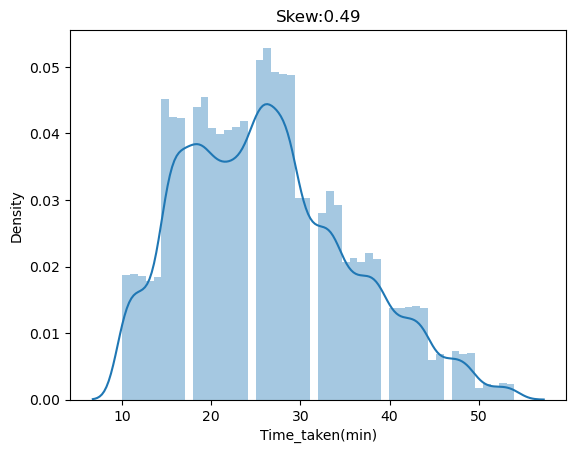

In [11]:
# Plotting the distribution plot for target variable

sns.distplot(combined_df['Time_taken(min)'])
plt.title('Skew:%.2f'%combined_df['Time_taken(min)'].skew())
plt.show()

* The target variable is slightly positively skewed i.e. there are deliveries that are taking more time than usual.

## Independent Variables

* We saw that there is `conditions` added in the column `Weatherconditions`, hence, removing it for better understanding.

In [12]:
combined_df['Weatherconditions'] = combined_df['Weatherconditions'].str.lstrip('conditions ')
combined_df['Weatherconditions'].unique()

array(['Sunny', 'Stormy', 'Sandstorms', 'Cloudy', 'Fog', 'Windy', 'NaN'],
      dtype=object)

* We see that there is `NaN` present in the column `Weatherconditions`, hence, we need to check it in other columns as well.

In [13]:
combined_df['Road_traffic_density'].unique()

array(['High ', 'Jam ', 'Low ', 'Medium ', 'NaN '], dtype=object)

In [14]:
combined_df['multiple_deliveries'].unique()

array(['0', '1', '3', 'NaN ', '2'], dtype=object)

* Replacing `NaN` with 'np.NaN' to get the count of null values in the data.

In [15]:
combined_df.replace('NaN',np.nan, inplace = True)
combined_df.replace('NaN ',np.nan, inplace = True)

In [16]:
# Now let's check the info again
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56992 entries, 0 to 56991
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           56992 non-null  object 
 1   Delivery_person_ID           56992 non-null  object 
 2   Delivery_person_Age          54647 non-null  object 
 3   Delivery_person_Ratings      54577 non-null  object 
 4   Restaurant_latitude          56992 non-null  float64
 5   Restaurant_longitude         56992 non-null  float64
 6   Delivery_location_latitude   56992 non-null  float64
 7   Delivery_location_longitude  56992 non-null  float64
 8   Order_Date                   56992 non-null  object 
 9   Time_Orderd                  54817 non-null  object 
 10  Time_Order_picked            56992 non-null  object 
 11  Weatherconditions            56218 non-null  object 
 12  Road_traffic_density         56237 non-null  object 
 13  Vehicle_conditio

* We can now see the presence of null values in the data.
* Also, we need to convert the data type of columns `Delivery_person_Age` and `Delivery_person_Ratings` to float

In [17]:
combined_df['Delivery_person_Age'] = combined_df['Delivery_person_Age'].astype(float)
combined_df['Delivery_person_Ratings'] = combined_df['Delivery_person_Ratings'].astype(float)

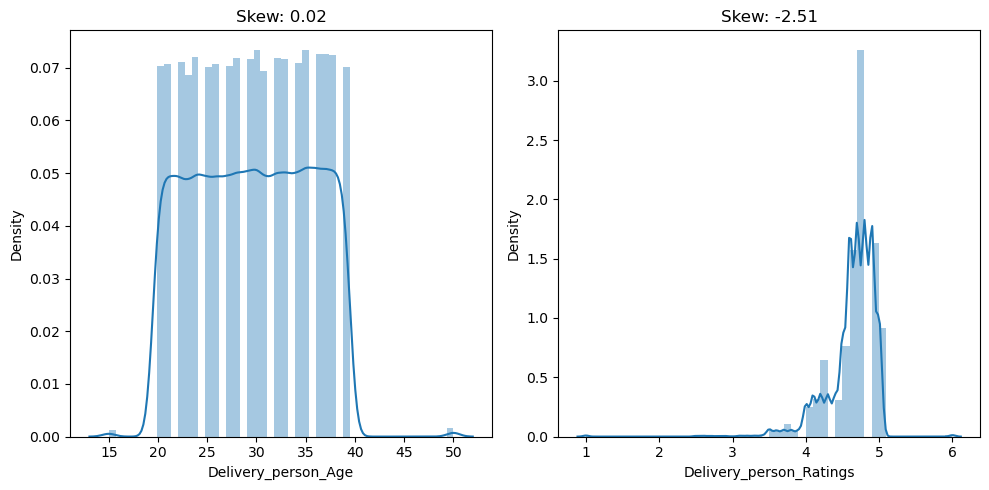

In [18]:
# Plotting the number columns

numcols = ['Delivery_person_Age', 'Delivery_person_Ratings']

r = 1
plt.figure(figsize=(10,5))
for i in numcols:
    plt.subplot(1,2,r)
    sns.distplot(combined_df[i])
    plt.title('Skew: %.2f'%combined_df[i].skew())
    r += 1
plt.tight_layout()
plt.show()


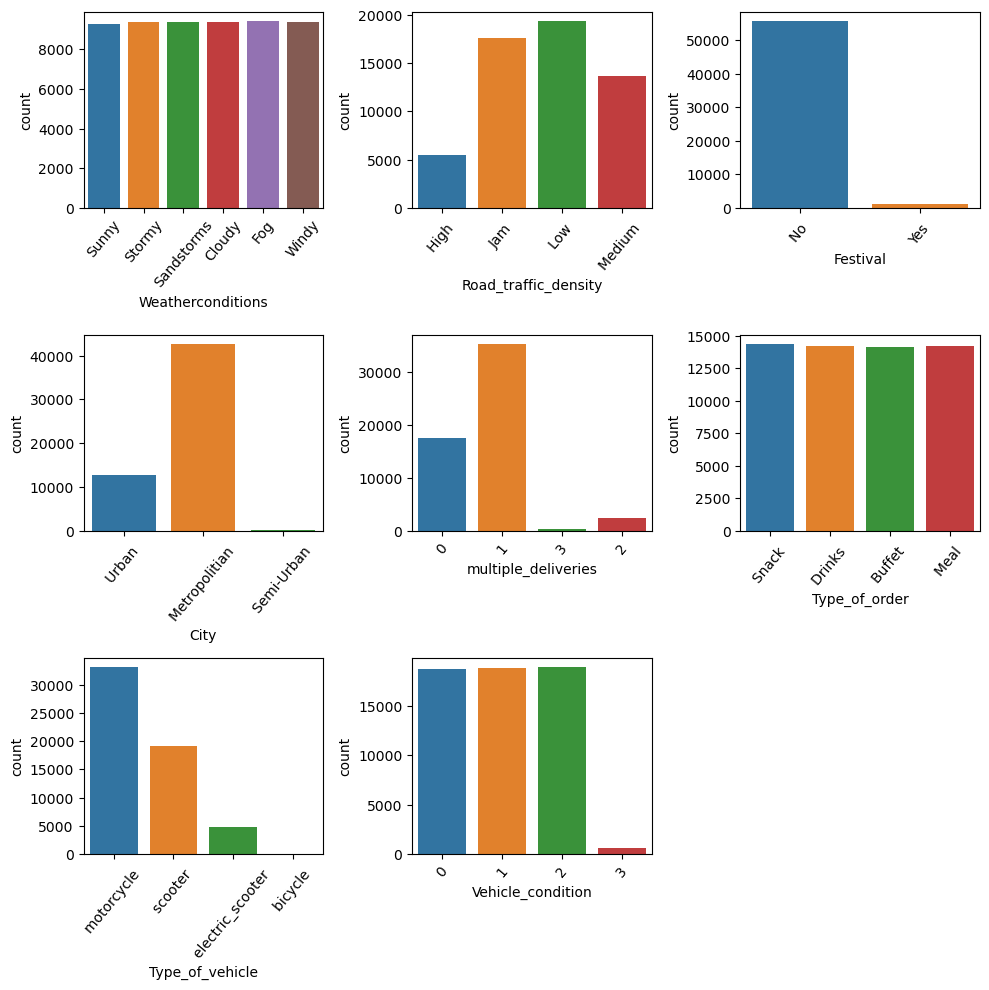

In [19]:
# Plotting the categorical columns
catcols = ['Weatherconditions', 'Road_traffic_density','Festival', 'City',\
           'multiple_deliveries','Type_of_order','Type_of_vehicle','Vehicle_condition']


r = 1
plt.figure(figsize=(10,10))
for i in catcols:
    plt.subplot(3,3,r)
    sns.countplot(x=combined_df[i])
    plt.xticks(rotation=50)
    r += 1
plt.tight_layout()
plt.show()

### Relationship between target and independent varibales

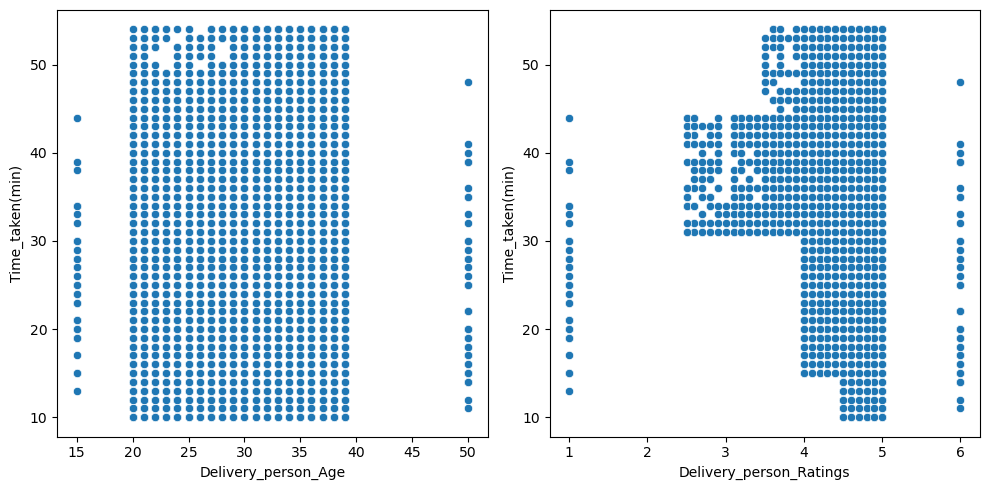

In [20]:
t = 1
plt.figure(figsize=(10,5))
for i in numcols:
    plt.subplot(1,2,t)
    sns.scatterplot(x=combined_df[i],y=combined_df['Time_taken(min)'])
    t += 1
plt.tight_layout()
plt.show()

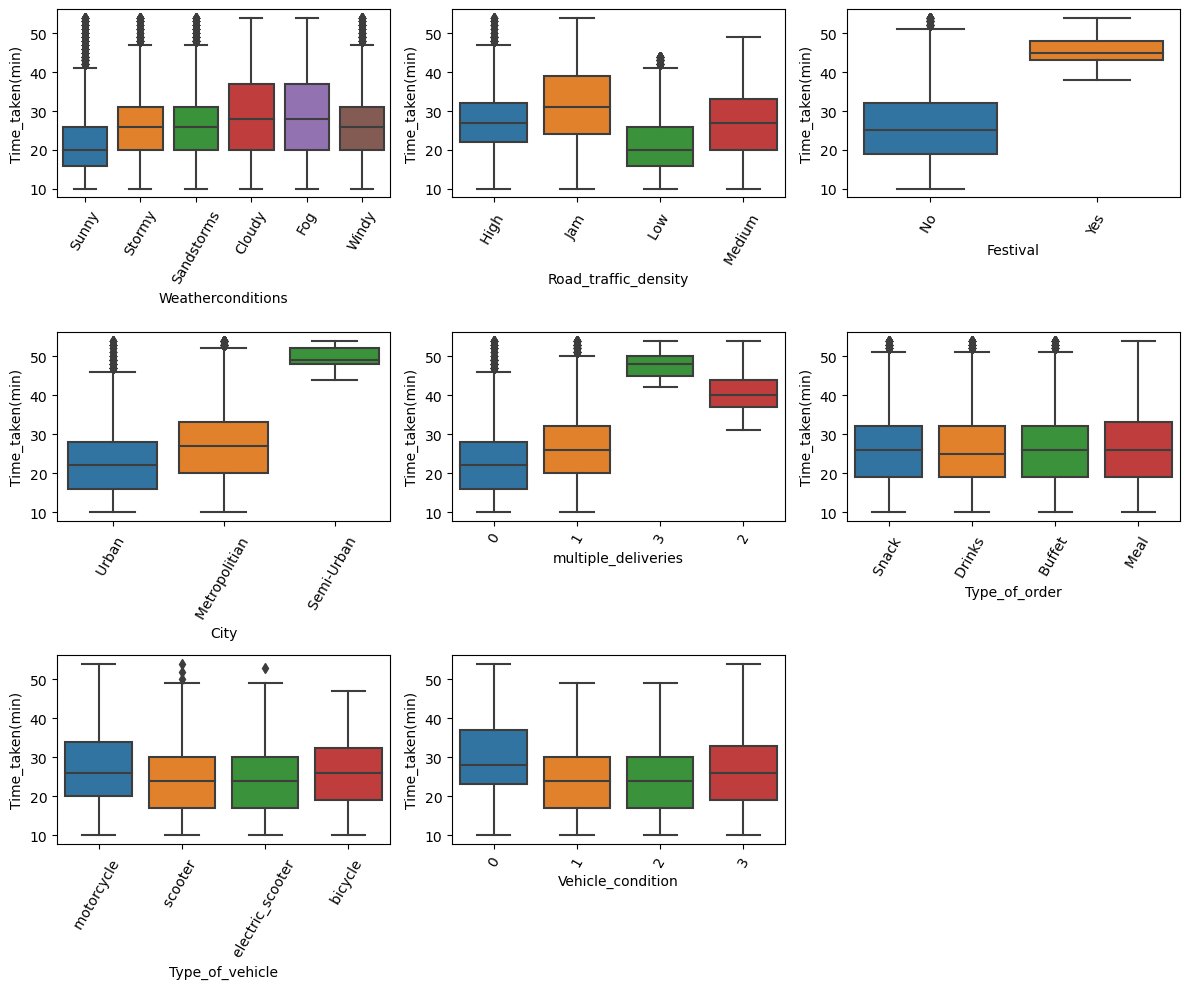

In [21]:
t = 1
plt.figure(figsize=(12,10))
for i in catcols:
    plt.subplot(3,3,t)
    sns.boxplot(x=combined_df[i],y=combined_df['Time_taken(min)'])
    plt.xticks(rotation=60)
    t += 1
plt.tight_layout()
plt.show()

* Delivery time is pretty much similar for all the weather conditions.
* It takes less time to deliver the food when density is low.
* Festivals have a huge impact on the delivery time
* It takes more time to deliver food in the semi-urban areas.
* Multiple deliveries also have a great impact on delivery time.

## Missing Values

In [22]:
pd.DataFrame({'Count':combined_df.isnull().sum(),
             'Percentage':combined_df.isnull().sum()*100/combined_df.isnull().count()},
             index=combined_df.columns)

Count  Percentage
ID                               0    0.000000
Delivery_person_ID               0    0.000000
Delivery_person_Age           2345    4.114613
Delivery_person_Ratings       2415    4.237437
Restaurant_latitude              0    0.000000
Restaurant_longitude             0    0.000000
Delivery_location_latitude       0    0.000000
Delivery_location_longitude      0    0.000000
Order_Date                       0    0.000000
Time_Orderd                   2175    3.816325
Time_Order_picked                0    0.000000
Weatherconditions              774    1.358085
Road_traffic_density           755    1.324747
Vehicle_condition                0    0.000000
Type_of_order                    0    0.000000
Type_of_vehicle                  0    0.000000
multiple_deliveries           1231    2.159952
Festival                       293    0.514107
City                          1524    2.674060
Time_taken(min)              11399   20.001053

In [23]:
# Delivery person age is uniformly distributed, hence, randomly filling the null values
combined_df['Delivery_person_Age'] = combined_df['Delivery_person_Age'].\
fillna(np.random.choice(combined_df['Delivery_person_Age']))

# Ratings are negatively skewed, hence, using median to fill the  null values
combined_df['Delivery_person_Ratings'] = combined_df['Delivery_person_Ratings'].\
fillna(combined_df['Delivery_person_Ratings'].median())

# Weather condition have approx. equal value count, hence, randomly filling the null values
combined_df['Weatherconditions'] = combined_df['Weatherconditions'].fillna(np.random.choice(combined_df['Weatherconditions']))

# Filling the rest categorical with mode.
combined_df['Road_traffic_density'] = combined_df['Road_traffic_density'].fillna(combined_df['Road_traffic_density'].mode()[0])
combined_df['Festival'] = combined_df['Festival'].fillna(combined_df['Festival'].mode()[0])
combined_df['multiple_deliveries'] = combined_df['multiple_deliveries'].fillna(combined_df['multiple_deliveries'].mode()[0])
combined_df['City'] = combined_df['City'].fillna(combined_df['City'].mode()[0])

In [24]:
combined_df.isnull().sum()

ID                                 0
Delivery_person_ID                 0
Delivery_person_Age                0
Delivery_person_Ratings            0
Restaurant_latitude                0
Restaurant_longitude               0
Delivery_location_latitude         0
Delivery_location_longitude        0
Order_Date                         0
Time_Orderd                     2175
Time_Order_picked                  0
Weatherconditions                  0
Road_traffic_density               0
Vehicle_condition                  0
Type_of_order                      0
Type_of_vehicle                    0
multiple_deliveries                0
Festival                           0
City                               0
Time_taken(min)                11399
dtype: int64

* Time ordered is related to `Time_order_picked`. Let's check the average time taken between order and pickup.

In [25]:
# Combining the date and time to get better understanding...
combined_df['Order_Date_Time'] = combined_df['Order_Date'] +" "+ combined_df['Time_Orderd']
combined_df['Pickup_Date_Time'] = combined_df['Order_Date'] +" "+ combined_df['Time_Order_picked']

In [26]:
# Converting the datatype to datetime to extract the required data
combined_df['Order_Date_Time'] = pd.to_datetime(combined_df['Order_Date_Time'])
combined_df['Pickup_Date_Time'] = pd.to_datetime(combined_df['Pickup_Date_Time'])

In [27]:
combined_df[combined_df['Order_Date_Time'] > combined_df['Pickup_Date_Time']].shape

(1033, 22)

In [28]:
fix = list(combined_df[combined_df['Pickup_Date_Time'] < combined_df['Order_Date_Time']].index)

for i in fix:
    combined_df['Pickup_Date_Time'][i] = combined_df['Pickup_Date_Time'][i] + timedelta(days = 1)

In [29]:
# The time requred for preparation would be 'Pickup_Date_Time - Order_Date_Time'.
combined_df['Prep_Time'] = combined_df['Pickup_Date_Time'] - combined_df['Order_Date_Time']
combined_df['Prep_Time'] = combined_df['Prep_Time'].dt.components.minutes

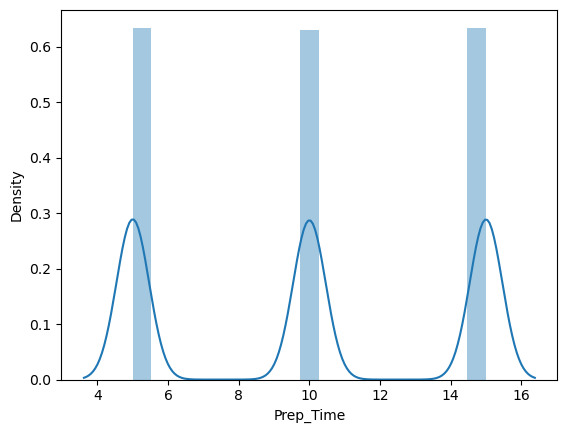

In [30]:
sns.distplot(combined_df['Prep_Time'])
plt.show()

In [31]:
combined_df['Prep_Time'].value_counts()

5.0     18315
15.0    18300
10.0    18202
Name: Prep_Time, dtype: int64

* We can see that the amount of time taken is either 5 mins or 10 mins or 15 mins. For now, subtracting 10 mins from `Pickup_Date_Time` to get the `Order_Date_Time`.

In [32]:
# Extracting the index of columns that have null values
fill = list(combined_df[combined_df['Order_Date_Time'].isnull()].index)

In [33]:
# Subtracting 10 mins from the pickup time to get the time ordered
for i in fill:
    a = np.random.choice([5,10,15])
    combined_df['Order_Date_Time'][i] = combined_df['Pickup_Date_Time'][i] - \
    timedelta(minutes=int(a))

In [34]:
# Imputing the null values for time ordered and prep time.
combined_df['Prep_Time'].fillna((combined_df['Pickup_Date_Time'] - combined_df['Order_Date_Time']).dt.components.minutes, inplace=True)
combined_df['Prep_Time'] = combined_df['Prep_Time'].astype('int')

* Dropping the columns 'Order_Date', 'Time_Orderd' & 'Time_Order_picked', since we have extracted the required information and created new columms

In [35]:
combined_df.drop(['Order_Date','Time_Orderd','Time_Order_picked'], axis = 1, inplace = True)

In [36]:
# All the null values have been dealt with
combined_df.isnull().sum()

ID                                 0
Delivery_person_ID                 0
Delivery_person_Age                0
Delivery_person_Ratings            0
Restaurant_latitude                0
Restaurant_longitude               0
Delivery_location_latitude         0
Delivery_location_longitude        0
Weatherconditions                  0
Road_traffic_density               0
Vehicle_condition                  0
Type_of_order                      0
Type_of_vehicle                    0
multiple_deliveries                0
Festival                           0
City                               0
Time_taken(min)                11399
Order_Date_Time                    0
Pickup_Date_Time                   0
Prep_Time                          0
dtype: int64

### Feature Engineering

In [37]:
combined_df.head()

ID Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  \
0  0x4607     INDORES13DEL02                  37.0                      4.9   
1  0xb379     BANGRES18DEL02                  34.0                      4.5   
2  0x5d6d     BANGRES19DEL01                  23.0                      4.4   
3  0x7a6a    COIMBRES13DEL02                  38.0                      4.7   
4  0x70a2     CHENRES12DEL01                  32.0                      4.6   

   Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0            22.745049             75.892471                   22.765049   
1            12.913041             77.683237                   13.043041   
2            12.914264             77.678400                   12.924264   
3            11.003669             76.976494                   11.053669   
4            12.972793             80.249982                   13.012793   

   Delivery_location_longitude Weatherconditions Road_traffic_density  \
0                    75.912471             Sunny                High    
1                    77.813237            Stormy                 Jam    
2                    77.688400        Sandstorms                 Low    
3                    77.026494             Sunny              Medium    
4                    80.289982            Cloudy                High    

   Vehicle_condition Type_of_order Type_of_vehicle multiple_deliveries  \
0                  2        Snack      motorcycle                    0   
1                  2        Snack         scooter                    1   
2                  0       Drinks      motorcycle                    1   
3                  0       Buffet      motorcycle                    1   
4                  1        Snack         scooter                    1   

  Festival            City  Time_taken(min)     Order_Date_Time  \
0      No           Urban              24.0 2022-03-19 11:30:00   
1      No   Metropolitian              33.0 2022-03-25 19:45:00   
2      No           Urban              26.0 2022-03-19 08:30:00   
3      No   Metropolitian              21.0 2022-05-04 18:00:00   
4      No   Metropolitian              30.0 2022-03-26 13:30:00   

     Pickup_Date_Time  Prep_Time  
0 2022-03-19 11:45:00         15  
1 2022-03-25 19:50:00          5  
2 2022-03-19 08:45:00         15  
3 2022-05-04 18:10:00         10  
4 2022-03-26 13:45:00         15

In [38]:
# Extracting the City_Code from Delivery_person_ID

combined_df['City_Code'] = combined_df['Delivery_person_ID'].str.split('RES').str[0]
combined_df['City_Code'].unique()

array(['INDO', 'BANG', 'COIMB', 'CHEN', 'HYD', 'RANCHI', 'MYS', 'DEH',
       'KOC', 'PUNE', 'LUDH', 'KNP', 'MUM', 'KOL', 'JAP', 'SUR', 'GOA',
       'AURG', 'AGR', 'VAD', 'ALH', 'BHP'], dtype=object)

In [39]:
combined_df['City_Code'].value_counts()

JAP       4320
INDO      3960
MUM       3960
COIMB     3960
CHEN      3960
HYD       3960
RANCHI    3960
MYS       3960
VAD       3960
SUR       3960
PUNE      3960
BANG      3960
KNP        952
LUDH       952
ALH        940
AGR        936
DEH        932
KOL        880
KOC        880
GOA        880
AURG       880
BHP        880
Name: City_Code, dtype: int64

In [40]:
# Extracting the distance from latitudes and longitudes

def dist(lat1, long1, lat2, long2):
    d = geopy.distance.geodesic((abs(lat1),abs(long1)),(abs(lat2),abs(long2))).km
    return np.round(d,4)

In [41]:
combined_df['Distance'] = combined_df[['Delivery_location_latitude',
                                       'Delivery_location_longitude',
                                       'Restaurant_latitude',
                                       'Restaurant_longitude']].apply(lambda x: dist(*x), axis = 1)

In [42]:
# Dropping the latitude and longitude columns
combined_df.drop(['Delivery_location_latitude','Delivery_location_longitude','Restaurant_latitude','Restaurant_longitude'],\
                 axis = 1, inplace = True)

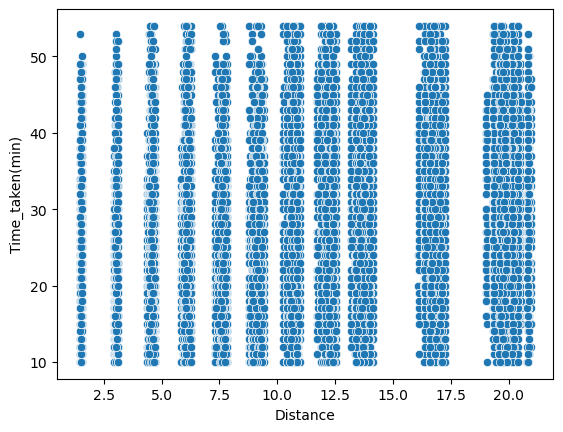

In [43]:
sns.scatterplot(x=combined_df['Distance'],y=combined_df['Time_taken(min)'])
plt.show()

In [44]:
combined_df['Distance'].value_counts()

17.2594    410
20.3974    410
10.9832    410
7.8452     410
6.2761     410
          ... 
19.3217      4
10.2695      4
20.9422      4
19.3219      4
4.3921       4
Name: Distance, Length: 2244, dtype: int64

In [45]:
combined_df.groupby(['Type_of_vehicle'])['Distance'].describe()

count      mean       std     min       25%     50%  \
Type_of_vehicle                                                            
bicycle               91.0  9.338143  5.493744  1.4640  4.648400  9.0745   
electric_scooter    4764.0  9.738788  5.603105  1.4638  4.654275  9.2489   
motorcycle         33044.0  9.704909  5.585257  1.4638  4.654100  9.2034   
scooter            19093.0  9.750073  5.621828  1.4638  4.654000  9.2041   

                       75%      max  
Type_of_vehicle                      
bicycle            13.4799  20.9424  
electric_scooter   13.6607  20.9429  
motorcycle         13.6596  20.9429  
scooter            13.6612  20.9425

In [46]:
def dist(x):
    if x <= 7:
        return ('Nearby')
    elif x <= 14:
        return ('Average')
    else:
        return('Far')

In [47]:
combined_df['Distance_Cat'] = combined_df['Distance'].apply(dist)

In [48]:
def rating(x):
    if x < 2.5:
        return ('Less Efficient')
    elif x < 4:
        return ('Efficient')
    else:
        return ('Very Efficient')

In [49]:
combined_df['Rating_cat'] = combined_df['Delivery_person_Ratings'].apply(rating)

In [50]:
def age(x):
    if x <= 19:
        return('Teen')
    elif x <= 30:
        return('Young')
    elif x <= 45:
        return('Adult')
    else:
        return('Old')

In [51]:
combined_df['Age_cat'] = combined_df['Delivery_person_Age'].apply(age)

In [52]:
def multiple(x):
    if x in ('0','1'):
        return('less')
    else:
        return('more')

In [53]:
combined_df['morethan1orders'] = combined_df['multiple_deliveries'].apply(multiple)

In [54]:
# Extracting information from date and time columns

combined_df['Day'] = combined_df['Order_Date_Time'].dt.day
combined_df['Month'] = combined_df['Order_Date_Time'].dt.month
combined_df['Hour'] = combined_df['Order_Date_Time'].dt.hour
combined_df['Minute'] = combined_df['Order_Date_Time'].dt.minute 
combined_df['Day_Name'] = combined_df['Order_Date_Time'].dt.day_name()
combined_df['Is_Month_Start'] = combined_df['Order_Date_Time'].dt.is_month_start
combined_df['Is_Month_End'] = combined_df['Order_Date_Time'].dt.is_month_end

In [55]:
def weekend(x):
    if x in ['Saturday','Sunday']:
        return 1
    else:
        return 0

In [56]:
combined_df['Is_Weekend'] = combined_df['Day_Name'].apply(weekend)

In [57]:
def time_of_day(x):
    if 6 <= x < 12:
        return 'Morning'
    elif 12 <= x < 17:
        return 'Noon'
    elif 17 <= x < 22:
        return 'Evening'
    else:
        return "Night"

In [58]:
combined_df['Time_of_Day'] = combined_df['Hour'].apply(time_of_day)

In [59]:
combined_df.head()

ID Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  \
0  0x4607     INDORES13DEL02                  37.0                      4.9   
1  0xb379     BANGRES18DEL02                  34.0                      4.5   
2  0x5d6d     BANGRES19DEL01                  23.0                      4.4   
3  0x7a6a    COIMBRES13DEL02                  38.0                      4.7   
4  0x70a2     CHENRES12DEL01                  32.0                      4.6   

  Weatherconditions Road_traffic_density  Vehicle_condition Type_of_order  \
0             Sunny                High                   2        Snack    
1            Stormy                 Jam                   2        Snack    
2        Sandstorms                 Low                   0       Drinks    
3             Sunny              Medium                   0       Buffet    
4            Cloudy                High                   1        Snack    

  Type_of_vehicle multiple_deliveries Festival            City  \
0     motorcycle                    0      No           Urban    
1        scooter                    1      No   Metropolitian    
2     motorcycle                    1      No           Urban    
3     motorcycle                    1      No   Metropolitian    
4        scooter                    1      No   Metropolitian    

   Time_taken(min)     Order_Date_Time    Pickup_Date_Time  Prep_Time  \
0             24.0 2022-03-19 11:30:00 2022-03-19 11:45:00         15   
1             33.0 2022-03-25 19:45:00 2022-03-25 19:50:00          5   
2             26.0 2022-03-19 08:30:00 2022-03-19 08:45:00         15   
3             21.0 2022-05-04 18:00:00 2022-05-04 18:10:00         10   
4             30.0 2022-03-26 13:30:00 2022-03-26 13:45:00         15   

  City_Code  Distance Distance_Cat      Rating_cat Age_cat morethan1orders  \
0      INDO    3.0207       Nearby  Very Efficient   Adult            less   
1      BANG   20.1437          Far  Very Efficient   Adult            less   
2      BANG    1.5497       Nearby  Very Efficient   Young            less   
3     COIMB    7.7745      Average  Very Efficient   Adult            less   
4      CHEN    6.1979       Nearby  Very Efficient   Adult            less   

   Day  Month  Hour  Minute   Day_Name  Is_Month_Start  Is_Month_End  \
0   19      3    11      30   Saturday           False         False   
1   25      3    19      45     Friday           False         False   
2   19      3     8      30   Saturday           False         False   
3    4      5    18       0  Wednesday           False         False   
4   26      3    13      30   Saturday           False         False   

   Is_Weekend Time_of_Day  
0           1     Morning  
1           0     Evening  
2           1     Morning  
3           0     Evening  
4           1        Noon

In [60]:
combined_df.groupby('City')['Time_taken(min)'].describe()

count       mean       std   min   25%   50%   75%   max
City                                                                      
Metropolitian   35293.0  27.136486  9.205358  10.0  20.0  26.0  33.0  54.0
Semi-Urban        164.0  49.731707  2.693089  44.0  48.0  49.0  52.0  54.0
Urban           10136.0  22.984017  8.866011  10.0  16.0  22.0  28.0  54.0

In [61]:
combined_df.groupby('Time_of_Day')['Time_taken(min)'].describe()

count       mean       std   min   25%   50%   75%   max
Time_of_Day                                                            
Evening      23439.0  29.614873  9.628398  10.0  22.0  29.0  37.0  54.0
Morning       8029.0  21.254328  7.005858  10.0  16.0  20.0  26.0  53.0
Night         9910.0  22.781332  7.609696  10.0  17.0  22.0  27.0  54.0
Noon          4215.0  25.692289  8.263343  10.0  20.0  26.0  31.0  54.0

In [62]:
combined_df['Orders_per_day'] = combined_df.groupby(['Day','Month'])['ID'].transform('nunique')
combined_df['Orders_per_hour'] = combined_df.groupby(['Hour'])['ID'].transform('nunique')
combined_df['Orders_per_city'] = combined_df.groupby(['City_Code'])['ID'].transform('nunique')

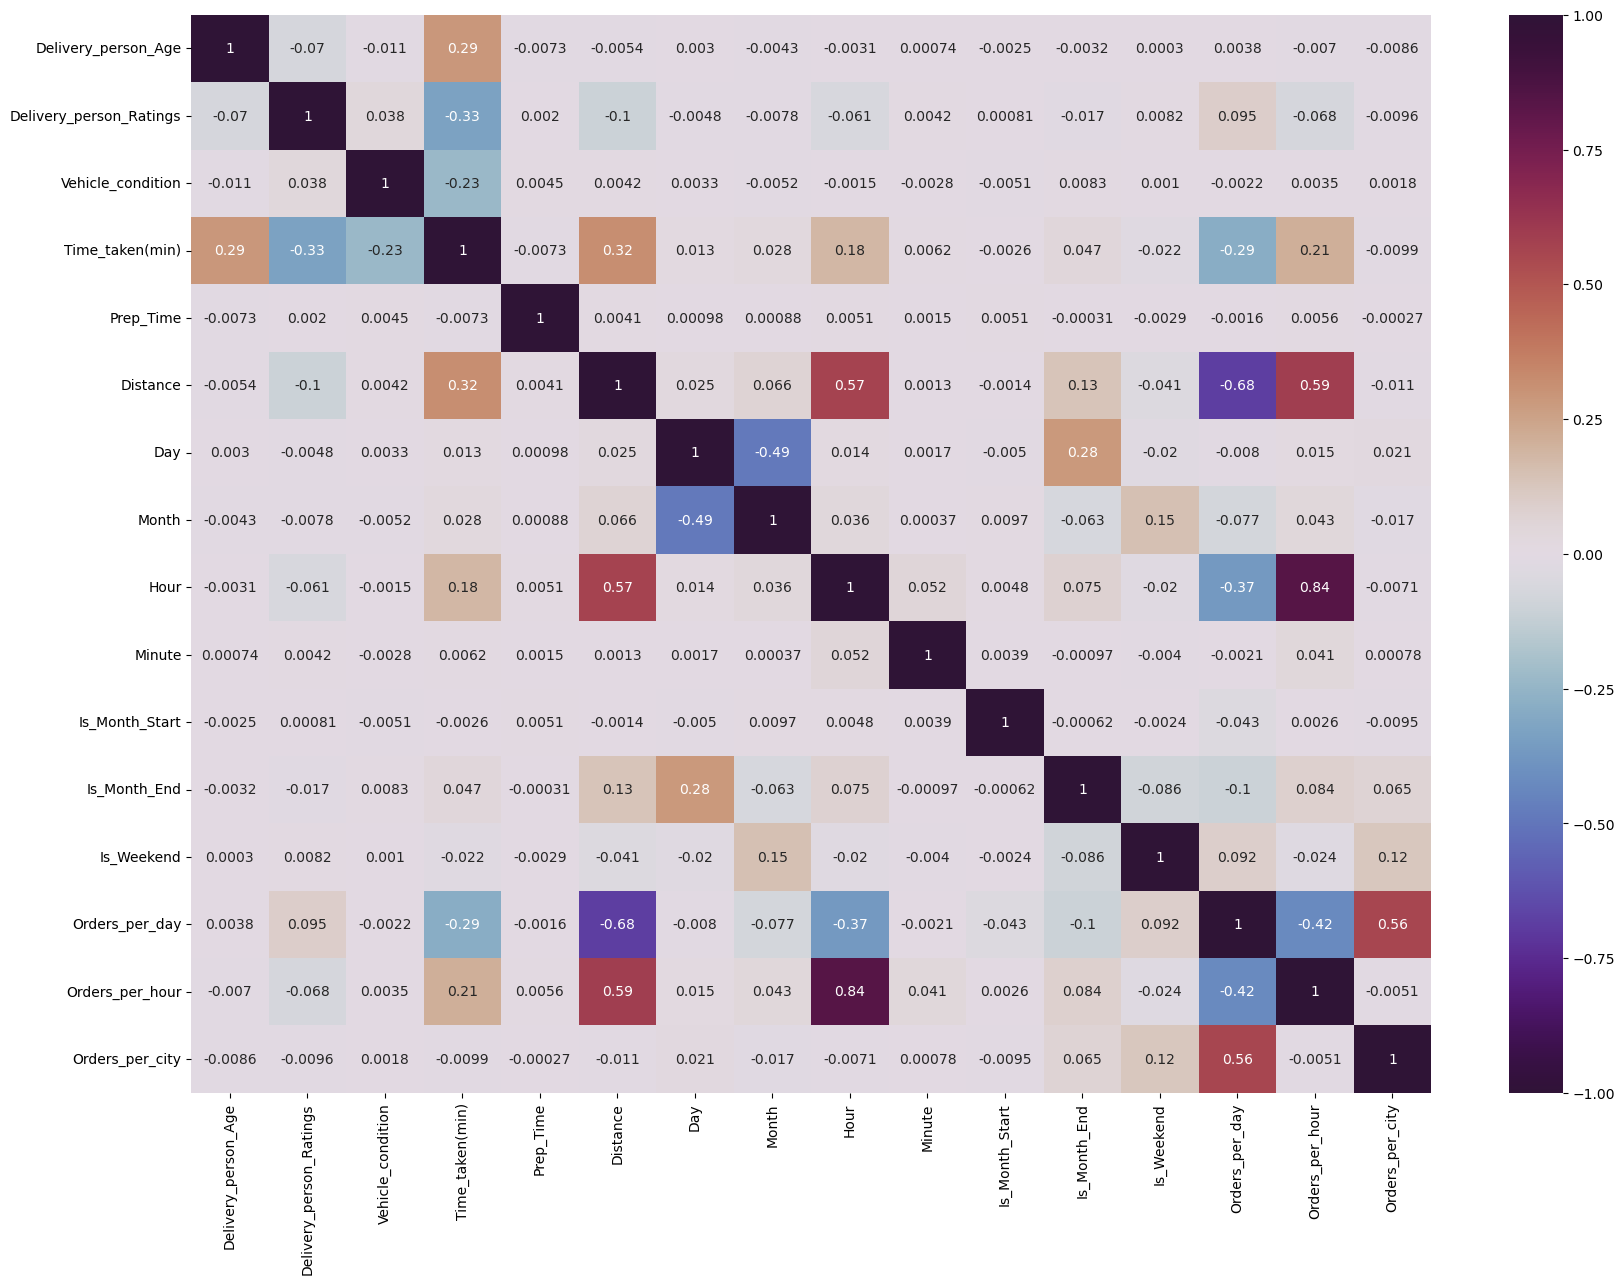

In [63]:
plt.figure(figsize=(20,14))
sns.heatmap(combined_df.corr(),
            annot = True,
            vmin=-1,vmax=1,
            cmap='twilight_shifted')
plt.show()

### Statistical Analysis

In [64]:
newtrain = combined_df.loc[:train.shape[0]-1,:]
newtest = combined_df.loc[train.shape[0]:,:]

In [65]:
new_num = newtrain.select_dtypes(np.number).columns

In [66]:
for i in new_num:
    if i != 'Time_taken(min)':
        tst, pval = stats.ttest_ind(newtrain['Time_taken(min)'],newtrain[i])
        print('P-Value for',i,'is:',pval)

P-Value for Delivery_person_Age is: 0.0
P-Value for Delivery_person_Ratings is: 0.0
P-Value for Vehicle_condition is: 0.0
P-Value for Prep_Time is: 0.0
P-Value for Distance is: 0.0
P-Value for Day is: 0.0
P-Value for Month is: 0.0
P-Value for Hour is: 0.0
P-Value for Minute is: 1.4502099596217616e-286
P-Value for Is_Weekend is: 0.0
P-Value for Orders_per_day is: 0.0
P-Value for Orders_per_hour is: 0.0
P-Value for Orders_per_city is: 0.0


In [67]:
newtrain.select_dtypes('object').columns

Index(['ID', 'Delivery_person_ID', 'Weatherconditions', 'Road_traffic_density',
       'Type_of_order', 'Type_of_vehicle', 'multiple_deliveries', 'Festival',
       'City', 'City_Code', 'Distance_Cat', 'Rating_cat', 'Age_cat',
       'morethan1orders', 'Day_Name', 'Time_of_Day'],
      dtype='object')

In [68]:
newtrain['Time_taken'] = newtrain['Time_taken(min)']

In [69]:
model = sfa.ols('Time_taken~Weatherconditions+Road_traffic_density+\
Type_of_order+Type_of_vehicle+multiple_deliveries+Festival+City+City_Code+Distance_Cat+Rating_cat+Age_cat+\
morethan1orders+Day_Name+Time_of_Day', data=newtrain).fit()

In [70]:
anova_lm(model)

df        sum_sq        mean_sq            F  \
Weatherconditions         5.0  2.505726e+05   50114.522882  1226.588949   
Road_traffic_density      3.0  7.170379e+05  239012.622203  5850.005630   
Type_of_order             3.0  2.299355e+02      76.645179     1.875946   
Type_of_vehicle           3.0  1.088343e+05   36278.083505   887.932155   
multiple_deliveries       3.0  4.183415e+05  139447.160061  3413.069419   
Festival                  1.0  1.175917e+05  117591.675214  2878.140726   
City                      2.0  7.957315e+04   39786.575943   973.805028   
City_Code                21.0  6.215178e+02      29.596084     0.724385   
Distance_Cat              2.0  1.035922e+05   51796.079069  1267.746244   
Rating_cat                2.0  1.055926e+05   52796.281339  1292.226914   
Age_cat                   3.0  2.350839e+05   78361.287675  1917.948809   
morethan1orders           1.0  1.486794e-02       0.014868     0.000364   
Day_Name                  6.0  7.731321e+03    1288.553471    31.538272   
Time_of_Day               3.0  9.440193e+03    3146.730897    77.018499   
Residual              45536.0  1.860456e+06      40.856819          NaN   

                            PR(>F)  
Weatherconditions     0.000000e+00  
Road_traffic_density  0.000000e+00  
Type_of_order         1.312056e-01  
Type_of_vehicle       0.000000e+00  
multiple_deliveries   0.000000e+00  
Festival              0.000000e+00  
City                  0.000000e+00  
City_Code             8.121284e-01  
Distance_Cat          0.000000e+00  
Rating_cat            0.000000e+00  
Age_cat               0.000000e+00  
morethan1orders       9.847804e-01  
Day_Name              4.476854e-38  
Time_of_Day           1.092379e-49  
Residual                       NaN

`ID`,`Delivery_Person_ID`, `Type_of_order` and `City_Code` are not significant. 

In [71]:
new_df = combined_df.drop(['ID','Delivery_person_ID','Type_of_order','City_Code'],axis=1)

In [72]:
new_df = new_df.drop(['Order_Date_Time','Pickup_Date_Time'],axis=1)

In [73]:
new_df.shape

(56992, 28)

### Encoding the Categorical Variables.

In [74]:
new_train = combined_df.loc[:train.shape[0]-1,:]
new_test = combined_df.loc[train.shape[0]:,:]

In [75]:
new_df.columns

Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Weatherconditions',
       'Road_traffic_density', 'Vehicle_condition', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken(min)',
       'Prep_Time', 'Distance', 'Distance_Cat', 'Rating_cat', 'Age_cat',
       'morethan1orders', 'Day', 'Month', 'Hour', 'Minute', 'Day_Name',
       'Is_Month_Start', 'Is_Month_End', 'Is_Weekend', 'Time_of_Day',
       'Orders_per_day', 'Orders_per_hour', 'Orders_per_city'],
      dtype='object')

In [76]:
wc = new_df['Weatherconditions'].value_counts(normalize=True).to_dict()
new_df['Weatherconditions'] = new_df['Weatherconditions'].map(wc)

In [77]:
rtd = new_df['Road_traffic_density'].value_counts(normalize=True).to_dict()
new_df['Road_traffic_density'] = new_df['Road_traffic_density'].map(rtd)

In [78]:
tov = new_df['Type_of_vehicle'].value_counts(normalize=True).to_dict()
new_df['Type_of_vehicle'] = new_df['Type_of_vehicle'].map(tov)

In [79]:
new_df['multiple_deliveries'] = new_df['multiple_deliveries'].astype(int)

In [80]:
city = new_df['City'].value_counts(normalize=True).to_dict()
new_df['City'] = new_df['City'].map(city)

In [81]:
dn = new_df['Day_Name'].value_counts(normalize=True).to_dict()
new_df['Day_Name'] = new_df['Day_Name'].map(dn)

In [82]:
tod = new_df['Time_of_Day'].value_counts(normalize=True).to_dict()
new_df['Time_of_Day'] = new_df['Time_of_Day'].map(tod)

In [83]:
new_df.head(2)

Delivery_person_Age  Delivery_person_Ratings  Weatherconditions  \
0                 37.0                      4.9           0.162461   
1                 34.0                      4.5           0.164883   

   Road_traffic_density  Vehicle_condition  Type_of_vehicle  \
0              0.097119                  2         0.579801   
1              0.309622                  2         0.335012   

   multiple_deliveries Festival      City  Time_taken(min)  Prep_Time  \
0                    0      No   0.222294             24.0         15   
1                    1      No   0.774038             33.0          5   

   Distance Distance_Cat      Rating_cat Age_cat morethan1orders  Day  Month  \
0    3.0207       Nearby  Very Efficient   Adult            less   19      3   
1   20.1437          Far  Very Efficient   Adult            less   25      3   

   Hour  Minute  Day_Name  Is_Month_Start  Is_Month_End  Is_Weekend  \
0    11      30  0.118666           False         False           1   
1    19      45  0.148600           False         False           0   

   Time_of_Day  Orders_per_day  Orders_per_hour  Orders_per_city  
0     0.175498            1439             2558             3960  
1     0.513581            1219             5957             3960

In [84]:
new_df = pd.get_dummies(new_df)

In [85]:
new_df.shape

(56992, 37)

In [86]:
new_df.head(2)

Delivery_person_Age  Delivery_person_Ratings  Weatherconditions  \
0                 37.0                      4.9           0.162461   
1                 34.0                      4.5           0.164883   

   Road_traffic_density  Vehicle_condition  Type_of_vehicle  \
0              0.097119                  2         0.579801   
1              0.309622                  2         0.335012   

   multiple_deliveries      City  Time_taken(min)  Prep_Time  Distance  Day  \
0                    0  0.222294             24.0         15    3.0207   19   
1                    1  0.774038             33.0          5   20.1437   25   

   Month  Hour  Minute  Day_Name  Is_Month_Start  Is_Month_End  Is_Weekend  \
0      3    11      30  0.118666           False         False           1   
1      3    19      45  0.148600           False         False           0   

   Time_of_Day  Orders_per_day  Orders_per_hour  Orders_per_city  \
0     0.175498            1439             2558             3960   
1     0.513581            1219             5957             3960   

   Festival_No   Festival_Yes   Distance_Cat_Average  Distance_Cat_Far  \
0             1              0                     0                 0   
1             1              0                     0                 1   

   Distance_Cat_Nearby  Rating_cat_Efficient  Rating_cat_Less Efficient  \
0                    1                     0                          0   
1                    0                     0                          0   

   Rating_cat_Very Efficient  Age_cat_Adult  Age_cat_Old  Age_cat_Teen  \
0                          1              1            0             0   
1                          1              1            0             0   

   Age_cat_Young  morethan1orders_less  morethan1orders_more  
0              0                     1                     0  
1              0                     1                     0

In [87]:
new_train = new_df.loc[0:train.shape[0]-1, :]
new_test = new_df.loc[train.shape[0]:, :]

In [88]:
train.shape, test.shape, new_train.shape, new_test.shape

((45593, 20), (11399, 19), (45593, 37), (11399, 37))

In [89]:
def model_validation(model,xtrain,ytrain,xtest,ytest):
    base_model = model.fit(xtrain,ytrain)
    
    ypred_train = base_model.predict(xtrain)
    ypred_test = base_model.predict(xtest)
    
    r2_train = r2_score(ytrain,ypred_train)
    r2_test = r2_score(ytest,ypred_test)
    
    adj_r2_train = 1 - (1-r2_train)*(xtrain.shape[0] - 1)/(xtrain.shape[0] - xtrain.shape[1] - 1)
    adj_r2_test = 1 - (1-r2_test)*(xtest.shape[0] - 1)/(xtest.shape[0] - xtest.shape[1] - 1)
    
    mse_train = mean_squared_error(ytrain,ypred_train)
    mse_test = mean_squared_error(ytest,ypred_test)
    
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    
    print('Train Data:')
    print('R2:',r2_train)
    print('Adjusted R2:', adj_r2_train)
    print('MSE:',mse_train)
    print('RMSE:',rmse_train)
    print()
    print('Test Data:')
    print('R2:',r2_test)
    print('Adjusted R2:', adj_r2_test)
    print('MSE:',mse_test)
    print('RMSE:',rmse_test)

In [90]:
new_train.head()

Delivery_person_Age  Delivery_person_Ratings  Weatherconditions  \
0                 37.0                      4.9           0.162461   
1                 34.0                      4.5           0.164883   
2                 23.0                      4.4           0.178043   
3                 38.0                      4.7           0.162461   
4                 32.0                      4.6           0.164883   

   Road_traffic_density  Vehicle_condition  Type_of_vehicle  \
0              0.097119                  2         0.579801   
1              0.309622                  2         0.335012   
2              0.352909                  0         0.579801   
3              0.240350                  0         0.579801   
4              0.097119                  1         0.335012   

   multiple_deliveries      City  Time_taken(min)  Prep_Time  Distance  Day  \
0                    0  0.222294             24.0         15    3.0207   19   
1                    1  0.774038             33.0          5   20.1437   25   
2                    1  0.222294             26.0         15    1.5497   19   
3                    1  0.774038             21.0         10    7.7745    4   
4                    1  0.774038             30.0         15    6.1979   26   

   Month  Hour  Minute  Day_Name  Is_Month_Start  Is_Month_End  Is_Weekend  \
0      3    11      30  0.118666           False         False           1   
1      3    19      45  0.148600           False         False           0   
2      3     8      30  0.118666           False         False           1   
3      5    18       0  0.154636           False         False           0   
4      3    13      30  0.118666           False         False           1   

   Time_of_Day  Orders_per_day  Orders_per_hour  Orders_per_city  \
0     0.175498            1439             2558             3960   
1     0.513581            1219             5957             3960   
2     0.175498            1439             2380             3960   
3     0.513581            1438             5841             3960   
4     0.092539            1441             1025             3960   

   Festival_No   Festival_Yes   Distance_Cat_Average  Distance_Cat_Far  \
0             1              0                     0                 0   
1             1              0                     0                 1   
2             1              0                     0                 0   
3             1              0                     1                 0   
4             1              0                     0                 0   

   Distance_Cat_Nearby  Rating_cat_Efficient  Rating_cat_Less Efficient  \
0                    1                     0                          0   
1                    0                     0                          0   
2                    1                     0                          0   
3                    0                     0                          0   
4                    1                     0                          0   

   Rating_cat_Very Efficient  Age_cat_Adult  Age_cat_Old  Age_cat_Teen  \
0                          1              1            0             0   
1                          1              1            0             0   
2                          1              0            0             0   
3                          1              1            0             0   
4                          1              1            0             0   

   Age_cat_Young  morethan1orders_less  morethan1orders_more  
0              0                     1                     0  
1              0                     1                     0  
2              1                     1                     0  
3              0                     1                     0  
4              0                     1                     0

In [91]:
X = new_train.drop('Time_taken(min)',axis=1)
y = new_train['Time_taken(min)']

In [92]:
Xtrain_samp, Xtest_samp, ytrain_samp, ytest_samp = train_test_split(X,y,test_size=0.3,random_state=42)

In [93]:
model_validation(LinearRegression(),
                 Xtrain_samp,ytrain_samp
                 ,Xtest_samp,ytest_samp)

Train Data:
R2: 0.5382713211652763
Adjusted R2: 0.5377498884393195
MSE: 40.71197449141105
RMSE: 6.38059358456649

Test Data:
R2: 0.5333073149055743
Adjusted R2: 0.5320756649779004
MSE: 40.96074469766656
RMSE: 6.4000581792407605


In [94]:
model_validation(DecisionTreeRegressor(max_depth=5),Xtrain_samp,ytrain_samp,Xtest_samp,ytest_samp)

Train Data:
R2: 0.5778663437084135
Adjusted R2: 0.5773896258582818
MSE: 37.22076499619131
RMSE: 6.100882312927476

Test Data:
R2: 0.573642420867142
Adjusted R2: 0.572517219426721
MSE: 37.42060783584533
RMSE: 6.117238579281123


In [95]:
model_validation(RandomForestRegressor(n_estimators=200,max_depth=5),
                 Xtrain_samp,ytrain_samp,
                 Xtest_samp,ytest_samp)

Train Data:
R2: 0.5969064967488522
Adjusted R2: 0.5964512810478345
MSE: 35.54193874946304
RMSE: 5.961706026756355

Test Data:
R2: 0.5893754553425374
Adjusted R2: 0.5882917749959595
MSE: 36.03974880580531
RMSE: 6.00331148665512


In [96]:
model_validation(XGBRegressor(n_estimators=100,max_depth=5),
                 Xtrain_samp,ytrain_samp,
                 Xtest_samp,ytest_samp)

Train Data:
R2: 0.8062322003620916
Adjusted R2: 0.8060133773246688
MSE: 17.08507631803207
RMSE: 4.133409768947675

Test Data:
R2: 0.7654160894461501
Adjusted R2: 0.7647969984132392
MSE: 20.588991379696388
RMSE: 4.537509380673101


In [97]:
model_validation(CatBoostRegressor(),
                 Xtrain_samp,ytrain_samp,
                 Xtest_samp,ytest_samp)

Learning rate set to 0.070764
0:	learn: 9.0017635	total: 208ms	remaining: 3m 27s
1:	learn: 8.6456997	total: 221ms	remaining: 1m 50s
2:	learn: 8.3313018	total: 229ms	remaining: 1m 16s
3:	learn: 8.0447320	total: 238ms	remaining: 59.2s
4:	learn: 7.7844308	total: 246ms	remaining: 48.9s
5:	learn: 7.5346875	total: 253ms	remaining: 42s
6:	learn: 7.3282407	total: 261ms	remaining: 37s
7:	learn: 7.0970382	total: 269ms	remaining: 33.3s
8:	learn: 6.8977421	total: 276ms	remaining: 30.4s
9:	learn: 6.7400337	total: 284ms	remaining: 28.1s
10:	learn: 6.5696112	total: 291ms	remaining: 26.2s
11:	learn: 6.4438681	total: 299ms	remaining: 24.6s
12:	learn: 6.3195839	total: 306ms	remaining: 23.2s
13:	learn: 6.2104021	total: 314ms	remaining: 22.1s
14:	learn: 6.1106451	total: 321ms	remaining: 21.1s
15:	learn: 6.0092802	total: 329ms	remaining: 20.3s
16:	learn: 5.9246008	total: 337ms	remaining: 19.5s
17:	learn: 5.8544368	total: 345ms	remaining: 18.8s
18:	learn: 5.7841465	total: 352ms	remaining: 18.2s
19:	learn: 5

177:	learn: 4.4501303	total: 1.66s	remaining: 7.67s
178:	learn: 4.4492075	total: 1.67s	remaining: 7.66s
179:	learn: 4.4487808	total: 1.68s	remaining: 7.65s
180:	learn: 4.4483245	total: 1.69s	remaining: 7.63s
181:	learn: 4.4470091	total: 1.7s	remaining: 7.62s
182:	learn: 4.4464147	total: 1.7s	remaining: 7.6s
183:	learn: 4.4458274	total: 1.71s	remaining: 7.58s
184:	learn: 4.4451329	total: 1.72s	remaining: 7.57s
185:	learn: 4.4447564	total: 1.73s	remaining: 7.55s
186:	learn: 4.4445818	total: 1.73s	remaining: 7.53s
187:	learn: 4.4441153	total: 1.74s	remaining: 7.51s
188:	learn: 4.4434960	total: 1.75s	remaining: 7.49s
189:	learn: 4.4420533	total: 1.75s	remaining: 7.47s
190:	learn: 4.4418211	total: 1.76s	remaining: 7.46s
191:	learn: 4.4409231	total: 1.77s	remaining: 7.44s
192:	learn: 4.4401275	total: 1.77s	remaining: 7.42s
193:	learn: 4.4384891	total: 1.78s	remaining: 7.4s
194:	learn: 4.4380971	total: 1.79s	remaining: 7.39s
195:	learn: 4.4373594	total: 1.8s	remaining: 7.37s
196:	learn: 4.436

338:	learn: 4.3258557	total: 2.9s	remaining: 5.66s
339:	learn: 4.3252235	total: 2.91s	remaining: 5.66s
340:	learn: 4.3243963	total: 2.92s	remaining: 5.65s
341:	learn: 4.3220967	total: 2.93s	remaining: 5.64s
342:	learn: 4.3216347	total: 2.94s	remaining: 5.63s
343:	learn: 4.3211582	total: 2.95s	remaining: 5.62s
344:	learn: 4.3205766	total: 2.96s	remaining: 5.61s
345:	learn: 4.3199817	total: 2.96s	remaining: 5.6s
346:	learn: 4.3173585	total: 2.97s	remaining: 5.59s
347:	learn: 4.3168418	total: 2.98s	remaining: 5.58s
348:	learn: 4.3165774	total: 2.99s	remaining: 5.57s
349:	learn: 4.3158862	total: 2.99s	remaining: 5.56s
350:	learn: 4.3153439	total: 3s	remaining: 5.55s
351:	learn: 4.3145249	total: 3.01s	remaining: 5.54s
352:	learn: 4.3137417	total: 3.02s	remaining: 5.53s
353:	learn: 4.3134343	total: 3.02s	remaining: 5.52s
354:	learn: 4.3130298	total: 3.03s	remaining: 5.51s
355:	learn: 4.3122392	total: 3.04s	remaining: 5.5s
356:	learn: 4.3114929	total: 3.05s	remaining: 5.49s
357:	learn: 4.3106

514:	learn: 4.2224059	total: 4.33s	remaining: 4.07s
515:	learn: 4.2223993	total: 4.33s	remaining: 4.06s
516:	learn: 4.2219842	total: 4.34s	remaining: 4.05s
517:	learn: 4.2215181	total: 4.35s	remaining: 4.05s
518:	learn: 4.2208960	total: 4.36s	remaining: 4.04s
519:	learn: 4.2203586	total: 4.37s	remaining: 4.03s
520:	learn: 4.2199511	total: 4.37s	remaining: 4.02s
521:	learn: 4.2196015	total: 4.38s	remaining: 4.01s
522:	learn: 4.2189725	total: 4.39s	remaining: 4s
523:	learn: 4.2186530	total: 4.4s	remaining: 3.99s
524:	learn: 4.2183917	total: 4.41s	remaining: 3.98s
525:	learn: 4.2179243	total: 4.42s	remaining: 3.98s
526:	learn: 4.2171463	total: 4.42s	remaining: 3.97s
527:	learn: 4.2164947	total: 4.43s	remaining: 3.96s
528:	learn: 4.2160547	total: 4.44s	remaining: 3.95s
529:	learn: 4.2156026	total: 4.45s	remaining: 3.94s
530:	learn: 4.2152599	total: 4.46s	remaining: 3.94s
531:	learn: 4.2148151	total: 4.46s	remaining: 3.93s
532:	learn: 4.2133686	total: 4.47s	remaining: 3.92s
533:	learn: 4.21

697:	learn: 4.1340805	total: 5.79s	remaining: 2.51s
698:	learn: 4.1338215	total: 5.81s	remaining: 2.5s
699:	learn: 4.1334992	total: 5.81s	remaining: 2.49s
700:	learn: 4.1329944	total: 5.82s	remaining: 2.48s
701:	learn: 4.1326794	total: 5.83s	remaining: 2.47s
702:	learn: 4.1320839	total: 5.84s	remaining: 2.47s
703:	learn: 4.1314967	total: 5.85s	remaining: 2.46s
704:	learn: 4.1309306	total: 5.86s	remaining: 2.45s
705:	learn: 4.1306287	total: 5.87s	remaining: 2.44s
706:	learn: 4.1300658	total: 5.88s	remaining: 2.44s
707:	learn: 4.1298254	total: 5.88s	remaining: 2.43s
708:	learn: 4.1294496	total: 5.89s	remaining: 2.42s
709:	learn: 4.1290339	total: 5.9s	remaining: 2.41s
710:	learn: 4.1287684	total: 5.91s	remaining: 2.4s
711:	learn: 4.1284849	total: 5.91s	remaining: 2.39s
712:	learn: 4.1280282	total: 5.92s	remaining: 2.38s
713:	learn: 4.1276654	total: 5.93s	remaining: 2.37s
714:	learn: 4.1269075	total: 5.94s	remaining: 2.37s
715:	learn: 4.1266142	total: 5.94s	remaining: 2.36s
716:	learn: 4.1

878:	learn: 4.0632553	total: 7.22s	remaining: 994ms
879:	learn: 4.0629942	total: 7.23s	remaining: 986ms
880:	learn: 4.0625925	total: 7.24s	remaining: 978ms
881:	learn: 4.0622299	total: 7.25s	remaining: 970ms
882:	learn: 4.0615471	total: 7.26s	remaining: 962ms
883:	learn: 4.0610824	total: 7.27s	remaining: 954ms
884:	learn: 4.0605359	total: 7.28s	remaining: 946ms
885:	learn: 4.0602108	total: 7.28s	remaining: 937ms
886:	learn: 4.0598113	total: 7.29s	remaining: 929ms
887:	learn: 4.0594061	total: 7.3s	remaining: 921ms
888:	learn: 4.0590594	total: 7.31s	remaining: 912ms
889:	learn: 4.0587530	total: 7.31s	remaining: 904ms
890:	learn: 4.0584246	total: 7.32s	remaining: 896ms
891:	learn: 4.0581614	total: 7.33s	remaining: 887ms
892:	learn: 4.0577405	total: 7.34s	remaining: 879ms
893:	learn: 4.0574224	total: 7.34s	remaining: 871ms
894:	learn: 4.0570403	total: 7.35s	remaining: 863ms
895:	learn: 4.0567226	total: 7.36s	remaining: 854ms
896:	learn: 4.0562843	total: 7.37s	remaining: 846ms
897:	learn: 4

In [98]:
model_validation(GradientBoostingRegressor(n_estimators=200,max_depth=5),
                 Xtrain_samp,ytrain_samp,
                 Xtest_samp,ytest_samp)

Train Data:
R2: 0.79576391663336
Adjusted R2: 0.7955332717057861
MSE: 18.008095657460036
RMSE: 4.243594662248038

Test Data:
R2: 0.7694232533329297
Adjusted R2: 0.768814737617072
MSE: 20.23729009495292
RMSE: 4.498587566665


In [99]:
model_validation(LGBMRegressor(max_depth=5),
                 Xtrain_samp,ytrain_samp,
                 Xtest_samp,ytest_samp)

Train Data:
R2: 0.7798779801467243
Adjusted R2: 0.7796293951440667
MSE: 19.408805361367325
RMSE: 4.405542572869694

Test Data:
R2: 0.7695562197992996
Adjusted R2: 0.7689480549956029
MSE: 20.22561987672093
RMSE: 4.497290281571885


In [102]:
params = {'n_estimators':[500,600,700,800],
          'max_depth':[7,8,9,10],
          'learning_rate':[0.01,0.1,0.2]}

grid = GridSearchCV(XGBRegressor(),
                    param_grid=params,
                    cv = 5,
                    scoring='neg_mean_squared_error')
grid.fit(Xtrain_samp,ytrain_samp)
grid.best_params_

{'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 700}

In [103]:
xgb = XGBRegressor(n_estimators=700,
                       max_depth=8,
                       learning_rate=0.01)

In [104]:
model_validation(xgb,Xtrain_samp,ytrain_samp,Xtest_samp,ytest_samp)

Train Data:
R2: 0.8265701739966136
Adjusted R2: 0.82637431874421
MSE: 15.29181741562798
RMSE: 3.910475343948352

Test Data:
R2: 0.7827410535161602
Adjusted R2: 0.7821676848427919
MSE: 19.06841166453684
RMSE: 4.366739248516774


In [105]:
params_cb = {'learning_rate':[0.01,0.1,0.2],
             'n_estimators':[100,200,300,400],
             'max_depth':[5,6,7,8,9,10]}

grid_cb = GridSearchCV(CatBoostRegressor(),
                    param_grid=params_cb,
                    cv = 5,
                    scoring='neg_mean_squared_error')
grid_cb.fit(Xtrain_samp,ytrain_samp)
grid_cb.best_params_

0:	learn: 9.3303797	total: 6.35ms	remaining: 629ms
1:	learn: 9.2821985	total: 13.6ms	remaining: 667ms
2:	learn: 9.2358441	total: 19.8ms	remaining: 639ms
3:	learn: 9.1895040	total: 25.5ms	remaining: 613ms
4:	learn: 9.1431998	total: 31.8ms	remaining: 605ms
5:	learn: 9.0946016	total: 37.7ms	remaining: 591ms
6:	learn: 9.0483279	total: 43.4ms	remaining: 576ms
7:	learn: 9.0030774	total: 49.1ms	remaining: 565ms
8:	learn: 8.9582132	total: 54.8ms	remaining: 554ms
9:	learn: 8.9139480	total: 60.5ms	remaining: 545ms
10:	learn: 8.8706550	total: 67.7ms	remaining: 547ms
11:	learn: 8.8283773	total: 73.2ms	remaining: 537ms
12:	learn: 8.7858076	total: 79.1ms	remaining: 530ms
13:	learn: 8.7435446	total: 84.9ms	remaining: 522ms
14:	learn: 8.7046125	total: 90.6ms	remaining: 514ms
15:	learn: 8.6637764	total: 96.3ms	remaining: 505ms
16:	learn: 8.6221274	total: 102ms	remaining: 498ms
17:	learn: 8.5821604	total: 108ms	remaining: 491ms
18:	learn: 8.5415370	total: 113ms	remaining: 484ms
19:	learn: 8.5029052	tota

76:	learn: 6.8996734	total: 602ms	remaining: 180ms
77:	learn: 6.8821273	total: 612ms	remaining: 173ms
78:	learn: 6.8633773	total: 619ms	remaining: 164ms
79:	learn: 6.8434165	total: 625ms	remaining: 156ms
80:	learn: 6.8212500	total: 633ms	remaining: 149ms
81:	learn: 6.8008008	total: 641ms	remaining: 141ms
82:	learn: 6.7792627	total: 648ms	remaining: 133ms
83:	learn: 6.7618419	total: 654ms	remaining: 125ms
84:	learn: 6.7437888	total: 660ms	remaining: 116ms
85:	learn: 6.7278350	total: 666ms	remaining: 108ms
86:	learn: 6.7120374	total: 671ms	remaining: 100ms
87:	learn: 6.6890056	total: 677ms	remaining: 92.4ms
88:	learn: 6.6665804	total: 683ms	remaining: 84.4ms
89:	learn: 6.6510306	total: 689ms	remaining: 76.5ms
90:	learn: 6.6337823	total: 695ms	remaining: 68.7ms
91:	learn: 6.6156539	total: 700ms	remaining: 60.9ms
92:	learn: 6.6005249	total: 706ms	remaining: 53.1ms
93:	learn: 6.5791058	total: 712ms	remaining: 45.4ms
94:	learn: 6.5632600	total: 717ms	remaining: 37.7ms
95:	learn: 6.5488869	to

62:	learn: 7.1950911	total: 416ms	remaining: 244ms
63:	learn: 7.1658557	total: 424ms	remaining: 239ms
64:	learn: 7.1419325	total: 433ms	remaining: 233ms
65:	learn: 7.1192968	total: 441ms	remaining: 227ms
66:	learn: 7.0977633	total: 448ms	remaining: 221ms
67:	learn: 7.0775767	total: 455ms	remaining: 214ms
68:	learn: 7.0562021	total: 462ms	remaining: 207ms
69:	learn: 7.0290668	total: 469ms	remaining: 201ms
70:	learn: 7.0096441	total: 475ms	remaining: 194ms
71:	learn: 6.9901948	total: 482ms	remaining: 187ms
72:	learn: 6.9706180	total: 490ms	remaining: 181ms
73:	learn: 6.9485867	total: 498ms	remaining: 175ms
74:	learn: 6.9282398	total: 508ms	remaining: 169ms
75:	learn: 6.9099425	total: 514ms	remaining: 162ms
76:	learn: 6.8908032	total: 522ms	remaining: 156ms
77:	learn: 6.8727380	total: 529ms	remaining: 149ms
78:	learn: 6.8539097	total: 538ms	remaining: 143ms
79:	learn: 6.8371754	total: 545ms	remaining: 136ms
80:	learn: 6.8192631	total: 552ms	remaining: 130ms
81:	learn: 6.7951192	total: 560

26:	learn: 8.2357078	total: 218ms	remaining: 1.39s
27:	learn: 8.2004125	total: 227ms	remaining: 1.4s
28:	learn: 8.1658558	total: 239ms	remaining: 1.41s
29:	learn: 8.1282674	total: 247ms	remaining: 1.4s
30:	learn: 8.0960020	total: 256ms	remaining: 1.4s
31:	learn: 8.0628159	total: 265ms	remaining: 1.39s
32:	learn: 8.0296325	total: 273ms	remaining: 1.38s
33:	learn: 7.9976564	total: 289ms	remaining: 1.41s
34:	learn: 7.9632528	total: 299ms	remaining: 1.41s
35:	learn: 7.9314589	total: 307ms	remaining: 1.4s
36:	learn: 7.9001680	total: 313ms	remaining: 1.38s
37:	learn: 7.8660160	total: 320ms	remaining: 1.36s
38:	learn: 7.8372028	total: 326ms	remaining: 1.34s
39:	learn: 7.8063343	total: 332ms	remaining: 1.33s
40:	learn: 7.7750864	total: 338ms	remaining: 1.31s
41:	learn: 7.7411780	total: 344ms	remaining: 1.29s
42:	learn: 7.7117985	total: 350ms	remaining: 1.28s
43:	learn: 7.6828970	total: 356ms	remaining: 1.26s
44:	learn: 7.6546253	total: 361ms	remaining: 1.24s
45:	learn: 7.6272224	total: 368ms	r

186:	learn: 5.6178776	total: 2.22s	remaining: 154ms
187:	learn: 5.6124599	total: 2.23s	remaining: 142ms
188:	learn: 5.6075414	total: 2.23s	remaining: 130ms
189:	learn: 5.6025940	total: 2.24s	remaining: 118ms
190:	learn: 5.5949304	total: 2.25s	remaining: 106ms
191:	learn: 5.5901814	total: 2.25s	remaining: 94ms
192:	learn: 5.5859531	total: 2.26s	remaining: 82.1ms
193:	learn: 5.5780495	total: 2.27s	remaining: 70.2ms
194:	learn: 5.5722737	total: 2.27s	remaining: 58.4ms
195:	learn: 5.5672526	total: 2.28s	remaining: 46.6ms
196:	learn: 5.5610181	total: 2.29s	remaining: 34.9ms
197:	learn: 5.5559990	total: 2.3s	remaining: 23.2ms
198:	learn: 5.5513671	total: 2.3s	remaining: 11.6ms
199:	learn: 5.5463515	total: 2.31s	remaining: 0us
0:	learn: 9.3311750	total: 5.98ms	remaining: 1.19s
1:	learn: 9.2806489	total: 12.2ms	remaining: 1.21s
2:	learn: 9.2349384	total: 18.5ms	remaining: 1.22s
3:	learn: 9.1883712	total: 25.3ms	remaining: 1.24s
4:	learn: 9.1424019	total: 31.2ms	remaining: 1.22s
5:	learn: 9.093

166:	learn: 5.7557917	total: 1.23s	remaining: 243ms
167:	learn: 5.7498050	total: 1.24s	remaining: 235ms
168:	learn: 5.7438040	total: 1.24s	remaining: 228ms
169:	learn: 5.7365530	total: 1.25s	remaining: 220ms
170:	learn: 5.7287522	total: 1.25s	remaining: 213ms
171:	learn: 5.7210011	total: 1.26s	remaining: 205ms
172:	learn: 5.7152359	total: 1.26s	remaining: 197ms
173:	learn: 5.7092982	total: 1.27s	remaining: 190ms
174:	learn: 5.7026015	total: 1.28s	remaining: 182ms
175:	learn: 5.6962860	total: 1.28s	remaining: 175ms
176:	learn: 5.6905550	total: 1.29s	remaining: 168ms
177:	learn: 5.6832323	total: 1.3s	remaining: 161ms
178:	learn: 5.6775259	total: 1.3s	remaining: 153ms
179:	learn: 5.6715360	total: 1.31s	remaining: 146ms
180:	learn: 5.6655831	total: 1.32s	remaining: 139ms
181:	learn: 5.6602614	total: 1.33s	remaining: 131ms
182:	learn: 5.6542418	total: 1.33s	remaining: 124ms
183:	learn: 5.6479931	total: 1.34s	remaining: 117ms
184:	learn: 5.6395183	total: 1.34s	remaining: 109ms
185:	learn: 5.

132:	learn: 6.0774315	total: 915ms	remaining: 461ms
133:	learn: 6.0680533	total: 922ms	remaining: 454ms
134:	learn: 6.0582719	total: 928ms	remaining: 447ms
135:	learn: 6.0448794	total: 936ms	remaining: 441ms
136:	learn: 6.0361711	total: 942ms	remaining: 433ms
137:	learn: 6.0274618	total: 948ms	remaining: 426ms
138:	learn: 6.0180128	total: 957ms	remaining: 420ms
139:	learn: 6.0095437	total: 963ms	remaining: 413ms
140:	learn: 6.0008741	total: 972ms	remaining: 407ms
141:	learn: 5.9900521	total: 979ms	remaining: 400ms
142:	learn: 5.9794490	total: 989ms	remaining: 394ms
143:	learn: 5.9669751	total: 1.01s	remaining: 392ms
144:	learn: 5.9572275	total: 1.02s	remaining: 389ms
145:	learn: 5.9490158	total: 1.04s	remaining: 384ms
146:	learn: 5.9402975	total: 1.08s	remaining: 390ms
147:	learn: 5.9311451	total: 1.09s	remaining: 383ms
148:	learn: 5.9225336	total: 1.1s	remaining: 376ms
149:	learn: 5.9144654	total: 1.1s	remaining: 368ms
150:	learn: 5.9070268	total: 1.11s	remaining: 361ms
151:	learn: 5.

96:	learn: 6.5265505	total: 695ms	remaining: 738ms
97:	learn: 6.5112075	total: 702ms	remaining: 730ms
98:	learn: 6.4978246	total: 707ms	remaining: 721ms
99:	learn: 6.4834799	total: 713ms	remaining: 713ms
100:	learn: 6.4638317	total: 719ms	remaining: 705ms
101:	learn: 6.4511223	total: 725ms	remaining: 696ms
102:	learn: 6.4321028	total: 731ms	remaining: 688ms
103:	learn: 6.4134055	total: 737ms	remaining: 680ms
104:	learn: 6.3981257	total: 743ms	remaining: 672ms
105:	learn: 6.3853901	total: 749ms	remaining: 664ms
106:	learn: 6.3725554	total: 754ms	remaining: 656ms
107:	learn: 6.3607042	total: 760ms	remaining: 648ms
108:	learn: 6.3447982	total: 766ms	remaining: 640ms
109:	learn: 6.3321563	total: 772ms	remaining: 632ms
110:	learn: 6.3147090	total: 778ms	remaining: 624ms
111:	learn: 6.2977016	total: 786ms	remaining: 618ms
112:	learn: 6.2861834	total: 792ms	remaining: 610ms
113:	learn: 6.2734020	total: 801ms	remaining: 605ms
114:	learn: 6.2589356	total: 808ms	remaining: 597ms
115:	learn: 6.24

68:	learn: 7.0830521	total: 412ms	remaining: 782ms
69:	learn: 7.0642762	total: 418ms	remaining: 776ms
70:	learn: 7.0412234	total: 424ms	remaining: 770ms
71:	learn: 7.0218354	total: 430ms	remaining: 764ms
72:	learn: 6.9993367	total: 436ms	remaining: 758ms
73:	learn: 6.9756635	total: 443ms	remaining: 754ms
74:	learn: 6.9569760	total: 448ms	remaining: 747ms
75:	learn: 6.9378536	total: 454ms	remaining: 741ms
76:	learn: 6.9119907	total: 460ms	remaining: 735ms
77:	learn: 6.8927411	total: 466ms	remaining: 729ms
78:	learn: 6.8675470	total: 472ms	remaining: 723ms
79:	learn: 6.8479311	total: 478ms	remaining: 717ms
80:	learn: 6.8234025	total: 484ms	remaining: 711ms
81:	learn: 6.8031727	total: 490ms	remaining: 705ms
82:	learn: 6.7820709	total: 496ms	remaining: 699ms
83:	learn: 6.7647933	total: 502ms	remaining: 693ms
84:	learn: 6.7466730	total: 508ms	remaining: 687ms
85:	learn: 6.7307672	total: 513ms	remaining: 681ms
86:	learn: 6.7149731	total: 519ms	remaining: 674ms
87:	learn: 6.6924041	total: 525

32:	learn: 8.0296325	total: 202ms	remaining: 1.63s
33:	learn: 7.9976564	total: 209ms	remaining: 1.63s
34:	learn: 7.9632528	total: 215ms	remaining: 1.63s
35:	learn: 7.9314589	total: 220ms	remaining: 1.62s
36:	learn: 7.9001680	total: 226ms	remaining: 1.61s
37:	learn: 7.8660160	total: 232ms	remaining: 1.6s
38:	learn: 7.8372028	total: 238ms	remaining: 1.59s
39:	learn: 7.8063343	total: 244ms	remaining: 1.59s
40:	learn: 7.7750864	total: 250ms	remaining: 1.58s
41:	learn: 7.7411780	total: 256ms	remaining: 1.57s
42:	learn: 7.7117985	total: 262ms	remaining: 1.56s
43:	learn: 7.6828970	total: 267ms	remaining: 1.55s
44:	learn: 7.6546253	total: 273ms	remaining: 1.55s
45:	learn: 7.6272224	total: 279ms	remaining: 1.54s
46:	learn: 7.5997699	total: 284ms	remaining: 1.53s
47:	learn: 7.5743413	total: 290ms	remaining: 1.52s
48:	learn: 7.5473794	total: 295ms	remaining: 1.51s
49:	learn: 7.5205613	total: 301ms	remaining: 1.5s
50:	learn: 7.4907927	total: 307ms	remaining: 1.5s
51:	learn: 7.4621737	total: 313ms	

204:	learn: 5.5196144	total: 1.2s	remaining: 554ms
205:	learn: 5.5134240	total: 1.2s	remaining: 548ms
206:	learn: 5.5092128	total: 1.21s	remaining: 542ms
207:	learn: 5.5039359	total: 1.21s	remaining: 537ms
208:	learn: 5.4997777	total: 1.22s	remaining: 531ms
209:	learn: 5.4958862	total: 1.22s	remaining: 525ms
210:	learn: 5.4896717	total: 1.23s	remaining: 519ms
211:	learn: 5.4839974	total: 1.24s	remaining: 513ms
212:	learn: 5.4783132	total: 1.24s	remaining: 507ms
213:	learn: 5.4728621	total: 1.25s	remaining: 501ms
214:	learn: 5.4668161	total: 1.25s	remaining: 495ms
215:	learn: 5.4610606	total: 1.26s	remaining: 490ms
216:	learn: 5.4570594	total: 1.26s	remaining: 484ms
217:	learn: 5.4505976	total: 1.27s	remaining: 478ms
218:	learn: 5.4460275	total: 1.28s	remaining: 472ms
219:	learn: 5.4422207	total: 1.28s	remaining: 467ms
220:	learn: 5.4385992	total: 1.29s	remaining: 461ms
221:	learn: 5.4335814	total: 1.29s	remaining: 455ms
222:	learn: 5.4300562	total: 1.3s	remaining: 449ms
223:	learn: 5.4

97:	learn: 6.5080630	total: 602ms	remaining: 1.24s
98:	learn: 6.4880485	total: 608ms	remaining: 1.23s
99:	learn: 6.4683705	total: 614ms	remaining: 1.23s
100:	learn: 6.4552888	total: 620ms	remaining: 1.22s
101:	learn: 6.4411915	total: 626ms	remaining: 1.21s
102:	learn: 6.4252638	total: 632ms	remaining: 1.21s
103:	learn: 6.4109665	total: 637ms	remaining: 1.2s
104:	learn: 6.3943920	total: 644ms	remaining: 1.2s
105:	learn: 6.3809146	total: 649ms	remaining: 1.19s
106:	learn: 6.3637398	total: 655ms	remaining: 1.18s
107:	learn: 6.3497692	total: 661ms	remaining: 1.18s
108:	learn: 6.3373307	total: 667ms	remaining: 1.17s
109:	learn: 6.3242959	total: 672ms	remaining: 1.16s
110:	learn: 6.3069704	total: 678ms	remaining: 1.16s
111:	learn: 6.2956688	total: 684ms	remaining: 1.15s
112:	learn: 6.2787549	total: 690ms	remaining: 1.14s
113:	learn: 6.2671923	total: 696ms	remaining: 1.14s
114:	learn: 6.2524670	total: 702ms	remaining: 1.13s
115:	learn: 6.2410008	total: 707ms	remaining: 1.12s
116:	learn: 6.230

269:	learn: 5.2606856	total: 1.61s	remaining: 179ms
270:	learn: 5.2580225	total: 1.61s	remaining: 173ms
271:	learn: 5.2555062	total: 1.62s	remaining: 166ms
272:	learn: 5.2521347	total: 1.62s	remaining: 161ms
273:	learn: 5.2485861	total: 1.63s	remaining: 155ms
274:	learn: 5.2464497	total: 1.63s	remaining: 149ms
275:	learn: 5.2436436	total: 1.64s	remaining: 143ms
276:	learn: 5.2403284	total: 1.65s	remaining: 137ms
277:	learn: 5.2382074	total: 1.65s	remaining: 131ms
278:	learn: 5.2353957	total: 1.66s	remaining: 125ms
279:	learn: 5.2312406	total: 1.66s	remaining: 119ms
280:	learn: 5.2286662	total: 1.67s	remaining: 113ms
281:	learn: 5.2255328	total: 1.67s	remaining: 107ms
282:	learn: 5.2232107	total: 1.68s	remaining: 101ms
283:	learn: 5.2192352	total: 1.69s	remaining: 94.9ms
284:	learn: 5.2150102	total: 1.69s	remaining: 89ms
285:	learn: 5.2124325	total: 1.7s	remaining: 83ms
286:	learn: 5.2103079	total: 1.7s	remaining: 77.1ms
287:	learn: 5.2074938	total: 1.71s	remaining: 71.1ms
288:	learn: 5

136:	learn: 6.0361711	total: 793ms	remaining: 943ms
137:	learn: 6.0274618	total: 798ms	remaining: 937ms
138:	learn: 6.0180128	total: 804ms	remaining: 931ms
139:	learn: 6.0095437	total: 810ms	remaining: 925ms
140:	learn: 6.0008741	total: 815ms	remaining: 920ms
141:	learn: 5.9900521	total: 821ms	remaining: 913ms
142:	learn: 5.9794490	total: 827ms	remaining: 908ms
143:	learn: 5.9669751	total: 833ms	remaining: 902ms
144:	learn: 5.9572275	total: 839ms	remaining: 896ms
145:	learn: 5.9490158	total: 844ms	remaining: 891ms
146:	learn: 5.9402975	total: 850ms	remaining: 885ms
147:	learn: 5.9311451	total: 856ms	remaining: 879ms
148:	learn: 5.9225336	total: 861ms	remaining: 873ms
149:	learn: 5.9144654	total: 867ms	remaining: 867ms
150:	learn: 5.9070268	total: 872ms	remaining: 860ms
151:	learn: 5.8993649	total: 878ms	remaining: 854ms
152:	learn: 5.8922285	total: 883ms	remaining: 849ms
153:	learn: 5.8810997	total: 889ms	remaining: 843ms
154:	learn: 5.8740342	total: 895ms	remaining: 837ms
155:	learn: 

0:	learn: 9.3356004	total: 5.52ms	remaining: 1.65s
1:	learn: 9.2874696	total: 11.4ms	remaining: 1.69s
2:	learn: 9.2392532	total: 16.9ms	remaining: 1.67s
3:	learn: 9.1917425	total: 22.5ms	remaining: 1.66s
4:	learn: 9.1452923	total: 28ms	remaining: 1.65s
5:	learn: 9.0969650	total: 33.7ms	remaining: 1.65s
6:	learn: 9.0511206	total: 39.4ms	remaining: 1.65s
7:	learn: 9.0079497	total: 45ms	remaining: 1.64s
8:	learn: 8.9634643	total: 50.6ms	remaining: 1.64s
9:	learn: 8.9201948	total: 56.2ms	remaining: 1.63s
10:	learn: 8.8772617	total: 61.9ms	remaining: 1.63s
11:	learn: 8.8329372	total: 67.8ms	remaining: 1.63s
12:	learn: 8.7903618	total: 73.5ms	remaining: 1.62s
13:	learn: 8.7494481	total: 79.4ms	remaining: 1.62s
14:	learn: 8.7070830	total: 85ms	remaining: 1.61s
15:	learn: 8.6640119	total: 90.9ms	remaining: 1.61s
16:	learn: 8.6237577	total: 96.5ms	remaining: 1.61s
17:	learn: 8.5842476	total: 102ms	remaining: 1.6s
18:	learn: 8.5439379	total: 108ms	remaining: 1.59s
19:	learn: 8.5051085	total: 113

175:	learn: 5.6921263	total: 1.19s	remaining: 839ms
176:	learn: 5.6841589	total: 1.2s	remaining: 832ms
177:	learn: 5.6775347	total: 1.2s	remaining: 825ms
178:	learn: 5.6696767	total: 1.21s	remaining: 818ms
179:	learn: 5.6628418	total: 1.22s	remaining: 811ms
180:	learn: 5.6572204	total: 1.22s	remaining: 804ms
181:	learn: 5.6518145	total: 1.23s	remaining: 796ms
182:	learn: 5.6461913	total: 1.23s	remaining: 789ms
183:	learn: 5.6409874	total: 1.24s	remaining: 782ms
184:	learn: 5.6356104	total: 1.25s	remaining: 774ms
185:	learn: 5.6302560	total: 1.25s	remaining: 767ms
186:	learn: 5.6230581	total: 1.26s	remaining: 760ms
187:	learn: 5.6180163	total: 1.26s	remaining: 752ms
188:	learn: 5.6126380	total: 1.27s	remaining: 745ms
189:	learn: 5.6062701	total: 1.27s	remaining: 738ms
190:	learn: 5.6009377	total: 1.28s	remaining: 731ms
191:	learn: 5.5941895	total: 1.29s	remaining: 724ms
192:	learn: 5.5874131	total: 1.29s	remaining: 717ms
193:	learn: 5.5802727	total: 1.3s	remaining: 711ms
194:	learn: 5.5

48:	learn: 7.5707781	total: 295ms	remaining: 1.51s
49:	learn: 7.5443697	total: 301ms	remaining: 1.5s
50:	learn: 7.5151040	total: 307ms	remaining: 1.5s
51:	learn: 7.4863278	total: 313ms	remaining: 1.49s
52:	learn: 7.4593964	total: 319ms	remaining: 1.49s
53:	learn: 7.4358548	total: 324ms	remaining: 1.48s
54:	learn: 7.4077242	total: 331ms	remaining: 1.47s
55:	learn: 7.3829381	total: 337ms	remaining: 1.47s
56:	learn: 7.3601213	total: 343ms	remaining: 1.46s
57:	learn: 7.3364543	total: 349ms	remaining: 1.45s
58:	learn: 7.3128508	total: 355ms	remaining: 1.45s
59:	learn: 7.2895234	total: 361ms	remaining: 1.44s
60:	learn: 7.2635867	total: 367ms	remaining: 1.44s
61:	learn: 7.2378811	total: 373ms	remaining: 1.43s
62:	learn: 7.2150782	total: 378ms	remaining: 1.42s
63:	learn: 7.1928940	total: 385ms	remaining: 1.42s
64:	learn: 7.1702093	total: 390ms	remaining: 1.41s
65:	learn: 7.1474030	total: 396ms	remaining: 1.41s
66:	learn: 7.1273240	total: 402ms	remaining: 1.4s
67:	learn: 7.1071122	total: 408ms	

208:	learn: 5.5287683	total: 1.28s	remaining: 556ms
209:	learn: 5.5246091	total: 1.28s	remaining: 550ms
210:	learn: 5.5182681	total: 1.29s	remaining: 545ms
211:	learn: 5.5143050	total: 1.3s	remaining: 538ms
212:	learn: 5.5106818	total: 1.3s	remaining: 532ms
213:	learn: 5.5040064	total: 1.31s	remaining: 526ms
214:	learn: 5.4979041	total: 1.31s	remaining: 520ms
215:	learn: 5.4920041	total: 1.32s	remaining: 514ms
216:	learn: 5.4881233	total: 1.33s	remaining: 508ms
217:	learn: 5.4816924	total: 1.33s	remaining: 502ms
218:	learn: 5.4756775	total: 1.34s	remaining: 496ms
219:	learn: 5.4719441	total: 1.35s	remaining: 490ms
220:	learn: 5.4662395	total: 1.35s	remaining: 484ms
221:	learn: 5.4616192	total: 1.36s	remaining: 478ms
222:	learn: 5.4581364	total: 1.36s	remaining: 471ms
223:	learn: 5.4546465	total: 1.37s	remaining: 465ms
224:	learn: 5.4510119	total: 1.38s	remaining: 459ms
225:	learn: 5.4460295	total: 1.38s	remaining: 453ms
226:	learn: 5.4404473	total: 1.39s	remaining: 447ms
227:	learn: 5.

73:	learn: 6.9472576	total: 633ms	remaining: 2.79s
74:	learn: 6.9273941	total: 648ms	remaining: 2.81s
75:	learn: 6.9082726	total: 685ms	remaining: 2.92s
76:	learn: 6.8864426	total: 700ms	remaining: 2.94s
77:	learn: 6.8649875	total: 719ms	remaining: 2.97s
78:	learn: 6.8443125	total: 726ms	remaining: 2.95s
79:	learn: 6.8242154	total: 738ms	remaining: 2.95s
80:	learn: 6.8049584	total: 758ms	remaining: 2.99s
81:	learn: 6.7845349	total: 771ms	remaining: 2.99s
82:	learn: 6.7629398	total: 777ms	remaining: 2.97s
83:	learn: 6.7441685	total: 783ms	remaining: 2.94s
84:	learn: 6.7259263	total: 789ms	remaining: 2.92s
85:	learn: 6.7097219	total: 794ms	remaining: 2.9s
86:	learn: 6.6935439	total: 800ms	remaining: 2.88s
87:	learn: 6.6704632	total: 806ms	remaining: 2.86s
88:	learn: 6.6551470	total: 811ms	remaining: 2.83s
89:	learn: 6.6388609	total: 817ms	remaining: 2.81s
90:	learn: 6.6202935	total: 824ms	remaining: 2.8s
91:	learn: 6.6044113	total: 832ms	remaining: 2.79s
92:	learn: 6.5890039	total: 837ms

241:	learn: 5.3550810	total: 1.84s	remaining: 1.2s
242:	learn: 5.3502911	total: 1.85s	remaining: 1.19s
243:	learn: 5.3472689	total: 1.85s	remaining: 1.18s
244:	learn: 5.3435730	total: 1.86s	remaining: 1.18s
245:	learn: 5.3400891	total: 1.86s	remaining: 1.17s
246:	learn: 5.3371241	total: 1.87s	remaining: 1.16s
247:	learn: 5.3316102	total: 1.88s	remaining: 1.15s
248:	learn: 5.3270122	total: 1.88s	remaining: 1.14s
249:	learn: 5.3233483	total: 1.89s	remaining: 1.13s
250:	learn: 5.3183598	total: 1.89s	remaining: 1.12s
251:	learn: 5.3152220	total: 1.9s	remaining: 1.11s
252:	learn: 5.3105920	total: 1.91s	remaining: 1.11s
253:	learn: 5.3079348	total: 1.91s	remaining: 1.1s
254:	learn: 5.3048168	total: 1.92s	remaining: 1.09s
255:	learn: 5.3023160	total: 1.92s	remaining: 1.08s
256:	learn: 5.2996107	total: 1.93s	remaining: 1.07s
257:	learn: 5.2968640	total: 1.93s	remaining: 1.06s
258:	learn: 5.2936715	total: 1.94s	remaining: 1.05s
259:	learn: 5.2911050	total: 1.94s	remaining: 1.05s
260:	learn: 5.2

12:	learn: 8.7860840	total: 75.6ms	remaining: 2.25s
13:	learn: 8.7445807	total: 81.6ms	remaining: 2.25s
14:	learn: 8.7061575	total: 87.4ms	remaining: 2.24s
15:	learn: 8.6670334	total: 93ms	remaining: 2.23s
16:	learn: 8.6255995	total: 98.5ms	remaining: 2.22s
17:	learn: 8.5860055	total: 104ms	remaining: 2.21s
18:	learn: 8.5425922	total: 110ms	remaining: 2.21s
19:	learn: 8.5020134	total: 116ms	remaining: 2.21s
20:	learn: 8.4625262	total: 122ms	remaining: 2.2s
21:	learn: 8.4256621	total: 127ms	remaining: 2.19s
22:	learn: 8.3853171	total: 133ms	remaining: 2.18s
23:	learn: 8.3458911	total: 139ms	remaining: 2.17s
24:	learn: 8.3073555	total: 145ms	remaining: 2.17s
25:	learn: 8.2694324	total: 151ms	remaining: 2.17s
26:	learn: 8.2348525	total: 157ms	remaining: 2.17s
27:	learn: 8.2002745	total: 164ms	remaining: 2.18s
28:	learn: 8.1661565	total: 170ms	remaining: 2.17s
29:	learn: 8.1304613	total: 175ms	remaining: 2.16s
30:	learn: 8.0982628	total: 181ms	remaining: 2.15s
31:	learn: 8.0652122	total: 1

189:	learn: 5.6100346	total: 1.49s	remaining: 1.65s
190:	learn: 5.6024315	total: 1.5s	remaining: 1.64s
191:	learn: 5.5961302	total: 1.51s	remaining: 1.63s
192:	learn: 5.5914256	total: 1.51s	remaining: 1.63s
193:	learn: 5.5848274	total: 1.53s	remaining: 1.62s
194:	learn: 5.5800012	total: 1.53s	remaining: 1.61s
195:	learn: 5.5753423	total: 1.54s	remaining: 1.6s
196:	learn: 5.5690925	total: 1.55s	remaining: 1.59s
197:	learn: 5.5621119	total: 1.56s	remaining: 1.59s
198:	learn: 5.5575868	total: 1.56s	remaining: 1.58s
199:	learn: 5.5509046	total: 1.57s	remaining: 1.57s
200:	learn: 5.5463446	total: 1.58s	remaining: 1.56s
201:	learn: 5.5419084	total: 1.59s	remaining: 1.56s
202:	learn: 5.5375187	total: 1.59s	remaining: 1.55s
203:	learn: 5.5333204	total: 1.6s	remaining: 1.54s
204:	learn: 5.5269631	total: 1.61s	remaining: 1.53s
205:	learn: 5.5206443	total: 1.62s	remaining: 1.52s
206:	learn: 5.5164014	total: 1.62s	remaining: 1.51s
207:	learn: 5.5107685	total: 1.63s	remaining: 1.5s
208:	learn: 5.50

375:	learn: 5.0134403	total: 2.7s	remaining: 172ms
376:	learn: 5.0117207	total: 2.71s	remaining: 165ms
377:	learn: 5.0105856	total: 2.71s	remaining: 158ms
378:	learn: 5.0094378	total: 2.72s	remaining: 151ms
379:	learn: 5.0079069	total: 2.72s	remaining: 143ms
380:	learn: 5.0068937	total: 2.73s	remaining: 136ms
381:	learn: 5.0049717	total: 2.73s	remaining: 129ms
382:	learn: 5.0038392	total: 2.74s	remaining: 122ms
383:	learn: 5.0028588	total: 2.75s	remaining: 114ms
384:	learn: 5.0016675	total: 2.75s	remaining: 107ms
385:	learn: 5.0003741	total: 2.76s	remaining: 100ms
386:	learn: 4.9989624	total: 2.76s	remaining: 92.8ms
387:	learn: 4.9976703	total: 2.77s	remaining: 85.6ms
388:	learn: 4.9950884	total: 2.77s	remaining: 78.5ms
389:	learn: 4.9940240	total: 2.78s	remaining: 71.3ms
390:	learn: 4.9914396	total: 2.79s	remaining: 64.1ms
391:	learn: 4.9905033	total: 2.79s	remaining: 57ms
392:	learn: 4.9895249	total: 2.8s	remaining: 49.8ms
393:	learn: 4.9880936	total: 2.8s	remaining: 42.7ms
394:	lear

156:	learn: 5.8577845	total: 991ms	remaining: 1.53s
157:	learn: 5.8512483	total: 997ms	remaining: 1.53s
158:	learn: 5.8446238	total: 1s	remaining: 1.52s
159:	learn: 5.8379475	total: 1.01s	remaining: 1.51s
160:	learn: 5.8289784	total: 1.01s	remaining: 1.5s
161:	learn: 5.8197829	total: 1.02s	remaining: 1.5s
162:	learn: 5.8112713	total: 1.02s	remaining: 1.49s
163:	learn: 5.8047858	total: 1.03s	remaining: 1.49s
164:	learn: 5.7985417	total: 1.04s	remaining: 1.48s
165:	learn: 5.7902161	total: 1.04s	remaining: 1.47s
166:	learn: 5.7828196	total: 1.05s	remaining: 1.47s
167:	learn: 5.7761510	total: 1.06s	remaining: 1.46s
168:	learn: 5.7695184	total: 1.06s	remaining: 1.45s
169:	learn: 5.7622239	total: 1.07s	remaining: 1.45s
170:	learn: 5.7538446	total: 1.08s	remaining: 1.44s
171:	learn: 5.7470774	total: 1.09s	remaining: 1.44s
172:	learn: 5.7392649	total: 1.09s	remaining: 1.44s
173:	learn: 5.7332606	total: 1.1s	remaining: 1.43s
174:	learn: 5.7261452	total: 1.11s	remaining: 1.43s
175:	learn: 5.7195

342:	learn: 5.0921457	total: 2.2s	remaining: 366ms
343:	learn: 5.0908396	total: 2.21s	remaining: 359ms
344:	learn: 5.0892536	total: 2.22s	remaining: 353ms
345:	learn: 5.0873985	total: 2.22s	remaining: 347ms
346:	learn: 5.0860385	total: 2.23s	remaining: 341ms
347:	learn: 5.0835031	total: 2.24s	remaining: 335ms
348:	learn: 5.0819103	total: 2.25s	remaining: 329ms
349:	learn: 5.0803639	total: 2.26s	remaining: 323ms
350:	learn: 5.0771820	total: 2.27s	remaining: 317ms
351:	learn: 5.0750288	total: 2.27s	remaining: 310ms
352:	learn: 5.0737198	total: 2.28s	remaining: 304ms
353:	learn: 5.0723322	total: 2.29s	remaining: 297ms
354:	learn: 5.0701678	total: 2.29s	remaining: 291ms
355:	learn: 5.0688566	total: 2.3s	remaining: 284ms
356:	learn: 5.0677587	total: 2.31s	remaining: 278ms
357:	learn: 5.0664387	total: 2.31s	remaining: 271ms
358:	learn: 5.0651410	total: 2.32s	remaining: 265ms
359:	learn: 5.0635608	total: 2.33s	remaining: 258ms
360:	learn: 5.0624040	total: 2.33s	remaining: 252ms
361:	learn: 5.

131:	learn: 6.0616611	total: 797ms	remaining: 1.62s
132:	learn: 6.0514962	total: 803ms	remaining: 1.61s
133:	learn: 6.0421261	total: 809ms	remaining: 1.61s
134:	learn: 6.0334061	total: 815ms	remaining: 1.6s
135:	learn: 6.0215764	total: 822ms	remaining: 1.59s
136:	learn: 6.0115390	total: 828ms	remaining: 1.59s
137:	learn: 5.9985994	total: 834ms	remaining: 1.58s
138:	learn: 5.9893811	total: 840ms	remaining: 1.58s
139:	learn: 5.9807184	total: 847ms	remaining: 1.57s
140:	learn: 5.9714307	total: 854ms	remaining: 1.57s
141:	learn: 5.9628376	total: 860ms	remaining: 1.56s
142:	learn: 5.9547978	total: 865ms	remaining: 1.55s
143:	learn: 5.9465486	total: 871ms	remaining: 1.55s
144:	learn: 5.9382951	total: 877ms	remaining: 1.54s
145:	learn: 5.9276594	total: 883ms	remaining: 1.54s
146:	learn: 5.9199372	total: 889ms	remaining: 1.53s
147:	learn: 5.9106260	total: 895ms	remaining: 1.52s
148:	learn: 5.8991265	total: 902ms	remaining: 1.52s
149:	learn: 5.8900309	total: 908ms	remaining: 1.51s
150:	learn: 5

294:	learn: 5.1855665	total: 2.21s	remaining: 786ms
295:	learn: 5.1813171	total: 2.22s	remaining: 779ms
296:	learn: 5.1793047	total: 2.23s	remaining: 772ms
297:	learn: 5.1771925	total: 2.23s	remaining: 764ms
298:	learn: 5.1751157	total: 2.24s	remaining: 757ms
299:	learn: 5.1725221	total: 2.25s	remaining: 749ms
300:	learn: 5.1687075	total: 2.25s	remaining: 742ms
301:	learn: 5.1648600	total: 2.26s	remaining: 734ms
302:	learn: 5.1629210	total: 2.27s	remaining: 728ms
303:	learn: 5.1600400	total: 2.31s	remaining: 729ms
304:	learn: 5.1574490	total: 2.32s	remaining: 722ms
305:	learn: 5.1550285	total: 2.33s	remaining: 715ms
306:	learn: 5.1526409	total: 2.34s	remaining: 708ms
307:	learn: 5.1508895	total: 2.35s	remaining: 702ms
308:	learn: 5.1484512	total: 2.36s	remaining: 695ms
309:	learn: 5.1467535	total: 2.37s	remaining: 688ms
310:	learn: 5.1449212	total: 2.38s	remaining: 681ms
311:	learn: 5.1423026	total: 2.39s	remaining: 674ms
312:	learn: 5.1380965	total: 2.4s	remaining: 667ms
313:	learn: 5

68:	learn: 7.0830521	total: 414ms	remaining: 1.99s
69:	learn: 7.0642762	total: 420ms	remaining: 1.98s
70:	learn: 7.0412234	total: 428ms	remaining: 1.98s
71:	learn: 7.0218354	total: 434ms	remaining: 1.98s
72:	learn: 6.9993367	total: 440ms	remaining: 1.97s
73:	learn: 6.9756635	total: 446ms	remaining: 1.97s
74:	learn: 6.9569760	total: 452ms	remaining: 1.96s
75:	learn: 6.9378536	total: 458ms	remaining: 1.95s
76:	learn: 6.9119907	total: 464ms	remaining: 1.94s
77:	learn: 6.8927411	total: 469ms	remaining: 1.94s
78:	learn: 6.8675470	total: 477ms	remaining: 1.94s
79:	learn: 6.8479311	total: 482ms	remaining: 1.93s
80:	learn: 6.8234025	total: 489ms	remaining: 1.92s
81:	learn: 6.8031727	total: 495ms	remaining: 1.92s
82:	learn: 6.7820709	total: 501ms	remaining: 1.92s
83:	learn: 6.7647933	total: 507ms	remaining: 1.91s
84:	learn: 6.7466730	total: 514ms	remaining: 1.9s
85:	learn: 6.7307672	total: 520ms	remaining: 1.9s
86:	learn: 6.7149731	total: 526ms	remaining: 1.89s
87:	learn: 6.6924041	total: 532ms

229:	learn: 5.4263029	total: 1.41s	remaining: 1.04s
230:	learn: 5.4202401	total: 1.41s	remaining: 1.03s
231:	learn: 5.4169093	total: 1.42s	remaining: 1.03s
232:	learn: 5.4135580	total: 1.43s	remaining: 1.02s
233:	learn: 5.4102544	total: 1.43s	remaining: 1.01s
234:	learn: 5.4071208	total: 1.44s	remaining: 1.01s
235:	learn: 5.4023536	total: 1.44s	remaining: 1s
236:	learn: 5.3988845	total: 1.45s	remaining: 998ms
237:	learn: 5.3940987	total: 1.46s	remaining: 993ms
238:	learn: 5.3911902	total: 1.46s	remaining: 987ms
239:	learn: 5.3880865	total: 1.47s	remaining: 981ms
240:	learn: 5.3850384	total: 1.48s	remaining: 975ms
241:	learn: 5.3820883	total: 1.48s	remaining: 969ms
242:	learn: 5.3789461	total: 1.49s	remaining: 962ms
243:	learn: 5.3762609	total: 1.5s	remaining: 957ms
244:	learn: 5.3727976	total: 1.5s	remaining: 951ms
245:	learn: 5.3691769	total: 1.51s	remaining: 945ms
246:	learn: 5.3657445	total: 1.52s	remaining: 940ms
247:	learn: 5.3601865	total: 1.52s	remaining: 934ms
248:	learn: 5.355

1:	learn: 9.2693771	total: 15.7ms	remaining: 771ms
2:	learn: 9.2161382	total: 23.9ms	remaining: 772ms
3:	learn: 9.1636350	total: 31.2ms	remaining: 750ms
4:	learn: 9.1124466	total: 38.4ms	remaining: 729ms
5:	learn: 9.0601113	total: 45.6ms	remaining: 714ms
6:	learn: 9.0096804	total: 53.4ms	remaining: 710ms
7:	learn: 8.9536846	total: 60.7ms	remaining: 698ms
8:	learn: 8.8989012	total: 68.5ms	remaining: 692ms
9:	learn: 8.8481387	total: 75.6ms	remaining: 680ms
10:	learn: 8.7989677	total: 83.4ms	remaining: 675ms
11:	learn: 8.7495082	total: 90.7ms	remaining: 665ms
12:	learn: 8.7023640	total: 98.2ms	remaining: 657ms
13:	learn: 8.6549882	total: 105ms	remaining: 647ms
14:	learn: 8.6083413	total: 113ms	remaining: 641ms
15:	learn: 8.5611373	total: 120ms	remaining: 632ms
16:	learn: 8.5164375	total: 128ms	remaining: 625ms
17:	learn: 8.4668553	total: 135ms	remaining: 617ms
18:	learn: 8.4223857	total: 143ms	remaining: 609ms
19:	learn: 8.3787105	total: 151ms	remaining: 606ms
20:	learn: 8.3356608	total: 

75:	learn: 6.6856408	total: 620ms	remaining: 196ms
76:	learn: 6.6663013	total: 627ms	remaining: 187ms
77:	learn: 6.6475824	total: 635ms	remaining: 179ms
78:	learn: 6.6285237	total: 642ms	remaining: 171ms
79:	learn: 6.6067385	total: 649ms	remaining: 162ms
80:	learn: 6.5893981	total: 656ms	remaining: 154ms
81:	learn: 6.5697539	total: 663ms	remaining: 146ms
82:	learn: 6.5507614	total: 670ms	remaining: 137ms
83:	learn: 6.5294568	total: 678ms	remaining: 129ms
84:	learn: 6.5138241	total: 684ms	remaining: 121ms
85:	learn: 6.4924215	total: 692ms	remaining: 113ms
86:	learn: 6.4731548	total: 699ms	remaining: 104ms
87:	learn: 6.4529224	total: 706ms	remaining: 96.3ms
88:	learn: 6.4371370	total: 714ms	remaining: 88.2ms
89:	learn: 6.4211757	total: 720ms	remaining: 80ms
90:	learn: 6.4029413	total: 727ms	remaining: 71.9ms
91:	learn: 6.3864298	total: 735ms	remaining: 63.9ms
92:	learn: 6.3700578	total: 742ms	remaining: 55.8ms
93:	learn: 6.3530558	total: 749ms	remaining: 47.8ms
94:	learn: 6.3374837	total

54:	learn: 7.1890428	total: 401ms	remaining: 328ms
55:	learn: 7.1581756	total: 409ms	remaining: 321ms
56:	learn: 7.1320380	total: 416ms	remaining: 314ms
57:	learn: 7.1029312	total: 423ms	remaining: 306ms
58:	learn: 7.0782656	total: 430ms	remaining: 299ms
59:	learn: 7.0526390	total: 438ms	remaining: 292ms
60:	learn: 7.0285335	total: 446ms	remaining: 285ms
61:	learn: 7.0034053	total: 453ms	remaining: 278ms
62:	learn: 6.9785674	total: 461ms	remaining: 271ms
63:	learn: 6.9555400	total: 468ms	remaining: 263ms
64:	learn: 6.9334177	total: 476ms	remaining: 256ms
65:	learn: 6.9116336	total: 483ms	remaining: 249ms
66:	learn: 6.8903146	total: 491ms	remaining: 242ms
67:	learn: 6.8682974	total: 497ms	remaining: 234ms
68:	learn: 6.8456012	total: 505ms	remaining: 227ms
69:	learn: 6.8239406	total: 512ms	remaining: 219ms
70:	learn: 6.8029889	total: 519ms	remaining: 212ms
71:	learn: 6.7819773	total: 527ms	remaining: 205ms
72:	learn: 6.7614036	total: 534ms	remaining: 198ms
73:	learn: 6.7415897	total: 541

26:	learn: 8.0936847	total: 196ms	remaining: 1.25s
27:	learn: 8.0583525	total: 204ms	remaining: 1.25s
28:	learn: 8.0217130	total: 211ms	remaining: 1.24s
29:	learn: 7.9818579	total: 218ms	remaining: 1.24s
30:	learn: 7.9428929	total: 225ms	remaining: 1.23s
31:	learn: 7.9051706	total: 233ms	remaining: 1.22s
32:	learn: 7.8686683	total: 240ms	remaining: 1.22s
33:	learn: 7.8320295	total: 248ms	remaining: 1.21s
34:	learn: 7.7957128	total: 255ms	remaining: 1.2s
35:	learn: 7.7606573	total: 262ms	remaining: 1.19s
36:	learn: 7.7258599	total: 269ms	remaining: 1.19s
37:	learn: 7.6911108	total: 276ms	remaining: 1.18s
38:	learn: 7.6573411	total: 284ms	remaining: 1.17s
39:	learn: 7.6237740	total: 291ms	remaining: 1.16s
40:	learn: 7.5909492	total: 298ms	remaining: 1.16s
41:	learn: 7.5592166	total: 305ms	remaining: 1.15s
42:	learn: 7.5272539	total: 313ms	remaining: 1.14s
43:	learn: 7.4979634	total: 320ms	remaining: 1.13s
44:	learn: 7.4691283	total: 327ms	remaining: 1.13s
45:	learn: 7.4368503	total: 335m

2:	learn: 9.2174350	total: 22.3ms	remaining: 1.46s
3:	learn: 9.1651453	total: 29.7ms	remaining: 1.45s
4:	learn: 9.1143696	total: 36.8ms	remaining: 1.43s
5:	learn: 9.0622721	total: 43.7ms	remaining: 1.41s
6:	learn: 9.0120062	total: 50.5ms	remaining: 1.39s
7:	learn: 8.9565327	total: 57.9ms	remaining: 1.39s
8:	learn: 8.9017196	total: 65.5ms	remaining: 1.39s
9:	learn: 8.8512458	total: 72.5ms	remaining: 1.38s
10:	learn: 8.8026048	total: 79.8ms	remaining: 1.37s
11:	learn: 8.7534238	total: 87.1ms	remaining: 1.36s
12:	learn: 8.7022933	total: 94.6ms	remaining: 1.36s
13:	learn: 8.6552535	total: 102ms	remaining: 1.35s
14:	learn: 8.6046168	total: 109ms	remaining: 1.35s
15:	learn: 8.5580633	total: 117ms	remaining: 1.34s
16:	learn: 8.5137760	total: 124ms	remaining: 1.33s
17:	learn: 8.4679067	total: 131ms	remaining: 1.33s
18:	learn: 8.4194268	total: 139ms	remaining: 1.32s
19:	learn: 8.3757644	total: 146ms	remaining: 1.31s
20:	learn: 8.3331175	total: 153ms	remaining: 1.3s
21:	learn: 8.2922285	total: 1

164:	learn: 5.5634618	total: 1.21s	remaining: 256ms
165:	learn: 5.5571774	total: 1.22s	remaining: 249ms
166:	learn: 5.5490193	total: 1.22s	remaining: 242ms
167:	learn: 5.5431048	total: 1.23s	remaining: 235ms
168:	learn: 5.5371472	total: 1.24s	remaining: 227ms
169:	learn: 5.5285018	total: 1.25s	remaining: 220ms
170:	learn: 5.5227578	total: 1.25s	remaining: 213ms
171:	learn: 5.5147601	total: 1.26s	remaining: 205ms
172:	learn: 5.5091678	total: 1.27s	remaining: 198ms
173:	learn: 5.5036602	total: 1.27s	remaining: 191ms
174:	learn: 5.4982777	total: 1.28s	remaining: 183ms
175:	learn: 5.4916556	total: 1.29s	remaining: 176ms
176:	learn: 5.4865984	total: 1.3s	remaining: 169ms
177:	learn: 5.4810438	total: 1.3s	remaining: 161ms
178:	learn: 5.4757729	total: 1.31s	remaining: 154ms
179:	learn: 5.4708983	total: 1.32s	remaining: 147ms
180:	learn: 5.4651696	total: 1.32s	remaining: 139ms
181:	learn: 5.4578464	total: 1.33s	remaining: 132ms
182:	learn: 5.4528489	total: 1.34s	remaining: 125ms
183:	learn: 5.

140:	learn: 5.7848896	total: 1.04s	remaining: 436ms
141:	learn: 5.7763071	total: 1.05s	remaining: 429ms
142:	learn: 5.7665444	total: 1.06s	remaining: 422ms
143:	learn: 5.7583457	total: 1.06s	remaining: 414ms
144:	learn: 5.7506534	total: 1.07s	remaining: 407ms
145:	learn: 5.7430915	total: 1.08s	remaining: 399ms
146:	learn: 5.7347439	total: 1.09s	remaining: 392ms
147:	learn: 5.7277056	total: 1.09s	remaining: 384ms
148:	learn: 5.7172749	total: 1.1s	remaining: 377ms
149:	learn: 5.7085889	total: 1.11s	remaining: 369ms
150:	learn: 5.7007541	total: 1.11s	remaining: 362ms
151:	learn: 5.6916397	total: 1.12s	remaining: 355ms
152:	learn: 5.6847705	total: 1.13s	remaining: 347ms
153:	learn: 5.6766098	total: 1.14s	remaining: 340ms
154:	learn: 5.6695811	total: 1.14s	remaining: 332ms
155:	learn: 5.6621512	total: 1.15s	remaining: 325ms
156:	learn: 5.6535758	total: 1.16s	remaining: 317ms
157:	learn: 5.6442521	total: 1.17s	remaining: 310ms
158:	learn: 5.6377647	total: 1.17s	remaining: 303ms
159:	learn: 5

118:	learn: 6.0138296	total: 869ms	remaining: 591ms
119:	learn: 6.0026567	total: 877ms	remaining: 585ms
120:	learn: 5.9921743	total: 884ms	remaining: 577ms
121:	learn: 5.9821598	total: 891ms	remaining: 570ms
122:	learn: 5.9721144	total: 898ms	remaining: 562ms
123:	learn: 5.9623520	total: 905ms	remaining: 555ms
124:	learn: 5.9513440	total: 913ms	remaining: 548ms
125:	learn: 5.9419903	total: 920ms	remaining: 540ms
126:	learn: 5.9318561	total: 927ms	remaining: 533ms
127:	learn: 5.9228247	total: 934ms	remaining: 525ms
128:	learn: 5.9112856	total: 941ms	remaining: 518ms
129:	learn: 5.9022054	total: 950ms	remaining: 511ms
130:	learn: 5.8888321	total: 957ms	remaining: 504ms
131:	learn: 5.8755888	total: 966ms	remaining: 498ms
132:	learn: 5.8655223	total: 973ms	remaining: 490ms
133:	learn: 5.8569594	total: 980ms	remaining: 483ms
134:	learn: 5.8438414	total: 988ms	remaining: 476ms
135:	learn: 5.8313132	total: 996ms	remaining: 469ms
136:	learn: 5.8221239	total: 1s	remaining: 461ms
137:	learn: 5.8

94:	learn: 6.3636599	total: 696ms	remaining: 769ms
95:	learn: 6.3489751	total: 704ms	remaining: 762ms
96:	learn: 6.3297434	total: 711ms	remaining: 755ms
97:	learn: 6.3143693	total: 719ms	remaining: 748ms
98:	learn: 6.2967386	total: 726ms	remaining: 741ms
99:	learn: 6.2813840	total: 733ms	remaining: 733ms
100:	learn: 6.2681830	total: 740ms	remaining: 726ms
101:	learn: 6.2532701	total: 747ms	remaining: 718ms
102:	learn: 6.2397147	total: 755ms	remaining: 711ms
103:	learn: 6.2263493	total: 762ms	remaining: 703ms
104:	learn: 6.2123768	total: 769ms	remaining: 696ms
105:	learn: 6.1999507	total: 776ms	remaining: 688ms
106:	learn: 6.1830351	total: 784ms	remaining: 681ms
107:	learn: 6.1661189	total: 791ms	remaining: 674ms
108:	learn: 6.1534707	total: 799ms	remaining: 667ms
109:	learn: 6.1415108	total: 805ms	remaining: 659ms
110:	learn: 6.1298003	total: 812ms	remaining: 651ms
111:	learn: 6.1171469	total: 820ms	remaining: 644ms
112:	learn: 6.1051759	total: 827ms	remaining: 637ms
113:	learn: 6.0902

53:	learn: 7.1949800	total: 394ms	remaining: 1.8s
54:	learn: 7.1677536	total: 403ms	remaining: 1.79s
55:	learn: 7.1414194	total: 410ms	remaining: 1.79s
56:	learn: 7.1163123	total: 417ms	remaining: 1.78s
57:	learn: 7.0893269	total: 424ms	remaining: 1.77s
58:	learn: 7.0652847	total: 431ms	remaining: 1.76s
59:	learn: 7.0409671	total: 438ms	remaining: 1.75s
60:	learn: 7.0160077	total: 445ms	remaining: 1.74s
61:	learn: 6.9916225	total: 452ms	remaining: 1.74s
62:	learn: 6.9653145	total: 459ms	remaining: 1.73s
63:	learn: 6.9422849	total: 466ms	remaining: 1.72s
64:	learn: 6.9176594	total: 474ms	remaining: 1.71s
65:	learn: 6.8940053	total: 481ms	remaining: 1.71s
66:	learn: 6.8717864	total: 488ms	remaining: 1.7s
67:	learn: 6.8503172	total: 496ms	remaining: 1.69s
68:	learn: 6.8287848	total: 502ms	remaining: 1.68s
69:	learn: 6.8023913	total: 510ms	remaining: 1.68s
70:	learn: 6.7820492	total: 517ms	remaining: 1.67s
71:	learn: 6.7561111	total: 524ms	remaining: 1.66s
72:	learn: 6.7338330	total: 532ms

213:	learn: 5.2781002	total: 1.58s	remaining: 635ms
214:	learn: 5.2723479	total: 1.59s	remaining: 628ms
215:	learn: 5.2688094	total: 1.59s	remaining: 620ms
216:	learn: 5.2641015	total: 1.6s	remaining: 613ms
217:	learn: 5.2599328	total: 1.61s	remaining: 605ms
218:	learn: 5.2560891	total: 1.62s	remaining: 598ms
219:	learn: 5.2512170	total: 1.62s	remaining: 591ms
220:	learn: 5.2477904	total: 1.63s	remaining: 583ms
221:	learn: 5.2447344	total: 1.64s	remaining: 575ms
222:	learn: 5.2395728	total: 1.65s	remaining: 568ms
223:	learn: 5.2360662	total: 1.65s	remaining: 560ms
224:	learn: 5.2327394	total: 1.66s	remaining: 553ms
225:	learn: 5.2276997	total: 1.67s	remaining: 546ms
226:	learn: 5.2219162	total: 1.67s	remaining: 538ms
227:	learn: 5.2188267	total: 1.68s	remaining: 531ms
228:	learn: 5.2147959	total: 1.69s	remaining: 523ms
229:	learn: 5.2118772	total: 1.69s	remaining: 516ms
230:	learn: 5.2077933	total: 1.7s	remaining: 508ms
231:	learn: 5.2026158	total: 1.71s	remaining: 501ms
232:	learn: 5.

89:	learn: 6.4211757	total: 920ms	remaining: 2.15s
90:	learn: 6.4029413	total: 933ms	remaining: 2.14s
91:	learn: 6.3864298	total: 943ms	remaining: 2.13s
92:	learn: 6.3700578	total: 954ms	remaining: 2.12s
93:	learn: 6.3530558	total: 966ms	remaining: 2.12s
94:	learn: 6.3374837	total: 977ms	remaining: 2.11s
95:	learn: 6.3228522	total: 988ms	remaining: 2.1s
96:	learn: 6.3080152	total: 1000ms	remaining: 2.09s
97:	learn: 6.2925744	total: 1.01s	remaining: 2.08s
98:	learn: 6.2782664	total: 1.02s	remaining: 2.08s
99:	learn: 6.2635761	total: 1.03s	remaining: 2.07s
100:	learn: 6.2507991	total: 1.04s	remaining: 2.06s
101:	learn: 6.2360525	total: 1.05s	remaining: 2.05s
102:	learn: 6.2236586	total: 1.06s	remaining: 2.04s
103:	learn: 6.2090479	total: 1.08s	remaining: 2.03s
104:	learn: 6.1947658	total: 1.09s	remaining: 2.02s
105:	learn: 6.1800691	total: 1.09s	remaining: 2s
106:	learn: 6.1663044	total: 1.1s	remaining: 1.99s
107:	learn: 6.1490131	total: 1.11s	remaining: 1.98s
108:	learn: 6.1351424	total

262:	learn: 5.1003869	total: 2.55s	remaining: 358ms
263:	learn: 5.0973546	total: 2.56s	remaining: 348ms
264:	learn: 5.0941016	total: 2.56s	remaining: 338ms
265:	learn: 5.0897556	total: 2.57s	remaining: 329ms
266:	learn: 5.0872779	total: 2.58s	remaining: 319ms
267:	learn: 5.0832043	total: 2.59s	remaining: 309ms
268:	learn: 5.0798648	total: 2.6s	remaining: 299ms
269:	learn: 5.0768367	total: 2.61s	remaining: 290ms
270:	learn: 5.0744698	total: 2.62s	remaining: 280ms
271:	learn: 5.0700488	total: 2.63s	remaining: 270ms
272:	learn: 5.0668644	total: 2.63s	remaining: 261ms
273:	learn: 5.0646610	total: 2.64s	remaining: 251ms
274:	learn: 5.0625117	total: 2.65s	remaining: 241ms
275:	learn: 5.0589676	total: 2.66s	remaining: 231ms
276:	learn: 5.0565374	total: 2.66s	remaining: 221ms
277:	learn: 5.0546448	total: 2.67s	remaining: 211ms
278:	learn: 5.0521571	total: 2.68s	remaining: 202ms
279:	learn: 5.0500868	total: 2.69s	remaining: 192ms
280:	learn: 5.0480567	total: 2.7s	remaining: 182ms
281:	learn: 5.

140:	learn: 5.7848896	total: 1.45s	remaining: 1.63s
141:	learn: 5.7763071	total: 1.46s	remaining: 1.62s
142:	learn: 5.7665444	total: 1.47s	remaining: 1.61s
143:	learn: 5.7583457	total: 1.48s	remaining: 1.6s
144:	learn: 5.7506534	total: 1.49s	remaining: 1.59s
145:	learn: 5.7430915	total: 1.5s	remaining: 1.58s
146:	learn: 5.7347439	total: 1.51s	remaining: 1.57s
147:	learn: 5.7277056	total: 1.52s	remaining: 1.56s
148:	learn: 5.7172749	total: 1.53s	remaining: 1.55s
149:	learn: 5.7085889	total: 1.54s	remaining: 1.54s
150:	learn: 5.7007541	total: 1.55s	remaining: 1.53s
151:	learn: 5.6916397	total: 1.57s	remaining: 1.53s
152:	learn: 5.6847705	total: 1.58s	remaining: 1.52s
153:	learn: 5.6766098	total: 1.59s	remaining: 1.51s
154:	learn: 5.6695811	total: 1.6s	remaining: 1.5s
155:	learn: 5.6621512	total: 1.61s	remaining: 1.49s
156:	learn: 5.6535758	total: 1.62s	remaining: 1.48s
157:	learn: 5.6442521	total: 1.63s	remaining: 1.47s
158:	learn: 5.6377647	total: 1.64s	remaining: 1.46s
159:	learn: 5.62

1:	learn: 9.2757188	total: 15.7ms	remaining: 2.33s
2:	learn: 9.2219273	total: 23.5ms	remaining: 2.32s
3:	learn: 9.1691365	total: 31.1ms	remaining: 2.3s
4:	learn: 9.1171542	total: 38.5ms	remaining: 2.27s
5:	learn: 9.0659646	total: 46.1ms	remaining: 2.26s
6:	learn: 9.0152307	total: 53.6ms	remaining: 2.24s
7:	learn: 8.9659444	total: 61ms	remaining: 2.23s
8:	learn: 8.9166895	total: 68ms	remaining: 2.2s
9:	learn: 8.8675309	total: 75.4ms	remaining: 2.19s
10:	learn: 8.8191625	total: 83ms	remaining: 2.18s
11:	learn: 8.7715865	total: 90.3ms	remaining: 2.17s
12:	learn: 8.7235385	total: 97.6ms	remaining: 2.15s
13:	learn: 8.6771177	total: 105ms	remaining: 2.15s
14:	learn: 8.6303289	total: 113ms	remaining: 2.14s
15:	learn: 8.5855992	total: 120ms	remaining: 2.14s
16:	learn: 8.5404425	total: 128ms	remaining: 2.13s
17:	learn: 8.4954538	total: 136ms	remaining: 2.13s
18:	learn: 8.4515952	total: 143ms	remaining: 2.12s
19:	learn: 8.4088304	total: 151ms	remaining: 2.11s
20:	learn: 8.3661981	total: 158ms	re

179:	learn: 5.4921722	total: 1.64s	remaining: 1.09s
180:	learn: 5.4873361	total: 1.64s	remaining: 1.08s
181:	learn: 5.4825316	total: 1.65s	remaining: 1.07s
182:	learn: 5.4777586	total: 1.66s	remaining: 1.06s
183:	learn: 5.4713208	total: 1.67s	remaining: 1.05s
184:	learn: 5.4634186	total: 1.68s	remaining: 1.04s
185:	learn: 5.4562434	total: 1.69s	remaining: 1.03s
186:	learn: 5.4499831	total: 1.7s	remaining: 1.03s
187:	learn: 5.4453586	total: 1.71s	remaining: 1.02s
188:	learn: 5.4407719	total: 1.72s	remaining: 1.01s
189:	learn: 5.4350449	total: 1.73s	remaining: 1s
190:	learn: 5.4308037	total: 1.74s	remaining: 994ms
191:	learn: 5.4239095	total: 1.75s	remaining: 985ms
192:	learn: 5.4186061	total: 1.76s	remaining: 976ms
193:	learn: 5.4138355	total: 1.77s	remaining: 968ms
194:	learn: 5.4077721	total: 1.78s	remaining: 960ms
195:	learn: 5.4002196	total: 1.79s	remaining: 952ms
196:	learn: 5.3928478	total: 1.81s	remaining: 945ms
197:	learn: 5.3881162	total: 1.82s	remaining: 936ms
198:	learn: 5.38

54:	learn: 7.1978241	total: 471ms	remaining: 2.1s
55:	learn: 7.1723671	total: 478ms	remaining: 2.08s
56:	learn: 7.1476177	total: 486ms	remaining: 2.07s
57:	learn: 7.1214441	total: 493ms	remaining: 2.06s
58:	learn: 7.0919818	total: 501ms	remaining: 2.04s
59:	learn: 7.0674072	total: 507ms	remaining: 2.03s
60:	learn: 7.0427210	total: 515ms	remaining: 2.02s
61:	learn: 7.0173808	total: 523ms	remaining: 2s
62:	learn: 6.9923571	total: 530ms	remaining: 1.99s
63:	learn: 6.9671870	total: 537ms	remaining: 1.98s
64:	learn: 6.9443252	total: 544ms	remaining: 1.97s
65:	learn: 6.9223475	total: 551ms	remaining: 1.96s
66:	learn: 6.8988479	total: 561ms	remaining: 1.95s
67:	learn: 6.8778140	total: 570ms	remaining: 1.95s
68:	learn: 6.8565530	total: 578ms	remaining: 1.93s
69:	learn: 6.8308451	total: 590ms	remaining: 1.94s
70:	learn: 6.8107025	total: 600ms	remaining: 1.94s
71:	learn: 6.7887215	total: 611ms	remaining: 1.93s
72:	learn: 6.7681531	total: 623ms	remaining: 1.94s
73:	learn: 6.7444533	total: 634ms	r

232:	learn: 5.2359602	total: 1.86s	remaining: 536ms
233:	learn: 5.2329829	total: 1.87s	remaining: 528ms
234:	learn: 5.2301255	total: 1.88s	remaining: 521ms
235:	learn: 5.2267269	total: 1.89s	remaining: 512ms
236:	learn: 5.2220103	total: 1.9s	remaining: 505ms
237:	learn: 5.2171721	total: 1.91s	remaining: 497ms
238:	learn: 5.2142827	total: 1.91s	remaining: 489ms
239:	learn: 5.2114636	total: 1.92s	remaining: 480ms
240:	learn: 5.2084593	total: 1.93s	remaining: 472ms
241:	learn: 5.2044982	total: 1.94s	remaining: 464ms
242:	learn: 5.1996801	total: 1.95s	remaining: 456ms
243:	learn: 5.1968687	total: 1.95s	remaining: 449ms
244:	learn: 5.1943489	total: 1.96s	remaining: 441ms
245:	learn: 5.1904763	total: 1.97s	remaining: 433ms
246:	learn: 5.1878164	total: 1.98s	remaining: 425ms
247:	learn: 5.1831986	total: 1.99s	remaining: 416ms
248:	learn: 5.1795810	total: 1.99s	remaining: 409ms
249:	learn: 5.1770716	total: 2s	remaining: 400ms
250:	learn: 5.1740900	total: 2.01s	remaining: 392ms
251:	learn: 5.17

99:	learn: 6.2389671	total: 831ms	remaining: 2.49s
100:	learn: 6.2258993	total: 839ms	remaining: 2.48s
101:	learn: 6.2092964	total: 847ms	remaining: 2.47s
102:	learn: 6.1955041	total: 854ms	remaining: 2.46s
103:	learn: 6.1808467	total: 861ms	remaining: 2.45s
104:	learn: 6.1664703	total: 869ms	remaining: 2.44s
105:	learn: 6.1519624	total: 877ms	remaining: 2.43s
106:	learn: 6.1350324	total: 885ms	remaining: 2.42s
107:	learn: 6.1210501	total: 893ms	remaining: 2.41s
108:	learn: 6.1066616	total: 902ms	remaining: 2.41s
109:	learn: 6.0910256	total: 910ms	remaining: 2.4s
110:	learn: 6.0795984	total: 919ms	remaining: 2.39s
111:	learn: 6.0680468	total: 928ms	remaining: 2.39s
112:	learn: 6.0552005	total: 940ms	remaining: 2.39s
113:	learn: 6.0420009	total: 949ms	remaining: 2.38s
114:	learn: 6.0303213	total: 959ms	remaining: 2.38s
115:	learn: 6.0195267	total: 971ms	remaining: 2.38s
116:	learn: 6.0085649	total: 980ms	remaining: 2.37s
117:	learn: 5.9963231	total: 991ms	remaining: 2.37s
118:	learn: 5.

282:	learn: 5.0495809	total: 2.47s	remaining: 1.02s
283:	learn: 5.0472571	total: 2.48s	remaining: 1.01s
284:	learn: 5.0438983	total: 2.48s	remaining: 1s
285:	learn: 5.0418938	total: 2.49s	remaining: 994ms
286:	learn: 5.0399415	total: 2.5s	remaining: 984ms
287:	learn: 5.0368587	total: 2.51s	remaining: 975ms
288:	learn: 5.0349676	total: 2.51s	remaining: 965ms
289:	learn: 5.0328470	total: 2.52s	remaining: 956ms
290:	learn: 5.0304969	total: 2.53s	remaining: 947ms
291:	learn: 5.0278405	total: 2.54s	remaining: 938ms
292:	learn: 5.0254120	total: 2.54s	remaining: 929ms
293:	learn: 5.0227434	total: 2.55s	remaining: 920ms
294:	learn: 5.0210652	total: 2.56s	remaining: 910ms
295:	learn: 5.0193256	total: 2.56s	remaining: 901ms
296:	learn: 5.0172822	total: 2.57s	remaining: 892ms
297:	learn: 5.0154743	total: 2.58s	remaining: 882ms
298:	learn: 5.0137680	total: 2.58s	remaining: 873ms
299:	learn: 5.0123097	total: 2.59s	remaining: 864ms
300:	learn: 5.0106814	total: 2.6s	remaining: 854ms
301:	learn: 5.009

51:	learn: 7.2672844	total: 423ms	remaining: 2.83s
52:	learn: 7.2350968	total: 431ms	remaining: 2.82s
53:	learn: 7.2089561	total: 440ms	remaining: 2.82s
54:	learn: 7.1818728	total: 448ms	remaining: 2.81s
55:	learn: 7.1562575	total: 456ms	remaining: 2.8s
56:	learn: 7.1314815	total: 464ms	remaining: 2.79s
57:	learn: 7.1048950	total: 472ms	remaining: 2.78s
58:	learn: 7.0749848	total: 479ms	remaining: 2.77s
59:	learn: 7.0453318	total: 487ms	remaining: 2.76s
60:	learn: 7.0204881	total: 496ms	remaining: 2.75s
61:	learn: 6.9961364	total: 503ms	remaining: 2.74s
62:	learn: 6.9708793	total: 511ms	remaining: 2.73s
63:	learn: 6.9477759	total: 519ms	remaining: 2.72s
64:	learn: 6.9259684	total: 526ms	remaining: 2.71s
65:	learn: 6.9039672	total: 534ms	remaining: 2.7s
66:	learn: 6.8832802	total: 541ms	remaining: 2.69s
67:	learn: 6.8623070	total: 549ms	remaining: 2.68s
68:	learn: 6.8408871	total: 557ms	remaining: 2.67s
69:	learn: 6.8147025	total: 565ms	remaining: 2.66s
70:	learn: 6.7945827	total: 572ms

211:	learn: 5.2934252	total: 1.66s	remaining: 1.47s
212:	learn: 5.2876018	total: 1.66s	remaining: 1.46s
213:	learn: 5.2844925	total: 1.67s	remaining: 1.45s
214:	learn: 5.2787038	total: 1.68s	remaining: 1.44s
215:	learn: 5.2743334	total: 1.69s	remaining: 1.44s
216:	learn: 5.2696242	total: 1.69s	remaining: 1.43s
217:	learn: 5.2657131	total: 1.7s	remaining: 1.42s
218:	learn: 5.2617412	total: 1.71s	remaining: 1.41s
219:	learn: 5.2567343	total: 1.72s	remaining: 1.4s
220:	learn: 5.2526733	total: 1.72s	remaining: 1.4s
221:	learn: 5.2490469	total: 1.73s	remaining: 1.39s
222:	learn: 5.2436859	total: 1.74s	remaining: 1.38s
223:	learn: 5.2400966	total: 1.74s	remaining: 1.37s
224:	learn: 5.2368042	total: 1.75s	remaining: 1.36s
225:	learn: 5.2316943	total: 1.76s	remaining: 1.35s
226:	learn: 5.2260623	total: 1.77s	remaining: 1.35s
227:	learn: 5.2229723	total: 1.78s	remaining: 1.34s
228:	learn: 5.2175730	total: 1.79s	remaining: 1.33s
229:	learn: 5.2143671	total: 1.79s	remaining: 1.32s
230:	learn: 5.2

376:	learn: 4.8572321	total: 2.85s	remaining: 174ms
377:	learn: 4.8561503	total: 2.85s	remaining: 166ms
378:	learn: 4.8552833	total: 2.86s	remaining: 159ms
379:	learn: 4.8540783	total: 2.87s	remaining: 151ms
380:	learn: 4.8523387	total: 2.88s	remaining: 143ms
381:	learn: 4.8502652	total: 2.88s	remaining: 136ms
382:	learn: 4.8493807	total: 2.89s	remaining: 128ms
383:	learn: 4.8485857	total: 2.9s	remaining: 121ms
384:	learn: 4.8477765	total: 2.9s	remaining: 113ms
385:	learn: 4.8466273	total: 2.91s	remaining: 106ms
386:	learn: 4.8447270	total: 2.92s	remaining: 98ms
387:	learn: 4.8439507	total: 2.92s	remaining: 90.4ms
388:	learn: 4.8431626	total: 2.93s	remaining: 82.9ms
389:	learn: 4.8411013	total: 2.94s	remaining: 75.4ms
390:	learn: 4.8397593	total: 2.94s	remaining: 67.8ms
391:	learn: 4.8375398	total: 2.95s	remaining: 60.3ms
392:	learn: 4.8355180	total: 2.96s	remaining: 52.7ms
393:	learn: 4.8345830	total: 2.97s	remaining: 45.2ms
394:	learn: 4.8334411	total: 2.97s	remaining: 37.6ms
395:	le

157:	learn: 5.6442521	total: 1.2s	remaining: 1.83s
158:	learn: 5.6377647	total: 1.2s	remaining: 1.82s
159:	learn: 5.6279607	total: 1.21s	remaining: 1.82s
160:	learn: 5.6186528	total: 1.22s	remaining: 1.81s
161:	learn: 5.6124021	total: 1.23s	remaining: 1.8s
162:	learn: 5.6051326	total: 1.23s	remaining: 1.79s
163:	learn: 5.5965771	total: 1.24s	remaining: 1.79s
164:	learn: 5.5874453	total: 1.25s	remaining: 1.78s
165:	learn: 5.5814307	total: 1.26s	remaining: 1.77s
166:	learn: 5.5744627	total: 1.27s	remaining: 1.77s
167:	learn: 5.5684914	total: 1.27s	remaining: 1.76s
168:	learn: 5.5631853	total: 1.28s	remaining: 1.75s
169:	learn: 5.5577359	total: 1.29s	remaining: 1.74s
170:	learn: 5.5523317	total: 1.29s	remaining: 1.74s
171:	learn: 5.5435684	total: 1.3s	remaining: 1.73s
172:	learn: 5.5380754	total: 1.31s	remaining: 1.72s
173:	learn: 5.5326194	total: 1.32s	remaining: 1.71s
174:	learn: 5.5266176	total: 1.32s	remaining: 1.7s
175:	learn: 5.5198714	total: 1.33s	remaining: 1.7s
176:	learn: 5.5135

338:	learn: 4.9394389	total: 2.59s	remaining: 466ms
339:	learn: 4.9379889	total: 2.6s	remaining: 459ms
340:	learn: 4.9353355	total: 2.61s	remaining: 451ms
341:	learn: 4.9341236	total: 2.62s	remaining: 444ms
342:	learn: 4.9308176	total: 2.63s	remaining: 437ms
343:	learn: 4.9293903	total: 2.64s	remaining: 430ms
344:	learn: 4.9271035	total: 2.65s	remaining: 422ms
345:	learn: 4.9252574	total: 2.66s	remaining: 415ms
346:	learn: 4.9227806	total: 2.67s	remaining: 409ms
347:	learn: 4.9215770	total: 2.68s	remaining: 401ms
348:	learn: 4.9196512	total: 2.69s	remaining: 393ms
349:	learn: 4.9180464	total: 2.7s	remaining: 386ms
350:	learn: 4.9157952	total: 2.71s	remaining: 378ms
351:	learn: 4.9144710	total: 2.72s	remaining: 371ms
352:	learn: 4.9134905	total: 2.72s	remaining: 363ms
353:	learn: 4.9122457	total: 2.73s	remaining: 355ms
354:	learn: 4.9105565	total: 2.74s	remaining: 347ms
355:	learn: 4.9095431	total: 2.75s	remaining: 340ms
356:	learn: 4.9071037	total: 2.75s	remaining: 332ms
357:	learn: 4.

111:	learn: 6.1089972	total: 849ms	remaining: 2.18s
112:	learn: 6.0936863	total: 861ms	remaining: 2.19s
113:	learn: 6.0807222	total: 873ms	remaining: 2.19s
114:	learn: 6.0680067	total: 884ms	remaining: 2.19s
115:	learn: 6.0550943	total: 894ms	remaining: 2.19s
116:	learn: 6.0403455	total: 906ms	remaining: 2.19s
117:	learn: 6.0286107	total: 915ms	remaining: 2.19s
118:	learn: 6.0138296	total: 924ms	remaining: 2.18s
119:	learn: 6.0026567	total: 932ms	remaining: 2.17s
120:	learn: 5.9921743	total: 939ms	remaining: 2.17s
121:	learn: 5.9821598	total: 947ms	remaining: 2.16s
122:	learn: 5.9721144	total: 955ms	remaining: 2.15s
123:	learn: 5.9623520	total: 963ms	remaining: 2.14s
124:	learn: 5.9513440	total: 971ms	remaining: 2.13s
125:	learn: 5.9419903	total: 978ms	remaining: 2.13s
126:	learn: 5.9318561	total: 986ms	remaining: 2.12s
127:	learn: 5.9228247	total: 993ms	remaining: 2.11s
128:	learn: 5.9112856	total: 1s	remaining: 2.1s
129:	learn: 5.9022054	total: 1.01s	remaining: 2.1s
130:	learn: 5.888

270:	learn: 5.0908447	total: 2.06s	remaining: 982ms
271:	learn: 5.0886469	total: 2.07s	remaining: 974ms
272:	learn: 5.0845163	total: 2.08s	remaining: 967ms
273:	learn: 5.0811349	total: 2.08s	remaining: 959ms
274:	learn: 5.0777477	total: 2.09s	remaining: 952ms
275:	learn: 5.0755491	total: 2.1s	remaining: 944ms
276:	learn: 5.0709237	total: 2.11s	remaining: 936ms
277:	learn: 5.0677114	total: 2.12s	remaining: 929ms
278:	learn: 5.0657961	total: 2.12s	remaining: 921ms
279:	learn: 5.0632753	total: 2.13s	remaining: 913ms
280:	learn: 5.0607587	total: 2.14s	remaining: 905ms
281:	learn: 5.0584414	total: 2.15s	remaining: 898ms
282:	learn: 5.0545909	total: 2.15s	remaining: 890ms
283:	learn: 5.0511536	total: 2.16s	remaining: 882ms
284:	learn: 5.0490934	total: 2.17s	remaining: 874ms
285:	learn: 5.0458282	total: 2.17s	remaining: 867ms
286:	learn: 5.0434670	total: 2.18s	remaining: 859ms
287:	learn: 5.0415151	total: 2.19s	remaining: 851ms
288:	learn: 5.0383593	total: 2.2s	remaining: 844ms
289:	learn: 5.

46:	learn: 7.4250805	total: 431ms	remaining: 3.23s
47:	learn: 7.3967960	total: 439ms	remaining: 3.22s
48:	learn: 7.3672328	total: 447ms	remaining: 3.2s
49:	learn: 7.3378745	total: 455ms	remaining: 3.18s
50:	learn: 7.3096683	total: 463ms	remaining: 3.17s
51:	learn: 7.2820629	total: 470ms	remaining: 3.15s
52:	learn: 7.2499922	total: 478ms	remaining: 3.13s
53:	learn: 7.2240375	total: 485ms	remaining: 3.11s
54:	learn: 7.1978241	total: 493ms	remaining: 3.09s
55:	learn: 7.1723671	total: 500ms	remaining: 3.07s
56:	learn: 7.1476177	total: 507ms	remaining: 3.05s
57:	learn: 7.1214441	total: 515ms	remaining: 3.04s
58:	learn: 7.0919818	total: 523ms	remaining: 3.02s
59:	learn: 7.0674072	total: 530ms	remaining: 3s
60:	learn: 7.0427210	total: 537ms	remaining: 2.99s
61:	learn: 7.0173808	total: 545ms	remaining: 2.97s
62:	learn: 6.9923571	total: 553ms	remaining: 2.96s
63:	learn: 6.9671870	total: 560ms	remaining: 2.94s
64:	learn: 6.9443252	total: 567ms	remaining: 2.92s
65:	learn: 6.9223475	total: 575ms	r

212:	learn: 5.3219673	total: 1.86s	remaining: 1.63s
213:	learn: 5.3185511	total: 1.87s	remaining: 1.62s
214:	learn: 5.3125451	total: 1.88s	remaining: 1.61s
215:	learn: 5.3089740	total: 1.88s	remaining: 1.6s
216:	learn: 5.3030774	total: 1.89s	remaining: 1.59s
217:	learn: 5.2995153	total: 1.9s	remaining: 1.58s
218:	learn: 5.2951671	total: 1.91s	remaining: 1.57s
219:	learn: 5.2913914	total: 1.91s	remaining: 1.57s
220:	learn: 5.2873437	total: 1.92s	remaining: 1.56s
221:	learn: 5.2842061	total: 1.93s	remaining: 1.55s
222:	learn: 5.2796539	total: 1.94s	remaining: 1.54s
223:	learn: 5.2759982	total: 1.94s	remaining: 1.53s
224:	learn: 5.2726584	total: 1.95s	remaining: 1.52s
225:	learn: 5.2675620	total: 1.96s	remaining: 1.51s
226:	learn: 5.2614908	total: 1.97s	remaining: 1.5s
227:	learn: 5.2584363	total: 1.97s	remaining: 1.49s
228:	learn: 5.2523616	total: 1.98s	remaining: 1.48s
229:	learn: 5.2492130	total: 1.99s	remaining: 1.47s
230:	learn: 5.2462475	total: 1.99s	remaining: 1.46s
231:	learn: 5.2

372:	learn: 4.8867460	total: 3.08s	remaining: 223ms
373:	learn: 4.8859420	total: 3.08s	remaining: 214ms
374:	learn: 4.8831899	total: 3.09s	remaining: 206ms
375:	learn: 4.8821442	total: 3.1s	remaining: 198ms
376:	learn: 4.8796499	total: 3.1s	remaining: 189ms
377:	learn: 4.8785560	total: 3.11s	remaining: 181ms
378:	learn: 4.8777208	total: 3.12s	remaining: 173ms
379:	learn: 4.8765327	total: 3.13s	remaining: 165ms
380:	learn: 4.8734912	total: 3.13s	remaining: 156ms
381:	learn: 4.8717077	total: 3.14s	remaining: 148ms
382:	learn: 4.8706634	total: 3.15s	remaining: 140ms
383:	learn: 4.8698954	total: 3.15s	remaining: 131ms
384:	learn: 4.8691038	total: 3.16s	remaining: 123ms
385:	learn: 4.8680343	total: 3.17s	remaining: 115ms
386:	learn: 4.8659524	total: 3.18s	remaining: 107ms
387:	learn: 4.8652379	total: 3.18s	remaining: 98.4ms
388:	learn: 4.8644477	total: 3.19s	remaining: 90.2ms
389:	learn: 4.8625741	total: 3.2s	remaining: 82ms
390:	learn: 4.8609463	total: 3.2s	remaining: 73.8ms
391:	learn: 4.

38:	learn: 7.5225702	total: 401ms	remaining: 627ms
39:	learn: 7.4902184	total: 412ms	remaining: 618ms
40:	learn: 7.4536148	total: 422ms	remaining: 607ms
41:	learn: 7.4183117	total: 432ms	remaining: 597ms
42:	learn: 7.3837452	total: 442ms	remaining: 586ms
43:	learn: 7.3496962	total: 451ms	remaining: 575ms
44:	learn: 7.3184787	total: 461ms	remaining: 563ms
45:	learn: 7.2867691	total: 471ms	remaining: 552ms
46:	learn: 7.2557407	total: 480ms	remaining: 541ms
47:	learn: 7.2233323	total: 490ms	remaining: 531ms
48:	learn: 7.1912865	total: 499ms	remaining: 520ms
49:	learn: 7.1608006	total: 509ms	remaining: 509ms
50:	learn: 7.1322945	total: 518ms	remaining: 498ms
51:	learn: 7.1006300	total: 528ms	remaining: 487ms
52:	learn: 7.0715075	total: 537ms	remaining: 476ms
53:	learn: 7.0420652	total: 547ms	remaining: 466ms
54:	learn: 7.0138824	total: 555ms	remaining: 454ms
55:	learn: 6.9860157	total: 565ms	remaining: 444ms
56:	learn: 6.9573546	total: 575ms	remaining: 434ms
57:	learn: 6.9316038	total: 584

0:	learn: 9.3229112	total: 9.58ms	remaining: 948ms
1:	learn: 9.2637649	total: 19.9ms	remaining: 974ms
2:	learn: 9.2042230	total: 30.2ms	remaining: 975ms
3:	learn: 9.1448746	total: 39.3ms	remaining: 943ms
4:	learn: 9.0893205	total: 49.5ms	remaining: 941ms
5:	learn: 9.0306201	total: 59.1ms	remaining: 926ms
6:	learn: 8.9731455	total: 68.4ms	remaining: 908ms
7:	learn: 8.9197594	total: 78.3ms	remaining: 901ms
8:	learn: 8.8635099	total: 87.7ms	remaining: 887ms
9:	learn: 8.8080150	total: 98ms	remaining: 882ms
10:	learn: 8.7530646	total: 108ms	remaining: 876ms
11:	learn: 8.6988549	total: 118ms	remaining: 863ms
12:	learn: 8.6489317	total: 128ms	remaining: 856ms
13:	learn: 8.5961070	total: 137ms	remaining: 844ms
14:	learn: 8.5453282	total: 147ms	remaining: 834ms
15:	learn: 8.4969353	total: 157ms	remaining: 825ms
16:	learn: 8.4469449	total: 166ms	remaining: 812ms
17:	learn: 8.3993270	total: 176ms	remaining: 802ms
18:	learn: 8.3527666	total: 186ms	remaining: 792ms
19:	learn: 8.3039728	total: 195ms

66:	learn: 6.7291085	total: 610ms	remaining: 300ms
67:	learn: 6.7058633	total: 619ms	remaining: 291ms
68:	learn: 6.6823642	total: 628ms	remaining: 282ms
69:	learn: 6.6619723	total: 636ms	remaining: 273ms
70:	learn: 6.6397796	total: 645ms	remaining: 263ms
71:	learn: 6.6160373	total: 654ms	remaining: 254ms
72:	learn: 6.5943117	total: 662ms	remaining: 245ms
73:	learn: 6.5726987	total: 671ms	remaining: 236ms
74:	learn: 6.5504712	total: 680ms	remaining: 227ms
75:	learn: 6.5293833	total: 689ms	remaining: 217ms
76:	learn: 6.5102715	total: 697ms	remaining: 208ms
77:	learn: 6.4913534	total: 706ms	remaining: 199ms
78:	learn: 6.4701866	total: 715ms	remaining: 190ms
79:	learn: 6.4505377	total: 723ms	remaining: 181ms
80:	learn: 6.4309258	total: 732ms	remaining: 172ms
81:	learn: 6.4133120	total: 740ms	remaining: 162ms
82:	learn: 6.3946148	total: 749ms	remaining: 153ms
83:	learn: 6.3762213	total: 758ms	remaining: 144ms
84:	learn: 6.3587017	total: 766ms	remaining: 135ms
85:	learn: 6.3416434	total: 775

134:	learn: 5.6574079	total: 1.21s	remaining: 583ms
135:	learn: 5.6487856	total: 1.22s	remaining: 574ms
136:	learn: 5.6387617	total: 1.23s	remaining: 566ms
137:	learn: 5.6310887	total: 1.24s	remaining: 557ms
138:	learn: 5.6183847	total: 1.25s	remaining: 548ms
139:	learn: 5.6082696	total: 1.26s	remaining: 539ms
140:	learn: 5.5970419	total: 1.27s	remaining: 530ms
141:	learn: 5.5856733	total: 1.28s	remaining: 522ms
142:	learn: 5.5780543	total: 1.29s	remaining: 513ms
143:	learn: 5.5704922	total: 1.29s	remaining: 504ms
144:	learn: 5.5603707	total: 1.3s	remaining: 495ms
145:	learn: 5.5513605	total: 1.31s	remaining: 486ms
146:	learn: 5.5430843	total: 1.32s	remaining: 477ms
147:	learn: 5.5363083	total: 1.33s	remaining: 468ms
148:	learn: 5.5292007	total: 1.34s	remaining: 459ms
149:	learn: 5.5218576	total: 1.35s	remaining: 450ms
150:	learn: 5.5139976	total: 1.36s	remaining: 441ms
151:	learn: 5.5069781	total: 1.37s	remaining: 432ms
152:	learn: 5.4983345	total: 1.38s	remaining: 424ms
153:	learn: 5

96:	learn: 6.1433077	total: 908ms	remaining: 964ms
97:	learn: 6.1256437	total: 918ms	remaining: 955ms
98:	learn: 6.1089855	total: 929ms	remaining: 947ms
99:	learn: 6.0925720	total: 938ms	remaining: 938ms
100:	learn: 6.0788483	total: 948ms	remaining: 929ms
101:	learn: 6.0625496	total: 957ms	remaining: 919ms
102:	learn: 6.0466420	total: 966ms	remaining: 910ms
103:	learn: 6.0328496	total: 976ms	remaining: 901ms
104:	learn: 6.0186975	total: 985ms	remaining: 891ms
105:	learn: 6.0049438	total: 994ms	remaining: 881ms
106:	learn: 5.9898017	total: 1s	remaining: 871ms
107:	learn: 5.9769514	total: 1.01s	remaining: 862ms
108:	learn: 5.9651563	total: 1.02s	remaining: 852ms
109:	learn: 5.9522689	total: 1.03s	remaining: 842ms
110:	learn: 5.9398237	total: 1.04s	remaining: 833ms
111:	learn: 5.9269662	total: 1.05s	remaining: 823ms
112:	learn: 5.9146185	total: 1.05s	remaining: 813ms
113:	learn: 5.9020167	total: 1.07s	remaining: 804ms
114:	learn: 5.8900564	total: 1.08s	remaining: 795ms
115:	learn: 5.87783

60:	learn: 6.8813226	total: 621ms	remaining: 1.41s
61:	learn: 6.8536763	total: 630ms	remaining: 1.4s
62:	learn: 6.8292976	total: 640ms	remaining: 1.39s
63:	learn: 6.8027315	total: 649ms	remaining: 1.38s
64:	learn: 6.7771142	total: 658ms	remaining: 1.37s
65:	learn: 6.7512223	total: 667ms	remaining: 1.35s
66:	learn: 6.7289545	total: 676ms	remaining: 1.34s
67:	learn: 6.7055708	total: 686ms	remaining: 1.33s
68:	learn: 6.6822085	total: 695ms	remaining: 1.32s
69:	learn: 6.6616506	total: 704ms	remaining: 1.31s
70:	learn: 6.6391851	total: 713ms	remaining: 1.3s
71:	learn: 6.6150786	total: 723ms	remaining: 1.28s
72:	learn: 6.5931753	total: 733ms	remaining: 1.27s
73:	learn: 6.5712486	total: 742ms	remaining: 1.26s
74:	learn: 6.5488488	total: 751ms	remaining: 1.25s
75:	learn: 6.5275527	total: 760ms	remaining: 1.24s
76:	learn: 6.5085088	total: 769ms	remaining: 1.23s
77:	learn: 6.4895887	total: 777ms	remaining: 1.22s
78:	learn: 6.4680873	total: 786ms	remaining: 1.2s
79:	learn: 6.4481310	total: 795ms	

26:	learn: 7.9890980	total: 253ms	remaining: 1.62s
27:	learn: 7.9463901	total: 264ms	remaining: 1.62s
28:	learn: 7.9048374	total: 274ms	remaining: 1.61s
29:	learn: 7.8642218	total: 283ms	remaining: 1.6s
30:	learn: 7.8228552	total: 293ms	remaining: 1.6s
31:	learn: 7.7820806	total: 302ms	remaining: 1.59s
32:	learn: 7.7415814	total: 312ms	remaining: 1.58s
33:	learn: 7.7019308	total: 321ms	remaining: 1.57s
34:	learn: 7.6626714	total: 330ms	remaining: 1.56s
35:	learn: 7.6270803	total: 340ms	remaining: 1.55s
36:	learn: 7.5944038	total: 349ms	remaining: 1.54s
37:	learn: 7.5565113	total: 359ms	remaining: 1.53s
38:	learn: 7.5200301	total: 368ms	remaining: 1.52s
39:	learn: 7.4862859	total: 377ms	remaining: 1.51s
40:	learn: 7.4530130	total: 387ms	remaining: 1.5s
41:	learn: 7.4170543	total: 396ms	remaining: 1.49s
42:	learn: 7.3815516	total: 405ms	remaining: 1.48s
43:	learn: 7.3481631	total: 414ms	remaining: 1.47s
44:	learn: 7.3139734	total: 424ms	remaining: 1.46s
45:	learn: 7.2799610	total: 433ms	

0:	learn: 9.3398873	total: 8.81ms	remaining: 1.75s
1:	learn: 9.2789975	total: 18.3ms	remaining: 1.81s
2:	learn: 9.2183946	total: 27.4ms	remaining: 1.8s
3:	learn: 9.1605677	total: 36.6ms	remaining: 1.79s
4:	learn: 9.1034313	total: 47.8ms	remaining: 1.86s
5:	learn: 9.0493623	total: 60.7ms	remaining: 1.96s
6:	learn: 8.9922774	total: 73.3ms	remaining: 2.02s
7:	learn: 8.9354634	total: 85.4ms	remaining: 2.05s
8:	learn: 8.8840758	total: 97.3ms	remaining: 2.06s
9:	learn: 8.8288296	total: 112ms	remaining: 2.12s
10:	learn: 8.7783541	total: 126ms	remaining: 2.17s
11:	learn: 8.7245225	total: 139ms	remaining: 2.17s
12:	learn: 8.6715148	total: 152ms	remaining: 2.18s
13:	learn: 8.6197987	total: 165ms	remaining: 2.19s
14:	learn: 8.5697463	total: 179ms	remaining: 2.21s
15:	learn: 8.5196615	total: 194ms	remaining: 2.23s
16:	learn: 8.4696713	total: 210ms	remaining: 2.26s
17:	learn: 8.4213312	total: 225ms	remaining: 2.28s
18:	learn: 8.3722050	total: 239ms	remaining: 2.28s
19:	learn: 8.3242334	total: 252ms

160:	learn: 5.4761559	total: 1.83s	remaining: 444ms
161:	learn: 5.4672075	total: 1.84s	remaining: 432ms
162:	learn: 5.4600749	total: 1.85s	remaining: 421ms
163:	learn: 5.4516429	total: 1.86s	remaining: 409ms
164:	learn: 5.4433132	total: 1.87s	remaining: 397ms
165:	learn: 5.4378527	total: 1.88s	remaining: 385ms
166:	learn: 5.4290273	total: 1.89s	remaining: 374ms
167:	learn: 5.4221753	total: 1.9s	remaining: 362ms
168:	learn: 5.4165655	total: 1.91s	remaining: 350ms
169:	learn: 5.4102767	total: 1.92s	remaining: 339ms
170:	learn: 5.4047571	total: 1.93s	remaining: 327ms
171:	learn: 5.3992810	total: 1.94s	remaining: 315ms
172:	learn: 5.3935326	total: 1.95s	remaining: 304ms
173:	learn: 5.3878745	total: 1.96s	remaining: 293ms
174:	learn: 5.3798760	total: 1.97s	remaining: 281ms
175:	learn: 5.3720034	total: 1.98s	remaining: 270ms
176:	learn: 5.3647254	total: 1.99s	remaining: 258ms
177:	learn: 5.3570059	total: 2s	remaining: 247ms
178:	learn: 5.3518703	total: 2.01s	remaining: 235ms
179:	learn: 5.34

125:	learn: 5.7484200	total: 1.23s	remaining: 1.7s
126:	learn: 5.7380226	total: 1.24s	remaining: 1.69s
127:	learn: 5.7271946	total: 1.25s	remaining: 1.68s
128:	learn: 5.7153064	total: 1.26s	remaining: 1.67s
129:	learn: 5.7065257	total: 1.27s	remaining: 1.66s
130:	learn: 5.6973713	total: 1.27s	remaining: 1.64s
131:	learn: 5.6874232	total: 1.28s	remaining: 1.63s
132:	learn: 5.6781346	total: 1.29s	remaining: 1.62s
133:	learn: 5.6672399	total: 1.3s	remaining: 1.61s
134:	learn: 5.6574079	total: 1.31s	remaining: 1.6s
135:	learn: 5.6487856	total: 1.32s	remaining: 1.59s
136:	learn: 5.6387617	total: 1.33s	remaining: 1.58s
137:	learn: 5.6310887	total: 1.34s	remaining: 1.57s
138:	learn: 5.6183847	total: 1.34s	remaining: 1.56s
139:	learn: 5.6082696	total: 1.35s	remaining: 1.55s
140:	learn: 5.5970419	total: 1.36s	remaining: 1.54s
141:	learn: 5.5856733	total: 1.37s	remaining: 1.53s
142:	learn: 5.5780543	total: 1.38s	remaining: 1.52s
143:	learn: 5.5704922	total: 1.39s	remaining: 1.5s
144:	learn: 5.56

0:	learn: 9.3201085	total: 8.45ms	remaining: 2.53s
1:	learn: 9.2625462	total: 17.3ms	remaining: 2.58s
2:	learn: 9.2017041	total: 26.4ms	remaining: 2.61s
3:	learn: 9.1436893	total: 35ms	remaining: 2.59s
4:	learn: 9.0857495	total: 45.7ms	remaining: 2.7s
5:	learn: 9.0289912	total: 55.5ms	remaining: 2.72s
6:	learn: 8.9715731	total: 65.3ms	remaining: 2.73s
7:	learn: 8.9144522	total: 74.7ms	remaining: 2.73s
8:	learn: 8.8631225	total: 83.6ms	remaining: 2.7s
9:	learn: 8.8076022	total: 94ms	remaining: 2.73s
10:	learn: 8.7570786	total: 103ms	remaining: 2.72s
11:	learn: 8.7029809	total: 117ms	remaining: 2.8s
12:	learn: 8.6499559	total: 130ms	remaining: 2.86s
13:	learn: 8.5986473	total: 141ms	remaining: 2.88s
14:	learn: 8.5485114	total: 153ms	remaining: 2.91s
15:	learn: 8.4981800	total: 167ms	remaining: 2.96s
16:	learn: 8.4482978	total: 181ms	remaining: 3.02s
17:	learn: 8.3982866	total: 194ms	remaining: 3.04s
18:	learn: 8.3489653	total: 208ms	remaining: 3.07s
19:	learn: 8.3007726	total: 223ms	rema

171:	learn: 5.3799355	total: 1.9s	remaining: 1.41s
172:	learn: 5.3741469	total: 1.91s	remaining: 1.4s
173:	learn: 5.3684671	total: 1.92s	remaining: 1.39s
174:	learn: 5.3603185	total: 1.93s	remaining: 1.38s
175:	learn: 5.3520686	total: 1.93s	remaining: 1.36s
176:	learn: 5.3447466	total: 1.94s	remaining: 1.35s
177:	learn: 5.3372681	total: 1.95s	remaining: 1.34s
178:	learn: 5.3321192	total: 1.96s	remaining: 1.32s
179:	learn: 5.3242406	total: 1.97s	remaining: 1.31s
180:	learn: 5.3160488	total: 1.98s	remaining: 1.3s
181:	learn: 5.3089966	total: 1.99s	remaining: 1.29s
182:	learn: 5.3021015	total: 2s	remaining: 1.28s
183:	learn: 5.2971793	total: 2s	remaining: 1.26s
184:	learn: 5.2891203	total: 2.01s	remaining: 1.25s
185:	learn: 5.2848351	total: 2.02s	remaining: 1.24s
186:	learn: 5.2772918	total: 2.03s	remaining: 1.23s
187:	learn: 5.2727074	total: 2.04s	remaining: 1.22s
188:	learn: 5.2683021	total: 2.05s	remaining: 1.2s
189:	learn: 5.2630156	total: 2.06s	remaining: 1.19s
190:	learn: 5.2561355	

41:	learn: 7.4473978	total: 400ms	remaining: 2.46s
42:	learn: 7.4130569	total: 410ms	remaining: 2.45s
43:	learn: 7.3787786	total: 419ms	remaining: 2.44s
44:	learn: 7.3476611	total: 430ms	remaining: 2.43s
45:	learn: 7.3162399	total: 439ms	remaining: 2.43s
46:	learn: 7.2850258	total: 449ms	remaining: 2.42s
47:	learn: 7.2523297	total: 460ms	remaining: 2.41s
48:	learn: 7.2201300	total: 470ms	remaining: 2.4s
49:	learn: 7.1896688	total: 482ms	remaining: 2.41s
50:	learn: 7.1613272	total: 494ms	remaining: 2.41s
51:	learn: 7.1295920	total: 506ms	remaining: 2.41s
52:	learn: 7.1003326	total: 517ms	remaining: 2.41s
53:	learn: 7.0696339	total: 527ms	remaining: 2.4s
54:	learn: 7.0412623	total: 536ms	remaining: 2.39s
55:	learn: 7.0125269	total: 546ms	remaining: 2.38s
56:	learn: 6.9836664	total: 556ms	remaining: 2.37s
57:	learn: 6.9578672	total: 565ms	remaining: 2.36s
58:	learn: 6.9312497	total: 575ms	remaining: 2.35s
59:	learn: 6.9058923	total: 584ms	remaining: 2.34s
60:	learn: 6.8813226	total: 594ms

208:	learn: 5.1933465	total: 2s	remaining: 869ms
209:	learn: 5.1862497	total: 2.01s	remaining: 860ms
210:	learn: 5.1831047	total: 2.02s	remaining: 850ms
211:	learn: 5.1791669	total: 2.02s	remaining: 840ms
212:	learn: 5.1754735	total: 2.03s	remaining: 830ms
213:	learn: 5.1696206	total: 2.04s	remaining: 821ms
214:	learn: 5.1656446	total: 2.05s	remaining: 811ms
215:	learn: 5.1622883	total: 2.06s	remaining: 801ms
216:	learn: 5.1588448	total: 2.07s	remaining: 792ms
217:	learn: 5.1526356	total: 2.08s	remaining: 782ms
218:	learn: 5.1493083	total: 2.09s	remaining: 772ms
219:	learn: 5.1453242	total: 2.1s	remaining: 762ms
220:	learn: 5.1419156	total: 2.1s	remaining: 753ms
221:	learn: 5.1386613	total: 2.12s	remaining: 743ms
222:	learn: 5.1345509	total: 2.12s	remaining: 733ms
223:	learn: 5.1277065	total: 2.13s	remaining: 724ms
224:	learn: 5.1238378	total: 2.14s	remaining: 714ms
225:	learn: 5.1181706	total: 2.15s	remaining: 705ms
226:	learn: 5.1137012	total: 2.16s	remaining: 695ms
227:	learn: 5.110

70:	learn: 6.6094914	total: 677ms	remaining: 2.19s
71:	learn: 6.5868075	total: 687ms	remaining: 2.17s
72:	learn: 6.5654570	total: 696ms	remaining: 2.16s
73:	learn: 6.5442846	total: 704ms	remaining: 2.15s
74:	learn: 6.5217754	total: 713ms	remaining: 2.14s
75:	learn: 6.5032669	total: 722ms	remaining: 2.13s
76:	learn: 6.4822331	total: 731ms	remaining: 2.12s
77:	learn: 6.4638650	total: 740ms	remaining: 2.1s
78:	learn: 6.4414931	total: 749ms	remaining: 2.09s
79:	learn: 6.4235434	total: 757ms	remaining: 2.08s
80:	learn: 6.4054554	total: 766ms	remaining: 2.07s
81:	learn: 6.3869897	total: 776ms	remaining: 2.06s
82:	learn: 6.3685097	total: 784ms	remaining: 2.05s
83:	learn: 6.3511703	total: 793ms	remaining: 2.04s
84:	learn: 6.3329035	total: 803ms	remaining: 2.03s
85:	learn: 6.3145257	total: 811ms	remaining: 2.02s
86:	learn: 6.2980274	total: 820ms	remaining: 2.01s
87:	learn: 6.2820072	total: 829ms	remaining: 2s
88:	learn: 6.2637119	total: 840ms	remaining: 1.99s
89:	learn: 6.2455178	total: 849ms	r

238:	learn: 5.0494060	total: 2.3s	remaining: 587ms
239:	learn: 5.0434022	total: 2.31s	remaining: 577ms
240:	learn: 5.0398049	total: 2.32s	remaining: 568ms
241:	learn: 5.0370819	total: 2.33s	remaining: 558ms
242:	learn: 5.0342613	total: 2.34s	remaining: 548ms
243:	learn: 5.0316101	total: 2.35s	remaining: 539ms
244:	learn: 5.0289942	total: 2.35s	remaining: 529ms
245:	learn: 5.0264551	total: 2.36s	remaining: 519ms
246:	learn: 5.0239329	total: 2.37s	remaining: 509ms
247:	learn: 5.0215375	total: 2.38s	remaining: 500ms
248:	learn: 5.0165034	total: 2.39s	remaining: 490ms
249:	learn: 5.0129052	total: 2.4s	remaining: 480ms
250:	learn: 5.0093028	total: 2.41s	remaining: 471ms
251:	learn: 5.0056414	total: 2.42s	remaining: 461ms
252:	learn: 5.0033116	total: 2.43s	remaining: 452ms
253:	learn: 4.9996622	total: 2.44s	remaining: 442ms
254:	learn: 4.9974540	total: 2.45s	remaining: 433ms
255:	learn: 4.9951670	total: 2.46s	remaining: 423ms
256:	learn: 4.9922443	total: 2.47s	remaining: 413ms
257:	learn: 4.

109:	learn: 5.9742879	total: 1.02s	remaining: 1.77s
110:	learn: 5.9618548	total: 1.03s	remaining: 1.76s
111:	learn: 5.9507283	total: 1.04s	remaining: 1.75s
112:	learn: 5.9384879	total: 1.05s	remaining: 1.74s
113:	learn: 5.9261146	total: 1.06s	remaining: 1.73s
114:	learn: 5.9142028	total: 1.07s	remaining: 1.72s
115:	learn: 5.8993279	total: 1.08s	remaining: 1.71s
116:	learn: 5.8866576	total: 1.09s	remaining: 1.7s
117:	learn: 5.8752546	total: 1.09s	remaining: 1.69s
118:	learn: 5.8636477	total: 1.1s	remaining: 1.68s
119:	learn: 5.8525721	total: 1.11s	remaining: 1.67s
120:	learn: 5.8424248	total: 1.12s	remaining: 1.66s
121:	learn: 5.8287954	total: 1.13s	remaining: 1.65s
122:	learn: 5.8174718	total: 1.14s	remaining: 1.64s
123:	learn: 5.8080495	total: 1.15s	remaining: 1.63s
124:	learn: 5.7961333	total: 1.16s	remaining: 1.62s
125:	learn: 5.7858073	total: 1.17s	remaining: 1.61s
126:	learn: 5.7765951	total: 1.18s	remaining: 1.6s
127:	learn: 5.7660038	total: 1.19s	remaining: 1.59s
128:	learn: 5.7

284:	learn: 4.9179595	total: 2.62s	remaining: 138ms
285:	learn: 4.9151759	total: 2.63s	remaining: 129ms
286:	learn: 4.9129422	total: 2.63s	remaining: 119ms
287:	learn: 4.9103474	total: 2.64s	remaining: 110ms
288:	learn: 4.9085393	total: 2.65s	remaining: 101ms
289:	learn: 4.9054674	total: 2.66s	remaining: 91.7ms
290:	learn: 4.9028205	total: 2.67s	remaining: 82.5ms
291:	learn: 4.9011132	total: 2.68s	remaining: 73.4ms
292:	learn: 4.8995645	total: 2.69s	remaining: 64.2ms
293:	learn: 4.8964853	total: 2.69s	remaining: 55ms
294:	learn: 4.8943926	total: 2.7s	remaining: 45.8ms
295:	learn: 4.8927226	total: 2.71s	remaining: 36.7ms
296:	learn: 4.8882557	total: 2.72s	remaining: 27.5ms
297:	learn: 4.8841071	total: 2.73s	remaining: 18.3ms
298:	learn: 4.8829028	total: 2.74s	remaining: 9.16ms
299:	learn: 4.8816190	total: 2.75s	remaining: 0us
0:	learn: 9.3175615	total: 9.04ms	remaining: 3.61s
1:	learn: 9.2605771	total: 18.2ms	remaining: 3.62s
2:	learn: 9.1995300	total: 27.3ms	remaining: 3.62s
3:	learn: 

155:	learn: 5.4769203	total: 1.43s	remaining: 2.23s
156:	learn: 5.4704752	total: 1.44s	remaining: 2.22s
157:	learn: 5.4643701	total: 1.45s	remaining: 2.21s
158:	learn: 5.4575239	total: 1.46s	remaining: 2.21s
159:	learn: 5.4494860	total: 1.46s	remaining: 2.2s
160:	learn: 5.4427647	total: 1.47s	remaining: 2.19s
161:	learn: 5.4339718	total: 1.48s	remaining: 2.18s
162:	learn: 5.4281541	total: 1.49s	remaining: 2.17s
163:	learn: 5.4219421	total: 1.5s	remaining: 2.16s
164:	learn: 5.4148594	total: 1.51s	remaining: 2.15s
165:	learn: 5.4096682	total: 1.52s	remaining: 2.14s
166:	learn: 5.4014281	total: 1.53s	remaining: 2.13s
167:	learn: 5.3955323	total: 1.54s	remaining: 2.13s
168:	learn: 5.3900452	total: 1.55s	remaining: 2.12s
169:	learn: 5.3837102	total: 1.56s	remaining: 2.11s
170:	learn: 5.3756610	total: 1.57s	remaining: 2.1s
171:	learn: 5.3706096	total: 1.58s	remaining: 2.09s
172:	learn: 5.3653768	total: 1.58s	remaining: 2.08s
173:	learn: 5.3598515	total: 1.59s	remaining: 2.07s
174:	learn: 5.3

333:	learn: 4.8027921	total: 3.01s	remaining: 596ms
334:	learn: 4.8013145	total: 3.02s	remaining: 587ms
335:	learn: 4.8001866	total: 3.03s	remaining: 578ms
336:	learn: 4.7992561	total: 3.04s	remaining: 568ms
337:	learn: 4.7980075	total: 3.05s	remaining: 559ms
338:	learn: 4.7965543	total: 3.06s	remaining: 550ms
339:	learn: 4.7956733	total: 3.06s	remaining: 541ms
340:	learn: 4.7929870	total: 3.07s	remaining: 532ms
341:	learn: 4.7890712	total: 3.08s	remaining: 523ms
342:	learn: 4.7879840	total: 3.09s	remaining: 514ms
343:	learn: 4.7854193	total: 3.1s	remaining: 505ms
344:	learn: 4.7841050	total: 3.11s	remaining: 496ms
345:	learn: 4.7819994	total: 3.12s	remaining: 487ms
346:	learn: 4.7787893	total: 3.13s	remaining: 478ms
347:	learn: 4.7773159	total: 3.13s	remaining: 469ms
348:	learn: 4.7749046	total: 3.14s	remaining: 460ms
349:	learn: 4.7725016	total: 3.15s	remaining: 451ms
350:	learn: 4.7716051	total: 3.16s	remaining: 441ms
351:	learn: 4.7703472	total: 3.17s	remaining: 432ms
352:	learn: 4

111:	learn: 5.9269662	total: 999ms	remaining: 2.57s
112:	learn: 5.9146185	total: 1.01s	remaining: 2.56s
113:	learn: 5.9020167	total: 1.01s	remaining: 2.55s
114:	learn: 5.8900564	total: 1.02s	remaining: 2.54s
115:	learn: 5.8778381	total: 1.03s	remaining: 2.53s
116:	learn: 5.8627595	total: 1.04s	remaining: 2.52s
117:	learn: 5.8513589	total: 1.05s	remaining: 2.51s
118:	learn: 5.8406509	total: 1.06s	remaining: 2.5s
119:	learn: 5.8303624	total: 1.07s	remaining: 2.49s
120:	learn: 5.8177335	total: 1.08s	remaining: 2.48s
121:	learn: 5.8054517	total: 1.09s	remaining: 2.48s
122:	learn: 5.7924910	total: 1.1s	remaining: 2.48s
123:	learn: 5.7828806	total: 1.11s	remaining: 2.48s
124:	learn: 5.7731304	total: 1.13s	remaining: 2.48s
125:	learn: 5.7613875	total: 1.14s	remaining: 2.47s
126:	learn: 5.7519890	total: 1.15s	remaining: 2.46s
127:	learn: 5.7413834	total: 1.16s	remaining: 2.46s
128:	learn: 5.7323721	total: 1.17s	remaining: 2.46s
129:	learn: 5.7232790	total: 1.18s	remaining: 2.45s
130:	learn: 5.

282:	learn: 4.9021626	total: 2.81s	remaining: 1.16s
283:	learn: 4.8986896	total: 2.82s	remaining: 1.15s
284:	learn: 4.8970123	total: 2.83s	remaining: 1.14s
285:	learn: 4.8942723	total: 2.84s	remaining: 1.13s
286:	learn: 4.8925209	total: 2.85s	remaining: 1.12s
287:	learn: 4.8906832	total: 2.86s	remaining: 1.11s
288:	learn: 4.8874825	total: 2.87s	remaining: 1.1s
289:	learn: 4.8843892	total: 2.89s	remaining: 1.09s
290:	learn: 4.8829499	total: 2.9s	remaining: 1.08s
291:	learn: 4.8812263	total: 2.91s	remaining: 1.07s
292:	learn: 4.8796943	total: 2.92s	remaining: 1.07s
293:	learn: 4.8766343	total: 2.94s	remaining: 1.06s
294:	learn: 4.8746688	total: 2.95s	remaining: 1.05s
295:	learn: 4.8731172	total: 2.96s	remaining: 1.04s
296:	learn: 4.8717594	total: 2.97s	remaining: 1.03s
297:	learn: 4.8689271	total: 2.99s	remaining: 1.02s
298:	learn: 4.8675469	total: 3s	remaining: 1.01s
299:	learn: 4.8654751	total: 3.01s	remaining: 1s
300:	learn: 4.8635453	total: 3.03s	remaining: 996ms
301:	learn: 4.862108

45:	learn: 7.3162399	total: 407ms	remaining: 3.13s
46:	learn: 7.2850258	total: 415ms	remaining: 3.12s
47:	learn: 7.2523297	total: 424ms	remaining: 3.11s
48:	learn: 7.2201300	total: 433ms	remaining: 3.1s
49:	learn: 7.1896688	total: 441ms	remaining: 3.09s
50:	learn: 7.1613272	total: 450ms	remaining: 3.08s
51:	learn: 7.1295920	total: 459ms	remaining: 3.07s
52:	learn: 7.1003326	total: 469ms	remaining: 3.07s
53:	learn: 7.0696339	total: 477ms	remaining: 3.06s
54:	learn: 7.0412623	total: 486ms	remaining: 3.05s
55:	learn: 7.0125269	total: 496ms	remaining: 3.05s
56:	learn: 6.9836664	total: 506ms	remaining: 3.04s
57:	learn: 6.9578672	total: 515ms	remaining: 3.03s
58:	learn: 6.9312497	total: 524ms	remaining: 3.02s
59:	learn: 6.9058923	total: 533ms	remaining: 3.02s
60:	learn: 6.8813226	total: 542ms	remaining: 3.01s
61:	learn: 6.8536763	total: 551ms	remaining: 3s
62:	learn: 6.8292976	total: 561ms	remaining: 3s
63:	learn: 6.8027315	total: 570ms	remaining: 2.99s
64:	learn: 6.7771142	total: 579ms	rema

218:	learn: 5.1493083	total: 2.21s	remaining: 1.83s
219:	learn: 5.1453242	total: 2.23s	remaining: 1.82s
220:	learn: 5.1419156	total: 2.24s	remaining: 1.81s
221:	learn: 5.1386613	total: 2.25s	remaining: 1.8s
222:	learn: 5.1345509	total: 2.26s	remaining: 1.79s
223:	learn: 5.1277065	total: 2.27s	remaining: 1.78s
224:	learn: 5.1238378	total: 2.28s	remaining: 1.77s
225:	learn: 5.1181706	total: 2.29s	remaining: 1.76s
226:	learn: 5.1137012	total: 2.3s	remaining: 1.75s
227:	learn: 5.1108528	total: 2.31s	remaining: 1.74s
228:	learn: 5.1073011	total: 2.32s	remaining: 1.73s
229:	learn: 5.1033705	total: 2.33s	remaining: 1.72s
230:	learn: 5.1003073	total: 2.34s	remaining: 1.71s
231:	learn: 5.0965901	total: 2.35s	remaining: 1.7s
232:	learn: 5.0937380	total: 2.35s	remaining: 1.69s
233:	learn: 5.0901111	total: 2.36s	remaining: 1.68s
234:	learn: 5.0873458	total: 2.37s	remaining: 1.67s
235:	learn: 5.0817237	total: 2.38s	remaining: 1.66s
236:	learn: 5.0786489	total: 2.39s	remaining: 1.64s
237:	learn: 5.0

377:	learn: 4.7416015	total: 3.84s	remaining: 224ms
378:	learn: 4.7393360	total: 3.85s	remaining: 213ms
379:	learn: 4.7383883	total: 3.86s	remaining: 203ms
380:	learn: 4.7371003	total: 3.87s	remaining: 193ms
381:	learn: 4.7363788	total: 3.88s	remaining: 183ms
382:	learn: 4.7353418	total: 3.88s	remaining: 172ms
383:	learn: 4.7343658	total: 3.89s	remaining: 162ms
384:	learn: 4.7332197	total: 3.9s	remaining: 152ms
385:	learn: 4.7324343	total: 3.91s	remaining: 142ms
386:	learn: 4.7316466	total: 3.92s	remaining: 132ms
387:	learn: 4.7311099	total: 3.93s	remaining: 122ms
388:	learn: 4.7289495	total: 3.94s	remaining: 111ms
389:	learn: 4.7276164	total: 3.95s	remaining: 101ms
390:	learn: 4.7266747	total: 3.96s	remaining: 91.1ms
391:	learn: 4.7256997	total: 3.96s	remaining: 80.9ms
392:	learn: 4.7250918	total: 3.97s	remaining: 70.8ms
393:	learn: 4.7245147	total: 3.98s	remaining: 60.7ms
394:	learn: 4.7232239	total: 3.99s	remaining: 50.5ms
395:	learn: 4.7225555	total: 4s	remaining: 40.4ms
396:	learn

139:	learn: 5.6171843	total: 1.33s	remaining: 2.47s
140:	learn: 5.6095445	total: 1.34s	remaining: 2.46s
141:	learn: 5.6005447	total: 1.35s	remaining: 2.45s
142:	learn: 5.5908969	total: 1.36s	remaining: 2.44s
143:	learn: 5.5832078	total: 1.37s	remaining: 2.43s
144:	learn: 5.5744329	total: 1.38s	remaining: 2.42s
145:	learn: 5.5647436	total: 1.39s	remaining: 2.41s
146:	learn: 5.5566255	total: 1.4s	remaining: 2.4s
147:	learn: 5.5458562	total: 1.41s	remaining: 2.39s
148:	learn: 5.5385418	total: 1.42s	remaining: 2.38s
149:	learn: 5.5293299	total: 1.42s	remaining: 2.37s
150:	learn: 5.5176529	total: 1.43s	remaining: 2.37s
151:	learn: 5.5105837	total: 1.44s	remaining: 2.35s
152:	learn: 5.5027331	total: 1.45s	remaining: 2.34s
153:	learn: 5.4951778	total: 1.46s	remaining: 2.33s
154:	learn: 5.4888621	total: 1.47s	remaining: 2.32s
155:	learn: 5.4820069	total: 1.48s	remaining: 2.31s
156:	learn: 5.4741426	total: 1.49s	remaining: 2.3s
157:	learn: 5.4677258	total: 1.5s	remaining: 2.29s
158:	learn: 5.46

313:	learn: 4.8412292	total: 2.94s	remaining: 806ms
314:	learn: 4.8392614	total: 2.95s	remaining: 797ms
315:	learn: 4.8360972	total: 2.96s	remaining: 787ms
316:	learn: 4.8343467	total: 2.97s	remaining: 778ms
317:	learn: 4.8331259	total: 2.98s	remaining: 768ms
318:	learn: 4.8305062	total: 2.99s	remaining: 758ms
319:	learn: 4.8283896	total: 3s	remaining: 749ms
320:	learn: 4.8269341	total: 3s	remaining: 740ms
321:	learn: 4.8253736	total: 3.01s	remaining: 730ms
322:	learn: 4.8237141	total: 3.02s	remaining: 721ms
323:	learn: 4.8221872	total: 3.04s	remaining: 713ms
324:	learn: 4.8210382	total: 3.05s	remaining: 703ms
325:	learn: 4.8195464	total: 3.06s	remaining: 694ms
326:	learn: 4.8165851	total: 3.06s	remaining: 684ms
327:	learn: 4.8155231	total: 3.07s	remaining: 675ms
328:	learn: 4.8130895	total: 3.08s	remaining: 665ms
329:	learn: 4.8112656	total: 3.09s	remaining: 656ms
330:	learn: 4.8083410	total: 3.1s	remaining: 646ms
331:	learn: 4.8055640	total: 3.11s	remaining: 637ms
332:	learn: 4.80296

86:	learn: 6.3225211	total: 820ms	remaining: 2.95s
87:	learn: 6.3046561	total: 829ms	remaining: 2.94s
88:	learn: 6.2869039	total: 838ms	remaining: 2.93s
89:	learn: 6.2706006	total: 847ms	remaining: 2.92s
90:	learn: 6.2548935	total: 857ms	remaining: 2.91s
91:	learn: 6.2392053	total: 868ms	remaining: 2.9s
92:	learn: 6.2243437	total: 879ms	remaining: 2.9s
93:	learn: 6.2093847	total: 893ms	remaining: 2.9s
94:	learn: 6.1941405	total: 905ms	remaining: 2.91s
95:	learn: 6.1787725	total: 920ms	remaining: 2.91s
96:	learn: 6.1631938	total: 934ms	remaining: 2.92s
97:	learn: 6.1456113	total: 952ms	remaining: 2.93s
98:	learn: 6.1292405	total: 966ms	remaining: 2.94s
99:	learn: 6.1129483	total: 979ms	remaining: 2.94s
100:	learn: 6.0990052	total: 992ms	remaining: 2.94s
101:	learn: 6.0846549	total: 1s	remaining: 2.93s
102:	learn: 6.0691474	total: 1.02s	remaining: 2.94s
103:	learn: 6.0554687	total: 1.03s	remaining: 2.95s
104:	learn: 6.0413007	total: 1.05s	remaining: 2.95s
105:	learn: 6.0276591	total: 1.0

259:	learn: 4.9884525	total: 2.66s	remaining: 1.43s
260:	learn: 4.9857943	total: 2.67s	remaining: 1.42s
261:	learn: 4.9831876	total: 2.67s	remaining: 1.41s
262:	learn: 4.9807372	total: 2.68s	remaining: 1.4s
263:	learn: 4.9784653	total: 2.69s	remaining: 1.39s
264:	learn: 4.9744776	total: 2.7s	remaining: 1.38s
265:	learn: 4.9692759	total: 2.71s	remaining: 1.36s
266:	learn: 4.9662469	total: 2.72s	remaining: 1.35s
267:	learn: 4.9630921	total: 2.73s	remaining: 1.34s
268:	learn: 4.9590970	total: 2.74s	remaining: 1.33s
269:	learn: 4.9569643	total: 2.75s	remaining: 1.32s
270:	learn: 4.9551394	total: 2.75s	remaining: 1.31s
271:	learn: 4.9523538	total: 2.76s	remaining: 1.3s
272:	learn: 4.9503048	total: 2.77s	remaining: 1.29s
273:	learn: 4.9483987	total: 2.78s	remaining: 1.28s
274:	learn: 4.9451605	total: 2.79s	remaining: 1.27s
275:	learn: 4.9433563	total: 2.8s	remaining: 1.26s
276:	learn: 4.9394979	total: 2.81s	remaining: 1.25s
277:	learn: 4.9364538	total: 2.81s	remaining: 1.24s
278:	learn: 4.93

24:	learn: 8.0434952	total: 287ms	remaining: 862ms
25:	learn: 7.9995030	total: 300ms	remaining: 854ms
26:	learn: 7.9554916	total: 313ms	remaining: 846ms
27:	learn: 7.9102954	total: 329ms	remaining: 845ms
28:	learn: 7.8672378	total: 346ms	remaining: 847ms
29:	learn: 7.8244979	total: 363ms	remaining: 847ms
30:	learn: 7.7826638	total: 380ms	remaining: 846ms
31:	learn: 7.7406276	total: 397ms	remaining: 844ms
32:	learn: 7.6990639	total: 413ms	remaining: 838ms
33:	learn: 7.6578423	total: 431ms	remaining: 836ms
34:	learn: 7.6180135	total: 448ms	remaining: 833ms
35:	learn: 7.5791794	total: 463ms	remaining: 824ms
36:	learn: 7.5402420	total: 477ms	remaining: 812ms
37:	learn: 7.5008463	total: 490ms	remaining: 799ms
38:	learn: 7.4631091	total: 504ms	remaining: 788ms
39:	learn: 7.4258158	total: 517ms	remaining: 775ms
40:	learn: 7.3883105	total: 530ms	remaining: 763ms
41:	learn: 7.3515645	total: 543ms	remaining: 750ms
42:	learn: 7.3147264	total: 556ms	remaining: 738ms
43:	learn: 7.2785607	total: 569

86:	learn: 6.1834871	total: 1.27s	remaining: 190ms
87:	learn: 6.1659488	total: 1.29s	remaining: 176ms
88:	learn: 6.1493386	total: 1.3s	remaining: 161ms
89:	learn: 6.1323907	total: 1.32s	remaining: 147ms
90:	learn: 6.1145176	total: 1.34s	remaining: 132ms
91:	learn: 6.0958356	total: 1.36s	remaining: 118ms
92:	learn: 6.0779543	total: 1.37s	remaining: 103ms
93:	learn: 6.0619580	total: 1.39s	remaining: 88.8ms
94:	learn: 6.0461157	total: 1.41s	remaining: 74ms
95:	learn: 6.0299716	total: 1.42s	remaining: 59.1ms
96:	learn: 6.0136252	total: 1.43s	remaining: 44.3ms
97:	learn: 5.9980267	total: 1.44s	remaining: 29.5ms
98:	learn: 5.9820557	total: 1.46s	remaining: 14.7ms
99:	learn: 5.9674972	total: 1.47s	remaining: 0us
0:	learn: 9.3421694	total: 11.6ms	remaining: 1.15s
1:	learn: 9.2801038	total: 23.4ms	remaining: 1.15s
2:	learn: 9.2206723	total: 35.5ms	remaining: 1.15s
3:	learn: 9.1611159	total: 47.9ms	remaining: 1.15s
4:	learn: 9.1021446	total: 59.8ms	remaining: 1.14s
5:	learn: 9.0436882	total: 71.

57:	learn: 6.8620529	total: 668ms	remaining: 484ms
58:	learn: 6.8330856	total: 684ms	remaining: 475ms
59:	learn: 6.8052428	total: 695ms	remaining: 463ms
60:	learn: 6.7786827	total: 707ms	remaining: 452ms
61:	learn: 6.7509393	total: 719ms	remaining: 441ms
62:	learn: 6.7235664	total: 731ms	remaining: 429ms
63:	learn: 6.6981668	total: 742ms	remaining: 417ms
64:	learn: 6.6733454	total: 754ms	remaining: 406ms
65:	learn: 6.6471933	total: 765ms	remaining: 394ms
66:	learn: 6.6236403	total: 777ms	remaining: 383ms
67:	learn: 6.5982383	total: 788ms	remaining: 371ms
68:	learn: 6.5739909	total: 800ms	remaining: 360ms
69:	learn: 6.5487031	total: 812ms	remaining: 348ms
70:	learn: 6.5244349	total: 823ms	remaining: 336ms
71:	learn: 6.5010375	total: 834ms	remaining: 324ms
72:	learn: 6.4774313	total: 847ms	remaining: 313ms
73:	learn: 6.4550543	total: 860ms	remaining: 302ms
74:	learn: 6.4339394	total: 873ms	remaining: 291ms
75:	learn: 6.4116066	total: 886ms	remaining: 280ms
76:	learn: 6.3916948	total: 898

28:	learn: 7.8672378	total: 405ms	remaining: 2.39s
29:	learn: 7.8244979	total: 425ms	remaining: 2.41s
30:	learn: 7.7826638	total: 444ms	remaining: 2.42s
31:	learn: 7.7406276	total: 469ms	remaining: 2.46s
32:	learn: 7.6990639	total: 492ms	remaining: 2.49s
33:	learn: 7.6578423	total: 518ms	remaining: 2.53s
34:	learn: 7.6180135	total: 540ms	remaining: 2.55s
35:	learn: 7.5791794	total: 567ms	remaining: 2.58s
36:	learn: 7.5402420	total: 582ms	remaining: 2.56s
37:	learn: 7.5008463	total: 596ms	remaining: 2.54s
38:	learn: 7.4631091	total: 609ms	remaining: 2.51s
39:	learn: 7.4258158	total: 624ms	remaining: 2.49s
40:	learn: 7.3883105	total: 637ms	remaining: 2.47s
41:	learn: 7.3515645	total: 650ms	remaining: 2.44s
42:	learn: 7.3147264	total: 663ms	remaining: 2.42s
43:	learn: 7.2785607	total: 675ms	remaining: 2.39s
44:	learn: 7.2429908	total: 687ms	remaining: 2.37s
45:	learn: 7.2091796	total: 699ms	remaining: 2.34s
46:	learn: 7.1749246	total: 711ms	remaining: 2.31s
47:	learn: 7.1410903	total: 723

198:	learn: 5.0920337	total: 2.69s	remaining: 13.5ms
199:	learn: 5.0872342	total: 2.71s	remaining: 0us
0:	learn: 9.3182382	total: 15.8ms	remaining: 3.13s
1:	learn: 9.2559788	total: 28.3ms	remaining: 2.81s
2:	learn: 9.1954510	total: 40.7ms	remaining: 2.67s
3:	learn: 9.1357831	total: 53ms	remaining: 2.6s
4:	learn: 9.0770535	total: 64.5ms	remaining: 2.52s
5:	learn: 9.0190175	total: 77.8ms	remaining: 2.51s
6:	learn: 8.9628162	total: 91.2ms	remaining: 2.51s
7:	learn: 8.9073452	total: 103ms	remaining: 2.48s
8:	learn: 8.8506377	total: 115ms	remaining: 2.44s
9:	learn: 8.7956878	total: 127ms	remaining: 2.41s
10:	learn: 8.7407359	total: 139ms	remaining: 2.39s
11:	learn: 8.6867408	total: 151ms	remaining: 2.37s
12:	learn: 8.6329661	total: 163ms	remaining: 2.34s
13:	learn: 8.5805603	total: 175ms	remaining: 2.32s
14:	learn: 8.5278283	total: 187ms	remaining: 2.3s
15:	learn: 8.4755424	total: 199ms	remaining: 2.28s
16:	learn: 8.4254449	total: 211ms	remaining: 2.27s
17:	learn: 8.3756465	total: 222ms	rem

170:	learn: 5.2573741	total: 2.19s	remaining: 371ms
171:	learn: 5.2519553	total: 2.2s	remaining: 358ms
172:	learn: 5.2467450	total: 2.21s	remaining: 345ms
173:	learn: 5.2414191	total: 2.22s	remaining: 332ms
174:	learn: 5.2336018	total: 2.24s	remaining: 319ms
175:	learn: 5.2268396	total: 2.25s	remaining: 307ms
176:	learn: 5.2221632	total: 2.26s	remaining: 294ms
177:	learn: 5.2168221	total: 2.28s	remaining: 281ms
178:	learn: 5.2121853	total: 2.29s	remaining: 269ms
179:	learn: 5.2060122	total: 2.3s	remaining: 256ms
180:	learn: 5.2003502	total: 2.31s	remaining: 243ms
181:	learn: 5.1953449	total: 2.33s	remaining: 230ms
182:	learn: 5.1908298	total: 2.34s	remaining: 217ms
183:	learn: 5.1852789	total: 2.35s	remaining: 205ms
184:	learn: 5.1810672	total: 2.36s	remaining: 192ms
185:	learn: 5.1732845	total: 2.38s	remaining: 179ms
186:	learn: 5.1669545	total: 2.39s	remaining: 166ms
187:	learn: 5.1576004	total: 2.4s	remaining: 153ms
188:	learn: 5.1526590	total: 2.41s	remaining: 141ms
189:	learn: 5.1

144:	learn: 5.4702779	total: 1.88s	remaining: 715ms
145:	learn: 5.4588429	total: 1.9s	remaining: 701ms
146:	learn: 5.4500487	total: 1.91s	remaining: 688ms
147:	learn: 5.4402883	total: 1.92s	remaining: 675ms
148:	learn: 5.4294002	total: 1.93s	remaining: 661ms
149:	learn: 5.4205345	total: 1.94s	remaining: 648ms
150:	learn: 5.4147423	total: 1.95s	remaining: 634ms
151:	learn: 5.4051549	total: 1.96s	remaining: 620ms
152:	learn: 5.3984146	total: 1.98s	remaining: 607ms
153:	learn: 5.3913469	total: 1.99s	remaining: 593ms
154:	learn: 5.3828739	total: 2s	remaining: 580ms
155:	learn: 5.3762640	total: 2.01s	remaining: 567ms
156:	learn: 5.3697944	total: 2.02s	remaining: 553ms
157:	learn: 5.3630818	total: 2.03s	remaining: 540ms
158:	learn: 5.3571748	total: 2.04s	remaining: 527ms
159:	learn: 5.3505432	total: 2.05s	remaining: 513ms
160:	learn: 5.3415689	total: 2.06s	remaining: 500ms
161:	learn: 5.3339580	total: 2.08s	remaining: 487ms
162:	learn: 5.3279227	total: 2.09s	remaining: 474ms
163:	learn: 5.32

109:	learn: 5.8286221	total: 1.29s	remaining: 1.06s
110:	learn: 5.8161812	total: 1.3s	remaining: 1.04s
111:	learn: 5.8032701	total: 1.31s	remaining: 1.03s
112:	learn: 5.7902002	total: 1.33s	remaining: 1.02s
113:	learn: 5.7784657	total: 1.34s	remaining: 1.01s
114:	learn: 5.7658591	total: 1.35s	remaining: 998ms
115:	learn: 5.7538208	total: 1.36s	remaining: 986ms
116:	learn: 5.7411096	total: 1.37s	remaining: 974ms
117:	learn: 5.7293532	total: 1.38s	remaining: 962ms
118:	learn: 5.7176709	total: 1.4s	remaining: 950ms
119:	learn: 5.7065052	total: 1.41s	remaining: 938ms
120:	learn: 5.6958487	total: 1.42s	remaining: 926ms
121:	learn: 5.6852328	total: 1.43s	remaining: 914ms
122:	learn: 5.6746244	total: 1.44s	remaining: 903ms
123:	learn: 5.6645335	total: 1.45s	remaining: 890ms
124:	learn: 5.6534129	total: 1.46s	remaining: 878ms
125:	learn: 5.6416554	total: 1.48s	remaining: 867ms
126:	learn: 5.6318237	total: 1.49s	remaining: 855ms
127:	learn: 5.6212873	total: 1.5s	remaining: 844ms
128:	learn: 5.6

75:	learn: 6.4238373	total: 910ms	remaining: 1.49s
76:	learn: 6.4012464	total: 923ms	remaining: 1.47s
77:	learn: 6.3788117	total: 935ms	remaining: 1.46s
78:	learn: 6.3587142	total: 947ms	remaining: 1.45s
79:	learn: 6.3386099	total: 958ms	remaining: 1.44s
80:	learn: 6.3184953	total: 970ms	remaining: 1.43s
81:	learn: 6.2984167	total: 982ms	remaining: 1.41s
82:	learn: 6.2779844	total: 994ms	remaining: 1.4s
83:	learn: 6.2591704	total: 1s	remaining: 1.39s
84:	learn: 6.2419153	total: 1.02s	remaining: 1.38s
85:	learn: 6.2232064	total: 1.03s	remaining: 1.36s
86:	learn: 6.2033249	total: 1.04s	remaining: 1.35s
87:	learn: 6.1857203	total: 1.05s	remaining: 1.34s
88:	learn: 6.1693135	total: 1.06s	remaining: 1.33s
89:	learn: 6.1513335	total: 1.08s	remaining: 1.32s
90:	learn: 6.1336117	total: 1.09s	remaining: 1.31s
91:	learn: 6.1151140	total: 1.1s	remaining: 1.3s
92:	learn: 6.0959078	total: 1.12s	remaining: 1.28s
93:	learn: 6.0789140	total: 1.13s	remaining: 1.27s
94:	learn: 6.0632522	total: 1.14s	rem

46:	learn: 7.1749246	total: 688ms	remaining: 3.7s
47:	learn: 7.1410903	total: 701ms	remaining: 3.68s
48:	learn: 7.1084596	total: 718ms	remaining: 3.68s
49:	learn: 7.0767459	total: 732ms	remaining: 3.66s
50:	learn: 7.0446696	total: 745ms	remaining: 3.64s
51:	learn: 7.0130697	total: 758ms	remaining: 3.61s
52:	learn: 6.9814281	total: 769ms	remaining: 3.58s
53:	learn: 6.9525027	total: 781ms	remaining: 3.56s
54:	learn: 6.9230495	total: 794ms	remaining: 3.54s
55:	learn: 6.8942496	total: 805ms	remaining: 3.51s
56:	learn: 6.8653618	total: 816ms	remaining: 3.48s
57:	learn: 6.8359439	total: 828ms	remaining: 3.45s
58:	learn: 6.8070660	total: 841ms	remaining: 3.43s
59:	learn: 6.7793166	total: 853ms	remaining: 3.41s
60:	learn: 6.7519254	total: 865ms	remaining: 3.39s
61:	learn: 6.7244026	total: 878ms	remaining: 3.37s
62:	learn: 6.6982069	total: 892ms	remaining: 3.35s
63:	learn: 6.6711074	total: 906ms	remaining: 3.34s
64:	learn: 6.6446999	total: 918ms	remaining: 3.32s
65:	learn: 6.6182496	total: 931m

214:	learn: 5.0178457	total: 2.97s	remaining: 1.17s
215:	learn: 5.0121283	total: 2.98s	remaining: 1.16s
216:	learn: 5.0092197	total: 3s	remaining: 1.15s
217:	learn: 5.0032995	total: 3.01s	remaining: 1.13s
218:	learn: 4.9988028	total: 3.02s	remaining: 1.12s
219:	learn: 4.9929227	total: 3.03s	remaining: 1.1s
220:	learn: 4.9881420	total: 3.04s	remaining: 1.09s
221:	learn: 4.9852763	total: 3.05s	remaining: 1.07s
222:	learn: 4.9804845	total: 3.06s	remaining: 1.06s
223:	learn: 4.9769925	total: 3.08s	remaining: 1.04s
224:	learn: 4.9719745	total: 3.09s	remaining: 1.03s
225:	learn: 4.9683152	total: 3.1s	remaining: 1.01s
226:	learn: 4.9650306	total: 3.11s	remaining: 1s
227:	learn: 4.9623436	total: 3.12s	remaining: 986ms
228:	learn: 4.9599575	total: 3.13s	remaining: 972ms
229:	learn: 4.9564693	total: 3.14s	remaining: 957ms
230:	learn: 4.9526404	total: 3.15s	remaining: 943ms
231:	learn: 4.9485481	total: 3.17s	remaining: 928ms
232:	learn: 4.9460832	total: 3.18s	remaining: 914ms
233:	learn: 4.942420

77:	learn: 6.3576685	total: 1.12s	remaining: 3.18s
78:	learn: 6.3378979	total: 1.13s	remaining: 3.16s
79:	learn: 6.3177448	total: 1.14s	remaining: 3.13s
80:	learn: 6.2966367	total: 1.15s	remaining: 3.11s
81:	learn: 6.2766579	total: 1.16s	remaining: 3.09s
82:	learn: 6.2556606	total: 1.17s	remaining: 3.07s
83:	learn: 6.2384797	total: 1.18s	remaining: 3.04s
84:	learn: 6.2210999	total: 1.2s	remaining: 3.02s
85:	learn: 6.2022559	total: 1.21s	remaining: 3.01s
86:	learn: 6.1834871	total: 1.22s	remaining: 2.99s
87:	learn: 6.1659488	total: 1.24s	remaining: 2.98s
88:	learn: 6.1493386	total: 1.25s	remaining: 2.97s
89:	learn: 6.1323907	total: 1.27s	remaining: 2.96s
90:	learn: 6.1145176	total: 1.28s	remaining: 2.95s
91:	learn: 6.0958356	total: 1.3s	remaining: 2.94s
92:	learn: 6.0779543	total: 1.32s	remaining: 2.93s
93:	learn: 6.0619580	total: 1.33s	remaining: 2.92s
94:	learn: 6.0461157	total: 1.34s	remaining: 2.9s
95:	learn: 6.0299716	total: 1.36s	remaining: 2.88s
96:	learn: 6.0136252	total: 1.37s	

239:	learn: 4.9242629	total: 3.36s	remaining: 839ms
240:	learn: 4.9215622	total: 3.37s	remaining: 824ms
241:	learn: 4.9164408	total: 3.38s	remaining: 810ms
242:	learn: 4.9135416	total: 3.4s	remaining: 797ms
243:	learn: 4.9095721	total: 3.41s	remaining: 783ms
244:	learn: 4.9057118	total: 3.43s	remaining: 770ms
245:	learn: 4.9035905	total: 3.44s	remaining: 756ms
246:	learn: 4.9012953	total: 3.46s	remaining: 742ms
247:	learn: 4.8991006	total: 3.47s	remaining: 727ms
248:	learn: 4.8939268	total: 3.48s	remaining: 713ms
249:	learn: 4.8912519	total: 3.49s	remaining: 698ms
250:	learn: 4.8873143	total: 3.5s	remaining: 684ms
251:	learn: 4.8839541	total: 3.51s	remaining: 669ms
252:	learn: 4.8819904	total: 3.52s	remaining: 655ms
253:	learn: 4.8776944	total: 3.54s	remaining: 640ms
254:	learn: 4.8757208	total: 3.55s	remaining: 626ms
255:	learn: 4.8736553	total: 3.56s	remaining: 612ms
256:	learn: 4.8711444	total: 3.57s	remaining: 597ms
257:	learn: 4.8693078	total: 3.58s	remaining: 583ms
258:	learn: 4.

104:	learn: 5.9207777	total: 1.48s	remaining: 2.75s
105:	learn: 5.9070890	total: 1.5s	remaining: 2.74s
106:	learn: 5.8928596	total: 1.51s	remaining: 2.73s
107:	learn: 5.8785749	total: 1.52s	remaining: 2.71s
108:	learn: 5.8663776	total: 1.54s	remaining: 2.69s
109:	learn: 5.8531092	total: 1.55s	remaining: 2.67s
110:	learn: 5.8408895	total: 1.56s	remaining: 2.66s
111:	learn: 5.8277782	total: 1.58s	remaining: 2.65s
112:	learn: 5.8145357	total: 1.59s	remaining: 2.63s
113:	learn: 5.8016239	total: 1.6s	remaining: 2.61s
114:	learn: 5.7884182	total: 1.61s	remaining: 2.59s
115:	learn: 5.7748843	total: 1.62s	remaining: 2.58s
116:	learn: 5.7631333	total: 1.64s	remaining: 2.56s
117:	learn: 5.7498108	total: 1.65s	remaining: 2.54s
118:	learn: 5.7383233	total: 1.66s	remaining: 2.52s
119:	learn: 5.7264172	total: 1.67s	remaining: 2.51s
120:	learn: 5.7128710	total: 1.68s	remaining: 2.49s
121:	learn: 5.7030335	total: 1.69s	remaining: 2.47s
122:	learn: 5.6920695	total: 1.71s	remaining: 2.45s
123:	learn: 5.

268:	learn: 4.8587399	total: 4.44s	remaining: 512ms
269:	learn: 4.8566032	total: 4.45s	remaining: 495ms
270:	learn: 4.8510513	total: 4.46s	remaining: 478ms
271:	learn: 4.8487207	total: 4.47s	remaining: 461ms
272:	learn: 4.8446254	total: 4.49s	remaining: 444ms
273:	learn: 4.8414079	total: 4.5s	remaining: 427ms
274:	learn: 4.8398219	total: 4.51s	remaining: 410ms
275:	learn: 4.8380728	total: 4.52s	remaining: 393ms
276:	learn: 4.8336729	total: 4.54s	remaining: 377ms
277:	learn: 4.8310698	total: 4.55s	remaining: 360ms
278:	learn: 4.8289397	total: 4.57s	remaining: 344ms
279:	learn: 4.8269230	total: 4.59s	remaining: 328ms
280:	learn: 4.8234850	total: 4.6s	remaining: 311ms
281:	learn: 4.8214435	total: 4.62s	remaining: 295ms
282:	learn: 4.8191193	total: 4.63s	remaining: 278ms
283:	learn: 4.8178269	total: 4.65s	remaining: 262ms
284:	learn: 4.8158718	total: 4.67s	remaining: 246ms
285:	learn: 4.8144506	total: 4.68s	remaining: 229ms
286:	learn: 4.8127150	total: 4.69s	remaining: 213ms
287:	learn: 4.

133:	learn: 5.5644028	total: 2s	remaining: 2.47s
134:	learn: 5.5556248	total: 2.01s	remaining: 2.45s
135:	learn: 5.5473481	total: 2.02s	remaining: 2.43s
136:	learn: 5.5389171	total: 2.03s	remaining: 2.42s
137:	learn: 5.5305713	total: 2.04s	remaining: 2.4s
138:	learn: 5.5205773	total: 2.06s	remaining: 2.38s
139:	learn: 5.5107433	total: 2.07s	remaining: 2.36s
140:	learn: 5.5028589	total: 2.08s	remaining: 2.34s
141:	learn: 5.4946412	total: 2.09s	remaining: 2.33s
142:	learn: 5.4852515	total: 2.1s	remaining: 2.31s
143:	learn: 5.4765808	total: 2.12s	remaining: 2.29s
144:	learn: 5.4637676	total: 2.13s	remaining: 2.27s
145:	learn: 5.4558767	total: 2.14s	remaining: 2.26s
146:	learn: 5.4476806	total: 2.15s	remaining: 2.24s
147:	learn: 5.4410548	total: 2.16s	remaining: 2.22s
148:	learn: 5.4317341	total: 2.18s	remaining: 2.21s
149:	learn: 5.4248902	total: 2.19s	remaining: 2.19s
150:	learn: 5.4178577	total: 2.2s	remaining: 2.17s
151:	learn: 5.4076983	total: 2.21s	remaining: 2.15s
152:	learn: 5.3997

297:	learn: 4.7680008	total: 4.08s	remaining: 27.4ms
298:	learn: 4.7645145	total: 4.09s	remaining: 13.7ms
299:	learn: 4.7623324	total: 4.11s	remaining: 0us
0:	learn: 9.3380207	total: 16.1ms	remaining: 4.82s
1:	learn: 9.2763639	total: 31ms	remaining: 4.62s
2:	learn: 9.2166749	total: 43.9ms	remaining: 4.34s
3:	learn: 9.1572563	total: 55.8ms	remaining: 4.13s
4:	learn: 9.0984925	total: 67.4ms	remaining: 3.98s
5:	learn: 9.0403994	total: 80ms	remaining: 3.92s
6:	learn: 8.9842266	total: 92.7ms	remaining: 3.88s
7:	learn: 8.9310322	total: 104ms	remaining: 3.81s
8:	learn: 8.8744093	total: 116ms	remaining: 3.74s
9:	learn: 8.8195085	total: 128ms	remaining: 3.72s
10:	learn: 8.7656041	total: 140ms	remaining: 3.67s
11:	learn: 8.7119362	total: 152ms	remaining: 3.64s
12:	learn: 8.6600154	total: 163ms	remaining: 3.6s
13:	learn: 8.6075836	total: 174ms	remaining: 3.55s
14:	learn: 8.5547692	total: 186ms	remaining: 3.54s
15:	learn: 8.5021861	total: 198ms	remaining: 3.51s
16:	learn: 8.4520719	total: 209ms	re

170:	learn: 5.2800068	total: 2.34s	remaining: 1.76s
171:	learn: 5.2742995	total: 2.35s	remaining: 1.75s
172:	learn: 5.2691252	total: 2.36s	remaining: 1.74s
173:	learn: 5.2638817	total: 2.38s	remaining: 1.72s
174:	learn: 5.2566651	total: 2.39s	remaining: 1.7s
175:	learn: 5.2516760	total: 2.4s	remaining: 1.69s
176:	learn: 5.2468946	total: 2.41s	remaining: 1.67s
177:	learn: 5.2415891	total: 2.42s	remaining: 1.66s
178:	learn: 5.2369372	total: 2.43s	remaining: 1.64s
179:	learn: 5.2304307	total: 2.44s	remaining: 1.63s
180:	learn: 5.2246132	total: 2.46s	remaining: 1.61s
181:	learn: 5.2175956	total: 2.47s	remaining: 1.6s
182:	learn: 5.2113592	total: 2.49s	remaining: 1.59s
183:	learn: 5.2065502	total: 2.5s	remaining: 1.58s
184:	learn: 5.2024920	total: 2.52s	remaining: 1.57s
185:	learn: 5.1947409	total: 2.54s	remaining: 1.55s
186:	learn: 5.1883197	total: 2.55s	remaining: 1.54s
187:	learn: 5.1787953	total: 2.58s	remaining: 1.53s
188:	learn: 5.1733932	total: 2.59s	remaining: 1.52s
189:	learn: 5.16

36:	learn: 7.5402420	total: 424ms	remaining: 4.16s
37:	learn: 7.5008463	total: 436ms	remaining: 4.15s
38:	learn: 7.4631091	total: 447ms	remaining: 4.14s
39:	learn: 7.4258158	total: 459ms	remaining: 4.13s
40:	learn: 7.3883105	total: 471ms	remaining: 4.12s
41:	learn: 7.3515645	total: 483ms	remaining: 4.12s
42:	learn: 7.3147264	total: 495ms	remaining: 4.11s
43:	learn: 7.2785607	total: 508ms	remaining: 4.11s
44:	learn: 7.2429908	total: 521ms	remaining: 4.11s
45:	learn: 7.2091796	total: 534ms	remaining: 4.11s
46:	learn: 7.1749246	total: 546ms	remaining: 4.1s
47:	learn: 7.1410903	total: 558ms	remaining: 4.09s
48:	learn: 7.1084596	total: 570ms	remaining: 4.08s
49:	learn: 7.0767459	total: 583ms	remaining: 4.08s
50:	learn: 7.0446696	total: 595ms	remaining: 4.08s
51:	learn: 7.0130697	total: 608ms	remaining: 4.07s
52:	learn: 6.9814281	total: 620ms	remaining: 4.06s
53:	learn: 6.9525027	total: 632ms	remaining: 4.05s
54:	learn: 6.9230495	total: 644ms	remaining: 4.04s
55:	learn: 6.8942496	total: 656m

206:	learn: 5.0542264	total: 2.47s	remaining: 2.31s
207:	learn: 5.0504194	total: 2.48s	remaining: 2.29s
208:	learn: 5.0448780	total: 2.5s	remaining: 2.28s
209:	learn: 5.0406586	total: 2.51s	remaining: 2.27s
210:	learn: 5.0370374	total: 2.52s	remaining: 2.26s
211:	learn: 5.0329376	total: 2.53s	remaining: 2.24s
212:	learn: 5.0272625	total: 2.54s	remaining: 2.23s
213:	learn: 5.0235909	total: 2.55s	remaining: 2.22s
214:	learn: 5.0178457	total: 2.56s	remaining: 2.21s
215:	learn: 5.0121283	total: 2.58s	remaining: 2.19s
216:	learn: 5.0092197	total: 2.59s	remaining: 2.18s
217:	learn: 5.0032995	total: 2.6s	remaining: 2.17s
218:	learn: 4.9988028	total: 2.61s	remaining: 2.16s
219:	learn: 4.9929227	total: 2.62s	remaining: 2.15s
220:	learn: 4.9881420	total: 2.63s	remaining: 2.13s
221:	learn: 4.9852763	total: 2.65s	remaining: 2.12s
222:	learn: 4.9804845	total: 2.66s	remaining: 2.11s
223:	learn: 4.9769925	total: 2.67s	remaining: 2.1s
224:	learn: 4.9719745	total: 2.68s	remaining: 2.08s
225:	learn: 4.9

379:	learn: 4.6309139	total: 4.49s	remaining: 236ms
380:	learn: 4.6303710	total: 4.5s	remaining: 225ms
381:	learn: 4.6278744	total: 4.51s	remaining: 213ms
382:	learn: 4.6269425	total: 4.53s	remaining: 201ms
383:	learn: 4.6239631	total: 4.54s	remaining: 189ms
384:	learn: 4.6233843	total: 4.55s	remaining: 177ms
385:	learn: 4.6217330	total: 4.56s	remaining: 165ms
386:	learn: 4.6208389	total: 4.57s	remaining: 154ms
387:	learn: 4.6201917	total: 4.58s	remaining: 142ms
388:	learn: 4.6193916	total: 4.59s	remaining: 130ms
389:	learn: 4.6188728	total: 4.6s	remaining: 118ms
390:	learn: 4.6179817	total: 4.62s	remaining: 106ms
391:	learn: 4.6174743	total: 4.63s	remaining: 94.4ms
392:	learn: 4.6160235	total: 4.64s	remaining: 82.6ms
393:	learn: 4.6153563	total: 4.65s	remaining: 70.8ms
394:	learn: 4.6147658	total: 4.66s	remaining: 59ms
395:	learn: 4.6139533	total: 4.67s	remaining: 47.2ms
396:	learn: 4.6126564	total: 4.68s	remaining: 35.4ms
397:	learn: 4.6105026	total: 4.7s	remaining: 23.6ms
398:	learn

151:	learn: 5.3970000	total: 1.94s	remaining: 3.16s
152:	learn: 5.3885212	total: 1.95s	remaining: 3.15s
153:	learn: 5.3814763	total: 1.96s	remaining: 3.13s
154:	learn: 5.3729077	total: 1.97s	remaining: 3.12s
155:	learn: 5.3663349	total: 1.99s	remaining: 3.1s
156:	learn: 5.3593276	total: 2s	remaining: 3.09s
157:	learn: 5.3523842	total: 2.01s	remaining: 3.08s
158:	learn: 5.3456800	total: 2.02s	remaining: 3.06s
159:	learn: 5.3404293	total: 2.03s	remaining: 3.05s
160:	learn: 5.3337704	total: 2.05s	remaining: 3.04s
161:	learn: 5.3262936	total: 2.06s	remaining: 3.02s
162:	learn: 5.3184108	total: 2.07s	remaining: 3.01s
163:	learn: 5.3109792	total: 2.08s	remaining: 3s
164:	learn: 5.3027880	total: 2.1s	remaining: 2.98s
165:	learn: 5.2956517	total: 2.11s	remaining: 2.97s
166:	learn: 5.2875981	total: 2.12s	remaining: 2.96s
167:	learn: 5.2787446	total: 2.14s	remaining: 2.95s
168:	learn: 5.2716961	total: 2.15s	remaining: 2.94s
169:	learn: 5.2656770	total: 2.17s	remaining: 2.93s
170:	learn: 5.257374

318:	learn: 4.7275341	total: 4.89s	remaining: 1.24s
319:	learn: 4.7257436	total: 4.91s	remaining: 1.23s
320:	learn: 4.7222702	total: 4.92s	remaining: 1.21s
321:	learn: 4.7203893	total: 4.94s	remaining: 1.2s
322:	learn: 4.7197866	total: 4.94s	remaining: 1.18s
323:	learn: 4.7182365	total: 4.96s	remaining: 1.16s
324:	learn: 4.7158870	total: 4.97s	remaining: 1.15s
325:	learn: 4.7134266	total: 4.98s	remaining: 1.13s
326:	learn: 4.7115849	total: 4.99s	remaining: 1.11s
327:	learn: 4.7090662	total: 5.01s	remaining: 1.1s
328:	learn: 4.7064577	total: 5.02s	remaining: 1.08s
329:	learn: 4.7053436	total: 5.04s	remaining: 1.07s
330:	learn: 4.7042869	total: 5.06s	remaining: 1.05s
331:	learn: 4.7015033	total: 5.07s	remaining: 1.04s
332:	learn: 4.6999677	total: 5.09s	remaining: 1.02s
333:	learn: 4.6989353	total: 5.11s	remaining: 1.01s
334:	learn: 4.6973002	total: 5.13s	remaining: 994ms
335:	learn: 4.6961749	total: 5.14s	remaining: 980ms
336:	learn: 4.6931875	total: 5.16s	remaining: 965ms
337:	learn: 4.

81:	learn: 6.2988008	total: 1.48s	remaining: 5.76s
82:	learn: 6.2800602	total: 1.5s	remaining: 5.74s
83:	learn: 6.2611758	total: 1.52s	remaining: 5.72s
84:	learn: 6.2438905	total: 1.54s	remaining: 5.71s
85:	learn: 6.2250765	total: 1.56s	remaining: 5.69s
86:	learn: 6.2067701	total: 1.57s	remaining: 5.67s
87:	learn: 6.1890484	total: 1.59s	remaining: 5.65s
88:	learn: 6.1724587	total: 1.61s	remaining: 5.63s
89:	learn: 6.1542958	total: 1.63s	remaining: 5.62s
90:	learn: 6.1365682	total: 1.65s	remaining: 5.59s
91:	learn: 6.1211537	total: 1.66s	remaining: 5.56s
92:	learn: 6.1020050	total: 1.68s	remaining: 5.53s
93:	learn: 6.0853405	total: 1.69s	remaining: 5.5s
94:	learn: 6.0696291	total: 1.7s	remaining: 5.47s
95:	learn: 6.0532241	total: 1.72s	remaining: 5.44s
96:	learn: 6.0368591	total: 1.74s	remaining: 5.42s
97:	learn: 6.0216316	total: 1.75s	remaining: 5.4s
98:	learn: 6.0074362	total: 1.76s	remaining: 5.37s
99:	learn: 5.9928284	total: 1.78s	remaining: 5.33s
100:	learn: 5.9782696	total: 1.79s	

246:	learn: 4.9184377	total: 3.84s	remaining: 2.38s
247:	learn: 4.9154529	total: 3.86s	remaining: 2.36s
248:	learn: 4.9117804	total: 3.87s	remaining: 2.35s
249:	learn: 4.9091157	total: 3.89s	remaining: 2.33s
250:	learn: 4.9044216	total: 3.9s	remaining: 2.32s
251:	learn: 4.9021488	total: 3.92s	remaining: 2.3s
252:	learn: 4.9000175	total: 3.93s	remaining: 2.28s
253:	learn: 4.8967056	total: 3.95s	remaining: 2.27s
254:	learn: 4.8947162	total: 3.97s	remaining: 2.26s
255:	learn: 4.8925398	total: 3.99s	remaining: 2.24s
256:	learn: 4.8899981	total: 4s	remaining: 2.23s
257:	learn: 4.8879620	total: 4.02s	remaining: 2.21s
258:	learn: 4.8858219	total: 4.04s	remaining: 2.2s
259:	learn: 4.8817095	total: 4.07s	remaining: 2.19s
260:	learn: 4.8771983	total: 4.09s	remaining: 2.18s
261:	learn: 4.8752035	total: 4.11s	remaining: 2.16s
262:	learn: 4.8732487	total: 4.13s	remaining: 2.15s
263:	learn: 4.8703813	total: 4.14s	remaining: 2.13s
264:	learn: 4.8685142	total: 4.16s	remaining: 2.12s
265:	learn: 4.8667

17:	learn: 8.3824420	total: 228ms	remaining: 4.83s
18:	learn: 8.3331038	total: 244ms	remaining: 4.89s
19:	learn: 8.2845233	total: 260ms	remaining: 4.94s
20:	learn: 8.2372985	total: 273ms	remaining: 4.93s
21:	learn: 8.1889983	total: 285ms	remaining: 4.9s
22:	learn: 8.1431703	total: 297ms	remaining: 4.88s
23:	learn: 8.0969530	total: 309ms	remaining: 4.85s
24:	learn: 8.0506799	total: 321ms	remaining: 4.82s
25:	learn: 8.0076217	total: 333ms	remaining: 4.79s
26:	learn: 7.9635511	total: 344ms	remaining: 4.76s
27:	learn: 7.9212016	total: 356ms	remaining: 4.73s
28:	learn: 7.8772890	total: 368ms	remaining: 4.71s
29:	learn: 7.8348087	total: 380ms	remaining: 4.69s
30:	learn: 7.7919753	total: 392ms	remaining: 4.67s
31:	learn: 7.7505988	total: 405ms	remaining: 4.65s
32:	learn: 7.7114409	total: 416ms	remaining: 4.63s
33:	learn: 7.6716834	total: 428ms	remaining: 4.61s
34:	learn: 7.6319389	total: 443ms	remaining: 4.62s
35:	learn: 7.5924508	total: 458ms	remaining: 4.63s
36:	learn: 7.5530131	total: 471m

184:	learn: 5.1809559	total: 2.31s	remaining: 2.68s
185:	learn: 5.1744361	total: 2.32s	remaining: 2.67s
186:	learn: 5.1704808	total: 2.33s	remaining: 2.66s
187:	learn: 5.1663811	total: 2.35s	remaining: 2.65s
188:	learn: 5.1585297	total: 2.36s	remaining: 2.63s
189:	learn: 5.1524563	total: 2.37s	remaining: 2.62s
190:	learn: 5.1481537	total: 2.38s	remaining: 2.6s
191:	learn: 5.1428113	total: 2.39s	remaining: 2.59s
192:	learn: 5.1378749	total: 2.4s	remaining: 2.58s
193:	learn: 5.1337679	total: 2.41s	remaining: 2.56s
194:	learn: 5.1279305	total: 2.42s	remaining: 2.55s
195:	learn: 5.1224867	total: 2.44s	remaining: 2.54s
196:	learn: 5.1186841	total: 2.45s	remaining: 2.52s
197:	learn: 5.1107957	total: 2.46s	remaining: 2.51s
198:	learn: 5.1046954	total: 2.47s	remaining: 2.5s
199:	learn: 5.1004580	total: 2.48s	remaining: 2.48s
200:	learn: 5.0966648	total: 2.49s	remaining: 2.47s
201:	learn: 5.0932017	total: 2.5s	remaining: 2.46s
202:	learn: 5.0892355	total: 2.52s	remaining: 2.44s
203:	learn: 5.08

355:	learn: 4.6599962	total: 4.61s	remaining: 570ms
356:	learn: 4.6572169	total: 4.63s	remaining: 558ms
357:	learn: 4.6562090	total: 4.65s	remaining: 545ms
358:	learn: 4.6535115	total: 4.67s	remaining: 533ms
359:	learn: 4.6521646	total: 4.69s	remaining: 521ms
360:	learn: 4.6507763	total: 4.71s	remaining: 509ms
361:	learn: 4.6499484	total: 4.73s	remaining: 497ms
362:	learn: 4.6472847	total: 4.76s	remaining: 485ms
363:	learn: 4.6464437	total: 4.78s	remaining: 473ms
364:	learn: 4.6457210	total: 4.8s	remaining: 461ms
365:	learn: 4.6450778	total: 4.83s	remaining: 449ms
366:	learn: 4.6427145	total: 4.85s	remaining: 436ms
367:	learn: 4.6412823	total: 4.87s	remaining: 424ms
368:	learn: 4.6403531	total: 4.89s	remaining: 411ms
369:	learn: 4.6396957	total: 4.92s	remaining: 399ms
370:	learn: 4.6388278	total: 4.94s	remaining: 386ms
371:	learn: 4.6374920	total: 4.96s	remaining: 373ms
372:	learn: 4.6363690	total: 4.99s	remaining: 361ms
373:	learn: 4.6347428	total: 5s	remaining: 348ms
374:	learn: 4.63

132:	learn: 5.5824370	total: 1.89s	remaining: 3.79s
133:	learn: 5.5706735	total: 1.9s	remaining: 3.78s
134:	learn: 5.5624639	total: 1.92s	remaining: 3.76s
135:	learn: 5.5533048	total: 1.93s	remaining: 3.74s
136:	learn: 5.5442105	total: 1.94s	remaining: 3.72s
137:	learn: 5.5345119	total: 1.95s	remaining: 3.7s
138:	learn: 5.5246415	total: 1.96s	remaining: 3.69s
139:	learn: 5.5162877	total: 1.97s	remaining: 3.67s
140:	learn: 5.5084789	total: 1.99s	remaining: 3.65s
141:	learn: 5.5006272	total: 2s	remaining: 3.63s
142:	learn: 5.4927612	total: 2.01s	remaining: 3.61s
143:	learn: 5.4848912	total: 2.02s	remaining: 3.59s
144:	learn: 5.4744678	total: 2.03s	remaining: 3.57s
145:	learn: 5.4662370	total: 2.04s	remaining: 3.55s
146:	learn: 5.4586931	total: 2.05s	remaining: 3.53s
147:	learn: 5.4487790	total: 2.06s	remaining: 3.52s
148:	learn: 5.4379440	total: 2.08s	remaining: 3.5s
149:	learn: 5.4296556	total: 2.09s	remaining: 3.48s
150:	learn: 5.4239315	total: 2.1s	remaining: 3.46s
151:	learn: 5.41317

306:	learn: 4.7717521	total: 3.96s	remaining: 1.2s
307:	learn: 4.7676040	total: 3.98s	remaining: 1.19s
308:	learn: 4.7659381	total: 3.99s	remaining: 1.18s
309:	learn: 4.7632165	total: 4s	remaining: 1.16s
310:	learn: 4.7621202	total: 4.01s	remaining: 1.15s
311:	learn: 4.7606362	total: 4.02s	remaining: 1.14s
312:	learn: 4.7586669	total: 4.03s	remaining: 1.12s
313:	learn: 4.7575711	total: 4.04s	remaining: 1.11s
314:	learn: 4.7538768	total: 4.06s	remaining: 1.09s
315:	learn: 4.7501485	total: 4.07s	remaining: 1.08s
316:	learn: 4.7484880	total: 4.08s	remaining: 1.07s
317:	learn: 4.7451124	total: 4.09s	remaining: 1.05s
318:	learn: 4.7431119	total: 4.1s	remaining: 1.04s
319:	learn: 4.7400341	total: 4.11s	remaining: 1.03s
320:	learn: 4.7389740	total: 4.13s	remaining: 1.01s
321:	learn: 4.7373999	total: 4.14s	remaining: 1s
322:	learn: 4.7353845	total: 4.15s	remaining: 989ms
323:	learn: 4.7342278	total: 4.16s	remaining: 976ms
324:	learn: 4.7318714	total: 4.17s	remaining: 962ms
325:	learn: 4.730235

69:	learn: 6.4892402	total: 1.16s	remaining: 497ms
70:	learn: 6.4642794	total: 1.18s	remaining: 482ms
71:	learn: 6.4406134	total: 1.2s	remaining: 466ms
72:	learn: 6.4170489	total: 1.22s	remaining: 450ms
73:	learn: 6.3922920	total: 1.23s	remaining: 433ms
74:	learn: 6.3696305	total: 1.25s	remaining: 416ms
75:	learn: 6.3447984	total: 1.26s	remaining: 399ms
76:	learn: 6.3211837	total: 1.28s	remaining: 382ms
77:	learn: 6.2990398	total: 1.29s	remaining: 365ms
78:	learn: 6.2772778	total: 1.31s	remaining: 348ms
79:	learn: 6.2558109	total: 1.32s	remaining: 331ms
80:	learn: 6.2351522	total: 1.34s	remaining: 315ms
81:	learn: 6.2140681	total: 1.36s	remaining: 298ms
82:	learn: 6.1905597	total: 1.38s	remaining: 282ms
83:	learn: 6.1697283	total: 1.39s	remaining: 265ms
84:	learn: 6.1496302	total: 1.41s	remaining: 249ms
85:	learn: 6.1292356	total: 1.43s	remaining: 232ms
86:	learn: 6.1098919	total: 1.44s	remaining: 215ms
87:	learn: 6.0911611	total: 1.46s	remaining: 199ms
88:	learn: 6.0723132	total: 1.47

35:	learn: 7.5876744	total: 677ms	remaining: 1.2s
36:	learn: 7.5479446	total: 698ms	remaining: 1.19s
37:	learn: 7.5087545	total: 716ms	remaining: 1.17s
38:	learn: 7.4712794	total: 733ms	remaining: 1.15s
39:	learn: 7.4337874	total: 749ms	remaining: 1.12s
40:	learn: 7.3978563	total: 766ms	remaining: 1.1s
41:	learn: 7.3604339	total: 782ms	remaining: 1.08s
42:	learn: 7.3241435	total: 798ms	remaining: 1.06s
43:	learn: 7.2887298	total: 814ms	remaining: 1.04s
44:	learn: 7.2539641	total: 831ms	remaining: 1.01s
45:	learn: 7.2167199	total: 847ms	remaining: 995ms
46:	learn: 7.1838745	total: 863ms	remaining: 973ms
47:	learn: 7.1516790	total: 879ms	remaining: 952ms
48:	learn: 7.1181153	total: 899ms	remaining: 936ms
49:	learn: 7.0858170	total: 915ms	remaining: 915ms
50:	learn: 7.0521125	total: 932ms	remaining: 895ms
51:	learn: 7.0204049	total: 948ms	remaining: 875ms
52:	learn: 6.9883160	total: 963ms	remaining: 854ms
53:	learn: 6.9568485	total: 979ms	remaining: 834ms
54:	learn: 6.9271531	total: 996ms

0:	learn: 9.3374109	total: 15.9ms	remaining: 1.57s
1:	learn: 9.2776231	total: 31.9ms	remaining: 1.56s
2:	learn: 9.2164852	total: 47.1ms	remaining: 1.52s
3:	learn: 9.1586378	total: 63.3ms	remaining: 1.52s
4:	learn: 9.1004863	total: 79.8ms	remaining: 1.51s
5:	learn: 9.0418194	total: 103ms	remaining: 1.61s
6:	learn: 8.9826194	total: 120ms	remaining: 1.59s
7:	learn: 8.9265897	total: 137ms	remaining: 1.57s
8:	learn: 8.8702107	total: 153ms	remaining: 1.54s
9:	learn: 8.8156387	total: 169ms	remaining: 1.52s
10:	learn: 8.7605900	total: 185ms	remaining: 1.5s
11:	learn: 8.7039581	total: 201ms	remaining: 1.48s
12:	learn: 8.6494376	total: 218ms	remaining: 1.46s
13:	learn: 8.5979388	total: 239ms	remaining: 1.47s
14:	learn: 8.5454049	total: 258ms	remaining: 1.46s
15:	learn: 8.4936902	total: 276ms	remaining: 1.45s
16:	learn: 8.4419971	total: 292ms	remaining: 1.43s
17:	learn: 8.3912575	total: 309ms	remaining: 1.41s
18:	learn: 8.3430050	total: 326ms	remaining: 1.39s
19:	learn: 8.2933724	total: 342ms	rem

66:	learn: 6.5659871	total: 1.28s	remaining: 2.55s
67:	learn: 6.5387218	total: 1.31s	remaining: 2.54s
68:	learn: 6.5136427	total: 1.33s	remaining: 2.52s
69:	learn: 6.4892402	total: 1.34s	remaining: 2.5s
70:	learn: 6.4642794	total: 1.36s	remaining: 2.48s
71:	learn: 6.4406134	total: 1.39s	remaining: 2.46s
72:	learn: 6.4170489	total: 1.41s	remaining: 2.45s
73:	learn: 6.3922920	total: 1.43s	remaining: 2.43s
74:	learn: 6.3696305	total: 1.45s	remaining: 2.42s
75:	learn: 6.3447984	total: 1.47s	remaining: 2.39s
76:	learn: 6.3211837	total: 1.48s	remaining: 2.37s
77:	learn: 6.2990398	total: 1.5s	remaining: 2.34s
78:	learn: 6.2772778	total: 1.51s	remaining: 2.32s
79:	learn: 6.2558109	total: 1.53s	remaining: 2.29s
80:	learn: 6.2351522	total: 1.55s	remaining: 2.27s
81:	learn: 6.2140681	total: 1.56s	remaining: 2.25s
82:	learn: 6.1905597	total: 1.58s	remaining: 2.22s
83:	learn: 6.1697283	total: 1.59s	remaining: 2.2s
84:	learn: 6.1496302	total: 1.61s	remaining: 2.18s
85:	learn: 6.1292356	total: 1.63s	

29:	learn: 7.8154171	total: 528ms	remaining: 2.99s
30:	learn: 7.7733628	total: 546ms	remaining: 2.98s
31:	learn: 7.7291736	total: 564ms	remaining: 2.96s
32:	learn: 7.6879462	total: 582ms	remaining: 2.95s
33:	learn: 7.6461110	total: 607ms	remaining: 2.96s
34:	learn: 7.6065741	total: 631ms	remaining: 2.97s
35:	learn: 7.5662330	total: 657ms	remaining: 2.99s
36:	learn: 7.5266456	total: 676ms	remaining: 2.98s
37:	learn: 7.4894148	total: 694ms	remaining: 2.96s
38:	learn: 7.4493832	total: 713ms	remaining: 2.94s
39:	learn: 7.4117075	total: 730ms	remaining: 2.92s
40:	learn: 7.3756561	total: 752ms	remaining: 2.92s
41:	learn: 7.3379924	total: 772ms	remaining: 2.9s
42:	learn: 7.3015576	total: 790ms	remaining: 2.88s
43:	learn: 7.2663430	total: 808ms	remaining: 2.86s
44:	learn: 7.2306793	total: 827ms	remaining: 2.85s
45:	learn: 7.1937828	total: 846ms	remaining: 2.83s
46:	learn: 7.1607407	total: 867ms	remaining: 2.82s
47:	learn: 7.1283827	total: 886ms	remaining: 2.8s
48:	learn: 7.0946543	total: 905ms

199:	learn: 4.9957720	total: 3.44s	remaining: 0us
0:	learn: 9.3416100	total: 15.6ms	remaining: 3.1s
1:	learn: 9.2805997	total: 31.1ms	remaining: 3.08s
2:	learn: 9.2191197	total: 46.3ms	remaining: 3.04s
3:	learn: 9.1595041	total: 61.9ms	remaining: 3.04s
4:	learn: 9.1010097	total: 77.8ms	remaining: 3.03s
5:	learn: 9.0421003	total: 93.4ms	remaining: 3.02s
6:	learn: 8.9811585	total: 110ms	remaining: 3.04s
7:	learn: 8.9232980	total: 128ms	remaining: 3.06s
8:	learn: 8.8669663	total: 143ms	remaining: 3.03s
9:	learn: 8.8121496	total: 158ms	remaining: 3.01s
10:	learn: 8.7571199	total: 174ms	remaining: 2.99s
11:	learn: 8.7001496	total: 190ms	remaining: 2.97s
12:	learn: 8.6473362	total: 204ms	remaining: 2.94s
13:	learn: 8.5955592	total: 219ms	remaining: 2.91s
14:	learn: 8.5433080	total: 235ms	remaining: 2.9s
15:	learn: 8.4918386	total: 250ms	remaining: 2.88s
16:	learn: 8.4397821	total: 266ms	remaining: 2.86s
17:	learn: 8.3892943	total: 282ms	remaining: 2.85s
18:	learn: 8.3402750	total: 297ms	rema

171:	learn: 5.1699696	total: 2.79s	remaining: 454ms
172:	learn: 5.1641406	total: 2.81s	remaining: 439ms
173:	learn: 5.1586768	total: 2.83s	remaining: 424ms
174:	learn: 5.1519328	total: 2.85s	remaining: 408ms
175:	learn: 5.1453106	total: 2.87s	remaining: 392ms
176:	learn: 5.1405244	total: 2.9s	remaining: 376ms
177:	learn: 5.1353912	total: 2.91s	remaining: 360ms
178:	learn: 5.1299682	total: 2.93s	remaining: 344ms
179:	learn: 5.1230379	total: 2.95s	remaining: 328ms
180:	learn: 5.1172092	total: 2.97s	remaining: 312ms
181:	learn: 5.1116554	total: 2.99s	remaining: 296ms
182:	learn: 5.1062357	total: 3.01s	remaining: 279ms
183:	learn: 5.1011880	total: 3.03s	remaining: 263ms
184:	learn: 5.0962846	total: 3.05s	remaining: 247ms
185:	learn: 5.0917470	total: 3.07s	remaining: 231ms
186:	learn: 5.0871381	total: 3.08s	remaining: 214ms
187:	learn: 5.0816912	total: 3.1s	remaining: 198ms
188:	learn: 5.0773901	total: 3.12s	remaining: 181ms
189:	learn: 5.0728389	total: 3.13s	remaining: 165ms
190:	learn: 5.

137:	learn: 5.4130822	total: 3.44s	remaining: 1.54s
138:	learn: 5.4038513	total: 3.46s	remaining: 1.52s
139:	learn: 5.3954726	total: 3.47s	remaining: 1.49s
140:	learn: 5.3860617	total: 3.49s	remaining: 1.46s
141:	learn: 5.3763770	total: 3.5s	remaining: 1.43s
142:	learn: 5.3684416	total: 3.52s	remaining: 1.4s
143:	learn: 5.3592966	total: 3.54s	remaining: 1.38s
144:	learn: 5.3490824	total: 3.55s	remaining: 1.35s
145:	learn: 5.3407435	total: 3.57s	remaining: 1.32s
146:	learn: 5.3327782	total: 3.58s	remaining: 1.29s
147:	learn: 5.3255923	total: 3.6s	remaining: 1.26s
148:	learn: 5.3182036	total: 3.62s	remaining: 1.24s
149:	learn: 5.3104551	total: 3.63s	remaining: 1.21s
150:	learn: 5.3002255	total: 3.65s	remaining: 1.18s
151:	learn: 5.2925529	total: 3.67s	remaining: 1.16s
152:	learn: 5.2852054	total: 3.68s	remaining: 1.13s
153:	learn: 5.2775641	total: 3.7s	remaining: 1.1s
154:	learn: 5.2699605	total: 3.71s	remaining: 1.08s
155:	learn: 5.2604001	total: 3.73s	remaining: 1.05s
156:	learn: 5.254

106:	learn: 5.8024144	total: 3.04s	remaining: 2.64s
107:	learn: 5.7891631	total: 3.06s	remaining: 2.61s
108:	learn: 5.7749609	total: 3.08s	remaining: 2.57s
109:	learn: 5.7624370	total: 3.09s	remaining: 2.53s
110:	learn: 5.7489960	total: 3.11s	remaining: 2.49s
111:	learn: 5.7356797	total: 3.13s	remaining: 2.46s
112:	learn: 5.7212238	total: 3.14s	remaining: 2.42s
113:	learn: 5.7075805	total: 3.16s	remaining: 2.38s
114:	learn: 5.6916726	total: 3.17s	remaining: 2.35s
115:	learn: 5.6762191	total: 3.19s	remaining: 2.31s
116:	learn: 5.6639504	total: 3.21s	remaining: 2.27s
117:	learn: 5.6521814	total: 3.22s	remaining: 2.24s
118:	learn: 5.6381793	total: 3.24s	remaining: 2.21s
119:	learn: 5.6257499	total: 3.26s	remaining: 2.17s
120:	learn: 5.6139919	total: 3.28s	remaining: 2.14s
121:	learn: 5.6024616	total: 3.29s	remaining: 2.1s
122:	learn: 5.5909511	total: 3.31s	remaining: 2.07s
123:	learn: 5.5795820	total: 3.32s	remaining: 2.04s
124:	learn: 5.5689813	total: 3.34s	remaining: 2s
125:	learn: 5.55

73:	learn: 6.3922920	total: 1.35s	remaining: 4.12s
74:	learn: 6.3696305	total: 1.37s	remaining: 4.11s
75:	learn: 6.3447984	total: 1.39s	remaining: 4.08s
76:	learn: 6.3211837	total: 1.4s	remaining: 4.06s
77:	learn: 6.2990398	total: 1.42s	remaining: 4.04s
78:	learn: 6.2772778	total: 1.44s	remaining: 4.02s
79:	learn: 6.2558109	total: 1.45s	remaining: 4s
80:	learn: 6.2351522	total: 1.47s	remaining: 3.97s
81:	learn: 6.2140681	total: 1.49s	remaining: 3.95s
82:	learn: 6.1905597	total: 1.5s	remaining: 3.93s
83:	learn: 6.1697283	total: 1.52s	remaining: 3.91s
84:	learn: 6.1496302	total: 1.54s	remaining: 3.89s
85:	learn: 6.1292356	total: 1.55s	remaining: 3.87s
86:	learn: 6.1098919	total: 1.57s	remaining: 3.85s
87:	learn: 6.0911611	total: 1.59s	remaining: 3.83s
88:	learn: 6.0723132	total: 1.61s	remaining: 3.81s
89:	learn: 6.0553321	total: 1.63s	remaining: 3.79s
90:	learn: 6.0365459	total: 1.64s	remaining: 3.77s
91:	learn: 6.0199562	total: 1.66s	remaining: 3.75s
92:	learn: 6.0022064	total: 1.67s	re

232:	learn: 4.8617560	total: 4.13s	remaining: 1.19s
233:	learn: 4.8592027	total: 4.15s	remaining: 1.17s
234:	learn: 4.8569294	total: 4.17s	remaining: 1.15s
235:	learn: 4.8543612	total: 4.19s	remaining: 1.14s
236:	learn: 4.8521035	total: 4.21s	remaining: 1.12s
237:	learn: 4.8480561	total: 4.23s	remaining: 1.1s
238:	learn: 4.8438740	total: 4.25s	remaining: 1.08s
239:	learn: 4.8407371	total: 4.26s	remaining: 1.06s
240:	learn: 4.8380137	total: 4.28s	remaining: 1.05s
241:	learn: 4.8351232	total: 4.3s	remaining: 1.03s
242:	learn: 4.8324095	total: 4.31s	remaining: 1.01s
243:	learn: 4.8296584	total: 4.33s	remaining: 994ms
244:	learn: 4.8274855	total: 4.35s	remaining: 976ms
245:	learn: 4.8256675	total: 4.37s	remaining: 958ms
246:	learn: 4.8223159	total: 4.38s	remaining: 940ms
247:	learn: 4.8187235	total: 4.4s	remaining: 923ms
248:	learn: 4.8156520	total: 4.42s	remaining: 905ms
249:	learn: 4.8090753	total: 4.43s	remaining: 887ms
250:	learn: 4.8046373	total: 4.45s	remaining: 869ms
251:	learn: 4.7

100:	learn: 5.8749726	total: 1.75s	remaining: 3.44s
101:	learn: 5.8596308	total: 1.77s	remaining: 3.43s
102:	learn: 5.8439799	total: 1.79s	remaining: 3.42s
103:	learn: 5.8296212	total: 1.81s	remaining: 3.41s
104:	learn: 5.8149850	total: 1.82s	remaining: 3.39s
105:	learn: 5.8006969	total: 1.84s	remaining: 3.37s
106:	learn: 5.7853631	total: 1.86s	remaining: 3.35s
107:	learn: 5.7719948	total: 1.88s	remaining: 3.33s
108:	learn: 5.7577518	total: 1.89s	remaining: 3.31s
109:	learn: 5.7437903	total: 1.91s	remaining: 3.3s
110:	learn: 5.7304781	total: 1.93s	remaining: 3.29s
111:	learn: 5.7170302	total: 1.95s	remaining: 3.27s
112:	learn: 5.7031422	total: 1.96s	remaining: 3.25s
113:	learn: 5.6892357	total: 1.98s	remaining: 3.23s
114:	learn: 5.6727690	total: 2s	remaining: 3.21s
115:	learn: 5.6597425	total: 2.02s	remaining: 3.2s
116:	learn: 5.6472222	total: 2.03s	remaining: 3.18s
117:	learn: 5.6351228	total: 2.05s	remaining: 3.16s
118:	learn: 5.6245580	total: 2.06s	remaining: 3.14s
119:	learn: 5.613

259:	learn: 4.7584647	total: 4.57s	remaining: 703ms
260:	learn: 4.7562132	total: 4.59s	remaining: 686ms
261:	learn: 4.7543371	total: 4.61s	remaining: 668ms
262:	learn: 4.7516496	total: 4.62s	remaining: 650ms
263:	learn: 4.7499086	total: 4.64s	remaining: 633ms
264:	learn: 4.7483194	total: 4.65s	remaining: 615ms
265:	learn: 4.7461558	total: 4.67s	remaining: 597ms
266:	learn: 4.7430729	total: 4.68s	remaining: 579ms
267:	learn: 4.7410282	total: 4.7s	remaining: 561ms
268:	learn: 4.7367687	total: 4.71s	remaining: 543ms
269:	learn: 4.7349099	total: 4.73s	remaining: 526ms
270:	learn: 4.7332662	total: 4.75s	remaining: 508ms
271:	learn: 4.7309567	total: 4.76s	remaining: 491ms
272:	learn: 4.7287576	total: 4.79s	remaining: 473ms
273:	learn: 4.7269537	total: 4.8s	remaining: 456ms
274:	learn: 4.7228552	total: 4.82s	remaining: 438ms
275:	learn: 4.7214224	total: 4.84s	remaining: 421ms
276:	learn: 4.7180640	total: 4.85s	remaining: 403ms
277:	learn: 4.7165980	total: 4.87s	remaining: 385ms
278:	learn: 4.

120:	learn: 5.6205370	total: 3.08s	remaining: 4.55s
121:	learn: 5.6090066	total: 3.11s	remaining: 4.53s
122:	learn: 5.5945798	total: 3.14s	remaining: 4.52s
123:	learn: 5.5835915	total: 3.17s	remaining: 4.5s
124:	learn: 5.5720791	total: 3.2s	remaining: 4.48s
125:	learn: 5.5610529	total: 3.23s	remaining: 4.46s
126:	learn: 5.5460455	total: 3.27s	remaining: 4.45s
127:	learn: 5.5352702	total: 3.29s	remaining: 4.42s
128:	learn: 5.5243877	total: 3.32s	remaining: 4.4s
129:	learn: 5.5135209	total: 3.35s	remaining: 4.38s
130:	learn: 5.5038554	total: 3.38s	remaining: 4.36s
131:	learn: 5.4931609	total: 3.4s	remaining: 4.33s
132:	learn: 5.4831251	total: 3.43s	remaining: 4.3s
133:	learn: 5.4744208	total: 3.45s	remaining: 4.28s
134:	learn: 5.4652462	total: 3.47s	remaining: 4.25s
135:	learn: 5.4554518	total: 3.5s	remaining: 4.22s
136:	learn: 5.4445271	total: 3.52s	remaining: 4.19s
137:	learn: 5.4348626	total: 3.55s	remaining: 4.17s
138:	learn: 5.4255516	total: 3.57s	remaining: 4.13s
139:	learn: 5.4167

290:	learn: 4.7161881	total: 7.71s	remaining: 239ms
291:	learn: 4.7148322	total: 7.73s	remaining: 212ms
292:	learn: 4.7138864	total: 7.75s	remaining: 185ms
293:	learn: 4.7115145	total: 7.76s	remaining: 158ms
294:	learn: 4.7103453	total: 7.78s	remaining: 132ms
295:	learn: 4.7091658	total: 7.8s	remaining: 105ms
296:	learn: 4.7077840	total: 7.81s	remaining: 78.9ms
297:	learn: 4.7052959	total: 7.83s	remaining: 52.5ms
298:	learn: 4.7029094	total: 7.84s	remaining: 26.2ms
299:	learn: 4.7000717	total: 7.86s	remaining: 0us
0:	learn: 9.3202293	total: 14ms	remaining: 4.18s
1:	learn: 9.2602122	total: 30.9ms	remaining: 4.61s
2:	learn: 9.1984629	total: 46ms	remaining: 4.55s
3:	learn: 9.1394718	total: 61.7ms	remaining: 4.57s
4:	learn: 9.0804707	total: 78.2ms	remaining: 4.61s
5:	learn: 9.0220264	total: 97.8ms	remaining: 4.79s
6:	learn: 8.9637058	total: 115ms	remaining: 4.81s
7:	learn: 8.9077798	total: 132ms	remaining: 4.83s
8:	learn: 8.8525476	total: 150ms	remaining: 4.86s
9:	learn: 8.7969843	total: 1

163:	learn: 5.2062974	total: 2.72s	remaining: 2.25s
164:	learn: 5.2001886	total: 2.73s	remaining: 2.24s
165:	learn: 5.1949197	total: 2.75s	remaining: 2.22s
166:	learn: 5.1871807	total: 2.77s	remaining: 2.2s
167:	learn: 5.1814770	total: 2.78s	remaining: 2.18s
168:	learn: 5.1728836	total: 2.8s	remaining: 2.17s
169:	learn: 5.1646309	total: 2.81s	remaining: 2.15s
170:	learn: 5.1591165	total: 2.83s	remaining: 2.13s
171:	learn: 5.1518019	total: 2.84s	remaining: 2.11s
172:	learn: 5.1445331	total: 2.86s	remaining: 2.1s
173:	learn: 5.1394404	total: 2.87s	remaining: 2.08s
174:	learn: 5.1341181	total: 2.89s	remaining: 2.06s
175:	learn: 5.1252220	total: 2.9s	remaining: 2.05s
176:	learn: 5.1176192	total: 2.92s	remaining: 2.03s
177:	learn: 5.1126011	total: 2.94s	remaining: 2.01s
178:	learn: 5.1070851	total: 2.95s	remaining: 2s
179:	learn: 5.1016877	total: 2.97s	remaining: 1.98s
180:	learn: 5.0962689	total: 2.98s	remaining: 1.96s
181:	learn: 5.0880402	total: 3s	remaining: 1.95s
182:	learn: 5.0837193	

27:	learn: 7.9273254	total: 452ms	remaining: 4.39s
28:	learn: 7.8836397	total: 469ms	remaining: 4.38s
29:	learn: 7.8390389	total: 485ms	remaining: 4.37s
30:	learn: 7.7961519	total: 502ms	remaining: 4.35s
31:	learn: 7.7526329	total: 519ms	remaining: 4.34s
32:	learn: 7.7115631	total: 535ms	remaining: 4.33s
33:	learn: 7.6691616	total: 551ms	remaining: 4.31s
34:	learn: 7.6296177	total: 568ms	remaining: 4.3s
35:	learn: 7.5894297	total: 584ms	remaining: 4.28s
36:	learn: 7.5499596	total: 600ms	remaining: 4.26s
37:	learn: 7.5119269	total: 616ms	remaining: 4.25s
38:	learn: 7.4746546	total: 633ms	remaining: 4.24s
39:	learn: 7.4376695	total: 650ms	remaining: 4.22s
40:	learn: 7.4018540	total: 666ms	remaining: 4.21s
41:	learn: 7.3648897	total: 683ms	remaining: 4.2s
42:	learn: 7.3285831	total: 700ms	remaining: 4.18s
43:	learn: 7.2945076	total: 720ms	remaining: 4.19s
44:	learn: 7.2600021	total: 737ms	remaining: 4.17s
45:	learn: 7.2229943	total: 755ms	remaining: 4.17s
46:	learn: 7.1899591	total: 774ms

188:	learn: 5.0733758	total: 3.15s	remaining: 1.85s
189:	learn: 5.0689565	total: 3.16s	remaining: 1.83s
190:	learn: 5.0624005	total: 3.18s	remaining: 1.81s
191:	learn: 5.0567542	total: 3.19s	remaining: 1.8s
192:	learn: 5.0491761	total: 3.21s	remaining: 1.78s
193:	learn: 5.0442612	total: 3.23s	remaining: 1.76s
194:	learn: 5.0401929	total: 3.24s	remaining: 1.75s
195:	learn: 5.0346056	total: 3.26s	remaining: 1.73s
196:	learn: 5.0312872	total: 3.28s	remaining: 1.71s
197:	learn: 5.0270464	total: 3.29s	remaining: 1.7s
198:	learn: 5.0232812	total: 3.31s	remaining: 1.68s
199:	learn: 5.0178888	total: 3.32s	remaining: 1.66s
200:	learn: 5.0143199	total: 3.34s	remaining: 1.65s
201:	learn: 5.0100275	total: 3.36s	remaining: 1.63s
202:	learn: 5.0052557	total: 3.37s	remaining: 1.61s
203:	learn: 5.0000260	total: 3.39s	remaining: 1.59s
204:	learn: 4.9964955	total: 3.4s	remaining: 1.58s
205:	learn: 4.9911954	total: 3.42s	remaining: 1.56s
206:	learn: 4.9878239	total: 3.43s	remaining: 1.54s
207:	learn: 4.9

50:	learn: 7.0223010	total: 860ms	remaining: 5.88s
51:	learn: 6.9911153	total: 878ms	remaining: 5.88s
52:	learn: 6.9595552	total: 895ms	remaining: 5.86s
53:	learn: 6.9293561	total: 911ms	remaining: 5.84s
54:	learn: 6.8989707	total: 928ms	remaining: 5.82s
55:	learn: 6.8692001	total: 945ms	remaining: 5.8s
56:	learn: 6.8384455	total: 961ms	remaining: 5.78s
57:	learn: 6.8078673	total: 978ms	remaining: 5.77s
58:	learn: 6.7784602	total: 995ms	remaining: 5.75s
59:	learn: 6.7502364	total: 1.01s	remaining: 5.73s
60:	learn: 6.7227297	total: 1.03s	remaining: 5.71s
61:	learn: 6.6971773	total: 1.04s	remaining: 5.69s
62:	learn: 6.6703454	total: 1.06s	remaining: 5.67s
63:	learn: 6.6435365	total: 1.08s	remaining: 5.67s
64:	learn: 6.6172704	total: 1.1s	remaining: 5.65s
65:	learn: 6.5904265	total: 1.11s	remaining: 5.63s
66:	learn: 6.5659871	total: 1.13s	remaining: 5.62s
67:	learn: 6.5387218	total: 1.15s	remaining: 5.6s
68:	learn: 6.5136427	total: 1.16s	remaining: 5.58s
69:	learn: 6.4892402	total: 1.18s	

210:	learn: 4.9496227	total: 3.57s	remaining: 3.2s
211:	learn: 4.9451914	total: 3.59s	remaining: 3.18s
212:	learn: 4.9398122	total: 3.6s	remaining: 3.16s
213:	learn: 4.9350314	total: 3.62s	remaining: 3.15s
214:	learn: 4.9321751	total: 3.63s	remaining: 3.13s
215:	learn: 4.9289916	total: 3.65s	remaining: 3.11s
216:	learn: 4.9241727	total: 3.66s	remaining: 3.09s
217:	learn: 4.9209045	total: 3.68s	remaining: 3.07s
218:	learn: 4.9181018	total: 3.69s	remaining: 3.05s
219:	learn: 4.9154564	total: 3.71s	remaining: 3.03s
220:	learn: 4.9110854	total: 3.72s	remaining: 3.02s
221:	learn: 4.9052815	total: 3.74s	remaining: 3s
222:	learn: 4.8987193	total: 3.75s	remaining: 2.98s
223:	learn: 4.8961268	total: 3.77s	remaining: 2.96s
224:	learn: 4.8923359	total: 3.79s	remaining: 2.94s
225:	learn: 4.8895221	total: 3.8s	remaining: 2.92s
226:	learn: 4.8865578	total: 3.82s	remaining: 2.91s
227:	learn: 4.8833359	total: 3.83s	remaining: 2.89s
228:	learn: 4.8808767	total: 3.85s	remaining: 2.87s
229:	learn: 4.8769

374:	learn: 4.5614835	total: 6.29s	remaining: 419ms
375:	learn: 4.5584311	total: 6.37s	remaining: 407ms
376:	learn: 4.5558596	total: 6.42s	remaining: 391ms
377:	learn: 4.5549509	total: 6.46s	remaining: 376ms
378:	learn: 4.5543274	total: 6.51s	remaining: 361ms
379:	learn: 4.5537433	total: 6.56s	remaining: 345ms
380:	learn: 4.5530649	total: 6.6s	remaining: 329ms
381:	learn: 4.5524800	total: 6.62s	remaining: 312ms
382:	learn: 4.5508427	total: 6.63s	remaining: 294ms
383:	learn: 4.5502018	total: 6.65s	remaining: 277ms
384:	learn: 4.5485472	total: 6.66s	remaining: 260ms
385:	learn: 4.5463767	total: 6.68s	remaining: 242ms
386:	learn: 4.5452205	total: 6.7s	remaining: 225ms
387:	learn: 4.5441795	total: 6.71s	remaining: 208ms
388:	learn: 4.5434039	total: 6.73s	remaining: 190ms
389:	learn: 4.5421141	total: 6.74s	remaining: 173ms
390:	learn: 4.5414777	total: 6.76s	remaining: 156ms
391:	learn: 4.5393462	total: 6.77s	remaining: 138ms
392:	learn: 4.5374797	total: 6.79s	remaining: 121ms
393:	learn: 4.

142:	learn: 5.3708568	total: 2.29s	remaining: 4.11s
143:	learn: 5.3596816	total: 2.3s	remaining: 4.1s
144:	learn: 5.3511974	total: 2.32s	remaining: 4.08s
145:	learn: 5.3428701	total: 2.33s	remaining: 4.06s
146:	learn: 5.3356262	total: 2.35s	remaining: 4.05s
147:	learn: 5.3268535	total: 2.37s	remaining: 4.03s
148:	learn: 5.3177464	total: 2.38s	remaining: 4.01s
149:	learn: 5.3107084	total: 2.4s	remaining: 4s
150:	learn: 5.3025509	total: 2.41s	remaining: 3.98s
151:	learn: 5.2955819	total: 2.43s	remaining: 3.96s
152:	learn: 5.2885125	total: 2.44s	remaining: 3.94s
153:	learn: 5.2814391	total: 2.46s	remaining: 3.93s
154:	learn: 5.2715900	total: 2.48s	remaining: 3.91s
155:	learn: 5.2627845	total: 2.49s	remaining: 3.9s
156:	learn: 5.2559223	total: 2.51s	remaining: 3.88s
157:	learn: 5.2491968	total: 2.52s	remaining: 3.86s
158:	learn: 5.2403087	total: 2.54s	remaining: 3.85s
159:	learn: 5.2331732	total: 2.55s	remaining: 3.83s
160:	learn: 5.2260919	total: 2.57s	remaining: 3.81s
161:	learn: 5.22017

312:	learn: 4.6413986	total: 4.93s	remaining: 1.37s
313:	learn: 4.6393507	total: 4.94s	remaining: 1.35s
314:	learn: 4.6381809	total: 4.96s	remaining: 1.34s
315:	learn: 4.6360195	total: 4.97s	remaining: 1.32s
316:	learn: 4.6329373	total: 4.99s	remaining: 1.3s
317:	learn: 4.6311325	total: 5s	remaining: 1.29s
318:	learn: 4.6290106	total: 5.02s	remaining: 1.27s
319:	learn: 4.6279876	total: 5.04s	remaining: 1.26s
320:	learn: 4.6267061	total: 5.05s	remaining: 1.24s
321:	learn: 4.6253985	total: 5.07s	remaining: 1.23s
322:	learn: 4.6238596	total: 5.09s	remaining: 1.21s
323:	learn: 4.6226541	total: 5.1s	remaining: 1.2s
324:	learn: 4.6217373	total: 5.12s	remaining: 1.18s
325:	learn: 4.6199169	total: 5.13s	remaining: 1.17s
326:	learn: 4.6187266	total: 5.15s	remaining: 1.15s
327:	learn: 4.6166575	total: 5.17s	remaining: 1.13s
328:	learn: 4.6133335	total: 5.18s	remaining: 1.12s
329:	learn: 4.6122451	total: 5.2s	remaining: 1.1s
330:	learn: 4.6106461	total: 5.21s	remaining: 1.09s
331:	learn: 4.609792

77:	learn: 6.3315628	total: 1.23s	remaining: 5.06s
78:	learn: 6.3095234	total: 1.24s	remaining: 5.04s
79:	learn: 6.2881373	total: 1.26s	remaining: 5.03s
80:	learn: 6.2675137	total: 1.27s	remaining: 5.01s
81:	learn: 6.2470779	total: 1.29s	remaining: 5s
82:	learn: 6.2238253	total: 1.3s	remaining: 4.98s
83:	learn: 6.2036327	total: 1.32s	remaining: 4.96s
84:	learn: 6.1833949	total: 1.33s	remaining: 4.95s
85:	learn: 6.1627650	total: 1.35s	remaining: 4.93s
86:	learn: 6.1436953	total: 1.36s	remaining: 4.91s
87:	learn: 6.1248923	total: 1.38s	remaining: 4.89s
88:	learn: 6.1058319	total: 1.4s	remaining: 4.88s
89:	learn: 6.0885881	total: 1.41s	remaining: 4.86s
90:	learn: 6.0712534	total: 1.43s	remaining: 4.85s
91:	learn: 6.0544051	total: 1.44s	remaining: 4.84s
92:	learn: 6.0356771	total: 1.46s	remaining: 4.82s
93:	learn: 6.0185136	total: 1.48s	remaining: 4.8s
94:	learn: 5.9990782	total: 1.49s	remaining: 4.79s
95:	learn: 5.9832449	total: 1.51s	remaining: 4.77s
96:	learn: 5.9668504	total: 1.52s	rem

243:	learn: 4.8378655	total: 4.14s	remaining: 2.64s
244:	learn: 4.8355870	total: 4.17s	remaining: 2.63s
245:	learn: 4.8337486	total: 4.2s	remaining: 2.63s
246:	learn: 4.8317736	total: 4.23s	remaining: 2.62s
247:	learn: 4.8272648	total: 4.26s	remaining: 2.61s
248:	learn: 4.8239446	total: 4.28s	remaining: 2.6s
249:	learn: 4.8194216	total: 4.3s	remaining: 2.58s
250:	learn: 4.8156564	total: 4.32s	remaining: 2.56s
251:	learn: 4.8116459	total: 4.34s	remaining: 2.55s
252:	learn: 4.8078835	total: 4.35s	remaining: 2.53s
253:	learn: 4.8057463	total: 4.37s	remaining: 2.51s
254:	learn: 4.8027920	total: 4.38s	remaining: 2.49s
255:	learn: 4.7993150	total: 4.4s	remaining: 2.48s
256:	learn: 4.7952918	total: 4.42s	remaining: 2.46s
257:	learn: 4.7926621	total: 4.43s	remaining: 2.44s
258:	learn: 4.7900824	total: 4.45s	remaining: 2.42s
259:	learn: 4.7881461	total: 4.46s	remaining: 2.4s
260:	learn: 4.7858153	total: 4.48s	remaining: 2.39s
261:	learn: 4.7839177	total: 4.5s	remaining: 2.37s
262:	learn: 4.7808

2:	learn: 9.1984629	total: 47.9ms	remaining: 6.34s
3:	learn: 9.1394718	total: 65ms	remaining: 6.43s
4:	learn: 9.0804707	total: 81.1ms	remaining: 6.4s
5:	learn: 9.0220264	total: 96.8ms	remaining: 6.35s
6:	learn: 8.9637058	total: 113ms	remaining: 6.33s
7:	learn: 8.9077798	total: 129ms	remaining: 6.31s
8:	learn: 8.8525476	total: 145ms	remaining: 6.29s
9:	learn: 8.7969843	total: 161ms	remaining: 6.28s
10:	learn: 8.7419448	total: 178ms	remaining: 6.3s
11:	learn: 8.6885775	total: 194ms	remaining: 6.28s
12:	learn: 8.6354255	total: 210ms	remaining: 6.26s
13:	learn: 8.5821798	total: 226ms	remaining: 6.23s
14:	learn: 8.5306476	total: 242ms	remaining: 6.21s
15:	learn: 8.4787444	total: 260ms	remaining: 6.23s
16:	learn: 8.4290024	total: 276ms	remaining: 6.22s
17:	learn: 8.3774401	total: 292ms	remaining: 6.2s
18:	learn: 8.3253478	total: 308ms	remaining: 6.18s
19:	learn: 8.2761468	total: 324ms	remaining: 6.16s
20:	learn: 8.2284034	total: 340ms	remaining: 6.13s
21:	learn: 8.1789939	total: 356ms	remain

172:	learn: 5.1445331	total: 2.96s	remaining: 3.88s
173:	learn: 5.1394404	total: 2.98s	remaining: 3.87s
174:	learn: 5.1341181	total: 3s	remaining: 3.86s
175:	learn: 5.1252220	total: 3.02s	remaining: 3.84s
176:	learn: 5.1176192	total: 3.04s	remaining: 3.82s
177:	learn: 5.1126011	total: 3.05s	remaining: 3.81s
178:	learn: 5.1070851	total: 3.07s	remaining: 3.79s
179:	learn: 5.1016877	total: 3.08s	remaining: 3.77s
180:	learn: 5.0962689	total: 3.1s	remaining: 3.75s
181:	learn: 5.0880402	total: 3.12s	remaining: 3.73s
182:	learn: 5.0837193	total: 3.13s	remaining: 3.71s
183:	learn: 5.0774519	total: 3.15s	remaining: 3.69s
184:	learn: 5.0725773	total: 3.17s	remaining: 3.68s
185:	learn: 5.0673525	total: 3.18s	remaining: 3.66s
186:	learn: 5.0608274	total: 3.2s	remaining: 3.64s
187:	learn: 5.0573358	total: 3.21s	remaining: 3.62s
188:	learn: 5.0519815	total: 3.22s	remaining: 3.6s
189:	learn: 5.0459990	total: 3.24s	remaining: 3.58s
190:	learn: 5.0418236	total: 3.25s	remaining: 3.56s
191:	learn: 5.0362

336:	learn: 4.6184164	total: 5.9s	remaining: 1.1s
337:	learn: 4.6171419	total: 5.92s	remaining: 1.08s
338:	learn: 4.6162221	total: 5.93s	remaining: 1.07s
339:	learn: 4.6139642	total: 5.95s	remaining: 1.05s
340:	learn: 4.6126914	total: 5.97s	remaining: 1.03s
341:	learn: 4.6119264	total: 5.98s	remaining: 1.01s
342:	learn: 4.6110786	total: 6s	remaining: 997ms
343:	learn: 4.6102104	total: 6.01s	remaining: 979ms
344:	learn: 4.6087540	total: 6.03s	remaining: 962ms
345:	learn: 4.6074468	total: 6.05s	remaining: 944ms
346:	learn: 4.6050365	total: 6.06s	remaining: 926ms
347:	learn: 4.6040507	total: 6.08s	remaining: 908ms
348:	learn: 4.6024652	total: 6.1s	remaining: 891ms
349:	learn: 4.6012992	total: 6.11s	remaining: 873ms
350:	learn: 4.6005096	total: 6.13s	remaining: 855ms
351:	learn: 4.5989158	total: 6.14s	remaining: 838ms
352:	learn: 4.5974106	total: 6.16s	remaining: 820ms
353:	learn: 4.5959613	total: 6.17s	remaining: 803ms
354:	learn: 4.5938231	total: 6.19s	remaining: 785ms
355:	learn: 4.5922

102:	learn: 5.8630868	total: 1.73s	remaining: 5s
103:	learn: 5.8474415	total: 1.75s	remaining: 4.98s
104:	learn: 5.8336872	total: 1.77s	remaining: 4.97s
105:	learn: 5.8193810	total: 1.78s	remaining: 4.95s
106:	learn: 5.8024144	total: 1.8s	remaining: 4.94s
107:	learn: 5.7891631	total: 1.82s	remaining: 4.92s
108:	learn: 5.7749609	total: 1.84s	remaining: 4.9s
109:	learn: 5.7624370	total: 1.85s	remaining: 4.88s
110:	learn: 5.7489960	total: 1.87s	remaining: 4.86s
111:	learn: 5.7356797	total: 1.88s	remaining: 4.84s
112:	learn: 5.7212238	total: 1.9s	remaining: 4.83s
113:	learn: 5.7075805	total: 1.92s	remaining: 4.82s
114:	learn: 5.6916726	total: 1.94s	remaining: 4.8s
115:	learn: 5.6762191	total: 1.96s	remaining: 4.79s
116:	learn: 5.6639504	total: 1.98s	remaining: 4.78s
117:	learn: 5.6521814	total: 1.99s	remaining: 4.76s
118:	learn: 5.6381793	total: 2.01s	remaining: 4.74s
119:	learn: 5.6257499	total: 2.03s	remaining: 4.73s
120:	learn: 5.6139919	total: 2.04s	remaining: 4.71s
121:	learn: 5.60246

272:	learn: 4.7530806	total: 4.43s	remaining: 2.06s
273:	learn: 4.7512881	total: 4.45s	remaining: 2.05s
274:	learn: 4.7499516	total: 4.46s	remaining: 2.03s
275:	learn: 4.7483612	total: 4.48s	remaining: 2.01s
276:	learn: 4.7464449	total: 4.49s	remaining: 2s
277:	learn: 4.7450050	total: 4.51s	remaining: 1.98s
278:	learn: 4.7417702	total: 4.52s	remaining: 1.96s
279:	learn: 4.7402953	total: 4.54s	remaining: 1.95s
280:	learn: 4.7385143	total: 4.55s	remaining: 1.93s
281:	learn: 4.7341383	total: 4.57s	remaining: 1.91s
282:	learn: 4.7325547	total: 4.58s	remaining: 1.9s
283:	learn: 4.7290218	total: 4.6s	remaining: 1.88s
284:	learn: 4.7261935	total: 4.62s	remaining: 1.86s
285:	learn: 4.7227319	total: 4.63s	remaining: 1.84s
286:	learn: 4.7189055	total: 4.65s	remaining: 1.83s
287:	learn: 4.7154606	total: 4.66s	remaining: 1.81s
288:	learn: 4.7140144	total: 4.68s	remaining: 1.8s
289:	learn: 4.7125694	total: 4.69s	remaining: 1.78s
290:	learn: 4.7108689	total: 4.71s	remaining: 1.76s
291:	learn: 4.7079

37:	learn: 7.4751890	total: 1.17s	remaining: 1.91s
38:	learn: 7.4366916	total: 1.2s	remaining: 1.88s
39:	learn: 7.3980695	total: 1.23s	remaining: 1.84s
40:	learn: 7.3574879	total: 1.25s	remaining: 1.8s
41:	learn: 7.3202664	total: 1.28s	remaining: 1.76s
42:	learn: 7.2833528	total: 1.3s	remaining: 1.73s
43:	learn: 7.2461247	total: 1.33s	remaining: 1.69s
44:	learn: 7.2085384	total: 1.35s	remaining: 1.66s
45:	learn: 7.1729595	total: 1.38s	remaining: 1.62s
46:	learn: 7.1385972	total: 1.41s	remaining: 1.59s
47:	learn: 7.1035908	total: 1.44s	remaining: 1.56s
48:	learn: 7.0693724	total: 1.47s	remaining: 1.53s
49:	learn: 7.0368773	total: 1.51s	remaining: 1.51s
50:	learn: 7.0049875	total: 1.58s	remaining: 1.52s
51:	learn: 6.9721360	total: 1.65s	remaining: 1.52s
52:	learn: 6.9398116	total: 1.69s	remaining: 1.5s
53:	learn: 6.9062629	total: 1.73s	remaining: 1.47s
54:	learn: 6.8751757	total: 1.76s	remaining: 1.44s
55:	learn: 6.8415129	total: 1.79s	remaining: 1.41s
56:	learn: 6.8114470	total: 1.82s	r

1:	learn: 9.2798553	total: 50.8ms	remaining: 2.49s
2:	learn: 9.2202956	total: 77.6ms	remaining: 2.51s
3:	learn: 9.1606613	total: 94.6ms	remaining: 2.27s
4:	learn: 9.1001740	total: 120ms	remaining: 2.27s
5:	learn: 9.0417006	total: 145ms	remaining: 2.28s
6:	learn: 8.9840986	total: 171ms	remaining: 2.27s
7:	learn: 8.9279435	total: 196ms	remaining: 2.25s
8:	learn: 8.8725226	total: 221ms	remaining: 2.23s
9:	learn: 8.8155412	total: 246ms	remaining: 2.21s
10:	learn: 8.7598063	total: 273ms	remaining: 2.21s
11:	learn: 8.7043614	total: 299ms	remaining: 2.19s
12:	learn: 8.6479727	total: 324ms	remaining: 2.17s
13:	learn: 8.5974453	total: 350ms	remaining: 2.15s
14:	learn: 8.5451170	total: 378ms	remaining: 2.14s
15:	learn: 8.4936214	total: 403ms	remaining: 2.12s
16:	learn: 8.4437894	total: 421ms	remaining: 2.05s
17:	learn: 8.3932955	total: 445ms	remaining: 2.03s
18:	learn: 8.3439529	total: 472ms	remaining: 2.01s
19:	learn: 8.2950841	total: 498ms	remaining: 1.99s
20:	learn: 8.2445872	total: 524ms	rem

63:	learn: 6.5959843	total: 1.73s	remaining: 973ms
64:	learn: 6.5680139	total: 1.76s	remaining: 947ms
65:	learn: 6.5417578	total: 1.79s	remaining: 921ms
66:	learn: 6.5145687	total: 1.81s	remaining: 894ms
67:	learn: 6.4883089	total: 1.84s	remaining: 866ms
68:	learn: 6.4617910	total: 1.87s	remaining: 839ms
69:	learn: 6.4359073	total: 1.9s	remaining: 814ms
70:	learn: 6.4114013	total: 1.94s	remaining: 792ms
71:	learn: 6.3882717	total: 1.98s	remaining: 768ms
72:	learn: 6.3638815	total: 2s	remaining: 742ms
73:	learn: 6.3391424	total: 2.03s	remaining: 714ms
74:	learn: 6.3162943	total: 2.06s	remaining: 686ms
75:	learn: 6.2927486	total: 2.08s	remaining: 658ms
76:	learn: 6.2694747	total: 2.11s	remaining: 631ms
77:	learn: 6.2455800	total: 2.14s	remaining: 603ms
78:	learn: 6.2219523	total: 2.17s	remaining: 576ms
79:	learn: 6.1985601	total: 2.19s	remaining: 548ms
80:	learn: 6.1734206	total: 2.22s	remaining: 521ms
81:	learn: 6.1507014	total: 2.25s	remaining: 493ms
82:	learn: 6.1297510	total: 2.27s	r

25:	learn: 7.9795464	total: 658ms	remaining: 4.4s
26:	learn: 7.9333714	total: 686ms	remaining: 4.39s
27:	learn: 7.8896595	total: 716ms	remaining: 4.4s
28:	learn: 7.8464974	total: 745ms	remaining: 4.39s
29:	learn: 7.8016020	total: 773ms	remaining: 4.38s
30:	learn: 7.7594919	total: 798ms	remaining: 4.35s
31:	learn: 7.7158161	total: 825ms	remaining: 4.33s
32:	learn: 7.6735641	total: 850ms	remaining: 4.3s
33:	learn: 7.6309957	total: 877ms	remaining: 4.28s
34:	learn: 7.5921334	total: 902ms	remaining: 4.25s
35:	learn: 7.5521000	total: 927ms	remaining: 4.22s
36:	learn: 7.5143529	total: 959ms	remaining: 4.22s
37:	learn: 7.4751890	total: 984ms	remaining: 4.2s
38:	learn: 7.4366916	total: 1.01s	remaining: 4.17s
39:	learn: 7.3980695	total: 1.03s	remaining: 4.14s
40:	learn: 7.3574879	total: 1.06s	remaining: 4.11s
41:	learn: 7.3202664	total: 1.09s	remaining: 4.09s
42:	learn: 7.2833528	total: 1.11s	remaining: 4.06s
43:	learn: 7.2461247	total: 1.14s	remaining: 4.04s
44:	learn: 7.2085384	total: 1.17s	r

191:	learn: 4.9396142	total: 5.46s	remaining: 228ms
192:	learn: 4.9351413	total: 5.49s	remaining: 199ms
193:	learn: 4.9300118	total: 5.51s	remaining: 171ms
194:	learn: 4.9244598	total: 5.54s	remaining: 142ms
195:	learn: 4.9200808	total: 5.56s	remaining: 114ms
196:	learn: 4.9156843	total: 5.59s	remaining: 85.2ms
197:	learn: 4.9117854	total: 5.62s	remaining: 56.8ms
198:	learn: 4.9080046	total: 5.65s	remaining: 28.4ms
199:	learn: 4.9041065	total: 5.68s	remaining: 0us
0:	learn: 9.3169721	total: 27.4ms	remaining: 5.45s
1:	learn: 9.2554014	total: 53.9ms	remaining: 5.34s
2:	learn: 9.1956882	total: 90.3ms	remaining: 5.93s
3:	learn: 9.1365218	total: 116ms	remaining: 5.66s
4:	learn: 9.0764351	total: 151ms	remaining: 5.89s
5:	learn: 9.0181297	total: 191ms	remaining: 6.17s
6:	learn: 8.9604190	total: 222ms	remaining: 6.12s
7:	learn: 8.9048399	total: 255ms	remaining: 6.11s
8:	learn: 8.8494298	total: 283ms	remaining: 6.01s
9:	learn: 8.7926693	total: 312ms	remaining: 5.92s
10:	learn: 8.7367690	total: 

158:	learn: 5.1543386	total: 4.89s	remaining: 1.26s
159:	learn: 5.1447775	total: 4.92s	remaining: 1.23s
160:	learn: 5.1386617	total: 4.94s	remaining: 1.2s
161:	learn: 5.1323661	total: 4.97s	remaining: 1.17s
162:	learn: 5.1249192	total: 5s	remaining: 1.14s
163:	learn: 5.1185712	total: 5.03s	remaining: 1.1s
164:	learn: 5.1132361	total: 5.05s	remaining: 1.07s
165:	learn: 5.1068740	total: 5.08s	remaining: 1.04s
166:	learn: 5.1007988	total: 5.11s	remaining: 1.01s
167:	learn: 5.0952087	total: 5.13s	remaining: 978ms
168:	learn: 5.0896550	total: 5.16s	remaining: 946ms
169:	learn: 5.0833805	total: 5.18s	remaining: 915ms
170:	learn: 5.0775805	total: 5.21s	remaining: 884ms
171:	learn: 5.0722745	total: 5.24s	remaining: 852ms
172:	learn: 5.0667895	total: 5.26s	remaining: 821ms
173:	learn: 5.0604511	total: 5.29s	remaining: 790ms
174:	learn: 5.0536836	total: 5.32s	remaining: 760ms
175:	learn: 5.0487983	total: 5.34s	remaining: 729ms
176:	learn: 5.0433884	total: 5.37s	remaining: 698ms
177:	learn: 5.038

125:	learn: 5.4868405	total: 3.75s	remaining: 2.2s
126:	learn: 5.4754001	total: 3.78s	remaining: 2.17s
127:	learn: 5.4640030	total: 3.81s	remaining: 2.14s
128:	learn: 5.4508087	total: 3.83s	remaining: 2.11s
129:	learn: 5.4386316	total: 3.86s	remaining: 2.08s
130:	learn: 5.4274006	total: 3.88s	remaining: 2.05s
131:	learn: 5.4165258	total: 3.91s	remaining: 2.02s
132:	learn: 5.4071182	total: 3.94s	remaining: 1.98s
133:	learn: 5.3969240	total: 3.96s	remaining: 1.95s
134:	learn: 5.3851032	total: 3.99s	remaining: 1.92s
135:	learn: 5.3749505	total: 4.02s	remaining: 1.89s
136:	learn: 5.3641394	total: 4.04s	remaining: 1.86s
137:	learn: 5.3549805	total: 4.07s	remaining: 1.83s
138:	learn: 5.3463965	total: 4.09s	remaining: 1.8s
139:	learn: 5.3359836	total: 4.12s	remaining: 1.76s
140:	learn: 5.3259920	total: 4.14s	remaining: 1.73s
141:	learn: 5.3178166	total: 4.17s	remaining: 1.7s
142:	learn: 5.3062003	total: 4.2s	remaining: 1.67s
143:	learn: 5.2976719	total: 4.22s	remaining: 1.64s
144:	learn: 5.28

90:	learn: 5.9686286	total: 2.41s	remaining: 2.89s
91:	learn: 5.9495263	total: 2.44s	remaining: 2.86s
92:	learn: 5.9315335	total: 2.46s	remaining: 2.84s
93:	learn: 5.9128274	total: 2.49s	remaining: 2.81s
94:	learn: 5.8953525	total: 2.52s	remaining: 2.78s
95:	learn: 5.8780824	total: 2.54s	remaining: 2.75s
96:	learn: 5.8607878	total: 2.57s	remaining: 2.73s
97:	learn: 5.8413949	total: 2.6s	remaining: 2.7s
98:	learn: 5.8237540	total: 2.62s	remaining: 2.68s
99:	learn: 5.8039144	total: 2.65s	remaining: 2.65s
100:	learn: 5.7871461	total: 2.68s	remaining: 2.63s
101:	learn: 5.7711373	total: 2.71s	remaining: 2.6s
102:	learn: 5.7567252	total: 2.74s	remaining: 2.58s
103:	learn: 5.7411673	total: 2.77s	remaining: 2.55s
104:	learn: 5.7263276	total: 2.79s	remaining: 2.52s
105:	learn: 5.7108629	total: 2.82s	remaining: 2.5s
106:	learn: 5.6941209	total: 2.84s	remaining: 2.47s
107:	learn: 5.6798596	total: 2.87s	remaining: 2.44s
108:	learn: 5.6658626	total: 2.9s	remaining: 2.42s
109:	learn: 5.6513735	total

54:	learn: 6.8939913	total: 1.52s	remaining: 4.02s
55:	learn: 6.8605152	total: 1.56s	remaining: 4s
56:	learn: 6.8314202	total: 1.59s	remaining: 3.99s
57:	learn: 6.8020530	total: 1.63s	remaining: 3.98s
58:	learn: 6.7723422	total: 1.66s	remaining: 3.96s
59:	learn: 6.7436270	total: 1.69s	remaining: 3.94s
60:	learn: 6.7150236	total: 1.72s	remaining: 3.92s
61:	learn: 6.6850335	total: 1.76s	remaining: 3.91s
62:	learn: 6.6570924	total: 1.8s	remaining: 3.91s
63:	learn: 6.6293549	total: 1.83s	remaining: 3.9s
64:	learn: 6.6038093	total: 1.87s	remaining: 3.89s
65:	learn: 6.5777391	total: 1.91s	remaining: 3.87s
66:	learn: 6.5494563	total: 1.94s	remaining: 3.85s
67:	learn: 6.5238428	total: 1.97s	remaining: 3.83s
68:	learn: 6.5001865	total: 2s	remaining: 3.8s
69:	learn: 6.4726984	total: 2.03s	remaining: 3.77s
70:	learn: 6.4455765	total: 2.06s	remaining: 3.75s
71:	learn: 6.4213532	total: 2.1s	remaining: 3.74s
72:	learn: 6.3953198	total: 2.15s	remaining: 3.73s
73:	learn: 6.3714605	total: 2.19s	remaini

21:	learn: 8.1674942	total: 659ms	remaining: 8.32s
22:	learn: 8.1206625	total: 678ms	remaining: 8.16s
23:	learn: 8.0751207	total: 705ms	remaining: 8.11s
24:	learn: 8.0276764	total: 734ms	remaining: 8.08s
25:	learn: 7.9795464	total: 761ms	remaining: 8.02s
26:	learn: 7.9333714	total: 789ms	remaining: 7.97s
27:	learn: 7.8896595	total: 816ms	remaining: 7.92s
28:	learn: 7.8464974	total: 845ms	remaining: 7.9s
29:	learn: 7.8016020	total: 879ms	remaining: 7.91s
30:	learn: 7.7594919	total: 916ms	remaining: 7.95s
31:	learn: 7.7158161	total: 954ms	remaining: 7.99s
32:	learn: 7.6735641	total: 988ms	remaining: 7.99s
33:	learn: 7.6309957	total: 1.02s	remaining: 7.96s
34:	learn: 7.5921334	total: 1.04s	remaining: 7.9s
35:	learn: 7.5521000	total: 1.07s	remaining: 7.86s
36:	learn: 7.5143529	total: 1.1s	remaining: 7.82s
37:	learn: 7.4751890	total: 1.13s	remaining: 7.8s
38:	learn: 7.4366916	total: 1.16s	remaining: 7.78s
39:	learn: 7.3980695	total: 1.19s	remaining: 7.76s
40:	learn: 7.3574879	total: 1.22s	r

184:	learn: 4.9780701	total: 5.36s	remaining: 3.33s
185:	learn: 4.9713880	total: 5.38s	remaining: 3.3s
186:	learn: 4.9633973	total: 5.41s	remaining: 3.27s
187:	learn: 4.9602797	total: 5.42s	remaining: 3.23s
188:	learn: 4.9556765	total: 5.44s	remaining: 3.2s
189:	learn: 4.9485957	total: 5.47s	remaining: 3.17s
190:	learn: 4.9439130	total: 5.49s	remaining: 3.13s
191:	learn: 4.9396142	total: 5.52s	remaining: 3.1s
192:	learn: 4.9351413	total: 5.54s	remaining: 3.07s
193:	learn: 4.9300118	total: 5.57s	remaining: 3.04s
194:	learn: 4.9244598	total: 5.6s	remaining: 3.02s
195:	learn: 4.9200808	total: 5.62s	remaining: 2.98s
196:	learn: 4.9156843	total: 5.65s	remaining: 2.95s
197:	learn: 4.9117854	total: 5.68s	remaining: 2.92s
198:	learn: 4.9080046	total: 5.7s	remaining: 2.89s
199:	learn: 4.9041065	total: 5.73s	remaining: 2.86s
200:	learn: 4.9000657	total: 5.75s	remaining: 2.83s
201:	learn: 4.8967208	total: 5.78s	remaining: 2.8s
202:	learn: 4.8918957	total: 5.81s	remaining: 2.77s
203:	learn: 4.8861

49:	learn: 7.0371463	total: 1.28s	remaining: 6.42s
50:	learn: 7.0055641	total: 1.31s	remaining: 6.4s
51:	learn: 6.9739119	total: 1.34s	remaining: 6.38s
52:	learn: 6.9419382	total: 1.36s	remaining: 6.35s
53:	learn: 6.9083402	total: 1.39s	remaining: 6.33s
54:	learn: 6.8773871	total: 1.42s	remaining: 6.3s
55:	learn: 6.8438954	total: 1.44s	remaining: 6.28s
56:	learn: 6.8116200	total: 1.47s	remaining: 6.26s
57:	learn: 6.7828036	total: 1.5s	remaining: 6.24s
58:	learn: 6.7524565	total: 1.52s	remaining: 6.22s
59:	learn: 6.7235631	total: 1.55s	remaining: 6.19s
60:	learn: 6.6948133	total: 1.57s	remaining: 6.17s
61:	learn: 6.6646383	total: 1.61s	remaining: 6.17s
62:	learn: 6.6366329	total: 1.64s	remaining: 6.16s
63:	learn: 6.6075772	total: 1.67s	remaining: 6.14s
64:	learn: 6.5802900	total: 1.69s	remaining: 6.13s
65:	learn: 6.5541594	total: 1.72s	remaining: 6.11s
66:	learn: 6.5278419	total: 1.75s	remaining: 6.08s
67:	learn: 6.5023366	total: 1.77s	remaining: 6.05s
68:	learn: 6.4785334	total: 1.8s	r

209:	learn: 4.8565989	total: 5.52s	remaining: 2.37s
210:	learn: 4.8514204	total: 5.54s	remaining: 2.34s
211:	learn: 4.8454788	total: 5.58s	remaining: 2.31s
212:	learn: 4.8426186	total: 5.61s	remaining: 2.29s
213:	learn: 4.8396110	total: 5.64s	remaining: 2.26s
214:	learn: 4.8362954	total: 5.66s	remaining: 2.24s
215:	learn: 4.8325110	total: 5.69s	remaining: 2.21s
216:	learn: 4.8292489	total: 5.72s	remaining: 2.19s
217:	learn: 4.8254176	total: 5.74s	remaining: 2.16s
218:	learn: 4.8230802	total: 5.76s	remaining: 2.13s
219:	learn: 4.8194556	total: 5.79s	remaining: 2.1s
220:	learn: 4.8151483	total: 5.81s	remaining: 2.08s
221:	learn: 4.8117163	total: 5.84s	remaining: 2.05s
222:	learn: 4.8078724	total: 5.87s	remaining: 2.02s
223:	learn: 4.8022754	total: 5.89s	remaining: 2s
224:	learn: 4.7995586	total: 5.92s	remaining: 1.97s
225:	learn: 4.7959234	total: 5.94s	remaining: 1.95s
226:	learn: 4.7923659	total: 5.97s	remaining: 1.92s
227:	learn: 4.7897968	total: 5.99s	remaining: 1.89s
228:	learn: 4.78

70:	learn: 6.4518002	total: 1.92s	remaining: 6.21s
71:	learn: 6.4276266	total: 1.95s	remaining: 6.17s
72:	learn: 6.4014015	total: 1.98s	remaining: 6.14s
73:	learn: 6.3762434	total: 2s	remaining: 6.12s
74:	learn: 6.3528373	total: 2.03s	remaining: 6.09s
75:	learn: 6.3273729	total: 2.06s	remaining: 6.07s
76:	learn: 6.3040542	total: 2.08s	remaining: 6.04s
77:	learn: 6.2804643	total: 2.11s	remaining: 6.01s
78:	learn: 6.2580313	total: 2.14s	remaining: 5.99s
79:	learn: 6.2369554	total: 2.17s	remaining: 5.97s
80:	learn: 6.2158742	total: 2.2s	remaining: 5.94s
81:	learn: 6.1951270	total: 2.23s	remaining: 5.92s
82:	learn: 6.1733019	total: 2.25s	remaining: 5.9s
83:	learn: 6.1521443	total: 2.28s	remaining: 5.87s
84:	learn: 6.1311833	total: 2.31s	remaining: 5.84s
85:	learn: 6.1083369	total: 2.34s	remaining: 5.82s
86:	learn: 6.0863218	total: 2.37s	remaining: 5.8s
87:	learn: 6.0659642	total: 2.4s	remaining: 5.78s
88:	learn: 6.0464963	total: 2.42s	remaining: 5.75s
89:	learn: 6.0272412	total: 2.45s	rema

236:	learn: 4.7737597	total: 6.59s	remaining: 1.75s
237:	learn: 4.7708015	total: 6.61s	remaining: 1.72s
238:	learn: 4.7658247	total: 6.64s	remaining: 1.69s
239:	learn: 4.7618573	total: 6.67s	remaining: 1.67s
240:	learn: 4.7571884	total: 6.69s	remaining: 1.64s
241:	learn: 4.7548937	total: 6.72s	remaining: 1.61s
242:	learn: 4.7508923	total: 6.75s	remaining: 1.58s
243:	learn: 4.7464282	total: 6.78s	remaining: 1.55s
244:	learn: 4.7445351	total: 6.8s	remaining: 1.53s
245:	learn: 4.7423878	total: 6.83s	remaining: 1.5s
246:	learn: 4.7403289	total: 6.85s	remaining: 1.47s
247:	learn: 4.7379913	total: 6.88s	remaining: 1.44s
248:	learn: 4.7348324	total: 6.91s	remaining: 1.42s
249:	learn: 4.7329440	total: 6.94s	remaining: 1.39s
250:	learn: 4.7285437	total: 6.97s	remaining: 1.36s
251:	learn: 4.7264575	total: 6.99s	remaining: 1.33s
252:	learn: 4.7236787	total: 7.02s	remaining: 1.3s
253:	learn: 4.7199248	total: 7.05s	remaining: 1.28s
254:	learn: 4.7172731	total: 7.07s	remaining: 1.25s
255:	learn: 4.7

97:	learn: 5.8413949	total: 2.58s	remaining: 5.33s
98:	learn: 5.8237540	total: 2.61s	remaining: 5.3s
99:	learn: 5.8039144	total: 2.64s	remaining: 5.27s
100:	learn: 5.7871461	total: 2.66s	remaining: 5.25s
101:	learn: 5.7711373	total: 2.69s	remaining: 5.22s
102:	learn: 5.7567252	total: 2.72s	remaining: 5.2s
103:	learn: 5.7411673	total: 2.74s	remaining: 5.17s
104:	learn: 5.7263276	total: 2.77s	remaining: 5.15s
105:	learn: 5.7108629	total: 2.8s	remaining: 5.12s
106:	learn: 5.6941209	total: 2.83s	remaining: 5.1s
107:	learn: 5.6798596	total: 2.85s	remaining: 5.08s
108:	learn: 5.6658626	total: 2.88s	remaining: 5.05s
109:	learn: 5.6513735	total: 2.91s	remaining: 5.03s
110:	learn: 5.6374508	total: 2.94s	remaining: 5s
111:	learn: 5.6234055	total: 2.96s	remaining: 4.98s
112:	learn: 5.6091171	total: 2.99s	remaining: 4.95s
113:	learn: 5.5960064	total: 3.03s	remaining: 4.94s
114:	learn: 5.5823982	total: 3.06s	remaining: 4.92s
115:	learn: 5.5697596	total: 3.09s	remaining: 4.9s
116:	learn: 5.5574011	t

257:	learn: 4.6991646	total: 7.09s	remaining: 1.15s
258:	learn: 4.6959189	total: 7.12s	remaining: 1.13s
259:	learn: 4.6934998	total: 7.14s	remaining: 1.1s
260:	learn: 4.6910872	total: 7.18s	remaining: 1.07s
261:	learn: 4.6881749	total: 7.21s	remaining: 1.05s
262:	learn: 4.6848648	total: 7.25s	remaining: 1.02s
263:	learn: 4.6826676	total: 7.29s	remaining: 995ms
264:	learn: 4.6789463	total: 7.33s	remaining: 968ms
265:	learn: 4.6774258	total: 7.37s	remaining: 942ms
266:	learn: 4.6728715	total: 7.4s	remaining: 914ms
267:	learn: 4.6708598	total: 7.42s	remaining: 887ms
268:	learn: 4.6665065	total: 7.45s	remaining: 859ms
269:	learn: 4.6647055	total: 7.48s	remaining: 831ms
270:	learn: 4.6621789	total: 7.5s	remaining: 803ms
271:	learn: 4.6606672	total: 7.53s	remaining: 775ms
272:	learn: 4.6574309	total: 7.56s	remaining: 747ms
273:	learn: 4.6544817	total: 7.58s	remaining: 720ms
274:	learn: 4.6522174	total: 7.61s	remaining: 692ms
275:	learn: 4.6503811	total: 7.63s	remaining: 664ms
276:	learn: 4.6

124:	learn: 5.4890476	total: 3.76s	remaining: 5.26s
125:	learn: 5.4779491	total: 3.79s	remaining: 5.23s
126:	learn: 5.4671620	total: 3.82s	remaining: 5.2s
127:	learn: 5.4550374	total: 3.85s	remaining: 5.17s
128:	learn: 5.4453301	total: 3.87s	remaining: 5.13s
129:	learn: 5.4359676	total: 3.89s	remaining: 5.09s
130:	learn: 5.4232604	total: 3.92s	remaining: 5.06s
131:	learn: 5.4128837	total: 3.95s	remaining: 5.02s
132:	learn: 5.4021073	total: 3.97s	remaining: 4.99s
133:	learn: 5.3916548	total: 4s	remaining: 4.96s
134:	learn: 5.3814743	total: 4.03s	remaining: 4.93s
135:	learn: 5.3718734	total: 4.06s	remaining: 4.9s
136:	learn: 5.3618196	total: 4.11s	remaining: 4.88s
137:	learn: 5.3516481	total: 4.15s	remaining: 4.88s
138:	learn: 5.3407418	total: 4.19s	remaining: 4.86s
139:	learn: 5.3314519	total: 4.23s	remaining: 4.83s
140:	learn: 5.3220099	total: 4.26s	remaining: 4.8s
141:	learn: 5.3127326	total: 4.29s	remaining: 4.77s
142:	learn: 5.3020352	total: 4.32s	remaining: 4.74s
143:	learn: 5.2925

288:	learn: 4.6375034	total: 8.56s	remaining: 326ms
289:	learn: 4.6360820	total: 8.59s	remaining: 296ms
290:	learn: 4.6332662	total: 8.61s	remaining: 266ms
291:	learn: 4.6315454	total: 8.64s	remaining: 237ms
292:	learn: 4.6300489	total: 8.67s	remaining: 207ms
293:	learn: 4.6285532	total: 8.7s	remaining: 177ms
294:	learn: 4.6270961	total: 8.72s	remaining: 148ms
295:	learn: 4.6258835	total: 8.75s	remaining: 118ms
296:	learn: 4.6243111	total: 8.78s	remaining: 88.7ms
297:	learn: 4.6212830	total: 8.81s	remaining: 59.1ms
298:	learn: 4.6183028	total: 8.83s	remaining: 29.5ms
299:	learn: 4.6162102	total: 8.86s	remaining: 0us
0:	learn: 9.3145024	total: 26.5ms	remaining: 10.6s
1:	learn: 9.2528038	total: 52.2ms	remaining: 10.4s
2:	learn: 9.1930469	total: 78.6ms	remaining: 10.4s
3:	learn: 9.1333455	total: 96.7ms	remaining: 9.58s
4:	learn: 9.0728357	total: 123ms	remaining: 9.73s
5:	learn: 9.0144652	total: 150ms	remaining: 9.88s
6:	learn: 8.9575280	total: 177ms	remaining: 9.96s
7:	learn: 8.9018364	to

154:	learn: 5.1733814	total: 4.29s	remaining: 6.78s
155:	learn: 5.1663037	total: 4.32s	remaining: 6.75s
156:	learn: 5.1593296	total: 4.35s	remaining: 6.73s
157:	learn: 5.1528330	total: 4.38s	remaining: 6.71s
158:	learn: 5.1448334	total: 4.41s	remaining: 6.68s
159:	learn: 5.1355426	total: 4.43s	remaining: 6.65s
160:	learn: 5.1289544	total: 4.46s	remaining: 6.62s
161:	learn: 5.1208461	total: 4.49s	remaining: 6.59s
162:	learn: 5.1144372	total: 4.51s	remaining: 6.56s
163:	learn: 5.1076175	total: 4.54s	remaining: 6.53s
164:	learn: 5.0991990	total: 4.56s	remaining: 6.5s
165:	learn: 5.0927638	total: 4.59s	remaining: 6.47s
166:	learn: 5.0860138	total: 4.62s	remaining: 6.44s
167:	learn: 5.0796014	total: 4.64s	remaining: 6.41s
168:	learn: 5.0735370	total: 4.67s	remaining: 6.38s
169:	learn: 5.0684320	total: 4.68s	remaining: 6.33s
170:	learn: 5.0627340	total: 4.71s	remaining: 6.31s
171:	learn: 5.0559924	total: 4.74s	remaining: 6.28s
172:	learn: 5.0490871	total: 4.76s	remaining: 6.25s
173:	learn: 5

314:	learn: 4.5847894	total: 9.25s	remaining: 2.5s
315:	learn: 4.5828570	total: 9.29s	remaining: 2.47s
316:	learn: 4.5815714	total: 9.32s	remaining: 2.44s
317:	learn: 4.5804749	total: 9.34s	remaining: 2.41s
318:	learn: 4.5794272	total: 9.37s	remaining: 2.38s
319:	learn: 4.5774506	total: 9.4s	remaining: 2.35s
320:	learn: 4.5748980	total: 9.42s	remaining: 2.32s
321:	learn: 4.5737351	total: 9.45s	remaining: 2.29s
322:	learn: 4.5708796	total: 9.48s	remaining: 2.26s
323:	learn: 4.5696863	total: 9.51s	remaining: 2.23s
324:	learn: 4.5681184	total: 9.53s	remaining: 2.2s
325:	learn: 4.5671436	total: 9.56s	remaining: 2.17s
326:	learn: 4.5662675	total: 9.58s	remaining: 2.14s
327:	learn: 4.5653246	total: 9.61s	remaining: 2.11s
328:	learn: 4.5644087	total: 9.64s	remaining: 2.08s
329:	learn: 4.5619695	total: 9.67s	remaining: 2.05s
330:	learn: 4.5597015	total: 9.7s	remaining: 2.02s
331:	learn: 4.5580368	total: 9.72s	remaining: 1.99s
332:	learn: 4.5552006	total: 9.75s	remaining: 1.96s
333:	learn: 4.55

79:	learn: 6.2140843	total: 2.18s	remaining: 8.71s
80:	learn: 6.1935525	total: 2.21s	remaining: 8.69s
81:	learn: 6.1727415	total: 2.23s	remaining: 8.66s
82:	learn: 6.1509611	total: 2.26s	remaining: 8.63s
83:	learn: 6.1299568	total: 2.29s	remaining: 8.61s
84:	learn: 6.1088826	total: 2.31s	remaining: 8.58s
85:	learn: 6.0889450	total: 2.34s	remaining: 8.55s
86:	learn: 6.0671467	total: 2.37s	remaining: 8.53s
87:	learn: 6.0470853	total: 2.4s	remaining: 8.5s
88:	learn: 6.0275189	total: 2.42s	remaining: 8.48s
89:	learn: 6.0091094	total: 2.45s	remaining: 8.45s
90:	learn: 5.9883499	total: 2.48s	remaining: 8.43s
91:	learn: 5.9694478	total: 2.51s	remaining: 8.41s
92:	learn: 5.9501265	total: 2.54s	remaining: 8.39s
93:	learn: 5.9295234	total: 2.57s	remaining: 8.38s
94:	learn: 5.9111665	total: 2.6s	remaining: 8.35s
95:	learn: 5.8940106	total: 2.63s	remaining: 8.32s
96:	learn: 5.8766130	total: 2.65s	remaining: 8.29s
97:	learn: 5.8569856	total: 2.68s	remaining: 8.26s
98:	learn: 5.8397233	total: 2.71s	

245:	learn: 4.7313472	total: 6.86s	remaining: 4.29s
246:	learn: 4.7280290	total: 6.88s	remaining: 4.26s
247:	learn: 4.7257219	total: 6.91s	remaining: 4.24s
248:	learn: 4.7236814	total: 6.94s	remaining: 4.21s
249:	learn: 4.7198481	total: 6.97s	remaining: 4.18s
250:	learn: 4.7157319	total: 6.99s	remaining: 4.15s
251:	learn: 4.7139620	total: 7.02s	remaining: 4.12s
252:	learn: 4.7105203	total: 7.05s	remaining: 4.09s
253:	learn: 4.7062246	total: 7.08s	remaining: 4.07s
254:	learn: 4.7011357	total: 7.1s	remaining: 4.04s
255:	learn: 4.6975245	total: 7.13s	remaining: 4.01s
256:	learn: 4.6956879	total: 7.16s	remaining: 3.98s
257:	learn: 4.6910779	total: 7.18s	remaining: 3.95s
258:	learn: 4.6893341	total: 7.21s	remaining: 3.92s
259:	learn: 4.6870860	total: 7.24s	remaining: 3.9s
260:	learn: 4.6853745	total: 7.26s	remaining: 3.87s
261:	learn: 4.6823385	total: 7.29s	remaining: 3.84s
262:	learn: 4.6784070	total: 7.32s	remaining: 3.81s
263:	learn: 4.6742369	total: 7.34s	remaining: 3.78s
264:	learn: 4.

8:	learn: 8.8725226	total: 221ms	remaining: 9.59s
9:	learn: 8.8155412	total: 244ms	remaining: 9.53s
10:	learn: 8.7598063	total: 270ms	remaining: 9.55s
11:	learn: 8.7043614	total: 296ms	remaining: 9.57s
12:	learn: 8.6479727	total: 326ms	remaining: 9.7s
13:	learn: 8.5974453	total: 354ms	remaining: 9.77s
14:	learn: 8.5451170	total: 381ms	remaining: 9.78s
15:	learn: 8.4936214	total: 407ms	remaining: 9.77s
16:	learn: 8.4437894	total: 425ms	remaining: 9.57s
17:	learn: 8.3932955	total: 451ms	remaining: 9.58s
18:	learn: 8.3439529	total: 476ms	remaining: 9.54s
19:	learn: 8.2950841	total: 502ms	remaining: 9.54s
20:	learn: 8.2445872	total: 529ms	remaining: 9.55s
21:	learn: 8.1954435	total: 555ms	remaining: 9.54s
22:	learn: 8.1488506	total: 573ms	remaining: 9.4s
23:	learn: 8.1033898	total: 600ms	remaining: 9.39s
24:	learn: 8.0546594	total: 627ms	remaining: 9.41s
25:	learn: 8.0085740	total: 654ms	remaining: 9.4s
26:	learn: 7.9626547	total: 681ms	remaining: 9.4s
27:	learn: 7.9176586	total: 710ms	rem

170:	learn: 5.0888982	total: 4.77s	remaining: 6.39s
171:	learn: 5.0830636	total: 4.8s	remaining: 6.36s
172:	learn: 5.0767383	total: 4.82s	remaining: 6.33s
173:	learn: 5.0697366	total: 4.85s	remaining: 6.3s
174:	learn: 5.0625624	total: 4.88s	remaining: 6.27s
175:	learn: 5.0542038	total: 4.9s	remaining: 6.24s
176:	learn: 5.0476677	total: 4.93s	remaining: 6.21s
177:	learn: 5.0410827	total: 4.96s	remaining: 6.18s
178:	learn: 5.0359058	total: 4.98s	remaining: 6.15s
179:	learn: 5.0307035	total: 5.01s	remaining: 6.13s
180:	learn: 5.0249721	total: 5.04s	remaining: 6.09s
181:	learn: 5.0152555	total: 5.06s	remaining: 6.07s
182:	learn: 5.0105910	total: 5.09s	remaining: 6.04s
183:	learn: 5.0038149	total: 5.12s	remaining: 6.01s
184:	learn: 4.9995656	total: 5.14s	remaining: 5.98s
185:	learn: 4.9907250	total: 5.17s	remaining: 5.95s
186:	learn: 4.9839109	total: 5.2s	remaining: 5.92s
187:	learn: 4.9781972	total: 5.22s	remaining: 5.89s
188:	learn: 4.9742903	total: 5.25s	remaining: 5.87s
189:	learn: 4.96

332:	learn: 4.5581254	total: 9.74s	remaining: 1.96s
333:	learn: 4.5571152	total: 9.77s	remaining: 1.93s
334:	learn: 4.5557197	total: 9.79s	remaining: 1.9s
335:	learn: 4.5547783	total: 9.82s	remaining: 1.87s
336:	learn: 4.5532058	total: 9.84s	remaining: 1.84s
337:	learn: 4.5518738	total: 9.87s	remaining: 1.81s
338:	learn: 4.5497707	total: 9.89s	remaining: 1.78s
339:	learn: 4.5455947	total: 9.92s	remaining: 1.75s
340:	learn: 4.5447465	total: 9.95s	remaining: 1.72s
341:	learn: 4.5439020	total: 9.97s	remaining: 1.69s
342:	learn: 4.5429813	total: 10s	remaining: 1.66s
343:	learn: 4.5422431	total: 10s	remaining: 1.63s
344:	learn: 4.5395141	total: 10.1s	remaining: 1.6s
345:	learn: 4.5386031	total: 10.1s	remaining: 1.57s
346:	learn: 4.5377907	total: 10.1s	remaining: 1.54s
347:	learn: 4.5362141	total: 10.1s	remaining: 1.51s
348:	learn: 4.5349914	total: 10.2s	remaining: 1.48s
349:	learn: 4.5324878	total: 10.2s	remaining: 1.45s
350:	learn: 4.5301798	total: 10.2s	remaining: 1.42s
351:	learn: 4.5268

93:	learn: 5.9128274	total: 2.57s	remaining: 8.36s
94:	learn: 5.8953525	total: 2.61s	remaining: 8.38s
95:	learn: 5.8780824	total: 2.64s	remaining: 8.37s
96:	learn: 5.8607878	total: 2.67s	remaining: 8.35s
97:	learn: 5.8413949	total: 2.7s	remaining: 8.32s
98:	learn: 5.8237540	total: 2.73s	remaining: 8.29s
99:	learn: 5.8039144	total: 2.75s	remaining: 8.26s
100:	learn: 5.7871461	total: 2.78s	remaining: 8.23s
101:	learn: 5.7711373	total: 2.81s	remaining: 8.21s
102:	learn: 5.7567252	total: 2.83s	remaining: 8.18s
103:	learn: 5.7411673	total: 2.86s	remaining: 8.14s
104:	learn: 5.7263276	total: 2.89s	remaining: 8.11s
105:	learn: 5.7108629	total: 2.91s	remaining: 8.08s
106:	learn: 5.6941209	total: 2.94s	remaining: 8.05s
107:	learn: 5.6798596	total: 2.97s	remaining: 8.03s
108:	learn: 5.6658626	total: 2.99s	remaining: 8s
109:	learn: 5.6513735	total: 3.02s	remaining: 7.97s
110:	learn: 5.6374508	total: 3.05s	remaining: 7.94s
111:	learn: 5.6234055	total: 3.08s	remaining: 7.91s
112:	learn: 5.6091171	t

255:	learn: 4.7056748	total: 7.03s	remaining: 3.95s
256:	learn: 4.7034039	total: 7.05s	remaining: 3.92s
257:	learn: 4.6991646	total: 7.08s	remaining: 3.9s
258:	learn: 4.6959189	total: 7.11s	remaining: 3.87s
259:	learn: 4.6934998	total: 7.13s	remaining: 3.84s
260:	learn: 4.6910872	total: 7.16s	remaining: 3.81s
261:	learn: 4.6881749	total: 7.19s	remaining: 3.79s
262:	learn: 4.6848648	total: 7.21s	remaining: 3.76s
263:	learn: 4.6826676	total: 7.24s	remaining: 3.73s
264:	learn: 4.6789463	total: 7.27s	remaining: 3.7s
265:	learn: 4.6774258	total: 7.29s	remaining: 3.67s
266:	learn: 4.6728715	total: 7.32s	remaining: 3.65s
267:	learn: 4.6708598	total: 7.35s	remaining: 3.62s
268:	learn: 4.6665065	total: 7.37s	remaining: 3.59s
269:	learn: 4.6647055	total: 7.4s	remaining: 3.56s
270:	learn: 4.6621789	total: 7.43s	remaining: 3.54s
271:	learn: 4.6606672	total: 7.45s	remaining: 3.51s
272:	learn: 4.6574309	total: 7.48s	remaining: 3.48s
273:	learn: 4.6544817	total: 7.51s	remaining: 3.46s
274:	learn: 4.6

17:	learn: 8.3893792	total: 448ms	remaining: 9.5s
18:	learn: 8.3401848	total: 474ms	remaining: 9.51s
19:	learn: 8.2907913	total: 492ms	remaining: 9.34s
20:	learn: 8.2401972	total: 518ms	remaining: 9.34s
21:	learn: 8.1906604	total: 543ms	remaining: 9.33s
22:	learn: 8.1441196	total: 568ms	remaining: 9.3s
23:	learn: 8.0981644	total: 593ms	remaining: 9.28s
24:	learn: 8.0534912	total: 618ms	remaining: 9.28s
25:	learn: 8.0080957	total: 644ms	remaining: 9.27s
26:	learn: 7.9615899	total: 672ms	remaining: 9.28s
27:	learn: 7.9160986	total: 698ms	remaining: 9.27s
28:	learn: 7.8693579	total: 723ms	remaining: 9.25s
29:	learn: 7.8268866	total: 749ms	remaining: 9.24s
30:	learn: 7.7811416	total: 776ms	remaining: 9.24s
31:	learn: 7.7376046	total: 802ms	remaining: 9.22s
32:	learn: 7.6944221	total: 828ms	remaining: 9.21s
33:	learn: 7.6518699	total: 854ms	remaining: 9.19s
34:	learn: 7.6131315	total: 879ms	remaining: 9.16s
35:	learn: 7.5723727	total: 905ms	remaining: 9.15s
36:	learn: 7.5329555	total: 931ms

180:	learn: 5.0208659	total: 4.91s	remaining: 5.94s
181:	learn: 5.0159456	total: 4.95s	remaining: 5.92s
182:	learn: 5.0073445	total: 4.98s	remaining: 5.9s
183:	learn: 5.0028676	total: 5.01s	remaining: 5.88s
184:	learn: 4.9970315	total: 5.04s	remaining: 5.86s
185:	learn: 4.9921467	total: 5.06s	remaining: 5.83s
186:	learn: 4.9875605	total: 5.09s	remaining: 5.8s
187:	learn: 4.9834583	total: 5.12s	remaining: 5.77s
188:	learn: 4.9750814	total: 5.14s	remaining: 5.74s
189:	learn: 4.9704858	total: 5.17s	remaining: 5.71s
190:	learn: 4.9646778	total: 5.19s	remaining: 5.68s
191:	learn: 4.9602430	total: 5.22s	remaining: 5.66s
192:	learn: 4.9563827	total: 5.25s	remaining: 5.63s
193:	learn: 4.9505371	total: 5.27s	remaining: 5.6s
194:	learn: 4.9470892	total: 5.3s	remaining: 5.57s
195:	learn: 4.9408542	total: 5.32s	remaining: 5.54s
196:	learn: 4.9369637	total: 5.36s	remaining: 5.52s
197:	learn: 4.9320185	total: 5.39s	remaining: 5.5s
198:	learn: 4.9282502	total: 5.42s	remaining: 5.47s
199:	learn: 4.924

340:	learn: 4.5502223	total: 9.42s	remaining: 1.63s
341:	learn: 4.5484195	total: 9.45s	remaining: 1.6s
342:	learn: 4.5469005	total: 9.48s	remaining: 1.57s
343:	learn: 4.5461226	total: 9.5s	remaining: 1.55s
344:	learn: 4.5449988	total: 9.53s	remaining: 1.52s
345:	learn: 4.5443622	total: 9.55s	remaining: 1.49s
346:	learn: 4.5435350	total: 9.58s	remaining: 1.46s
347:	learn: 4.5425443	total: 9.6s	remaining: 1.44s
348:	learn: 4.5408540	total: 9.63s	remaining: 1.41s
349:	learn: 4.5399236	total: 9.66s	remaining: 1.38s
350:	learn: 4.5376262	total: 9.68s	remaining: 1.35s
351:	learn: 4.5337090	total: 9.71s	remaining: 1.32s
352:	learn: 4.5329316	total: 9.73s	remaining: 1.29s
353:	learn: 4.5313364	total: 9.76s	remaining: 1.27s
354:	learn: 4.5285270	total: 9.78s	remaining: 1.24s
355:	learn: 4.5268085	total: 9.81s	remaining: 1.21s
356:	learn: 4.5260193	total: 9.84s	remaining: 1.18s
357:	learn: 4.5247731	total: 9.86s	remaining: 1.16s
358:	learn: 4.5218566	total: 9.89s	remaining: 1.13s
359:	learn: 4.5

0:	learn: 8.8989552	total: 5.6ms	remaining: 554ms
1:	learn: 8.4450691	total: 11.7ms	remaining: 574ms
2:	learn: 8.0725087	total: 17.4ms	remaining: 562ms
3:	learn: 7.7467795	total: 23.1ms	remaining: 554ms
4:	learn: 7.4739747	total: 28.9ms	remaining: 548ms
5:	learn: 7.1806313	total: 34.8ms	remaining: 546ms
6:	learn: 6.9744888	total: 40.7ms	remaining: 540ms
7:	learn: 6.7836903	total: 46.3ms	remaining: 533ms
8:	learn: 6.5847055	total: 52.1ms	remaining: 526ms
9:	learn: 6.4113398	total: 57.7ms	remaining: 519ms
10:	learn: 6.2824307	total: 63.1ms	remaining: 510ms
11:	learn: 6.1632937	total: 68.7ms	remaining: 504ms
12:	learn: 6.0669149	total: 74.1ms	remaining: 496ms
13:	learn: 5.9312290	total: 79.9ms	remaining: 491ms
14:	learn: 5.8497116	total: 85.9ms	remaining: 487ms
15:	learn: 5.7791736	total: 91.5ms	remaining: 480ms
16:	learn: 5.7174695	total: 96.9ms	remaining: 473ms
17:	learn: 5.6427367	total: 103ms	remaining: 469ms
18:	learn: 5.5941874	total: 109ms	remaining: 463ms
19:	learn: 5.5237053	tota

88:	learn: 4.6522742	total: 526ms	remaining: 65ms
89:	learn: 4.6510876	total: 533ms	remaining: 59.2ms
90:	learn: 4.6499670	total: 538ms	remaining: 53.3ms
91:	learn: 4.6491432	total: 544ms	remaining: 47.3ms
92:	learn: 4.6474346	total: 549ms	remaining: 41.3ms
93:	learn: 4.6466451	total: 554ms	remaining: 35.4ms
94:	learn: 4.6447230	total: 560ms	remaining: 29.5ms
95:	learn: 4.6431788	total: 565ms	remaining: 23.6ms
96:	learn: 4.6406752	total: 571ms	remaining: 17.7ms
97:	learn: 4.6353652	total: 577ms	remaining: 11.8ms
98:	learn: 4.6325258	total: 584ms	remaining: 5.89ms
99:	learn: 4.6255821	total: 590ms	remaining: 0us
0:	learn: 8.8998123	total: 5.48ms	remaining: 542ms
1:	learn: 8.4725368	total: 11.7ms	remaining: 575ms
2:	learn: 8.1143583	total: 17.3ms	remaining: 558ms
3:	learn: 7.7486370	total: 23.1ms	remaining: 554ms
4:	learn: 7.4341089	total: 29ms	remaining: 551ms
5:	learn: 7.1247709	total: 35ms	remaining: 548ms
6:	learn: 6.9101560	total: 40.5ms	remaining: 537ms
7:	learn: 6.7099835	total: 4

66:	learn: 4.7795359	total: 398ms	remaining: 196ms
67:	learn: 4.7733982	total: 405ms	remaining: 191ms
68:	learn: 4.7688685	total: 412ms	remaining: 185ms
69:	learn: 4.7634812	total: 418ms	remaining: 179ms
70:	learn: 4.7522957	total: 424ms	remaining: 173ms
71:	learn: 4.7470784	total: 430ms	remaining: 167ms
72:	learn: 4.7423386	total: 436ms	remaining: 161ms
73:	learn: 4.7355195	total: 442ms	remaining: 155ms
74:	learn: 4.7334135	total: 448ms	remaining: 149ms
75:	learn: 4.7317698	total: 453ms	remaining: 143ms
76:	learn: 4.7297475	total: 459ms	remaining: 137ms
77:	learn: 4.7215587	total: 465ms	remaining: 131ms
78:	learn: 4.7173502	total: 471ms	remaining: 125ms
79:	learn: 4.7122236	total: 477ms	remaining: 119ms
80:	learn: 4.7073317	total: 484ms	remaining: 113ms
81:	learn: 4.7056896	total: 490ms	remaining: 108ms
82:	learn: 4.7031504	total: 496ms	remaining: 102ms
83:	learn: 4.7022985	total: 502ms	remaining: 95.5ms
84:	learn: 4.7005578	total: 507ms	remaining: 89.5ms
85:	learn: 4.6947712	total: 5

154:	learn: 4.5202769	total: 908ms	remaining: 264ms
155:	learn: 4.5162572	total: 915ms	remaining: 258ms
156:	learn: 4.5155391	total: 921ms	remaining: 252ms
157:	learn: 4.5149135	total: 927ms	remaining: 246ms
158:	learn: 4.5139484	total: 933ms	remaining: 241ms
159:	learn: 4.5123394	total: 939ms	remaining: 235ms
160:	learn: 4.5111397	total: 945ms	remaining: 229ms
161:	learn: 4.5097621	total: 951ms	remaining: 223ms
162:	learn: 4.5089033	total: 957ms	remaining: 217ms
163:	learn: 4.5080460	total: 962ms	remaining: 211ms
164:	learn: 4.5055015	total: 968ms	remaining: 205ms
165:	learn: 4.5048247	total: 974ms	remaining: 199ms
166:	learn: 4.5032693	total: 980ms	remaining: 194ms
167:	learn: 4.4987238	total: 986ms	remaining: 188ms
168:	learn: 4.4974732	total: 992ms	remaining: 182ms
169:	learn: 4.4970260	total: 997ms	remaining: 176ms
170:	learn: 4.4947723	total: 1s	remaining: 170ms
171:	learn: 4.4944478	total: 1.01s	remaining: 164ms
172:	learn: 4.4937897	total: 1.01s	remaining: 158ms
173:	learn: 4.4

145:	learn: 4.5464990	total: 857ms	remaining: 317ms
146:	learn: 4.5459365	total: 863ms	remaining: 311ms
147:	learn: 4.5432650	total: 869ms	remaining: 305ms
148:	learn: 4.5413382	total: 875ms	remaining: 300ms
149:	learn: 4.5386996	total: 881ms	remaining: 294ms
150:	learn: 4.5379463	total: 887ms	remaining: 288ms
151:	learn: 4.5372700	total: 892ms	remaining: 282ms
152:	learn: 4.5367854	total: 898ms	remaining: 276ms
153:	learn: 4.5362304	total: 903ms	remaining: 270ms
154:	learn: 4.5349521	total: 909ms	remaining: 264ms
155:	learn: 4.5339257	total: 914ms	remaining: 258ms
156:	learn: 4.5334559	total: 919ms	remaining: 252ms
157:	learn: 4.5326271	total: 925ms	remaining: 246ms
158:	learn: 4.5321073	total: 930ms	remaining: 240ms
159:	learn: 4.5307093	total: 937ms	remaining: 234ms
160:	learn: 4.5303561	total: 942ms	remaining: 228ms
161:	learn: 4.5296971	total: 948ms	remaining: 222ms
162:	learn: 4.5281846	total: 954ms	remaining: 217ms
163:	learn: 4.5279679	total: 959ms	remaining: 211ms
164:	learn: 

137:	learn: 4.5548734	total: 820ms	remaining: 368ms
138:	learn: 4.5514656	total: 827ms	remaining: 363ms
139:	learn: 4.5501420	total: 833ms	remaining: 357ms
140:	learn: 4.5492652	total: 838ms	remaining: 351ms
141:	learn: 4.5489667	total: 843ms	remaining: 344ms
142:	learn: 4.5449726	total: 849ms	remaining: 338ms
143:	learn: 4.5424546	total: 855ms	remaining: 332ms
144:	learn: 4.5402926	total: 861ms	remaining: 327ms
145:	learn: 4.5385438	total: 866ms	remaining: 320ms
146:	learn: 4.5368740	total: 873ms	remaining: 315ms
147:	learn: 4.5362725	total: 878ms	remaining: 308ms
148:	learn: 4.5325982	total: 884ms	remaining: 303ms
149:	learn: 4.5312086	total: 890ms	remaining: 297ms
150:	learn: 4.5305505	total: 895ms	remaining: 290ms
151:	learn: 4.5300580	total: 901ms	remaining: 284ms
152:	learn: 4.5298078	total: 905ms	remaining: 278ms
153:	learn: 4.5289065	total: 911ms	remaining: 272ms
154:	learn: 4.5288043	total: 916ms	remaining: 266ms
155:	learn: 4.5287132	total: 921ms	remaining: 260ms
156:	learn: 

102:	learn: 4.6328870	total: 594ms	remaining: 560ms
103:	learn: 4.6275304	total: 600ms	remaining: 554ms
104:	learn: 4.6236300	total: 607ms	remaining: 549ms
105:	learn: 4.6221269	total: 613ms	remaining: 544ms
106:	learn: 4.6215905	total: 618ms	remaining: 537ms
107:	learn: 4.6199865	total: 624ms	remaining: 531ms
108:	learn: 4.6167194	total: 630ms	remaining: 526ms
109:	learn: 4.6152739	total: 636ms	remaining: 520ms
110:	learn: 4.6144168	total: 641ms	remaining: 514ms
111:	learn: 4.6091224	total: 648ms	remaining: 509ms
112:	learn: 4.6062071	total: 653ms	remaining: 503ms
113:	learn: 4.6045775	total: 659ms	remaining: 497ms
114:	learn: 4.5981249	total: 665ms	remaining: 492ms
115:	learn: 4.5960130	total: 671ms	remaining: 486ms
116:	learn: 4.5932801	total: 677ms	remaining: 480ms
117:	learn: 4.5915294	total: 683ms	remaining: 474ms
118:	learn: 4.5878494	total: 689ms	remaining: 469ms
119:	learn: 4.5847112	total: 695ms	remaining: 463ms
120:	learn: 4.5833995	total: 700ms	remaining: 457ms
121:	learn: 

65:	learn: 4.7892417	total: 389ms	remaining: 789ms
66:	learn: 4.7795359	total: 395ms	remaining: 785ms
67:	learn: 4.7733982	total: 401ms	remaining: 779ms
68:	learn: 4.7688685	total: 407ms	remaining: 774ms
69:	learn: 4.7634812	total: 413ms	remaining: 768ms
70:	learn: 4.7522957	total: 420ms	remaining: 764ms
71:	learn: 4.7470784	total: 426ms	remaining: 758ms
72:	learn: 4.7423386	total: 432ms	remaining: 752ms
73:	learn: 4.7355195	total: 438ms	remaining: 746ms
74:	learn: 4.7334135	total: 444ms	remaining: 740ms
75:	learn: 4.7317698	total: 449ms	remaining: 733ms
76:	learn: 4.7297475	total: 455ms	remaining: 726ms
77:	learn: 4.7215587	total: 461ms	remaining: 720ms
78:	learn: 4.7173502	total: 467ms	remaining: 715ms
79:	learn: 4.7122236	total: 472ms	remaining: 709ms
80:	learn: 4.7073317	total: 479ms	remaining: 703ms
81:	learn: 4.7056896	total: 485ms	remaining: 697ms
82:	learn: 4.7031504	total: 491ms	remaining: 691ms
83:	learn: 4.7022985	total: 496ms	remaining: 685ms
84:	learn: 4.7005578	total: 502

34:	learn: 5.0416398	total: 199ms	remaining: 1.5s
35:	learn: 5.0269540	total: 206ms	remaining: 1.51s
36:	learn: 5.0157080	total: 211ms	remaining: 1.5s
37:	learn: 4.9843466	total: 217ms	remaining: 1.5s
38:	learn: 4.9742648	total: 223ms	remaining: 1.49s
39:	learn: 4.9645462	total: 228ms	remaining: 1.48s
40:	learn: 4.9516494	total: 234ms	remaining: 1.48s
41:	learn: 4.9391558	total: 240ms	remaining: 1.48s
42:	learn: 4.9179384	total: 247ms	remaining: 1.48s
43:	learn: 4.9096989	total: 253ms	remaining: 1.47s
44:	learn: 4.8998512	total: 259ms	remaining: 1.47s
45:	learn: 4.8877329	total: 265ms	remaining: 1.46s
46:	learn: 4.8785307	total: 271ms	remaining: 1.46s
47:	learn: 4.8736177	total: 276ms	remaining: 1.45s
48:	learn: 4.8657973	total: 283ms	remaining: 1.45s
49:	learn: 4.8617302	total: 288ms	remaining: 1.44s
50:	learn: 4.8558958	total: 295ms	remaining: 1.44s
51:	learn: 4.8524276	total: 301ms	remaining: 1.43s
52:	learn: 4.8492425	total: 306ms	remaining: 1.43s
53:	learn: 4.8398388	total: 312ms	

199:	learn: 4.4669795	total: 1.19s	remaining: 595ms
200:	learn: 4.4657078	total: 1.2s	remaining: 589ms
201:	learn: 4.4647950	total: 1.2s	remaining: 583ms
202:	learn: 4.4645454	total: 1.21s	remaining: 577ms
203:	learn: 4.4636894	total: 1.21s	remaining: 571ms
204:	learn: 4.4633498	total: 1.22s	remaining: 565ms
205:	learn: 4.4627337	total: 1.23s	remaining: 559ms
206:	learn: 4.4621966	total: 1.23s	remaining: 553ms
207:	learn: 4.4614921	total: 1.24s	remaining: 547ms
208:	learn: 4.4607906	total: 1.24s	remaining: 541ms
209:	learn: 4.4582390	total: 1.25s	remaining: 535ms
210:	learn: 4.4573048	total: 1.25s	remaining: 529ms
211:	learn: 4.4537835	total: 1.26s	remaining: 523ms
212:	learn: 4.4531197	total: 1.27s	remaining: 517ms
213:	learn: 4.4518439	total: 1.27s	remaining: 512ms
214:	learn: 4.4512034	total: 1.28s	remaining: 506ms
215:	learn: 4.4503265	total: 1.28s	remaining: 499ms
216:	learn: 4.4492931	total: 1.29s	remaining: 493ms
217:	learn: 4.4466208	total: 1.3s	remaining: 487ms
218:	learn: 4.4

87:	learn: 4.6653576	total: 522ms	remaining: 1.26s
88:	learn: 4.6623076	total: 529ms	remaining: 1.25s
89:	learn: 4.6609466	total: 534ms	remaining: 1.25s
90:	learn: 4.6600065	total: 540ms	remaining: 1.24s
91:	learn: 4.6541738	total: 546ms	remaining: 1.23s
92:	learn: 4.6501679	total: 553ms	remaining: 1.23s
93:	learn: 4.6480276	total: 559ms	remaining: 1.23s
94:	learn: 4.6457298	total: 565ms	remaining: 1.22s
95:	learn: 4.6434512	total: 570ms	remaining: 1.21s
96:	learn: 4.6380605	total: 576ms	remaining: 1.21s
97:	learn: 4.6359860	total: 582ms	remaining: 1.2s
98:	learn: 4.6355036	total: 587ms	remaining: 1.19s
99:	learn: 4.6340150	total: 592ms	remaining: 1.18s
100:	learn: 4.6326468	total: 598ms	remaining: 1.18s
101:	learn: 4.6309906	total: 603ms	remaining: 1.17s
102:	learn: 4.6294543	total: 608ms	remaining: 1.16s
103:	learn: 4.6269936	total: 615ms	remaining: 1.16s
104:	learn: 4.6251793	total: 621ms	remaining: 1.15s
105:	learn: 4.6212765	total: 627ms	remaining: 1.15s
106:	learn: 4.6190080	tota

269:	learn: 4.4235870	total: 1.73s	remaining: 192ms
270:	learn: 4.4233192	total: 1.74s	remaining: 186ms
271:	learn: 4.4226297	total: 1.75s	remaining: 180ms
272:	learn: 4.4224051	total: 1.75s	remaining: 173ms
273:	learn: 4.4217563	total: 1.76s	remaining: 167ms
274:	learn: 4.4210625	total: 1.77s	remaining: 161ms
275:	learn: 4.4205827	total: 1.78s	remaining: 155ms
276:	learn: 4.4201040	total: 1.78s	remaining: 148ms
277:	learn: 4.4190555	total: 1.79s	remaining: 142ms
278:	learn: 4.4188029	total: 1.8s	remaining: 136ms
279:	learn: 4.4185570	total: 1.81s	remaining: 129ms
280:	learn: 4.4177425	total: 1.82s	remaining: 123ms
281:	learn: 4.4167580	total: 1.83s	remaining: 117ms
282:	learn: 4.4160642	total: 1.83s	remaining: 110ms
283:	learn: 4.4155995	total: 1.84s	remaining: 104ms
284:	learn: 4.4148503	total: 1.85s	remaining: 97.4ms
285:	learn: 4.4140521	total: 1.86s	remaining: 91.2ms
286:	learn: 4.4132801	total: 1.87s	remaining: 84.9ms
287:	learn: 4.4128364	total: 1.88s	remaining: 78.5ms
288:	lear

137:	learn: 4.5548734	total: 1.24s	remaining: 1.46s
138:	learn: 4.5514656	total: 1.25s	remaining: 1.45s
139:	learn: 4.5501420	total: 1.26s	remaining: 1.44s
140:	learn: 4.5492652	total: 1.27s	remaining: 1.43s
141:	learn: 4.5489667	total: 1.27s	remaining: 1.42s
142:	learn: 4.5449726	total: 1.28s	remaining: 1.41s
143:	learn: 4.5424546	total: 1.29s	remaining: 1.4s
144:	learn: 4.5402926	total: 1.3s	remaining: 1.39s
145:	learn: 4.5385438	total: 1.31s	remaining: 1.38s
146:	learn: 4.5368740	total: 1.32s	remaining: 1.37s
147:	learn: 4.5362725	total: 1.33s	remaining: 1.36s
148:	learn: 4.5325982	total: 1.34s	remaining: 1.35s
149:	learn: 4.5312086	total: 1.34s	remaining: 1.34s
150:	learn: 4.5305505	total: 1.35s	remaining: 1.34s
151:	learn: 4.5300580	total: 1.36s	remaining: 1.32s
152:	learn: 4.5298078	total: 1.37s	remaining: 1.31s
153:	learn: 4.5289065	total: 1.37s	remaining: 1.3s
154:	learn: 4.5288043	total: 1.38s	remaining: 1.29s
155:	learn: 4.5287132	total: 1.39s	remaining: 1.28s
156:	learn: 4.5

0:	learn: 8.8998123	total: 8.17ms	remaining: 2.44s
1:	learn: 8.4725368	total: 14.8ms	remaining: 2.21s
2:	learn: 8.1143583	total: 23.9ms	remaining: 2.37s
3:	learn: 7.7486370	total: 29.8ms	remaining: 2.21s
4:	learn: 7.4341089	total: 40.4ms	remaining: 2.38s
5:	learn: 7.1247709	total: 48.6ms	remaining: 2.38s
6:	learn: 6.9101560	total: 57.3ms	remaining: 2.4s
7:	learn: 6.7099835	total: 66.6ms	remaining: 2.43s
8:	learn: 6.5486918	total: 76.4ms	remaining: 2.47s
9:	learn: 6.3967805	total: 86.7ms	remaining: 2.52s
10:	learn: 6.2564947	total: 97.7ms	remaining: 2.57s
11:	learn: 6.1348696	total: 108ms	remaining: 2.58s
12:	learn: 5.9986727	total: 118ms	remaining: 2.6s
13:	learn: 5.9053928	total: 126ms	remaining: 2.58s
14:	learn: 5.8161214	total: 134ms	remaining: 2.55s
15:	learn: 5.7438209	total: 141ms	remaining: 2.5s
16:	learn: 5.6807076	total: 149ms	remaining: 2.47s
17:	learn: 5.6273973	total: 154ms	remaining: 2.42s
18:	learn: 5.5707694	total: 162ms	remaining: 2.4s
19:	learn: 5.5284121	total: 171ms	

178:	learn: 4.4989744	total: 1.42s	remaining: 961ms
179:	learn: 4.4977604	total: 1.44s	remaining: 957ms
180:	learn: 4.4968662	total: 1.45s	remaining: 951ms
181:	learn: 4.4946511	total: 1.45s	remaining: 942ms
182:	learn: 4.4936057	total: 1.46s	remaining: 936ms
183:	learn: 4.4919786	total: 1.47s	remaining: 929ms
184:	learn: 4.4892502	total: 1.48s	remaining: 921ms
185:	learn: 4.4888024	total: 1.49s	remaining: 912ms
186:	learn: 4.4877832	total: 1.5s	remaining: 903ms
187:	learn: 4.4834808	total: 1.5s	remaining: 895ms
188:	learn: 4.4823397	total: 1.51s	remaining: 886ms
189:	learn: 4.4817738	total: 1.51s	remaining: 877ms
190:	learn: 4.4808568	total: 1.52s	remaining: 869ms
191:	learn: 4.4801137	total: 1.53s	remaining: 860ms
192:	learn: 4.4793160	total: 1.53s	remaining: 851ms
193:	learn: 4.4782244	total: 1.54s	remaining: 844ms
194:	learn: 4.4775568	total: 1.55s	remaining: 835ms
195:	learn: 4.4732137	total: 1.56s	remaining: 829ms
196:	learn: 4.4724988	total: 1.57s	remaining: 823ms
197:	learn: 4.

67:	learn: 4.7733982	total: 416ms	remaining: 1.42s
68:	learn: 4.7688685	total: 422ms	remaining: 1.41s
69:	learn: 4.7634812	total: 428ms	remaining: 1.41s
70:	learn: 4.7522957	total: 435ms	remaining: 1.4s
71:	learn: 4.7470784	total: 440ms	remaining: 1.39s
72:	learn: 4.7423386	total: 447ms	remaining: 1.39s
73:	learn: 4.7355195	total: 453ms	remaining: 1.38s
74:	learn: 4.7334135	total: 459ms	remaining: 1.38s
75:	learn: 4.7317698	total: 464ms	remaining: 1.37s
76:	learn: 4.7297475	total: 470ms	remaining: 1.36s
77:	learn: 4.7215587	total: 476ms	remaining: 1.35s
78:	learn: 4.7173502	total: 482ms	remaining: 1.35s
79:	learn: 4.7122236	total: 488ms	remaining: 1.34s
80:	learn: 4.7073317	total: 494ms	remaining: 1.33s
81:	learn: 4.7056896	total: 500ms	remaining: 1.33s
82:	learn: 4.7031504	total: 506ms	remaining: 1.32s
83:	learn: 4.7022985	total: 511ms	remaining: 1.31s
84:	learn: 4.7005578	total: 517ms	remaining: 1.31s
85:	learn: 4.6947712	total: 523ms	remaining: 1.3s
86:	learn: 4.6919542	total: 529ms

235:	learn: 4.4630559	total: 1.41s	remaining: 383ms
236:	learn: 4.4630355	total: 1.42s	remaining: 376ms
237:	learn: 4.4614176	total: 1.42s	remaining: 370ms
238:	learn: 4.4609036	total: 1.43s	remaining: 364ms
239:	learn: 4.4602131	total: 1.43s	remaining: 358ms
240:	learn: 4.4597043	total: 1.44s	remaining: 352ms
241:	learn: 4.4596172	total: 1.44s	remaining: 346ms
242:	learn: 4.4588501	total: 1.45s	remaining: 340ms
243:	learn: 4.4579720	total: 1.46s	remaining: 334ms
244:	learn: 4.4570919	total: 1.46s	remaining: 328ms
245:	learn: 4.4557338	total: 1.47s	remaining: 322ms
246:	learn: 4.4543156	total: 1.47s	remaining: 316ms
247:	learn: 4.4528771	total: 1.48s	remaining: 311ms
248:	learn: 4.4517935	total: 1.49s	remaining: 305ms
249:	learn: 4.4513487	total: 1.49s	remaining: 299ms
250:	learn: 4.4502472	total: 1.5s	remaining: 293ms
251:	learn: 4.4498265	total: 1.5s	remaining: 287ms
252:	learn: 4.4484960	total: 1.51s	remaining: 281ms
253:	learn: 4.4478554	total: 1.51s	remaining: 275ms
254:	learn: 4.

100:	learn: 4.6311093	total: 597ms	remaining: 1.77s
101:	learn: 4.6292216	total: 603ms	remaining: 1.76s
102:	learn: 4.6256161	total: 609ms	remaining: 1.76s
103:	learn: 4.6172314	total: 616ms	remaining: 1.75s
104:	learn: 4.6159749	total: 621ms	remaining: 1.75s
105:	learn: 4.6137344	total: 628ms	remaining: 1.74s
106:	learn: 4.6123107	total: 634ms	remaining: 1.74s
107:	learn: 4.6095930	total: 641ms	remaining: 1.73s
108:	learn: 4.6047179	total: 647ms	remaining: 1.73s
109:	learn: 4.6032164	total: 653ms	remaining: 1.72s
110:	learn: 4.6024462	total: 659ms	remaining: 1.72s
111:	learn: 4.6014047	total: 665ms	remaining: 1.71s
112:	learn: 4.5991860	total: 671ms	remaining: 1.7s
113:	learn: 4.5947989	total: 677ms	remaining: 1.7s
114:	learn: 4.5933168	total: 683ms	remaining: 1.69s
115:	learn: 4.5922711	total: 689ms	remaining: 1.69s
116:	learn: 4.5912669	total: 694ms	remaining: 1.68s
117:	learn: 4.5900196	total: 700ms	remaining: 1.67s
118:	learn: 4.5855277	total: 706ms	remaining: 1.67s
119:	learn: 4.

267:	learn: 4.4057135	total: 1.58s	remaining: 777ms
268:	learn: 4.4049632	total: 1.58s	remaining: 772ms
269:	learn: 4.4041629	total: 1.59s	remaining: 766ms
270:	learn: 4.4033698	total: 1.6s	remaining: 761ms
271:	learn: 4.4027828	total: 1.6s	remaining: 755ms
272:	learn: 4.4020669	total: 1.61s	remaining: 749ms
273:	learn: 4.4017968	total: 1.62s	remaining: 743ms
274:	learn: 4.4007272	total: 1.62s	remaining: 737ms
275:	learn: 4.3999513	total: 1.63s	remaining: 732ms
276:	learn: 4.3992422	total: 1.63s	remaining: 726ms
277:	learn: 4.3983707	total: 1.64s	remaining: 720ms
278:	learn: 4.3976162	total: 1.65s	remaining: 714ms
279:	learn: 4.3969309	total: 1.65s	remaining: 708ms
280:	learn: 4.3962406	total: 1.66s	remaining: 703ms
281:	learn: 4.3954545	total: 1.67s	remaining: 697ms
282:	learn: 4.3946399	total: 1.67s	remaining: 691ms
283:	learn: 4.3939095	total: 1.68s	remaining: 685ms
284:	learn: 4.3931869	total: 1.68s	remaining: 679ms
285:	learn: 4.3927483	total: 1.69s	remaining: 673ms
286:	learn: 4.

31:	learn: 5.1091590	total: 194ms	remaining: 2.23s
32:	learn: 5.0913797	total: 205ms	remaining: 2.28s
33:	learn: 5.0685672	total: 214ms	remaining: 2.31s
34:	learn: 5.0546228	total: 221ms	remaining: 2.31s
35:	learn: 5.0321627	total: 229ms	remaining: 2.32s
36:	learn: 5.0207217	total: 236ms	remaining: 2.31s
37:	learn: 4.9875230	total: 244ms	remaining: 2.32s
38:	learn: 4.9602225	total: 253ms	remaining: 2.34s
39:	learn: 4.9484380	total: 260ms	remaining: 2.34s
40:	learn: 4.9373045	total: 266ms	remaining: 2.33s
41:	learn: 4.9232734	total: 273ms	remaining: 2.33s
42:	learn: 4.9175876	total: 279ms	remaining: 2.31s
43:	learn: 4.9053426	total: 286ms	remaining: 2.31s
44:	learn: 4.8943749	total: 292ms	remaining: 2.31s
45:	learn: 4.8880835	total: 298ms	remaining: 2.3s
46:	learn: 4.8788591	total: 305ms	remaining: 2.29s
47:	learn: 4.8710076	total: 311ms	remaining: 2.28s
48:	learn: 4.8574467	total: 318ms	remaining: 2.27s
49:	learn: 4.8534891	total: 324ms	remaining: 2.27s
50:	learn: 4.8462697	total: 330m

224:	learn: 4.4628616	total: 1.41s	remaining: 1.1s
225:	learn: 4.4623471	total: 1.42s	remaining: 1.09s
226:	learn: 4.4612225	total: 1.42s	remaining: 1.08s
227:	learn: 4.4599991	total: 1.43s	remaining: 1.08s
228:	learn: 4.4589843	total: 1.44s	remaining: 1.07s
229:	learn: 4.4579166	total: 1.44s	remaining: 1.07s
230:	learn: 4.4578674	total: 1.45s	remaining: 1.06s
231:	learn: 4.4571189	total: 1.45s	remaining: 1.05s
232:	learn: 4.4558935	total: 1.46s	remaining: 1.04s
233:	learn: 4.4548769	total: 1.47s	remaining: 1.04s
234:	learn: 4.4545295	total: 1.47s	remaining: 1.03s
235:	learn: 4.4539999	total: 1.48s	remaining: 1.03s
236:	learn: 4.4522396	total: 1.48s	remaining: 1.02s
237:	learn: 4.4513963	total: 1.49s	remaining: 1.01s
238:	learn: 4.4499538	total: 1.49s	remaining: 1.01s
239:	learn: 4.4489734	total: 1.5s	remaining: 1s
240:	learn: 4.4482049	total: 1.51s	remaining: 994ms
241:	learn: 4.4476139	total: 1.51s	remaining: 988ms
242:	learn: 4.4471109	total: 1.52s	remaining: 981ms
243:	learn: 4.444

388:	learn: 4.3457443	total: 2.63s	remaining: 74.3ms
389:	learn: 4.3453366	total: 2.63s	remaining: 67.6ms
390:	learn: 4.3446353	total: 2.64s	remaining: 60.8ms
391:	learn: 4.3441123	total: 2.65s	remaining: 54ms
392:	learn: 4.3434641	total: 2.65s	remaining: 47.3ms
393:	learn: 4.3431010	total: 2.66s	remaining: 40.5ms
394:	learn: 4.3427468	total: 2.67s	remaining: 33.8ms
395:	learn: 4.3424045	total: 2.67s	remaining: 27ms
396:	learn: 4.3418904	total: 2.68s	remaining: 20.2ms
397:	learn: 4.3410728	total: 2.68s	remaining: 13.5ms
398:	learn: 4.3401603	total: 2.69s	remaining: 6.74ms
399:	learn: 4.3395445	total: 2.7s	remaining: 0us
0:	learn: 8.9211835	total: 5.42ms	remaining: 2.16s
1:	learn: 8.4927300	total: 11.1ms	remaining: 2.21s
2:	learn: 8.1357716	total: 16.8ms	remaining: 2.23s
3:	learn: 7.8200496	total: 22.4ms	remaining: 2.22s
4:	learn: 7.5062463	total: 28.7ms	remaining: 2.27s
5:	learn: 7.2162761	total: 34.4ms	remaining: 2.26s
6:	learn: 7.0170361	total: 39.8ms	remaining: 2.23s
7:	learn: 6.812

164:	learn: 4.5191526	total: 1.04s	remaining: 1.48s
165:	learn: 4.5190118	total: 1.05s	remaining: 1.48s
166:	learn: 4.5179732	total: 1.05s	remaining: 1.47s
167:	learn: 4.5173911	total: 1.06s	remaining: 1.46s
168:	learn: 4.5168489	total: 1.06s	remaining: 1.45s
169:	learn: 4.5162390	total: 1.07s	remaining: 1.45s
170:	learn: 4.5157321	total: 1.07s	remaining: 1.44s
171:	learn: 4.5155639	total: 1.08s	remaining: 1.43s
172:	learn: 4.5146560	total: 1.09s	remaining: 1.43s
173:	learn: 4.5136305	total: 1.09s	remaining: 1.42s
174:	learn: 4.5123332	total: 1.1s	remaining: 1.41s
175:	learn: 4.5075177	total: 1.1s	remaining: 1.41s
176:	learn: 4.5068132	total: 1.11s	remaining: 1.4s
177:	learn: 4.5060304	total: 1.11s	remaining: 1.39s
178:	learn: 4.5054685	total: 1.12s	remaining: 1.38s
179:	learn: 4.5052841	total: 1.13s	remaining: 1.38s
180:	learn: 4.5051791	total: 1.13s	remaining: 1.37s
181:	learn: 4.5043893	total: 1.14s	remaining: 1.36s
182:	learn: 4.5037199	total: 1.14s	remaining: 1.35s
183:	learn: 4.5

325:	learn: 4.3742177	total: 2.04s	remaining: 463ms
326:	learn: 4.3735409	total: 2.05s	remaining: 457ms
327:	learn: 4.3726668	total: 2.05s	remaining: 450ms
328:	learn: 4.3723727	total: 2.06s	remaining: 444ms
329:	learn: 4.3719378	total: 2.06s	remaining: 437ms
330:	learn: 4.3707732	total: 2.07s	remaining: 431ms
331:	learn: 4.3702665	total: 2.07s	remaining: 425ms
332:	learn: 4.3696636	total: 2.08s	remaining: 418ms
333:	learn: 4.3690566	total: 2.09s	remaining: 412ms
334:	learn: 4.3685229	total: 2.09s	remaining: 406ms
335:	learn: 4.3677461	total: 2.1s	remaining: 400ms
336:	learn: 4.3672251	total: 2.1s	remaining: 393ms
337:	learn: 4.3661289	total: 2.11s	remaining: 387ms
338:	learn: 4.3653087	total: 2.11s	remaining: 381ms
339:	learn: 4.3641567	total: 2.12s	remaining: 374ms
340:	learn: 4.3632803	total: 2.13s	remaining: 368ms
341:	learn: 4.3629311	total: 2.13s	remaining: 362ms
342:	learn: 4.3613067	total: 2.14s	remaining: 355ms
343:	learn: 4.3606657	total: 2.14s	remaining: 349ms
344:	learn: 4.

115:	learn: 4.5960130	total: 692ms	remaining: 1.7s
116:	learn: 4.5932801	total: 699ms	remaining: 1.69s
117:	learn: 4.5915294	total: 705ms	remaining: 1.69s
118:	learn: 4.5878494	total: 712ms	remaining: 1.68s
119:	learn: 4.5847112	total: 718ms	remaining: 1.67s
120:	learn: 4.5833995	total: 724ms	remaining: 1.67s
121:	learn: 4.5826311	total: 729ms	remaining: 1.66s
122:	learn: 4.5795565	total: 735ms	remaining: 1.66s
123:	learn: 4.5787143	total: 741ms	remaining: 1.65s
124:	learn: 4.5779827	total: 747ms	remaining: 1.64s
125:	learn: 4.5771203	total: 752ms	remaining: 1.64s
126:	learn: 4.5761357	total: 758ms	remaining: 1.63s
127:	learn: 4.5753960	total: 763ms	remaining: 1.62s
128:	learn: 4.5740216	total: 769ms	remaining: 1.62s
129:	learn: 4.5721073	total: 776ms	remaining: 1.61s
130:	learn: 4.5701412	total: 782ms	remaining: 1.6s
131:	learn: 4.5632744	total: 788ms	remaining: 1.6s
132:	learn: 4.5619532	total: 794ms	remaining: 1.59s
133:	learn: 4.5583890	total: 800ms	remaining: 1.59s
134:	learn: 4.5

283:	learn: 4.4057449	total: 1.68s	remaining: 684ms
284:	learn: 4.4056708	total: 1.68s	remaining: 678ms
285:	learn: 4.4048127	total: 1.69s	remaining: 672ms
286:	learn: 4.4038493	total: 1.69s	remaining: 667ms
287:	learn: 4.4030663	total: 1.7s	remaining: 661ms
288:	learn: 4.4024263	total: 1.7s	remaining: 655ms
289:	learn: 4.4015633	total: 1.71s	remaining: 649ms
290:	learn: 4.4010800	total: 1.72s	remaining: 643ms
291:	learn: 4.4001877	total: 1.72s	remaining: 637ms
292:	learn: 4.3993202	total: 1.73s	remaining: 631ms
293:	learn: 4.3985540	total: 1.73s	remaining: 626ms
294:	learn: 4.3982267	total: 1.74s	remaining: 619ms
295:	learn: 4.3977558	total: 1.75s	remaining: 613ms
296:	learn: 4.3970531	total: 1.75s	remaining: 607ms
297:	learn: 4.3964414	total: 1.76s	remaining: 601ms
298:	learn: 4.3955445	total: 1.76s	remaining: 596ms
299:	learn: 4.3951417	total: 1.77s	remaining: 590ms
300:	learn: 4.3943831	total: 1.77s	remaining: 584ms
301:	learn: 4.3932832	total: 1.78s	remaining: 578ms
302:	learn: 4.

68:	learn: 4.7688685	total: 415ms	remaining: 1.99s
69:	learn: 4.7634812	total: 422ms	remaining: 1.99s
70:	learn: 4.7522957	total: 428ms	remaining: 1.98s
71:	learn: 4.7470784	total: 434ms	remaining: 1.98s
72:	learn: 4.7423386	total: 440ms	remaining: 1.97s
73:	learn: 4.7355195	total: 446ms	remaining: 1.97s
74:	learn: 4.7334135	total: 451ms	remaining: 1.96s
75:	learn: 4.7317698	total: 457ms	remaining: 1.95s
76:	learn: 4.7297475	total: 462ms	remaining: 1.94s
77:	learn: 4.7215587	total: 468ms	remaining: 1.93s
78:	learn: 4.7173502	total: 474ms	remaining: 1.93s
79:	learn: 4.7122236	total: 480ms	remaining: 1.92s
80:	learn: 4.7073317	total: 487ms	remaining: 1.92s
81:	learn: 4.7056896	total: 493ms	remaining: 1.91s
82:	learn: 4.7031504	total: 499ms	remaining: 1.91s
83:	learn: 4.7022985	total: 505ms	remaining: 1.9s
84:	learn: 4.7005578	total: 510ms	remaining: 1.89s
85:	learn: 4.6947712	total: 516ms	remaining: 1.89s
86:	learn: 4.6919542	total: 523ms	remaining: 1.88s
87:	learn: 4.6905116	total: 528m

238:	learn: 4.4609036	total: 1.4s	remaining: 944ms
239:	learn: 4.4602131	total: 1.41s	remaining: 939ms
240:	learn: 4.4597043	total: 1.41s	remaining: 933ms
241:	learn: 4.4596172	total: 1.42s	remaining: 927ms
242:	learn: 4.4588501	total: 1.42s	remaining: 920ms
243:	learn: 4.4579720	total: 1.43s	remaining: 915ms
244:	learn: 4.4570919	total: 1.44s	remaining: 909ms
245:	learn: 4.4557338	total: 1.44s	remaining: 904ms
246:	learn: 4.4543156	total: 1.45s	remaining: 898ms
247:	learn: 4.4528771	total: 1.46s	remaining: 892ms
248:	learn: 4.4517935	total: 1.46s	remaining: 887ms
249:	learn: 4.4513487	total: 1.47s	remaining: 881ms
250:	learn: 4.4502472	total: 1.47s	remaining: 875ms
251:	learn: 4.4498265	total: 1.48s	remaining: 869ms
252:	learn: 4.4484960	total: 1.48s	remaining: 863ms
253:	learn: 4.4478554	total: 1.49s	remaining: 857ms
254:	learn: 4.4478366	total: 1.49s	remaining: 850ms
255:	learn: 4.4467090	total: 1.5s	remaining: 844ms
256:	learn: 4.4462937	total: 1.51s	remaining: 838ms
257:	learn: 4.

0:	learn: 8.8336655	total: 7.22ms	remaining: 715ms
1:	learn: 8.3444064	total: 15ms	remaining: 734ms
2:	learn: 7.9273384	total: 22ms	remaining: 712ms
3:	learn: 7.5643897	total: 29.2ms	remaining: 702ms
4:	learn: 7.2640434	total: 36.5ms	remaining: 693ms
5:	learn: 6.9831743	total: 43.3ms	remaining: 679ms
6:	learn: 6.7555983	total: 50.1ms	remaining: 665ms
7:	learn: 6.5399502	total: 57.1ms	remaining: 657ms
8:	learn: 6.3627586	total: 64.2ms	remaining: 649ms
9:	learn: 6.1637415	total: 71.4ms	remaining: 643ms
10:	learn: 6.0002580	total: 78.6ms	remaining: 636ms
11:	learn: 5.8857561	total: 85.6ms	remaining: 628ms
12:	learn: 5.7795259	total: 92.6ms	remaining: 620ms
13:	learn: 5.6924078	total: 99.7ms	remaining: 612ms
14:	learn: 5.6079402	total: 107ms	remaining: 606ms
15:	learn: 5.5424060	total: 114ms	remaining: 598ms
16:	learn: 5.4739427	total: 122ms	remaining: 593ms
17:	learn: 5.4194320	total: 129ms	remaining: 587ms
18:	learn: 5.3668434	total: 136ms	remaining: 581ms
19:	learn: 5.3252008	total: 143

86:	learn: 4.5444124	total: 619ms	remaining: 92.5ms
87:	learn: 4.5431010	total: 626ms	remaining: 85.4ms
88:	learn: 4.5420291	total: 633ms	remaining: 78.3ms
89:	learn: 4.5403876	total: 640ms	remaining: 71.1ms
90:	learn: 4.5391567	total: 648ms	remaining: 64.1ms
91:	learn: 4.5340603	total: 655ms	remaining: 57ms
92:	learn: 4.5326823	total: 662ms	remaining: 49.8ms
93:	learn: 4.5293494	total: 670ms	remaining: 42.8ms
94:	learn: 4.5286746	total: 676ms	remaining: 35.6ms
95:	learn: 4.5277578	total: 683ms	remaining: 28.5ms
96:	learn: 4.5260753	total: 690ms	remaining: 21.3ms
97:	learn: 4.5233590	total: 697ms	remaining: 14.2ms
98:	learn: 4.5216493	total: 705ms	remaining: 7.12ms
99:	learn: 4.5170855	total: 712ms	remaining: 0us
0:	learn: 8.8616063	total: 6.71ms	remaining: 664ms
1:	learn: 8.3768609	total: 14.8ms	remaining: 725ms
2:	learn: 7.9239851	total: 22.2ms	remaining: 716ms
3:	learn: 7.5593102	total: 29.1ms	remaining: 698ms
4:	learn: 7.2541941	total: 36.1ms	remaining: 686ms
5:	learn: 6.9959638	to

69:	learn: 4.5982121	total: 591ms	remaining: 253ms
70:	learn: 4.5911463	total: 599ms	remaining: 245ms
71:	learn: 4.5869682	total: 606ms	remaining: 235ms
72:	learn: 4.5857553	total: 612ms	remaining: 226ms
73:	learn: 4.5786295	total: 619ms	remaining: 218ms
74:	learn: 4.5746722	total: 627ms	remaining: 209ms
75:	learn: 4.5680260	total: 634ms	remaining: 200ms
76:	learn: 4.5662527	total: 640ms	remaining: 191ms
77:	learn: 4.5649181	total: 647ms	remaining: 183ms
78:	learn: 4.5562616	total: 655ms	remaining: 174ms
79:	learn: 4.5544872	total: 662ms	remaining: 165ms
80:	learn: 4.5448300	total: 669ms	remaining: 157ms
81:	learn: 4.5434140	total: 676ms	remaining: 148ms
82:	learn: 4.5416635	total: 684ms	remaining: 140ms
83:	learn: 4.5389272	total: 690ms	remaining: 131ms
84:	learn: 4.5356764	total: 698ms	remaining: 123ms
85:	learn: 4.5348544	total: 705ms	remaining: 115ms
86:	learn: 4.5333499	total: 713ms	remaining: 107ms
87:	learn: 4.5322041	total: 720ms	remaining: 98.2ms
88:	learn: 4.5311551	total: 72

36:	learn: 4.8457779	total: 267ms	remaining: 1.18s
37:	learn: 4.8189316	total: 275ms	remaining: 1.17s
38:	learn: 4.7912679	total: 283ms	remaining: 1.17s
39:	learn: 4.7846348	total: 289ms	remaining: 1.16s
40:	learn: 4.7721914	total: 297ms	remaining: 1.15s
41:	learn: 4.7677879	total: 304ms	remaining: 1.14s
42:	learn: 4.7521371	total: 311ms	remaining: 1.13s
43:	learn: 4.7400681	total: 318ms	remaining: 1.13s
44:	learn: 4.7339571	total: 325ms	remaining: 1.12s
45:	learn: 4.7269010	total: 333ms	remaining: 1.11s
46:	learn: 4.7227401	total: 340ms	remaining: 1.11s
47:	learn: 4.7122601	total: 348ms	remaining: 1.1s
48:	learn: 4.7031062	total: 355ms	remaining: 1.09s
49:	learn: 4.6978271	total: 362ms	remaining: 1.09s
50:	learn: 4.6829350	total: 369ms	remaining: 1.08s
51:	learn: 4.6802775	total: 376ms	remaining: 1.07s
52:	learn: 4.6762237	total: 383ms	remaining: 1.06s
53:	learn: 4.6734485	total: 389ms	remaining: 1.05s
54:	learn: 4.6688119	total: 396ms	remaining: 1.04s
55:	learn: 4.6660944	total: 403m

0:	learn: 8.8369143	total: 7.07ms	remaining: 1.41s
1:	learn: 8.3506493	total: 14.5ms	remaining: 1.44s
2:	learn: 7.8991944	total: 21.9ms	remaining: 1.44s
3:	learn: 7.5400349	total: 28.8ms	remaining: 1.41s
4:	learn: 7.2395470	total: 35.7ms	remaining: 1.39s
5:	learn: 6.9708553	total: 42.5ms	remaining: 1.37s
6:	learn: 6.7427168	total: 49.4ms	remaining: 1.36s
7:	learn: 6.5329187	total: 56.6ms	remaining: 1.36s
8:	learn: 6.3199212	total: 63.9ms	remaining: 1.35s
9:	learn: 6.1385018	total: 71.4ms	remaining: 1.36s
10:	learn: 6.0192972	total: 78.5ms	remaining: 1.35s
11:	learn: 5.9117385	total: 85.5ms	remaining: 1.34s
12:	learn: 5.8143933	total: 92.8ms	remaining: 1.33s
13:	learn: 5.6944835	total: 100ms	remaining: 1.33s
14:	learn: 5.6122736	total: 107ms	remaining: 1.32s
15:	learn: 5.5186857	total: 115ms	remaining: 1.32s
16:	learn: 5.4562807	total: 122ms	remaining: 1.31s
17:	learn: 5.3935241	total: 129ms	remaining: 1.3s
18:	learn: 5.3319664	total: 136ms	remaining: 1.3s
19:	learn: 5.2866694	total: 14

166:	learn: 4.3912309	total: 1.19s	remaining: 236ms
167:	learn: 4.3912044	total: 1.2s	remaining: 228ms
168:	learn: 4.3900290	total: 1.2s	remaining: 221ms
169:	learn: 4.3890175	total: 1.21s	remaining: 214ms
170:	learn: 4.3884311	total: 1.22s	remaining: 207ms
171:	learn: 4.3869480	total: 1.23s	remaining: 200ms
172:	learn: 4.3855184	total: 1.23s	remaining: 192ms
173:	learn: 4.3839958	total: 1.24s	remaining: 185ms
174:	learn: 4.3839707	total: 1.25s	remaining: 178ms
175:	learn: 4.3832823	total: 1.25s	remaining: 171ms
176:	learn: 4.3788961	total: 1.26s	remaining: 164ms
177:	learn: 4.3734227	total: 1.27s	remaining: 156ms
178:	learn: 4.3719056	total: 1.27s	remaining: 149ms
179:	learn: 4.3708418	total: 1.28s	remaining: 142ms
180:	learn: 4.3693666	total: 1.29s	remaining: 135ms
181:	learn: 4.3691517	total: 1.29s	remaining: 128ms
182:	learn: 4.3680163	total: 1.3s	remaining: 121ms
183:	learn: 4.3671836	total: 1.31s	remaining: 114ms
184:	learn: 4.3658065	total: 1.31s	remaining: 107ms
185:	learn: 4.3

149:	learn: 4.4013224	total: 1.08s	remaining: 362ms
150:	learn: 4.3997185	total: 1.09s	remaining: 355ms
151:	learn: 4.3981294	total: 1.1s	remaining: 348ms
152:	learn: 4.3962174	total: 1.11s	remaining: 340ms
153:	learn: 4.3951261	total: 1.11s	remaining: 333ms
154:	learn: 4.3934355	total: 1.12s	remaining: 326ms
155:	learn: 4.3921354	total: 1.13s	remaining: 319ms
156:	learn: 4.3905735	total: 1.14s	remaining: 311ms
157:	learn: 4.3891645	total: 1.14s	remaining: 304ms
158:	learn: 4.3883454	total: 1.15s	remaining: 296ms
159:	learn: 4.3880921	total: 1.16s	remaining: 289ms
160:	learn: 4.3869204	total: 1.16s	remaining: 282ms
161:	learn: 4.3841615	total: 1.17s	remaining: 274ms
162:	learn: 4.3824568	total: 1.18s	remaining: 267ms
163:	learn: 4.3811947	total: 1.18s	remaining: 260ms
164:	learn: 4.3810504	total: 1.19s	remaining: 253ms
165:	learn: 4.3800927	total: 1.2s	remaining: 245ms
166:	learn: 4.3789454	total: 1.21s	remaining: 238ms
167:	learn: 4.3778815	total: 1.21s	remaining: 231ms
168:	learn: 4.

110:	learn: 4.4722260	total: 808ms	remaining: 648ms
111:	learn: 4.4699761	total: 816ms	remaining: 641ms
112:	learn: 4.4683431	total: 824ms	remaining: 634ms
113:	learn: 4.4669021	total: 831ms	remaining: 627ms
114:	learn: 4.4661156	total: 838ms	remaining: 619ms
115:	learn: 4.4631339	total: 845ms	remaining: 612ms
116:	learn: 4.4618294	total: 852ms	remaining: 604ms
117:	learn: 4.4606143	total: 859ms	remaining: 597ms
118:	learn: 4.4580304	total: 867ms	remaining: 590ms
119:	learn: 4.4562104	total: 874ms	remaining: 583ms
120:	learn: 4.4520843	total: 881ms	remaining: 575ms
121:	learn: 4.4486709	total: 889ms	remaining: 568ms
122:	learn: 4.4475795	total: 895ms	remaining: 560ms
123:	learn: 4.4467977	total: 902ms	remaining: 553ms
124:	learn: 4.4424344	total: 910ms	remaining: 546ms
125:	learn: 4.4407620	total: 917ms	remaining: 538ms
126:	learn: 4.4386113	total: 925ms	remaining: 532ms
127:	learn: 4.4373022	total: 932ms	remaining: 524ms
128:	learn: 4.4360207	total: 939ms	remaining: 517ms
129:	learn: 

84:	learn: 4.5704852	total: 639ms	remaining: 864ms
85:	learn: 4.5685709	total: 647ms	remaining: 858ms
86:	learn: 4.5654865	total: 654ms	remaining: 850ms
87:	learn: 4.5647255	total: 661ms	remaining: 842ms
88:	learn: 4.5631255	total: 668ms	remaining: 834ms
89:	learn: 4.5615445	total: 676ms	remaining: 826ms
90:	learn: 4.5590996	total: 684ms	remaining: 819ms
91:	learn: 4.5575321	total: 691ms	remaining: 812ms
92:	learn: 4.5549703	total: 700ms	remaining: 805ms
93:	learn: 4.5519754	total: 708ms	remaining: 798ms
94:	learn: 4.5506357	total: 716ms	remaining: 791ms
95:	learn: 4.5487943	total: 723ms	remaining: 783ms
96:	learn: 4.5468495	total: 732ms	remaining: 777ms
97:	learn: 4.5452413	total: 739ms	remaining: 770ms
98:	learn: 4.5431913	total: 749ms	remaining: 764ms
99:	learn: 4.5396700	total: 756ms	remaining: 756ms
100:	learn: 4.5315082	total: 765ms	remaining: 750ms
101:	learn: 4.5305208	total: 772ms	remaining: 742ms
102:	learn: 4.5228591	total: 781ms	remaining: 735ms
103:	learn: 4.5176534	total:

56:	learn: 4.6596922	total: 447ms	remaining: 1.91s
57:	learn: 4.6579230	total: 454ms	remaining: 1.9s
58:	learn: 4.6544493	total: 462ms	remaining: 1.89s
59:	learn: 4.6502527	total: 470ms	remaining: 1.88s
60:	learn: 4.6396447	total: 478ms	remaining: 1.87s
61:	learn: 4.6381003	total: 485ms	remaining: 1.86s
62:	learn: 4.6287478	total: 492ms	remaining: 1.85s
63:	learn: 4.6232688	total: 500ms	remaining: 1.84s
64:	learn: 4.6216210	total: 507ms	remaining: 1.83s
65:	learn: 4.6154435	total: 514ms	remaining: 1.82s
66:	learn: 4.6126773	total: 521ms	remaining: 1.81s
67:	learn: 4.6098678	total: 529ms	remaining: 1.8s
68:	learn: 4.6070422	total: 536ms	remaining: 1.79s
69:	learn: 4.6048909	total: 543ms	remaining: 1.78s
70:	learn: 4.6029295	total: 551ms	remaining: 1.77s
71:	learn: 4.5940383	total: 558ms	remaining: 1.77s
72:	learn: 4.5867019	total: 566ms	remaining: 1.76s
73:	learn: 4.5852988	total: 573ms	remaining: 1.75s
74:	learn: 4.5802501	total: 580ms	remaining: 1.74s
75:	learn: 4.5777651	total: 587ms

221:	learn: 4.3112533	total: 1.63s	remaining: 574ms
222:	learn: 4.3101657	total: 1.64s	remaining: 566ms
223:	learn: 4.3095862	total: 1.65s	remaining: 559ms
224:	learn: 4.3089500	total: 1.65s	remaining: 551ms
225:	learn: 4.3083158	total: 1.66s	remaining: 544ms
226:	learn: 4.3070868	total: 1.67s	remaining: 536ms
227:	learn: 4.3035904	total: 1.68s	remaining: 529ms
228:	learn: 4.3023345	total: 1.68s	remaining: 522ms
229:	learn: 4.3016323	total: 1.69s	remaining: 515ms
230:	learn: 4.3008198	total: 1.7s	remaining: 507ms
231:	learn: 4.2994379	total: 1.71s	remaining: 500ms
232:	learn: 4.2988257	total: 1.71s	remaining: 492ms
233:	learn: 4.2977876	total: 1.72s	remaining: 485ms
234:	learn: 4.2966133	total: 1.73s	remaining: 477ms
235:	learn: 4.2954068	total: 1.73s	remaining: 470ms
236:	learn: 4.2944046	total: 1.74s	remaining: 463ms
237:	learn: 4.2938428	total: 1.75s	remaining: 455ms
238:	learn: 4.2932170	total: 1.75s	remaining: 448ms
239:	learn: 4.2925813	total: 1.76s	remaining: 440ms
240:	learn: 4

82:	learn: 4.5538833	total: 609ms	remaining: 1.59s
83:	learn: 4.5525655	total: 617ms	remaining: 1.59s
84:	learn: 4.5474013	total: 625ms	remaining: 1.58s
85:	learn: 4.5461073	total: 632ms	remaining: 1.57s
86:	learn: 4.5444124	total: 640ms	remaining: 1.57s
87:	learn: 4.5431010	total: 647ms	remaining: 1.56s
88:	learn: 4.5420291	total: 655ms	remaining: 1.55s
89:	learn: 4.5403876	total: 662ms	remaining: 1.54s
90:	learn: 4.5391567	total: 669ms	remaining: 1.54s
91:	learn: 4.5340603	total: 677ms	remaining: 1.53s
92:	learn: 4.5326823	total: 685ms	remaining: 1.52s
93:	learn: 4.5293494	total: 697ms	remaining: 1.53s
94:	learn: 4.5286746	total: 709ms	remaining: 1.53s
95:	learn: 4.5277578	total: 718ms	remaining: 1.53s
96:	learn: 4.5260753	total: 728ms	remaining: 1.52s
97:	learn: 4.5233590	total: 744ms	remaining: 1.53s
98:	learn: 4.5216493	total: 755ms	remaining: 1.53s
99:	learn: 4.5170855	total: 763ms	remaining: 1.53s
100:	learn: 4.5142602	total: 773ms	remaining: 1.52s
101:	learn: 4.5131122	total: 7

241:	learn: 4.3115051	total: 1.83s	remaining: 438ms
242:	learn: 4.3105212	total: 1.84s	remaining: 431ms
243:	learn: 4.3086049	total: 1.84s	remaining: 423ms
244:	learn: 4.3074947	total: 1.85s	remaining: 416ms
245:	learn: 4.3063689	total: 1.86s	remaining: 408ms
246:	learn: 4.3058464	total: 1.87s	remaining: 401ms
247:	learn: 4.3049315	total: 1.88s	remaining: 393ms
248:	learn: 4.3034280	total: 1.88s	remaining: 386ms
249:	learn: 4.3023806	total: 1.89s	remaining: 378ms
250:	learn: 4.2980687	total: 1.9s	remaining: 371ms
251:	learn: 4.2968760	total: 1.91s	remaining: 363ms
252:	learn: 4.2962008	total: 1.91s	remaining: 356ms
253:	learn: 4.2951910	total: 1.92s	remaining: 348ms
254:	learn: 4.2945744	total: 1.93s	remaining: 340ms
255:	learn: 4.2938228	total: 1.93s	remaining: 333ms
256:	learn: 4.2928776	total: 1.94s	remaining: 325ms
257:	learn: 4.2915153	total: 1.95s	remaining: 317ms
258:	learn: 4.2907995	total: 1.96s	remaining: 310ms
259:	learn: 4.2900023	total: 1.97s	remaining: 302ms
260:	learn: 4

114:	learn: 4.4607966	total: 882ms	remaining: 1.42s
115:	learn: 4.4595422	total: 890ms	remaining: 1.41s
116:	learn: 4.4586972	total: 898ms	remaining: 1.4s
117:	learn: 4.4579222	total: 904ms	remaining: 1.39s
118:	learn: 4.4569698	total: 911ms	remaining: 1.39s
119:	learn: 4.4557483	total: 919ms	remaining: 1.38s
120:	learn: 4.4547265	total: 926ms	remaining: 1.37s
121:	learn: 4.4527530	total: 935ms	remaining: 1.36s
122:	learn: 4.4506608	total: 942ms	remaining: 1.35s
123:	learn: 4.4503756	total: 950ms	remaining: 1.35s
124:	learn: 4.4484039	total: 957ms	remaining: 1.34s
125:	learn: 4.4477698	total: 964ms	remaining: 1.33s
126:	learn: 4.4465715	total: 971ms	remaining: 1.32s
127:	learn: 4.4413048	total: 979ms	remaining: 1.31s
128:	learn: 4.4404016	total: 986ms	remaining: 1.31s
129:	learn: 4.4370615	total: 994ms	remaining: 1.3s
130:	learn: 4.4358254	total: 1s	remaining: 1.29s
131:	learn: 4.4354677	total: 1.01s	remaining: 1.28s
132:	learn: 4.4348036	total: 1.01s	remaining: 1.27s
133:	learn: 4.432

274:	learn: 4.2610842	total: 2.12s	remaining: 192ms
275:	learn: 4.2605189	total: 2.12s	remaining: 185ms
276:	learn: 4.2598882	total: 2.13s	remaining: 177ms
277:	learn: 4.2592934	total: 2.14s	remaining: 169ms
278:	learn: 4.2581016	total: 2.14s	remaining: 161ms
279:	learn: 4.2572853	total: 2.15s	remaining: 154ms
280:	learn: 4.2563351	total: 2.16s	remaining: 146ms
281:	learn: 4.2547710	total: 2.17s	remaining: 139ms
282:	learn: 4.2543763	total: 2.18s	remaining: 131ms
283:	learn: 4.2533073	total: 2.19s	remaining: 123ms
284:	learn: 4.2507778	total: 2.19s	remaining: 115ms
285:	learn: 4.2501925	total: 2.2s	remaining: 108ms
286:	learn: 4.2495613	total: 2.21s	remaining: 99.9ms
287:	learn: 4.2486118	total: 2.21s	remaining: 92.2ms
288:	learn: 4.2481400	total: 2.22s	remaining: 84.5ms
289:	learn: 4.2471751	total: 2.23s	remaining: 76.8ms
290:	learn: 4.2465594	total: 2.23s	remaining: 69.1ms
291:	learn: 4.2456077	total: 2.24s	remaining: 61.4ms
292:	learn: 4.2433988	total: 2.25s	remaining: 53.7ms
293:	l

134:	learn: 4.4241230	total: 1.03s	remaining: 1.26s
135:	learn: 4.4225814	total: 1.04s	remaining: 1.26s
136:	learn: 4.4208805	total: 1.05s	remaining: 1.25s
137:	learn: 4.4196077	total: 1.05s	remaining: 1.24s
138:	learn: 4.4170647	total: 1.06s	remaining: 1.23s
139:	learn: 4.4156694	total: 1.07s	remaining: 1.22s
140:	learn: 4.4144925	total: 1.08s	remaining: 1.21s
141:	learn: 4.4119191	total: 1.08s	remaining: 1.21s
142:	learn: 4.4110078	total: 1.09s	remaining: 1.2s
143:	learn: 4.4076798	total: 1.1s	remaining: 1.19s
144:	learn: 4.4069365	total: 1.1s	remaining: 1.18s
145:	learn: 4.4056855	total: 1.11s	remaining: 1.17s
146:	learn: 4.4045712	total: 1.12s	remaining: 1.16s
147:	learn: 4.3980770	total: 1.13s	remaining: 1.16s
148:	learn: 4.3970123	total: 1.13s	remaining: 1.15s
149:	learn: 4.3959874	total: 1.14s	remaining: 1.14s
150:	learn: 4.3949779	total: 1.15s	remaining: 1.13s
151:	learn: 4.3934061	total: 1.16s	remaining: 1.13s
152:	learn: 4.3918586	total: 1.16s	remaining: 1.12s
153:	learn: 4.3

298:	learn: 4.2368359	total: 2.25s	remaining: 7.53ms
299:	learn: 4.2359384	total: 2.26s	remaining: 0us
0:	learn: 8.8570945	total: 7.06ms	remaining: 2.11s
1:	learn: 8.3725783	total: 14.3ms	remaining: 2.12s
2:	learn: 7.9591559	total: 21.6ms	remaining: 2.13s
3:	learn: 7.6083160	total: 28.6ms	remaining: 2.12s
4:	learn: 7.3115692	total: 35.9ms	remaining: 2.12s
5:	learn: 7.0189792	total: 43.3ms	remaining: 2.12s
6:	learn: 6.7980083	total: 50.1ms	remaining: 2.1s
7:	learn: 6.5786325	total: 57.4ms	remaining: 2.1s
8:	learn: 6.3725313	total: 64.8ms	remaining: 2.09s
9:	learn: 6.1819058	total: 72.4ms	remaining: 2.1s
10:	learn: 6.0579771	total: 79.7ms	remaining: 2.09s
11:	learn: 5.9481965	total: 86.9ms	remaining: 2.08s
12:	learn: 5.8430093	total: 94.2ms	remaining: 2.08s
13:	learn: 5.7593430	total: 102ms	remaining: 2.08s
14:	learn: 5.6807960	total: 110ms	remaining: 2.09s
15:	learn: 5.5835747	total: 117ms	remaining: 2.08s
16:	learn: 5.5255821	total: 124ms	remaining: 2.07s
17:	learn: 5.4722400	total: 13

175:	learn: 4.3965400	total: 1.29s	remaining: 907ms
176:	learn: 4.3958011	total: 1.29s	remaining: 900ms
177:	learn: 4.3947202	total: 1.3s	remaining: 893ms
178:	learn: 4.3934708	total: 1.31s	remaining: 886ms
179:	learn: 4.3917888	total: 1.32s	remaining: 878ms
180:	learn: 4.3911324	total: 1.32s	remaining: 871ms
181:	learn: 4.3900596	total: 1.33s	remaining: 863ms
182:	learn: 4.3900343	total: 1.34s	remaining: 854ms
183:	learn: 4.3889941	total: 1.34s	remaining: 847ms
184:	learn: 4.3877283	total: 1.35s	remaining: 840ms
185:	learn: 4.3855650	total: 1.36s	remaining: 833ms
186:	learn: 4.3838419	total: 1.36s	remaining: 825ms
187:	learn: 4.3827806	total: 1.37s	remaining: 818ms
188:	learn: 4.3816428	total: 1.38s	remaining: 810ms
189:	learn: 4.3807730	total: 1.39s	remaining: 803ms
190:	learn: 4.3795130	total: 1.39s	remaining: 795ms
191:	learn: 4.3784581	total: 1.4s	remaining: 788ms
192:	learn: 4.3776119	total: 1.41s	remaining: 781ms
193:	learn: 4.3762459	total: 1.42s	remaining: 773ms
194:	learn: 4.

56:	learn: 4.6596922	total: 415ms	remaining: 2.5s
57:	learn: 4.6579230	total: 423ms	remaining: 2.49s
58:	learn: 4.6544493	total: 431ms	remaining: 2.49s
59:	learn: 4.6502527	total: 439ms	remaining: 2.48s
60:	learn: 4.6396447	total: 447ms	remaining: 2.48s
61:	learn: 4.6381003	total: 454ms	remaining: 2.48s
62:	learn: 4.6287478	total: 462ms	remaining: 2.47s
63:	learn: 4.6232688	total: 470ms	remaining: 2.47s
64:	learn: 4.6216210	total: 477ms	remaining: 2.46s
65:	learn: 4.6154435	total: 484ms	remaining: 2.45s
66:	learn: 4.6126773	total: 492ms	remaining: 2.44s
67:	learn: 4.6098678	total: 500ms	remaining: 2.44s
68:	learn: 4.6070422	total: 507ms	remaining: 2.43s
69:	learn: 4.6048909	total: 515ms	remaining: 2.42s
70:	learn: 4.6029295	total: 522ms	remaining: 2.42s
71:	learn: 4.5940383	total: 529ms	remaining: 2.41s
72:	learn: 4.5867019	total: 537ms	remaining: 2.41s
73:	learn: 4.5852988	total: 545ms	remaining: 2.4s
74:	learn: 4.5802501	total: 552ms	remaining: 2.39s
75:	learn: 4.5777651	total: 560ms

217:	learn: 4.3154626	total: 1.6s	remaining: 1.34s
218:	learn: 4.3149682	total: 1.61s	remaining: 1.33s
219:	learn: 4.3138257	total: 1.61s	remaining: 1.32s
220:	learn: 4.3131743	total: 1.62s	remaining: 1.31s
221:	learn: 4.3112533	total: 1.63s	remaining: 1.31s
222:	learn: 4.3101657	total: 1.64s	remaining: 1.3s
223:	learn: 4.3095862	total: 1.64s	remaining: 1.29s
224:	learn: 4.3089500	total: 1.65s	remaining: 1.28s
225:	learn: 4.3083158	total: 1.66s	remaining: 1.27s
226:	learn: 4.3070868	total: 1.66s	remaining: 1.27s
227:	learn: 4.3035904	total: 1.67s	remaining: 1.26s
228:	learn: 4.3023345	total: 1.68s	remaining: 1.25s
229:	learn: 4.3016323	total: 1.69s	remaining: 1.25s
230:	learn: 4.3008198	total: 1.69s	remaining: 1.24s
231:	learn: 4.2994379	total: 1.7s	remaining: 1.23s
232:	learn: 4.2988257	total: 1.71s	remaining: 1.22s
233:	learn: 4.2977876	total: 1.72s	remaining: 1.22s
234:	learn: 4.2966133	total: 1.72s	remaining: 1.21s
235:	learn: 4.2954068	total: 1.73s	remaining: 1.2s
236:	learn: 4.29

381:	learn: 4.1704057	total: 2.79s	remaining: 132ms
382:	learn: 4.1697282	total: 2.8s	remaining: 124ms
383:	learn: 4.1689651	total: 2.81s	remaining: 117ms
384:	learn: 4.1680967	total: 2.81s	remaining: 110ms
385:	learn: 4.1675921	total: 2.82s	remaining: 102ms
386:	learn: 4.1668743	total: 2.83s	remaining: 95ms
387:	learn: 4.1660030	total: 2.83s	remaining: 87.7ms
388:	learn: 4.1656636	total: 2.84s	remaining: 80.3ms
389:	learn: 4.1650580	total: 2.85s	remaining: 73ms
390:	learn: 4.1643408	total: 2.85s	remaining: 65.7ms
391:	learn: 4.1638559	total: 2.86s	remaining: 58.4ms
392:	learn: 4.1629500	total: 2.87s	remaining: 51.1ms
393:	learn: 4.1625704	total: 2.88s	remaining: 43.8ms
394:	learn: 4.1619844	total: 2.88s	remaining: 36.5ms
395:	learn: 4.1613794	total: 2.89s	remaining: 29.2ms
396:	learn: 4.1604414	total: 2.9s	remaining: 21.9ms
397:	learn: 4.1595216	total: 2.9s	remaining: 14.6ms
398:	learn: 4.1591320	total: 2.91s	remaining: 7.3ms
399:	learn: 4.1578578	total: 2.92s	remaining: 0us
0:	learn:

162:	learn: 4.3931769	total: 1.19s	remaining: 1.73s
163:	learn: 4.3920085	total: 1.2s	remaining: 1.73s
164:	learn: 4.3913270	total: 1.21s	remaining: 1.72s
165:	learn: 4.3912973	total: 1.21s	remaining: 1.71s
166:	learn: 4.3912309	total: 1.22s	remaining: 1.7s
167:	learn: 4.3912044	total: 1.22s	remaining: 1.68s
168:	learn: 4.3900290	total: 1.23s	remaining: 1.68s
169:	learn: 4.3890175	total: 1.23s	remaining: 1.67s
170:	learn: 4.3884311	total: 1.24s	remaining: 1.66s
171:	learn: 4.3869480	total: 1.25s	remaining: 1.65s
172:	learn: 4.3855184	total: 1.25s	remaining: 1.65s
173:	learn: 4.3839958	total: 1.26s	remaining: 1.64s
174:	learn: 4.3839707	total: 1.27s	remaining: 1.63s
175:	learn: 4.3832823	total: 1.27s	remaining: 1.62s
176:	learn: 4.3788961	total: 1.28s	remaining: 1.61s
177:	learn: 4.3734227	total: 1.29s	remaining: 1.61s
178:	learn: 4.3719056	total: 1.3s	remaining: 1.6s
179:	learn: 4.3708418	total: 1.3s	remaining: 1.59s
180:	learn: 4.3693666	total: 1.31s	remaining: 1.59s
181:	learn: 4.369

349:	learn: 4.2139541	total: 2.61s	remaining: 373ms
350:	learn: 4.2131227	total: 2.62s	remaining: 366ms
351:	learn: 4.2122783	total: 2.63s	remaining: 358ms
352:	learn: 4.2115925	total: 2.63s	remaining: 351ms
353:	learn: 4.2112173	total: 2.64s	remaining: 343ms
354:	learn: 4.2086227	total: 2.65s	remaining: 336ms
355:	learn: 4.2079740	total: 2.65s	remaining: 328ms
356:	learn: 4.2072778	total: 2.66s	remaining: 320ms
357:	learn: 4.2063350	total: 2.67s	remaining: 313ms
358:	learn: 4.2051754	total: 2.67s	remaining: 305ms
359:	learn: 4.2046102	total: 2.68s	remaining: 298ms
360:	learn: 4.2034160	total: 2.69s	remaining: 291ms
361:	learn: 4.2024370	total: 2.7s	remaining: 283ms
362:	learn: 4.2019070	total: 2.7s	remaining: 276ms
363:	learn: 4.2009497	total: 2.71s	remaining: 268ms
364:	learn: 4.2004439	total: 2.72s	remaining: 261ms
365:	learn: 4.1997308	total: 2.72s	remaining: 253ms
366:	learn: 4.1996827	total: 2.73s	remaining: 245ms
367:	learn: 4.1985683	total: 2.73s	remaining: 238ms
368:	learn: 4.

136:	learn: 4.4267563	total: 1.01s	remaining: 1.94s
137:	learn: 4.4261903	total: 1.02s	remaining: 1.93s
138:	learn: 4.4225107	total: 1.02s	remaining: 1.92s
139:	learn: 4.4218795	total: 1.03s	remaining: 1.92s
140:	learn: 4.4198987	total: 1.04s	remaining: 1.91s
141:	learn: 4.4195093	total: 1.04s	remaining: 1.9s
142:	learn: 4.4184573	total: 1.05s	remaining: 1.89s
143:	learn: 4.4162554	total: 1.06s	remaining: 1.88s
144:	learn: 4.4144865	total: 1.07s	remaining: 1.88s
145:	learn: 4.4131939	total: 1.07s	remaining: 1.87s
146:	learn: 4.4111959	total: 1.08s	remaining: 1.86s
147:	learn: 4.4099361	total: 1.09s	remaining: 1.85s
148:	learn: 4.4031871	total: 1.1s	remaining: 1.85s
149:	learn: 4.4013224	total: 1.1s	remaining: 1.84s
150:	learn: 4.3997185	total: 1.11s	remaining: 1.83s
151:	learn: 4.3981294	total: 1.12s	remaining: 1.82s
152:	learn: 4.3962174	total: 1.13s	remaining: 1.82s
153:	learn: 4.3951261	total: 1.13s	remaining: 1.81s
154:	learn: 4.3934355	total: 1.14s	remaining: 1.8s
155:	learn: 4.39

311:	learn: 4.2258305	total: 2.64s	remaining: 744ms
312:	learn: 4.2245973	total: 2.65s	remaining: 737ms
313:	learn: 4.2236785	total: 2.66s	remaining: 729ms
314:	learn: 4.2228780	total: 2.67s	remaining: 721ms
315:	learn: 4.2220976	total: 2.68s	remaining: 713ms
316:	learn: 4.2215322	total: 2.69s	remaining: 705ms
317:	learn: 4.2206332	total: 2.71s	remaining: 698ms
318:	learn: 4.2199581	total: 2.72s	remaining: 690ms
319:	learn: 4.2193373	total: 2.73s	remaining: 682ms
320:	learn: 4.2182152	total: 2.74s	remaining: 674ms
321:	learn: 4.2171527	total: 2.75s	remaining: 667ms
322:	learn: 4.2161663	total: 2.76s	remaining: 658ms
323:	learn: 4.2153090	total: 2.77s	remaining: 650ms
324:	learn: 4.2147328	total: 2.78s	remaining: 642ms
325:	learn: 4.2138044	total: 2.79s	remaining: 633ms
326:	learn: 4.2131389	total: 2.79s	remaining: 624ms
327:	learn: 4.2123388	total: 2.8s	remaining: 615ms
328:	learn: 4.2115331	total: 2.81s	remaining: 607ms
329:	learn: 4.2108700	total: 2.82s	remaining: 599ms
330:	learn: 4

76:	learn: 4.5662527	total: 706ms	remaining: 2.96s
77:	learn: 4.5649181	total: 714ms	remaining: 2.95s
78:	learn: 4.5562616	total: 722ms	remaining: 2.93s
79:	learn: 4.5544872	total: 729ms	remaining: 2.92s
80:	learn: 4.5448300	total: 736ms	remaining: 2.9s
81:	learn: 4.5434140	total: 743ms	remaining: 2.88s
82:	learn: 4.5416635	total: 750ms	remaining: 2.87s
83:	learn: 4.5389272	total: 757ms	remaining: 2.85s
84:	learn: 4.5356764	total: 764ms	remaining: 2.83s
85:	learn: 4.5348544	total: 771ms	remaining: 2.82s
86:	learn: 4.5333499	total: 779ms	remaining: 2.8s
87:	learn: 4.5322041	total: 786ms	remaining: 2.79s
88:	learn: 4.5311551	total: 793ms	remaining: 2.77s
89:	learn: 4.5261268	total: 801ms	remaining: 2.76s
90:	learn: 4.5239864	total: 808ms	remaining: 2.74s
91:	learn: 4.5229583	total: 815ms	remaining: 2.73s
92:	learn: 4.5182986	total: 823ms	remaining: 2.72s
93:	learn: 4.5119534	total: 830ms	remaining: 2.7s
94:	learn: 4.5092986	total: 838ms	remaining: 2.69s
95:	learn: 4.5077468	total: 845ms	

254:	learn: 4.2803283	total: 2.13s	remaining: 1.21s
255:	learn: 4.2788770	total: 2.14s	remaining: 1.2s
256:	learn: 4.2780723	total: 2.15s	remaining: 1.2s
257:	learn: 4.2767952	total: 2.16s	remaining: 1.19s
258:	learn: 4.2758970	total: 2.17s	remaining: 1.18s
259:	learn: 4.2749351	total: 2.17s	remaining: 1.17s
260:	learn: 4.2739835	total: 2.18s	remaining: 1.16s
261:	learn: 4.2725570	total: 2.19s	remaining: 1.15s
262:	learn: 4.2716014	total: 2.2s	remaining: 1.14s
263:	learn: 4.2704879	total: 2.21s	remaining: 1.14s
264:	learn: 4.2675719	total: 2.21s	remaining: 1.13s
265:	learn: 4.2663481	total: 2.22s	remaining: 1.12s
266:	learn: 4.2655331	total: 2.23s	remaining: 1.11s
267:	learn: 4.2647399	total: 2.24s	remaining: 1.1s
268:	learn: 4.2638954	total: 2.25s	remaining: 1.09s
269:	learn: 4.2629884	total: 2.26s	remaining: 1.09s
270:	learn: 4.2619549	total: 2.27s	remaining: 1.08s
271:	learn: 4.2606142	total: 2.28s	remaining: 1.07s
272:	learn: 4.2596294	total: 2.29s	remaining: 1.06s
273:	learn: 4.25

24:	learn: 5.1573043	total: 216ms	remaining: 3.24s
25:	learn: 5.1264977	total: 227ms	remaining: 3.27s
26:	learn: 5.0973946	total: 237ms	remaining: 3.28s
27:	learn: 5.0790608	total: 244ms	remaining: 3.24s
28:	learn: 5.0630256	total: 252ms	remaining: 3.22s
29:	learn: 5.0302912	total: 260ms	remaining: 3.2s
30:	learn: 5.0169435	total: 267ms	remaining: 3.18s
31:	learn: 5.0030656	total: 274ms	remaining: 3.16s
32:	learn: 4.9874668	total: 282ms	remaining: 3.14s
33:	learn: 4.9469479	total: 289ms	remaining: 3.12s
34:	learn: 4.9076787	total: 297ms	remaining: 3.1s
35:	learn: 4.8953934	total: 304ms	remaining: 3.07s
36:	learn: 4.8869672	total: 311ms	remaining: 3.05s
37:	learn: 4.8625069	total: 319ms	remaining: 3.03s
38:	learn: 4.8397498	total: 326ms	remaining: 3.02s
39:	learn: 4.8335864	total: 333ms	remaining: 3s
40:	learn: 4.8227630	total: 341ms	remaining: 2.98s
41:	learn: 4.8181415	total: 348ms	remaining: 2.96s
42:	learn: 4.8003087	total: 355ms	remaining: 2.95s
43:	learn: 4.7943515	total: 362ms	re

204:	learn: 4.3646266	total: 1.65s	remaining: 1.57s
205:	learn: 4.3629035	total: 1.66s	remaining: 1.56s
206:	learn: 4.3614275	total: 1.67s	remaining: 1.55s
207:	learn: 4.3604090	total: 1.67s	remaining: 1.54s
208:	learn: 4.3588659	total: 1.68s	remaining: 1.54s
209:	learn: 4.3576343	total: 1.69s	remaining: 1.53s
210:	learn: 4.3568975	total: 1.7s	remaining: 1.52s
211:	learn: 4.3560274	total: 1.7s	remaining: 1.51s
212:	learn: 4.3550140	total: 1.71s	remaining: 1.5s
213:	learn: 4.3534547	total: 1.72s	remaining: 1.49s
214:	learn: 4.3518358	total: 1.73s	remaining: 1.48s
215:	learn: 4.3504960	total: 1.73s	remaining: 1.48s
216:	learn: 4.3496855	total: 1.74s	remaining: 1.47s
217:	learn: 4.3489244	total: 1.75s	remaining: 1.46s
218:	learn: 4.3473760	total: 1.75s	remaining: 1.45s
219:	learn: 4.3461814	total: 1.76s	remaining: 1.44s
220:	learn: 4.3455464	total: 1.77s	remaining: 1.43s
221:	learn: 4.3441379	total: 1.78s	remaining: 1.42s
222:	learn: 4.3432524	total: 1.78s	remaining: 1.42s
223:	learn: 4.3

377:	learn: 4.1913173	total: 3.29s	remaining: 191ms
378:	learn: 4.1904381	total: 3.3s	remaining: 183ms
379:	learn: 4.1898904	total: 3.31s	remaining: 174ms
380:	learn: 4.1890279	total: 3.32s	remaining: 166ms
381:	learn: 4.1879154	total: 3.33s	remaining: 157ms
382:	learn: 4.1870830	total: 3.34s	remaining: 148ms
383:	learn: 4.1865396	total: 3.35s	remaining: 140ms
384:	learn: 4.1856273	total: 3.36s	remaining: 131ms
385:	learn: 4.1852228	total: 3.37s	remaining: 122ms
386:	learn: 4.1845335	total: 3.38s	remaining: 114ms
387:	learn: 4.1836173	total: 3.39s	remaining: 105ms
388:	learn: 4.1827913	total: 3.4s	remaining: 96.2ms
389:	learn: 4.1827803	total: 3.41s	remaining: 87.4ms
390:	learn: 4.1816044	total: 3.42s	remaining: 78.7ms
391:	learn: 4.1810286	total: 3.43s	remaining: 70ms
392:	learn: 4.1803630	total: 3.44s	remaining: 61.3ms
393:	learn: 4.1793929	total: 3.45s	remaining: 52.6ms
394:	learn: 4.1787380	total: 3.46s	remaining: 43.8ms
395:	learn: 4.1782349	total: 3.47s	remaining: 35.1ms
396:	lea

53:	learn: 4.5448682	total: 625ms	remaining: 532ms
54:	learn: 4.5423268	total: 634ms	remaining: 519ms
55:	learn: 4.5384637	total: 643ms	remaining: 505ms
56:	learn: 4.5363689	total: 651ms	remaining: 491ms
57:	learn: 4.5269844	total: 662ms	remaining: 480ms
58:	learn: 4.5218737	total: 672ms	remaining: 467ms
59:	learn: 4.5199655	total: 685ms	remaining: 457ms
60:	learn: 4.5120348	total: 697ms	remaining: 446ms
61:	learn: 4.5045455	total: 711ms	remaining: 436ms
62:	learn: 4.5015136	total: 722ms	remaining: 424ms
63:	learn: 4.4996163	total: 734ms	remaining: 413ms
64:	learn: 4.4928745	total: 759ms	remaining: 409ms
65:	learn: 4.4893978	total: 783ms	remaining: 403ms
66:	learn: 4.4870980	total: 836ms	remaining: 412ms
67:	learn: 4.4843214	total: 850ms	remaining: 400ms
68:	learn: 4.4830319	total: 861ms	remaining: 387ms
69:	learn: 4.4770662	total: 871ms	remaining: 373ms
70:	learn: 4.4724709	total: 881ms	remaining: 360ms
71:	learn: 4.4702054	total: 891ms	remaining: 346ms
72:	learn: 4.4670473	total: 900

28:	learn: 4.8613094	total: 323ms	remaining: 791ms
29:	learn: 4.8471606	total: 332ms	remaining: 774ms
30:	learn: 4.8187901	total: 341ms	remaining: 758ms
31:	learn: 4.7932872	total: 350ms	remaining: 743ms
32:	learn: 4.7816211	total: 358ms	remaining: 727ms
33:	learn: 4.7705672	total: 367ms	remaining: 713ms
34:	learn: 4.7593417	total: 376ms	remaining: 699ms
35:	learn: 4.7379138	total: 386ms	remaining: 685ms
36:	learn: 4.7166324	total: 395ms	remaining: 673ms
37:	learn: 4.7042279	total: 404ms	remaining: 659ms
38:	learn: 4.6977975	total: 412ms	remaining: 645ms
39:	learn: 4.6824677	total: 422ms	remaining: 633ms
40:	learn: 4.6730995	total: 432ms	remaining: 621ms
41:	learn: 4.6479004	total: 441ms	remaining: 609ms
42:	learn: 4.6435581	total: 449ms	remaining: 596ms
43:	learn: 4.6355561	total: 458ms	remaining: 583ms
44:	learn: 4.6290070	total: 468ms	remaining: 572ms
45:	learn: 4.6111525	total: 477ms	remaining: 560ms
46:	learn: 4.6049667	total: 486ms	remaining: 548ms
47:	learn: 4.5987986	total: 495

0:	learn: 8.7638210	total: 8.36ms	remaining: 1.66s
1:	learn: 8.2327637	total: 17.3ms	remaining: 1.72s
2:	learn: 7.7692790	total: 25.9ms	remaining: 1.7s
3:	learn: 7.3885650	total: 34.7ms	remaining: 1.7s
4:	learn: 7.0489351	total: 43.9ms	remaining: 1.71s
5:	learn: 6.7683858	total: 52.8ms	remaining: 1.71s
6:	learn: 6.5384826	total: 61.1ms	remaining: 1.69s
7:	learn: 6.3330931	total: 69.5ms	remaining: 1.67s
8:	learn: 6.1407534	total: 78ms	remaining: 1.66s
9:	learn: 5.9950056	total: 86.3ms	remaining: 1.64s
10:	learn: 5.8650973	total: 94.7ms	remaining: 1.63s
11:	learn: 5.7517073	total: 103ms	remaining: 1.61s
12:	learn: 5.6575667	total: 111ms	remaining: 1.6s
13:	learn: 5.5251942	total: 120ms	remaining: 1.6s
14:	learn: 5.4386331	total: 130ms	remaining: 1.6s
15:	learn: 5.3771140	total: 138ms	remaining: 1.59s
16:	learn: 5.3189028	total: 147ms	remaining: 1.58s
17:	learn: 5.2484088	total: 156ms	remaining: 1.58s
18:	learn: 5.1950989	total: 165ms	remaining: 1.57s
19:	learn: 5.1595398	total: 173ms	rem

180:	learn: 4.2415096	total: 1.87s	remaining: 196ms
181:	learn: 4.2408236	total: 1.88s	remaining: 186ms
182:	learn: 4.2380505	total: 1.89s	remaining: 175ms
183:	learn: 4.2371852	total: 1.9s	remaining: 165ms
184:	learn: 4.2360337	total: 1.91s	remaining: 155ms
185:	learn: 4.2346874	total: 1.91s	remaining: 144ms
186:	learn: 4.2335393	total: 1.92s	remaining: 134ms
187:	learn: 4.2321854	total: 1.93s	remaining: 123ms
188:	learn: 4.2302468	total: 1.94s	remaining: 113ms
189:	learn: 4.2286196	total: 1.96s	remaining: 103ms
190:	learn: 4.2273763	total: 1.97s	remaining: 92.8ms
191:	learn: 4.2267937	total: 1.98s	remaining: 82.5ms
192:	learn: 4.2249620	total: 1.99s	remaining: 72.3ms
193:	learn: 4.2242147	total: 2s	remaining: 62ms
194:	learn: 4.2226583	total: 2.02s	remaining: 51.7ms
195:	learn: 4.2206432	total: 2.03s	remaining: 41.4ms
196:	learn: 4.2196483	total: 2.04s	remaining: 31.1ms
197:	learn: 4.2178550	total: 2.06s	remaining: 20.8ms
198:	learn: 4.2163466	total: 2.07s	remaining: 10.4ms
199:	lear

157:	learn: 4.2910742	total: 1.53s	remaining: 408ms
158:	learn: 4.2905907	total: 1.54s	remaining: 398ms
159:	learn: 4.2885285	total: 1.55s	remaining: 388ms
160:	learn: 4.2872622	total: 1.56s	remaining: 378ms
161:	learn: 4.2860227	total: 1.57s	remaining: 369ms
162:	learn: 4.2808525	total: 1.59s	remaining: 360ms
163:	learn: 4.2788562	total: 1.6s	remaining: 351ms
164:	learn: 4.2767506	total: 1.61s	remaining: 342ms
165:	learn: 4.2750843	total: 1.63s	remaining: 333ms
166:	learn: 4.2734394	total: 1.65s	remaining: 325ms
167:	learn: 4.2715619	total: 1.67s	remaining: 317ms
168:	learn: 4.2697389	total: 1.68s	remaining: 309ms
169:	learn: 4.2679556	total: 1.7s	remaining: 299ms
170:	learn: 4.2627656	total: 1.71s	remaining: 290ms
171:	learn: 4.2608465	total: 1.72s	remaining: 280ms
172:	learn: 4.2592249	total: 1.73s	remaining: 270ms
173:	learn: 4.2563439	total: 1.75s	remaining: 261ms
174:	learn: 4.2538440	total: 1.76s	remaining: 251ms
175:	learn: 4.2525181	total: 1.77s	remaining: 241ms
176:	learn: 4.

118:	learn: 4.3725229	total: 1.29s	remaining: 881ms
119:	learn: 4.3705986	total: 1.3s	remaining: 870ms
120:	learn: 4.3693163	total: 1.31s	remaining: 858ms
121:	learn: 4.3686566	total: 1.32s	remaining: 845ms
122:	learn: 4.3650381	total: 1.33s	remaining: 833ms
123:	learn: 4.3644418	total: 1.34s	remaining: 821ms
124:	learn: 4.3636494	total: 1.35s	remaining: 809ms
125:	learn: 4.3634489	total: 1.35s	remaining: 795ms
126:	learn: 4.3606043	total: 1.36s	remaining: 784ms
127:	learn: 4.3586885	total: 1.37s	remaining: 772ms
128:	learn: 4.3583816	total: 1.38s	remaining: 759ms
129:	learn: 4.3565704	total: 1.39s	remaining: 747ms
130:	learn: 4.3547196	total: 1.4s	remaining: 736ms
131:	learn: 4.3521837	total: 1.41s	remaining: 724ms
132:	learn: 4.3508094	total: 1.42s	remaining: 713ms
133:	learn: 4.3494175	total: 1.42s	remaining: 701ms
134:	learn: 4.3468583	total: 1.43s	remaining: 690ms
135:	learn: 4.3440961	total: 1.44s	remaining: 679ms
136:	learn: 4.3400866	total: 1.45s	remaining: 668ms
137:	learn: 4.

85:	learn: 4.4331350	total: 882ms	remaining: 1.17s
86:	learn: 4.4325237	total: 891ms	remaining: 1.16s
87:	learn: 4.4312183	total: 900ms	remaining: 1.15s
88:	learn: 4.4267243	total: 910ms	remaining: 1.14s
89:	learn: 4.4256609	total: 919ms	remaining: 1.12s
90:	learn: 4.4232862	total: 929ms	remaining: 1.11s
91:	learn: 4.4220668	total: 937ms	remaining: 1.1s
92:	learn: 4.4199685	total: 946ms	remaining: 1.09s
93:	learn: 4.4174438	total: 956ms	remaining: 1.08s
94:	learn: 4.4135473	total: 965ms	remaining: 1.07s
95:	learn: 4.4080003	total: 974ms	remaining: 1.05s
96:	learn: 4.4063628	total: 983ms	remaining: 1.04s
97:	learn: 4.4046382	total: 992ms	remaining: 1.03s
98:	learn: 4.4017176	total: 1s	remaining: 1.02s
99:	learn: 4.3997903	total: 1.01s	remaining: 1.01s
100:	learn: 4.3965563	total: 1.02s	remaining: 1000ms
101:	learn: 4.3947850	total: 1.03s	remaining: 989ms
102:	learn: 4.3924584	total: 1.04s	remaining: 978ms
103:	learn: 4.3903628	total: 1.05s	remaining: 967ms
104:	learn: 4.3883572	total: 1

53:	learn: 4.5860659	total: 491ms	remaining: 1.33s
54:	learn: 4.5811129	total: 500ms	remaining: 1.32s
55:	learn: 4.5705107	total: 509ms	remaining: 1.31s
56:	learn: 4.5681661	total: 519ms	remaining: 1.3s
57:	learn: 4.5662878	total: 528ms	remaining: 1.29s
58:	learn: 4.5630688	total: 537ms	remaining: 1.28s
59:	learn: 4.5536270	total: 548ms	remaining: 1.28s
60:	learn: 4.5506857	total: 556ms	remaining: 1.27s
61:	learn: 4.5417417	total: 565ms	remaining: 1.26s
62:	learn: 4.5399451	total: 575ms	remaining: 1.25s
63:	learn: 4.5359093	total: 584ms	remaining: 1.24s
64:	learn: 4.5308177	total: 595ms	remaining: 1.24s
65:	learn: 4.5241463	total: 604ms	remaining: 1.23s
66:	learn: 4.5206136	total: 613ms	remaining: 1.22s
67:	learn: 4.5178331	total: 624ms	remaining: 1.21s
68:	learn: 4.5114006	total: 633ms	remaining: 1.2s
69:	learn: 4.5018421	total: 645ms	remaining: 1.2s
70:	learn: 4.4970158	total: 655ms	remaining: 1.19s
71:	learn: 4.4937521	total: 665ms	remaining: 1.18s
72:	learn: 4.4913779	total: 675ms	

27:	learn: 4.8774474	total: 248ms	remaining: 2.4s
28:	learn: 4.8516900	total: 257ms	remaining: 2.4s
29:	learn: 4.8362466	total: 265ms	remaining: 2.39s
30:	learn: 4.8212791	total: 274ms	remaining: 2.38s
31:	learn: 4.8107848	total: 283ms	remaining: 2.37s
32:	learn: 4.7899771	total: 291ms	remaining: 2.36s
33:	learn: 4.7725975	total: 302ms	remaining: 2.36s
34:	learn: 4.7627165	total: 310ms	remaining: 2.35s
35:	learn: 4.7328022	total: 319ms	remaining: 2.34s
36:	learn: 4.7276884	total: 325ms	remaining: 2.31s
37:	learn: 4.7024314	total: 334ms	remaining: 2.3s
38:	learn: 4.6884958	total: 343ms	remaining: 2.3s
39:	learn: 4.6785232	total: 352ms	remaining: 2.29s
40:	learn: 4.6639983	total: 361ms	remaining: 2.28s
41:	learn: 4.6586398	total: 369ms	remaining: 2.27s
42:	learn: 4.6525301	total: 377ms	remaining: 2.25s
43:	learn: 4.6458765	total: 386ms	remaining: 2.24s
44:	learn: 4.6415874	total: 394ms	remaining: 2.23s
45:	learn: 4.6315893	total: 403ms	remaining: 2.23s
46:	learn: 4.6274353	total: 411ms	r

208:	learn: 4.2048648	total: 1.84s	remaining: 804ms
209:	learn: 4.2033325	total: 1.85s	remaining: 795ms
210:	learn: 4.2021245	total: 1.86s	remaining: 787ms
211:	learn: 4.2003526	total: 1.87s	remaining: 778ms
212:	learn: 4.1992856	total: 1.88s	remaining: 769ms
213:	learn: 4.1984004	total: 1.89s	remaining: 760ms
214:	learn: 4.1971810	total: 1.9s	remaining: 751ms
215:	learn: 4.1955853	total: 1.91s	remaining: 742ms
216:	learn: 4.1948927	total: 1.92s	remaining: 733ms
217:	learn: 4.1907670	total: 1.93s	remaining: 724ms
218:	learn: 4.1895268	total: 1.93s	remaining: 716ms
219:	learn: 4.1885675	total: 1.94s	remaining: 707ms
220:	learn: 4.1873509	total: 1.95s	remaining: 698ms
221:	learn: 4.1854434	total: 1.96s	remaining: 689ms
222:	learn: 4.1841320	total: 1.97s	remaining: 680ms
223:	learn: 4.1823174	total: 1.98s	remaining: 671ms
224:	learn: 4.1812621	total: 1.99s	remaining: 662ms
225:	learn: 4.1788430	total: 2s	remaining: 654ms
226:	learn: 4.1772067	total: 2s	remaining: 645ms
227:	learn: 4.17546

73:	learn: 4.4640707	total: 696ms	remaining: 2.13s
74:	learn: 4.4629865	total: 710ms	remaining: 2.13s
75:	learn: 4.4573302	total: 720ms	remaining: 2.12s
76:	learn: 4.4522337	total: 732ms	remaining: 2.12s
77:	learn: 4.4521006	total: 736ms	remaining: 2.1s
78:	learn: 4.4501695	total: 747ms	remaining: 2.09s
79:	learn: 4.4479037	total: 755ms	remaining: 2.08s
80:	learn: 4.4465435	total: 765ms	remaining: 2.07s
81:	learn: 4.4437029	total: 773ms	remaining: 2.06s
82:	learn: 4.4425000	total: 783ms	remaining: 2.05s
83:	learn: 4.4410802	total: 793ms	remaining: 2.04s
84:	learn: 4.4390618	total: 801ms	remaining: 2.03s
85:	learn: 4.4382056	total: 810ms	remaining: 2.02s
86:	learn: 4.4336654	total: 820ms	remaining: 2.01s
87:	learn: 4.4314888	total: 829ms	remaining: 2s
88:	learn: 4.4290737	total: 839ms	remaining: 1.99s
89:	learn: 4.4272290	total: 847ms	remaining: 1.98s
90:	learn: 4.4260756	total: 856ms	remaining: 1.97s
91:	learn: 4.4243825	total: 865ms	remaining: 1.96s
92:	learn: 4.4226740	total: 874ms	r

240:	learn: 4.1695667	total: 2.35s	remaining: 576ms
241:	learn: 4.1681731	total: 2.36s	remaining: 566ms
242:	learn: 4.1670348	total: 2.37s	remaining: 556ms
243:	learn: 4.1654092	total: 2.38s	remaining: 546ms
244:	learn: 4.1611506	total: 2.39s	remaining: 536ms
245:	learn: 4.1595448	total: 2.4s	remaining: 526ms
246:	learn: 4.1583900	total: 2.41s	remaining: 516ms
247:	learn: 4.1571757	total: 2.41s	remaining: 506ms
248:	learn: 4.1556451	total: 2.42s	remaining: 496ms
249:	learn: 4.1536937	total: 2.43s	remaining: 486ms
250:	learn: 4.1519141	total: 2.44s	remaining: 476ms
251:	learn: 4.1507353	total: 2.45s	remaining: 466ms
252:	learn: 4.1492976	total: 2.46s	remaining: 457ms
253:	learn: 4.1483180	total: 2.46s	remaining: 447ms
254:	learn: 4.1474352	total: 2.47s	remaining: 437ms
255:	learn: 4.1462764	total: 2.48s	remaining: 427ms
256:	learn: 4.1448291	total: 2.49s	remaining: 417ms
257:	learn: 4.1431906	total: 2.5s	remaining: 407ms
258:	learn: 4.1421331	total: 2.51s	remaining: 397ms
259:	learn: 4.

105:	learn: 4.3973905	total: 1.03s	remaining: 1.89s
106:	learn: 4.3950863	total: 1.04s	remaining: 1.88s
107:	learn: 4.3937522	total: 1.05s	remaining: 1.87s
108:	learn: 4.3907962	total: 1.06s	remaining: 1.86s
109:	learn: 4.3888312	total: 1.07s	remaining: 1.84s
110:	learn: 4.3873430	total: 1.08s	remaining: 1.83s
111:	learn: 4.3850185	total: 1.09s	remaining: 1.82s
112:	learn: 4.3838122	total: 1.09s	remaining: 1.81s
113:	learn: 4.3826449	total: 1.1s	remaining: 1.8s
114:	learn: 4.3803915	total: 1.11s	remaining: 1.79s
115:	learn: 4.3797543	total: 1.12s	remaining: 1.78s
116:	learn: 4.3792452	total: 1.13s	remaining: 1.77s
117:	learn: 4.3728442	total: 1.14s	remaining: 1.76s
118:	learn: 4.3725229	total: 1.15s	remaining: 1.75s
119:	learn: 4.3705986	total: 1.16s	remaining: 1.74s
120:	learn: 4.3693163	total: 1.17s	remaining: 1.72s
121:	learn: 4.3686566	total: 1.17s	remaining: 1.71s
122:	learn: 4.3650381	total: 1.18s	remaining: 1.7s
123:	learn: 4.3644418	total: 1.19s	remaining: 1.69s
124:	learn: 4.3

268:	learn: 4.1340269	total: 2.45s	remaining: 282ms
269:	learn: 4.1321399	total: 2.46s	remaining: 273ms
270:	learn: 4.1305004	total: 2.47s	remaining: 264ms
271:	learn: 4.1296349	total: 2.48s	remaining: 255ms
272:	learn: 4.1286036	total: 2.48s	remaining: 246ms
273:	learn: 4.1274307	total: 2.49s	remaining: 237ms
274:	learn: 4.1262190	total: 2.5s	remaining: 227ms
275:	learn: 4.1239343	total: 2.51s	remaining: 218ms
276:	learn: 4.1223598	total: 2.52s	remaining: 209ms
277:	learn: 4.1211205	total: 2.53s	remaining: 200ms
278:	learn: 4.1188519	total: 2.54s	remaining: 191ms
279:	learn: 4.1165887	total: 2.54s	remaining: 182ms
280:	learn: 4.1141656	total: 2.55s	remaining: 173ms
281:	learn: 4.1131036	total: 2.56s	remaining: 164ms
282:	learn: 4.1122809	total: 2.57s	remaining: 154ms
283:	learn: 4.1109742	total: 2.58s	remaining: 145ms
284:	learn: 4.1103703	total: 2.59s	remaining: 136ms
285:	learn: 4.1073800	total: 2.6s	remaining: 127ms
286:	learn: 4.1063981	total: 2.6s	remaining: 118ms
287:	learn: 4.1

133:	learn: 4.3225855	total: 1.23s	remaining: 1.53s
134:	learn: 4.3212633	total: 1.24s	remaining: 1.52s
135:	learn: 4.3188848	total: 1.25s	remaining: 1.51s
136:	learn: 4.3171838	total: 1.26s	remaining: 1.5s
137:	learn: 4.3160852	total: 1.27s	remaining: 1.49s
138:	learn: 4.3144744	total: 1.28s	remaining: 1.48s
139:	learn: 4.3133534	total: 1.28s	remaining: 1.47s
140:	learn: 4.3123452	total: 1.29s	remaining: 1.46s
141:	learn: 4.3090079	total: 1.3s	remaining: 1.45s
142:	learn: 4.3079207	total: 1.31s	remaining: 1.44s
143:	learn: 4.3061743	total: 1.32s	remaining: 1.43s
144:	learn: 4.3049625	total: 1.32s	remaining: 1.42s
145:	learn: 4.3020702	total: 1.33s	remaining: 1.41s
146:	learn: 4.3004070	total: 1.34s	remaining: 1.4s
147:	learn: 4.2980469	total: 1.35s	remaining: 1.39s
148:	learn: 4.2968733	total: 1.36s	remaining: 1.38s
149:	learn: 4.2950131	total: 1.37s	remaining: 1.37s
150:	learn: 4.2940206	total: 1.38s	remaining: 1.36s
151:	learn: 4.2926806	total: 1.39s	remaining: 1.35s
152:	learn: 4.2

0:	learn: 8.8083995	total: 8.84ms	remaining: 2.64s
1:	learn: 8.2793113	total: 17.9ms	remaining: 2.66s
2:	learn: 7.8179675	total: 26.9ms	remaining: 2.66s
3:	learn: 7.4381557	total: 36.1ms	remaining: 2.67s
4:	learn: 7.0987917	total: 45.1ms	remaining: 2.66s
5:	learn: 6.8257137	total: 54.5ms	remaining: 2.67s
6:	learn: 6.5988816	total: 63.5ms	remaining: 2.66s
7:	learn: 6.3923225	total: 73.7ms	remaining: 2.69s
8:	learn: 6.1985504	total: 83.2ms	remaining: 2.69s
9:	learn: 6.0298651	total: 93ms	remaining: 2.7s
10:	learn: 5.9060712	total: 103ms	remaining: 2.7s
11:	learn: 5.7921614	total: 112ms	remaining: 2.69s
12:	learn: 5.6933469	total: 122ms	remaining: 2.69s
13:	learn: 5.5857197	total: 132ms	remaining: 2.69s
14:	learn: 5.5070898	total: 141ms	remaining: 2.67s
15:	learn: 5.4471125	total: 150ms	remaining: 2.66s
16:	learn: 5.3586331	total: 159ms	remaining: 2.65s
17:	learn: 5.3007313	total: 170ms	remaining: 2.66s
18:	learn: 5.2504174	total: 179ms	remaining: 2.65s
19:	learn: 5.2099429	total: 188ms	r

176:	learn: 4.2845514	total: 1.62s	remaining: 1.13s
177:	learn: 4.2829319	total: 1.63s	remaining: 1.11s
178:	learn: 4.2811452	total: 1.64s	remaining: 1.11s
179:	learn: 4.2757525	total: 1.65s	remaining: 1.1s
180:	learn: 4.2747422	total: 1.66s	remaining: 1.09s
181:	learn: 4.2729963	total: 1.66s	remaining: 1.08s
182:	learn: 4.2714987	total: 1.67s	remaining: 1.07s
183:	learn: 4.2700776	total: 1.68s	remaining: 1.06s
184:	learn: 4.2677287	total: 1.69s	remaining: 1.05s
185:	learn: 4.2659047	total: 1.7s	remaining: 1.04s
186:	learn: 4.2643048	total: 1.71s	remaining: 1.03s
187:	learn: 4.2642874	total: 1.71s	remaining: 1.02s
188:	learn: 4.2633095	total: 1.72s	remaining: 1.01s
189:	learn: 4.2616369	total: 1.73s	remaining: 1s
190:	learn: 4.2594801	total: 1.74s	remaining: 993ms
191:	learn: 4.2592607	total: 1.75s	remaining: 983ms
192:	learn: 4.2579287	total: 1.75s	remaining: 973ms
193:	learn: 4.2559847	total: 1.76s	remaining: 964ms
194:	learn: 4.2537393	total: 1.77s	remaining: 955ms
195:	learn: 4.251

42:	learn: 4.6525301	total: 406ms	remaining: 3.37s
43:	learn: 4.6458765	total: 414ms	remaining: 3.35s
44:	learn: 4.6415874	total: 424ms	remaining: 3.34s
45:	learn: 4.6315893	total: 433ms	remaining: 3.33s
46:	learn: 4.6274353	total: 441ms	remaining: 3.31s
47:	learn: 4.6102961	total: 451ms	remaining: 3.31s
48:	learn: 4.6071619	total: 459ms	remaining: 3.29s
49:	learn: 4.5936921	total: 469ms	remaining: 3.28s
50:	learn: 4.5866020	total: 479ms	remaining: 3.27s
51:	learn: 4.5709171	total: 490ms	remaining: 3.28s
52:	learn: 4.5609172	total: 500ms	remaining: 3.28s
53:	learn: 4.5580516	total: 511ms	remaining: 3.27s
54:	learn: 4.5448254	total: 521ms	remaining: 3.27s
55:	learn: 4.5422777	total: 530ms	remaining: 3.25s
56:	learn: 4.5402547	total: 539ms	remaining: 3.24s
57:	learn: 4.5335925	total: 548ms	remaining: 3.23s
58:	learn: 4.5275346	total: 558ms	remaining: 3.22s
59:	learn: 4.5260510	total: 566ms	remaining: 3.21s
60:	learn: 4.5190964	total: 575ms	remaining: 3.19s
61:	learn: 4.5155271	total: 584

217:	learn: 4.1907670	total: 2.02s	remaining: 1.69s
218:	learn: 4.1895268	total: 2.04s	remaining: 1.68s
219:	learn: 4.1885675	total: 2.04s	remaining: 1.67s
220:	learn: 4.1873509	total: 2.05s	remaining: 1.66s
221:	learn: 4.1854434	total: 2.06s	remaining: 1.65s
222:	learn: 4.1841320	total: 2.07s	remaining: 1.64s
223:	learn: 4.1823174	total: 2.08s	remaining: 1.63s
224:	learn: 4.1812621	total: 2.09s	remaining: 1.62s
225:	learn: 4.1788430	total: 2.1s	remaining: 1.62s
226:	learn: 4.1772067	total: 2.11s	remaining: 1.61s
227:	learn: 4.1754615	total: 2.12s	remaining: 1.6s
228:	learn: 4.1748383	total: 2.13s	remaining: 1.59s
229:	learn: 4.1731125	total: 2.13s	remaining: 1.58s
230:	learn: 4.1714526	total: 2.14s	remaining: 1.57s
231:	learn: 4.1702196	total: 2.15s	remaining: 1.56s
232:	learn: 4.1693693	total: 2.16s	remaining: 1.55s
233:	learn: 4.1670853	total: 2.17s	remaining: 1.54s
234:	learn: 4.1656923	total: 2.18s	remaining: 1.53s
235:	learn: 4.1636237	total: 2.19s	remaining: 1.52s
236:	learn: 4.

387:	learn: 3.9800063	total: 3.62s	remaining: 112ms
388:	learn: 3.9794699	total: 3.63s	remaining: 103ms
389:	learn: 3.9784630	total: 3.64s	remaining: 93.3ms
390:	learn: 3.9770779	total: 3.65s	remaining: 84ms
391:	learn: 3.9763187	total: 3.66s	remaining: 74.7ms
392:	learn: 3.9753933	total: 3.67s	remaining: 65.3ms
393:	learn: 3.9744265	total: 3.68s	remaining: 56ms
394:	learn: 3.9729649	total: 3.69s	remaining: 46.7ms
395:	learn: 3.9714994	total: 3.69s	remaining: 37.3ms
396:	learn: 3.9706649	total: 3.71s	remaining: 28ms
397:	learn: 3.9697336	total: 3.71s	remaining: 18.7ms
398:	learn: 3.9683831	total: 3.72s	remaining: 9.33ms
399:	learn: 3.9675491	total: 3.73s	remaining: 0us
0:	learn: 8.7872993	total: 8.18ms	remaining: 3.26s
1:	learn: 8.2872075	total: 18.1ms	remaining: 3.6s
2:	learn: 7.8194384	total: 27.5ms	remaining: 3.64s
3:	learn: 7.4345106	total: 36.4ms	remaining: 3.6s
4:	learn: 7.0947126	total: 45.6ms	remaining: 3.6s
5:	learn: 6.8205123	total: 54.4ms	remaining: 3.57s
6:	learn: 6.5932652

149:	learn: 4.3027270	total: 1.43s	remaining: 2.38s
150:	learn: 4.3011373	total: 1.44s	remaining: 2.37s
151:	learn: 4.3004226	total: 1.45s	remaining: 2.36s
152:	learn: 4.2973988	total: 1.46s	remaining: 2.35s
153:	learn: 4.2962919	total: 1.47s	remaining: 2.34s
154:	learn: 4.2959359	total: 1.48s	remaining: 2.33s
155:	learn: 4.2938801	total: 1.49s	remaining: 2.33s
156:	learn: 4.2920908	total: 1.5s	remaining: 2.32s
157:	learn: 4.2910742	total: 1.51s	remaining: 2.31s
158:	learn: 4.2905907	total: 1.52s	remaining: 2.3s
159:	learn: 4.2885285	total: 1.53s	remaining: 2.29s
160:	learn: 4.2872622	total: 1.54s	remaining: 2.28s
161:	learn: 4.2860227	total: 1.55s	remaining: 2.27s
162:	learn: 4.2808525	total: 1.56s	remaining: 2.27s
163:	learn: 4.2788562	total: 1.57s	remaining: 2.26s
164:	learn: 4.2767506	total: 1.58s	remaining: 2.26s
165:	learn: 4.2750843	total: 1.6s	remaining: 2.25s
166:	learn: 4.2734394	total: 1.61s	remaining: 2.25s
167:	learn: 4.2715619	total: 1.62s	remaining: 2.24s
168:	learn: 4.2

319:	learn: 4.0675903	total: 3.47s	remaining: 868ms
320:	learn: 4.0667707	total: 3.48s	remaining: 857ms
321:	learn: 4.0651380	total: 3.49s	remaining: 846ms
322:	learn: 4.0639673	total: 3.5s	remaining: 835ms
323:	learn: 4.0631439	total: 3.51s	remaining: 823ms
324:	learn: 4.0619877	total: 3.52s	remaining: 813ms
325:	learn: 4.0609613	total: 3.53s	remaining: 802ms
326:	learn: 4.0601955	total: 3.54s	remaining: 791ms
327:	learn: 4.0589301	total: 3.56s	remaining: 781ms
328:	learn: 4.0580695	total: 3.57s	remaining: 770ms
329:	learn: 4.0559354	total: 3.58s	remaining: 760ms
330:	learn: 4.0552242	total: 3.59s	remaining: 749ms
331:	learn: 4.0542619	total: 3.61s	remaining: 739ms
332:	learn: 4.0527852	total: 3.62s	remaining: 728ms
333:	learn: 4.0517693	total: 3.63s	remaining: 718ms
334:	learn: 4.0505645	total: 3.65s	remaining: 708ms
335:	learn: 4.0497002	total: 3.66s	remaining: 697ms
336:	learn: 4.0488060	total: 3.67s	remaining: 686ms
337:	learn: 4.0479741	total: 3.68s	remaining: 675ms
338:	learn: 4

95:	learn: 4.4268873	total: 899ms	remaining: 2.85s
96:	learn: 4.4216363	total: 910ms	remaining: 2.84s
97:	learn: 4.4162640	total: 925ms	remaining: 2.85s
98:	learn: 4.4121991	total: 940ms	remaining: 2.86s
99:	learn: 4.4108747	total: 954ms	remaining: 2.86s
100:	learn: 4.4086979	total: 966ms	remaining: 2.86s
101:	learn: 4.4071571	total: 979ms	remaining: 2.86s
102:	learn: 4.4053470	total: 991ms	remaining: 2.86s
103:	learn: 4.4009537	total: 1s	remaining: 2.86s
104:	learn: 4.3989430	total: 1.02s	remaining: 2.87s
105:	learn: 4.3973905	total: 1.03s	remaining: 2.86s
106:	learn: 4.3950863	total: 1.04s	remaining: 2.85s
107:	learn: 4.3937522	total: 1.05s	remaining: 2.84s
108:	learn: 4.3907962	total: 1.06s	remaining: 2.83s
109:	learn: 4.3888312	total: 1.07s	remaining: 2.82s
110:	learn: 4.3873430	total: 1.08s	remaining: 2.81s
111:	learn: 4.3850185	total: 1.09s	remaining: 2.81s
112:	learn: 4.3838122	total: 1.1s	remaining: 2.8s
113:	learn: 4.3826449	total: 1.11s	remaining: 2.79s
114:	learn: 4.3803915	

256:	learn: 4.1477170	total: 2.54s	remaining: 1.42s
257:	learn: 4.1463739	total: 2.55s	remaining: 1.41s
258:	learn: 4.1452283	total: 2.56s	remaining: 1.4s
259:	learn: 4.1444077	total: 2.57s	remaining: 1.39s
260:	learn: 4.1433417	total: 2.58s	remaining: 1.38s
261:	learn: 4.1421030	total: 2.59s	remaining: 1.37s
262:	learn: 4.1408898	total: 2.6s	remaining: 1.36s
263:	learn: 4.1398700	total: 2.61s	remaining: 1.34s
264:	learn: 4.1390672	total: 2.62s	remaining: 1.33s
265:	learn: 4.1380295	total: 2.63s	remaining: 1.33s
266:	learn: 4.1366985	total: 2.65s	remaining: 1.32s
267:	learn: 4.1352196	total: 2.66s	remaining: 1.31s
268:	learn: 4.1340269	total: 2.67s	remaining: 1.3s
269:	learn: 4.1321399	total: 2.68s	remaining: 1.29s
270:	learn: 4.1305004	total: 2.7s	remaining: 1.28s
271:	learn: 4.1296349	total: 2.71s	remaining: 1.27s
272:	learn: 4.1286036	total: 2.72s	remaining: 1.26s
273:	learn: 4.1274307	total: 2.73s	remaining: 1.25s
274:	learn: 4.1262190	total: 2.74s	remaining: 1.25s
275:	learn: 4.12

22:	learn: 5.0250511	total: 213ms	remaining: 3.49s
23:	learn: 4.9863354	total: 223ms	remaining: 3.48s
24:	learn: 4.9592059	total: 231ms	remaining: 3.47s
25:	learn: 4.9312315	total: 241ms	remaining: 3.47s
26:	learn: 4.9136390	total: 250ms	remaining: 3.45s
27:	learn: 4.8777801	total: 259ms	remaining: 3.44s
28:	learn: 4.8613094	total: 268ms	remaining: 3.43s
29:	learn: 4.8471606	total: 276ms	remaining: 3.41s
30:	learn: 4.8187901	total: 286ms	remaining: 3.4s
31:	learn: 4.7932872	total: 295ms	remaining: 3.39s
32:	learn: 4.7816211	total: 303ms	remaining: 3.37s
33:	learn: 4.7705672	total: 312ms	remaining: 3.36s
34:	learn: 4.7593417	total: 325ms	remaining: 3.39s
35:	learn: 4.7379138	total: 336ms	remaining: 3.4s
36:	learn: 4.7166324	total: 346ms	remaining: 3.39s
37:	learn: 4.7042279	total: 355ms	remaining: 3.38s
38:	learn: 4.6977975	total: 364ms	remaining: 3.37s
39:	learn: 4.6824677	total: 373ms	remaining: 3.36s
40:	learn: 4.6730995	total: 383ms	remaining: 3.36s
41:	learn: 4.6479004	total: 393ms

201:	learn: 4.2195910	total: 2.05s	remaining: 2.01s
202:	learn: 4.2179422	total: 2.06s	remaining: 2s
203:	learn: 4.2161469	total: 2.06s	remaining: 1.98s
204:	learn: 4.2146064	total: 2.07s	remaining: 1.97s
205:	learn: 4.2124922	total: 2.08s	remaining: 1.96s
206:	learn: 4.2113338	total: 2.09s	remaining: 1.95s
207:	learn: 4.2089368	total: 2.1s	remaining: 1.94s
208:	learn: 4.2063644	total: 2.11s	remaining: 1.93s
209:	learn: 4.2045310	total: 2.12s	remaining: 1.92s
210:	learn: 4.2034652	total: 2.13s	remaining: 1.91s
211:	learn: 4.2017619	total: 2.14s	remaining: 1.9s
212:	learn: 4.2000113	total: 2.15s	remaining: 1.88s
213:	learn: 4.1993469	total: 2.15s	remaining: 1.87s
214:	learn: 4.1981449	total: 2.16s	remaining: 1.86s
215:	learn: 4.1969612	total: 2.17s	remaining: 1.85s
216:	learn: 4.1969395	total: 2.18s	remaining: 1.83s
217:	learn: 4.1955844	total: 2.18s	remaining: 1.82s
218:	learn: 4.1943029	total: 2.19s	remaining: 1.81s
219:	learn: 4.1926236	total: 2.2s	remaining: 1.8s
220:	learn: 4.19049

378:	learn: 3.9942028	total: 3.65s	remaining: 202ms
379:	learn: 3.9932803	total: 3.65s	remaining: 192ms
380:	learn: 3.9919639	total: 3.67s	remaining: 183ms
381:	learn: 3.9908628	total: 3.67s	remaining: 173ms
382:	learn: 3.9898938	total: 3.68s	remaining: 164ms
383:	learn: 3.9891877	total: 3.69s	remaining: 154ms
384:	learn: 3.9879533	total: 3.7s	remaining: 144ms
385:	learn: 3.9867599	total: 3.71s	remaining: 135ms
386:	learn: 3.9854383	total: 3.72s	remaining: 125ms
387:	learn: 3.9844879	total: 3.73s	remaining: 115ms
388:	learn: 3.9829594	total: 3.74s	remaining: 106ms
389:	learn: 3.9820608	total: 3.75s	remaining: 96.2ms
390:	learn: 3.9813468	total: 3.76s	remaining: 86.5ms
391:	learn: 3.9813366	total: 3.76s	remaining: 76.8ms
392:	learn: 3.9800729	total: 3.77s	remaining: 67.2ms
393:	learn: 3.9779295	total: 3.79s	remaining: 57.7ms
394:	learn: 3.9761951	total: 3.8s	remaining: 48.1ms
395:	learn: 3.9751261	total: 3.81s	remaining: 38.5ms
396:	learn: 3.9743904	total: 3.82s	remaining: 28.9ms
397:	l

139:	learn: 4.3325511	total: 1.52s	remaining: 2.83s
140:	learn: 4.3320380	total: 1.53s	remaining: 2.82s
141:	learn: 4.3294062	total: 1.54s	remaining: 2.8s
142:	learn: 4.3262773	total: 1.55s	remaining: 2.79s
143:	learn: 4.3251676	total: 1.56s	remaining: 2.77s
144:	learn: 4.3246690	total: 1.57s	remaining: 2.76s
145:	learn: 4.3242868	total: 1.58s	remaining: 2.74s
146:	learn: 4.3240930	total: 1.58s	remaining: 2.73s
147:	learn: 4.3236678	total: 1.59s	remaining: 2.71s
148:	learn: 4.3213893	total: 1.6s	remaining: 2.7s
149:	learn: 4.3194330	total: 1.61s	remaining: 2.69s
150:	learn: 4.3177013	total: 1.62s	remaining: 2.67s
151:	learn: 4.3162126	total: 1.63s	remaining: 2.66s
152:	learn: 4.3147889	total: 1.64s	remaining: 2.64s
153:	learn: 4.3128919	total: 1.65s	remaining: 2.63s
154:	learn: 4.3117267	total: 1.66s	remaining: 2.62s
155:	learn: 4.3114574	total: 1.66s	remaining: 2.6s
156:	learn: 4.3090387	total: 1.67s	remaining: 2.59s
157:	learn: 4.3087562	total: 1.68s	remaining: 2.57s
158:	learn: 4.30

318:	learn: 4.0821475	total: 3.19s	remaining: 809ms
319:	learn: 4.0799473	total: 3.19s	remaining: 799ms
320:	learn: 4.0783559	total: 3.2s	remaining: 789ms
321:	learn: 4.0775121	total: 3.21s	remaining: 778ms
322:	learn: 4.0760204	total: 3.22s	remaining: 768ms
323:	learn: 4.0753139	total: 3.23s	remaining: 758ms
324:	learn: 4.0743037	total: 3.24s	remaining: 747ms
325:	learn: 4.0736471	total: 3.25s	remaining: 737ms
326:	learn: 4.0725560	total: 3.26s	remaining: 728ms
327:	learn: 4.0711636	total: 3.27s	remaining: 718ms
328:	learn: 4.0701482	total: 3.28s	remaining: 707ms
329:	learn: 4.0688422	total: 3.29s	remaining: 697ms
330:	learn: 4.0671283	total: 3.3s	remaining: 687ms
331:	learn: 4.0660110	total: 3.31s	remaining: 678ms
332:	learn: 4.0649560	total: 3.33s	remaining: 669ms
333:	learn: 4.0638135	total: 3.34s	remaining: 660ms
334:	learn: 4.0626526	total: 3.35s	remaining: 650ms
335:	learn: 4.0617975	total: 3.36s	remaining: 640ms
336:	learn: 4.0609617	total: 3.38s	remaining: 631ms
337:	learn: 4.

81:	learn: 4.3695385	total: 1.05s	remaining: 231ms
82:	learn: 4.3667408	total: 1.06s	remaining: 218ms
83:	learn: 4.3638172	total: 1.07s	remaining: 205ms
84:	learn: 4.3618770	total: 1.09s	remaining: 192ms
85:	learn: 4.3522207	total: 1.1s	remaining: 179ms
86:	learn: 4.3503443	total: 1.11s	remaining: 166ms
87:	learn: 4.3483127	total: 1.12s	remaining: 153ms
88:	learn: 4.3459208	total: 1.13s	remaining: 140ms
89:	learn: 4.3448869	total: 1.14s	remaining: 127ms
90:	learn: 4.3437673	total: 1.15s	remaining: 114ms
91:	learn: 4.3413208	total: 1.16s	remaining: 101ms
92:	learn: 4.3358283	total: 1.18s	remaining: 88.5ms
93:	learn: 4.3315235	total: 1.19s	remaining: 75.8ms
94:	learn: 4.3288247	total: 1.2s	remaining: 63.3ms
95:	learn: 4.3259923	total: 1.21s	remaining: 50.6ms
96:	learn: 4.3247775	total: 1.23s	remaining: 37.9ms
97:	learn: 4.3231209	total: 1.24s	remaining: 25.3ms
98:	learn: 4.3220025	total: 1.25s	remaining: 12.7ms
99:	learn: 4.3182164	total: 1.27s	remaining: 0us
0:	learn: 8.7682362	total: 1

59:	learn: 4.4603755	total: 1.14s	remaining: 763ms
60:	learn: 4.4565482	total: 1.16s	remaining: 739ms
61:	learn: 4.4515904	total: 1.17s	remaining: 715ms
62:	learn: 4.4397647	total: 1.18s	remaining: 692ms
63:	learn: 4.4374158	total: 1.19s	remaining: 670ms
64:	learn: 4.4345851	total: 1.2s	remaining: 647ms
65:	learn: 4.4316473	total: 1.21s	remaining: 626ms
66:	learn: 4.4289977	total: 1.23s	remaining: 604ms
67:	learn: 4.4271045	total: 1.24s	remaining: 583ms
68:	learn: 4.4133573	total: 1.25s	remaining: 563ms
69:	learn: 4.4110014	total: 1.26s	remaining: 542ms
70:	learn: 4.4091286	total: 1.28s	remaining: 521ms
71:	learn: 4.4012156	total: 1.29s	remaining: 501ms
72:	learn: 4.3997096	total: 1.3s	remaining: 481ms
73:	learn: 4.3976133	total: 1.31s	remaining: 461ms
74:	learn: 4.3946893	total: 1.32s	remaining: 442ms
75:	learn: 4.3929328	total: 1.34s	remaining: 422ms
76:	learn: 4.3890203	total: 1.35s	remaining: 404ms
77:	learn: 4.3856202	total: 1.36s	remaining: 385ms
78:	learn: 4.3797899	total: 1.38s

36:	learn: 4.6185008	total: 424ms	remaining: 722ms
37:	learn: 4.6065418	total: 436ms	remaining: 711ms
38:	learn: 4.5959177	total: 447ms	remaining: 699ms
39:	learn: 4.5793304	total: 459ms	remaining: 688ms
40:	learn: 4.5745929	total: 470ms	remaining: 676ms
41:	learn: 4.5682664	total: 481ms	remaining: 664ms
42:	learn: 4.5641527	total: 491ms	remaining: 651ms
43:	learn: 4.5590785	total: 502ms	remaining: 639ms
44:	learn: 4.5455395	total: 513ms	remaining: 627ms
45:	learn: 4.5426181	total: 523ms	remaining: 614ms
46:	learn: 4.5319210	total: 535ms	remaining: 603ms
47:	learn: 4.5240998	total: 547ms	remaining: 593ms
48:	learn: 4.5190583	total: 559ms	remaining: 582ms
49:	learn: 4.5084120	total: 570ms	remaining: 570ms
50:	learn: 4.5061455	total: 581ms	remaining: 558ms
51:	learn: 4.5021893	total: 592ms	remaining: 546ms
52:	learn: 4.4948803	total: 603ms	remaining: 535ms
53:	learn: 4.4897151	total: 614ms	remaining: 523ms
54:	learn: 4.4868366	total: 627ms	remaining: 513ms
55:	learn: 4.4844214	total: 638

97:	learn: 4.3231209	total: 1.26s	remaining: 1.31s
98:	learn: 4.3220025	total: 1.27s	remaining: 1.29s
99:	learn: 4.3182164	total: 1.28s	remaining: 1.28s
100:	learn: 4.3158213	total: 1.29s	remaining: 1.27s
101:	learn: 4.3130127	total: 1.3s	remaining: 1.25s
102:	learn: 4.3094978	total: 1.32s	remaining: 1.24s
103:	learn: 4.3062020	total: 1.33s	remaining: 1.23s
104:	learn: 4.3020753	total: 1.34s	remaining: 1.21s
105:	learn: 4.2958505	total: 1.35s	remaining: 1.2s
106:	learn: 4.2935150	total: 1.36s	remaining: 1.19s
107:	learn: 4.2916619	total: 1.37s	remaining: 1.17s
108:	learn: 4.2870937	total: 1.39s	remaining: 1.16s
109:	learn: 4.2844444	total: 1.4s	remaining: 1.14s
110:	learn: 4.2823423	total: 1.41s	remaining: 1.13s
111:	learn: 4.2804904	total: 1.42s	remaining: 1.12s
112:	learn: 4.2767483	total: 1.43s	remaining: 1.1s
113:	learn: 4.2748227	total: 1.44s	remaining: 1.09s
114:	learn: 4.2734512	total: 1.46s	remaining: 1.07s
115:	learn: 4.2698745	total: 1.47s	remaining: 1.06s
116:	learn: 4.26781

58:	learn: 4.4452087	total: 862ms	remaining: 2.06s
59:	learn: 4.4413362	total: 878ms	remaining: 2.05s
60:	learn: 4.4338021	total: 890ms	remaining: 2.03s
61:	learn: 4.4311991	total: 906ms	remaining: 2.02s
62:	learn: 4.4281556	total: 923ms	remaining: 2.01s
63:	learn: 4.4250327	total: 941ms	remaining: 2s
64:	learn: 4.4198299	total: 958ms	remaining: 1.99s
65:	learn: 4.4155951	total: 975ms	remaining: 1.98s
66:	learn: 4.4100601	total: 986ms	remaining: 1.96s
67:	learn: 4.4040355	total: 1000ms	remaining: 1.94s
68:	learn: 4.3992028	total: 1.01s	remaining: 1.93s
69:	learn: 4.3927624	total: 1.03s	remaining: 1.92s
70:	learn: 4.3893619	total: 1.05s	remaining: 1.91s
71:	learn: 4.3839727	total: 1.06s	remaining: 1.89s
72:	learn: 4.3816493	total: 1.08s	remaining: 1.87s
73:	learn: 4.3765190	total: 1.09s	remaining: 1.85s
74:	learn: 4.3741047	total: 1.1s	remaining: 1.83s
75:	learn: 4.3724782	total: 1.11s	remaining: 1.81s
76:	learn: 4.3673684	total: 1.13s	remaining: 1.8s
77:	learn: 4.3635990	total: 1.14s	r

18:	learn: 5.1360953	total: 215ms	remaining: 2.05s
19:	learn: 5.1026198	total: 227ms	remaining: 2.04s
20:	learn: 5.0722537	total: 238ms	remaining: 2.03s
21:	learn: 4.9926069	total: 250ms	remaining: 2.02s
22:	learn: 4.9297848	total: 262ms	remaining: 2.02s
23:	learn: 4.8916676	total: 274ms	remaining: 2.01s
24:	learn: 4.8539087	total: 286ms	remaining: 2s
25:	learn: 4.8256887	total: 298ms	remaining: 1.99s
26:	learn: 4.7920652	total: 311ms	remaining: 1.99s
27:	learn: 4.7769506	total: 324ms	remaining: 1.99s
28:	learn: 4.7445145	total: 339ms	remaining: 2s
29:	learn: 4.7285514	total: 355ms	remaining: 2.01s
30:	learn: 4.7160521	total: 371ms	remaining: 2.02s
31:	learn: 4.6928974	total: 387ms	remaining: 2.03s
32:	learn: 4.6798723	total: 402ms	remaining: 2.03s
33:	learn: 4.6717429	total: 420ms	remaining: 2.05s
34:	learn: 4.6614938	total: 434ms	remaining: 2.05s
35:	learn: 4.6413781	total: 447ms	remaining: 2.04s
36:	learn: 4.6291116	total: 460ms	remaining: 2.03s
37:	learn: 4.6157617	total: 473ms	rem

185:	learn: 4.1156254	total: 2.28s	remaining: 172ms
186:	learn: 4.1127396	total: 2.29s	remaining: 159ms
187:	learn: 4.1082529	total: 2.31s	remaining: 147ms
188:	learn: 4.1062866	total: 2.32s	remaining: 135ms
189:	learn: 4.1044258	total: 2.33s	remaining: 123ms
190:	learn: 4.1025039	total: 2.34s	remaining: 110ms
191:	learn: 4.1003202	total: 2.35s	remaining: 98ms
192:	learn: 4.0987289	total: 2.36s	remaining: 85.7ms
193:	learn: 4.0958398	total: 2.38s	remaining: 73.5ms
194:	learn: 4.0936433	total: 2.39s	remaining: 61.2ms
195:	learn: 4.0916898	total: 2.4s	remaining: 49ms
196:	learn: 4.0907810	total: 2.41s	remaining: 36.7ms
197:	learn: 4.0889994	total: 2.42s	remaining: 24.5ms
198:	learn: 4.0859403	total: 2.44s	remaining: 12.3ms
199:	learn: 4.0848923	total: 2.45s	remaining: 0us
0:	learn: 8.7643045	total: 11.5ms	remaining: 2.29s
1:	learn: 8.2243006	total: 22.9ms	remaining: 2.27s
2:	learn: 7.7606176	total: 36.9ms	remaining: 2.42s
3:	learn: 7.3574660	total: 50.1ms	remaining: 2.46s
4:	learn: 7.008

145:	learn: 4.1848450	total: 1.84s	remaining: 681ms
146:	learn: 4.1829458	total: 1.85s	remaining: 669ms
147:	learn: 4.1804369	total: 1.87s	remaining: 656ms
148:	learn: 4.1780688	total: 1.88s	remaining: 643ms
149:	learn: 4.1771743	total: 1.89s	remaining: 630ms
150:	learn: 4.1753126	total: 1.9s	remaining: 618ms
151:	learn: 4.1738001	total: 1.92s	remaining: 605ms
152:	learn: 4.1708190	total: 1.93s	remaining: 592ms
153:	learn: 4.1693290	total: 1.94s	remaining: 580ms
154:	learn: 4.1666989	total: 1.95s	remaining: 567ms
155:	learn: 4.1650364	total: 1.96s	remaining: 554ms
156:	learn: 4.1631571	total: 1.97s	remaining: 541ms
157:	learn: 4.1621511	total: 1.99s	remaining: 528ms
158:	learn: 4.1605021	total: 2s	remaining: 515ms
159:	learn: 4.1602499	total: 2.01s	remaining: 502ms
160:	learn: 4.1582846	total: 2.02s	remaining: 489ms
161:	learn: 4.1580556	total: 2.03s	remaining: 476ms
162:	learn: 4.1575130	total: 2.04s	remaining: 463ms
163:	learn: 4.1557230	total: 2.05s	remaining: 451ms
164:	learn: 4.15

107:	learn: 4.2981678	total: 1.33s	remaining: 1.13s
108:	learn: 4.2949138	total: 1.34s	remaining: 1.12s
109:	learn: 4.2877718	total: 1.35s	remaining: 1.11s
110:	learn: 4.2845083	total: 1.37s	remaining: 1.1s
111:	learn: 4.2793069	total: 1.38s	remaining: 1.08s
112:	learn: 4.2779415	total: 1.39s	remaining: 1.07s
113:	learn: 4.2768192	total: 1.4s	remaining: 1.06s
114:	learn: 4.2746655	total: 1.41s	remaining: 1.04s
115:	learn: 4.2724119	total: 1.42s	remaining: 1.03s
116:	learn: 4.2686410	total: 1.43s	remaining: 1.02s
117:	learn: 4.2660596	total: 1.45s	remaining: 1s
118:	learn: 4.2639041	total: 1.46s	remaining: 993ms
119:	learn: 4.2629225	total: 1.47s	remaining: 980ms
120:	learn: 4.2570658	total: 1.49s	remaining: 970ms
121:	learn: 4.2550331	total: 1.5s	remaining: 960ms
122:	learn: 4.2530652	total: 1.52s	remaining: 950ms
123:	learn: 4.2502548	total: 1.53s	remaining: 939ms
124:	learn: 4.2497808	total: 1.54s	remaining: 926ms
125:	learn: 4.2496876	total: 1.55s	remaining: 910ms
126:	learn: 4.2473

67:	learn: 4.4163082	total: 822ms	remaining: 2.81s
68:	learn: 4.4130080	total: 835ms	remaining: 2.8s
69:	learn: 4.4109926	total: 847ms	remaining: 2.78s
70:	learn: 4.4079090	total: 859ms	remaining: 2.77s
71:	learn: 4.4059790	total: 871ms	remaining: 2.76s
72:	learn: 4.4030148	total: 882ms	remaining: 2.74s
73:	learn: 4.3922048	total: 894ms	remaining: 2.73s
74:	learn: 4.3903645	total: 906ms	remaining: 2.72s
75:	learn: 4.3888182	total: 917ms	remaining: 2.7s
76:	learn: 4.3772985	total: 930ms	remaining: 2.69s
77:	learn: 4.3754651	total: 944ms	remaining: 2.69s
78:	learn: 4.3732941	total: 960ms	remaining: 2.68s
79:	learn: 4.3708332	total: 976ms	remaining: 2.68s
80:	learn: 4.3704243	total: 980ms	remaining: 2.65s
81:	learn: 4.3695385	total: 995ms	remaining: 2.65s
82:	learn: 4.3667408	total: 1.01s	remaining: 2.64s
83:	learn: 4.3638172	total: 1.03s	remaining: 2.65s
84:	learn: 4.3618770	total: 1.05s	remaining: 2.65s
85:	learn: 4.3522207	total: 1.06s	remaining: 2.64s
86:	learn: 4.3503443	total: 1.07s

236:	learn: 4.0178929	total: 2.87s	remaining: 762ms
237:	learn: 4.0160231	total: 2.88s	remaining: 750ms
238:	learn: 4.0133194	total: 2.89s	remaining: 738ms
239:	learn: 4.0111851	total: 2.9s	remaining: 726ms
240:	learn: 4.0096002	total: 2.91s	remaining: 713ms
241:	learn: 4.0087099	total: 2.92s	remaining: 701ms
242:	learn: 4.0072791	total: 2.94s	remaining: 689ms
243:	learn: 4.0063512	total: 2.95s	remaining: 677ms
244:	learn: 4.0049350	total: 2.96s	remaining: 664ms
245:	learn: 4.0032708	total: 2.97s	remaining: 652ms
246:	learn: 4.0009669	total: 2.98s	remaining: 640ms
247:	learn: 3.9984627	total: 2.99s	remaining: 628ms
248:	learn: 3.9965487	total: 3s	remaining: 616ms
249:	learn: 3.9951282	total: 3.02s	remaining: 604ms
250:	learn: 3.9936574	total: 3.03s	remaining: 592ms
251:	learn: 3.9917507	total: 3.04s	remaining: 579ms
252:	learn: 3.9896125	total: 3.05s	remaining: 567ms
253:	learn: 3.9868033	total: 3.07s	remaining: 556ms
254:	learn: 3.9844094	total: 3.08s	remaining: 543ms
255:	learn: 3.98

100:	learn: 4.3072338	total: 1.23s	remaining: 2.42s
101:	learn: 4.3033902	total: 1.24s	remaining: 2.41s
102:	learn: 4.2979537	total: 1.25s	remaining: 2.4s
103:	learn: 4.2945632	total: 1.27s	remaining: 2.39s
104:	learn: 4.2934677	total: 1.28s	remaining: 2.37s
105:	learn: 4.2913955	total: 1.29s	remaining: 2.36s
106:	learn: 4.2890014	total: 1.3s	remaining: 2.35s
107:	learn: 4.2879784	total: 1.31s	remaining: 2.33s
108:	learn: 4.2861695	total: 1.32s	remaining: 2.32s
109:	learn: 4.2828352	total: 1.33s	remaining: 2.31s
110:	learn: 4.2816852	total: 1.35s	remaining: 2.29s
111:	learn: 4.2800194	total: 1.36s	remaining: 2.28s
112:	learn: 4.2784322	total: 1.37s	remaining: 2.27s
113:	learn: 4.2711691	total: 1.38s	remaining: 2.25s
114:	learn: 4.2686022	total: 1.39s	remaining: 2.24s
115:	learn: 4.2646426	total: 1.41s	remaining: 2.23s
116:	learn: 4.2616281	total: 1.42s	remaining: 2.22s
117:	learn: 4.2590936	total: 1.43s	remaining: 2.21s
118:	learn: 4.2568708	total: 1.44s	remaining: 2.19s
119:	learn: 4.

264:	learn: 3.9809734	total: 3.26s	remaining: 431ms
265:	learn: 3.9792346	total: 3.28s	remaining: 419ms
266:	learn: 3.9771718	total: 3.29s	remaining: 407ms
267:	learn: 3.9742177	total: 3.3s	remaining: 394ms
268:	learn: 3.9724757	total: 3.31s	remaining: 382ms
269:	learn: 3.9708596	total: 3.33s	remaining: 370ms
270:	learn: 3.9685832	total: 3.34s	remaining: 357ms
271:	learn: 3.9657464	total: 3.35s	remaining: 345ms
272:	learn: 3.9645916	total: 3.36s	remaining: 333ms
273:	learn: 3.9624499	total: 3.37s	remaining: 320ms
274:	learn: 3.9610495	total: 3.38s	remaining: 308ms
275:	learn: 3.9594797	total: 3.4s	remaining: 295ms
276:	learn: 3.9584695	total: 3.41s	remaining: 283ms
277:	learn: 3.9570432	total: 3.42s	remaining: 271ms
278:	learn: 3.9552122	total: 3.43s	remaining: 258ms
279:	learn: 3.9530223	total: 3.44s	remaining: 246ms
280:	learn: 3.9502457	total: 3.45s	remaining: 234ms
281:	learn: 3.9483476	total: 3.46s	remaining: 221ms
282:	learn: 3.9458754	total: 3.48s	remaining: 209ms
283:	learn: 3.

131:	learn: 4.2342076	total: 1.93s	remaining: 2.46s
132:	learn: 4.2316957	total: 1.95s	remaining: 2.44s
133:	learn: 4.2287233	total: 1.96s	remaining: 2.42s
134:	learn: 4.2267555	total: 1.97s	remaining: 2.4s
135:	learn: 4.2229790	total: 1.98s	remaining: 2.39s
136:	learn: 4.2201783	total: 1.99s	remaining: 2.37s
137:	learn: 4.2186902	total: 2s	remaining: 2.35s
138:	learn: 4.2153329	total: 2.01s	remaining: 2.33s
139:	learn: 4.2131462	total: 2.02s	remaining: 2.31s
140:	learn: 4.2106256	total: 2.03s	remaining: 2.29s
141:	learn: 4.2089930	total: 2.04s	remaining: 2.27s
142:	learn: 4.2070842	total: 2.06s	remaining: 2.26s
143:	learn: 4.2037223	total: 2.07s	remaining: 2.24s
144:	learn: 4.2008771	total: 2.08s	remaining: 2.22s
145:	learn: 4.1977936	total: 2.09s	remaining: 2.21s
146:	learn: 4.1976616	total: 2.1s	remaining: 2.18s
147:	learn: 4.1953649	total: 2.11s	remaining: 2.16s
148:	learn: 4.1928171	total: 2.12s	remaining: 2.15s
149:	learn: 4.1924459	total: 2.13s	remaining: 2.13s
150:	learn: 4.190

299:	learn: 3.8931366	total: 3.94s	remaining: 0us
0:	learn: 8.7643045	total: 11.1ms	remaining: 3.31s
1:	learn: 8.2243006	total: 22ms	remaining: 3.27s
2:	learn: 7.7606176	total: 32.9ms	remaining: 3.26s
3:	learn: 7.3574660	total: 44.5ms	remaining: 3.29s
4:	learn: 7.0089184	total: 55.8ms	remaining: 3.29s
5:	learn: 6.7109074	total: 66.8ms	remaining: 3.27s
6:	learn: 6.4496086	total: 78.3ms	remaining: 3.28s
7:	learn: 6.2391261	total: 89.1ms	remaining: 3.25s
8:	learn: 6.0658339	total: 100ms	remaining: 3.23s
9:	learn: 5.8972028	total: 112ms	remaining: 3.25s
10:	learn: 5.7360319	total: 124ms	remaining: 3.25s
11:	learn: 5.6274367	total: 135ms	remaining: 3.24s
12:	learn: 5.5235106	total: 146ms	remaining: 3.23s
13:	learn: 5.4293680	total: 157ms	remaining: 3.21s
14:	learn: 5.3471159	total: 169ms	remaining: 3.2s
15:	learn: 5.2630895	total: 180ms	remaining: 3.19s
16:	learn: 5.1949303	total: 190ms	remaining: 3.16s
17:	learn: 5.1449719	total: 201ms	remaining: 3.15s
18:	learn: 5.0730978	total: 212ms	rem

178:	learn: 4.1245328	total: 2.17s	remaining: 1.47s
179:	learn: 4.1224141	total: 2.18s	remaining: 1.46s
180:	learn: 4.1175510	total: 2.19s	remaining: 1.44s
181:	learn: 4.1149308	total: 2.21s	remaining: 1.43s
182:	learn: 4.1113454	total: 2.22s	remaining: 1.42s
183:	learn: 4.1101258	total: 2.23s	remaining: 1.41s
184:	learn: 4.1087671	total: 2.24s	remaining: 1.39s
185:	learn: 4.1044523	total: 2.25s	remaining: 1.38s
186:	learn: 4.1017900	total: 2.26s	remaining: 1.37s
187:	learn: 4.1004740	total: 2.28s	remaining: 1.36s
188:	learn: 4.1004248	total: 2.28s	remaining: 1.34s
189:	learn: 4.0987549	total: 2.3s	remaining: 1.33s
190:	learn: 4.0981526	total: 2.31s	remaining: 1.32s
191:	learn: 4.0958649	total: 2.33s	remaining: 1.31s
192:	learn: 4.0935479	total: 2.35s	remaining: 1.3s
193:	learn: 4.0913973	total: 2.37s	remaining: 1.29s
194:	learn: 4.0898831	total: 2.39s	remaining: 1.28s
195:	learn: 4.0898401	total: 2.39s	remaining: 1.27s
196:	learn: 4.0875222	total: 2.41s	remaining: 1.26s
197:	learn: 4.

40:	learn: 4.5745929	total: 634ms	remaining: 4.01s
41:	learn: 4.5682664	total: 651ms	remaining: 4s
42:	learn: 4.5641527	total: 662ms	remaining: 3.96s
43:	learn: 4.5590785	total: 674ms	remaining: 3.92s
44:	learn: 4.5455395	total: 686ms	remaining: 3.89s
45:	learn: 4.5426181	total: 698ms	remaining: 3.85s
46:	learn: 4.5319210	total: 710ms	remaining: 3.82s
47:	learn: 4.5240998	total: 722ms	remaining: 3.79s
48:	learn: 4.5190583	total: 733ms	remaining: 3.75s
49:	learn: 4.5084120	total: 744ms	remaining: 3.72s
50:	learn: 4.5061455	total: 754ms	remaining: 3.68s
51:	learn: 4.5021893	total: 765ms	remaining: 3.65s
52:	learn: 4.4948803	total: 777ms	remaining: 3.62s
53:	learn: 4.4897151	total: 788ms	remaining: 3.59s
54:	learn: 4.4868366	total: 799ms	remaining: 3.56s
55:	learn: 4.4844214	total: 809ms	remaining: 3.53s
56:	learn: 4.4824954	total: 820ms	remaining: 3.5s
57:	learn: 4.4746766	total: 831ms	remaining: 3.47s
58:	learn: 4.4728238	total: 843ms	remaining: 3.44s
59:	learn: 4.4690658	total: 854ms	r

211:	learn: 4.0644549	total: 2.69s	remaining: 1.12s
212:	learn: 4.0623154	total: 2.7s	remaining: 1.1s
213:	learn: 4.0588182	total: 2.71s	remaining: 1.09s
214:	learn: 4.0568960	total: 2.72s	remaining: 1.08s
215:	learn: 4.0548149	total: 2.73s	remaining: 1.06s
216:	learn: 4.0527558	total: 2.75s	remaining: 1.05s
217:	learn: 4.0499340	total: 2.76s	remaining: 1.04s
218:	learn: 4.0484503	total: 2.77s	remaining: 1.02s
219:	learn: 4.0463901	total: 2.78s	remaining: 1.01s
220:	learn: 4.0439135	total: 2.79s	remaining: 999ms
221:	learn: 4.0425621	total: 2.81s	remaining: 987ms
222:	learn: 4.0404707	total: 2.82s	remaining: 974ms
223:	learn: 4.0377519	total: 2.84s	remaining: 963ms
224:	learn: 4.0356631	total: 2.85s	remaining: 951ms
225:	learn: 4.0340153	total: 2.87s	remaining: 940ms
226:	learn: 4.0323074	total: 2.88s	remaining: 928ms
227:	learn: 4.0303041	total: 2.9s	remaining: 917ms
228:	learn: 4.0284026	total: 2.92s	remaining: 905ms
229:	learn: 4.0261476	total: 2.93s	remaining: 892ms
230:	learn: 4.0

75:	learn: 4.3888182	total: 865ms	remaining: 3.69s
76:	learn: 4.3772985	total: 876ms	remaining: 3.68s
77:	learn: 4.3754651	total: 887ms	remaining: 3.66s
78:	learn: 4.3732941	total: 898ms	remaining: 3.65s
79:	learn: 4.3708332	total: 909ms	remaining: 3.63s
80:	learn: 4.3704243	total: 913ms	remaining: 3.6s
81:	learn: 4.3695385	total: 924ms	remaining: 3.58s
82:	learn: 4.3667408	total: 934ms	remaining: 3.57s
83:	learn: 4.3638172	total: 946ms	remaining: 3.56s
84:	learn: 4.3618770	total: 956ms	remaining: 3.54s
85:	learn: 4.3522207	total: 967ms	remaining: 3.53s
86:	learn: 4.3503443	total: 978ms	remaining: 3.52s
87:	learn: 4.3483127	total: 989ms	remaining: 3.5s
88:	learn: 4.3459208	total: 999ms	remaining: 3.49s
89:	learn: 4.3448869	total: 1.01s	remaining: 3.48s
90:	learn: 4.3437673	total: 1.02s	remaining: 3.46s
91:	learn: 4.3413208	total: 1.03s	remaining: 3.45s
92:	learn: 4.3358283	total: 1.04s	remaining: 3.44s
93:	learn: 4.3315235	total: 1.05s	remaining: 3.43s
94:	learn: 4.3288247	total: 1.06s

236:	learn: 4.0178929	total: 2.67s	remaining: 1.83s
237:	learn: 4.0160231	total: 2.68s	remaining: 1.82s
238:	learn: 4.0133194	total: 2.69s	remaining: 1.81s
239:	learn: 4.0111851	total: 2.7s	remaining: 1.8s
240:	learn: 4.0096002	total: 2.71s	remaining: 1.79s
241:	learn: 4.0087099	total: 2.72s	remaining: 1.78s
242:	learn: 4.0072791	total: 2.73s	remaining: 1.76s
243:	learn: 4.0063512	total: 2.74s	remaining: 1.75s
244:	learn: 4.0049350	total: 2.75s	remaining: 1.74s
245:	learn: 4.0032708	total: 2.76s	remaining: 1.73s
246:	learn: 4.0009669	total: 2.78s	remaining: 1.72s
247:	learn: 3.9984627	total: 2.79s	remaining: 1.71s
248:	learn: 3.9965487	total: 2.8s	remaining: 1.7s
249:	learn: 3.9951282	total: 2.81s	remaining: 1.69s
250:	learn: 3.9936574	total: 2.82s	remaining: 1.68s
251:	learn: 3.9917507	total: 2.83s	remaining: 1.66s
252:	learn: 3.9896125	total: 2.84s	remaining: 1.65s
253:	learn: 3.9868033	total: 2.86s	remaining: 1.64s
254:	learn: 3.9844094	total: 2.87s	remaining: 1.63s
255:	learn: 3.98

2:	learn: 7.7699096	total: 33.2ms	remaining: 4.39s
3:	learn: 7.3675870	total: 44.8ms	remaining: 4.43s
4:	learn: 7.0189827	total: 55.5ms	remaining: 4.39s
5:	learn: 6.7316291	total: 66.3ms	remaining: 4.36s
6:	learn: 6.4777797	total: 77.6ms	remaining: 4.36s
7:	learn: 6.2491267	total: 88.8ms	remaining: 4.35s
8:	learn: 6.0539849	total: 100ms	remaining: 4.35s
9:	learn: 5.8879370	total: 111ms	remaining: 4.32s
10:	learn: 5.7594829	total: 121ms	remaining: 4.29s
11:	learn: 5.6262413	total: 132ms	remaining: 4.26s
12:	learn: 5.5211421	total: 143ms	remaining: 4.26s
13:	learn: 5.4381479	total: 155ms	remaining: 4.26s
14:	learn: 5.3541497	total: 166ms	remaining: 4.26s
15:	learn: 5.2727187	total: 178ms	remaining: 4.28s
16:	learn: 5.2045491	total: 193ms	remaining: 4.34s
17:	learn: 5.1560639	total: 208ms	remaining: 4.41s
18:	learn: 5.0951742	total: 224ms	remaining: 4.5s
19:	learn: 5.0614196	total: 241ms	remaining: 4.58s
20:	learn: 5.0266090	total: 258ms	remaining: 4.66s
21:	learn: 4.9620836	total: 275ms	

174:	learn: 4.1429885	total: 2.06s	remaining: 2.65s
175:	learn: 4.1407584	total: 2.07s	remaining: 2.64s
176:	learn: 4.1388645	total: 2.08s	remaining: 2.62s
177:	learn: 4.1388439	total: 2.09s	remaining: 2.6s
178:	learn: 4.1375194	total: 2.1s	remaining: 2.59s
179:	learn: 4.1351019	total: 2.11s	remaining: 2.58s
180:	learn: 4.1346849	total: 2.12s	remaining: 2.56s
181:	learn: 4.1327206	total: 2.13s	remaining: 2.56s
182:	learn: 4.1311399	total: 2.14s	remaining: 2.54s
183:	learn: 4.1305211	total: 2.15s	remaining: 2.53s
184:	learn: 4.1283015	total: 2.17s	remaining: 2.52s
185:	learn: 4.1271125	total: 2.18s	remaining: 2.5s
186:	learn: 4.1247844	total: 2.19s	remaining: 2.49s
187:	learn: 4.1247653	total: 2.19s	remaining: 2.47s
188:	learn: 4.1217406	total: 2.2s	remaining: 2.46s
189:	learn: 4.1179540	total: 2.22s	remaining: 2.45s
190:	learn: 4.1162721	total: 2.23s	remaining: 2.44s
191:	learn: 4.1158003	total: 2.24s	remaining: 2.42s
192:	learn: 4.1134140	total: 2.25s	remaining: 2.41s
193:	learn: 4.11

337:	learn: 3.8571826	total: 3.84s	remaining: 705ms
338:	learn: 3.8557297	total: 3.85s	remaining: 694ms
339:	learn: 3.8545132	total: 3.87s	remaining: 682ms
340:	learn: 3.8535599	total: 3.88s	remaining: 671ms
341:	learn: 3.8522798	total: 3.89s	remaining: 659ms
342:	learn: 3.8507446	total: 3.9s	remaining: 648ms
343:	learn: 3.8496072	total: 3.91s	remaining: 637ms
344:	learn: 3.8467301	total: 3.92s	remaining: 625ms
345:	learn: 3.8452118	total: 3.93s	remaining: 614ms
346:	learn: 3.8438341	total: 3.94s	remaining: 602ms
347:	learn: 3.8427650	total: 3.96s	remaining: 591ms
348:	learn: 3.8415462	total: 3.97s	remaining: 580ms
349:	learn: 3.8385182	total: 3.98s	remaining: 568ms
350:	learn: 3.8373660	total: 3.99s	remaining: 557ms
351:	learn: 3.8355717	total: 4s	remaining: 545ms
352:	learn: 3.8343091	total: 4.01s	remaining: 534ms
353:	learn: 3.8332885	total: 4.02s	remaining: 523ms
354:	learn: 3.8316774	total: 4.03s	remaining: 511ms
355:	learn: 3.8301302	total: 4.04s	remaining: 500ms
356:	learn: 3.82

106:	learn: 4.3026836	total: 1.21s	remaining: 3.31s
107:	learn: 4.2966545	total: 1.22s	remaining: 3.29s
108:	learn: 4.2925141	total: 1.23s	remaining: 3.29s
109:	learn: 4.2904922	total: 1.24s	remaining: 3.27s
110:	learn: 4.2891487	total: 1.25s	remaining: 3.26s
111:	learn: 4.2868643	total: 1.26s	remaining: 3.25s
112:	learn: 4.2830128	total: 1.28s	remaining: 3.24s
113:	learn: 4.2817294	total: 1.29s	remaining: 3.23s
114:	learn: 4.2791108	total: 1.3s	remaining: 3.22s
115:	learn: 4.2787711	total: 1.31s	remaining: 3.2s
116:	learn: 4.2747509	total: 1.32s	remaining: 3.19s
117:	learn: 4.2733549	total: 1.33s	remaining: 3.18s
118:	learn: 4.2717004	total: 1.34s	remaining: 3.17s
119:	learn: 4.2683185	total: 1.35s	remaining: 3.15s
120:	learn: 4.2663174	total: 1.36s	remaining: 3.14s
121:	learn: 4.2636538	total: 1.37s	remaining: 3.13s
122:	learn: 4.2609311	total: 1.38s	remaining: 3.12s
123:	learn: 4.2580216	total: 1.4s	remaining: 3.11s
124:	learn: 4.2564691	total: 1.41s	remaining: 3.1s
125:	learn: 4.25

265:	learn: 3.9522332	total: 2.99s	remaining: 1.51s
266:	learn: 3.9502958	total: 3.01s	remaining: 1.5s
267:	learn: 3.9473648	total: 3.02s	remaining: 1.49s
268:	learn: 3.9435558	total: 3.03s	remaining: 1.48s
269:	learn: 3.9418549	total: 3.04s	remaining: 1.47s
270:	learn: 3.9396630	total: 3.06s	remaining: 1.45s
271:	learn: 3.9381687	total: 3.07s	remaining: 1.44s
272:	learn: 3.9366001	total: 3.08s	remaining: 1.43s
273:	learn: 3.9342542	total: 3.09s	remaining: 1.42s
274:	learn: 3.9325408	total: 3.1s	remaining: 1.41s
275:	learn: 3.9312086	total: 3.11s	remaining: 1.4s
276:	learn: 3.9302663	total: 3.13s	remaining: 1.39s
277:	learn: 3.9281598	total: 3.14s	remaining: 1.38s
278:	learn: 3.9269260	total: 3.15s	remaining: 1.37s
279:	learn: 3.9256199	total: 3.16s	remaining: 1.36s
280:	learn: 3.9239168	total: 3.18s	remaining: 1.34s
281:	learn: 3.9225374	total: 3.19s	remaining: 1.33s
282:	learn: 3.9215499	total: 3.2s	remaining: 1.32s
283:	learn: 3.9193772	total: 3.21s	remaining: 1.31s
284:	learn: 3.91

37:	learn: 4.6125645	total: 469ms	remaining: 4.46s
38:	learn: 4.5912258	total: 481ms	remaining: 4.45s
39:	learn: 4.5853663	total: 493ms	remaining: 4.43s
40:	learn: 4.5700637	total: 505ms	remaining: 4.42s
41:	learn: 4.5655865	total: 516ms	remaining: 4.4s
42:	learn: 4.5612006	total: 527ms	remaining: 4.38s
43:	learn: 4.5379543	total: 539ms	remaining: 4.36s
44:	learn: 4.5297584	total: 551ms	remaining: 4.35s
45:	learn: 4.5119901	total: 563ms	remaining: 4.33s
46:	learn: 4.5064711	total: 575ms	remaining: 4.32s
47:	learn: 4.5007238	total: 588ms	remaining: 4.31s
48:	learn: 4.4909028	total: 600ms	remaining: 4.3s
49:	learn: 4.4881004	total: 611ms	remaining: 4.28s
50:	learn: 4.4855713	total: 622ms	remaining: 4.25s
51:	learn: 4.4804571	total: 633ms	remaining: 4.24s
52:	learn: 4.4747315	total: 644ms	remaining: 4.22s
53:	learn: 4.4684397	total: 656ms	remaining: 4.2s
54:	learn: 4.4658133	total: 667ms	remaining: 4.18s
55:	learn: 4.4619336	total: 679ms	remaining: 4.17s
56:	learn: 4.4533326	total: 690ms	

197:	learn: 4.0849390	total: 2.58s	remaining: 2.63s
198:	learn: 4.0817944	total: 2.59s	remaining: 2.62s
199:	learn: 4.0796938	total: 2.6s	remaining: 2.6s
200:	learn: 4.0774346	total: 2.61s	remaining: 2.59s
201:	learn: 4.0744402	total: 2.63s	remaining: 2.57s
202:	learn: 4.0716325	total: 2.64s	remaining: 2.56s
203:	learn: 4.0698835	total: 2.65s	remaining: 2.54s
204:	learn: 4.0672153	total: 2.66s	remaining: 2.53s
205:	learn: 4.0651750	total: 2.67s	remaining: 2.51s
206:	learn: 4.0629231	total: 2.68s	remaining: 2.5s
207:	learn: 4.0613643	total: 2.69s	remaining: 2.48s
208:	learn: 4.0598903	total: 2.7s	remaining: 2.47s
209:	learn: 4.0572975	total: 2.71s	remaining: 2.46s
210:	learn: 4.0554842	total: 2.73s	remaining: 2.44s
211:	learn: 4.0545395	total: 2.74s	remaining: 2.43s
212:	learn: 4.0522987	total: 2.75s	remaining: 2.41s
213:	learn: 4.0482666	total: 2.76s	remaining: 2.4s
214:	learn: 4.0482523	total: 2.77s	remaining: 2.38s
215:	learn: 4.0467818	total: 2.79s	remaining: 2.37s
216:	learn: 4.044

372:	learn: 3.7760486	total: 4.61s	remaining: 334ms
373:	learn: 3.7738255	total: 4.62s	remaining: 321ms
374:	learn: 3.7727414	total: 4.63s	remaining: 309ms
375:	learn: 3.7717706	total: 4.64s	remaining: 296ms
376:	learn: 3.7709271	total: 4.65s	remaining: 284ms
377:	learn: 3.7689233	total: 4.67s	remaining: 272ms
378:	learn: 3.7671001	total: 4.68s	remaining: 259ms
379:	learn: 3.7656420	total: 4.69s	remaining: 247ms
380:	learn: 3.7644426	total: 4.7s	remaining: 234ms
381:	learn: 3.7622521	total: 4.71s	remaining: 222ms
382:	learn: 3.7607382	total: 4.72s	remaining: 210ms
383:	learn: 3.7590647	total: 4.73s	remaining: 197ms
384:	learn: 3.7571756	total: 4.75s	remaining: 185ms
385:	learn: 3.7557693	total: 4.76s	remaining: 173ms
386:	learn: 3.7541158	total: 4.77s	remaining: 160ms
387:	learn: 3.7513798	total: 4.78s	remaining: 148ms
388:	learn: 3.7503438	total: 4.79s	remaining: 135ms
389:	learn: 3.7493316	total: 4.8s	remaining: 123ms
390:	learn: 3.7480501	total: 4.82s	remaining: 111ms
391:	learn: 3.

139:	learn: 4.2184031	total: 1.67s	remaining: 3.1s
140:	learn: 4.2127833	total: 1.68s	remaining: 3.09s
141:	learn: 4.2097325	total: 1.69s	remaining: 3.07s
142:	learn: 4.2071528	total: 1.7s	remaining: 3.06s
143:	learn: 4.2053222	total: 1.71s	remaining: 3.05s
144:	learn: 4.2026071	total: 1.72s	remaining: 3.03s
145:	learn: 4.2009757	total: 1.74s	remaining: 3.02s
146:	learn: 4.2009500	total: 1.74s	remaining: 2.99s
147:	learn: 4.1989539	total: 1.75s	remaining: 2.98s
148:	learn: 4.1978568	total: 1.76s	remaining: 2.97s
149:	learn: 4.1963539	total: 1.77s	remaining: 2.96s
150:	learn: 4.1941113	total: 1.78s	remaining: 2.94s
151:	learn: 4.1911667	total: 1.8s	remaining: 2.93s
152:	learn: 4.1896101	total: 1.81s	remaining: 2.92s
153:	learn: 4.1893578	total: 1.81s	remaining: 2.9s
154:	learn: 4.1861635	total: 1.83s	remaining: 2.89s
155:	learn: 4.1838502	total: 1.84s	remaining: 2.88s
156:	learn: 4.1813762	total: 1.85s	remaining: 2.87s
157:	learn: 4.1791487	total: 1.86s	remaining: 2.86s
158:	learn: 4.17

310:	learn: 3.8777555	total: 3.67s	remaining: 1.05s
311:	learn: 3.8764294	total: 3.68s	remaining: 1.04s
312:	learn: 3.8749319	total: 3.69s	remaining: 1.03s
313:	learn: 3.8740960	total: 3.7s	remaining: 1.01s
314:	learn: 3.8728284	total: 3.72s	remaining: 1s
315:	learn: 3.8714630	total: 3.73s	remaining: 992ms
316:	learn: 3.8714528	total: 3.73s	remaining: 978ms
317:	learn: 3.8714432	total: 3.74s	remaining: 964ms
318:	learn: 3.8695478	total: 3.75s	remaining: 953ms
319:	learn: 3.8673158	total: 3.76s	remaining: 941ms
320:	learn: 3.8657035	total: 3.77s	remaining: 929ms
321:	learn: 3.8633058	total: 3.79s	remaining: 917ms
322:	learn: 3.8608632	total: 3.8s	remaining: 906ms
323:	learn: 3.8595871	total: 3.81s	remaining: 894ms
324:	learn: 3.8563312	total: 3.83s	remaining: 883ms
325:	learn: 3.8538969	total: 3.84s	remaining: 872ms
326:	learn: 3.8525009	total: 3.85s	remaining: 860ms
327:	learn: 3.8508833	total: 3.86s	remaining: 848ms
328:	learn: 3.8496124	total: 3.88s	remaining: 837ms
329:	learn: 3.847

77:	learn: 4.3108333	total: 1.3s	remaining: 366ms
78:	learn: 4.3081350	total: 1.31s	remaining: 349ms
79:	learn: 4.2978288	total: 1.33s	remaining: 332ms
80:	learn: 4.2927616	total: 1.34s	remaining: 315ms
81:	learn: 4.2894073	total: 1.37s	remaining: 302ms
82:	learn: 4.2875202	total: 1.39s	remaining: 285ms
83:	learn: 4.2832300	total: 1.4s	remaining: 267ms
84:	learn: 4.2801838	total: 1.42s	remaining: 250ms
85:	learn: 4.2773368	total: 1.43s	remaining: 233ms
86:	learn: 4.2748894	total: 1.45s	remaining: 216ms
87:	learn: 4.2735974	total: 1.46s	remaining: 199ms
88:	learn: 4.2689488	total: 1.48s	remaining: 182ms
89:	learn: 4.2654170	total: 1.49s	remaining: 166ms
90:	learn: 4.2602025	total: 1.51s	remaining: 149ms
91:	learn: 4.2572620	total: 1.52s	remaining: 132ms
92:	learn: 4.2546354	total: 1.54s	remaining: 116ms
93:	learn: 4.2525830	total: 1.55s	remaining: 99.1ms
94:	learn: 4.2482626	total: 1.57s	remaining: 82.5ms
95:	learn: 4.2456800	total: 1.58s	remaining: 65.9ms
96:	learn: 4.2399191	total: 1.

48:	learn: 4.4342437	total: 857ms	remaining: 892ms
49:	learn: 4.4305795	total: 873ms	remaining: 873ms
50:	learn: 4.4249418	total: 888ms	remaining: 853ms
51:	learn: 4.4226334	total: 903ms	remaining: 833ms
52:	learn: 4.4109230	total: 918ms	remaining: 814ms
53:	learn: 4.4054778	total: 933ms	remaining: 795ms
54:	learn: 4.3990404	total: 948ms	remaining: 776ms
55:	learn: 4.3917096	total: 963ms	remaining: 757ms
56:	learn: 4.3832935	total: 979ms	remaining: 739ms
57:	learn: 4.3709418	total: 995ms	remaining: 721ms
58:	learn: 4.3675811	total: 1.01s	remaining: 702ms
59:	learn: 4.3639102	total: 1.02s	remaining: 684ms
60:	learn: 4.3588169	total: 1.04s	remaining: 665ms
61:	learn: 4.3547186	total: 1.05s	remaining: 647ms
62:	learn: 4.3514813	total: 1.07s	remaining: 630ms
63:	learn: 4.3497240	total: 1.09s	remaining: 611ms
64:	learn: 4.3436556	total: 1.1s	remaining: 594ms
65:	learn: 4.3418371	total: 1.12s	remaining: 576ms
66:	learn: 4.3417336	total: 1.12s	remaining: 552ms
67:	learn: 4.3359963	total: 1.14

18:	learn: 5.0456259	total: 301ms	remaining: 1.28s
19:	learn: 5.0056504	total: 318ms	remaining: 1.27s
20:	learn: 4.9728873	total: 335ms	remaining: 1.26s
21:	learn: 4.9324242	total: 357ms	remaining: 1.26s
22:	learn: 4.9008599	total: 378ms	remaining: 1.27s
23:	learn: 4.8373710	total: 402ms	remaining: 1.27s
24:	learn: 4.8129485	total: 426ms	remaining: 1.28s
25:	learn: 4.7958794	total: 443ms	remaining: 1.26s
26:	learn: 4.7635936	total: 459ms	remaining: 1.24s
27:	learn: 4.7495386	total: 475ms	remaining: 1.22s
28:	learn: 4.7328543	total: 491ms	remaining: 1.2s
29:	learn: 4.7093656	total: 508ms	remaining: 1.19s
30:	learn: 4.6950304	total: 524ms	remaining: 1.17s
31:	learn: 4.6839286	total: 541ms	remaining: 1.15s
32:	learn: 4.6472681	total: 558ms	remaining: 1.13s
33:	learn: 4.6297410	total: 574ms	remaining: 1.11s
34:	learn: 4.6220806	total: 590ms	remaining: 1.09s
35:	learn: 4.6153872	total: 605ms	remaining: 1.07s
36:	learn: 4.6042287	total: 621ms	remaining: 1.06s
37:	learn: 4.5927647	total: 636m

90:	learn: 4.2602025	total: 1.49s	remaining: 1.78s
91:	learn: 4.2572620	total: 1.51s	remaining: 1.77s
92:	learn: 4.2546354	total: 1.52s	remaining: 1.75s
93:	learn: 4.2525830	total: 1.54s	remaining: 1.74s
94:	learn: 4.2482626	total: 1.55s	remaining: 1.72s
95:	learn: 4.2456800	total: 1.57s	remaining: 1.7s
96:	learn: 4.2399191	total: 1.59s	remaining: 1.68s
97:	learn: 4.2368071	total: 1.6s	remaining: 1.67s
98:	learn: 4.2332008	total: 1.62s	remaining: 1.65s
99:	learn: 4.2275708	total: 1.64s	remaining: 1.64s
100:	learn: 4.2242404	total: 1.65s	remaining: 1.62s
101:	learn: 4.2206919	total: 1.67s	remaining: 1.6s
102:	learn: 4.2183535	total: 1.68s	remaining: 1.58s
103:	learn: 4.2151649	total: 1.7s	remaining: 1.57s
104:	learn: 4.2113488	total: 1.71s	remaining: 1.55s
105:	learn: 4.2015596	total: 1.73s	remaining: 1.53s
106:	learn: 4.1976187	total: 1.75s	remaining: 1.52s
107:	learn: 4.1958428	total: 1.76s	remaining: 1.5s
108:	learn: 4.1917699	total: 1.78s	remaining: 1.48s
109:	learn: 4.1856238	total

51:	learn: 4.4261443	total: 848ms	remaining: 2.41s
52:	learn: 4.4130953	total: 866ms	remaining: 2.4s
53:	learn: 4.4113523	total: 881ms	remaining: 2.38s
54:	learn: 4.4049297	total: 898ms	remaining: 2.37s
55:	learn: 4.4005659	total: 915ms	remaining: 2.35s
56:	learn: 4.3905289	total: 931ms	remaining: 2.33s
57:	learn: 4.3877349	total: 946ms	remaining: 2.32s
58:	learn: 4.3808761	total: 963ms	remaining: 2.3s
59:	learn: 4.3778987	total: 977ms	remaining: 2.28s
60:	learn: 4.3722987	total: 994ms	remaining: 2.26s
61:	learn: 4.3680060	total: 1.01s	remaining: 2.25s
62:	learn: 4.3632318	total: 1.03s	remaining: 2.23s
63:	learn: 4.3605291	total: 1.04s	remaining: 2.22s
64:	learn: 4.3550419	total: 1.06s	remaining: 2.2s
65:	learn: 4.3517689	total: 1.08s	remaining: 2.19s
66:	learn: 4.3485372	total: 1.09s	remaining: 2.17s
67:	learn: 4.3451761	total: 1.11s	remaining: 2.16s
68:	learn: 4.3398111	total: 1.13s	remaining: 2.15s
69:	learn: 4.3345968	total: 1.15s	remaining: 2.13s
70:	learn: 4.3310865	total: 1.16s	

13:	learn: 5.3357972	total: 255ms	remaining: 3.39s
14:	learn: 5.2701546	total: 274ms	remaining: 3.38s
15:	learn: 5.1903187	total: 291ms	remaining: 3.35s
16:	learn: 5.1028947	total: 307ms	remaining: 3.31s
17:	learn: 5.0534622	total: 323ms	remaining: 3.27s
18:	learn: 5.0140780	total: 339ms	remaining: 3.23s
19:	learn: 4.9644930	total: 355ms	remaining: 3.19s
20:	learn: 4.9245139	total: 371ms	remaining: 3.16s
21:	learn: 4.8884467	total: 387ms	remaining: 3.13s
22:	learn: 4.8612213	total: 405ms	remaining: 3.12s
23:	learn: 4.8202346	total: 422ms	remaining: 3.1s
24:	learn: 4.7684041	total: 439ms	remaining: 3.07s
25:	learn: 4.7344024	total: 455ms	remaining: 3.04s
26:	learn: 4.7058672	total: 471ms	remaining: 3.02s
27:	learn: 4.6910553	total: 486ms	remaining: 2.98s
28:	learn: 4.6763358	total: 502ms	remaining: 2.96s
29:	learn: 4.6505485	total: 518ms	remaining: 2.93s
30:	learn: 4.6261172	total: 533ms	remaining: 2.91s
31:	learn: 4.6060981	total: 548ms	remaining: 2.88s
32:	learn: 4.5753770	total: 569m

183:	learn: 3.9301580	total: 3.19s	remaining: 278ms
184:	learn: 3.9274978	total: 3.21s	remaining: 260ms
185:	learn: 3.9247952	total: 3.23s	remaining: 243ms
186:	learn: 3.9232764	total: 3.24s	remaining: 225ms
187:	learn: 3.9200843	total: 3.26s	remaining: 208ms
188:	learn: 3.9180278	total: 3.27s	remaining: 190ms
189:	learn: 3.9156035	total: 3.29s	remaining: 173ms
190:	learn: 3.9127334	total: 3.3s	remaining: 156ms
191:	learn: 3.9100402	total: 3.32s	remaining: 138ms
192:	learn: 3.9086803	total: 3.33s	remaining: 121ms
193:	learn: 3.9071085	total: 3.35s	remaining: 104ms
194:	learn: 3.9049117	total: 3.37s	remaining: 86.4ms
195:	learn: 3.9026766	total: 3.38s	remaining: 69.1ms
196:	learn: 3.9002437	total: 3.41s	remaining: 51.9ms
197:	learn: 3.8974279	total: 3.42s	remaining: 34.6ms
198:	learn: 3.8959539	total: 3.45s	remaining: 17.3ms
199:	learn: 3.8934697	total: 3.47s	remaining: 0us
0:	learn: 8.7440395	total: 27.8ms	remaining: 5.54s
1:	learn: 8.2188214	total: 52.9ms	remaining: 5.24s
2:	learn: 7.

149:	learn: 4.0418342	total: 2.48s	remaining: 828ms
150:	learn: 4.0390038	total: 2.5s	remaining: 812ms
151:	learn: 4.0389782	total: 2.5s	remaining: 791ms
152:	learn: 4.0363873	total: 2.52s	remaining: 774ms
153:	learn: 4.0318895	total: 2.54s	remaining: 758ms
154:	learn: 4.0295668	total: 2.55s	remaining: 741ms
155:	learn: 4.0269868	total: 2.57s	remaining: 725ms
156:	learn: 4.0243352	total: 2.58s	remaining: 708ms
157:	learn: 4.0219612	total: 2.6s	remaining: 691ms
158:	learn: 4.0198733	total: 2.62s	remaining: 675ms
159:	learn: 4.0177965	total: 2.63s	remaining: 658ms
160:	learn: 4.0148388	total: 2.65s	remaining: 641ms
161:	learn: 4.0116483	total: 2.66s	remaining: 625ms
162:	learn: 4.0077773	total: 2.68s	remaining: 609ms
163:	learn: 4.0056853	total: 2.7s	remaining: 592ms
164:	learn: 4.0029941	total: 2.71s	remaining: 575ms
165:	learn: 4.0009293	total: 2.73s	remaining: 559ms
166:	learn: 3.9958520	total: 2.74s	remaining: 542ms
167:	learn: 3.9921180	total: 2.76s	remaining: 526ms
168:	learn: 3.98

114:	learn: 4.2047086	total: 1.84s	remaining: 1.36s
115:	learn: 4.2017103	total: 1.85s	remaining: 1.34s
116:	learn: 4.1987509	total: 1.87s	remaining: 1.33s
117:	learn: 4.1910666	total: 1.89s	remaining: 1.31s
118:	learn: 4.1866645	total: 1.9s	remaining: 1.3s
119:	learn: 4.1830588	total: 1.92s	remaining: 1.28s
120:	learn: 4.1767970	total: 1.94s	remaining: 1.26s
121:	learn: 4.1748933	total: 1.95s	remaining: 1.25s
122:	learn: 4.1747433	total: 1.96s	remaining: 1.23s
123:	learn: 4.1715926	total: 1.98s	remaining: 1.21s
124:	learn: 4.1690409	total: 1.99s	remaining: 1.2s
125:	learn: 4.1645030	total: 2.01s	remaining: 1.18s
126:	learn: 4.1586678	total: 2.03s	remaining: 1.17s
127:	learn: 4.1559257	total: 2.05s	remaining: 1.15s
128:	learn: 4.1528654	total: 2.06s	remaining: 1.14s
129:	learn: 4.1501123	total: 2.08s	remaining: 1.12s
130:	learn: 4.1445454	total: 2.1s	remaining: 1.11s
131:	learn: 4.1423327	total: 2.11s	remaining: 1.09s
132:	learn: 4.1381629	total: 2.13s	remaining: 1.07s
133:	learn: 4.13

80:	learn: 4.2927616	total: 1.5s	remaining: 4.04s
81:	learn: 4.2894073	total: 1.51s	remaining: 4.02s
82:	learn: 4.2875202	total: 1.53s	remaining: 4s
83:	learn: 4.2832300	total: 1.54s	remaining: 3.97s
84:	learn: 4.2801838	total: 1.56s	remaining: 3.95s
85:	learn: 4.2773368	total: 1.58s	remaining: 3.92s
86:	learn: 4.2748894	total: 1.59s	remaining: 3.9s
87:	learn: 4.2735974	total: 1.61s	remaining: 3.87s
88:	learn: 4.2689488	total: 1.63s	remaining: 3.85s
89:	learn: 4.2654170	total: 1.64s	remaining: 3.83s
90:	learn: 4.2602025	total: 1.66s	remaining: 3.81s
91:	learn: 4.2572620	total: 1.68s	remaining: 3.79s
92:	learn: 4.2546354	total: 1.69s	remaining: 3.77s
93:	learn: 4.2525830	total: 1.71s	remaining: 3.75s
94:	learn: 4.2482626	total: 1.73s	remaining: 3.73s
95:	learn: 4.2456800	total: 1.75s	remaining: 3.71s
96:	learn: 4.2399191	total: 1.76s	remaining: 3.69s
97:	learn: 4.2368071	total: 1.78s	remaining: 3.67s
98:	learn: 4.2332008	total: 1.8s	remaining: 3.65s
99:	learn: 4.2275708	total: 1.81s	rem

239:	learn: 3.7959665	total: 4.2s	remaining: 1.05s
240:	learn: 3.7942546	total: 4.22s	remaining: 1.03s
241:	learn: 3.7912340	total: 4.23s	remaining: 1.01s
242:	learn: 3.7889860	total: 4.25s	remaining: 998ms
243:	learn: 3.7871932	total: 4.27s	remaining: 980ms
244:	learn: 3.7850591	total: 4.29s	remaining: 963ms
245:	learn: 3.7829398	total: 4.3s	remaining: 945ms
246:	learn: 3.7819171	total: 4.32s	remaining: 927ms
247:	learn: 3.7791440	total: 4.33s	remaining: 909ms
248:	learn: 3.7771096	total: 4.35s	remaining: 891ms
249:	learn: 3.7740886	total: 4.37s	remaining: 873ms
250:	learn: 3.7725930	total: 4.38s	remaining: 855ms
251:	learn: 3.7702685	total: 4.4s	remaining: 838ms
252:	learn: 3.7685567	total: 4.42s	remaining: 820ms
253:	learn: 3.7667207	total: 4.43s	remaining: 803ms
254:	learn: 3.7633826	total: 4.45s	remaining: 785ms
255:	learn: 3.7623229	total: 4.46s	remaining: 767ms
256:	learn: 3.7600197	total: 4.48s	remaining: 749ms
257:	learn: 3.7567286	total: 4.5s	remaining: 732ms
258:	learn: 3.75

103:	learn: 4.2085953	total: 1.74s	remaining: 3.29s
104:	learn: 4.2071759	total: 1.76s	remaining: 3.27s
105:	learn: 4.2039341	total: 1.77s	remaining: 3.25s
106:	learn: 4.2015340	total: 1.79s	remaining: 3.23s
107:	learn: 4.1975730	total: 1.81s	remaining: 3.21s
108:	learn: 4.1952630	total: 1.82s	remaining: 3.19s
109:	learn: 4.1912026	total: 1.84s	remaining: 3.18s
110:	learn: 4.1872350	total: 1.85s	remaining: 3.16s
111:	learn: 4.1818154	total: 1.87s	remaining: 3.14s
112:	learn: 4.1779079	total: 1.89s	remaining: 3.12s
113:	learn: 4.1726624	total: 1.9s	remaining: 3.11s
114:	learn: 4.1705066	total: 1.92s	remaining: 3.09s
115:	learn: 4.1664601	total: 1.94s	remaining: 3.08s
116:	learn: 4.1639267	total: 1.95s	remaining: 3.06s
117:	learn: 4.1611146	total: 1.97s	remaining: 3.04s
118:	learn: 4.1586873	total: 1.99s	remaining: 3.02s
119:	learn: 4.1555711	total: 2s	remaining: 3s
120:	learn: 4.1524510	total: 2.02s	remaining: 2.99s
121:	learn: 4.1493767	total: 2.03s	remaining: 2.97s
122:	learn: 4.14551

274:	learn: 3.7475770	total: 4.43s	remaining: 403ms
275:	learn: 3.7471486	total: 4.45s	remaining: 387ms
276:	learn: 3.7445303	total: 4.46s	remaining: 371ms
277:	learn: 3.7426027	total: 4.48s	remaining: 354ms
278:	learn: 3.7408394	total: 4.49s	remaining: 338ms
279:	learn: 3.7392003	total: 4.51s	remaining: 322ms
280:	learn: 3.7365048	total: 4.52s	remaining: 306ms
281:	learn: 3.7357978	total: 4.54s	remaining: 290ms
282:	learn: 3.7327297	total: 4.55s	remaining: 274ms
283:	learn: 3.7302045	total: 4.57s	remaining: 257ms
284:	learn: 3.7274631	total: 4.58s	remaining: 241ms
285:	learn: 3.7243254	total: 4.6s	remaining: 225ms
286:	learn: 3.7213193	total: 4.62s	remaining: 209ms
287:	learn: 3.7195795	total: 4.64s	remaining: 193ms
288:	learn: 3.7177290	total: 4.65s	remaining: 177ms
289:	learn: 3.7138067	total: 4.67s	remaining: 161ms
290:	learn: 3.7115321	total: 4.69s	remaining: 145ms
291:	learn: 3.7090400	total: 4.7s	remaining: 129ms
292:	learn: 3.7045857	total: 4.72s	remaining: 113ms
293:	learn: 3.

141:	learn: 4.0628282	total: 2.37s	remaining: 2.64s
142:	learn: 4.0586044	total: 2.39s	remaining: 2.62s
143:	learn: 4.0560431	total: 2.4s	remaining: 2.6s
144:	learn: 4.0522829	total: 2.42s	remaining: 2.58s
145:	learn: 4.0467712	total: 2.43s	remaining: 2.57s
146:	learn: 4.0446043	total: 2.45s	remaining: 2.55s
147:	learn: 4.0423293	total: 2.46s	remaining: 2.53s
148:	learn: 4.0386519	total: 2.48s	remaining: 2.51s
149:	learn: 4.0349851	total: 2.49s	remaining: 2.49s
150:	learn: 4.0315268	total: 2.51s	remaining: 2.48s
151:	learn: 4.0287121	total: 2.53s	remaining: 2.46s
152:	learn: 4.0254767	total: 2.54s	remaining: 2.44s
153:	learn: 4.0222612	total: 2.56s	remaining: 2.42s
154:	learn: 4.0196044	total: 2.58s	remaining: 2.41s
155:	learn: 4.0180663	total: 2.59s	remaining: 2.39s
156:	learn: 4.0154073	total: 2.61s	remaining: 2.37s
157:	learn: 4.0135874	total: 2.62s	remaining: 2.35s
158:	learn: 4.0101101	total: 2.64s	remaining: 2.34s
159:	learn: 4.0048167	total: 2.65s	remaining: 2.32s
160:	learn: 3.

1:	learn: 8.2188214	total: 31.2ms	remaining: 4.65s
2:	learn: 7.7464196	total: 46.4ms	remaining: 4.59s
3:	learn: 7.3425921	total: 61.5ms	remaining: 4.55s
4:	learn: 6.9742104	total: 76.9ms	remaining: 4.54s
5:	learn: 6.6603394	total: 91.5ms	remaining: 4.48s
6:	learn: 6.3798419	total: 107ms	remaining: 4.49s
7:	learn: 6.1478919	total: 123ms	remaining: 4.48s
8:	learn: 5.9508069	total: 139ms	remaining: 4.49s
9:	learn: 5.7907520	total: 155ms	remaining: 4.5s
10:	learn: 5.6344603	total: 172ms	remaining: 4.53s
11:	learn: 5.5079056	total: 192ms	remaining: 4.62s
12:	learn: 5.3879446	total: 211ms	remaining: 4.65s
13:	learn: 5.3037080	total: 228ms	remaining: 4.65s
14:	learn: 5.2269347	total: 245ms	remaining: 4.66s
15:	learn: 5.1653624	total: 261ms	remaining: 4.63s
16:	learn: 5.0905800	total: 279ms	remaining: 4.65s
17:	learn: 5.0380228	total: 297ms	remaining: 4.65s
18:	learn: 4.9908427	total: 317ms	remaining: 4.69s
19:	learn: 4.9549337	total: 336ms	remaining: 4.71s
20:	learn: 4.9130028	total: 353ms	re

162:	learn: 4.0077773	total: 2.79s	remaining: 2.34s
163:	learn: 4.0056853	total: 2.8s	remaining: 2.33s
164:	learn: 4.0029941	total: 2.82s	remaining: 2.31s
165:	learn: 4.0009293	total: 2.84s	remaining: 2.29s
166:	learn: 3.9958520	total: 2.87s	remaining: 2.28s
167:	learn: 3.9921180	total: 2.89s	remaining: 2.27s
168:	learn: 3.9879585	total: 2.92s	remaining: 2.26s
169:	learn: 3.9856215	total: 2.94s	remaining: 2.25s
170:	learn: 3.9834941	total: 2.95s	remaining: 2.23s
171:	learn: 3.9819999	total: 2.97s	remaining: 2.21s
172:	learn: 3.9786975	total: 2.99s	remaining: 2.19s
173:	learn: 3.9754418	total: 3.01s	remaining: 2.18s
174:	learn: 3.9735133	total: 3.02s	remaining: 2.16s
175:	learn: 3.9680880	total: 3.04s	remaining: 2.14s
176:	learn: 3.9637417	total: 3.06s	remaining: 2.12s
177:	learn: 3.9605554	total: 3.07s	remaining: 2.1s
178:	learn: 3.9584447	total: 3.09s	remaining: 2.09s
179:	learn: 3.9542693	total: 3.1s	remaining: 2.07s
180:	learn: 3.9501836	total: 3.12s	remaining: 2.05s
181:	learn: 3.9

30:	learn: 4.6950304	total: 510ms	remaining: 4.42s
31:	learn: 4.6839286	total: 527ms	remaining: 4.41s
32:	learn: 4.6472681	total: 543ms	remaining: 4.39s
33:	learn: 4.6297410	total: 564ms	remaining: 4.41s
34:	learn: 4.6220806	total: 585ms	remaining: 4.43s
35:	learn: 4.6153872	total: 609ms	remaining: 4.47s
36:	learn: 4.6042287	total: 633ms	remaining: 4.5s
37:	learn: 4.5927647	total: 655ms	remaining: 4.52s
38:	learn: 4.5695448	total: 674ms	remaining: 4.51s
39:	learn: 4.5595385	total: 692ms	remaining: 4.5s
40:	learn: 4.5554025	total: 704ms	remaining: 4.45s
41:	learn: 4.5412571	total: 722ms	remaining: 4.43s
42:	learn: 4.5361589	total: 738ms	remaining: 4.41s
43:	learn: 4.5149763	total: 756ms	remaining: 4.4s
44:	learn: 4.5101922	total: 772ms	remaining: 4.38s
45:	learn: 4.4965679	total: 789ms	remaining: 4.36s
46:	learn: 4.4938026	total: 804ms	remaining: 4.33s
47:	learn: 4.4743862	total: 820ms	remaining: 4.31s
48:	learn: 4.4639980	total: 837ms	remaining: 4.29s
49:	learn: 4.4611688	total: 852ms	

193:	learn: 3.9550825	total: 3.22s	remaining: 1.76s
194:	learn: 3.9527596	total: 3.23s	remaining: 1.74s
195:	learn: 3.9494494	total: 3.25s	remaining: 1.72s
196:	learn: 3.9463191	total: 3.27s	remaining: 1.71s
197:	learn: 3.9444967	total: 3.28s	remaining: 1.69s
198:	learn: 3.9421990	total: 3.3s	remaining: 1.67s
199:	learn: 3.9385625	total: 3.31s	remaining: 1.66s
200:	learn: 3.9358045	total: 3.33s	remaining: 1.64s
201:	learn: 3.9331465	total: 3.35s	remaining: 1.62s
202:	learn: 3.9309617	total: 3.36s	remaining: 1.61s
203:	learn: 3.9290858	total: 3.38s	remaining: 1.59s
204:	learn: 3.9290696	total: 3.38s	remaining: 1.57s
205:	learn: 3.9270635	total: 3.4s	remaining: 1.55s
206:	learn: 3.9247625	total: 3.42s	remaining: 1.53s
207:	learn: 3.9247474	total: 3.42s	remaining: 1.51s
208:	learn: 3.9211255	total: 3.44s	remaining: 1.5s
209:	learn: 3.9189944	total: 3.46s	remaining: 1.48s
210:	learn: 3.9170284	total: 3.47s	remaining: 1.46s
211:	learn: 3.9142317	total: 3.49s	remaining: 1.45s
212:	learn: 3.9

61:	learn: 4.3835332	total: 1.05s	remaining: 5.72s
62:	learn: 4.3794561	total: 1.07s	remaining: 5.7s
63:	learn: 4.3761114	total: 1.08s	remaining: 5.68s
64:	learn: 4.3714287	total: 1.1s	remaining: 5.66s
65:	learn: 4.3671994	total: 1.11s	remaining: 5.64s
66:	learn: 4.3628324	total: 1.13s	remaining: 5.62s
67:	learn: 4.3586320	total: 1.15s	remaining: 5.6s
68:	learn: 4.3535154	total: 1.16s	remaining: 5.58s
69:	learn: 4.3464461	total: 1.18s	remaining: 5.56s
70:	learn: 4.3383504	total: 1.2s	remaining: 5.54s
71:	learn: 4.3356948	total: 1.21s	remaining: 5.52s
72:	learn: 4.3285365	total: 1.23s	remaining: 5.5s
73:	learn: 4.3247704	total: 1.24s	remaining: 5.48s
74:	learn: 4.3202277	total: 1.26s	remaining: 5.47s
75:	learn: 4.3161658	total: 1.28s	remaining: 5.46s
76:	learn: 4.3132510	total: 1.31s	remaining: 5.49s
77:	learn: 4.3108333	total: 1.32s	remaining: 5.47s
78:	learn: 4.3081350	total: 1.34s	remaining: 5.45s
79:	learn: 4.2978288	total: 1.36s	remaining: 5.43s
80:	learn: 4.2927616	total: 1.38s	re

232:	learn: 3.8141760	total: 3.89s	remaining: 2.79s
233:	learn: 3.8111635	total: 3.9s	remaining: 2.77s
234:	learn: 3.8085977	total: 3.92s	remaining: 2.75s
235:	learn: 3.8062119	total: 3.94s	remaining: 2.73s
236:	learn: 3.8039023	total: 3.95s	remaining: 2.72s
237:	learn: 3.8025496	total: 3.97s	remaining: 2.7s
238:	learn: 3.8010946	total: 3.98s	remaining: 2.68s
239:	learn: 3.7959665	total: 4s	remaining: 2.67s
240:	learn: 3.7942546	total: 4.02s	remaining: 2.65s
241:	learn: 3.7912340	total: 4.03s	remaining: 2.63s
242:	learn: 3.7889860	total: 4.05s	remaining: 2.62s
243:	learn: 3.7871932	total: 4.07s	remaining: 2.6s
244:	learn: 3.7850591	total: 4.08s	remaining: 2.58s
245:	learn: 3.7829398	total: 4.1s	remaining: 2.57s
246:	learn: 3.7819171	total: 4.12s	remaining: 2.55s
247:	learn: 3.7791440	total: 4.13s	remaining: 2.53s
248:	learn: 3.7771096	total: 4.15s	remaining: 2.52s
249:	learn: 3.7740886	total: 4.16s	remaining: 2.5s
250:	learn: 3.7725930	total: 4.18s	remaining: 2.48s
251:	learn: 3.770268

391:	learn: 3.4706613	total: 6.6s	remaining: 135ms
392:	learn: 3.4684165	total: 6.62s	remaining: 118ms
393:	learn: 3.4670215	total: 6.63s	remaining: 101ms
394:	learn: 3.4653834	total: 6.65s	remaining: 84.2ms
395:	learn: 3.4639945	total: 6.67s	remaining: 67.3ms
396:	learn: 3.4628071	total: 6.68s	remaining: 50.5ms
397:	learn: 3.4610863	total: 6.7s	remaining: 33.7ms
398:	learn: 3.4590336	total: 6.71s	remaining: 16.8ms
399:	learn: 3.4570156	total: 6.73s	remaining: 0us
0:	learn: 8.7631266	total: 16.3ms	remaining: 6.49s
1:	learn: 8.2535910	total: 32.8ms	remaining: 6.52s
2:	learn: 7.7808266	total: 48.1ms	remaining: 6.37s
3:	learn: 7.3843581	total: 64.1ms	remaining: 6.34s
4:	learn: 6.9996141	total: 79.9ms	remaining: 6.31s
5:	learn: 6.6964599	total: 95.4ms	remaining: 6.26s
6:	learn: 6.4241643	total: 112ms	remaining: 6.28s
7:	learn: 6.1858086	total: 128ms	remaining: 6.25s
8:	learn: 5.9922993	total: 144ms	remaining: 6.24s
9:	learn: 5.8298042	total: 159ms	remaining: 6.21s
10:	learn: 5.6898645	tota

152:	learn: 4.0600276	total: 2.48s	remaining: 4.01s
153:	learn: 4.0571631	total: 2.5s	remaining: 3.99s
154:	learn: 4.0545666	total: 2.52s	remaining: 3.98s
155:	learn: 4.0508550	total: 2.53s	remaining: 3.96s
156:	learn: 4.0504695	total: 2.54s	remaining: 3.93s
157:	learn: 4.0470231	total: 2.55s	remaining: 3.91s
158:	learn: 4.0441428	total: 2.57s	remaining: 3.9s
159:	learn: 4.0408919	total: 2.58s	remaining: 3.88s
160:	learn: 4.0379910	total: 2.6s	remaining: 3.86s
161:	learn: 4.0363229	total: 2.61s	remaining: 3.84s
162:	learn: 4.0331650	total: 2.63s	remaining: 3.82s
163:	learn: 4.0307480	total: 2.65s	remaining: 3.81s
164:	learn: 4.0276356	total: 2.66s	remaining: 3.79s
165:	learn: 4.0252571	total: 2.68s	remaining: 3.77s
166:	learn: 4.0232768	total: 2.69s	remaining: 3.76s
167:	learn: 4.0232533	total: 2.7s	remaining: 3.73s
168:	learn: 4.0193163	total: 2.71s	remaining: 3.71s
169:	learn: 4.0168077	total: 2.73s	remaining: 3.69s
170:	learn: 4.0163627	total: 2.74s	remaining: 3.67s
171:	learn: 4.01

311:	learn: 3.6582087	total: 4.99s	remaining: 1.41s
312:	learn: 3.6558978	total: 5s	remaining: 1.39s
313:	learn: 3.6534608	total: 5.02s	remaining: 1.37s
314:	learn: 3.6516566	total: 5.04s	remaining: 1.36s
315:	learn: 3.6503787	total: 5.06s	remaining: 1.34s
316:	learn: 3.6473148	total: 5.07s	remaining: 1.33s
317:	learn: 3.6462572	total: 5.09s	remaining: 1.31s
318:	learn: 3.6439610	total: 5.12s	remaining: 1.3s
319:	learn: 3.6422686	total: 5.14s	remaining: 1.28s
320:	learn: 3.6409032	total: 5.16s	remaining: 1.27s
321:	learn: 3.6388038	total: 5.18s	remaining: 1.25s
322:	learn: 3.6357946	total: 5.2s	remaining: 1.24s
323:	learn: 3.6330542	total: 5.22s	remaining: 1.23s
324:	learn: 3.6317315	total: 5.25s	remaining: 1.21s
325:	learn: 3.6287873	total: 5.27s	remaining: 1.2s
326:	learn: 3.6261546	total: 5.29s	remaining: 1.18s
327:	learn: 3.6249569	total: 5.31s	remaining: 1.17s
328:	learn: 3.6225787	total: 5.34s	remaining: 1.15s
329:	learn: 3.6210344	total: 5.36s	remaining: 1.14s
330:	learn: 3.6171

75:	learn: 4.2998085	total: 1.29s	remaining: 5.48s
76:	learn: 4.2959887	total: 1.3s	remaining: 5.47s
77:	learn: 4.2914477	total: 1.32s	remaining: 5.45s
78:	learn: 4.2893900	total: 1.34s	remaining: 5.43s
79:	learn: 4.2837406	total: 1.35s	remaining: 5.42s
80:	learn: 4.2806096	total: 1.37s	remaining: 5.39s
81:	learn: 4.2766039	total: 1.39s	remaining: 5.38s
82:	learn: 4.2738838	total: 1.4s	remaining: 5.35s
83:	learn: 4.2685651	total: 1.42s	remaining: 5.33s
84:	learn: 4.2663773	total: 1.43s	remaining: 5.31s
85:	learn: 4.2620783	total: 1.45s	remaining: 5.29s
86:	learn: 4.2597994	total: 1.46s	remaining: 5.27s
87:	learn: 4.2581741	total: 1.48s	remaining: 5.24s
88:	learn: 4.2547638	total: 1.5s	remaining: 5.22s
89:	learn: 4.2510976	total: 1.51s	remaining: 5.2s
90:	learn: 4.2455068	total: 1.53s	remaining: 5.19s
91:	learn: 4.2411490	total: 1.55s	remaining: 5.18s
92:	learn: 4.2383955	total: 1.57s	remaining: 5.18s
93:	learn: 4.2325270	total: 1.59s	remaining: 5.17s
94:	learn: 4.2291799	total: 1.6s	re

239:	learn: 3.7808357	total: 4s	remaining: 2.66s
240:	learn: 3.7793971	total: 4.01s	remaining: 2.65s
241:	learn: 3.7779486	total: 4.03s	remaining: 2.63s
242:	learn: 3.7754816	total: 4.04s	remaining: 2.61s
243:	learn: 3.7740496	total: 4.06s	remaining: 2.59s
244:	learn: 3.7693801	total: 4.07s	remaining: 2.58s
245:	learn: 3.7680496	total: 4.09s	remaining: 2.56s
246:	learn: 3.7656267	total: 4.1s	remaining: 2.54s
247:	learn: 3.7621904	total: 4.12s	remaining: 2.53s
248:	learn: 3.7601211	total: 4.14s	remaining: 2.51s
249:	learn: 3.7577083	total: 4.16s	remaining: 2.49s
250:	learn: 3.7541778	total: 4.17s	remaining: 2.48s
251:	learn: 3.7523711	total: 4.19s	remaining: 2.46s
252:	learn: 3.7501614	total: 4.2s	remaining: 2.44s
253:	learn: 3.7493939	total: 4.22s	remaining: 2.42s
254:	learn: 3.7488273	total: 4.23s	remaining: 2.41s
255:	learn: 3.7486172	total: 4.24s	remaining: 2.38s
256:	learn: 3.7475519	total: 4.25s	remaining: 2.37s
257:	learn: 3.7470473	total: 4.27s	remaining: 2.35s
258:	learn: 3.744

399:	learn: 3.4519244	total: 6.79s	remaining: 0us
0:	learn: 8.7440395	total: 14.5ms	remaining: 5.79s
1:	learn: 8.2188214	total: 29.3ms	remaining: 5.82s
2:	learn: 7.7464196	total: 45.2ms	remaining: 5.98s
3:	learn: 7.3425921	total: 60.5ms	remaining: 5.99s
4:	learn: 6.9742104	total: 76.4ms	remaining: 6.04s
5:	learn: 6.6603394	total: 91.4ms	remaining: 6s
6:	learn: 6.3798419	total: 107ms	remaining: 5.98s
7:	learn: 6.1478919	total: 121ms	remaining: 5.94s
8:	learn: 5.9508069	total: 137ms	remaining: 5.93s
9:	learn: 5.7907520	total: 152ms	remaining: 5.92s
10:	learn: 5.6344603	total: 167ms	remaining: 5.91s
11:	learn: 5.5079056	total: 182ms	remaining: 5.89s
12:	learn: 5.3879446	total: 196ms	remaining: 5.84s
13:	learn: 5.3037080	total: 212ms	remaining: 5.83s
14:	learn: 5.2269347	total: 227ms	remaining: 5.82s
15:	learn: 5.1653624	total: 242ms	remaining: 5.8s
16:	learn: 5.0905800	total: 257ms	remaining: 5.79s
17:	learn: 5.0380228	total: 273ms	remaining: 5.79s
18:	learn: 4.9908427	total: 288ms	remain

166:	learn: 3.9958520	total: 2.75s	remaining: 3.84s
167:	learn: 3.9921180	total: 2.77s	remaining: 3.82s
168:	learn: 3.9879585	total: 2.79s	remaining: 3.81s
169:	learn: 3.9856215	total: 2.8s	remaining: 3.79s
170:	learn: 3.9834941	total: 2.81s	remaining: 3.77s
171:	learn: 3.9819999	total: 2.83s	remaining: 3.75s
172:	learn: 3.9786975	total: 2.85s	remaining: 3.73s
173:	learn: 3.9754418	total: 2.87s	remaining: 3.72s
174:	learn: 3.9735133	total: 2.88s	remaining: 3.71s
175:	learn: 3.9680880	total: 2.9s	remaining: 3.69s
176:	learn: 3.9637417	total: 2.93s	remaining: 3.69s
177:	learn: 3.9605554	total: 2.95s	remaining: 3.68s
178:	learn: 3.9584447	total: 2.98s	remaining: 3.68s
179:	learn: 3.9542693	total: 3s	remaining: 3.67s
180:	learn: 3.9501836	total: 3.02s	remaining: 3.65s
181:	learn: 3.9466711	total: 3.03s	remaining: 3.63s
182:	learn: 3.9445118	total: 3.05s	remaining: 3.62s
183:	learn: 3.9419530	total: 3.07s	remaining: 3.6s
184:	learn: 3.9407023	total: 3.08s	remaining: 3.58s
185:	learn: 3.9386

325:	learn: 3.5909441	total: 5.47s	remaining: 1.24s
326:	learn: 3.5892949	total: 5.49s	remaining: 1.23s
327:	learn: 3.5874781	total: 5.51s	remaining: 1.21s
328:	learn: 3.5860388	total: 5.53s	remaining: 1.19s
329:	learn: 3.5847818	total: 5.54s	remaining: 1.18s
330:	learn: 3.5833755	total: 5.56s	remaining: 1.16s
331:	learn: 3.5808560	total: 5.58s	remaining: 1.14s
332:	learn: 3.5790808	total: 5.6s	remaining: 1.13s
333:	learn: 3.5779657	total: 5.61s	remaining: 1.11s
334:	learn: 3.5743774	total: 5.63s	remaining: 1.09s
335:	learn: 3.5707337	total: 5.64s	remaining: 1.07s
336:	learn: 3.5692308	total: 5.66s	remaining: 1.06s
337:	learn: 3.5675036	total: 5.68s	remaining: 1.04s
338:	learn: 3.5656639	total: 5.69s	remaining: 1.02s
339:	learn: 3.5624880	total: 5.71s	remaining: 1.01s
340:	learn: 3.5598811	total: 5.72s	remaining: 990ms
341:	learn: 3.5584829	total: 5.74s	remaining: 973ms
342:	learn: 3.5571166	total: 5.75s	remaining: 956ms
343:	learn: 3.5546495	total: 5.77s	remaining: 939ms
344:	learn: 3

88:	learn: 4.3065924	total: 1.47s	remaining: 5.14s
89:	learn: 4.3040637	total: 1.49s	remaining: 5.13s
90:	learn: 4.2980890	total: 1.5s	remaining: 5.11s
91:	learn: 4.2941504	total: 1.53s	remaining: 5.11s
92:	learn: 4.2917938	total: 1.54s	remaining: 5.1s
93:	learn: 4.2880294	total: 1.56s	remaining: 5.08s
94:	learn: 4.2825663	total: 1.58s	remaining: 5.07s
95:	learn: 4.2796887	total: 1.6s	remaining: 5.06s
96:	learn: 4.2754282	total: 1.62s	remaining: 5.06s
97:	learn: 4.2711605	total: 1.65s	remaining: 5.07s
98:	learn: 4.2687171	total: 1.67s	remaining: 5.07s
99:	learn: 4.2663179	total: 1.69s	remaining: 5.06s
100:	learn: 4.2621435	total: 1.71s	remaining: 5.06s
101:	learn: 4.2559881	total: 1.73s	remaining: 5.04s
102:	learn: 4.2513904	total: 1.74s	remaining: 5.03s
103:	learn: 4.2475870	total: 1.76s	remaining: 5.01s
104:	learn: 4.2452255	total: 1.78s	remaining: 5s
105:	learn: 4.2414215	total: 1.79s	remaining: 4.98s
106:	learn: 4.2378878	total: 1.81s	remaining: 4.96s
107:	learn: 4.2339536	total: 1

247:	learn: 3.8345958	total: 4.02s	remaining: 2.46s
248:	learn: 3.8312486	total: 4.03s	remaining: 2.44s
249:	learn: 3.8273882	total: 4.05s	remaining: 2.43s
250:	learn: 3.8235513	total: 4.06s	remaining: 2.41s
251:	learn: 3.8210706	total: 4.08s	remaining: 2.4s
252:	learn: 3.8167836	total: 4.09s	remaining: 2.38s
253:	learn: 3.8124733	total: 4.11s	remaining: 2.36s
254:	learn: 3.8097103	total: 4.13s	remaining: 2.35s
255:	learn: 3.8075797	total: 4.14s	remaining: 2.33s
256:	learn: 3.8055708	total: 4.16s	remaining: 2.31s
257:	learn: 3.8039229	total: 4.17s	remaining: 2.29s
258:	learn: 3.8009329	total: 4.19s	remaining: 2.28s
259:	learn: 3.7985875	total: 4.2s	remaining: 2.26s
260:	learn: 3.7965751	total: 4.22s	remaining: 2.25s
261:	learn: 3.7944677	total: 4.23s	remaining: 2.23s
262:	learn: 3.7921370	total: 4.25s	remaining: 2.21s
263:	learn: 3.7902966	total: 4.26s	remaining: 2.2s
264:	learn: 3.7879718	total: 4.28s	remaining: 2.18s
265:	learn: 3.7857925	total: 4.29s	remaining: 2.16s
266:	learn: 3.7

8:	learn: 5.9334567	total: 241ms	remaining: 2.44s
9:	learn: 5.7395794	total: 268ms	remaining: 2.41s
10:	learn: 5.5871352	total: 293ms	remaining: 2.37s
11:	learn: 5.4593121	total: 320ms	remaining: 2.34s
12:	learn: 5.3442878	total: 345ms	remaining: 2.31s
13:	learn: 5.2537366	total: 372ms	remaining: 2.29s
14:	learn: 5.1740596	total: 399ms	remaining: 2.26s
15:	learn: 5.0943369	total: 425ms	remaining: 2.23s
16:	learn: 5.0243611	total: 452ms	remaining: 2.2s
17:	learn: 4.9628956	total: 479ms	remaining: 2.18s
18:	learn: 4.9167466	total: 506ms	remaining: 2.16s
19:	learn: 4.8630484	total: 532ms	remaining: 2.13s
20:	learn: 4.8246238	total: 558ms	remaining: 2.1s
21:	learn: 4.7954132	total: 584ms	remaining: 2.07s
22:	learn: 4.7717250	total: 612ms	remaining: 2.05s
23:	learn: 4.7294927	total: 644ms	remaining: 2.04s
24:	learn: 4.7006849	total: 670ms	remaining: 2.01s
25:	learn: 4.6565234	total: 696ms	remaining: 1.98s
26:	learn: 4.6348064	total: 721ms	remaining: 1.95s
27:	learn: 4.6172816	total: 747ms	r

71:	learn: 4.2521174	total: 1.92s	remaining: 745ms
72:	learn: 4.2454747	total: 1.94s	remaining: 718ms
73:	learn: 4.2396106	total: 1.97s	remaining: 692ms
74:	learn: 4.2377790	total: 2s	remaining: 667ms
75:	learn: 4.2311143	total: 2.03s	remaining: 641ms
76:	learn: 4.2273892	total: 2.05s	remaining: 614ms
77:	learn: 4.2205797	total: 2.08s	remaining: 587ms
78:	learn: 4.2171078	total: 2.11s	remaining: 561ms
79:	learn: 4.2115985	total: 2.13s	remaining: 534ms
80:	learn: 4.2096258	total: 2.16s	remaining: 508ms
81:	learn: 4.1995128	total: 2.19s	remaining: 481ms
82:	learn: 4.1968320	total: 2.22s	remaining: 454ms
83:	learn: 4.1932324	total: 2.24s	remaining: 427ms
84:	learn: 4.1854921	total: 2.27s	remaining: 401ms
85:	learn: 4.1803424	total: 2.31s	remaining: 376ms
86:	learn: 4.1744760	total: 2.35s	remaining: 351ms
87:	learn: 4.1671459	total: 2.38s	remaining: 325ms
88:	learn: 4.1618600	total: 2.43s	remaining: 300ms
89:	learn: 4.1592541	total: 2.46s	remaining: 274ms
90:	learn: 4.1518495	total: 2.5s	r

34:	learn: 4.5072800	total: 924ms	remaining: 1.72s
35:	learn: 4.4922618	total: 954ms	remaining: 1.7s
36:	learn: 4.4783817	total: 985ms	remaining: 1.68s
37:	learn: 4.4727735	total: 1.01s	remaining: 1.65s
38:	learn: 4.4666103	total: 1.04s	remaining: 1.63s
39:	learn: 4.4593917	total: 1.06s	remaining: 1.6s
40:	learn: 4.4550093	total: 1.09s	remaining: 1.57s
41:	learn: 4.4482893	total: 1.12s	remaining: 1.54s
42:	learn: 4.4421491	total: 1.15s	remaining: 1.52s
43:	learn: 4.4250231	total: 1.17s	remaining: 1.49s
44:	learn: 4.4215259	total: 1.2s	remaining: 1.47s
45:	learn: 4.4161283	total: 1.23s	remaining: 1.44s
46:	learn: 4.4114507	total: 1.25s	remaining: 1.41s
47:	learn: 4.3972111	total: 1.28s	remaining: 1.38s
48:	learn: 4.3940624	total: 1.3s	remaining: 1.36s
49:	learn: 4.3858575	total: 1.33s	remaining: 1.33s
50:	learn: 4.3827746	total: 1.36s	remaining: 1.3s
51:	learn: 4.3759903	total: 1.38s	remaining: 1.28s
52:	learn: 4.3700000	total: 1.41s	remaining: 1.25s
53:	learn: 4.3641008	total: 1.44s	re

97:	learn: 4.1252919	total: 2.6s	remaining: 53ms
98:	learn: 4.1201104	total: 2.62s	remaining: 26.5ms
99:	learn: 4.1148263	total: 2.65s	remaining: 0us
0:	learn: 8.7319356	total: 30.9ms	remaining: 6.14s
1:	learn: 8.1929449	total: 58.2ms	remaining: 5.76s
2:	learn: 7.7292347	total: 88.2ms	remaining: 5.79s
3:	learn: 7.2995254	total: 117ms	remaining: 5.75s
4:	learn: 6.9375499	total: 144ms	remaining: 5.62s
5:	learn: 6.6181642	total: 171ms	remaining: 5.54s
6:	learn: 6.3577861	total: 200ms	remaining: 5.51s
7:	learn: 6.1368691	total: 227ms	remaining: 5.44s
8:	learn: 5.9334567	total: 255ms	remaining: 5.42s
9:	learn: 5.7395794	total: 283ms	remaining: 5.38s
10:	learn: 5.5871352	total: 310ms	remaining: 5.32s
11:	learn: 5.4593121	total: 336ms	remaining: 5.27s
12:	learn: 5.3442878	total: 364ms	remaining: 5.23s
13:	learn: 5.2537366	total: 391ms	remaining: 5.2s
14:	learn: 5.1740596	total: 418ms	remaining: 5.16s
15:	learn: 5.0943369	total: 446ms	remaining: 5.13s
16:	learn: 5.0243611	total: 475ms	remainin

158:	learn: 3.8465734	total: 4.29s	remaining: 1.11s
159:	learn: 3.8443667	total: 4.32s	remaining: 1.08s
160:	learn: 3.8405351	total: 4.34s	remaining: 1.05s
161:	learn: 3.8374641	total: 4.37s	remaining: 1.02s
162:	learn: 3.8363132	total: 4.39s	remaining: 998ms
163:	learn: 3.8311056	total: 4.42s	remaining: 970ms
164:	learn: 3.8293834	total: 4.45s	remaining: 943ms
165:	learn: 3.8241536	total: 4.47s	remaining: 916ms
166:	learn: 3.8195273	total: 4.5s	remaining: 889ms
167:	learn: 3.8134997	total: 4.53s	remaining: 863ms
168:	learn: 3.8108183	total: 4.55s	remaining: 835ms
169:	learn: 3.8066232	total: 4.58s	remaining: 808ms
170:	learn: 3.8031606	total: 4.61s	remaining: 781ms
171:	learn: 3.7994544	total: 4.63s	remaining: 754ms
172:	learn: 3.7971115	total: 4.66s	remaining: 727ms
173:	learn: 3.7924958	total: 4.69s	remaining: 700ms
174:	learn: 3.7893039	total: 4.71s	remaining: 674ms
175:	learn: 3.7876976	total: 4.74s	remaining: 647ms
176:	learn: 3.7855899	total: 4.77s	remaining: 620ms
177:	learn: 3

124:	learn: 3.9875663	total: 3.45s	remaining: 2.07s
125:	learn: 3.9827582	total: 3.47s	remaining: 2.04s
126:	learn: 3.9775392	total: 3.5s	remaining: 2.01s
127:	learn: 3.9723951	total: 3.53s	remaining: 1.98s
128:	learn: 3.9689235	total: 3.55s	remaining: 1.95s
129:	learn: 3.9633078	total: 3.58s	remaining: 1.93s
130:	learn: 3.9603938	total: 3.6s	remaining: 1.9s
131:	learn: 3.9558848	total: 3.63s	remaining: 1.87s
132:	learn: 3.9512716	total: 3.66s	remaining: 1.84s
133:	learn: 3.9456828	total: 3.69s	remaining: 1.82s
134:	learn: 3.9415350	total: 3.74s	remaining: 1.8s
135:	learn: 3.9374962	total: 3.79s	remaining: 1.78s
136:	learn: 3.9336942	total: 3.82s	remaining: 1.76s
137:	learn: 3.9315028	total: 3.85s	remaining: 1.73s
138:	learn: 3.9274471	total: 3.88s	remaining: 1.7s
139:	learn: 3.9227174	total: 3.91s	remaining: 1.67s
140:	learn: 3.9177661	total: 3.94s	remaining: 1.65s
141:	learn: 3.9137258	total: 3.97s	remaining: 1.62s
142:	learn: 3.9092590	total: 4s	remaining: 1.59s
143:	learn: 3.904688

91:	learn: 4.1460648	total: 2.65s	remaining: 3.11s
92:	learn: 4.1410057	total: 2.68s	remaining: 3.09s
93:	learn: 4.1317012	total: 2.73s	remaining: 3.07s
94:	learn: 4.1238830	total: 2.77s	remaining: 3.06s
95:	learn: 4.1190856	total: 2.8s	remaining: 3.03s
96:	learn: 4.1145468	total: 2.83s	remaining: 3s
97:	learn: 4.1082168	total: 2.85s	remaining: 2.97s
98:	learn: 4.1052386	total: 2.88s	remaining: 2.94s
99:	learn: 4.1027779	total: 2.91s	remaining: 2.91s
100:	learn: 4.0997830	total: 2.94s	remaining: 2.88s
101:	learn: 4.0950066	total: 2.96s	remaining: 2.85s
102:	learn: 4.0905892	total: 2.99s	remaining: 2.81s
103:	learn: 4.0856038	total: 3.02s	remaining: 2.79s
104:	learn: 4.0853783	total: 3.02s	remaining: 2.74s
105:	learn: 4.0825917	total: 3.05s	remaining: 2.71s
106:	learn: 4.0745590	total: 3.08s	remaining: 2.68s
107:	learn: 4.0691060	total: 3.11s	remaining: 2.65s
108:	learn: 4.0644557	total: 3.13s	remaining: 2.62s
109:	learn: 4.0604986	total: 3.16s	remaining: 2.59s
110:	learn: 4.0552809	tot

56:	learn: 4.3477952	total: 1.54s	remaining: 3.86s
57:	learn: 4.3358100	total: 1.56s	remaining: 3.83s
58:	learn: 4.3317686	total: 1.59s	remaining: 3.81s
59:	learn: 4.3280361	total: 1.62s	remaining: 3.78s
60:	learn: 4.3234393	total: 1.65s	remaining: 3.76s
61:	learn: 4.3190852	total: 1.68s	remaining: 3.73s
62:	learn: 4.3063599	total: 1.7s	remaining: 3.71s
63:	learn: 4.3000523	total: 1.73s	remaining: 3.68s
64:	learn: 4.2911375	total: 1.77s	remaining: 3.67s
65:	learn: 4.2866081	total: 1.81s	remaining: 3.68s
66:	learn: 4.2770922	total: 1.85s	remaining: 3.68s
67:	learn: 4.2709452	total: 1.89s	remaining: 3.67s
68:	learn: 4.2650682	total: 1.93s	remaining: 3.66s
69:	learn: 4.2620065	total: 1.96s	remaining: 3.64s
70:	learn: 4.2592688	total: 2s	remaining: 3.63s
71:	learn: 4.2538418	total: 2.03s	remaining: 3.62s
72:	learn: 4.2501775	total: 2.06s	remaining: 3.59s
73:	learn: 4.2476067	total: 2.1s	remaining: 3.57s
74:	learn: 4.2428219	total: 2.13s	remaining: 3.55s
75:	learn: 4.2398550	total: 2.16s	re

23:	learn: 4.7285282	total: 701ms	remaining: 5.14s
24:	learn: 4.6935605	total: 729ms	remaining: 5.1s
25:	learn: 4.6497116	total: 756ms	remaining: 5.06s
26:	learn: 4.6329099	total: 784ms	remaining: 5.03s
27:	learn: 4.6102558	total: 815ms	remaining: 5.01s
28:	learn: 4.5915274	total: 848ms	remaining: 5s
29:	learn: 4.5775320	total: 879ms	remaining: 4.98s
30:	learn: 4.5683280	total: 919ms	remaining: 5.01s
31:	learn: 4.5594008	total: 955ms	remaining: 5.01s
32:	learn: 4.5474767	total: 991ms	remaining: 5.01s
33:	learn: 4.5205840	total: 1.02s	remaining: 4.98s
34:	learn: 4.5079614	total: 1.05s	remaining: 4.96s
35:	learn: 4.4985244	total: 1.08s	remaining: 4.92s
36:	learn: 4.4922715	total: 1.1s	remaining: 4.87s
37:	learn: 4.4838302	total: 1.13s	remaining: 4.82s
38:	learn: 4.4649660	total: 1.16s	remaining: 4.79s
39:	learn: 4.4631643	total: 1.17s	remaining: 4.66s
40:	learn: 4.4512161	total: 1.19s	remaining: 4.63s
41:	learn: 4.4357470	total: 1.22s	remaining: 4.58s
42:	learn: 4.4317308	total: 1.25s	re

189:	learn: 3.7247095	total: 5.45s	remaining: 287ms
190:	learn: 3.7223714	total: 5.47s	remaining: 258ms
191:	learn: 3.7184007	total: 5.5s	remaining: 229ms
192:	learn: 3.7139510	total: 5.53s	remaining: 201ms
193:	learn: 3.7105233	total: 5.55s	remaining: 172ms
194:	learn: 3.7044653	total: 5.58s	remaining: 143ms
195:	learn: 3.7019703	total: 5.61s	remaining: 114ms
196:	learn: 3.6989833	total: 5.64s	remaining: 85.9ms
197:	learn: 3.6957144	total: 5.66s	remaining: 57.2ms
198:	learn: 3.6912759	total: 5.69s	remaining: 28.6ms
199:	learn: 3.6863649	total: 5.72s	remaining: 0us
0:	learn: 8.7319356	total: 27.5ms	remaining: 8.22s
1:	learn: 8.1929449	total: 57.9ms	remaining: 8.63s
2:	learn: 7.7292347	total: 85.2ms	remaining: 8.44s
3:	learn: 7.2995254	total: 113ms	remaining: 8.33s
4:	learn: 6.9375499	total: 140ms	remaining: 8.26s
5:	learn: 6.6181642	total: 167ms	remaining: 8.18s
6:	learn: 6.3577861	total: 194ms	remaining: 8.1s
7:	learn: 6.1368691	total: 222ms	remaining: 8.1s
8:	learn: 5.9334567	total: 

152:	learn: 3.8736669	total: 4.34s	remaining: 4.17s
153:	learn: 3.8701137	total: 4.37s	remaining: 4.14s
154:	learn: 3.8661078	total: 4.39s	remaining: 4.11s
155:	learn: 3.8613775	total: 4.43s	remaining: 4.09s
156:	learn: 3.8562194	total: 4.47s	remaining: 4.07s
157:	learn: 3.8484863	total: 4.53s	remaining: 4.07s
158:	learn: 3.8465734	total: 4.56s	remaining: 4.04s
159:	learn: 3.8443667	total: 4.59s	remaining: 4.01s
160:	learn: 3.8405351	total: 4.61s	remaining: 3.98s
161:	learn: 3.8374641	total: 4.64s	remaining: 3.96s
162:	learn: 3.8363132	total: 4.67s	remaining: 3.93s
163:	learn: 3.8311056	total: 4.7s	remaining: 3.9s
164:	learn: 3.8293834	total: 4.73s	remaining: 3.87s
165:	learn: 3.8241536	total: 4.76s	remaining: 3.84s
166:	learn: 3.8195273	total: 4.78s	remaining: 3.81s
167:	learn: 3.8134997	total: 4.81s	remaining: 3.78s
168:	learn: 3.8108183	total: 4.84s	remaining: 3.75s
169:	learn: 3.8066232	total: 4.87s	remaining: 3.72s
170:	learn: 3.8031606	total: 4.9s	remaining: 3.69s
171:	learn: 3.7

15:	learn: 5.0964149	total: 476ms	remaining: 8.45s
16:	learn: 5.0253523	total: 502ms	remaining: 8.36s
17:	learn: 4.9385671	total: 528ms	remaining: 8.27s
18:	learn: 4.8923383	total: 553ms	remaining: 8.18s
19:	learn: 4.8362163	total: 580ms	remaining: 8.13s
20:	learn: 4.7995438	total: 607ms	remaining: 8.06s
21:	learn: 4.7697153	total: 633ms	remaining: 8s
22:	learn: 4.7471714	total: 650ms	remaining: 7.83s
23:	learn: 4.7139335	total: 676ms	remaining: 7.78s
24:	learn: 4.6825567	total: 707ms	remaining: 7.78s
25:	learn: 4.6602842	total: 743ms	remaining: 7.83s
26:	learn: 4.6162725	total: 782ms	remaining: 7.91s
27:	learn: 4.5998688	total: 820ms	remaining: 7.97s
28:	learn: 4.5849702	total: 930ms	remaining: 8.69s
29:	learn: 4.5717215	total: 1.03s	remaining: 9.32s
30:	learn: 4.5583072	total: 1.11s	remaining: 9.65s
31:	learn: 4.5349775	total: 1.21s	remaining: 10.1s
32:	learn: 4.5287228	total: 1.23s	remaining: 9.93s
33:	learn: 4.5038346	total: 1.26s	remaining: 9.89s
34:	learn: 4.4942630	total: 1.29s	

179:	learn: 3.7669701	total: 5.53s	remaining: 3.69s
180:	learn: 3.7649089	total: 5.56s	remaining: 3.65s
181:	learn: 3.7615105	total: 5.58s	remaining: 3.62s
182:	learn: 3.7572326	total: 5.61s	remaining: 3.59s
183:	learn: 3.7519986	total: 5.64s	remaining: 3.56s
184:	learn: 3.7486388	total: 5.67s	remaining: 3.52s
185:	learn: 3.7440992	total: 5.69s	remaining: 3.49s
186:	learn: 3.7415639	total: 5.72s	remaining: 3.46s
187:	learn: 3.7386187	total: 5.75s	remaining: 3.42s
188:	learn: 3.7326519	total: 5.78s	remaining: 3.39s
189:	learn: 3.7266666	total: 5.81s	remaining: 3.36s
190:	learn: 3.7262531	total: 5.82s	remaining: 3.32s
191:	learn: 3.7230568	total: 5.86s	remaining: 3.29s
192:	learn: 3.7201017	total: 5.89s	remaining: 3.27s
193:	learn: 3.7166466	total: 5.93s	remaining: 3.24s
194:	learn: 3.7138118	total: 5.97s	remaining: 3.22s
195:	learn: 3.7114992	total: 6.01s	remaining: 3.19s
196:	learn: 3.7098369	total: 6.04s	remaining: 3.16s
197:	learn: 3.7059736	total: 6.07s	remaining: 3.13s
198:	learn: 

44:	learn: 4.4104590	total: 1.3s	remaining: 7.38s
45:	learn: 4.4066041	total: 1.33s	remaining: 7.34s
46:	learn: 4.4029491	total: 1.36s	remaining: 7.3s
47:	learn: 4.3984763	total: 1.38s	remaining: 7.26s
48:	learn: 4.3951002	total: 1.41s	remaining: 7.22s
49:	learn: 4.3920296	total: 1.44s	remaining: 7.18s
50:	learn: 4.3839877	total: 1.46s	remaining: 7.14s
51:	learn: 4.3738915	total: 1.49s	remaining: 7.11s
52:	learn: 4.3705875	total: 1.52s	remaining: 7.1s
53:	learn: 4.3624758	total: 1.55s	remaining: 7.07s
54:	learn: 4.3565339	total: 1.58s	remaining: 7.03s
55:	learn: 4.3439733	total: 1.6s	remaining: 6.99s
56:	learn: 4.3369128	total: 1.63s	remaining: 6.96s
57:	learn: 4.3331561	total: 1.66s	remaining: 6.92s
58:	learn: 4.3236793	total: 1.69s	remaining: 6.89s
59:	learn: 4.3198844	total: 1.71s	remaining: 6.85s
60:	learn: 4.3164688	total: 1.74s	remaining: 6.81s
61:	learn: 4.3064744	total: 1.77s	remaining: 6.78s
62:	learn: 4.3034066	total: 1.8s	remaining: 6.76s
63:	learn: 4.2998739	total: 1.83s	re

207:	learn: 3.6378521	total: 5.83s	remaining: 2.58s
208:	learn: 3.6376745	total: 5.84s	remaining: 2.54s
209:	learn: 3.6374745	total: 5.85s	remaining: 2.51s
210:	learn: 3.6371857	total: 5.87s	remaining: 2.47s
211:	learn: 3.6335355	total: 5.9s	remaining: 2.45s
212:	learn: 3.6335236	total: 5.91s	remaining: 2.41s
213:	learn: 3.6303304	total: 5.94s	remaining: 2.39s
214:	learn: 3.6261219	total: 5.96s	remaining: 2.36s
215:	learn: 3.6234069	total: 5.99s	remaining: 2.33s
216:	learn: 3.6201263	total: 6.02s	remaining: 2.3s
217:	learn: 3.6160079	total: 6.04s	remaining: 2.27s
218:	learn: 3.6129802	total: 6.07s	remaining: 2.25s
219:	learn: 3.6074566	total: 6.1s	remaining: 2.22s
220:	learn: 3.6007729	total: 6.13s	remaining: 2.19s
221:	learn: 3.5952623	total: 6.15s	remaining: 2.16s
222:	learn: 3.5887612	total: 6.18s	remaining: 2.13s
223:	learn: 3.5880970	total: 6.2s	remaining: 2.1s
224:	learn: 3.5840650	total: 6.22s	remaining: 2.07s
225:	learn: 3.5812273	total: 6.25s	remaining: 2.05s
226:	learn: 3.576

72:	learn: 4.2501775	total: 1.96s	remaining: 6.09s
73:	learn: 4.2476067	total: 1.99s	remaining: 6.08s
74:	learn: 4.2428219	total: 2.02s	remaining: 6.05s
75:	learn: 4.2398550	total: 2.04s	remaining: 6.03s
76:	learn: 4.2366430	total: 2.07s	remaining: 6s
77:	learn: 4.2342614	total: 2.1s	remaining: 5.97s
78:	learn: 4.2314563	total: 2.12s	remaining: 5.94s
79:	learn: 4.2284966	total: 2.15s	remaining: 5.91s
80:	learn: 4.2243668	total: 2.18s	remaining: 5.89s
81:	learn: 4.2222647	total: 2.21s	remaining: 5.87s
82:	learn: 4.2182083	total: 2.24s	remaining: 5.85s
83:	learn: 4.2121707	total: 2.27s	remaining: 5.82s
84:	learn: 4.2068323	total: 2.29s	remaining: 5.8s
85:	learn: 4.2033919	total: 2.32s	remaining: 5.78s
86:	learn: 4.1995622	total: 2.35s	remaining: 5.77s
87:	learn: 4.1971333	total: 2.38s	remaining: 5.75s
88:	learn: 4.1932641	total: 2.42s	remaining: 5.73s
89:	learn: 4.1883348	total: 2.44s	remaining: 5.7s
90:	learn: 4.1836646	total: 2.47s	remaining: 5.68s
91:	learn: 4.1778465	total: 2.5s	rema

237:	learn: 3.5687062	total: 6.45s	remaining: 1.68s
238:	learn: 3.5650399	total: 6.47s	remaining: 1.65s
239:	learn: 3.5621454	total: 6.5s	remaining: 1.63s
240:	learn: 3.5584848	total: 6.53s	remaining: 1.6s
241:	learn: 3.5556831	total: 6.56s	remaining: 1.57s
242:	learn: 3.5513834	total: 6.58s	remaining: 1.54s
243:	learn: 3.5450527	total: 6.61s	remaining: 1.52s
244:	learn: 3.5416243	total: 6.64s	remaining: 1.49s
245:	learn: 3.5375137	total: 6.66s	remaining: 1.46s
246:	learn: 3.5358651	total: 6.69s	remaining: 1.44s
247:	learn: 3.5318792	total: 6.72s	remaining: 1.41s
248:	learn: 3.5288536	total: 6.74s	remaining: 1.38s
249:	learn: 3.5248949	total: 6.77s	remaining: 1.35s
250:	learn: 3.5196462	total: 6.8s	remaining: 1.33s
251:	learn: 3.5152429	total: 6.82s	remaining: 1.3s
252:	learn: 3.5101075	total: 6.85s	remaining: 1.27s
253:	learn: 3.5035996	total: 6.88s	remaining: 1.25s
254:	learn: 3.4989134	total: 6.91s	remaining: 1.22s
255:	learn: 3.4988792	total: 6.91s	remaining: 1.19s
256:	learn: 3.49

97:	learn: 4.1252919	total: 2.77s	remaining: 5.7s
98:	learn: 4.1201104	total: 2.8s	remaining: 5.68s
99:	learn: 4.1148263	total: 2.83s	remaining: 5.67s
100:	learn: 4.1101254	total: 2.87s	remaining: 5.65s
101:	learn: 4.1006600	total: 2.9s	remaining: 5.64s
102:	learn: 4.0956032	total: 2.93s	remaining: 5.61s
103:	learn: 4.0902039	total: 2.96s	remaining: 5.58s
104:	learn: 4.0839584	total: 2.99s	remaining: 5.55s
105:	learn: 4.0778396	total: 3.02s	remaining: 5.53s
106:	learn: 4.0735488	total: 3.06s	remaining: 5.51s
107:	learn: 4.0699905	total: 3.09s	remaining: 5.5s
108:	learn: 4.0657075	total: 3.13s	remaining: 5.49s
109:	learn: 4.0638731	total: 3.17s	remaining: 5.48s
110:	learn: 4.0565062	total: 3.2s	remaining: 5.45s
111:	learn: 4.0519741	total: 3.23s	remaining: 5.42s
112:	learn: 4.0482090	total: 3.26s	remaining: 5.39s
113:	learn: 4.0452486	total: 3.28s	remaining: 5.36s
114:	learn: 4.0406215	total: 3.31s	remaining: 5.33s
115:	learn: 4.0372213	total: 3.34s	remaining: 5.29s
116:	learn: 4.030417

263:	learn: 3.4676232	total: 7.24s	remaining: 987ms
264:	learn: 3.4663124	total: 7.26s	remaining: 960ms
265:	learn: 3.4648978	total: 7.29s	remaining: 932ms
266:	learn: 3.4614468	total: 7.32s	remaining: 904ms
267:	learn: 3.4572361	total: 7.34s	remaining: 877ms
268:	learn: 3.4548136	total: 7.37s	remaining: 849ms
269:	learn: 3.4525669	total: 7.39s	remaining: 822ms
270:	learn: 3.4477505	total: 7.42s	remaining: 794ms
271:	learn: 3.4448049	total: 7.45s	remaining: 767ms
272:	learn: 3.4425365	total: 7.47s	remaining: 739ms
273:	learn: 3.4402404	total: 7.5s	remaining: 712ms
274:	learn: 3.4378628	total: 7.53s	remaining: 684ms
275:	learn: 3.4337476	total: 7.55s	remaining: 657ms
276:	learn: 3.4313207	total: 7.58s	remaining: 629ms
277:	learn: 3.4278508	total: 7.61s	remaining: 602ms
278:	learn: 3.4250614	total: 7.63s	remaining: 575ms
279:	learn: 3.4221116	total: 7.66s	remaining: 547ms
280:	learn: 3.4176908	total: 7.69s	remaining: 520ms
281:	learn: 3.4141344	total: 7.71s	remaining: 492ms
282:	learn: 3

129:	learn: 3.9579954	total: 3.41s	remaining: 7.08s
130:	learn: 3.9563955	total: 3.44s	remaining: 7.05s
131:	learn: 3.9528477	total: 3.46s	remaining: 7.03s
132:	learn: 3.9493814	total: 3.49s	remaining: 7s
133:	learn: 3.9470566	total: 3.51s	remaining: 6.97s
134:	learn: 3.9426320	total: 3.54s	remaining: 6.95s
135:	learn: 3.9382290	total: 3.57s	remaining: 6.92s
136:	learn: 3.9331556	total: 3.59s	remaining: 6.9s
137:	learn: 3.9295188	total: 3.62s	remaining: 6.88s
138:	learn: 3.9249050	total: 3.66s	remaining: 6.87s
139:	learn: 3.9210521	total: 3.69s	remaining: 6.85s
140:	learn: 3.9177884	total: 3.71s	remaining: 6.82s
141:	learn: 3.9132528	total: 3.74s	remaining: 6.79s
142:	learn: 3.9090530	total: 3.77s	remaining: 6.77s
143:	learn: 3.9049071	total: 3.79s	remaining: 6.74s
144:	learn: 3.9039385	total: 3.82s	remaining: 6.71s
145:	learn: 3.8997588	total: 3.85s	remaining: 6.69s
146:	learn: 3.8983255	total: 3.87s	remaining: 6.66s
147:	learn: 3.8948200	total: 3.9s	remaining: 6.63s
148:	learn: 3.889

294:	learn: 3.3909094	total: 7.87s	remaining: 2.8s
295:	learn: 3.3884403	total: 7.89s	remaining: 2.77s
296:	learn: 3.3836780	total: 7.92s	remaining: 2.75s
297:	learn: 3.3806045	total: 7.95s	remaining: 2.72s
298:	learn: 3.3795104	total: 7.97s	remaining: 2.69s
299:	learn: 3.3760672	total: 8s	remaining: 2.67s
300:	learn: 3.3740499	total: 8.02s	remaining: 2.64s
301:	learn: 3.3699176	total: 8.05s	remaining: 2.61s
302:	learn: 3.3652766	total: 8.08s	remaining: 2.58s
303:	learn: 3.3619543	total: 8.11s	remaining: 2.56s
304:	learn: 3.3603946	total: 8.13s	remaining: 2.53s
305:	learn: 3.3575955	total: 8.16s	remaining: 2.51s
306:	learn: 3.3548413	total: 8.19s	remaining: 2.48s
307:	learn: 3.3511462	total: 8.22s	remaining: 2.45s
308:	learn: 3.3476247	total: 8.24s	remaining: 2.43s
309:	learn: 3.3434786	total: 8.27s	remaining: 2.4s
310:	learn: 3.3412024	total: 8.3s	remaining: 2.37s
311:	learn: 3.3389491	total: 8.32s	remaining: 2.35s
312:	learn: 3.3341506	total: 8.35s	remaining: 2.32s
313:	learn: 3.3327

62:	learn: 4.2909311	total: 1.73s	remaining: 9.24s
63:	learn: 4.2873104	total: 1.76s	remaining: 9.22s
64:	learn: 4.2842718	total: 1.79s	remaining: 9.22s
65:	learn: 4.2770950	total: 1.81s	remaining: 9.19s
66:	learn: 4.2704052	total: 1.84s	remaining: 9.16s
67:	learn: 4.2672880	total: 1.87s	remaining: 9.13s
68:	learn: 4.2629442	total: 1.9s	remaining: 9.1s
69:	learn: 4.2606137	total: 1.92s	remaining: 9.07s
70:	learn: 4.2550412	total: 1.95s	remaining: 9.04s
71:	learn: 4.2521174	total: 1.98s	remaining: 9.01s
72:	learn: 4.2454747	total: 2s	remaining: 8.98s
73:	learn: 4.2396106	total: 2.03s	remaining: 8.95s
74:	learn: 4.2377790	total: 2.06s	remaining: 8.92s
75:	learn: 4.2311143	total: 2.09s	remaining: 8.89s
76:	learn: 4.2273892	total: 2.11s	remaining: 8.87s
77:	learn: 4.2205797	total: 2.14s	remaining: 8.84s
78:	learn: 4.2171078	total: 2.17s	remaining: 8.81s
79:	learn: 4.2115985	total: 2.19s	remaining: 8.78s
80:	learn: 4.2096258	total: 2.22s	remaining: 8.75s
81:	learn: 4.1995128	total: 2.25s	re

224:	learn: 3.6156056	total: 6.22s	remaining: 4.84s
225:	learn: 3.6131262	total: 6.25s	remaining: 4.81s
226:	learn: 3.6102645	total: 6.28s	remaining: 4.78s
227:	learn: 3.6074677	total: 6.3s	remaining: 4.75s
228:	learn: 3.6018115	total: 6.33s	remaining: 4.73s
229:	learn: 3.5957941	total: 6.36s	remaining: 4.7s
230:	learn: 3.5923755	total: 6.38s	remaining: 4.67s
231:	learn: 3.5884881	total: 6.41s	remaining: 4.64s
232:	learn: 3.5845534	total: 6.44s	remaining: 4.61s
233:	learn: 3.5829446	total: 6.46s	remaining: 4.59s
234:	learn: 3.5809984	total: 6.49s	remaining: 4.56s
235:	learn: 3.5780432	total: 6.52s	remaining: 4.53s
236:	learn: 3.5763341	total: 6.54s	remaining: 4.5s
237:	learn: 3.5704125	total: 6.57s	remaining: 4.47s
238:	learn: 3.5690116	total: 6.61s	remaining: 4.45s
239:	learn: 3.5655833	total: 6.64s	remaining: 4.43s
240:	learn: 3.5653875	total: 6.65s	remaining: 4.39s
241:	learn: 3.5622716	total: 6.68s	remaining: 4.36s
242:	learn: 3.5585221	total: 6.71s	remaining: 4.33s
243:	learn: 3.5

385:	learn: 3.1507078	total: 10.7s	remaining: 388ms
386:	learn: 3.1491210	total: 10.7s	remaining: 360ms
387:	learn: 3.1455040	total: 10.8s	remaining: 333ms
388:	learn: 3.1446435	total: 10.8s	remaining: 305ms
389:	learn: 3.1416227	total: 10.8s	remaining: 277ms
390:	learn: 3.1386855	total: 10.8s	remaining: 249ms
391:	learn: 3.1358493	total: 10.9s	remaining: 222ms
392:	learn: 3.1322823	total: 10.9s	remaining: 194ms
393:	learn: 3.1321394	total: 10.9s	remaining: 166ms
394:	learn: 3.1317829	total: 10.9s	remaining: 138ms
395:	learn: 3.1274182	total: 10.9s	remaining: 110ms
396:	learn: 3.1255313	total: 11s	remaining: 82.8ms
397:	learn: 3.1228453	total: 11s	remaining: 55.2ms
398:	learn: 3.1206513	total: 11s	remaining: 27.6ms
399:	learn: 3.1176519	total: 11s	remaining: 0us
0:	learn: 8.7803838	total: 25.2ms	remaining: 10.1s
1:	learn: 8.2442049	total: 50.9ms	remaining: 10.1s
2:	learn: 7.7609891	total: 76.3ms	remaining: 10.1s
3:	learn: 7.3332267	total: 103ms	remaining: 10.2s
4:	learn: 6.9640723	tota

152:	learn: 3.8618468	total: 4.57s	remaining: 7.37s
153:	learn: 3.8594258	total: 4.59s	remaining: 7.34s
154:	learn: 3.8569718	total: 4.62s	remaining: 7.3s
155:	learn: 3.8532098	total: 4.65s	remaining: 7.27s
156:	learn: 3.8445926	total: 4.67s	remaining: 7.23s
157:	learn: 3.8401584	total: 4.7s	remaining: 7.2s
158:	learn: 3.8347526	total: 4.72s	remaining: 7.16s
159:	learn: 3.8313403	total: 4.75s	remaining: 7.13s
160:	learn: 3.8255715	total: 4.78s	remaining: 7.09s
161:	learn: 3.8232681	total: 4.8s	remaining: 7.06s
162:	learn: 3.8190172	total: 4.83s	remaining: 7.02s
163:	learn: 3.8131368	total: 4.86s	remaining: 6.99s
164:	learn: 3.8095585	total: 4.88s	remaining: 6.95s
165:	learn: 3.8058961	total: 4.91s	remaining: 6.92s
166:	learn: 3.7992905	total: 4.93s	remaining: 6.88s
167:	learn: 3.7950060	total: 4.96s	remaining: 6.85s
168:	learn: 3.7895769	total: 4.99s	remaining: 6.82s
169:	learn: 3.7862260	total: 5.01s	remaining: 6.78s
170:	learn: 3.7829027	total: 5.04s	remaining: 6.75s
171:	learn: 3.77

315:	learn: 3.2957425	total: 8.95s	remaining: 2.38s
316:	learn: 3.2924922	total: 8.98s	remaining: 2.35s
317:	learn: 3.2900529	total: 9s	remaining: 2.32s
318:	learn: 3.2861080	total: 9.03s	remaining: 2.29s
319:	learn: 3.2832117	total: 9.05s	remaining: 2.26s
320:	learn: 3.2791927	total: 9.08s	remaining: 2.23s
321:	learn: 3.2778239	total: 9.11s	remaining: 2.21s
322:	learn: 3.2735669	total: 9.13s	remaining: 2.18s
323:	learn: 3.2713445	total: 9.16s	remaining: 2.15s
324:	learn: 3.2688995	total: 9.19s	remaining: 2.12s
325:	learn: 3.2662874	total: 9.21s	remaining: 2.09s
326:	learn: 3.2634021	total: 9.24s	remaining: 2.06s
327:	learn: 3.2597606	total: 9.27s	remaining: 2.03s
328:	learn: 3.2586544	total: 9.3s	remaining: 2.01s
329:	learn: 3.2554477	total: 9.33s	remaining: 1.98s
330:	learn: 3.2526587	total: 9.36s	remaining: 1.95s
331:	learn: 3.2482474	total: 9.38s	remaining: 1.92s
332:	learn: 3.2444953	total: 9.41s	remaining: 1.89s
333:	learn: 3.2414531	total: 9.44s	remaining: 1.86s
334:	learn: 3.23

78:	learn: 4.2314563	total: 2.06s	remaining: 8.37s
79:	learn: 4.2284966	total: 2.09s	remaining: 8.35s
80:	learn: 4.2243668	total: 2.11s	remaining: 8.32s
81:	learn: 4.2222647	total: 2.14s	remaining: 8.29s
82:	learn: 4.2182083	total: 2.16s	remaining: 8.26s
83:	learn: 4.2121707	total: 2.19s	remaining: 8.24s
84:	learn: 4.2068323	total: 2.22s	remaining: 8.22s
85:	learn: 4.2033919	total: 2.24s	remaining: 8.19s
86:	learn: 4.1995622	total: 2.27s	remaining: 8.16s
87:	learn: 4.1971333	total: 2.29s	remaining: 8.13s
88:	learn: 4.1932641	total: 2.32s	remaining: 8.11s
89:	learn: 4.1883348	total: 2.35s	remaining: 8.09s
90:	learn: 4.1836646	total: 2.37s	remaining: 8.06s
91:	learn: 4.1778465	total: 2.4s	remaining: 8.04s
92:	learn: 4.1730911	total: 2.43s	remaining: 8.01s
93:	learn: 4.1681559	total: 2.45s	remaining: 7.99s
94:	learn: 4.1640299	total: 2.48s	remaining: 7.97s
95:	learn: 4.1606595	total: 2.51s	remaining: 7.95s
96:	learn: 4.1520121	total: 2.54s	remaining: 7.92s
97:	learn: 4.1444472	total: 2.56

240:	learn: 3.5584848	total: 6.29s	remaining: 4.15s
241:	learn: 3.5556831	total: 6.32s	remaining: 4.12s
242:	learn: 3.5513834	total: 6.34s	remaining: 4.1s
243:	learn: 3.5450527	total: 6.37s	remaining: 4.07s
244:	learn: 3.5416243	total: 6.4s	remaining: 4.05s
245:	learn: 3.5375137	total: 6.42s	remaining: 4.02s
246:	learn: 3.5358651	total: 6.45s	remaining: 4s
247:	learn: 3.5318792	total: 6.47s	remaining: 3.97s
248:	learn: 3.5288536	total: 6.5s	remaining: 3.94s
249:	learn: 3.5248949	total: 6.53s	remaining: 3.92s
250:	learn: 3.5196462	total: 6.55s	remaining: 3.89s
251:	learn: 3.5152429	total: 6.58s	remaining: 3.87s
252:	learn: 3.5101075	total: 6.61s	remaining: 3.84s
253:	learn: 3.5035996	total: 6.63s	remaining: 3.81s
254:	learn: 3.4989134	total: 6.66s	remaining: 3.79s
255:	learn: 3.4988792	total: 6.67s	remaining: 3.75s
256:	learn: 3.4956287	total: 6.69s	remaining: 3.73s
257:	learn: 3.4930815	total: 6.72s	remaining: 3.7s
258:	learn: 3.4929523	total: 6.74s	remaining: 3.67s
259:	learn: 3.48939

0:	learn: 8.7748513	total: 24.8ms	remaining: 9.9s
1:	learn: 8.2382705	total: 51.1ms	remaining: 10.2s
2:	learn: 7.7569974	total: 76.5ms	remaining: 10.1s
3:	learn: 7.3308727	total: 101ms	remaining: 10s
4:	learn: 6.9622814	total: 127ms	remaining: 10s
5:	learn: 6.6541295	total: 153ms	remaining: 10s
6:	learn: 6.3964590	total: 178ms	remaining: 10s
7:	learn: 6.1768174	total: 204ms	remaining: 10s
8:	learn: 5.9747686	total: 230ms	remaining: 9.97s
9:	learn: 5.8002930	total: 260ms	remaining: 10.1s
10:	learn: 5.6349353	total: 289ms	remaining: 10.2s
11:	learn: 5.4993360	total: 315ms	remaining: 10.2s
12:	learn: 5.3609717	total: 341ms	remaining: 10.1s
13:	learn: 5.2604892	total: 367ms	remaining: 10.1s
14:	learn: 5.1822098	total: 393ms	remaining: 10.1s
15:	learn: 5.1146283	total: 419ms	remaining: 10.1s
16:	learn: 5.0604653	total: 447ms	remaining: 10.1s
17:	learn: 4.9910339	total: 473ms	remaining: 10s
18:	learn: 4.9450344	total: 500ms	remaining: 10s
19:	learn: 4.9058372	total: 525ms	remaining: 9.97s
20

161:	learn: 3.8366264	total: 4.28s	remaining: 6.28s
162:	learn: 3.8322610	total: 4.3s	remaining: 6.26s
163:	learn: 3.8284032	total: 4.33s	remaining: 6.23s
164:	learn: 3.8252274	total: 4.36s	remaining: 6.2s
165:	learn: 3.8211960	total: 4.38s	remaining: 6.18s
166:	learn: 3.8209755	total: 4.39s	remaining: 6.12s
167:	learn: 3.8175104	total: 4.42s	remaining: 6.1s
168:	learn: 3.8137252	total: 4.44s	remaining: 6.07s
169:	learn: 3.8087307	total: 4.47s	remaining: 6.05s
170:	learn: 3.8056275	total: 4.5s	remaining: 6.02s
171:	learn: 3.8014153	total: 4.52s	remaining: 5.99s
172:	learn: 3.7979328	total: 4.55s	remaining: 5.97s
173:	learn: 3.7935247	total: 4.57s	remaining: 5.94s
174:	learn: 3.7935021	total: 4.58s	remaining: 5.89s
175:	learn: 3.7881191	total: 4.61s	remaining: 5.86s
176:	learn: 3.7829901	total: 4.63s	remaining: 5.84s
177:	learn: 3.7779327	total: 4.66s	remaining: 5.81s
178:	learn: 3.7724258	total: 4.69s	remaining: 5.79s
179:	learn: 3.7674026	total: 4.71s	remaining: 5.76s
180:	learn: 3.76

322:	learn: 3.2750483	total: 8.46s	remaining: 2.02s
323:	learn: 3.2716824	total: 8.49s	remaining: 1.99s
324:	learn: 3.2699136	total: 8.52s	remaining: 1.97s
325:	learn: 3.2666772	total: 8.54s	remaining: 1.94s
326:	learn: 3.2607605	total: 8.57s	remaining: 1.91s
327:	learn: 3.2568271	total: 8.59s	remaining: 1.89s
328:	learn: 3.2543983	total: 8.62s	remaining: 1.86s
329:	learn: 3.2521184	total: 8.64s	remaining: 1.83s
330:	learn: 3.2495948	total: 8.67s	remaining: 1.81s
331:	learn: 3.2475634	total: 8.7s	remaining: 1.78s
332:	learn: 3.2425540	total: 8.72s	remaining: 1.75s
333:	learn: 3.2397265	total: 8.75s	remaining: 1.73s
334:	learn: 3.2368998	total: 8.78s	remaining: 1.7s
335:	learn: 3.2331758	total: 8.8s	remaining: 1.68s
336:	learn: 3.2307028	total: 8.83s	remaining: 1.65s
337:	learn: 3.2286497	total: 8.85s	remaining: 1.62s
338:	learn: 3.2268104	total: 8.88s	remaining: 1.6s
339:	learn: 3.2244954	total: 8.91s	remaining: 1.57s
340:	learn: 3.2200474	total: 8.93s	remaining: 1.54s
341:	learn: 3.21

0:	learn: 8.4444477	total: 5.55ms	remaining: 549ms
1:	learn: 7.6543157	total: 11.5ms	remaining: 562ms
2:	learn: 7.1383729	total: 17ms	remaining: 550ms
3:	learn: 6.7330482	total: 22.3ms	remaining: 536ms
4:	learn: 6.3408374	total: 28.3ms	remaining: 537ms
5:	learn: 6.0879240	total: 34.2ms	remaining: 535ms
6:	learn: 5.9163461	total: 39.4ms	remaining: 524ms
7:	learn: 5.7341453	total: 45ms	remaining: 518ms
8:	learn: 5.6158659	total: 51ms	remaining: 516ms
9:	learn: 5.4906345	total: 56.7ms	remaining: 511ms
10:	learn: 5.4161283	total: 62.3ms	remaining: 504ms
11:	learn: 5.3450256	total: 67.8ms	remaining: 497ms
12:	learn: 5.2640176	total: 73.6ms	remaining: 493ms
13:	learn: 5.1705672	total: 79.8ms	remaining: 490ms
14:	learn: 5.1310187	total: 85.1ms	remaining: 482ms
15:	learn: 5.0959287	total: 90.9ms	remaining: 477ms
16:	learn: 5.0713453	total: 96.5ms	remaining: 471ms
17:	learn: 5.0484628	total: 102ms	remaining: 463ms
18:	learn: 4.9948867	total: 108ms	remaining: 458ms
19:	learn: 4.9758226	total: 11

64:	learn: 4.5709022	total: 407ms	remaining: 219ms
65:	learn: 4.5668653	total: 414ms	remaining: 213ms
66:	learn: 4.5643576	total: 421ms	remaining: 207ms
67:	learn: 4.5642759	total: 425ms	remaining: 200ms
68:	learn: 4.5599897	total: 431ms	remaining: 193ms
69:	learn: 4.5588468	total: 436ms	remaining: 187ms
70:	learn: 4.5571291	total: 441ms	remaining: 180ms
71:	learn: 4.5530868	total: 447ms	remaining: 174ms
72:	learn: 4.5485700	total: 454ms	remaining: 168ms
73:	learn: 4.5421155	total: 460ms	remaining: 161ms
74:	learn: 4.5397953	total: 465ms	remaining: 155ms
75:	learn: 4.5370250	total: 471ms	remaining: 149ms
76:	learn: 4.5345540	total: 476ms	remaining: 142ms
77:	learn: 4.5327678	total: 482ms	remaining: 136ms
78:	learn: 4.5322685	total: 487ms	remaining: 130ms
79:	learn: 4.5320046	total: 493ms	remaining: 123ms
80:	learn: 4.5315303	total: 498ms	remaining: 117ms
81:	learn: 4.5302968	total: 503ms	remaining: 110ms
82:	learn: 4.5276019	total: 510ms	remaining: 104ms
83:	learn: 4.5263331	total: 515

32:	learn: 4.7910670	total: 190ms	remaining: 385ms
33:	learn: 4.7885581	total: 196ms	remaining: 381ms
34:	learn: 4.7849268	total: 202ms	remaining: 375ms
35:	learn: 4.7774964	total: 208ms	remaining: 369ms
36:	learn: 4.7654983	total: 214ms	remaining: 364ms
37:	learn: 4.7592290	total: 219ms	remaining: 358ms
38:	learn: 4.7565684	total: 225ms	remaining: 352ms
39:	learn: 4.7501628	total: 230ms	remaining: 346ms
40:	learn: 4.7465247	total: 236ms	remaining: 340ms
41:	learn: 4.7426752	total: 242ms	remaining: 334ms
42:	learn: 4.7375331	total: 248ms	remaining: 328ms
43:	learn: 4.7249562	total: 254ms	remaining: 323ms
44:	learn: 4.7221843	total: 260ms	remaining: 317ms
45:	learn: 4.7131851	total: 266ms	remaining: 312ms
46:	learn: 4.6984838	total: 272ms	remaining: 306ms
47:	learn: 4.6841907	total: 278ms	remaining: 301ms
48:	learn: 4.6771444	total: 284ms	remaining: 296ms
49:	learn: 4.6613870	total: 290ms	remaining: 290ms
50:	learn: 4.6532669	total: 296ms	remaining: 285ms
51:	learn: 4.6485453	total: 302

100:	learn: 4.4544847	total: 599ms	remaining: 587ms
101:	learn: 4.4528054	total: 605ms	remaining: 581ms
102:	learn: 4.4495220	total: 611ms	remaining: 575ms
103:	learn: 4.4473733	total: 617ms	remaining: 569ms
104:	learn: 4.4465826	total: 622ms	remaining: 563ms
105:	learn: 4.4443272	total: 627ms	remaining: 556ms
106:	learn: 4.4429333	total: 633ms	remaining: 550ms
107:	learn: 4.4423761	total: 638ms	remaining: 544ms
108:	learn: 4.4412287	total: 644ms	remaining: 537ms
109:	learn: 4.4393160	total: 649ms	remaining: 531ms
110:	learn: 4.4380256	total: 655ms	remaining: 525ms
111:	learn: 4.4367777	total: 660ms	remaining: 519ms
112:	learn: 4.4361757	total: 665ms	remaining: 512ms
113:	learn: 4.4350088	total: 670ms	remaining: 506ms
114:	learn: 4.4339808	total: 676ms	remaining: 500ms
115:	learn: 4.4322505	total: 682ms	remaining: 494ms
116:	learn: 4.4309036	total: 687ms	remaining: 488ms
117:	learn: 4.4291810	total: 694ms	remaining: 482ms
118:	learn: 4.4283559	total: 699ms	remaining: 476ms
119:	learn: 

68:	learn: 4.5526161	total: 400ms	remaining: 760ms
69:	learn: 4.5440131	total: 408ms	remaining: 758ms
70:	learn: 4.5408477	total: 414ms	remaining: 752ms
71:	learn: 4.5386270	total: 420ms	remaining: 747ms
72:	learn: 4.5375323	total: 426ms	remaining: 741ms
73:	learn: 4.5348988	total: 432ms	remaining: 735ms
74:	learn: 4.5290793	total: 437ms	remaining: 729ms
75:	learn: 4.5269430	total: 443ms	remaining: 722ms
76:	learn: 4.5241980	total: 448ms	remaining: 716ms
77:	learn: 4.5213651	total: 454ms	remaining: 711ms
78:	learn: 4.5193907	total: 460ms	remaining: 705ms
79:	learn: 4.5167998	total: 466ms	remaining: 699ms
80:	learn: 4.5093538	total: 472ms	remaining: 693ms
81:	learn: 4.5072153	total: 477ms	remaining: 687ms
82:	learn: 4.5050867	total: 483ms	remaining: 681ms
83:	learn: 4.5038514	total: 489ms	remaining: 675ms
84:	learn: 4.5024802	total: 494ms	remaining: 669ms
85:	learn: 4.4992336	total: 500ms	remaining: 663ms
86:	learn: 4.4970813	total: 506ms	remaining: 657ms
87:	learn: 4.4953160	total: 512

35:	learn: 4.7290483	total: 206ms	remaining: 939ms
36:	learn: 4.7218175	total: 212ms	remaining: 934ms
37:	learn: 4.7142156	total: 218ms	remaining: 928ms
38:	learn: 4.7104846	total: 223ms	remaining: 921ms
39:	learn: 4.6980905	total: 229ms	remaining: 916ms
40:	learn: 4.6950880	total: 234ms	remaining: 909ms
41:	learn: 4.6906774	total: 240ms	remaining: 904ms
42:	learn: 4.6861552	total: 246ms	remaining: 897ms
43:	learn: 4.6692846	total: 252ms	remaining: 895ms
44:	learn: 4.6616928	total: 258ms	remaining: 890ms
45:	learn: 4.6560458	total: 264ms	remaining: 884ms
46:	learn: 4.6510998	total: 270ms	remaining: 878ms
47:	learn: 4.6488460	total: 275ms	remaining: 870ms
48:	learn: 4.6418768	total: 283ms	remaining: 871ms
49:	learn: 4.6383688	total: 289ms	remaining: 868ms
50:	learn: 4.6265861	total: 295ms	remaining: 863ms
51:	learn: 4.6225435	total: 301ms	remaining: 857ms
52:	learn: 4.6168540	total: 307ms	remaining: 851ms
53:	learn: 4.6153312	total: 312ms	remaining: 844ms
54:	learn: 4.6138320	total: 318

0:	learn: 8.4413570	total: 5.81ms	remaining: 1.16s
1:	learn: 7.6505957	total: 12.4ms	remaining: 1.22s
2:	learn: 7.1396155	total: 18ms	remaining: 1.18s
3:	learn: 6.6650972	total: 23.8ms	remaining: 1.17s
4:	learn: 6.3551427	total: 29.6ms	remaining: 1.15s
5:	learn: 6.0334012	total: 35.4ms	remaining: 1.14s
6:	learn: 5.8564299	total: 40.9ms	remaining: 1.13s
7:	learn: 5.7100359	total: 46.5ms	remaining: 1.11s
8:	learn: 5.6072790	total: 52.1ms	remaining: 1.11s
9:	learn: 5.5119063	total: 57.6ms	remaining: 1.09s
10:	learn: 5.3799184	total: 63.5ms	remaining: 1.09s
11:	learn: 5.2832467	total: 69.6ms	remaining: 1.09s
12:	learn: 5.2236094	total: 75.2ms	remaining: 1.08s
13:	learn: 5.1772303	total: 80.8ms	remaining: 1.07s
14:	learn: 5.1395270	total: 86.3ms	remaining: 1.06s
15:	learn: 5.0813468	total: 92.1ms	remaining: 1.06s
16:	learn: 5.0337410	total: 98.1ms	remaining: 1.06s
17:	learn: 5.0099231	total: 104ms	remaining: 1.05s
18:	learn: 4.9803629	total: 110ms	remaining: 1.04s
19:	learn: 4.9403310	total

168:	learn: 4.3800065	total: 982ms	remaining: 180ms
169:	learn: 4.3786429	total: 988ms	remaining: 174ms
170:	learn: 4.3772172	total: 994ms	remaining: 169ms
171:	learn: 4.3765992	total: 999ms	remaining: 163ms
172:	learn: 4.3748675	total: 1s	remaining: 157ms
173:	learn: 4.3741070	total: 1.01s	remaining: 151ms
174:	learn: 4.3714360	total: 1.02s	remaining: 145ms
175:	learn: 4.3700063	total: 1.02s	remaining: 139ms
176:	learn: 4.3695427	total: 1.03s	remaining: 134ms
177:	learn: 4.3665654	total: 1.03s	remaining: 128ms
178:	learn: 4.3650043	total: 1.04s	remaining: 122ms
179:	learn: 4.3618704	total: 1.04s	remaining: 116ms
180:	learn: 4.3607273	total: 1.05s	remaining: 110ms
181:	learn: 4.3593605	total: 1.06s	remaining: 104ms
182:	learn: 4.3556256	total: 1.06s	remaining: 98.7ms
183:	learn: 4.3543798	total: 1.07s	remaining: 92.9ms
184:	learn: 4.3536604	total: 1.07s	remaining: 87ms
185:	learn: 4.3512374	total: 1.08s	remaining: 81.3ms
186:	learn: 4.3501538	total: 1.08s	remaining: 75.5ms
187:	learn: 

135:	learn: 4.4367509	total: 783ms	remaining: 368ms
136:	learn: 4.4356915	total: 789ms	remaining: 363ms
137:	learn: 4.4342742	total: 795ms	remaining: 357ms
138:	learn: 4.4333414	total: 800ms	remaining: 351ms
139:	learn: 4.4317118	total: 806ms	remaining: 345ms
140:	learn: 4.4304016	total: 812ms	remaining: 340ms
141:	learn: 4.4286685	total: 817ms	remaining: 334ms
142:	learn: 4.4275067	total: 823ms	remaining: 328ms
143:	learn: 4.4265000	total: 829ms	remaining: 322ms
144:	learn: 4.4252908	total: 834ms	remaining: 316ms
145:	learn: 4.4238840	total: 840ms	remaining: 311ms
146:	learn: 4.4227414	total: 845ms	remaining: 305ms
147:	learn: 4.4213934	total: 851ms	remaining: 299ms
148:	learn: 4.4206291	total: 857ms	remaining: 293ms
149:	learn: 4.4195302	total: 862ms	remaining: 287ms
150:	learn: 4.4194403	total: 867ms	remaining: 281ms
151:	learn: 4.4194124	total: 872ms	remaining: 275ms
152:	learn: 4.4177810	total: 877ms	remaining: 269ms
153:	learn: 4.4166934	total: 882ms	remaining: 264ms
154:	learn: 

103:	learn: 4.4473733	total: 595ms	remaining: 1.12s
104:	learn: 4.4465826	total: 601ms	remaining: 1.11s
105:	learn: 4.4443272	total: 606ms	remaining: 1.11s
106:	learn: 4.4429333	total: 612ms	remaining: 1.1s
107:	learn: 4.4423761	total: 617ms	remaining: 1.1s
108:	learn: 4.4412287	total: 623ms	remaining: 1.09s
109:	learn: 4.4393160	total: 629ms	remaining: 1.09s
110:	learn: 4.4380256	total: 634ms	remaining: 1.08s
111:	learn: 4.4367777	total: 640ms	remaining: 1.07s
112:	learn: 4.4361757	total: 645ms	remaining: 1.07s
113:	learn: 4.4350088	total: 651ms	remaining: 1.06s
114:	learn: 4.4339808	total: 657ms	remaining: 1.06s
115:	learn: 4.4322505	total: 662ms	remaining: 1.05s
116:	learn: 4.4309036	total: 668ms	remaining: 1.04s
117:	learn: 4.4291810	total: 674ms	remaining: 1.04s
118:	learn: 4.4283559	total: 680ms	remaining: 1.03s
119:	learn: 4.4265521	total: 686ms	remaining: 1.03s
120:	learn: 4.4254432	total: 691ms	remaining: 1.02s
121:	learn: 4.4248093	total: 697ms	remaining: 1.02s
122:	learn: 4.

291:	learn: 4.2224255	total: 1.81s	remaining: 49.7ms
292:	learn: 4.2215379	total: 1.82s	remaining: 43.5ms
293:	learn: 4.2203554	total: 1.83s	remaining: 37.3ms
294:	learn: 4.2188904	total: 1.83s	remaining: 31.1ms
295:	learn: 4.2178925	total: 1.84s	remaining: 24.9ms
296:	learn: 4.2169257	total: 1.85s	remaining: 18.7ms
297:	learn: 4.2122106	total: 1.86s	remaining: 12.5ms
298:	learn: 4.2101953	total: 1.87s	remaining: 6.25ms
299:	learn: 4.2096022	total: 1.88s	remaining: 0us
0:	learn: 8.4444477	total: 6.36ms	remaining: 1.9s
1:	learn: 7.6543157	total: 13.7ms	remaining: 2.04s
2:	learn: 7.1383729	total: 22.2ms	remaining: 2.19s
3:	learn: 6.7330482	total: 72ms	remaining: 5.33s
4:	learn: 6.3408374	total: 112ms	remaining: 6.58s
5:	learn: 6.0879240	total: 134ms	remaining: 6.55s
6:	learn: 5.9163461	total: 149ms	remaining: 6.23s
7:	learn: 5.7341453	total: 167ms	remaining: 6.08s
8:	learn: 5.6158659	total: 184ms	remaining: 5.96s
9:	learn: 5.4906345	total: 200ms	remaining: 5.81s
10:	learn: 5.4161283	tota

171:	learn: 4.3513007	total: 1.29s	remaining: 960ms
172:	learn: 4.3498734	total: 1.3s	remaining: 952ms
173:	learn: 4.3488231	total: 1.3s	remaining: 943ms
174:	learn: 4.3478329	total: 1.31s	remaining: 934ms
175:	learn: 4.3462552	total: 1.31s	remaining: 925ms
176:	learn: 4.3448273	total: 1.32s	remaining: 917ms
177:	learn: 4.3441010	total: 1.32s	remaining: 908ms
178:	learn: 4.3431005	total: 1.33s	remaining: 900ms
179:	learn: 4.3427127	total: 1.34s	remaining: 891ms
180:	learn: 4.3416256	total: 1.34s	remaining: 882ms
181:	learn: 4.3410678	total: 1.35s	remaining: 873ms
182:	learn: 4.3399250	total: 1.35s	remaining: 865ms
183:	learn: 4.3380250	total: 1.36s	remaining: 857ms
184:	learn: 4.3370151	total: 1.36s	remaining: 849ms
185:	learn: 4.3362469	total: 1.37s	remaining: 840ms
186:	learn: 4.3347914	total: 1.38s	remaining: 832ms
187:	learn: 4.3336152	total: 1.38s	remaining: 823ms
188:	learn: 4.3327307	total: 1.39s	remaining: 815ms
189:	learn: 4.3300463	total: 1.39s	remaining: 807ms
190:	learn: 4.

33:	learn: 4.7469306	total: 195ms	remaining: 1.53s
34:	learn: 4.7403686	total: 201ms	remaining: 1.52s
35:	learn: 4.7290483	total: 207ms	remaining: 1.52s
36:	learn: 4.7218175	total: 213ms	remaining: 1.51s
37:	learn: 4.7142156	total: 219ms	remaining: 1.51s
38:	learn: 4.7104846	total: 224ms	remaining: 1.5s
39:	learn: 4.6980905	total: 231ms	remaining: 1.5s
40:	learn: 4.6950880	total: 236ms	remaining: 1.49s
41:	learn: 4.6906774	total: 242ms	remaining: 1.49s
42:	learn: 4.6861552	total: 248ms	remaining: 1.48s
43:	learn: 4.6692846	total: 254ms	remaining: 1.48s
44:	learn: 4.6616928	total: 260ms	remaining: 1.47s
45:	learn: 4.6560458	total: 266ms	remaining: 1.47s
46:	learn: 4.6510998	total: 272ms	remaining: 1.46s
47:	learn: 4.6488460	total: 277ms	remaining: 1.46s
48:	learn: 4.6418768	total: 284ms	remaining: 1.45s
49:	learn: 4.6383688	total: 290ms	remaining: 1.45s
50:	learn: 4.6265861	total: 296ms	remaining: 1.44s
51:	learn: 4.6225435	total: 302ms	remaining: 1.44s
52:	learn: 4.6168540	total: 307ms

206:	learn: 4.3155287	total: 1.19s	remaining: 537ms
207:	learn: 4.3145253	total: 1.2s	remaining: 531ms
208:	learn: 4.3132231	total: 1.21s	remaining: 525ms
209:	learn: 4.3124021	total: 1.21s	remaining: 519ms
210:	learn: 4.3115865	total: 1.22s	remaining: 513ms
211:	learn: 4.3106049	total: 1.22s	remaining: 508ms
212:	learn: 4.3092822	total: 1.23s	remaining: 502ms
213:	learn: 4.3082355	total: 1.23s	remaining: 496ms
214:	learn: 4.3074292	total: 1.24s	remaining: 490ms
215:	learn: 4.3068084	total: 1.25s	remaining: 484ms
216:	learn: 4.3056302	total: 1.25s	remaining: 479ms
217:	learn: 4.3046168	total: 1.26s	remaining: 473ms
218:	learn: 4.3034098	total: 1.26s	remaining: 467ms
219:	learn: 4.3023453	total: 1.27s	remaining: 461ms
220:	learn: 4.3014075	total: 1.27s	remaining: 455ms
221:	learn: 4.3001275	total: 1.28s	remaining: 450ms
222:	learn: 4.2984587	total: 1.28s	remaining: 444ms
223:	learn: 4.2970529	total: 1.29s	remaining: 438ms
224:	learn: 4.2961728	total: 1.3s	remaining: 432ms
225:	learn: 4.

66:	learn: 4.5755636	total: 391ms	remaining: 1.36s
67:	learn: 4.5738741	total: 397ms	remaining: 1.35s
68:	learn: 4.5704573	total: 403ms	remaining: 1.35s
69:	learn: 4.5626553	total: 409ms	remaining: 1.34s
70:	learn: 4.5596753	total: 416ms	remaining: 1.34s
71:	learn: 4.5568918	total: 422ms	remaining: 1.33s
72:	learn: 4.5555013	total: 427ms	remaining: 1.33s
73:	learn: 4.5531128	total: 433ms	remaining: 1.32s
74:	learn: 4.5513787	total: 439ms	remaining: 1.32s
75:	learn: 4.5452775	total: 445ms	remaining: 1.31s
76:	learn: 4.5418669	total: 451ms	remaining: 1.3s
77:	learn: 4.5403284	total: 456ms	remaining: 1.3s
78:	learn: 4.5378431	total: 462ms	remaining: 1.29s
79:	learn: 4.5331922	total: 469ms	remaining: 1.29s
80:	learn: 4.5328490	total: 474ms	remaining: 1.28s
81:	learn: 4.5311387	total: 479ms	remaining: 1.27s
82:	learn: 4.5293574	total: 485ms	remaining: 1.27s
83:	learn: 4.5272331	total: 491ms	remaining: 1.26s
84:	learn: 4.5250535	total: 497ms	remaining: 1.25s
85:	learn: 4.5215528	total: 503ms

239:	learn: 4.2987292	total: 1.38s	remaining: 344ms
240:	learn: 4.2976487	total: 1.38s	remaining: 338ms
241:	learn: 4.2971182	total: 1.39s	remaining: 333ms
242:	learn: 4.2962851	total: 1.39s	remaining: 327ms
243:	learn: 4.2951533	total: 1.4s	remaining: 321ms
244:	learn: 4.2951349	total: 1.4s	remaining: 315ms
245:	learn: 4.2941806	total: 1.41s	remaining: 309ms
246:	learn: 4.2935298	total: 1.41s	remaining: 303ms
247:	learn: 4.2926955	total: 1.42s	remaining: 298ms
248:	learn: 4.2916423	total: 1.42s	remaining: 292ms
249:	learn: 4.2907052	total: 1.43s	remaining: 286ms
250:	learn: 4.2896091	total: 1.44s	remaining: 280ms
251:	learn: 4.2890227	total: 1.44s	remaining: 275ms
252:	learn: 4.2878551	total: 1.45s	remaining: 269ms
253:	learn: 4.2873673	total: 1.45s	remaining: 263ms
254:	learn: 4.2863434	total: 1.46s	remaining: 258ms
255:	learn: 4.2852885	total: 1.46s	remaining: 252ms
256:	learn: 4.2844927	total: 1.47s	remaining: 246ms
257:	learn: 4.2839503	total: 1.48s	remaining: 240ms
258:	learn: 4.

102:	learn: 4.4906294	total: 597ms	remaining: 1.14s
103:	learn: 4.4903202	total: 602ms	remaining: 1.14s
104:	learn: 4.4881536	total: 609ms	remaining: 1.13s
105:	learn: 4.4864638	total: 614ms	remaining: 1.12s
106:	learn: 4.4863042	total: 619ms	remaining: 1.12s
107:	learn: 4.4842468	total: 626ms	remaining: 1.11s
108:	learn: 4.4810063	total: 632ms	remaining: 1.11s
109:	learn: 4.4794069	total: 638ms	remaining: 1.1s
110:	learn: 4.4768073	total: 644ms	remaining: 1.09s
111:	learn: 4.4745089	total: 650ms	remaining: 1.09s
112:	learn: 4.4729824	total: 655ms	remaining: 1.08s
113:	learn: 4.4716483	total: 661ms	remaining: 1.08s
114:	learn: 4.4706353	total: 666ms	remaining: 1.07s
115:	learn: 4.4697442	total: 672ms	remaining: 1.07s
116:	learn: 4.4666514	total: 678ms	remaining: 1.06s
117:	learn: 4.4653954	total: 684ms	remaining: 1.05s
118:	learn: 4.4642455	total: 690ms	remaining: 1.05s
119:	learn: 4.4632270	total: 695ms	remaining: 1.04s
120:	learn: 4.4600222	total: 701ms	remaining: 1.04s
121:	learn: 4

273:	learn: 4.2726555	total: 1.58s	remaining: 150ms
274:	learn: 4.2715664	total: 1.58s	remaining: 144ms
275:	learn: 4.2710389	total: 1.59s	remaining: 138ms
276:	learn: 4.2703096	total: 1.59s	remaining: 133ms
277:	learn: 4.2691131	total: 1.6s	remaining: 127ms
278:	learn: 4.2684746	total: 1.61s	remaining: 121ms
279:	learn: 4.2669046	total: 1.61s	remaining: 115ms
280:	learn: 4.2661504	total: 1.62s	remaining: 110ms
281:	learn: 4.2657742	total: 1.63s	remaining: 104ms
282:	learn: 4.2647154	total: 1.63s	remaining: 98ms
283:	learn: 4.2643763	total: 1.64s	remaining: 92.2ms
284:	learn: 4.2633162	total: 1.64s	remaining: 86.4ms
285:	learn: 4.2619605	total: 1.65s	remaining: 80.7ms
286:	learn: 4.2610982	total: 1.65s	remaining: 74.9ms
287:	learn: 4.2603700	total: 1.66s	remaining: 69.2ms
288:	learn: 4.2593057	total: 1.67s	remaining: 63.4ms
289:	learn: 4.2586552	total: 1.67s	remaining: 57.7ms
290:	learn: 4.2577700	total: 1.68s	remaining: 51.9ms
291:	learn: 4.2571425	total: 1.68s	remaining: 46.1ms
292:	

137:	learn: 4.3973949	total: 796ms	remaining: 1.51s
138:	learn: 4.3964473	total: 803ms	remaining: 1.51s
139:	learn: 4.3949177	total: 809ms	remaining: 1.5s
140:	learn: 4.3922421	total: 815ms	remaining: 1.5s
141:	learn: 4.3907433	total: 821ms	remaining: 1.49s
142:	learn: 4.3893101	total: 826ms	remaining: 1.48s
143:	learn: 4.3886203	total: 832ms	remaining: 1.48s
144:	learn: 4.3875241	total: 837ms	remaining: 1.47s
145:	learn: 4.3845179	total: 843ms	remaining: 1.47s
146:	learn: 4.3829578	total: 849ms	remaining: 1.46s
147:	learn: 4.3795249	total: 855ms	remaining: 1.46s
148:	learn: 4.3779268	total: 861ms	remaining: 1.45s
149:	learn: 4.3769609	total: 866ms	remaining: 1.44s
150:	learn: 4.3755335	total: 872ms	remaining: 1.44s
151:	learn: 4.3744227	total: 878ms	remaining: 1.43s
152:	learn: 4.3732856	total: 884ms	remaining: 1.43s
153:	learn: 4.3708226	total: 890ms	remaining: 1.42s
154:	learn: 4.3694481	total: 896ms	remaining: 1.42s
155:	learn: 4.3685653	total: 901ms	remaining: 1.41s
156:	learn: 4.

310:	learn: 4.2005488	total: 1.79s	remaining: 514ms
311:	learn: 4.1996827	total: 1.8s	remaining: 508ms
312:	learn: 4.1988369	total: 1.81s	remaining: 502ms
313:	learn: 4.1980740	total: 1.81s	remaining: 496ms
314:	learn: 4.1972918	total: 1.82s	remaining: 490ms
315:	learn: 4.1969861	total: 1.82s	remaining: 485ms
316:	learn: 4.1964093	total: 1.83s	remaining: 479ms
317:	learn: 4.1958397	total: 1.83s	remaining: 473ms
318:	learn: 4.1953935	total: 1.84s	remaining: 467ms
319:	learn: 4.1943410	total: 1.84s	remaining: 461ms
320:	learn: 4.1938590	total: 1.85s	remaining: 455ms
321:	learn: 4.1928773	total: 1.86s	remaining: 450ms
322:	learn: 4.1922328	total: 1.86s	remaining: 444ms
323:	learn: 4.1910331	total: 1.87s	remaining: 438ms
324:	learn: 4.1905190	total: 1.87s	remaining: 432ms
325:	learn: 4.1898888	total: 1.88s	remaining: 426ms
326:	learn: 4.1888346	total: 1.88s	remaining: 421ms
327:	learn: 4.1883555	total: 1.89s	remaining: 415ms
328:	learn: 4.1872812	total: 1.9s	remaining: 409ms
329:	learn: 4.

100:	learn: 4.4623507	total: 593ms	remaining: 1.76s
101:	learn: 4.4608022	total: 599ms	remaining: 1.75s
102:	learn: 4.4591278	total: 606ms	remaining: 1.75s
103:	learn: 4.4571446	total: 612ms	remaining: 1.74s
104:	learn: 4.4558418	total: 618ms	remaining: 1.74s
105:	learn: 4.4540990	total: 624ms	remaining: 1.73s
106:	learn: 4.4527851	total: 630ms	remaining: 1.72s
107:	learn: 4.4498824	total: 636ms	remaining: 1.72s
108:	learn: 4.4484020	total: 641ms	remaining: 1.71s
109:	learn: 4.4458556	total: 647ms	remaining: 1.71s
110:	learn: 4.4386371	total: 653ms	remaining: 1.7s
111:	learn: 4.4325162	total: 659ms	remaining: 1.69s
112:	learn: 4.4313662	total: 665ms	remaining: 1.69s
113:	learn: 4.4299679	total: 670ms	remaining: 1.68s
114:	learn: 4.4265501	total: 676ms	remaining: 1.68s
115:	learn: 4.4247472	total: 682ms	remaining: 1.67s
116:	learn: 4.4229050	total: 688ms	remaining: 1.66s
117:	learn: 4.4218101	total: 693ms	remaining: 1.66s
118:	learn: 4.4206612	total: 699ms	remaining: 1.65s
119:	learn: 4

271:	learn: 4.2442435	total: 1.58s	remaining: 743ms
272:	learn: 4.2437164	total: 1.58s	remaining: 737ms
273:	learn: 4.2426669	total: 1.59s	remaining: 732ms
274:	learn: 4.2416604	total: 1.6s	remaining: 726ms
275:	learn: 4.2405791	total: 1.6s	remaining: 720ms
276:	learn: 4.2400336	total: 1.61s	remaining: 714ms
277:	learn: 4.2393508	total: 1.61s	remaining: 708ms
278:	learn: 4.2389757	total: 1.62s	remaining: 702ms
279:	learn: 4.2385220	total: 1.62s	remaining: 696ms
280:	learn: 4.2369937	total: 1.63s	remaining: 690ms
281:	learn: 4.2357332	total: 1.64s	remaining: 684ms
282:	learn: 4.2351454	total: 1.64s	remaining: 679ms
283:	learn: 4.2342739	total: 1.65s	remaining: 673ms
284:	learn: 4.2335845	total: 1.65s	remaining: 667ms
285:	learn: 4.2328205	total: 1.66s	remaining: 661ms
286:	learn: 4.2322517	total: 1.66s	remaining: 655ms
287:	learn: 4.2312922	total: 1.67s	remaining: 649ms
288:	learn: 4.2304757	total: 1.68s	remaining: 643ms
289:	learn: 4.2293002	total: 1.68s	remaining: 638ms
290:	learn: 4.

32:	learn: 4.7662318	total: 201ms	remaining: 2.23s
33:	learn: 4.7469306	total: 208ms	remaining: 2.24s
34:	learn: 4.7403686	total: 215ms	remaining: 2.24s
35:	learn: 4.7290483	total: 222ms	remaining: 2.24s
36:	learn: 4.7218175	total: 228ms	remaining: 2.23s
37:	learn: 4.7142156	total: 234ms	remaining: 2.23s
38:	learn: 4.7104846	total: 240ms	remaining: 2.23s
39:	learn: 4.6980905	total: 248ms	remaining: 2.23s
40:	learn: 4.6950880	total: 254ms	remaining: 2.22s
41:	learn: 4.6906774	total: 261ms	remaining: 2.23s
42:	learn: 4.6861552	total: 267ms	remaining: 2.22s
43:	learn: 4.6692846	total: 274ms	remaining: 2.22s
44:	learn: 4.6616928	total: 282ms	remaining: 2.22s
45:	learn: 4.6560458	total: 288ms	remaining: 2.21s
46:	learn: 4.6510998	total: 295ms	remaining: 2.21s
47:	learn: 4.6488460	total: 300ms	remaining: 2.2s
48:	learn: 4.6418768	total: 307ms	remaining: 2.2s
49:	learn: 4.6383688	total: 314ms	remaining: 2.2s
50:	learn: 4.6265861	total: 321ms	remaining: 2.19s
51:	learn: 4.6225435	total: 328ms	

223:	learn: 4.2970529	total: 1.41s	remaining: 1.11s
224:	learn: 4.2961728	total: 1.42s	remaining: 1.1s
225:	learn: 4.2938001	total: 1.42s	remaining: 1.09s
226:	learn: 4.2928869	total: 1.43s	remaining: 1.09s
227:	learn: 4.2919755	total: 1.43s	remaining: 1.08s
228:	learn: 4.2909487	total: 1.44s	remaining: 1.07s
229:	learn: 4.2893605	total: 1.45s	remaining: 1.07s
230:	learn: 4.2883302	total: 1.45s	remaining: 1.06s
231:	learn: 4.2873278	total: 1.46s	remaining: 1.05s
232:	learn: 4.2861067	total: 1.46s	remaining: 1.05s
233:	learn: 4.2837015	total: 1.47s	remaining: 1.04s
234:	learn: 4.2828613	total: 1.48s	remaining: 1.04s
235:	learn: 4.2811812	total: 1.48s	remaining: 1.03s
236:	learn: 4.2803966	total: 1.49s	remaining: 1.02s
237:	learn: 4.2790498	total: 1.49s	remaining: 1.02s
238:	learn: 4.2782008	total: 1.5s	remaining: 1.01s
239:	learn: 4.2772759	total: 1.5s	remaining: 1s
240:	learn: 4.2764866	total: 1.51s	remaining: 997ms
241:	learn: 4.2755625	total: 1.52s	remaining: 991ms
242:	learn: 4.2742

0:	learn: 8.4413570	total: 5.5ms	remaining: 2.19s
1:	learn: 7.6505957	total: 11.8ms	remaining: 2.34s
2:	learn: 7.1396155	total: 17.2ms	remaining: 2.28s
3:	learn: 6.6650972	total: 23.1ms	remaining: 2.29s
4:	learn: 6.3551427	total: 28.8ms	remaining: 2.28s
5:	learn: 6.0334012	total: 34.6ms	remaining: 2.27s
6:	learn: 5.8564299	total: 40.4ms	remaining: 2.27s
7:	learn: 5.7100359	total: 45.8ms	remaining: 2.25s
8:	learn: 5.6072790	total: 51.6ms	remaining: 2.24s
9:	learn: 5.5119063	total: 57.4ms	remaining: 2.24s
10:	learn: 5.3799184	total: 63.6ms	remaining: 2.25s
11:	learn: 5.2832467	total: 69.7ms	remaining: 2.25s
12:	learn: 5.2236094	total: 75.7ms	remaining: 2.25s
13:	learn: 5.1772303	total: 82ms	remaining: 2.26s
14:	learn: 5.1395270	total: 88ms	remaining: 2.26s
15:	learn: 5.0813468	total: 94ms	remaining: 2.26s
16:	learn: 5.0337410	total: 100ms	remaining: 2.26s
17:	learn: 5.0099231	total: 107ms	remaining: 2.26s
18:	learn: 4.9803629	total: 113ms	remaining: 2.26s
19:	learn: 4.9403310	total: 119m

185:	learn: 4.3512374	total: 1.23s	remaining: 1.41s
186:	learn: 4.3501538	total: 1.24s	remaining: 1.41s
187:	learn: 4.3486176	total: 1.24s	remaining: 1.4s
188:	learn: 4.3484684	total: 1.25s	remaining: 1.4s
189:	learn: 4.3479093	total: 1.26s	remaining: 1.39s
190:	learn: 4.3469707	total: 1.27s	remaining: 1.39s
191:	learn: 4.3462681	total: 1.28s	remaining: 1.38s
192:	learn: 4.3453144	total: 1.29s	remaining: 1.38s
193:	learn: 4.3441577	total: 1.29s	remaining: 1.38s
194:	learn: 4.3435427	total: 1.3s	remaining: 1.37s
195:	learn: 4.3424888	total: 1.31s	remaining: 1.36s
196:	learn: 4.3416471	total: 1.32s	remaining: 1.36s
197:	learn: 4.3410870	total: 1.33s	remaining: 1.36s
198:	learn: 4.3400924	total: 1.34s	remaining: 1.35s
199:	learn: 4.3395162	total: 1.35s	remaining: 1.35s
200:	learn: 4.3392043	total: 1.36s	remaining: 1.34s
201:	learn: 4.3385936	total: 1.37s	remaining: 1.34s
202:	learn: 4.3378270	total: 1.38s	remaining: 1.33s
203:	learn: 4.3373788	total: 1.38s	remaining: 1.33s
204:	learn: 4.3

363:	learn: 4.1829161	total: 2.44s	remaining: 242ms
364:	learn: 4.1825140	total: 2.45s	remaining: 235ms
365:	learn: 4.1824323	total: 2.46s	remaining: 228ms
366:	learn: 4.1818550	total: 2.46s	remaining: 221ms
367:	learn: 4.1814540	total: 2.47s	remaining: 215ms
368:	learn: 4.1805337	total: 2.47s	remaining: 208ms
369:	learn: 4.1796410	total: 2.48s	remaining: 201ms
370:	learn: 4.1789774	total: 2.49s	remaining: 194ms
371:	learn: 4.1783817	total: 2.49s	remaining: 188ms
372:	learn: 4.1774611	total: 2.5s	remaining: 181ms
373:	learn: 4.1760708	total: 2.5s	remaining: 174ms
374:	learn: 4.1750475	total: 2.51s	remaining: 167ms
375:	learn: 4.1745764	total: 2.52s	remaining: 161ms
376:	learn: 4.1734599	total: 2.52s	remaining: 154ms
377:	learn: 4.1728661	total: 2.53s	remaining: 147ms
378:	learn: 4.1719122	total: 2.53s	remaining: 140ms
379:	learn: 4.1711115	total: 2.54s	remaining: 134ms
380:	learn: 4.1702956	total: 2.55s	remaining: 127ms
381:	learn: 4.1693324	total: 2.55s	remaining: 120ms
382:	learn: 4.

130:	learn: 4.4465265	total: 875ms	remaining: 1.8s
131:	learn: 4.4449255	total: 881ms	remaining: 1.79s
132:	learn: 4.4431287	total: 887ms	remaining: 1.78s
133:	learn: 4.4419130	total: 893ms	remaining: 1.77s
134:	learn: 4.4417790	total: 898ms	remaining: 1.76s
135:	learn: 4.4367509	total: 904ms	remaining: 1.75s
136:	learn: 4.4356915	total: 910ms	remaining: 1.75s
137:	learn: 4.4342742	total: 916ms	remaining: 1.74s
138:	learn: 4.4333414	total: 922ms	remaining: 1.73s
139:	learn: 4.4317118	total: 928ms	remaining: 1.72s
140:	learn: 4.4304016	total: 934ms	remaining: 1.71s
141:	learn: 4.4286685	total: 940ms	remaining: 1.71s
142:	learn: 4.4275067	total: 946ms	remaining: 1.7s
143:	learn: 4.4265000	total: 952ms	remaining: 1.69s
144:	learn: 4.4252908	total: 958ms	remaining: 1.69s
145:	learn: 4.4238840	total: 965ms	remaining: 1.68s
146:	learn: 4.4227414	total: 970ms	remaining: 1.67s
147:	learn: 4.4213934	total: 978ms	remaining: 1.67s
148:	learn: 4.4206291	total: 984ms	remaining: 1.66s
149:	learn: 4.

289:	learn: 4.2586552	total: 1.87s	remaining: 708ms
290:	learn: 4.2577700	total: 1.87s	remaining: 702ms
291:	learn: 4.2571425	total: 1.88s	remaining: 695ms
292:	learn: 4.2563866	total: 1.88s	remaining: 688ms
293:	learn: 4.2558709	total: 1.89s	remaining: 682ms
294:	learn: 4.2546627	total: 1.9s	remaining: 675ms
295:	learn: 4.2539317	total: 1.9s	remaining: 668ms
296:	learn: 4.2530304	total: 1.91s	remaining: 662ms
297:	learn: 4.2515947	total: 1.91s	remaining: 655ms
298:	learn: 4.2504699	total: 1.92s	remaining: 649ms
299:	learn: 4.2500049	total: 1.93s	remaining: 642ms
300:	learn: 4.2493574	total: 1.93s	remaining: 635ms
301:	learn: 4.2487002	total: 1.94s	remaining: 629ms
302:	learn: 4.2478100	total: 1.94s	remaining: 622ms
303:	learn: 4.2471559	total: 1.95s	remaining: 616ms
304:	learn: 4.2458720	total: 1.96s	remaining: 609ms
305:	learn: 4.2448992	total: 1.96s	remaining: 603ms
306:	learn: 4.2441902	total: 1.97s	remaining: 596ms
307:	learn: 4.2436317	total: 1.97s	remaining: 589ms
308:	learn: 4.

59:	learn: 4.4402164	total: 451ms	remaining: 301ms
60:	learn: 4.4382415	total: 459ms	remaining: 293ms
61:	learn: 4.4286318	total: 466ms	remaining: 286ms
62:	learn: 4.4253146	total: 473ms	remaining: 278ms
63:	learn: 4.4172045	total: 481ms	remaining: 271ms
64:	learn: 4.4140599	total: 489ms	remaining: 263ms
65:	learn: 4.4121948	total: 497ms	remaining: 256ms
66:	learn: 4.4101762	total: 505ms	remaining: 249ms
67:	learn: 4.4081298	total: 512ms	remaining: 241ms
68:	learn: 4.4018254	total: 521ms	remaining: 234ms
69:	learn: 4.3999342	total: 529ms	remaining: 227ms
70:	learn: 4.3969956	total: 536ms	remaining: 219ms
71:	learn: 4.3938735	total: 544ms	remaining: 212ms
72:	learn: 4.3912280	total: 552ms	remaining: 204ms
73:	learn: 4.3896674	total: 560ms	remaining: 197ms
74:	learn: 4.3865060	total: 568ms	remaining: 189ms
75:	learn: 4.3844634	total: 575ms	remaining: 182ms
76:	learn: 4.3830908	total: 582ms	remaining: 174ms
77:	learn: 4.3794578	total: 591ms	remaining: 167ms
78:	learn: 4.3772577	total: 599

27:	learn: 4.6395015	total: 208ms	remaining: 536ms
28:	learn: 4.6330692	total: 216ms	remaining: 529ms
29:	learn: 4.6127200	total: 224ms	remaining: 522ms
30:	learn: 4.6083223	total: 231ms	remaining: 514ms
31:	learn: 4.6044354	total: 238ms	remaining: 506ms
32:	learn: 4.5935714	total: 246ms	remaining: 498ms
33:	learn: 4.5783409	total: 253ms	remaining: 491ms
34:	learn: 4.5714728	total: 260ms	remaining: 484ms
35:	learn: 4.5671260	total: 268ms	remaining: 476ms
36:	learn: 4.5609310	total: 275ms	remaining: 468ms
37:	learn: 4.5570776	total: 283ms	remaining: 461ms
38:	learn: 4.5500242	total: 290ms	remaining: 454ms
39:	learn: 4.5434440	total: 298ms	remaining: 447ms
40:	learn: 4.5412247	total: 304ms	remaining: 438ms
41:	learn: 4.5395302	total: 312ms	remaining: 431ms
42:	learn: 4.5248760	total: 319ms	remaining: 423ms
43:	learn: 4.5230513	total: 327ms	remaining: 416ms
44:	learn: 4.5197039	total: 334ms	remaining: 409ms
45:	learn: 4.5146231	total: 342ms	remaining: 402ms
46:	learn: 4.5077479	total: 350

0:	learn: 8.3406793	total: 7.11ms	remaining: 704ms
1:	learn: 7.5226516	total: 15.2ms	remaining: 744ms
2:	learn: 6.8708372	total: 22.5ms	remaining: 727ms
3:	learn: 6.4464125	total: 29.1ms	remaining: 698ms
4:	learn: 6.1666065	total: 35.7ms	remaining: 679ms
5:	learn: 5.8654579	total: 42.9ms	remaining: 673ms
6:	learn: 5.6896072	total: 49.8ms	remaining: 662ms
7:	learn: 5.5157962	total: 56.9ms	remaining: 655ms
8:	learn: 5.4070952	total: 63.8ms	remaining: 645ms
9:	learn: 5.2710008	total: 71.1ms	remaining: 640ms
10:	learn: 5.2020260	total: 77.5ms	remaining: 627ms
11:	learn: 5.1469497	total: 84.6ms	remaining: 620ms
12:	learn: 5.0987492	total: 91.6ms	remaining: 613ms
13:	learn: 5.0662388	total: 98.3ms	remaining: 604ms
14:	learn: 5.0123103	total: 106ms	remaining: 599ms
15:	learn: 4.9332091	total: 113ms	remaining: 593ms
16:	learn: 4.9092005	total: 120ms	remaining: 586ms
17:	learn: 4.8826639	total: 127ms	remaining: 578ms
18:	learn: 4.8506371	total: 134ms	remaining: 573ms
19:	learn: 4.8272327	total:

78:	learn: 4.3772577	total: 709ms	remaining: 1.08s
79:	learn: 4.3752275	total: 718ms	remaining: 1.08s
80:	learn: 4.3730049	total: 729ms	remaining: 1.07s
81:	learn: 4.3697824	total: 741ms	remaining: 1.06s
82:	learn: 4.3679975	total: 749ms	remaining: 1.05s
83:	learn: 4.3644026	total: 759ms	remaining: 1.05s
84:	learn: 4.3613769	total: 770ms	remaining: 1.04s
85:	learn: 4.3591914	total: 779ms	remaining: 1.03s
86:	learn: 4.3561423	total: 791ms	remaining: 1.03s
87:	learn: 4.3527688	total: 802ms	remaining: 1.02s
88:	learn: 4.3507466	total: 810ms	remaining: 1.01s
89:	learn: 4.3479893	total: 820ms	remaining: 1s
90:	learn: 4.3456905	total: 827ms	remaining: 991ms
91:	learn: 4.3431121	total: 839ms	remaining: 985ms
92:	learn: 4.3395720	total: 848ms	remaining: 976ms
93:	learn: 4.3374438	total: 858ms	remaining: 967ms
94:	learn: 4.3362973	total: 868ms	remaining: 959ms
95:	learn: 4.3341161	total: 877ms	remaining: 950ms
96:	learn: 4.3321599	total: 889ms	remaining: 943ms
97:	learn: 4.3297859	total: 898ms	

40:	learn: 4.5588299	total: 302ms	remaining: 1.17s
41:	learn: 4.5567542	total: 310ms	remaining: 1.17s
42:	learn: 4.5482821	total: 318ms	remaining: 1.16s
43:	learn: 4.5455988	total: 325ms	remaining: 1.15s
44:	learn: 4.5427120	total: 333ms	remaining: 1.15s
45:	learn: 4.5350041	total: 344ms	remaining: 1.15s
46:	learn: 4.5237806	total: 353ms	remaining: 1.15s
47:	learn: 4.5162165	total: 362ms	remaining: 1.15s
48:	learn: 4.5141331	total: 372ms	remaining: 1.15s
49:	learn: 4.5101595	total: 381ms	remaining: 1.14s
50:	learn: 4.5068425	total: 391ms	remaining: 1.14s
51:	learn: 4.4989103	total: 401ms	remaining: 1.14s
52:	learn: 4.4965449	total: 408ms	remaining: 1.13s
53:	learn: 4.4920189	total: 417ms	remaining: 1.13s
54:	learn: 4.4899775	total: 424ms	remaining: 1.12s
55:	learn: 4.4894752	total: 432ms	remaining: 1.11s
56:	learn: 4.4846623	total: 440ms	remaining: 1.1s
57:	learn: 4.4809336	total: 449ms	remaining: 1.1s
58:	learn: 4.4717470	total: 456ms	remaining: 1.09s
59:	learn: 4.4695632	total: 464ms

0:	learn: 8.3455745	total: 7.02ms	remaining: 1.4s
1:	learn: 7.5268510	total: 14.3ms	remaining: 1.42s
2:	learn: 6.8663438	total: 21.6ms	remaining: 1.42s
3:	learn: 6.4368708	total: 28.2ms	remaining: 1.38s
4:	learn: 6.1413121	total: 34.9ms	remaining: 1.36s
5:	learn: 5.8414208	total: 42ms	remaining: 1.36s
6:	learn: 5.6537018	total: 48.9ms	remaining: 1.35s
7:	learn: 5.5091654	total: 55.9ms	remaining: 1.34s
8:	learn: 5.4052041	total: 62.2ms	remaining: 1.32s
9:	learn: 5.3227150	total: 69.2ms	remaining: 1.31s
10:	learn: 5.2541355	total: 76.3ms	remaining: 1.31s
11:	learn: 5.1504780	total: 83.6ms	remaining: 1.31s
12:	learn: 5.0979159	total: 90.3ms	remaining: 1.3s
13:	learn: 4.9973716	total: 97.5ms	remaining: 1.29s
14:	learn: 4.9323286	total: 105ms	remaining: 1.29s
15:	learn: 4.8962201	total: 112ms	remaining: 1.28s
16:	learn: 4.8648165	total: 119ms	remaining: 1.28s
17:	learn: 4.8464379	total: 125ms	remaining: 1.26s
18:	learn: 4.7953282	total: 133ms	remaining: 1.27s
19:	learn: 4.7818732	total: 140

160:	learn: 4.2199001	total: 1.22s	remaining: 295ms
161:	learn: 4.2185221	total: 1.23s	remaining: 287ms
162:	learn: 4.2176767	total: 1.23s	remaining: 280ms
163:	learn: 4.2164813	total: 1.24s	remaining: 272ms
164:	learn: 4.2147628	total: 1.25s	remaining: 264ms
165:	learn: 4.2131746	total: 1.25s	remaining: 257ms
166:	learn: 4.2108631	total: 1.26s	remaining: 249ms
167:	learn: 4.2093919	total: 1.27s	remaining: 241ms
168:	learn: 4.2079877	total: 1.27s	remaining: 234ms
169:	learn: 4.2059996	total: 1.28s	remaining: 226ms
170:	learn: 4.2045232	total: 1.29s	remaining: 219ms
171:	learn: 4.2026805	total: 1.3s	remaining: 211ms
172:	learn: 4.2019386	total: 1.3s	remaining: 203ms
173:	learn: 4.1999310	total: 1.31s	remaining: 196ms
174:	learn: 4.1984141	total: 1.32s	remaining: 188ms
175:	learn: 4.1964086	total: 1.32s	remaining: 181ms
176:	learn: 4.1953913	total: 1.33s	remaining: 173ms
177:	learn: 4.1932208	total: 1.34s	remaining: 165ms
178:	learn: 4.1914752	total: 1.34s	remaining: 158ms
179:	learn: 4.

134:	learn: 4.2755579	total: 1.07s	remaining: 514ms
135:	learn: 4.2730853	total: 1.08s	remaining: 507ms
136:	learn: 4.2727311	total: 1.09s	remaining: 500ms
137:	learn: 4.2685128	total: 1.1s	remaining: 493ms
138:	learn: 4.2668373	total: 1.1s	remaining: 485ms
139:	learn: 4.2639875	total: 1.11s	remaining: 478ms
140:	learn: 4.2614461	total: 1.12s	remaining: 469ms
141:	learn: 4.2605611	total: 1.13s	remaining: 461ms
142:	learn: 4.2591653	total: 1.14s	remaining: 453ms
143:	learn: 4.2564490	total: 1.15s	remaining: 446ms
144:	learn: 4.2544725	total: 1.15s	remaining: 438ms
145:	learn: 4.2519694	total: 1.16s	remaining: 430ms
146:	learn: 4.2504274	total: 1.17s	remaining: 422ms
147:	learn: 4.2484112	total: 1.18s	remaining: 414ms
148:	learn: 4.2474456	total: 1.18s	remaining: 406ms
149:	learn: 4.2456636	total: 1.19s	remaining: 398ms
150:	learn: 4.2433164	total: 1.2s	remaining: 390ms
151:	learn: 4.2426622	total: 1.21s	remaining: 381ms
152:	learn: 4.2412136	total: 1.21s	remaining: 373ms
153:	learn: 4.2

115:	learn: 4.3299621	total: 837ms	remaining: 606ms
116:	learn: 4.3289320	total: 844ms	remaining: 599ms
117:	learn: 4.3262252	total: 852ms	remaining: 592ms
118:	learn: 4.3235958	total: 859ms	remaining: 584ms
119:	learn: 4.3227357	total: 865ms	remaining: 577ms
120:	learn: 4.3210375	total: 872ms	remaining: 569ms
121:	learn: 4.3192977	total: 879ms	remaining: 562ms
122:	learn: 4.3170520	total: 886ms	remaining: 555ms
123:	learn: 4.3158243	total: 892ms	remaining: 547ms
124:	learn: 4.3147418	total: 899ms	remaining: 539ms
125:	learn: 4.3109898	total: 906ms	remaining: 532ms
126:	learn: 4.3083683	total: 913ms	remaining: 525ms
127:	learn: 4.3067546	total: 920ms	remaining: 517ms
128:	learn: 4.3047241	total: 927ms	remaining: 510ms
129:	learn: 4.3025969	total: 935ms	remaining: 503ms
130:	learn: 4.3005608	total: 942ms	remaining: 496ms
131:	learn: 4.2944585	total: 949ms	remaining: 489ms
132:	learn: 4.2924999	total: 956ms	remaining: 482ms
133:	learn: 4.2904130	total: 963ms	remaining: 474ms
134:	learn: 

99:	learn: 4.3257821	total: 708ms	remaining: 1.42s
100:	learn: 4.3232404	total: 716ms	remaining: 1.41s
101:	learn: 4.3217730	total: 722ms	remaining: 1.4s
102:	learn: 4.3204555	total: 729ms	remaining: 1.39s
103:	learn: 4.3193085	total: 736ms	remaining: 1.39s
104:	learn: 4.3178803	total: 742ms	remaining: 1.38s
105:	learn: 4.3170463	total: 749ms	remaining: 1.37s
106:	learn: 4.3144352	total: 756ms	remaining: 1.36s
107:	learn: 4.3127950	total: 762ms	remaining: 1.35s
108:	learn: 4.3108926	total: 770ms	remaining: 1.35s
109:	learn: 4.3085404	total: 777ms	remaining: 1.34s
110:	learn: 4.3064111	total: 785ms	remaining: 1.33s
111:	learn: 4.3045103	total: 792ms	remaining: 1.33s
112:	learn: 4.3021535	total: 800ms	remaining: 1.32s
113:	learn: 4.3009560	total: 807ms	remaining: 1.32s
114:	learn: 4.2995172	total: 814ms	remaining: 1.31s
115:	learn: 4.2970063	total: 821ms	remaining: 1.3s
116:	learn: 4.2949812	total: 829ms	remaining: 1.3s
117:	learn: 4.2933214	total: 836ms	remaining: 1.29s
118:	learn: 4.29

266:	learn: 4.0548569	total: 1.89s	remaining: 234ms
267:	learn: 4.0538252	total: 1.9s	remaining: 227ms
268:	learn: 4.0525437	total: 1.91s	remaining: 220ms
269:	learn: 4.0507062	total: 1.92s	remaining: 213ms
270:	learn: 4.0496086	total: 1.92s	remaining: 206ms
271:	learn: 4.0488279	total: 1.93s	remaining: 199ms
272:	learn: 4.0472049	total: 1.94s	remaining: 192ms
273:	learn: 4.0457536	total: 1.95s	remaining: 185ms
274:	learn: 4.0443443	total: 1.95s	remaining: 178ms
275:	learn: 4.0427806	total: 1.96s	remaining: 170ms
276:	learn: 4.0416513	total: 1.97s	remaining: 163ms
277:	learn: 4.0401714	total: 1.98s	remaining: 156ms
278:	learn: 4.0388799	total: 1.98s	remaining: 149ms
279:	learn: 4.0373833	total: 1.99s	remaining: 142ms
280:	learn: 4.0364120	total: 2s	remaining: 135ms
281:	learn: 4.0353143	total: 2s	remaining: 128ms
282:	learn: 4.0335861	total: 2.01s	remaining: 121ms
283:	learn: 4.0325469	total: 2.02s	remaining: 114ms
284:	learn: 4.0310211	total: 2.03s	remaining: 107ms
285:	learn: 4.02973

152:	learn: 4.2533060	total: 1.08s	remaining: 1.04s
153:	learn: 4.2516532	total: 1.09s	remaining: 1.03s
154:	learn: 4.2497864	total: 1.1s	remaining: 1.03s
155:	learn: 4.2484418	total: 1.1s	remaining: 1.02s
156:	learn: 4.2467611	total: 1.11s	remaining: 1.01s
157:	learn: 4.2461506	total: 1.12s	remaining: 1s
158:	learn: 4.2439409	total: 1.12s	remaining: 997ms
159:	learn: 4.2419690	total: 1.13s	remaining: 990ms
160:	learn: 4.2399409	total: 1.14s	remaining: 982ms
161:	learn: 4.2385669	total: 1.14s	remaining: 975ms
162:	learn: 4.2362981	total: 1.15s	remaining: 968ms
163:	learn: 4.2349304	total: 1.16s	remaining: 961ms
164:	learn: 4.2327188	total: 1.17s	remaining: 954ms
165:	learn: 4.2312239	total: 1.17s	remaining: 946ms
166:	learn: 4.2308775	total: 1.18s	remaining: 938ms
167:	learn: 4.2302080	total: 1.19s	remaining: 931ms
168:	learn: 4.2288455	total: 1.19s	remaining: 924ms
169:	learn: 4.2275315	total: 1.2s	remaining: 917ms
170:	learn: 4.2257993	total: 1.21s	remaining: 910ms
171:	learn: 4.2242

28:	learn: 4.6330692	total: 207ms	remaining: 1.94s
29:	learn: 4.6127200	total: 215ms	remaining: 1.94s
30:	learn: 4.6083223	total: 222ms	remaining: 1.93s
31:	learn: 4.6044354	total: 229ms	remaining: 1.92s
32:	learn: 4.5935714	total: 237ms	remaining: 1.91s
33:	learn: 4.5783409	total: 244ms	remaining: 1.91s
34:	learn: 4.5714728	total: 251ms	remaining: 1.9s
35:	learn: 4.5671260	total: 258ms	remaining: 1.89s
36:	learn: 4.5609310	total: 265ms	remaining: 1.88s
37:	learn: 4.5570776	total: 272ms	remaining: 1.88s
38:	learn: 4.5500242	total: 279ms	remaining: 1.87s
39:	learn: 4.5434440	total: 286ms	remaining: 1.86s
40:	learn: 4.5412247	total: 293ms	remaining: 1.85s
41:	learn: 4.5395302	total: 299ms	remaining: 1.84s
42:	learn: 4.5248760	total: 307ms	remaining: 1.83s
43:	learn: 4.5230513	total: 315ms	remaining: 1.83s
44:	learn: 4.5197039	total: 327ms	remaining: 1.85s
45:	learn: 4.5146231	total: 335ms	remaining: 1.85s
46:	learn: 4.5077479	total: 342ms	remaining: 1.84s
47:	learn: 4.4968278	total: 351m

190:	learn: 4.1736387	total: 1.39s	remaining: 795ms
191:	learn: 4.1723351	total: 1.4s	remaining: 788ms
192:	learn: 4.1713172	total: 1.41s	remaining: 781ms
193:	learn: 4.1699060	total: 1.42s	remaining: 774ms
194:	learn: 4.1677984	total: 1.42s	remaining: 766ms
195:	learn: 4.1662735	total: 1.43s	remaining: 759ms
196:	learn: 4.1652297	total: 1.44s	remaining: 752ms
197:	learn: 4.1638389	total: 1.45s	remaining: 744ms
198:	learn: 4.1627052	total: 1.45s	remaining: 737ms
199:	learn: 4.1608873	total: 1.46s	remaining: 729ms
200:	learn: 4.1596270	total: 1.47s	remaining: 722ms
201:	learn: 4.1579041	total: 1.47s	remaining: 715ms
202:	learn: 4.1575076	total: 1.48s	remaining: 707ms
203:	learn: 4.1560389	total: 1.49s	remaining: 700ms
204:	learn: 4.1543433	total: 1.49s	remaining: 692ms
205:	learn: 4.1509084	total: 1.5s	remaining: 685ms
206:	learn: 4.1497770	total: 1.51s	remaining: 678ms
207:	learn: 4.1486281	total: 1.51s	remaining: 671ms
208:	learn: 4.1473011	total: 1.52s	remaining: 663ms
209:	learn: 4.

56:	learn: 4.4775025	total: 402ms	remaining: 1.72s
57:	learn: 4.4730309	total: 410ms	remaining: 1.71s
58:	learn: 4.4711267	total: 417ms	remaining: 1.7s
59:	learn: 4.4684095	total: 425ms	remaining: 1.7s
60:	learn: 4.4658932	total: 432ms	remaining: 1.69s
61:	learn: 4.4642587	total: 438ms	remaining: 1.68s
62:	learn: 4.4556479	total: 446ms	remaining: 1.68s
63:	learn: 4.4529285	total: 453ms	remaining: 1.67s
64:	learn: 4.4506516	total: 461ms	remaining: 1.67s
65:	learn: 4.4490207	total: 468ms	remaining: 1.66s
66:	learn: 4.4406191	total: 476ms	remaining: 1.66s
67:	learn: 4.4368628	total: 484ms	remaining: 1.65s
68:	learn: 4.4321259	total: 496ms	remaining: 1.66s
69:	learn: 4.4296172	total: 507ms	remaining: 1.67s
70:	learn: 4.4279046	total: 517ms	remaining: 1.67s
71:	learn: 4.4253389	total: 528ms	remaining: 1.67s
72:	learn: 4.4197181	total: 538ms	remaining: 1.67s
73:	learn: 4.4181799	total: 546ms	remaining: 1.67s
74:	learn: 4.4165151	total: 557ms	remaining: 1.67s
75:	learn: 4.4128838	total: 572ms

221:	learn: 4.1412953	total: 1.84s	remaining: 648ms
222:	learn: 4.1402156	total: 1.85s	remaining: 639ms
223:	learn: 4.1394427	total: 1.86s	remaining: 630ms
224:	learn: 4.1380862	total: 1.86s	remaining: 622ms
225:	learn: 4.1371432	total: 1.87s	remaining: 613ms
226:	learn: 4.1354278	total: 1.88s	remaining: 605ms
227:	learn: 4.1339001	total: 1.89s	remaining: 596ms
228:	learn: 4.1327229	total: 1.89s	remaining: 587ms
229:	learn: 4.1310288	total: 1.9s	remaining: 579ms
230:	learn: 4.1295838	total: 1.91s	remaining: 571ms
231:	learn: 4.1286839	total: 1.92s	remaining: 562ms
232:	learn: 4.1244118	total: 1.93s	remaining: 554ms
233:	learn: 4.1229122	total: 1.93s	remaining: 545ms
234:	learn: 4.1211808	total: 1.94s	remaining: 537ms
235:	learn: 4.1189197	total: 1.95s	remaining: 528ms
236:	learn: 4.1170719	total: 1.96s	remaining: 520ms
237:	learn: 4.1148333	total: 1.96s	remaining: 512ms
238:	learn: 4.1118716	total: 1.97s	remaining: 503ms
239:	learn: 4.1112140	total: 1.98s	remaining: 495ms
240:	learn: 4

99:	learn: 4.3608527	total: 819ms	remaining: 1.64s
100:	learn: 4.3587284	total: 830ms	remaining: 1.63s
101:	learn: 4.3560499	total: 837ms	remaining: 1.63s
102:	learn: 4.3547789	total: 846ms	remaining: 1.62s
103:	learn: 4.3528900	total: 853ms	remaining: 1.61s
104:	learn: 4.3515810	total: 860ms	remaining: 1.6s
105:	learn: 4.3492597	total: 868ms	remaining: 1.59s
106:	learn: 4.3468519	total: 878ms	remaining: 1.58s
107:	learn: 4.3449015	total: 886ms	remaining: 1.57s
108:	learn: 4.3446533	total: 894ms	remaining: 1.56s
109:	learn: 4.3446112	total: 898ms	remaining: 1.55s
110:	learn: 4.3403160	total: 907ms	remaining: 1.54s
111:	learn: 4.3388581	total: 913ms	remaining: 1.53s
112:	learn: 4.3367105	total: 921ms	remaining: 1.52s
113:	learn: 4.3351824	total: 928ms	remaining: 1.51s
114:	learn: 4.3326451	total: 936ms	remaining: 1.5s
115:	learn: 4.3299621	total: 943ms	remaining: 1.5s
116:	learn: 4.3289320	total: 950ms	remaining: 1.49s
117:	learn: 4.3262252	total: 958ms	remaining: 1.48s
118:	learn: 4.32

280:	learn: 4.0561934	total: 2.24s	remaining: 152ms
281:	learn: 4.0549039	total: 2.25s	remaining: 144ms
282:	learn: 4.0535849	total: 2.26s	remaining: 136ms
283:	learn: 4.0524914	total: 2.27s	remaining: 128ms
284:	learn: 4.0521468	total: 2.28s	remaining: 120ms
285:	learn: 4.0513448	total: 2.29s	remaining: 112ms
286:	learn: 4.0502355	total: 2.3s	remaining: 104ms
287:	learn: 4.0486885	total: 2.32s	remaining: 96.5ms
288:	learn: 4.0456050	total: 2.33s	remaining: 88.6ms
289:	learn: 4.0451697	total: 2.34s	remaining: 80.7ms
290:	learn: 4.0443138	total: 2.35s	remaining: 72.6ms
291:	learn: 4.0429329	total: 2.36s	remaining: 64.6ms
292:	learn: 4.0420653	total: 2.37s	remaining: 56.7ms
293:	learn: 4.0418289	total: 2.38s	remaining: 48.6ms
294:	learn: 4.0403358	total: 2.39s	remaining: 40.5ms
295:	learn: 4.0379760	total: 2.4s	remaining: 32.5ms
296:	learn: 4.0370799	total: 2.41s	remaining: 24.4ms
297:	learn: 4.0357264	total: 2.42s	remaining: 16.3ms
298:	learn: 4.0348971	total: 2.44s	remaining: 8.15ms
29

159:	learn: 4.2189302	total: 1.27s	remaining: 1.91s
160:	learn: 4.2178334	total: 1.28s	remaining: 1.9s
161:	learn: 4.2156966	total: 1.28s	remaining: 1.89s
162:	learn: 4.2134860	total: 1.29s	remaining: 1.88s
163:	learn: 4.2115957	total: 1.3s	remaining: 1.87s
164:	learn: 4.2103231	total: 1.31s	remaining: 1.86s
165:	learn: 4.2086596	total: 1.31s	remaining: 1.85s
166:	learn: 4.2077703	total: 1.32s	remaining: 1.84s
167:	learn: 4.2059492	total: 1.33s	remaining: 1.83s
168:	learn: 4.2040471	total: 1.33s	remaining: 1.82s
169:	learn: 4.2025098	total: 1.34s	remaining: 1.81s
170:	learn: 4.2014568	total: 1.35s	remaining: 1.8s
171:	learn: 4.1998447	total: 1.35s	remaining: 1.8s
172:	learn: 4.1986430	total: 1.36s	remaining: 1.79s
173:	learn: 4.1970478	total: 1.37s	remaining: 1.78s
174:	learn: 4.1948412	total: 1.38s	remaining: 1.77s
175:	learn: 4.1940311	total: 1.38s	remaining: 1.76s
176:	learn: 4.1928967	total: 1.39s	remaining: 1.75s
177:	learn: 4.1914045	total: 1.4s	remaining: 1.74s
178:	learn: 4.190

329:	learn: 3.9772330	total: 2.49s	remaining: 529ms
330:	learn: 3.9760048	total: 2.5s	remaining: 521ms
331:	learn: 3.9747690	total: 2.51s	remaining: 513ms
332:	learn: 3.9735439	total: 2.51s	remaining: 506ms
333:	learn: 3.9723302	total: 2.52s	remaining: 498ms
334:	learn: 3.9698764	total: 2.53s	remaining: 490ms
335:	learn: 3.9687990	total: 2.54s	remaining: 483ms
336:	learn: 3.9682664	total: 2.54s	remaining: 475ms
337:	learn: 3.9671070	total: 2.55s	remaining: 468ms
338:	learn: 3.9666307	total: 2.56s	remaining: 460ms
339:	learn: 3.9652923	total: 2.56s	remaining: 452ms
340:	learn: 3.9638320	total: 2.57s	remaining: 445ms
341:	learn: 3.9630309	total: 2.58s	remaining: 437ms
342:	learn: 3.9616740	total: 2.58s	remaining: 430ms
343:	learn: 3.9609022	total: 2.59s	remaining: 422ms
344:	learn: 3.9593027	total: 2.6s	remaining: 414ms
345:	learn: 3.9577501	total: 2.61s	remaining: 407ms
346:	learn: 3.9561152	total: 2.61s	remaining: 399ms
347:	learn: 3.9548312	total: 2.62s	remaining: 392ms
348:	learn: 3.

108:	learn: 4.3350732	total: 819ms	remaining: 2.19s
109:	learn: 4.3323508	total: 829ms	remaining: 2.19s
110:	learn: 4.3315836	total: 838ms	remaining: 2.18s
111:	learn: 4.3258561	total: 846ms	remaining: 2.17s
112:	learn: 4.3235713	total: 855ms	remaining: 2.17s
113:	learn: 4.3220946	total: 862ms	remaining: 2.16s
114:	learn: 4.3200065	total: 870ms	remaining: 2.16s
115:	learn: 4.3195679	total: 877ms	remaining: 2.15s
116:	learn: 4.3177086	total: 885ms	remaining: 2.14s
117:	learn: 4.3157042	total: 892ms	remaining: 2.13s
118:	learn: 4.3141035	total: 900ms	remaining: 2.12s
119:	learn: 4.3107480	total: 907ms	remaining: 2.12s
120:	learn: 4.3096849	total: 914ms	remaining: 2.11s
121:	learn: 4.3091042	total: 921ms	remaining: 2.1s
122:	learn: 4.3063843	total: 929ms	remaining: 2.09s
123:	learn: 4.3043093	total: 936ms	remaining: 2.08s
124:	learn: 4.3025912	total: 943ms	remaining: 2.07s
125:	learn: 4.3008970	total: 951ms	remaining: 2.07s
126:	learn: 4.2997033	total: 958ms	remaining: 2.06s
127:	learn: 4

275:	learn: 4.0694926	total: 2.04s	remaining: 916ms
276:	learn: 4.0679387	total: 2.05s	remaining: 909ms
277:	learn: 4.0663319	total: 2.05s	remaining: 902ms
278:	learn: 4.0650891	total: 2.06s	remaining: 894ms
279:	learn: 4.0633884	total: 2.07s	remaining: 887ms
280:	learn: 4.0629869	total: 2.08s	remaining: 879ms
281:	learn: 4.0612351	total: 2.08s	remaining: 872ms
282:	learn: 4.0595749	total: 2.09s	remaining: 864ms
283:	learn: 4.0576201	total: 2.1s	remaining: 857ms
284:	learn: 4.0557813	total: 2.1s	remaining: 849ms
285:	learn: 4.0549268	total: 2.11s	remaining: 842ms
286:	learn: 4.0537198	total: 2.12s	remaining: 834ms
287:	learn: 4.0526999	total: 2.13s	remaining: 827ms
288:	learn: 4.0516787	total: 2.13s	remaining: 819ms
289:	learn: 4.0516703	total: 2.14s	remaining: 811ms
290:	learn: 4.0501622	total: 2.14s	remaining: 803ms
291:	learn: 4.0488053	total: 2.15s	remaining: 796ms
292:	learn: 4.0473213	total: 2.16s	remaining: 788ms
293:	learn: 4.0461823	total: 2.16s	remaining: 780ms
294:	learn: 4.

50:	learn: 4.4783707	total: 417ms	remaining: 2.85s
51:	learn: 4.4758841	total: 424ms	remaining: 2.84s
52:	learn: 4.4717533	total: 432ms	remaining: 2.83s
53:	learn: 4.4700010	total: 440ms	remaining: 2.82s
54:	learn: 4.4651426	total: 448ms	remaining: 2.81s
55:	learn: 4.4570173	total: 455ms	remaining: 2.8s
56:	learn: 4.4546275	total: 465ms	remaining: 2.8s
57:	learn: 4.4541957	total: 472ms	remaining: 2.78s
58:	learn: 4.4497842	total: 481ms	remaining: 2.78s
59:	learn: 4.4426995	total: 489ms	remaining: 2.77s
60:	learn: 4.4362320	total: 498ms	remaining: 2.77s
61:	learn: 4.4355163	total: 505ms	remaining: 2.75s
62:	learn: 4.4302723	total: 512ms	remaining: 2.74s
63:	learn: 4.4281925	total: 520ms	remaining: 2.73s
64:	learn: 4.4268629	total: 527ms	remaining: 2.72s
65:	learn: 4.4264895	total: 533ms	remaining: 2.7s
66:	learn: 4.4253463	total: 540ms	remaining: 2.68s
67:	learn: 4.4221157	total: 547ms	remaining: 2.67s
68:	learn: 4.4196450	total: 554ms	remaining: 2.66s
69:	learn: 4.4174516	total: 561ms	

237:	learn: 4.1003786	total: 1.82s	remaining: 1.24s
238:	learn: 4.0984191	total: 1.83s	remaining: 1.23s
239:	learn: 4.0981140	total: 1.84s	remaining: 1.23s
240:	learn: 4.0967171	total: 1.84s	remaining: 1.22s
241:	learn: 4.0957550	total: 1.85s	remaining: 1.21s
242:	learn: 4.0941684	total: 1.86s	remaining: 1.2s
243:	learn: 4.0923051	total: 1.87s	remaining: 1.19s
244:	learn: 4.0908615	total: 1.87s	remaining: 1.19s
245:	learn: 4.0893137	total: 1.88s	remaining: 1.18s
246:	learn: 4.0887608	total: 1.89s	remaining: 1.17s
247:	learn: 4.0872534	total: 1.9s	remaining: 1.16s
248:	learn: 4.0857162	total: 1.9s	remaining: 1.15s
249:	learn: 4.0828775	total: 1.91s	remaining: 1.15s
250:	learn: 4.0810158	total: 1.92s	remaining: 1.14s
251:	learn: 4.0800204	total: 1.92s	remaining: 1.13s
252:	learn: 4.0792147	total: 1.93s	remaining: 1.12s
253:	learn: 4.0777556	total: 1.94s	remaining: 1.11s
254:	learn: 4.0760818	total: 1.94s	remaining: 1.1s
255:	learn: 4.0752823	total: 1.95s	remaining: 1.1s
256:	learn: 4.073

0:	learn: 8.3223368	total: 6.93ms	remaining: 2.77s
1:	learn: 7.5351038	total: 14.4ms	remaining: 2.86s
2:	learn: 6.9177117	total: 21.8ms	remaining: 2.89s
3:	learn: 6.4673516	total: 28.9ms	remaining: 2.86s
4:	learn: 6.1497969	total: 35.9ms	remaining: 2.84s
5:	learn: 5.8919732	total: 43ms	remaining: 2.83s
6:	learn: 5.7026971	total: 50.3ms	remaining: 2.83s
7:	learn: 5.5797040	total: 57.2ms	remaining: 2.8s
8:	learn: 5.4675710	total: 64.2ms	remaining: 2.79s
9:	learn: 5.3200374	total: 71.2ms	remaining: 2.78s
10:	learn: 5.2445293	total: 78.5ms	remaining: 2.78s
11:	learn: 5.1325780	total: 85.8ms	remaining: 2.77s
12:	learn: 5.0888051	total: 92.5ms	remaining: 2.75s
13:	learn: 5.0506512	total: 99ms	remaining: 2.73s
14:	learn: 4.9901653	total: 106ms	remaining: 2.72s
15:	learn: 4.9358979	total: 113ms	remaining: 2.71s
16:	learn: 4.9051649	total: 120ms	remaining: 2.7s
17:	learn: 4.8855374	total: 127ms	remaining: 2.69s
18:	learn: 4.8681092	total: 133ms	remaining: 2.67s
19:	learn: 4.8221367	total: 140ms

161:	learn: 4.2277410	total: 1.21s	remaining: 1.78s
162:	learn: 4.2261211	total: 1.22s	remaining: 1.77s
163:	learn: 4.2246724	total: 1.23s	remaining: 1.77s
164:	learn: 4.2233937	total: 1.23s	remaining: 1.76s
165:	learn: 4.2211924	total: 1.24s	remaining: 1.75s
166:	learn: 4.2202495	total: 1.25s	remaining: 1.74s
167:	learn: 4.2185855	total: 1.25s	remaining: 1.73s
168:	learn: 4.2158467	total: 1.26s	remaining: 1.73s
169:	learn: 4.2142751	total: 1.27s	remaining: 1.72s
170:	learn: 4.2127496	total: 1.28s	remaining: 1.71s
171:	learn: 4.2118097	total: 1.28s	remaining: 1.7s
172:	learn: 4.2105599	total: 1.29s	remaining: 1.7s
173:	learn: 4.2098419	total: 1.3s	remaining: 1.69s
174:	learn: 4.2088665	total: 1.3s	remaining: 1.68s
175:	learn: 4.2085005	total: 1.31s	remaining: 1.67s
176:	learn: 4.2066991	total: 1.32s	remaining: 1.66s
177:	learn: 4.2054462	total: 1.33s	remaining: 1.65s
178:	learn: 4.2034073	total: 1.33s	remaining: 1.65s
179:	learn: 4.2021974	total: 1.34s	remaining: 1.64s
180:	learn: 4.20

327:	learn: 3.9994714	total: 2.4s	remaining: 527ms
328:	learn: 3.9981044	total: 2.41s	remaining: 520ms
329:	learn: 3.9971957	total: 2.42s	remaining: 512ms
330:	learn: 3.9955692	total: 2.42s	remaining: 505ms
331:	learn: 3.9940571	total: 2.43s	remaining: 498ms
332:	learn: 3.9931575	total: 2.44s	remaining: 490ms
333:	learn: 3.9926484	total: 2.44s	remaining: 483ms
334:	learn: 3.9913055	total: 2.45s	remaining: 476ms
335:	learn: 3.9899488	total: 2.46s	remaining: 468ms
336:	learn: 3.9884448	total: 2.46s	remaining: 461ms
337:	learn: 3.9875800	total: 2.47s	remaining: 453ms
338:	learn: 3.9866937	total: 2.48s	remaining: 446ms
339:	learn: 3.9849017	total: 2.48s	remaining: 439ms
340:	learn: 3.9846799	total: 2.49s	remaining: 431ms
341:	learn: 3.9826701	total: 2.5s	remaining: 424ms
342:	learn: 3.9817234	total: 2.51s	remaining: 416ms
343:	learn: 3.9806049	total: 2.51s	remaining: 409ms
344:	learn: 3.9794912	total: 2.52s	remaining: 402ms
345:	learn: 3.9784847	total: 2.53s	remaining: 394ms
346:	learn: 3.

113:	learn: 4.3351824	total: 802ms	remaining: 2.01s
114:	learn: 4.3326451	total: 809ms	remaining: 2s
115:	learn: 4.3299621	total: 816ms	remaining: 2s
116:	learn: 4.3289320	total: 823ms	remaining: 1.99s
117:	learn: 4.3262252	total: 831ms	remaining: 1.99s
118:	learn: 4.3235958	total: 838ms	remaining: 1.98s
119:	learn: 4.3227357	total: 845ms	remaining: 1.97s
120:	learn: 4.3210375	total: 852ms	remaining: 1.97s
121:	learn: 4.3192977	total: 859ms	remaining: 1.96s
122:	learn: 4.3170520	total: 867ms	remaining: 1.95s
123:	learn: 4.3158243	total: 873ms	remaining: 1.94s
124:	learn: 4.3147418	total: 880ms	remaining: 1.94s
125:	learn: 4.3109898	total: 887ms	remaining: 1.93s
126:	learn: 4.3083683	total: 894ms	remaining: 1.92s
127:	learn: 4.3067546	total: 901ms	remaining: 1.92s
128:	learn: 4.3047241	total: 909ms	remaining: 1.91s
129:	learn: 4.3025969	total: 916ms	remaining: 1.9s
130:	learn: 4.3005608	total: 923ms	remaining: 1.89s
131:	learn: 4.2944585	total: 930ms	remaining: 1.89s
132:	learn: 4.29249

296:	learn: 4.0370799	total: 2.21s	remaining: 768ms
297:	learn: 4.0357264	total: 2.22s	remaining: 761ms
298:	learn: 4.0348971	total: 2.23s	remaining: 753ms
299:	learn: 4.0331097	total: 2.24s	remaining: 745ms
300:	learn: 4.0330965	total: 2.24s	remaining: 737ms
301:	learn: 4.0322573	total: 2.25s	remaining: 729ms
302:	learn: 4.0307190	total: 2.25s	remaining: 722ms
303:	learn: 4.0296389	total: 2.26s	remaining: 714ms
304:	learn: 4.0282931	total: 2.27s	remaining: 707ms
305:	learn: 4.0271222	total: 2.27s	remaining: 699ms
306:	learn: 4.0269710	total: 2.28s	remaining: 691ms
307:	learn: 4.0265168	total: 2.29s	remaining: 684ms
308:	learn: 4.0248762	total: 2.3s	remaining: 676ms
309:	learn: 4.0242180	total: 2.3s	remaining: 669ms
310:	learn: 4.0232805	total: 2.31s	remaining: 661ms
311:	learn: 4.0218196	total: 2.32s	remaining: 654ms
312:	learn: 4.0199526	total: 2.33s	remaining: 646ms
313:	learn: 4.0194371	total: 2.33s	remaining: 639ms
314:	learn: 4.0180212	total: 2.34s	remaining: 631ms
315:	learn: 4.

67:	learn: 4.3481452	total: 606ms	remaining: 285ms
68:	learn: 4.3434661	total: 617ms	remaining: 277ms
69:	learn: 4.3409990	total: 627ms	remaining: 269ms
70:	learn: 4.3368509	total: 638ms	remaining: 260ms
71:	learn: 4.3322822	total: 649ms	remaining: 252ms
72:	learn: 4.3278462	total: 659ms	remaining: 244ms
73:	learn: 4.3256797	total: 668ms	remaining: 235ms
74:	learn: 4.3236575	total: 678ms	remaining: 226ms
75:	learn: 4.3216896	total: 687ms	remaining: 217ms
76:	learn: 4.3183031	total: 698ms	remaining: 208ms
77:	learn: 4.3143310	total: 708ms	remaining: 200ms
78:	learn: 4.3106060	total: 719ms	remaining: 191ms
79:	learn: 4.3088635	total: 729ms	remaining: 182ms
80:	learn: 4.3049691	total: 740ms	remaining: 173ms
81:	learn: 4.3026265	total: 750ms	remaining: 165ms
82:	learn: 4.2997432	total: 760ms	remaining: 156ms
83:	learn: 4.2974669	total: 770ms	remaining: 147ms
84:	learn: 4.2945724	total: 781ms	remaining: 138ms
85:	learn: 4.2883534	total: 792ms	remaining: 129ms
86:	learn: 4.2841512	total: 803

34:	learn: 4.5046094	total: 305ms	remaining: 566ms
35:	learn: 4.4965409	total: 314ms	remaining: 558ms
36:	learn: 4.4943310	total: 322ms	remaining: 548ms
37:	learn: 4.4896568	total: 331ms	remaining: 540ms
38:	learn: 4.4764365	total: 340ms	remaining: 532ms
39:	learn: 4.4722388	total: 349ms	remaining: 523ms
40:	learn: 4.4627342	total: 357ms	remaining: 514ms
41:	learn: 4.4604519	total: 365ms	remaining: 504ms
42:	learn: 4.4578796	total: 373ms	remaining: 495ms
43:	learn: 4.4542888	total: 382ms	remaining: 486ms
44:	learn: 4.4511827	total: 390ms	remaining: 477ms
45:	learn: 4.4504340	total: 397ms	remaining: 466ms
46:	learn: 4.4482968	total: 405ms	remaining: 457ms
47:	learn: 4.4448374	total: 413ms	remaining: 448ms
48:	learn: 4.4396398	total: 421ms	remaining: 438ms
49:	learn: 4.4351432	total: 430ms	remaining: 430ms
50:	learn: 4.4287699	total: 439ms	remaining: 422ms
51:	learn: 4.4230996	total: 448ms	remaining: 413ms
52:	learn: 4.4179138	total: 456ms	remaining: 405ms
53:	learn: 4.4097536	total: 466

0:	learn: 8.2420209	total: 10.4ms	remaining: 1.03s
1:	learn: 7.4078130	total: 20.8ms	remaining: 1.02s
2:	learn: 6.7387990	total: 30.7ms	remaining: 994ms
3:	learn: 6.2794628	total: 40.7ms	remaining: 977ms
4:	learn: 5.9817558	total: 57.6ms	remaining: 1.09s
5:	learn: 5.7486127	total: 72.9ms	remaining: 1.14s
6:	learn: 5.5853615	total: 86.1ms	remaining: 1.14s
7:	learn: 5.4513211	total: 107ms	remaining: 1.23s
8:	learn: 5.2911353	total: 118ms	remaining: 1.19s
9:	learn: 5.1657028	total: 129ms	remaining: 1.16s
10:	learn: 5.0710375	total: 138ms	remaining: 1.12s
11:	learn: 5.0195556	total: 148ms	remaining: 1.09s
12:	learn: 4.9375051	total: 158ms	remaining: 1.05s
13:	learn: 4.9052786	total: 167ms	remaining: 1.03s
14:	learn: 4.8740938	total: 177ms	remaining: 1s
15:	learn: 4.8490918	total: 189ms	remaining: 995ms
16:	learn: 4.7713854	total: 201ms	remaining: 980ms
17:	learn: 4.7343573	total: 213ms	remaining: 969ms
18:	learn: 4.7169412	total: 224ms	remaining: 957ms
19:	learn: 4.7091109	total: 235ms	rem

65:	learn: 4.3538739	total: 622ms	remaining: 1.26s
66:	learn: 4.3511400	total: 633ms	remaining: 1.25s
67:	learn: 4.3481452	total: 642ms	remaining: 1.25s
68:	learn: 4.3434661	total: 655ms	remaining: 1.24s
69:	learn: 4.3409990	total: 668ms	remaining: 1.24s
70:	learn: 4.3368509	total: 682ms	remaining: 1.24s
71:	learn: 4.3322822	total: 695ms	remaining: 1.24s
72:	learn: 4.3278462	total: 707ms	remaining: 1.23s
73:	learn: 4.3256797	total: 720ms	remaining: 1.23s
74:	learn: 4.3236575	total: 733ms	remaining: 1.22s
75:	learn: 4.3216896	total: 744ms	remaining: 1.21s
76:	learn: 4.3183031	total: 754ms	remaining: 1.2s
77:	learn: 4.3143310	total: 765ms	remaining: 1.2s
78:	learn: 4.3106060	total: 775ms	remaining: 1.19s
79:	learn: 4.3088635	total: 784ms	remaining: 1.18s
80:	learn: 4.3049691	total: 795ms	remaining: 1.17s
81:	learn: 4.3026265	total: 804ms	remaining: 1.16s
82:	learn: 4.2997432	total: 814ms	remaining: 1.15s
83:	learn: 4.2974669	total: 824ms	remaining: 1.14s
84:	learn: 4.2945724	total: 834ms

25:	learn: 4.5659277	total: 236ms	remaining: 1.58s
26:	learn: 4.5565337	total: 245ms	remaining: 1.57s
27:	learn: 4.5505384	total: 254ms	remaining: 1.56s
28:	learn: 4.5410660	total: 264ms	remaining: 1.56s
29:	learn: 4.5179688	total: 277ms	remaining: 1.57s
30:	learn: 4.5115850	total: 288ms	remaining: 1.57s
31:	learn: 4.5072694	total: 301ms	remaining: 1.58s
32:	learn: 4.5033608	total: 314ms	remaining: 1.59s
33:	learn: 4.4990703	total: 328ms	remaining: 1.6s
34:	learn: 4.4929997	total: 342ms	remaining: 1.61s
35:	learn: 4.4881337	total: 354ms	remaining: 1.61s
36:	learn: 4.4866730	total: 362ms	remaining: 1.6s
37:	learn: 4.4723969	total: 377ms	remaining: 1.61s
38:	learn: 4.4622397	total: 392ms	remaining: 1.62s
39:	learn: 4.4593054	total: 404ms	remaining: 1.61s
40:	learn: 4.4477719	total: 417ms	remaining: 1.61s
41:	learn: 4.4410392	total: 429ms	remaining: 1.61s
42:	learn: 4.4365154	total: 443ms	remaining: 1.61s
43:	learn: 4.4335927	total: 454ms	remaining: 1.61s
44:	learn: 4.4188864	total: 463ms

0:	learn: 8.2430717	total: 10.6ms	remaining: 2.12s
1:	learn: 7.4524197	total: 23.5ms	remaining: 2.32s
2:	learn: 6.7746802	total: 37.6ms	remaining: 2.47s
3:	learn: 6.3487771	total: 51.6ms	remaining: 2.53s
4:	learn: 6.0193353	total: 63.8ms	remaining: 2.49s
5:	learn: 5.7440920	total: 76.2ms	remaining: 2.46s
6:	learn: 5.5745970	total: 87.9ms	remaining: 2.42s
7:	learn: 5.4429316	total: 102ms	remaining: 2.44s
8:	learn: 5.2630352	total: 112ms	remaining: 2.38s
9:	learn: 5.1898246	total: 121ms	remaining: 2.31s
10:	learn: 5.0928793	total: 132ms	remaining: 2.26s
11:	learn: 5.0404200	total: 141ms	remaining: 2.22s
12:	learn: 4.9717000	total: 153ms	remaining: 2.2s
13:	learn: 4.9367115	total: 165ms	remaining: 2.2s
14:	learn: 4.8685443	total: 176ms	remaining: 2.17s
15:	learn: 4.8350118	total: 185ms	remaining: 2.13s
16:	learn: 4.7928003	total: 196ms	remaining: 2.11s
17:	learn: 4.7497299	total: 206ms	remaining: 2.08s
18:	learn: 4.7173125	total: 215ms	remaining: 2.05s
19:	learn: 4.7084923	total: 225ms	re

169:	learn: 4.0451544	total: 1.65s	remaining: 290ms
170:	learn: 4.0430825	total: 1.66s	remaining: 281ms
171:	learn: 4.0409854	total: 1.66s	remaining: 271ms
172:	learn: 4.0382603	total: 1.67s	remaining: 261ms
173:	learn: 4.0357894	total: 1.68s	remaining: 251ms
174:	learn: 4.0334734	total: 1.69s	remaining: 242ms
175:	learn: 4.0300097	total: 1.7s	remaining: 232ms
176:	learn: 4.0276843	total: 1.71s	remaining: 223ms
177:	learn: 4.0237247	total: 1.73s	remaining: 213ms
178:	learn: 4.0210474	total: 1.74s	remaining: 205ms
179:	learn: 4.0209675	total: 1.75s	remaining: 195ms
180:	learn: 4.0184007	total: 1.77s	remaining: 186ms
181:	learn: 4.0158627	total: 1.78s	remaining: 176ms
182:	learn: 4.0132745	total: 1.79s	remaining: 166ms
183:	learn: 4.0104583	total: 1.8s	remaining: 157ms
184:	learn: 3.9987018	total: 1.81s	remaining: 147ms
185:	learn: 3.9958639	total: 1.82s	remaining: 137ms
186:	learn: 3.9933850	total: 1.83s	remaining: 127ms
187:	learn: 3.9907261	total: 1.84s	remaining: 117ms
188:	learn: 3.

130:	learn: 4.1491888	total: 1.27s	remaining: 667ms
131:	learn: 4.1455927	total: 1.28s	remaining: 658ms
132:	learn: 4.1430095	total: 1.29s	remaining: 648ms
133:	learn: 4.1384946	total: 1.3s	remaining: 638ms
134:	learn: 4.1361354	total: 1.31s	remaining: 629ms
135:	learn: 4.1342764	total: 1.31s	remaining: 619ms
136:	learn: 4.1321025	total: 1.32s	remaining: 609ms
137:	learn: 4.1302976	total: 1.33s	remaining: 599ms
138:	learn: 4.1267393	total: 1.34s	remaining: 589ms
139:	learn: 4.1205036	total: 1.35s	remaining: 580ms
140:	learn: 4.1173926	total: 1.36s	remaining: 570ms
141:	learn: 4.1137579	total: 1.37s	remaining: 561ms
142:	learn: 4.1124964	total: 1.38s	remaining: 550ms
143:	learn: 4.1105968	total: 1.39s	remaining: 541ms
144:	learn: 4.1080825	total: 1.4s	remaining: 531ms
145:	learn: 4.1054008	total: 1.41s	remaining: 521ms
146:	learn: 4.1049012	total: 1.42s	remaining: 511ms
147:	learn: 4.1006402	total: 1.43s	remaining: 501ms
148:	learn: 4.0970722	total: 1.44s	remaining: 492ms
149:	learn: 4.

94:	learn: 4.2573109	total: 897ms	remaining: 991ms
95:	learn: 4.2519347	total: 906ms	remaining: 981ms
96:	learn: 4.2489581	total: 914ms	remaining: 971ms
97:	learn: 4.2457318	total: 923ms	remaining: 961ms
98:	learn: 4.2428061	total: 933ms	remaining: 951ms
99:	learn: 4.2377877	total: 942ms	remaining: 942ms
100:	learn: 4.2355016	total: 951ms	remaining: 932ms
101:	learn: 4.2335161	total: 960ms	remaining: 922ms
102:	learn: 4.2313153	total: 969ms	remaining: 912ms
103:	learn: 4.2281279	total: 978ms	remaining: 902ms
104:	learn: 4.2250790	total: 988ms	remaining: 894ms
105:	learn: 4.2234518	total: 996ms	remaining: 883ms
106:	learn: 4.2199058	total: 1s	remaining: 874ms
107:	learn: 4.2164162	total: 1.01s	remaining: 864ms
108:	learn: 4.2129352	total: 1.02s	remaining: 854ms
109:	learn: 4.2090480	total: 1.03s	remaining: 846ms
110:	learn: 4.2048025	total: 1.04s	remaining: 836ms
111:	learn: 4.2023551	total: 1.05s	remaining: 826ms
112:	learn: 4.1982433	total: 1.06s	remaining: 817ms
113:	learn: 4.1955429

66:	learn: 4.3511400	total: 617ms	remaining: 2.15s
67:	learn: 4.3481452	total: 627ms	remaining: 2.14s
68:	learn: 4.3434661	total: 636ms	remaining: 2.13s
69:	learn: 4.3409990	total: 645ms	remaining: 2.12s
70:	learn: 4.3368509	total: 654ms	remaining: 2.11s
71:	learn: 4.3322822	total: 664ms	remaining: 2.1s
72:	learn: 4.3278462	total: 673ms	remaining: 2.09s
73:	learn: 4.3256797	total: 682ms	remaining: 2.08s
74:	learn: 4.3236575	total: 690ms	remaining: 2.07s
75:	learn: 4.3216896	total: 698ms	remaining: 2.06s
76:	learn: 4.3183031	total: 707ms	remaining: 2.05s
77:	learn: 4.3143310	total: 716ms	remaining: 2.04s
78:	learn: 4.3106060	total: 725ms	remaining: 2.03s
79:	learn: 4.3088635	total: 734ms	remaining: 2.02s
80:	learn: 4.3049691	total: 743ms	remaining: 2.01s
81:	learn: 4.3026265	total: 752ms	remaining: 2s
82:	learn: 4.2997432	total: 761ms	remaining: 1.99s
83:	learn: 4.2974669	total: 770ms	remaining: 1.98s
84:	learn: 4.2945724	total: 780ms	remaining: 1.97s
85:	learn: 4.2883534	total: 789ms	r

239:	learn: 3.9188696	total: 2.24s	remaining: 560ms
240:	learn: 3.9163949	total: 2.25s	remaining: 551ms
241:	learn: 3.9148713	total: 2.26s	remaining: 541ms
242:	learn: 3.9130019	total: 2.27s	remaining: 532ms
243:	learn: 3.9114430	total: 2.28s	remaining: 522ms
244:	learn: 3.9093667	total: 2.29s	remaining: 513ms
245:	learn: 3.9080582	total: 2.29s	remaining: 504ms
246:	learn: 3.9063234	total: 2.3s	remaining: 494ms
247:	learn: 3.9046696	total: 2.31s	remaining: 485ms
248:	learn: 3.9014068	total: 2.32s	remaining: 476ms
249:	learn: 3.8995491	total: 2.33s	remaining: 467ms
250:	learn: 3.8980369	total: 2.34s	remaining: 457ms
251:	learn: 3.8950969	total: 2.35s	remaining: 448ms
252:	learn: 3.8923802	total: 2.36s	remaining: 439ms
253:	learn: 3.8896767	total: 2.37s	remaining: 430ms
254:	learn: 3.8876634	total: 2.38s	remaining: 420ms
255:	learn: 3.8869383	total: 2.39s	remaining: 411ms
256:	learn: 3.8845092	total: 2.4s	remaining: 401ms
257:	learn: 3.8813763	total: 2.41s	remaining: 392ms
258:	learn: 3.

100:	learn: 4.2143703	total: 882ms	remaining: 1.74s
101:	learn: 4.2109446	total: 892ms	remaining: 1.73s
102:	learn: 4.2079046	total: 901ms	remaining: 1.72s
103:	learn: 4.2050658	total: 911ms	remaining: 1.72s
104:	learn: 4.2029759	total: 919ms	remaining: 1.71s
105:	learn: 4.2011337	total: 927ms	remaining: 1.7s
106:	learn: 4.1991256	total: 936ms	remaining: 1.69s
107:	learn: 4.1971412	total: 944ms	remaining: 1.68s
108:	learn: 4.1955784	total: 952ms	remaining: 1.67s
109:	learn: 4.1924642	total: 960ms	remaining: 1.66s
110:	learn: 4.1896682	total: 969ms	remaining: 1.65s
111:	learn: 4.1875061	total: 977ms	remaining: 1.64s
112:	learn: 4.1850377	total: 985ms	remaining: 1.63s
113:	learn: 4.1833366	total: 993ms	remaining: 1.62s
114:	learn: 4.1814328	total: 1s	remaining: 1.61s
115:	learn: 4.1772383	total: 1.01s	remaining: 1.6s
116:	learn: 4.1671892	total: 1.02s	remaining: 1.59s
117:	learn: 4.1653030	total: 1.03s	remaining: 1.58s
118:	learn: 4.1621121	total: 1.04s	remaining: 1.58s
119:	learn: 4.159

264:	learn: 3.8400410	total: 2.29s	remaining: 303ms
265:	learn: 3.8377174	total: 2.3s	remaining: 294ms
266:	learn: 3.8351906	total: 2.31s	remaining: 286ms
267:	learn: 3.8337033	total: 2.32s	remaining: 277ms
268:	learn: 3.8322994	total: 2.33s	remaining: 268ms
269:	learn: 3.8301331	total: 2.34s	remaining: 260ms
270:	learn: 3.8280906	total: 2.35s	remaining: 251ms
271:	learn: 3.8263722	total: 2.35s	remaining: 242ms
272:	learn: 3.8248320	total: 2.36s	remaining: 234ms
273:	learn: 3.8238192	total: 2.37s	remaining: 225ms
274:	learn: 3.8210387	total: 2.38s	remaining: 216ms
275:	learn: 3.8189159	total: 2.39s	remaining: 208ms
276:	learn: 3.8173757	total: 2.4s	remaining: 199ms
277:	learn: 3.8135230	total: 2.41s	remaining: 191ms
278:	learn: 3.8120195	total: 2.42s	remaining: 182ms
279:	learn: 3.8100047	total: 2.42s	remaining: 173ms
280:	learn: 3.8078268	total: 2.43s	remaining: 165ms
281:	learn: 3.8063011	total: 2.44s	remaining: 156ms
282:	learn: 3.8032137	total: 2.45s	remaining: 147ms
283:	learn: 3.

138:	learn: 4.1193446	total: 1.44s	remaining: 1.66s
139:	learn: 4.1168398	total: 1.45s	remaining: 1.65s
140:	learn: 4.1144775	total: 1.46s	remaining: 1.65s
141:	learn: 4.1120838	total: 1.48s	remaining: 1.64s
142:	learn: 4.1097416	total: 1.49s	remaining: 1.64s
143:	learn: 4.1072646	total: 1.5s	remaining: 1.63s
144:	learn: 4.1030447	total: 1.52s	remaining: 1.63s
145:	learn: 4.1013808	total: 1.53s	remaining: 1.62s
146:	learn: 4.0992151	total: 1.55s	remaining: 1.61s
147:	learn: 4.0963075	total: 1.56s	remaining: 1.6s
148:	learn: 4.0936570	total: 1.57s	remaining: 1.59s
149:	learn: 4.0912532	total: 1.59s	remaining: 1.59s
150:	learn: 4.0891442	total: 1.6s	remaining: 1.58s
151:	learn: 4.0864480	total: 1.61s	remaining: 1.57s
152:	learn: 4.0828630	total: 1.63s	remaining: 1.56s
153:	learn: 4.0813603	total: 1.64s	remaining: 1.55s
154:	learn: 4.0797669	total: 1.65s	remaining: 1.54s
155:	learn: 4.0773598	total: 1.66s	remaining: 1.53s
156:	learn: 4.0759954	total: 1.67s	remaining: 1.52s
157:	learn: 4.0

0:	learn: 8.1826296	total: 8.35ms	remaining: 2.5s
1:	learn: 7.3279185	total: 17.4ms	remaining: 2.6s
2:	learn: 6.7287469	total: 26.1ms	remaining: 2.58s
3:	learn: 6.3064474	total: 35.2ms	remaining: 2.6s
4:	learn: 5.9389587	total: 43.6ms	remaining: 2.58s
5:	learn: 5.7175415	total: 51.9ms	remaining: 2.54s
6:	learn: 5.5146136	total: 60.6ms	remaining: 2.54s
7:	learn: 5.3864190	total: 68.7ms	remaining: 2.51s
8:	learn: 5.2973871	total: 77.2ms	remaining: 2.5s
9:	learn: 5.1677137	total: 86.2ms	remaining: 2.5s
10:	learn: 5.1150913	total: 93.8ms	remaining: 2.46s
11:	learn: 4.9967508	total: 107ms	remaining: 2.57s
12:	learn: 4.9522473	total: 116ms	remaining: 2.56s
13:	learn: 4.8950682	total: 124ms	remaining: 2.54s
14:	learn: 4.8733016	total: 135ms	remaining: 2.56s
15:	learn: 4.8256809	total: 143ms	remaining: 2.54s
16:	learn: 4.8059823	total: 152ms	remaining: 2.52s
17:	learn: 4.7572415	total: 160ms	remaining: 2.51s
18:	learn: 4.7358830	total: 169ms	remaining: 2.5s
19:	learn: 4.7236519	total: 178ms	re

175:	learn: 4.0395960	total: 1.62s	remaining: 1.14s
176:	learn: 4.0381368	total: 1.63s	remaining: 1.14s
177:	learn: 4.0381264	total: 1.64s	remaining: 1.12s
178:	learn: 4.0368993	total: 1.65s	remaining: 1.12s
179:	learn: 4.0348343	total: 1.66s	remaining: 1.11s
180:	learn: 4.0333787	total: 1.67s	remaining: 1.1s
181:	learn: 4.0312275	total: 1.68s	remaining: 1.09s
182:	learn: 4.0299218	total: 1.69s	remaining: 1.08s
183:	learn: 4.0278764	total: 1.7s	remaining: 1.07s
184:	learn: 4.0244969	total: 1.71s	remaining: 1.06s
185:	learn: 4.0217680	total: 1.72s	remaining: 1.05s
186:	learn: 4.0192963	total: 1.73s	remaining: 1.04s
187:	learn: 4.0168333	total: 1.74s	remaining: 1.04s
188:	learn: 4.0153423	total: 1.75s	remaining: 1.03s
189:	learn: 4.0142860	total: 1.76s	remaining: 1.02s
190:	learn: 4.0076862	total: 1.77s	remaining: 1.01s
191:	learn: 4.0049675	total: 1.78s	remaining: 1s
192:	learn: 4.0026368	total: 1.79s	remaining: 991ms
193:	learn: 4.0011200	total: 1.79s	remaining: 981ms
194:	learn: 3.999

47:	learn: 4.4394571	total: 437ms	remaining: 2.29s
48:	learn: 4.4334084	total: 446ms	remaining: 2.28s
49:	learn: 4.4326674	total: 453ms	remaining: 2.27s
50:	learn: 4.4230024	total: 462ms	remaining: 2.26s
51:	learn: 4.4193158	total: 471ms	remaining: 2.25s
52:	learn: 4.4153407	total: 481ms	remaining: 2.24s
53:	learn: 4.4123208	total: 489ms	remaining: 2.23s
54:	learn: 4.4093103	total: 498ms	remaining: 2.22s
55:	learn: 4.4048012	total: 506ms	remaining: 2.21s
56:	learn: 4.4047034	total: 510ms	remaining: 2.17s
57:	learn: 4.4013999	total: 519ms	remaining: 2.16s
58:	learn: 4.3982442	total: 527ms	remaining: 2.15s
59:	learn: 4.3940562	total: 536ms	remaining: 2.14s
60:	learn: 4.3929118	total: 544ms	remaining: 2.13s
61:	learn: 4.3852245	total: 553ms	remaining: 2.12s
62:	learn: 4.3786895	total: 562ms	remaining: 2.11s
63:	learn: 4.3748549	total: 570ms	remaining: 2.1s
64:	learn: 4.3709323	total: 580ms	remaining: 2.1s
65:	learn: 4.3631108	total: 588ms	remaining: 2.09s
66:	learn: 4.3596065	total: 597ms

225:	learn: 3.9343092	total: 2.29s	remaining: 749ms
226:	learn: 3.9328697	total: 2.3s	remaining: 739ms
227:	learn: 3.9316939	total: 2.31s	remaining: 728ms
228:	learn: 3.9304167	total: 2.31s	remaining: 718ms
229:	learn: 3.9290729	total: 2.32s	remaining: 707ms
230:	learn: 3.9261096	total: 2.33s	remaining: 697ms
231:	learn: 3.9249990	total: 2.34s	remaining: 686ms
232:	learn: 3.9229614	total: 2.35s	remaining: 676ms
233:	learn: 3.9203631	total: 2.36s	remaining: 666ms
234:	learn: 3.9181774	total: 2.37s	remaining: 656ms
235:	learn: 3.9166534	total: 2.38s	remaining: 645ms
236:	learn: 3.9133649	total: 2.39s	remaining: 635ms
237:	learn: 3.9119812	total: 2.4s	remaining: 625ms
238:	learn: 3.9104558	total: 2.41s	remaining: 614ms
239:	learn: 3.9075710	total: 2.42s	remaining: 604ms
240:	learn: 3.9045909	total: 2.43s	remaining: 594ms
241:	learn: 3.9025267	total: 2.44s	remaining: 584ms
242:	learn: 3.8999483	total: 2.44s	remaining: 573ms
243:	learn: 3.8978467	total: 2.45s	remaining: 563ms
244:	learn: 3.

91:	learn: 4.2715684	total: 853ms	remaining: 2.86s
92:	learn: 4.2687419	total: 863ms	remaining: 2.85s
93:	learn: 4.2673759	total: 871ms	remaining: 2.84s
94:	learn: 4.2651826	total: 880ms	remaining: 2.83s
95:	learn: 4.2633580	total: 889ms	remaining: 2.81s
96:	learn: 4.2597247	total: 899ms	remaining: 2.81s
97:	learn: 4.2570734	total: 908ms	remaining: 2.8s
98:	learn: 4.2552378	total: 917ms	remaining: 2.79s
99:	learn: 4.2517598	total: 926ms	remaining: 2.78s
100:	learn: 4.2485022	total: 934ms	remaining: 2.77s
101:	learn: 4.2460449	total: 945ms	remaining: 2.76s
102:	learn: 4.2437540	total: 954ms	remaining: 2.75s
103:	learn: 4.2405594	total: 962ms	remaining: 2.74s
104:	learn: 4.2350476	total: 971ms	remaining: 2.73s
105:	learn: 4.2325221	total: 981ms	remaining: 2.72s
106:	learn: 4.2309119	total: 989ms	remaining: 2.71s
107:	learn: 4.2278463	total: 998ms	remaining: 2.7s
108:	learn: 4.2252184	total: 1.01s	remaining: 2.69s
109:	learn: 4.2210030	total: 1.02s	remaining: 2.68s
110:	learn: 4.2194266	t

259:	learn: 3.8784390	total: 2.44s	remaining: 1.31s
260:	learn: 3.8768808	total: 2.45s	remaining: 1.3s
261:	learn: 3.8744443	total: 2.46s	remaining: 1.29s
262:	learn: 3.8730850	total: 2.47s	remaining: 1.29s
263:	learn: 3.8710541	total: 2.48s	remaining: 1.28s
264:	learn: 3.8678589	total: 2.49s	remaining: 1.27s
265:	learn: 3.8655344	total: 2.5s	remaining: 1.26s
266:	learn: 3.8634220	total: 2.5s	remaining: 1.25s
267:	learn: 3.8617563	total: 2.51s	remaining: 1.24s
268:	learn: 3.8595138	total: 2.52s	remaining: 1.23s
269:	learn: 3.8585396	total: 2.53s	remaining: 1.22s
270:	learn: 3.8566496	total: 2.54s	remaining: 1.21s
271:	learn: 3.8544019	total: 2.55s	remaining: 1.2s
272:	learn: 3.8523282	total: 2.56s	remaining: 1.19s
273:	learn: 3.8495980	total: 2.57s	remaining: 1.18s
274:	learn: 3.8482314	total: 2.58s	remaining: 1.17s
275:	learn: 3.8463602	total: 2.59s	remaining: 1.16s
276:	learn: 3.8448197	total: 2.6s	remaining: 1.15s
277:	learn: 3.8416870	total: 2.61s	remaining: 1.15s
278:	learn: 3.839

20:	learn: 4.6501371	total: 204ms	remaining: 3.68s
21:	learn: 4.6403352	total: 216ms	remaining: 3.71s
22:	learn: 4.6019781	total: 229ms	remaining: 3.76s
23:	learn: 4.5945116	total: 240ms	remaining: 3.76s
24:	learn: 4.5727691	total: 250ms	remaining: 3.75s
25:	learn: 4.5659277	total: 259ms	remaining: 3.73s
26:	learn: 4.5565337	total: 270ms	remaining: 3.73s
27:	learn: 4.5505384	total: 279ms	remaining: 3.7s
28:	learn: 4.5410660	total: 288ms	remaining: 3.68s
29:	learn: 4.5179688	total: 298ms	remaining: 3.67s
30:	learn: 4.5115850	total: 307ms	remaining: 3.65s
31:	learn: 4.5072694	total: 317ms	remaining: 3.65s
32:	learn: 4.5033608	total: 327ms	remaining: 3.63s
33:	learn: 4.4990703	total: 336ms	remaining: 3.62s
34:	learn: 4.4929997	total: 346ms	remaining: 3.61s
35:	learn: 4.4881337	total: 355ms	remaining: 3.59s
36:	learn: 4.4866730	total: 362ms	remaining: 3.55s
37:	learn: 4.4723969	total: 372ms	remaining: 3.55s
38:	learn: 4.4622397	total: 382ms	remaining: 3.54s
39:	learn: 4.4593054	total: 390m

184:	learn: 4.0011792	total: 1.84s	remaining: 2.14s
185:	learn: 3.9993818	total: 1.85s	remaining: 2.13s
186:	learn: 3.9974457	total: 1.87s	remaining: 2.13s
187:	learn: 3.9945329	total: 1.88s	remaining: 2.12s
188:	learn: 3.9909157	total: 1.9s	remaining: 2.12s
189:	learn: 3.9892879	total: 1.91s	remaining: 2.11s
190:	learn: 3.9889188	total: 1.92s	remaining: 2.1s
191:	learn: 3.9856436	total: 1.93s	remaining: 2.1s
192:	learn: 3.9841011	total: 1.95s	remaining: 2.09s
193:	learn: 3.9840874	total: 1.95s	remaining: 2.07s
194:	learn: 3.9815347	total: 1.97s	remaining: 2.07s
195:	learn: 3.9789592	total: 1.98s	remaining: 2.06s
196:	learn: 3.9780482	total: 1.99s	remaining: 2.05s
197:	learn: 3.9777734	total: 2s	remaining: 2.04s
198:	learn: 3.9761403	total: 2s	remaining: 2.02s
199:	learn: 3.9743202	total: 2.02s	remaining: 2.02s
200:	learn: 3.9711119	total: 2.03s	remaining: 2.01s
201:	learn: 3.9680116	total: 2.04s	remaining: 2s
202:	learn: 3.9650578	total: 2.05s	remaining: 1.99s
203:	learn: 3.9636738	to

359:	learn: 3.6801829	total: 3.7s	remaining: 412ms
360:	learn: 3.6782650	total: 3.71s	remaining: 401ms
361:	learn: 3.6764890	total: 3.72s	remaining: 391ms
362:	learn: 3.6751985	total: 3.73s	remaining: 380ms
363:	learn: 3.6733793	total: 3.74s	remaining: 370ms
364:	learn: 3.6722989	total: 3.75s	remaining: 360ms
365:	learn: 3.6708955	total: 3.76s	remaining: 349ms
366:	learn: 3.6699378	total: 3.77s	remaining: 339ms
367:	learn: 3.6689192	total: 3.77s	remaining: 328ms
368:	learn: 3.6683465	total: 3.78s	remaining: 318ms
369:	learn: 3.6683412	total: 3.79s	remaining: 307ms
370:	learn: 3.6672903	total: 3.8s	remaining: 297ms
371:	learn: 3.6653022	total: 3.81s	remaining: 286ms
372:	learn: 3.6639883	total: 3.81s	remaining: 276ms
373:	learn: 3.6613944	total: 3.82s	remaining: 266ms
374:	learn: 3.6595450	total: 3.83s	remaining: 255ms
375:	learn: 3.6586158	total: 3.84s	remaining: 245ms
376:	learn: 3.6564004	total: 3.85s	remaining: 235ms
377:	learn: 3.6553431	total: 3.86s	remaining: 225ms
378:	learn: 3.

135:	learn: 4.1290443	total: 1.44s	remaining: 2.8s
136:	learn: 4.1248842	total: 1.45s	remaining: 2.79s
137:	learn: 4.1230746	total: 1.46s	remaining: 2.77s
138:	learn: 4.1193446	total: 1.47s	remaining: 2.76s
139:	learn: 4.1168398	total: 1.48s	remaining: 2.75s
140:	learn: 4.1144775	total: 1.49s	remaining: 2.73s
141:	learn: 4.1120838	total: 1.5s	remaining: 2.72s
142:	learn: 4.1097416	total: 1.5s	remaining: 2.71s
143:	learn: 4.1072646	total: 1.51s	remaining: 2.69s
144:	learn: 4.1030447	total: 1.52s	remaining: 2.68s
145:	learn: 4.1013808	total: 1.53s	remaining: 2.67s
146:	learn: 4.0992151	total: 1.54s	remaining: 2.65s
147:	learn: 4.0963075	total: 1.55s	remaining: 2.64s
148:	learn: 4.0936570	total: 1.56s	remaining: 2.63s
149:	learn: 4.0912532	total: 1.57s	remaining: 2.62s
150:	learn: 4.0891442	total: 1.58s	remaining: 2.6s
151:	learn: 4.0864480	total: 1.59s	remaining: 2.59s
152:	learn: 4.0828630	total: 1.6s	remaining: 2.59s
153:	learn: 4.0813603	total: 1.62s	remaining: 2.58s
154:	learn: 4.079

299:	learn: 3.7864025	total: 3.1s	remaining: 1.03s
300:	learn: 3.7863948	total: 3.11s	remaining: 1.02s
301:	learn: 3.7851145	total: 3.12s	remaining: 1.01s
302:	learn: 3.7835457	total: 3.13s	remaining: 1s
303:	learn: 3.7816884	total: 3.13s	remaining: 990ms
304:	learn: 3.7802041	total: 3.14s	remaining: 979ms
305:	learn: 3.7780340	total: 3.15s	remaining: 969ms
306:	learn: 3.7775552	total: 3.16s	remaining: 958ms
307:	learn: 3.7743963	total: 3.17s	remaining: 947ms
308:	learn: 3.7725113	total: 3.18s	remaining: 937ms
309:	learn: 3.7707781	total: 3.19s	remaining: 926ms
310:	learn: 3.7698319	total: 3.2s	remaining: 916ms
311:	learn: 3.7680617	total: 3.21s	remaining: 905ms
312:	learn: 3.7660864	total: 3.22s	remaining: 894ms
313:	learn: 3.7649209	total: 3.23s	remaining: 884ms
314:	learn: 3.7627954	total: 3.23s	remaining: 873ms
315:	learn: 3.7601025	total: 3.24s	remaining: 863ms
316:	learn: 3.7590392	total: 3.25s	remaining: 852ms
317:	learn: 3.7556260	total: 3.26s	remaining: 841ms
318:	learn: 3.754

64:	learn: 4.3550225	total: 598ms	remaining: 3.08s
65:	learn: 4.3524581	total: 607ms	remaining: 3.07s
66:	learn: 4.3484407	total: 617ms	remaining: 3.07s
67:	learn: 4.3450979	total: 626ms	remaining: 3.06s
68:	learn: 4.3424877	total: 635ms	remaining: 3.04s
69:	learn: 4.3388718	total: 643ms	remaining: 3.03s
70:	learn: 4.3352460	total: 653ms	remaining: 3.03s
71:	learn: 4.3349117	total: 661ms	remaining: 3.01s
72:	learn: 4.3316360	total: 670ms	remaining: 3s
73:	learn: 4.3271376	total: 680ms	remaining: 3s
74:	learn: 4.3224560	total: 690ms	remaining: 2.99s
75:	learn: 4.3199071	total: 702ms	remaining: 2.99s
76:	learn: 4.3157970	total: 713ms	remaining: 2.99s
77:	learn: 4.3053843	total: 724ms	remaining: 2.99s
78:	learn: 4.3016070	total: 738ms	remaining: 3s
79:	learn: 4.2988672	total: 751ms	remaining: 3s
80:	learn: 4.2955102	total: 766ms	remaining: 3.02s
81:	learn: 4.2946854	total: 778ms	remaining: 3.02s
82:	learn: 4.2918354	total: 790ms	remaining: 3.02s
83:	learn: 4.2884822	total: 807ms	remaining

235:	learn: 3.9195138	total: 2.27s	remaining: 1.58s
236:	learn: 3.9165890	total: 2.28s	remaining: 1.57s
237:	learn: 3.9150632	total: 2.29s	remaining: 1.56s
238:	learn: 3.9127056	total: 2.3s	remaining: 1.55s
239:	learn: 3.9114707	total: 2.31s	remaining: 1.54s
240:	learn: 3.9094794	total: 2.32s	remaining: 1.53s
241:	learn: 3.9080294	total: 2.33s	remaining: 1.52s
242:	learn: 3.9064856	total: 2.35s	remaining: 1.52s
243:	learn: 3.9039695	total: 2.36s	remaining: 1.51s
244:	learn: 3.9018187	total: 2.37s	remaining: 1.5s
245:	learn: 3.8992184	total: 2.38s	remaining: 1.49s
246:	learn: 3.8965629	total: 2.4s	remaining: 1.49s
247:	learn: 3.8954911	total: 2.41s	remaining: 1.48s
248:	learn: 3.8936469	total: 2.42s	remaining: 1.47s
249:	learn: 3.8911426	total: 2.44s	remaining: 1.46s
250:	learn: 3.8891057	total: 2.44s	remaining: 1.45s
251:	learn: 3.8856598	total: 2.46s	remaining: 1.44s
252:	learn: 3.8828517	total: 2.47s	remaining: 1.43s
253:	learn: 3.8820553	total: 2.48s	remaining: 1.42s
254:	learn: 3.8

399:	learn: 3.6239949	total: 3.88s	remaining: 0us
0:	learn: 8.2420209	total: 8.3ms	remaining: 3.31s
1:	learn: 7.4078130	total: 17.1ms	remaining: 3.4s
2:	learn: 6.7387990	total: 25.9ms	remaining: 3.43s
3:	learn: 6.2794628	total: 34.1ms	remaining: 3.38s
4:	learn: 5.9817558	total: 42ms	remaining: 3.32s
5:	learn: 5.7486127	total: 50.4ms	remaining: 3.31s
6:	learn: 5.5853615	total: 58.7ms	remaining: 3.29s
7:	learn: 5.4513211	total: 67ms	remaining: 3.28s
8:	learn: 5.2911353	total: 75.7ms	remaining: 3.29s
9:	learn: 5.1657028	total: 84.8ms	remaining: 3.31s
10:	learn: 5.0710375	total: 93.1ms	remaining: 3.29s
11:	learn: 5.0195556	total: 102ms	remaining: 3.3s
12:	learn: 4.9375051	total: 112ms	remaining: 3.33s
13:	learn: 4.9052786	total: 120ms	remaining: 3.31s
14:	learn: 4.8740938	total: 129ms	remaining: 3.31s
15:	learn: 4.8490918	total: 137ms	remaining: 3.3s
16:	learn: 4.7713854	total: 147ms	remaining: 3.31s
17:	learn: 4.7343573	total: 161ms	remaining: 3.41s
18:	learn: 4.7169412	total: 170ms	remai

170:	learn: 4.0512105	total: 1.51s	remaining: 2.03s
171:	learn: 4.0498552	total: 1.52s	remaining: 2.02s
172:	learn: 4.0493888	total: 1.53s	remaining: 2.01s
173:	learn: 4.0473278	total: 1.54s	remaining: 2s
174:	learn: 4.0446374	total: 1.55s	remaining: 1.99s
175:	learn: 4.0420573	total: 1.56s	remaining: 1.98s
176:	learn: 4.0385498	total: 1.57s	remaining: 1.97s
177:	learn: 4.0349658	total: 1.58s	remaining: 1.97s
178:	learn: 4.0329544	total: 1.58s	remaining: 1.96s
179:	learn: 4.0311621	total: 1.59s	remaining: 1.95s
180:	learn: 4.0293035	total: 1.6s	remaining: 1.94s
181:	learn: 4.0272116	total: 1.61s	remaining: 1.93s
182:	learn: 4.0243567	total: 1.62s	remaining: 1.92s
183:	learn: 4.0217857	total: 1.63s	remaining: 1.91s
184:	learn: 4.0176888	total: 1.64s	remaining: 1.9s
185:	learn: 4.0161143	total: 1.65s	remaining: 1.89s
186:	learn: 4.0145956	total: 1.65s	remaining: 1.88s
187:	learn: 4.0118919	total: 1.66s	remaining: 1.87s
188:	learn: 4.0100357	total: 1.67s	remaining: 1.86s
189:	learn: 4.007

330:	learn: 3.7550183	total: 2.91s	remaining: 606ms
331:	learn: 3.7525469	total: 2.92s	remaining: 598ms
332:	learn: 3.7495162	total: 2.93s	remaining: 589ms
333:	learn: 3.7480766	total: 2.94s	remaining: 580ms
334:	learn: 3.7467465	total: 2.94s	remaining: 571ms
335:	learn: 3.7458849	total: 2.95s	remaining: 562ms
336:	learn: 3.7435698	total: 2.96s	remaining: 554ms
337:	learn: 3.7422704	total: 2.97s	remaining: 545ms
338:	learn: 3.7414315	total: 2.98s	remaining: 536ms
339:	learn: 3.7406800	total: 2.98s	remaining: 527ms
340:	learn: 3.7393359	total: 2.99s	remaining: 518ms
341:	learn: 3.7384174	total: 3s	remaining: 509ms
342:	learn: 3.7368235	total: 3.01s	remaining: 500ms
343:	learn: 3.7348335	total: 3.02s	remaining: 491ms
344:	learn: 3.7331456	total: 3.03s	remaining: 483ms
345:	learn: 3.7317121	total: 3.04s	remaining: 474ms
346:	learn: 3.7268622	total: 3.04s	remaining: 465ms
347:	learn: 3.7255293	total: 3.05s	remaining: 456ms
348:	learn: 3.7236251	total: 3.06s	remaining: 448ms
349:	learn: 3.7

0:	learn: 8.1804128	total: 11ms	remaining: 1.09s
1:	learn: 7.2778703	total: 22.1ms	remaining: 1.08s
2:	learn: 6.6478859	total: 32.9ms	remaining: 1.06s
3:	learn: 6.1604929	total: 43.8ms	remaining: 1.05s
4:	learn: 5.8467876	total: 54.9ms	remaining: 1.04s
5:	learn: 5.6093855	total: 65.7ms	remaining: 1.03s
6:	learn: 5.3841753	total: 76.3ms	remaining: 1.01s
7:	learn: 5.2253602	total: 88ms	remaining: 1.01s
8:	learn: 5.1056742	total: 99.3ms	remaining: 1s
9:	learn: 5.0021759	total: 111ms	remaining: 996ms
10:	learn: 4.9409698	total: 121ms	remaining: 976ms
11:	learn: 4.8653020	total: 132ms	remaining: 968ms
12:	learn: 4.7872171	total: 144ms	remaining: 961ms
13:	learn: 4.7535310	total: 154ms	remaining: 944ms
14:	learn: 4.6867456	total: 165ms	remaining: 934ms
15:	learn: 4.6641812	total: 176ms	remaining: 922ms
16:	learn: 4.6462359	total: 187ms	remaining: 913ms
17:	learn: 4.6274250	total: 199ms	remaining: 905ms
18:	learn: 4.5877760	total: 211ms	remaining: 899ms
19:	learn: 4.5793070	total: 221ms	remai

71:	learn: 4.2009057	total: 845ms	remaining: 329ms
72:	learn: 4.1955514	total: 864ms	remaining: 320ms
73:	learn: 4.1906508	total: 881ms	remaining: 309ms
74:	learn: 4.1875095	total: 897ms	remaining: 299ms
75:	learn: 4.1868392	total: 912ms	remaining: 288ms
76:	learn: 4.1862698	total: 919ms	remaining: 275ms
77:	learn: 4.1811250	total: 942ms	remaining: 266ms
78:	learn: 4.1765631	total: 958ms	remaining: 255ms
79:	learn: 4.1697034	total: 973ms	remaining: 243ms
80:	learn: 4.1662064	total: 985ms	remaining: 231ms
81:	learn: 4.1607927	total: 1.01s	remaining: 221ms
82:	learn: 4.1567367	total: 1.03s	remaining: 210ms
83:	learn: 4.1534726	total: 1.04s	remaining: 199ms
84:	learn: 4.1469074	total: 1.06s	remaining: 187ms
85:	learn: 4.1435663	total: 1.07s	remaining: 174ms
86:	learn: 4.1401185	total: 1.08s	remaining: 161ms
87:	learn: 4.1370519	total: 1.09s	remaining: 149ms
88:	learn: 4.1277701	total: 1.1s	remaining: 136ms
89:	learn: 4.1227274	total: 1.11s	remaining: 124ms
90:	learn: 4.1190994	total: 1.13

47:	learn: 4.3410988	total: 622ms	remaining: 674ms
48:	learn: 4.3340278	total: 635ms	remaining: 661ms
49:	learn: 4.3306722	total: 647ms	remaining: 647ms
50:	learn: 4.3234253	total: 659ms	remaining: 633ms
51:	learn: 4.3196450	total: 670ms	remaining: 618ms
52:	learn: 4.3142257	total: 682ms	remaining: 605ms
53:	learn: 4.3103015	total: 694ms	remaining: 591ms
54:	learn: 4.3033874	total: 708ms	remaining: 580ms
55:	learn: 4.2986321	total: 722ms	remaining: 567ms
56:	learn: 4.2902437	total: 735ms	remaining: 554ms
57:	learn: 4.2825568	total: 747ms	remaining: 541ms
58:	learn: 4.2797417	total: 758ms	remaining: 526ms
59:	learn: 4.2750943	total: 769ms	remaining: 513ms
60:	learn: 4.2722278	total: 780ms	remaining: 499ms
61:	learn: 4.2649302	total: 793ms	remaining: 486ms
62:	learn: 4.2598515	total: 804ms	remaining: 472ms
63:	learn: 4.2589450	total: 812ms	remaining: 457ms
64:	learn: 4.2532203	total: 824ms	remaining: 444ms
65:	learn: 4.2448885	total: 836ms	remaining: 431ms
66:	learn: 4.2439699	total: 847

122:	learn: 4.0061617	total: 1.49s	remaining: 936ms
123:	learn: 4.0013109	total: 1.51s	remaining: 926ms
124:	learn: 3.9992059	total: 1.52s	remaining: 914ms
125:	learn: 3.9950594	total: 1.54s	remaining: 905ms
126:	learn: 3.9908061	total: 1.55s	remaining: 894ms
127:	learn: 3.9853027	total: 1.57s	remaining: 884ms
128:	learn: 3.9792720	total: 1.59s	remaining: 875ms
129:	learn: 3.9743195	total: 1.61s	remaining: 865ms
130:	learn: 3.9704337	total: 1.62s	remaining: 856ms
131:	learn: 3.9665003	total: 1.64s	remaining: 845ms
132:	learn: 3.9636140	total: 1.66s	remaining: 835ms
133:	learn: 3.9603095	total: 1.67s	remaining: 823ms
134:	learn: 3.9581092	total: 1.68s	remaining: 811ms
135:	learn: 3.9532621	total: 1.7s	remaining: 798ms
136:	learn: 3.9497724	total: 1.71s	remaining: 787ms
137:	learn: 3.9466519	total: 1.72s	remaining: 774ms
138:	learn: 3.9430790	total: 1.74s	remaining: 762ms
139:	learn: 3.9366493	total: 1.75s	remaining: 749ms
140:	learn: 3.9334714	total: 1.76s	remaining: 737ms
141:	learn: 3

86:	learn: 4.1426694	total: 1s	remaining: 1.3s
87:	learn: 4.1410052	total: 1.02s	remaining: 1.29s
88:	learn: 4.1373211	total: 1.03s	remaining: 1.28s
89:	learn: 4.1329193	total: 1.04s	remaining: 1.27s
90:	learn: 4.1309590	total: 1.05s	remaining: 1.26s
91:	learn: 4.1209759	total: 1.07s	remaining: 1.25s
92:	learn: 4.1183103	total: 1.08s	remaining: 1.24s
93:	learn: 4.1139019	total: 1.09s	remaining: 1.23s
94:	learn: 4.1071938	total: 1.1s	remaining: 1.22s
95:	learn: 4.1031585	total: 1.11s	remaining: 1.21s
96:	learn: 4.0997939	total: 1.13s	remaining: 1.19s
97:	learn: 4.0957481	total: 1.14s	remaining: 1.18s
98:	learn: 4.0922392	total: 1.15s	remaining: 1.17s
99:	learn: 4.0875824	total: 1.16s	remaining: 1.16s
100:	learn: 4.0833900	total: 1.17s	remaining: 1.15s
101:	learn: 4.0807580	total: 1.18s	remaining: 1.14s
102:	learn: 4.0751365	total: 1.19s	remaining: 1.13s
103:	learn: 4.0697467	total: 1.21s	remaining: 1.11s
104:	learn: 4.0695011	total: 1.22s	remaining: 1.1s
105:	learn: 4.0688277	total: 1.2

52:	learn: 4.3007278	total: 629ms	remaining: 1.74s
53:	learn: 4.2949506	total: 641ms	remaining: 1.73s
54:	learn: 4.2868915	total: 652ms	remaining: 1.72s
55:	learn: 4.2835780	total: 664ms	remaining: 1.71s
56:	learn: 4.2789432	total: 676ms	remaining: 1.69s
57:	learn: 4.2750139	total: 687ms	remaining: 1.68s
58:	learn: 4.2665837	total: 700ms	remaining: 1.67s
59:	learn: 4.2602193	total: 711ms	remaining: 1.66s
60:	learn: 4.2560117	total: 722ms	remaining: 1.65s
61:	learn: 4.2465117	total: 735ms	remaining: 1.64s
62:	learn: 4.2435600	total: 747ms	remaining: 1.62s
63:	learn: 4.2376783	total: 759ms	remaining: 1.61s
64:	learn: 4.2333756	total: 771ms	remaining: 1.6s
65:	learn: 4.2295559	total: 782ms	remaining: 1.59s
66:	learn: 4.2236699	total: 794ms	remaining: 1.57s
67:	learn: 4.2227993	total: 802ms	remaining: 1.56s
68:	learn: 4.2162350	total: 814ms	remaining: 1.54s
69:	learn: 4.2107471	total: 827ms	remaining: 1.54s
70:	learn: 4.2063895	total: 839ms	remaining: 1.52s
71:	learn: 4.2009057	total: 850m

19:	learn: 4.5904023	total: 309ms	remaining: 2.78s
20:	learn: 4.5780923	total: 327ms	remaining: 2.78s
21:	learn: 4.5508635	total: 342ms	remaining: 2.77s
22:	learn: 4.5344018	total: 354ms	remaining: 2.72s
23:	learn: 4.5213596	total: 369ms	remaining: 2.71s
24:	learn: 4.5047055	total: 385ms	remaining: 2.69s
25:	learn: 4.4911072	total: 401ms	remaining: 2.68s
26:	learn: 4.4844478	total: 416ms	remaining: 2.66s
27:	learn: 4.4757325	total: 431ms	remaining: 2.65s
28:	learn: 4.4710816	total: 446ms	remaining: 2.63s
29:	learn: 4.4681642	total: 458ms	remaining: 2.6s
30:	learn: 4.4643124	total: 474ms	remaining: 2.58s
31:	learn: 4.4594292	total: 489ms	remaining: 2.57s
32:	learn: 4.4542194	total: 504ms	remaining: 2.55s
33:	learn: 4.4443827	total: 524ms	remaining: 2.56s
34:	learn: 4.4363080	total: 539ms	remaining: 2.54s
35:	learn: 4.4153945	total: 555ms	remaining: 2.53s
36:	learn: 4.4127464	total: 571ms	remaining: 2.52s
37:	learn: 4.4044329	total: 587ms	remaining: 2.5s
38:	learn: 4.3907752	total: 602ms

192:	learn: 3.7692461	total: 2.56s	remaining: 92.9ms
193:	learn: 3.7669559	total: 2.57s	remaining: 79.6ms
194:	learn: 3.7638236	total: 2.58s	remaining: 66.3ms
195:	learn: 3.7620665	total: 2.6s	remaining: 53ms
196:	learn: 3.7596116	total: 2.61s	remaining: 39.7ms
197:	learn: 3.7566958	total: 2.62s	remaining: 26.4ms
198:	learn: 3.7550668	total: 2.63s	remaining: 13.2ms
199:	learn: 3.7528653	total: 2.64s	remaining: 0us
0:	learn: 8.2031683	total: 11ms	remaining: 2.19s
1:	learn: 7.3056430	total: 23.2ms	remaining: 2.3s
2:	learn: 6.6627113	total: 36.2ms	remaining: 2.38s
3:	learn: 6.1797061	total: 48.7ms	remaining: 2.38s
4:	learn: 5.8671589	total: 61ms	remaining: 2.38s
5:	learn: 5.6507154	total: 72.8ms	remaining: 2.35s
6:	learn: 5.4135397	total: 84.4ms	remaining: 2.33s
7:	learn: 5.2473642	total: 96ms	remaining: 2.3s
8:	learn: 5.1106704	total: 108ms	remaining: 2.29s
9:	learn: 5.0434821	total: 120ms	remaining: 2.27s
10:	learn: 4.9840670	total: 133ms	remaining: 2.28s
11:	learn: 4.8588524	total: 146

161:	learn: 3.8916402	total: 2.09s	remaining: 490ms
162:	learn: 3.8868385	total: 2.11s	remaining: 478ms
163:	learn: 3.8850869	total: 2.16s	remaining: 474ms
164:	learn: 3.8819699	total: 2.28s	remaining: 483ms
165:	learn: 3.8793404	total: 2.31s	remaining: 473ms
166:	learn: 3.8767329	total: 2.34s	remaining: 462ms
167:	learn: 3.8723766	total: 2.38s	remaining: 454ms
168:	learn: 3.8669586	total: 2.42s	remaining: 444ms
169:	learn: 3.8648671	total: 2.44s	remaining: 431ms
170:	learn: 3.8624074	total: 2.45s	remaining: 416ms
171:	learn: 3.8574004	total: 2.47s	remaining: 402ms
172:	learn: 3.8546101	total: 2.48s	remaining: 387ms
173:	learn: 3.8485716	total: 2.49s	remaining: 372ms
174:	learn: 3.8441304	total: 2.5s	remaining: 358ms
175:	learn: 3.8401310	total: 2.52s	remaining: 343ms
176:	learn: 3.8370946	total: 2.53s	remaining: 329ms
177:	learn: 3.8324447	total: 2.54s	remaining: 314ms
178:	learn: 3.8286091	total: 2.55s	remaining: 299ms
179:	learn: 3.8259663	total: 2.56s	remaining: 285ms
180:	learn: 3

133:	learn: 3.9603095	total: 1.71s	remaining: 2.12s
134:	learn: 3.9581092	total: 1.73s	remaining: 2.11s
135:	learn: 3.9532621	total: 1.74s	remaining: 2.1s
136:	learn: 3.9497724	total: 1.75s	remaining: 2.09s
137:	learn: 3.9466519	total: 1.77s	remaining: 2.07s
138:	learn: 3.9430790	total: 1.78s	remaining: 2.06s
139:	learn: 3.9366493	total: 1.79s	remaining: 2.05s
140:	learn: 3.9334714	total: 1.8s	remaining: 2.03s
141:	learn: 3.9309152	total: 1.81s	remaining: 2.02s
142:	learn: 3.9269617	total: 1.83s	remaining: 2.01s
143:	learn: 3.9249272	total: 1.84s	remaining: 1.99s
144:	learn: 3.9229429	total: 1.85s	remaining: 1.98s
145:	learn: 3.9198469	total: 1.86s	remaining: 1.96s
146:	learn: 3.9134900	total: 1.87s	remaining: 1.95s
147:	learn: 3.9106992	total: 1.88s	remaining: 1.93s
148:	learn: 3.9080649	total: 1.89s	remaining: 1.92s
149:	learn: 3.9050570	total: 1.91s	remaining: 1.91s
150:	learn: 3.9017935	total: 1.92s	remaining: 1.89s
151:	learn: 3.9000576	total: 1.93s	remaining: 1.88s
152:	learn: 3.

0:	learn: 8.1804128	total: 11.1ms	remaining: 3.33s
1:	learn: 7.2778703	total: 22.7ms	remaining: 3.38s
2:	learn: 6.6478859	total: 33.5ms	remaining: 3.32s
3:	learn: 6.1604929	total: 45ms	remaining: 3.33s
4:	learn: 5.8467876	total: 55.8ms	remaining: 3.29s
5:	learn: 5.6093855	total: 66.4ms	remaining: 3.25s
6:	learn: 5.3841753	total: 76.9ms	remaining: 3.22s
7:	learn: 5.2253602	total: 87.8ms	remaining: 3.21s
8:	learn: 5.1056742	total: 98.8ms	remaining: 3.19s
9:	learn: 5.0021759	total: 110ms	remaining: 3.19s
10:	learn: 4.9409698	total: 120ms	remaining: 3.16s
11:	learn: 4.8653020	total: 133ms	remaining: 3.18s
12:	learn: 4.7872171	total: 146ms	remaining: 3.22s
13:	learn: 4.7535310	total: 158ms	remaining: 3.23s
14:	learn: 4.6867456	total: 174ms	remaining: 3.3s
15:	learn: 4.6641812	total: 189ms	remaining: 3.35s
16:	learn: 4.6462359	total: 207ms	remaining: 3.45s
17:	learn: 4.6274250	total: 225ms	remaining: 3.53s
18:	learn: 4.5877760	total: 242ms	remaining: 3.57s
19:	learn: 4.5793070	total: 257ms	r

169:	learn: 3.8396620	total: 2.08s	remaining: 1.59s
170:	learn: 3.8356699	total: 2.09s	remaining: 1.57s
171:	learn: 3.8322999	total: 2.1s	remaining: 1.56s
172:	learn: 3.8299893	total: 2.11s	remaining: 1.55s
173:	learn: 3.8271383	total: 2.13s	remaining: 1.54s
174:	learn: 3.8244762	total: 2.14s	remaining: 1.53s
175:	learn: 3.8212382	total: 2.15s	remaining: 1.52s
176:	learn: 3.8186663	total: 2.16s	remaining: 1.5s
177:	learn: 3.8148147	total: 2.18s	remaining: 1.49s
178:	learn: 3.8132484	total: 2.19s	remaining: 1.48s
179:	learn: 3.8110521	total: 2.2s	remaining: 1.47s
180:	learn: 3.8091286	total: 2.21s	remaining: 1.46s
181:	learn: 3.8067061	total: 2.23s	remaining: 1.44s
182:	learn: 3.8016199	total: 2.24s	remaining: 1.43s
183:	learn: 3.7981716	total: 2.25s	remaining: 1.42s
184:	learn: 3.7959136	total: 2.26s	remaining: 1.41s
185:	learn: 3.7937968	total: 2.28s	remaining: 1.4s
186:	learn: 3.7903513	total: 2.29s	remaining: 1.38s
187:	learn: 3.7863877	total: 2.3s	remaining: 1.37s
188:	learn: 3.783

33:	learn: 4.4091065	total: 398ms	remaining: 3.12s
34:	learn: 4.4044389	total: 410ms	remaining: 3.1s
35:	learn: 4.3975586	total: 422ms	remaining: 3.09s
36:	learn: 4.3879187	total: 434ms	remaining: 3.09s
37:	learn: 4.3810861	total: 447ms	remaining: 3.08s
38:	learn: 4.3792135	total: 458ms	remaining: 3.06s
39:	learn: 4.3739568	total: 470ms	remaining: 3.06s
40:	learn: 4.3701710	total: 482ms	remaining: 3.04s
41:	learn: 4.3664319	total: 493ms	remaining: 3.03s
42:	learn: 4.3603901	total: 506ms	remaining: 3.02s
43:	learn: 4.3569115	total: 518ms	remaining: 3.01s
44:	learn: 4.3532590	total: 529ms	remaining: 3s
45:	learn: 4.3451495	total: 541ms	remaining: 2.99s
46:	learn: 4.3393492	total: 552ms	remaining: 2.97s
47:	learn: 4.3332009	total: 565ms	remaining: 2.96s
48:	learn: 4.3241768	total: 577ms	remaining: 2.95s
49:	learn: 4.3187470	total: 589ms	remaining: 2.94s
50:	learn: 4.3157177	total: 600ms	remaining: 2.93s
51:	learn: 4.3086720	total: 612ms	remaining: 2.92s
52:	learn: 4.3007278	total: 623ms	r

198:	learn: 3.7514696	total: 2.47s	remaining: 1.25s
199:	learn: 3.7490980	total: 2.49s	remaining: 1.24s
200:	learn: 3.7465017	total: 2.5s	remaining: 1.23s
201:	learn: 3.7436828	total: 2.52s	remaining: 1.22s
202:	learn: 3.7396484	total: 2.54s	remaining: 1.21s
203:	learn: 3.7375503	total: 2.55s	remaining: 1.2s
204:	learn: 3.7336985	total: 2.57s	remaining: 1.19s
205:	learn: 3.7315018	total: 2.58s	remaining: 1.18s
206:	learn: 3.7281904	total: 2.6s	remaining: 1.17s
207:	learn: 3.7253133	total: 2.62s	remaining: 1.16s
208:	learn: 3.7250316	total: 2.63s	remaining: 1.14s
209:	learn: 3.7212389	total: 2.65s	remaining: 1.13s
210:	learn: 3.7179482	total: 2.66s	remaining: 1.12s
211:	learn: 3.7179470	total: 2.67s	remaining: 1.11s
212:	learn: 3.7152787	total: 2.69s	remaining: 1.1s
213:	learn: 3.7133809	total: 2.7s	remaining: 1.08s
214:	learn: 3.7100389	total: 2.72s	remaining: 1.07s
215:	learn: 3.7071238	total: 2.73s	remaining: 1.06s
216:	learn: 3.7051012	total: 2.75s	remaining: 1.05s
217:	learn: 3.702

67:	learn: 4.2164104	total: 861ms	remaining: 2.94s
68:	learn: 4.2108869	total: 871ms	remaining: 2.92s
69:	learn: 4.2078812	total: 883ms	remaining: 2.9s
70:	learn: 4.2022473	total: 894ms	remaining: 2.88s
71:	learn: 4.1993563	total: 904ms	remaining: 2.86s
72:	learn: 4.1964134	total: 915ms	remaining: 2.84s
73:	learn: 4.1924861	total: 926ms	remaining: 2.83s
74:	learn: 4.1890982	total: 937ms	remaining: 2.81s
75:	learn: 4.1865973	total: 947ms	remaining: 2.79s
76:	learn: 4.1818433	total: 960ms	remaining: 2.78s
77:	learn: 4.1787933	total: 971ms	remaining: 2.76s
78:	learn: 4.1714802	total: 983ms	remaining: 2.75s
79:	learn: 4.1677625	total: 994ms	remaining: 2.73s
80:	learn: 4.1639400	total: 1s	remaining: 2.72s
81:	learn: 4.1569151	total: 1.02s	remaining: 2.71s
82:	learn: 4.1512563	total: 1.03s	remaining: 2.69s
83:	learn: 4.1458848	total: 1.04s	remaining: 2.68s
84:	learn: 4.1451092	total: 1.05s	remaining: 2.67s
85:	learn: 4.1420124	total: 1.07s	remaining: 2.67s
86:	learn: 4.1314626	total: 1.09s	r

238:	learn: 3.6446070	total: 2.93s	remaining: 749ms
239:	learn: 3.6417157	total: 2.94s	remaining: 736ms
240:	learn: 3.6402331	total: 2.96s	remaining: 724ms
241:	learn: 3.6380772	total: 2.97s	remaining: 711ms
242:	learn: 3.6356431	total: 2.98s	remaining: 699ms
243:	learn: 3.6347594	total: 2.99s	remaining: 686ms
244:	learn: 3.6320420	total: 3s	remaining: 674ms
245:	learn: 3.6297533	total: 3.01s	remaining: 661ms
246:	learn: 3.6286743	total: 3.02s	remaining: 649ms
247:	learn: 3.6251794	total: 3.04s	remaining: 637ms
248:	learn: 3.6233705	total: 3.05s	remaining: 624ms
249:	learn: 3.6184300	total: 3.06s	remaining: 612ms
250:	learn: 3.6165376	total: 3.07s	remaining: 600ms
251:	learn: 3.6139503	total: 3.08s	remaining: 588ms
252:	learn: 3.6105500	total: 3.1s	remaining: 575ms
253:	learn: 3.6072816	total: 3.11s	remaining: 563ms
254:	learn: 3.6039602	total: 3.12s	remaining: 551ms
255:	learn: 3.6029795	total: 3.13s	remaining: 538ms
256:	learn: 3.6001870	total: 3.14s	remaining: 526ms
257:	learn: 3.59

98:	learn: 4.1207214	total: 1.25s	remaining: 2.54s
99:	learn: 4.1176506	total: 1.26s	remaining: 2.53s
100:	learn: 4.1152406	total: 1.27s	remaining: 2.51s
101:	learn: 4.1108161	total: 1.29s	remaining: 2.5s
102:	learn: 4.1063893	total: 1.3s	remaining: 2.48s
103:	learn: 4.1063586	total: 1.3s	remaining: 2.46s
104:	learn: 4.1060640	total: 1.31s	remaining: 2.43s
105:	learn: 4.1024219	total: 1.32s	remaining: 2.42s
106:	learn: 4.0988515	total: 1.33s	remaining: 2.4s
107:	learn: 4.0940590	total: 1.34s	remaining: 2.39s
108:	learn: 4.0935545	total: 1.35s	remaining: 2.38s
109:	learn: 4.0935330	total: 1.36s	remaining: 2.35s
110:	learn: 4.0896019	total: 1.37s	remaining: 2.33s
111:	learn: 4.0858016	total: 1.38s	remaining: 2.32s
112:	learn: 4.0817626	total: 1.4s	remaining: 2.31s
113:	learn: 4.0771906	total: 1.41s	remaining: 2.3s
114:	learn: 4.0653920	total: 1.43s	remaining: 2.3s
115:	learn: 4.0603261	total: 1.45s	remaining: 2.29s
116:	learn: 4.0581012	total: 1.46s	remaining: 2.29s
117:	learn: 4.0539514

265:	learn: 3.5814595	total: 3.52s	remaining: 451ms
266:	learn: 3.5791913	total: 3.54s	remaining: 438ms
267:	learn: 3.5747174	total: 3.56s	remaining: 425ms
268:	learn: 3.5732124	total: 3.57s	remaining: 411ms
269:	learn: 3.5704890	total: 3.58s	remaining: 398ms
270:	learn: 3.5680763	total: 3.6s	remaining: 385ms
271:	learn: 3.5638562	total: 3.61s	remaining: 372ms
272:	learn: 3.5611592	total: 3.62s	remaining: 358ms
273:	learn: 3.5591788	total: 3.64s	remaining: 345ms
274:	learn: 3.5567332	total: 3.65s	remaining: 332ms
275:	learn: 3.5553145	total: 3.66s	remaining: 318ms
276:	learn: 3.5541149	total: 3.67s	remaining: 305ms
277:	learn: 3.5523436	total: 3.68s	remaining: 292ms
278:	learn: 3.5490800	total: 3.69s	remaining: 278ms
279:	learn: 3.5456179	total: 3.71s	remaining: 265ms
280:	learn: 3.5442030	total: 3.72s	remaining: 251ms
281:	learn: 3.5413717	total: 3.73s	remaining: 238ms
282:	learn: 3.5388151	total: 3.74s	remaining: 225ms
283:	learn: 3.5370576	total: 3.75s	remaining: 211ms
284:	learn: 3

132:	learn: 3.9636140	total: 1.77s	remaining: 3.54s
133:	learn: 3.9603095	total: 1.78s	remaining: 3.53s
134:	learn: 3.9581092	total: 1.79s	remaining: 3.51s
135:	learn: 3.9532621	total: 1.8s	remaining: 3.49s
136:	learn: 3.9497724	total: 1.81s	remaining: 3.48s
137:	learn: 3.9466519	total: 1.82s	remaining: 3.46s
138:	learn: 3.9430790	total: 1.83s	remaining: 3.44s
139:	learn: 3.9366493	total: 1.84s	remaining: 3.42s
140:	learn: 3.9334714	total: 1.85s	remaining: 3.41s
141:	learn: 3.9309152	total: 1.87s	remaining: 3.39s
142:	learn: 3.9269617	total: 1.88s	remaining: 3.38s
143:	learn: 3.9249272	total: 1.89s	remaining: 3.36s
144:	learn: 3.9229429	total: 1.9s	remaining: 3.34s
145:	learn: 3.9198469	total: 1.91s	remaining: 3.33s
146:	learn: 3.9134900	total: 1.92s	remaining: 3.31s
147:	learn: 3.9106992	total: 1.93s	remaining: 3.29s
148:	learn: 3.9080649	total: 1.94s	remaining: 3.27s
149:	learn: 3.9050570	total: 1.96s	remaining: 3.26s
150:	learn: 3.9017935	total: 1.97s	remaining: 3.25s
151:	learn: 3.

292:	learn: 3.4996467	total: 3.83s	remaining: 1.4s
293:	learn: 3.4969768	total: 3.85s	remaining: 1.39s
294:	learn: 3.4958793	total: 3.86s	remaining: 1.37s
295:	learn: 3.4921910	total: 3.87s	remaining: 1.36s
296:	learn: 3.4900617	total: 3.89s	remaining: 1.35s
297:	learn: 3.4873101	total: 3.9s	remaining: 1.34s
298:	learn: 3.4853207	total: 3.92s	remaining: 1.32s
299:	learn: 3.4831784	total: 3.94s	remaining: 1.31s
300:	learn: 3.4817437	total: 3.96s	remaining: 1.3s
301:	learn: 3.4784945	total: 3.97s	remaining: 1.29s
302:	learn: 3.4768708	total: 3.98s	remaining: 1.27s
303:	learn: 3.4740485	total: 4s	remaining: 1.26s
304:	learn: 3.4715905	total: 4.01s	remaining: 1.25s
305:	learn: 3.4678179	total: 4.03s	remaining: 1.24s
306:	learn: 3.4659907	total: 4.04s	remaining: 1.22s
307:	learn: 3.4634946	total: 4.06s	remaining: 1.21s
308:	learn: 3.4602957	total: 4.08s	remaining: 1.2s
309:	learn: 3.4562500	total: 4.09s	remaining: 1.19s
310:	learn: 3.4548794	total: 4.11s	remaining: 1.18s
311:	learn: 3.45269

52:	learn: 4.3012985	total: 649ms	remaining: 4.25s
53:	learn: 4.2950761	total: 661ms	remaining: 4.24s
54:	learn: 4.2942980	total: 668ms	remaining: 4.19s
55:	learn: 4.2900117	total: 680ms	remaining: 4.17s
56:	learn: 4.2854683	total: 691ms	remaining: 4.16s
57:	learn: 4.2792862	total: 703ms	remaining: 4.15s
58:	learn: 4.2723830	total: 715ms	remaining: 4.13s
59:	learn: 4.2689810	total: 726ms	remaining: 4.11s
60:	learn: 4.2616639	total: 738ms	remaining: 4.1s
61:	learn: 4.2562596	total: 750ms	remaining: 4.09s
62:	learn: 4.2541421	total: 761ms	remaining: 4.07s
63:	learn: 4.2488619	total: 773ms	remaining: 4.06s
64:	learn: 4.2365181	total: 786ms	remaining: 4.05s
65:	learn: 4.2355923	total: 793ms	remaining: 4.01s
66:	learn: 4.2328435	total: 804ms	remaining: 4s
67:	learn: 4.2276120	total: 816ms	remaining: 3.98s
68:	learn: 4.2225836	total: 829ms	remaining: 3.98s
69:	learn: 4.2171561	total: 841ms	remaining: 3.97s
70:	learn: 4.2114463	total: 854ms	remaining: 3.96s
71:	learn: 4.2077643	total: 868ms	r

217:	learn: 3.6896563	total: 2.74s	remaining: 2.29s
218:	learn: 3.6882924	total: 2.76s	remaining: 2.28s
219:	learn: 3.6850307	total: 2.78s	remaining: 2.27s
220:	learn: 3.6835596	total: 2.79s	remaining: 2.26s
221:	learn: 3.6810919	total: 2.81s	remaining: 2.25s
222:	learn: 3.6788449	total: 2.83s	remaining: 2.24s
223:	learn: 3.6767921	total: 2.84s	remaining: 2.23s
224:	learn: 3.6743945	total: 2.86s	remaining: 2.23s
225:	learn: 3.6730617	total: 2.88s	remaining: 2.22s
226:	learn: 3.6696651	total: 2.9s	remaining: 2.21s
227:	learn: 3.6671849	total: 2.91s	remaining: 2.2s
228:	learn: 3.6641977	total: 2.93s	remaining: 2.19s
229:	learn: 3.6613292	total: 2.95s	remaining: 2.18s
230:	learn: 3.6589613	total: 2.96s	remaining: 2.17s
231:	learn: 3.6573249	total: 2.98s	remaining: 2.16s
232:	learn: 3.6554888	total: 3s	remaining: 2.15s
233:	learn: 3.6516145	total: 3.02s	remaining: 2.14s
234:	learn: 3.6488989	total: 3.03s	remaining: 2.13s
235:	learn: 3.6471317	total: 3.05s	remaining: 2.12s
236:	learn: 3.643

380:	learn: 3.3248999	total: 4.79s	remaining: 239ms
381:	learn: 3.3219500	total: 4.8s	remaining: 226ms
382:	learn: 3.3192055	total: 4.82s	remaining: 214ms
383:	learn: 3.3163038	total: 4.83s	remaining: 201ms
384:	learn: 3.3153451	total: 4.84s	remaining: 189ms
385:	learn: 3.3136001	total: 4.85s	remaining: 176ms
386:	learn: 3.3117625	total: 4.86s	remaining: 163ms
387:	learn: 3.3089867	total: 4.88s	remaining: 151ms
388:	learn: 3.3063768	total: 4.89s	remaining: 138ms
389:	learn: 3.3037769	total: 4.91s	remaining: 126ms
390:	learn: 3.3006339	total: 4.92s	remaining: 113ms
391:	learn: 3.2980747	total: 4.93s	remaining: 101ms
392:	learn: 3.2966700	total: 4.94s	remaining: 88.1ms
393:	learn: 3.2948960	total: 4.96s	remaining: 75.5ms
394:	learn: 3.2934622	total: 4.97s	remaining: 62.9ms
395:	learn: 3.2913630	total: 4.98s	remaining: 50.3ms
396:	learn: 3.2892149	total: 4.99s	remaining: 37.7ms
397:	learn: 3.2871622	total: 5s	remaining: 25.1ms
398:	learn: 3.2837284	total: 5.02s	remaining: 12.6ms
399:	lear

144:	learn: 3.9128552	total: 1.7s	remaining: 2.98s
145:	learn: 3.9096652	total: 1.71s	remaining: 2.97s
146:	learn: 3.9063160	total: 1.72s	remaining: 2.96s
147:	learn: 3.9017560	total: 1.73s	remaining: 2.95s
148:	learn: 3.8994303	total: 1.75s	remaining: 2.94s
149:	learn: 3.8956174	total: 1.76s	remaining: 2.93s
150:	learn: 3.8933969	total: 1.77s	remaining: 2.92s
151:	learn: 3.8904847	total: 1.78s	remaining: 2.91s
152:	learn: 3.8885747	total: 1.79s	remaining: 2.9s
153:	learn: 3.8871653	total: 1.8s	remaining: 2.88s
154:	learn: 3.8814628	total: 1.82s	remaining: 2.87s
155:	learn: 3.8794177	total: 1.83s	remaining: 2.86s
156:	learn: 3.8760304	total: 1.84s	remaining: 2.85s
157:	learn: 3.8723948	total: 1.85s	remaining: 2.83s
158:	learn: 3.8703444	total: 1.86s	remaining: 2.82s
159:	learn: 3.8667791	total: 1.87s	remaining: 2.81s
160:	learn: 3.8633979	total: 1.89s	remaining: 2.8s
161:	learn: 3.8597381	total: 1.9s	remaining: 2.79s
162:	learn: 3.8575523	total: 1.91s	remaining: 2.77s
163:	learn: 3.852

317:	learn: 3.4465439	total: 3.71s	remaining: 958ms
318:	learn: 3.4446522	total: 3.73s	remaining: 946ms
319:	learn: 3.4433890	total: 3.74s	remaining: 934ms
320:	learn: 3.4396046	total: 3.75s	remaining: 923ms
321:	learn: 3.4377765	total: 3.76s	remaining: 911ms
322:	learn: 3.4366198	total: 3.77s	remaining: 900ms
323:	learn: 3.4344024	total: 3.79s	remaining: 888ms
324:	learn: 3.4319951	total: 3.8s	remaining: 876ms
325:	learn: 3.4304890	total: 3.81s	remaining: 865ms
326:	learn: 3.4284093	total: 3.82s	remaining: 853ms
327:	learn: 3.4258876	total: 3.83s	remaining: 841ms
328:	learn: 3.4237618	total: 3.84s	remaining: 830ms
329:	learn: 3.4218142	total: 3.86s	remaining: 818ms
330:	learn: 3.4206342	total: 3.87s	remaining: 806ms
331:	learn: 3.4189044	total: 3.88s	remaining: 795ms
332:	learn: 3.4144045	total: 3.89s	remaining: 783ms
333:	learn: 3.4113821	total: 3.9s	remaining: 771ms
334:	learn: 3.4098694	total: 3.91s	remaining: 760ms
335:	learn: 3.4083721	total: 3.93s	remaining: 748ms
336:	learn: 3.

80:	learn: 4.1639400	total: 1.03s	remaining: 4.05s
81:	learn: 4.1569151	total: 1.04s	remaining: 4.04s
82:	learn: 4.1512563	total: 1.05s	remaining: 4.02s
83:	learn: 4.1458848	total: 1.06s	remaining: 4.01s
84:	learn: 4.1451092	total: 1.08s	remaining: 3.99s
85:	learn: 4.1420124	total: 1.09s	remaining: 3.97s
86:	learn: 4.1314626	total: 1.1s	remaining: 3.96s
87:	learn: 4.1274710	total: 1.11s	remaining: 3.94s
88:	learn: 4.1233133	total: 1.12s	remaining: 3.92s
89:	learn: 4.1199500	total: 1.13s	remaining: 3.9s
90:	learn: 4.1199338	total: 1.14s	remaining: 3.87s
91:	learn: 4.1148138	total: 1.15s	remaining: 3.85s
92:	learn: 4.1101946	total: 1.16s	remaining: 3.84s
93:	learn: 4.1061179	total: 1.17s	remaining: 3.82s
94:	learn: 4.1027738	total: 1.18s	remaining: 3.8s
95:	learn: 4.0982020	total: 1.2s	remaining: 3.79s
96:	learn: 4.0932121	total: 1.21s	remaining: 3.77s
97:	learn: 4.0918057	total: 1.22s	remaining: 3.75s
98:	learn: 4.0878191	total: 1.23s	remaining: 3.74s
99:	learn: 4.0851019	total: 1.24s	r

246:	learn: 3.6286743	total: 3.3s	remaining: 2.04s
247:	learn: 3.6251794	total: 3.31s	remaining: 2.03s
248:	learn: 3.6233705	total: 3.33s	remaining: 2.02s
249:	learn: 3.6184300	total: 3.34s	remaining: 2s
250:	learn: 3.6165376	total: 3.36s	remaining: 1.99s
251:	learn: 3.6139503	total: 3.37s	remaining: 1.98s
252:	learn: 3.6105500	total: 3.39s	remaining: 1.97s
253:	learn: 3.6072816	total: 3.4s	remaining: 1.96s
254:	learn: 3.6039602	total: 3.42s	remaining: 1.95s
255:	learn: 3.6029795	total: 3.43s	remaining: 1.93s
256:	learn: 3.6001870	total: 3.45s	remaining: 1.92s
257:	learn: 3.5982003	total: 3.46s	remaining: 1.9s
258:	learn: 3.5964523	total: 3.47s	remaining: 1.89s
259:	learn: 3.5960170	total: 3.48s	remaining: 1.88s
260:	learn: 3.5933590	total: 3.49s	remaining: 1.86s
261:	learn: 3.5899709	total: 3.5s	remaining: 1.85s
262:	learn: 3.5887431	total: 3.52s	remaining: 1.83s
263:	learn: 3.5862799	total: 3.53s	remaining: 1.82s
264:	learn: 3.5850961	total: 3.54s	remaining: 1.8s
265:	learn: 3.582454

18:	learn: 4.5977449	total: 217ms	remaining: 4.35s
19:	learn: 4.5874404	total: 228ms	remaining: 4.34s
20:	learn: 4.5641385	total: 241ms	remaining: 4.34s
21:	learn: 4.5532129	total: 252ms	remaining: 4.33s
22:	learn: 4.5458967	total: 264ms	remaining: 4.32s
23:	learn: 4.5400418	total: 274ms	remaining: 4.3s
24:	learn: 4.5275646	total: 287ms	remaining: 4.3s
25:	learn: 4.5203349	total: 298ms	remaining: 4.28s
26:	learn: 4.5131146	total: 308ms	remaining: 4.26s
27:	learn: 4.5070175	total: 318ms	remaining: 4.23s
28:	learn: 4.4934691	total: 330ms	remaining: 4.22s
29:	learn: 4.4893842	total: 341ms	remaining: 4.2s
30:	learn: 4.4847691	total: 351ms	remaining: 4.18s
31:	learn: 4.4747670	total: 363ms	remaining: 4.17s
32:	learn: 4.4609993	total: 375ms	remaining: 4.17s
33:	learn: 4.4582311	total: 385ms	remaining: 4.15s
34:	learn: 4.4526445	total: 396ms	remaining: 4.13s
35:	learn: 4.4447193	total: 408ms	remaining: 4.12s
36:	learn: 4.4336417	total: 421ms	remaining: 4.13s
37:	learn: 4.4274361	total: 433ms	

182:	learn: 3.8158545	total: 2.02s	remaining: 2.4s
183:	learn: 3.8134569	total: 2.03s	remaining: 2.38s
184:	learn: 3.8118335	total: 2.04s	remaining: 2.37s
185:	learn: 3.8080276	total: 2.06s	remaining: 2.37s
186:	learn: 3.8038121	total: 2.07s	remaining: 2.36s
187:	learn: 3.8006097	total: 2.09s	remaining: 2.35s
188:	learn: 3.7972729	total: 2.1s	remaining: 2.35s
189:	learn: 3.7918129	total: 2.12s	remaining: 2.34s
190:	learn: 3.7893312	total: 2.14s	remaining: 2.34s
191:	learn: 3.7855619	total: 2.15s	remaining: 2.33s
192:	learn: 3.7823773	total: 2.17s	remaining: 2.33s
193:	learn: 3.7790397	total: 2.19s	remaining: 2.32s
194:	learn: 3.7750285	total: 2.2s	remaining: 2.31s
195:	learn: 3.7727551	total: 2.22s	remaining: 2.31s
196:	learn: 3.7691122	total: 2.23s	remaining: 2.3s
197:	learn: 3.7672470	total: 2.25s	remaining: 2.29s
198:	learn: 3.7652520	total: 2.26s	remaining: 2.28s
199:	learn: 3.7619360	total: 2.28s	remaining: 2.28s
200:	learn: 3.7588858	total: 2.29s	remaining: 2.27s
201:	learn: 3.75

341:	learn: 3.4017126	total: 4.28s	remaining: 726ms
342:	learn: 3.3993604	total: 4.29s	remaining: 713ms
343:	learn: 3.3980304	total: 4.3s	remaining: 701ms
344:	learn: 3.3950141	total: 4.31s	remaining: 688ms
345:	learn: 3.3927593	total: 4.33s	remaining: 675ms
346:	learn: 3.3906022	total: 4.34s	remaining: 663ms
347:	learn: 3.3887744	total: 4.35s	remaining: 650ms
348:	learn: 3.3857101	total: 4.36s	remaining: 638ms
349:	learn: 3.3829720	total: 4.38s	remaining: 625ms
350:	learn: 3.3807195	total: 4.39s	remaining: 612ms
351:	learn: 3.3792367	total: 4.4s	remaining: 600ms
352:	learn: 3.3776533	total: 4.41s	remaining: 587ms
353:	learn: 3.3765366	total: 4.42s	remaining: 575ms
354:	learn: 3.3755705	total: 4.43s	remaining: 562ms
355:	learn: 3.3741172	total: 4.44s	remaining: 549ms
356:	learn: 3.3724291	total: 4.46s	remaining: 537ms
357:	learn: 3.3697323	total: 4.47s	remaining: 524ms
358:	learn: 3.3677057	total: 4.48s	remaining: 512ms
359:	learn: 3.3665870	total: 4.49s	remaining: 499ms
360:	learn: 3.

13:	learn: 4.6467805	total: 222ms	remaining: 1.37s
14:	learn: 4.6006514	total: 240ms	remaining: 1.36s
15:	learn: 4.5824476	total: 255ms	remaining: 1.34s
16:	learn: 4.5321094	total: 271ms	remaining: 1.32s
17:	learn: 4.5078309	total: 286ms	remaining: 1.3s
18:	learn: 4.5007343	total: 301ms	remaining: 1.28s
19:	learn: 4.4818402	total: 316ms	remaining: 1.26s
20:	learn: 4.4725735	total: 332ms	remaining: 1.25s
21:	learn: 4.4591111	total: 348ms	remaining: 1.23s
22:	learn: 4.4431656	total: 364ms	remaining: 1.22s
23:	learn: 4.4375969	total: 379ms	remaining: 1.2s
24:	learn: 4.4319140	total: 395ms	remaining: 1.18s
25:	learn: 4.4309620	total: 401ms	remaining: 1.14s
26:	learn: 4.4244711	total: 417ms	remaining: 1.13s
27:	learn: 4.4050295	total: 433ms	remaining: 1.11s
28:	learn: 4.3977400	total: 450ms	remaining: 1.1s
29:	learn: 4.3883565	total: 466ms	remaining: 1.09s
30:	learn: 4.3828971	total: 482ms	remaining: 1.07s
31:	learn: 4.3770196	total: 497ms	remaining: 1.06s
32:	learn: 4.3648062	total: 514ms	

77:	learn: 4.0216382	total: 1.35s	remaining: 381ms
78:	learn: 4.0166774	total: 1.37s	remaining: 363ms
79:	learn: 4.0101851	total: 1.38s	remaining: 345ms
80:	learn: 4.0039734	total: 1.4s	remaining: 328ms
81:	learn: 4.0013259	total: 1.41s	remaining: 310ms
82:	learn: 3.9950725	total: 1.43s	remaining: 293ms
83:	learn: 3.9879334	total: 1.45s	remaining: 275ms
84:	learn: 3.9878621	total: 1.45s	remaining: 256ms
85:	learn: 3.9791641	total: 1.47s	remaining: 239ms
86:	learn: 3.9747819	total: 1.49s	remaining: 222ms
87:	learn: 3.9688670	total: 1.5s	remaining: 205ms
88:	learn: 3.9644431	total: 1.52s	remaining: 188ms
89:	learn: 3.9559290	total: 1.53s	remaining: 170ms
90:	learn: 3.9521881	total: 1.55s	remaining: 153ms
91:	learn: 3.9476663	total: 1.57s	remaining: 136ms
92:	learn: 3.9420136	total: 1.58s	remaining: 119ms
93:	learn: 3.9349182	total: 1.6s	remaining: 102ms
94:	learn: 3.9303951	total: 1.62s	remaining: 85.4ms
95:	learn: 3.9232825	total: 1.64s	remaining: 68.5ms
96:	learn: 3.9150044	total: 1.67

48:	learn: 4.2302218	total: 870ms	remaining: 905ms
49:	learn: 4.2262256	total: 888ms	remaining: 888ms
50:	learn: 4.2199128	total: 905ms	remaining: 870ms
51:	learn: 4.2133121	total: 926ms	remaining: 855ms
52:	learn: 4.2067423	total: 948ms	remaining: 841ms
53:	learn: 4.2019018	total: 967ms	remaining: 824ms
54:	learn: 4.1903107	total: 988ms	remaining: 808ms
55:	learn: 4.1838304	total: 1.01s	remaining: 793ms
56:	learn: 4.1805161	total: 1.03s	remaining: 776ms
57:	learn: 4.1688036	total: 1.05s	remaining: 759ms
58:	learn: 4.1581810	total: 1.07s	remaining: 745ms
59:	learn: 4.1515823	total: 1.09s	remaining: 727ms
60:	learn: 4.1462337	total: 1.11s	remaining: 710ms
61:	learn: 4.1451981	total: 1.12s	remaining: 686ms
62:	learn: 4.1329004	total: 1.14s	remaining: 671ms
63:	learn: 4.1326008	total: 1.15s	remaining: 647ms
64:	learn: 4.1265337	total: 1.17s	remaining: 631ms
65:	learn: 4.1200450	total: 1.19s	remaining: 614ms
66:	learn: 4.1153640	total: 1.21s	remaining: 598ms
67:	learn: 4.1105027	total: 1.2

118:	learn: 3.8020762	total: 2.13s	remaining: 1.45s
119:	learn: 3.7971201	total: 2.14s	remaining: 1.43s
120:	learn: 3.7929430	total: 2.16s	remaining: 1.41s
121:	learn: 3.7892981	total: 2.17s	remaining: 1.39s
122:	learn: 3.7841459	total: 2.19s	remaining: 1.37s
123:	learn: 3.7812168	total: 2.21s	remaining: 1.35s
124:	learn: 3.7751350	total: 2.23s	remaining: 1.34s
125:	learn: 3.7713092	total: 2.25s	remaining: 1.32s
126:	learn: 3.7645633	total: 2.26s	remaining: 1.3s
127:	learn: 3.7625551	total: 2.28s	remaining: 1.28s
128:	learn: 3.7554796	total: 2.3s	remaining: 1.26s
129:	learn: 3.7509708	total: 2.31s	remaining: 1.25s
130:	learn: 3.7466030	total: 2.33s	remaining: 1.23s
131:	learn: 3.7395605	total: 2.35s	remaining: 1.21s
132:	learn: 3.7370460	total: 2.36s	remaining: 1.19s
133:	learn: 3.7326441	total: 2.38s	remaining: 1.17s
134:	learn: 3.7274223	total: 2.39s	remaining: 1.15s
135:	learn: 3.7247725	total: 2.41s	remaining: 1.13s
136:	learn: 3.7195242	total: 2.42s	remaining: 1.11s
137:	learn: 3.

86:	learn: 4.0237068	total: 1.48s	remaining: 1.92s
87:	learn: 4.0199464	total: 1.5s	remaining: 1.91s
88:	learn: 4.0140764	total: 1.52s	remaining: 1.9s
89:	learn: 4.0099931	total: 1.54s	remaining: 1.88s
90:	learn: 4.0035839	total: 1.55s	remaining: 1.86s
91:	learn: 3.9932517	total: 1.57s	remaining: 1.84s
92:	learn: 3.9872328	total: 1.59s	remaining: 1.83s
93:	learn: 3.9828366	total: 1.61s	remaining: 1.81s
94:	learn: 3.9776704	total: 1.63s	remaining: 1.8s
95:	learn: 3.9724837	total: 1.65s	remaining: 1.78s
96:	learn: 3.9638228	total: 1.67s	remaining: 1.77s
97:	learn: 3.9593126	total: 1.68s	remaining: 1.75s
98:	learn: 3.9543655	total: 1.7s	remaining: 1.74s
99:	learn: 3.9433943	total: 1.72s	remaining: 1.72s
100:	learn: 3.9383959	total: 1.73s	remaining: 1.7s
101:	learn: 3.9324879	total: 1.75s	remaining: 1.68s
102:	learn: 3.9252210	total: 1.76s	remaining: 1.66s
103:	learn: 3.9201028	total: 1.78s	remaining: 1.64s
104:	learn: 3.9148731	total: 1.79s	remaining: 1.62s
105:	learn: 3.9099972	total: 1.

49:	learn: 4.2155847	total: 872ms	remaining: 2.62s
50:	learn: 4.2074032	total: 891ms	remaining: 2.6s
51:	learn: 4.2009317	total: 912ms	remaining: 2.59s
52:	learn: 4.1940207	total: 934ms	remaining: 2.59s
53:	learn: 4.1822889	total: 957ms	remaining: 2.59s
54:	learn: 4.1786215	total: 982ms	remaining: 2.59s
55:	learn: 4.1696342	total: 1000ms	remaining: 2.57s
56:	learn: 4.1623737	total: 1.02s	remaining: 2.55s
57:	learn: 4.1559910	total: 1.03s	remaining: 2.53s
58:	learn: 4.1517899	total: 1.05s	remaining: 2.51s
59:	learn: 4.1503671	total: 1.06s	remaining: 2.48s
60:	learn: 4.1419379	total: 1.08s	remaining: 2.46s
61:	learn: 4.1350416	total: 1.1s	remaining: 2.46s
62:	learn: 4.1275369	total: 1.13s	remaining: 2.45s
63:	learn: 4.1193473	total: 1.15s	remaining: 2.44s
64:	learn: 4.1114720	total: 1.17s	remaining: 2.42s
65:	learn: 4.1060222	total: 1.18s	remaining: 2.4s
66:	learn: 4.0957018	total: 1.2s	remaining: 2.38s
67:	learn: 4.0876113	total: 1.22s	remaining: 2.36s
68:	learn: 4.0789437	total: 1.23s	

12:	learn: 4.7277806	total: 234ms	remaining: 3.37s
13:	learn: 4.6995098	total: 249ms	remaining: 3.31s
14:	learn: 4.6757718	total: 264ms	remaining: 3.26s
15:	learn: 4.6223352	total: 279ms	remaining: 3.21s
16:	learn: 4.5850888	total: 294ms	remaining: 3.17s
17:	learn: 4.5743299	total: 309ms	remaining: 3.12s
18:	learn: 4.5589751	total: 324ms	remaining: 3.09s
19:	learn: 4.5461965	total: 340ms	remaining: 3.06s
20:	learn: 4.5286789	total: 354ms	remaining: 3.02s
21:	learn: 4.5005754	total: 369ms	remaining: 2.98s
22:	learn: 4.4876145	total: 384ms	remaining: 2.96s
23:	learn: 4.4733437	total: 402ms	remaining: 2.95s
24:	learn: 4.4440821	total: 419ms	remaining: 2.93s
25:	learn: 4.4366096	total: 435ms	remaining: 2.91s
26:	learn: 4.4185885	total: 454ms	remaining: 2.91s
27:	learn: 4.4091230	total: 471ms	remaining: 2.89s
28:	learn: 4.4037561	total: 487ms	remaining: 2.87s
29:	learn: 4.3980685	total: 503ms	remaining: 2.85s
30:	learn: 4.3860894	total: 519ms	remaining: 2.83s
31:	learn: 4.3828284	total: 533

173:	learn: 3.5653169	total: 2.67s	remaining: 398ms
174:	learn: 3.5608133	total: 2.68s	remaining: 383ms
175:	learn: 3.5584971	total: 2.7s	remaining: 368ms
176:	learn: 3.5534710	total: 2.71s	remaining: 352ms
177:	learn: 3.5462972	total: 2.73s	remaining: 337ms
178:	learn: 3.5405870	total: 2.74s	remaining: 322ms
179:	learn: 3.5375314	total: 2.76s	remaining: 306ms
180:	learn: 3.5339944	total: 2.77s	remaining: 291ms
181:	learn: 3.5277393	total: 2.79s	remaining: 276ms
182:	learn: 3.5243994	total: 2.8s	remaining: 260ms
183:	learn: 3.5198333	total: 2.82s	remaining: 245ms
184:	learn: 3.5155113	total: 2.83s	remaining: 230ms
185:	learn: 3.5104521	total: 2.85s	remaining: 214ms
186:	learn: 3.5064233	total: 2.86s	remaining: 199ms
187:	learn: 3.5034925	total: 2.88s	remaining: 184ms
188:	learn: 3.4971846	total: 2.89s	remaining: 168ms
189:	learn: 3.4932178	total: 2.91s	remaining: 153ms
190:	learn: 3.4902864	total: 2.92s	remaining: 138ms
191:	learn: 3.4877003	total: 2.94s	remaining: 122ms
192:	learn: 3.

143:	learn: 3.6864953	total: 2.24s	remaining: 870ms
144:	learn: 3.6822413	total: 2.26s	remaining: 856ms
145:	learn: 3.6787003	total: 2.28s	remaining: 842ms
146:	learn: 3.6752345	total: 2.29s	remaining: 827ms
147:	learn: 3.6698895	total: 2.31s	remaining: 813ms
148:	learn: 3.6667958	total: 2.33s	remaining: 798ms
149:	learn: 3.6614144	total: 2.35s	remaining: 784ms
150:	learn: 3.6554939	total: 2.37s	remaining: 769ms
151:	learn: 3.6506055	total: 2.39s	remaining: 754ms
152:	learn: 3.6471034	total: 2.41s	remaining: 740ms
153:	learn: 3.6412403	total: 2.43s	remaining: 725ms
154:	learn: 3.6359264	total: 2.45s	remaining: 711ms
155:	learn: 3.6307138	total: 2.47s	remaining: 696ms
156:	learn: 3.6260128	total: 2.49s	remaining: 682ms
157:	learn: 3.6220280	total: 2.51s	remaining: 667ms
158:	learn: 3.6169105	total: 2.53s	remaining: 652ms
159:	learn: 3.6133502	total: 2.54s	remaining: 636ms
160:	learn: 3.6072395	total: 2.57s	remaining: 622ms
161:	learn: 3.6037856	total: 2.58s	remaining: 606ms
162:	learn: 

104:	learn: 3.8755142	total: 1.7s	remaining: 3.16s
105:	learn: 3.8676012	total: 1.72s	remaining: 3.15s
106:	learn: 3.8611684	total: 1.75s	remaining: 3.15s
107:	learn: 3.8566481	total: 1.76s	remaining: 3.14s
108:	learn: 3.8525594	total: 1.78s	remaining: 3.13s
109:	learn: 3.8483873	total: 1.8s	remaining: 3.12s
110:	learn: 3.8408281	total: 1.82s	remaining: 3.11s
111:	learn: 3.8371010	total: 1.84s	remaining: 3.1s
112:	learn: 3.8306052	total: 1.86s	remaining: 3.09s
113:	learn: 3.8266971	total: 1.88s	remaining: 3.07s
114:	learn: 3.8202258	total: 1.9s	remaining: 3.06s
115:	learn: 3.8167496	total: 1.92s	remaining: 3.05s
116:	learn: 3.8127783	total: 1.94s	remaining: 3.03s
117:	learn: 3.8040358	total: 1.96s	remaining: 3.02s
118:	learn: 3.8020762	total: 1.98s	remaining: 3s
119:	learn: 3.7971201	total: 1.99s	remaining: 2.99s
120:	learn: 3.7929430	total: 2.01s	remaining: 2.98s
121:	learn: 3.7892981	total: 2.03s	remaining: 2.96s
122:	learn: 3.7841459	total: 2.04s	remaining: 2.94s
123:	learn: 3.78121

266:	learn: 3.2170488	total: 4.45s	remaining: 550ms
267:	learn: 3.2126876	total: 4.46s	remaining: 533ms
268:	learn: 3.2098169	total: 4.48s	remaining: 516ms
269:	learn: 3.2039834	total: 4.5s	remaining: 499ms
270:	learn: 3.1997171	total: 4.51s	remaining: 483ms
271:	learn: 3.1950718	total: 4.53s	remaining: 466ms
272:	learn: 3.1916997	total: 4.54s	remaining: 449ms
273:	learn: 3.1893005	total: 4.56s	remaining: 433ms
274:	learn: 3.1847160	total: 4.58s	remaining: 416ms
275:	learn: 3.1822951	total: 4.59s	remaining: 399ms
276:	learn: 3.1776651	total: 4.61s	remaining: 382ms
277:	learn: 3.1736955	total: 4.62s	remaining: 366ms
278:	learn: 3.1704500	total: 4.64s	remaining: 349ms
279:	learn: 3.1669399	total: 4.66s	remaining: 333ms
280:	learn: 3.1643667	total: 4.67s	remaining: 316ms
281:	learn: 3.1594582	total: 4.69s	remaining: 299ms
282:	learn: 3.1545026	total: 4.7s	remaining: 283ms
283:	learn: 3.1509993	total: 4.72s	remaining: 266ms
284:	learn: 3.1475719	total: 4.74s	remaining: 249ms
285:	learn: 3.

133:	learn: 3.7813992	total: 2.06s	remaining: 2.55s
134:	learn: 3.7778544	total: 2.08s	remaining: 2.54s
135:	learn: 3.7778325	total: 2.08s	remaining: 2.51s
136:	learn: 3.7728453	total: 2.1s	remaining: 2.5s
137:	learn: 3.7674951	total: 2.12s	remaining: 2.48s
138:	learn: 3.7669380	total: 2.13s	remaining: 2.47s
139:	learn: 3.7608753	total: 2.15s	remaining: 2.45s
140:	learn: 3.7559047	total: 2.16s	remaining: 2.44s
141:	learn: 3.7505956	total: 2.18s	remaining: 2.42s
142:	learn: 3.7463575	total: 2.19s	remaining: 2.41s
143:	learn: 3.7371273	total: 2.21s	remaining: 2.39s
144:	learn: 3.7339739	total: 2.22s	remaining: 2.38s
145:	learn: 3.7322030	total: 2.24s	remaining: 2.36s
146:	learn: 3.7289135	total: 2.25s	remaining: 2.34s
147:	learn: 3.7229664	total: 2.27s	remaining: 2.33s
148:	learn: 3.7203718	total: 2.28s	remaining: 2.31s
149:	learn: 3.7140520	total: 2.3s	remaining: 2.3s
150:	learn: 3.7072143	total: 2.31s	remaining: 2.28s
151:	learn: 3.7047076	total: 2.33s	remaining: 2.27s
152:	learn: 3.70

0:	learn: 8.1945850	total: 14.5ms	remaining: 4.34s
1:	learn: 7.2869823	total: 30ms	remaining: 4.46s
2:	learn: 6.5660487	total: 45.2ms	remaining: 4.48s
3:	learn: 6.0897757	total: 60ms	remaining: 4.44s
4:	learn: 5.7124356	total: 74.5ms	remaining: 4.4s
5:	learn: 5.4646672	total: 88.9ms	remaining: 4.36s
6:	learn: 5.2706470	total: 104ms	remaining: 4.36s
7:	learn: 5.1584692	total: 119ms	remaining: 4.33s
8:	learn: 5.0320644	total: 133ms	remaining: 4.31s
9:	learn: 4.9557637	total: 147ms	remaining: 4.28s
10:	learn: 4.8969835	total: 162ms	remaining: 4.26s
11:	learn: 4.8111304	total: 177ms	remaining: 4.25s
12:	learn: 4.7804063	total: 192ms	remaining: 4.23s
13:	learn: 4.6950569	total: 207ms	remaining: 4.23s
14:	learn: 4.6456008	total: 224ms	remaining: 4.26s
15:	learn: 4.6247440	total: 240ms	remaining: 4.25s
16:	learn: 4.5690944	total: 255ms	remaining: 4.25s
17:	learn: 4.5455011	total: 271ms	remaining: 4.24s
18:	learn: 4.5342759	total: 287ms	remaining: 4.25s
19:	learn: 4.4999511	total: 302ms	remain

172:	learn: 3.5646262	total: 2.72s	remaining: 2s
173:	learn: 3.5623144	total: 2.74s	remaining: 1.98s
174:	learn: 3.5567074	total: 2.76s	remaining: 1.97s
175:	learn: 3.5505788	total: 2.77s	remaining: 1.95s
176:	learn: 3.5468258	total: 2.79s	remaining: 1.94s
177:	learn: 3.5436029	total: 2.81s	remaining: 1.92s
178:	learn: 3.5415605	total: 2.82s	remaining: 1.91s
179:	learn: 3.5390553	total: 2.84s	remaining: 1.89s
180:	learn: 3.5359758	total: 2.86s	remaining: 1.88s
181:	learn: 3.5342864	total: 2.87s	remaining: 1.86s
182:	learn: 3.5322186	total: 2.89s	remaining: 1.85s
183:	learn: 3.5291067	total: 2.9s	remaining: 1.83s
184:	learn: 3.5237510	total: 2.92s	remaining: 1.82s
185:	learn: 3.5166466	total: 2.94s	remaining: 1.8s
186:	learn: 3.5112938	total: 2.96s	remaining: 1.79s
187:	learn: 3.5106196	total: 2.97s	remaining: 1.77s
188:	learn: 3.5046162	total: 2.99s	remaining: 1.75s
189:	learn: 3.5028928	total: 3s	remaining: 1.74s
190:	learn: 3.5004208	total: 3.02s	remaining: 1.72s
191:	learn: 3.496498

40:	learn: 4.3283577	total: 640ms	remaining: 4.04s
41:	learn: 4.3241447	total: 658ms	remaining: 4.04s
42:	learn: 4.3145602	total: 677ms	remaining: 4.04s
43:	learn: 4.3051887	total: 694ms	remaining: 4.04s
44:	learn: 4.2960307	total: 710ms	remaining: 4.02s
45:	learn: 4.2886556	total: 726ms	remaining: 4.01s
46:	learn: 4.2784293	total: 742ms	remaining: 4s
47:	learn: 4.2627687	total: 759ms	remaining: 3.98s
48:	learn: 4.2580417	total: 776ms	remaining: 3.98s
49:	learn: 4.2475800	total: 795ms	remaining: 3.97s
50:	learn: 4.2293648	total: 812ms	remaining: 3.96s
51:	learn: 4.2213503	total: 829ms	remaining: 3.96s
52:	learn: 4.2167454	total: 848ms	remaining: 3.95s
53:	learn: 4.2038160	total: 866ms	remaining: 3.94s
54:	learn: 4.1990496	total: 883ms	remaining: 3.93s
55:	learn: 4.1897772	total: 901ms	remaining: 3.92s
56:	learn: 4.1868591	total: 916ms	remaining: 3.9s
57:	learn: 4.1822929	total: 930ms	remaining: 3.88s
58:	learn: 4.1748675	total: 945ms	remaining: 3.86s
59:	learn: 4.1689447	total: 960ms	r

208:	learn: 3.4153942	total: 3.31s	remaining: 1.44s
209:	learn: 3.4102489	total: 3.33s	remaining: 1.43s
210:	learn: 3.4068956	total: 3.34s	remaining: 1.41s
211:	learn: 3.4023393	total: 3.36s	remaining: 1.39s
212:	learn: 3.4002248	total: 3.37s	remaining: 1.38s
213:	learn: 3.3964191	total: 3.39s	remaining: 1.36s
214:	learn: 3.3942429	total: 3.41s	remaining: 1.35s
215:	learn: 3.3879757	total: 3.42s	remaining: 1.33s
216:	learn: 3.3830042	total: 3.44s	remaining: 1.31s
217:	learn: 3.3762567	total: 3.45s	remaining: 1.3s
218:	learn: 3.3755097	total: 3.47s	remaining: 1.28s
219:	learn: 3.3710515	total: 3.48s	remaining: 1.27s
220:	learn: 3.3684547	total: 3.5s	remaining: 1.25s
221:	learn: 3.3654664	total: 3.52s	remaining: 1.24s
222:	learn: 3.3623723	total: 3.53s	remaining: 1.22s
223:	learn: 3.3592665	total: 3.55s	remaining: 1.2s
224:	learn: 3.3569432	total: 3.56s	remaining: 1.19s
225:	learn: 3.3557574	total: 3.58s	remaining: 1.17s
226:	learn: 3.3544323	total: 3.59s	remaining: 1.15s
227:	learn: 3.3

69:	learn: 4.1013090	total: 1.06s	remaining: 3.48s
70:	learn: 4.0939773	total: 1.08s	remaining: 3.47s
71:	learn: 4.0873798	total: 1.09s	remaining: 3.45s
72:	learn: 4.0801714	total: 1.1s	remaining: 3.44s
73:	learn: 4.0766388	total: 1.12s	remaining: 3.42s
74:	learn: 4.0728539	total: 1.14s	remaining: 3.41s
75:	learn: 4.0652597	total: 1.15s	remaining: 3.39s
76:	learn: 4.0591141	total: 1.17s	remaining: 3.37s
77:	learn: 4.0518132	total: 1.18s	remaining: 3.36s
78:	learn: 4.0487669	total: 1.2s	remaining: 3.34s
79:	learn: 4.0392390	total: 1.21s	remaining: 3.33s
80:	learn: 4.0350086	total: 1.23s	remaining: 3.31s
81:	learn: 4.0229948	total: 1.24s	remaining: 3.3s
82:	learn: 4.0151631	total: 1.26s	remaining: 3.28s
83:	learn: 4.0020900	total: 1.27s	remaining: 3.27s
84:	learn: 3.9952913	total: 1.29s	remaining: 3.26s
85:	learn: 3.9869460	total: 1.3s	remaining: 3.24s
86:	learn: 3.9856361	total: 1.32s	remaining: 3.22s
87:	learn: 3.9849806	total: 1.32s	remaining: 3.19s
88:	learn: 3.9849386	total: 1.33s	r

239:	learn: 3.2898140	total: 3.72s	remaining: 930ms
240:	learn: 3.2877377	total: 3.74s	remaining: 915ms
241:	learn: 3.2838378	total: 3.75s	remaining: 899ms
242:	learn: 3.2800946	total: 3.77s	remaining: 884ms
243:	learn: 3.2763487	total: 3.78s	remaining: 869ms
244:	learn: 3.2725269	total: 3.8s	remaining: 853ms
245:	learn: 3.2685512	total: 3.82s	remaining: 839ms
246:	learn: 3.2633828	total: 3.84s	remaining: 824ms
247:	learn: 3.2605603	total: 3.86s	remaining: 809ms
248:	learn: 3.2569153	total: 3.88s	remaining: 794ms
249:	learn: 3.2551184	total: 3.89s	remaining: 779ms
250:	learn: 3.2544184	total: 3.91s	remaining: 763ms
251:	learn: 3.2497526	total: 3.93s	remaining: 748ms
252:	learn: 3.2473699	total: 3.95s	remaining: 733ms
253:	learn: 3.2453882	total: 3.96s	remaining: 718ms
254:	learn: 3.2405061	total: 3.99s	remaining: 703ms
255:	learn: 3.2370811	total: 4s	remaining: 688ms
256:	learn: 3.2325930	total: 4.02s	remaining: 672ms
257:	learn: 3.2300737	total: 4.03s	remaining: 657ms
258:	learn: 3.22

102:	learn: 3.8824253	total: 1.66s	remaining: 4.79s
103:	learn: 3.8798377	total: 1.68s	remaining: 4.78s
104:	learn: 3.8755142	total: 1.69s	remaining: 4.76s
105:	learn: 3.8676012	total: 1.71s	remaining: 4.74s
106:	learn: 3.8611684	total: 1.73s	remaining: 4.73s
107:	learn: 3.8566481	total: 1.74s	remaining: 4.71s
108:	learn: 3.8525594	total: 1.76s	remaining: 4.69s
109:	learn: 3.8483873	total: 1.77s	remaining: 4.67s
110:	learn: 3.8408281	total: 1.79s	remaining: 4.66s
111:	learn: 3.8371010	total: 1.8s	remaining: 4.64s
112:	learn: 3.8306052	total: 1.82s	remaining: 4.62s
113:	learn: 3.8266971	total: 1.84s	remaining: 4.61s
114:	learn: 3.8202258	total: 1.85s	remaining: 4.59s
115:	learn: 3.8167496	total: 1.87s	remaining: 4.58s
116:	learn: 3.8127783	total: 1.88s	remaining: 4.56s
117:	learn: 3.8040358	total: 1.9s	remaining: 4.54s
118:	learn: 3.8020762	total: 1.92s	remaining: 4.52s
119:	learn: 3.7971201	total: 1.93s	remaining: 4.51s
120:	learn: 3.7929430	total: 1.95s	remaining: 4.49s
121:	learn: 3.

264:	learn: 3.2245405	total: 4.43s	remaining: 2.25s
265:	learn: 3.2206098	total: 4.44s	remaining: 2.24s
266:	learn: 3.2170488	total: 4.46s	remaining: 2.22s
267:	learn: 3.2126876	total: 4.47s	remaining: 2.2s
268:	learn: 3.2098169	total: 4.49s	remaining: 2.19s
269:	learn: 3.2039834	total: 4.51s	remaining: 2.17s
270:	learn: 3.1997171	total: 4.53s	remaining: 2.15s
271:	learn: 3.1950718	total: 4.54s	remaining: 2.14s
272:	learn: 3.1916997	total: 4.56s	remaining: 2.12s
273:	learn: 3.1893005	total: 4.57s	remaining: 2.1s
274:	learn: 3.1847160	total: 4.59s	remaining: 2.09s
275:	learn: 3.1822951	total: 4.61s	remaining: 2.07s
276:	learn: 3.1776651	total: 4.62s	remaining: 2.05s
277:	learn: 3.1736955	total: 4.64s	remaining: 2.03s
278:	learn: 3.1704500	total: 4.65s	remaining: 2.02s
279:	learn: 3.1669399	total: 4.67s	remaining: 2s
280:	learn: 3.1643667	total: 4.68s	remaining: 1.98s
281:	learn: 3.1594582	total: 4.7s	remaining: 1.97s
282:	learn: 3.1545026	total: 4.72s	remaining: 1.95s
283:	learn: 3.1509

28:	learn: 4.3977400	total: 450ms	remaining: 5.76s
29:	learn: 4.3883565	total: 466ms	remaining: 5.74s
30:	learn: 4.3828971	total: 481ms	remaining: 5.72s
31:	learn: 4.3770196	total: 496ms	remaining: 5.71s
32:	learn: 4.3648062	total: 511ms	remaining: 5.69s
33:	learn: 4.3578960	total: 526ms	remaining: 5.67s
34:	learn: 4.3522147	total: 541ms	remaining: 5.64s
35:	learn: 4.3497852	total: 555ms	remaining: 5.61s
36:	learn: 4.3472667	total: 569ms	remaining: 5.58s
37:	learn: 4.3340535	total: 585ms	remaining: 5.57s
38:	learn: 4.3267209	total: 599ms	remaining: 5.55s
39:	learn: 4.3206810	total: 614ms	remaining: 5.53s
40:	learn: 4.3118897	total: 629ms	remaining: 5.51s
41:	learn: 4.3117087	total: 634ms	remaining: 5.4s
42:	learn: 4.3088443	total: 649ms	remaining: 5.39s
43:	learn: 4.3037767	total: 664ms	remaining: 5.37s
44:	learn: 4.2989600	total: 679ms	remaining: 5.35s
45:	learn: 4.2890898	total: 693ms	remaining: 5.34s
46:	learn: 4.2813125	total: 709ms	remaining: 5.33s
47:	learn: 4.2733064	total: 726m

195:	learn: 3.5315017	total: 3.14s	remaining: 3.27s
196:	learn: 3.5298771	total: 3.15s	remaining: 3.25s
197:	learn: 3.5250716	total: 3.17s	remaining: 3.23s
198:	learn: 3.5245054	total: 3.18s	remaining: 3.21s
199:	learn: 3.5208810	total: 3.19s	remaining: 3.19s
200:	learn: 3.5208686	total: 3.2s	remaining: 3.17s
201:	learn: 3.5160363	total: 3.21s	remaining: 3.15s
202:	learn: 3.5103139	total: 3.23s	remaining: 3.13s
203:	learn: 3.5068617	total: 3.24s	remaining: 3.12s
204:	learn: 3.5026847	total: 3.26s	remaining: 3.1s
205:	learn: 3.4999483	total: 3.27s	remaining: 3.08s
206:	learn: 3.4958625	total: 3.29s	remaining: 3.07s
207:	learn: 3.4925903	total: 3.31s	remaining: 3.05s
208:	learn: 3.4879172	total: 3.32s	remaining: 3.04s
209:	learn: 3.4846478	total: 3.34s	remaining: 3.02s
210:	learn: 3.4811838	total: 3.35s	remaining: 3s
211:	learn: 3.4772717	total: 3.37s	remaining: 2.99s
212:	learn: 3.4745831	total: 3.39s	remaining: 2.98s
213:	learn: 3.4728024	total: 3.41s	remaining: 2.96s
214:	learn: 3.468

359:	learn: 2.9755837	total: 6.08s	remaining: 675ms
360:	learn: 2.9724978	total: 6.1s	remaining: 660ms
361:	learn: 2.9700288	total: 6.13s	remaining: 643ms
362:	learn: 2.9680452	total: 6.15s	remaining: 627ms
363:	learn: 2.9651758	total: 6.17s	remaining: 610ms
364:	learn: 2.9626924	total: 6.18s	remaining: 593ms
365:	learn: 2.9572527	total: 6.2s	remaining: 576ms
366:	learn: 2.9518000	total: 6.21s	remaining: 559ms
367:	learn: 2.9489798	total: 6.23s	remaining: 542ms
368:	learn: 2.9459954	total: 6.25s	remaining: 525ms
369:	learn: 2.9435598	total: 6.26s	remaining: 508ms
370:	learn: 2.9401363	total: 6.28s	remaining: 491ms
371:	learn: 2.9377038	total: 6.29s	remaining: 474ms
372:	learn: 2.9348110	total: 6.31s	remaining: 457ms
373:	learn: 2.9317147	total: 6.33s	remaining: 440ms
374:	learn: 2.9295827	total: 6.34s	remaining: 423ms
375:	learn: 2.9256003	total: 6.36s	remaining: 406ms
376:	learn: 2.9226694	total: 6.37s	remaining: 389ms
377:	learn: 2.9193550	total: 6.39s	remaining: 372ms
378:	learn: 2.

127:	learn: 3.7617049	total: 2.09s	remaining: 4.45s
128:	learn: 3.7562622	total: 2.11s	remaining: 4.43s
129:	learn: 3.7529837	total: 2.13s	remaining: 4.42s
130:	learn: 3.7484347	total: 2.14s	remaining: 4.4s
131:	learn: 3.7404858	total: 2.16s	remaining: 4.39s
132:	learn: 3.7337142	total: 2.18s	remaining: 4.38s
133:	learn: 3.7297781	total: 2.2s	remaining: 4.36s
134:	learn: 3.7223849	total: 2.21s	remaining: 4.34s
135:	learn: 3.7179101	total: 2.23s	remaining: 4.33s
136:	learn: 3.7126522	total: 2.25s	remaining: 4.32s
137:	learn: 3.7062089	total: 2.27s	remaining: 4.31s
138:	learn: 3.7025922	total: 2.29s	remaining: 4.31s
139:	learn: 3.6974961	total: 2.32s	remaining: 4.3s
140:	learn: 3.6928254	total: 2.34s	remaining: 4.3s
141:	learn: 3.6863931	total: 2.37s	remaining: 4.3s
142:	learn: 3.6792700	total: 2.39s	remaining: 4.29s
143:	learn: 3.6767270	total: 2.4s	remaining: 4.28s
144:	learn: 3.6718833	total: 2.42s	remaining: 4.26s
145:	learn: 3.6672853	total: 2.44s	remaining: 4.25s
146:	learn: 3.6643

286:	learn: 3.1806940	total: 4.75s	remaining: 1.87s
287:	learn: 3.1773675	total: 4.77s	remaining: 1.85s
288:	learn: 3.1729220	total: 4.79s	remaining: 1.84s
289:	learn: 3.1681494	total: 4.8s	remaining: 1.82s
290:	learn: 3.1670669	total: 4.82s	remaining: 1.8s
291:	learn: 3.1652802	total: 4.83s	remaining: 1.79s
292:	learn: 3.1624196	total: 4.85s	remaining: 1.77s
293:	learn: 3.1600444	total: 4.87s	remaining: 1.75s
294:	learn: 3.1572991	total: 4.88s	remaining: 1.74s
295:	learn: 3.1522127	total: 4.9s	remaining: 1.72s
296:	learn: 3.1488867	total: 4.92s	remaining: 1.7s
297:	learn: 3.1463225	total: 4.93s	remaining: 1.69s
298:	learn: 3.1432030	total: 4.95s	remaining: 1.67s
299:	learn: 3.1411293	total: 4.96s	remaining: 1.65s
300:	learn: 3.1383822	total: 4.98s	remaining: 1.64s
301:	learn: 3.1356986	total: 5s	remaining: 1.62s
302:	learn: 3.1338888	total: 5.01s	remaining: 1.6s
303:	learn: 3.1309035	total: 5.03s	remaining: 1.59s
304:	learn: 3.1270991	total: 5.05s	remaining: 1.57s
305:	learn: 3.124699

51:	learn: 4.2213503	total: 843ms	remaining: 5.64s
52:	learn: 4.2167454	total: 858ms	remaining: 5.62s
53:	learn: 4.2038160	total: 873ms	remaining: 5.6s
54:	learn: 4.1990496	total: 889ms	remaining: 5.57s
55:	learn: 4.1897772	total: 904ms	remaining: 5.55s
56:	learn: 4.1868591	total: 918ms	remaining: 5.52s
57:	learn: 4.1822929	total: 932ms	remaining: 5.5s
58:	learn: 4.1748675	total: 947ms	remaining: 5.47s
59:	learn: 4.1689447	total: 962ms	remaining: 5.45s
60:	learn: 4.1598041	total: 978ms	remaining: 5.43s
61:	learn: 4.1473657	total: 993ms	remaining: 5.42s
62:	learn: 4.1426985	total: 1.01s	remaining: 5.39s
63:	learn: 4.1322194	total: 1.02s	remaining: 5.38s
64:	learn: 4.1239980	total: 1.04s	remaining: 5.36s
65:	learn: 4.1163327	total: 1.06s	remaining: 5.35s
66:	learn: 4.1094265	total: 1.07s	remaining: 5.34s
67:	learn: 4.1030321	total: 1.09s	remaining: 5.31s
68:	learn: 4.0910575	total: 1.1s	remaining: 5.29s
69:	learn: 4.0862549	total: 1.12s	remaining: 5.27s
70:	learn: 4.0804231	total: 1.13s	

217:	learn: 3.3762567	total: 3.58s	remaining: 2.99s
218:	learn: 3.3755097	total: 3.6s	remaining: 2.98s
219:	learn: 3.3710515	total: 3.62s	remaining: 2.96s
220:	learn: 3.3684547	total: 3.64s	remaining: 2.95s
221:	learn: 3.3654664	total: 3.66s	remaining: 2.94s
222:	learn: 3.3623723	total: 3.68s	remaining: 2.92s
223:	learn: 3.3592665	total: 3.69s	remaining: 2.9s
224:	learn: 3.3569432	total: 3.71s	remaining: 2.88s
225:	learn: 3.3557574	total: 3.72s	remaining: 2.87s
226:	learn: 3.3544323	total: 3.74s	remaining: 2.85s
227:	learn: 3.3543192	total: 3.74s	remaining: 2.82s
228:	learn: 3.3499859	total: 3.76s	remaining: 2.81s
229:	learn: 3.3479522	total: 3.77s	remaining: 2.79s
230:	learn: 3.3445567	total: 3.79s	remaining: 2.77s
231:	learn: 3.3409776	total: 3.8s	remaining: 2.75s
232:	learn: 3.3349378	total: 3.82s	remaining: 2.74s
233:	learn: 3.3314951	total: 3.83s	remaining: 2.72s
234:	learn: 3.3314855	total: 3.84s	remaining: 2.69s
235:	learn: 3.3276156	total: 3.86s	remaining: 2.68s
236:	learn: 3.3

384:	learn: 2.8803207	total: 6.55s	remaining: 255ms
385:	learn: 2.8781635	total: 6.56s	remaining: 238ms
386:	learn: 2.8762568	total: 6.58s	remaining: 221ms
387:	learn: 2.8739677	total: 6.59s	remaining: 204ms
388:	learn: 2.8719411	total: 6.61s	remaining: 187ms
389:	learn: 2.8702312	total: 6.62s	remaining: 170ms
390:	learn: 2.8676698	total: 6.64s	remaining: 153ms
391:	learn: 2.8661948	total: 6.66s	remaining: 136ms
392:	learn: 2.8626582	total: 6.67s	remaining: 119ms
393:	learn: 2.8601080	total: 6.68s	remaining: 102ms
394:	learn: 2.8562816	total: 6.7s	remaining: 84.8ms
395:	learn: 2.8551366	total: 6.71s	remaining: 67.8ms
396:	learn: 2.8523913	total: 6.73s	remaining: 50.9ms
397:	learn: 2.8506487	total: 6.74s	remaining: 33.9ms
398:	learn: 2.8475250	total: 6.76s	remaining: 16.9ms
399:	learn: 2.8452828	total: 6.78s	remaining: 0us
0:	learn: 8.1893372	total: 14.9ms	remaining: 5.96s
1:	learn: 7.2887027	total: 29.4ms	remaining: 5.84s
2:	learn: 6.5664089	total: 44.7ms	remaining: 5.92s
3:	learn: 6.0

151:	learn: 3.6506055	total: 2.31s	remaining: 3.77s
152:	learn: 3.6471034	total: 2.33s	remaining: 3.75s
153:	learn: 3.6412403	total: 2.34s	remaining: 3.74s
154:	learn: 3.6359264	total: 2.36s	remaining: 3.73s
155:	learn: 3.6307138	total: 2.37s	remaining: 3.71s
156:	learn: 3.6260128	total: 2.39s	remaining: 3.7s
157:	learn: 3.6220280	total: 2.4s	remaining: 3.68s
158:	learn: 3.6169105	total: 2.42s	remaining: 3.67s
159:	learn: 3.6133502	total: 2.44s	remaining: 3.65s
160:	learn: 3.6072395	total: 2.45s	remaining: 3.64s
161:	learn: 3.6037856	total: 2.47s	remaining: 3.62s
162:	learn: 3.5938011	total: 2.48s	remaining: 3.61s
163:	learn: 3.5927955	total: 2.5s	remaining: 3.59s
164:	learn: 3.5866973	total: 2.51s	remaining: 3.58s
165:	learn: 3.5836302	total: 2.53s	remaining: 3.56s
166:	learn: 3.5786961	total: 2.54s	remaining: 3.55s
167:	learn: 3.5740847	total: 2.56s	remaining: 3.53s
168:	learn: 3.5734137	total: 2.57s	remaining: 3.51s
169:	learn: 3.5694579	total: 2.58s	remaining: 3.5s
170:	learn: 3.56

322:	learn: 3.0305124	total: 4.99s	remaining: 1.19s
323:	learn: 3.0278923	total: 5s	remaining: 1.17s
324:	learn: 3.0235818	total: 5.02s	remaining: 1.16s
325:	learn: 3.0198924	total: 5.04s	remaining: 1.14s
326:	learn: 3.0179272	total: 5.05s	remaining: 1.13s
327:	learn: 3.0147243	total: 5.07s	remaining: 1.11s
328:	learn: 3.0131490	total: 5.08s	remaining: 1.1s
329:	learn: 3.0087670	total: 5.1s	remaining: 1.08s
330:	learn: 3.0054782	total: 5.11s	remaining: 1.06s
331:	learn: 3.0048844	total: 5.13s	remaining: 1.05s
332:	learn: 3.0019690	total: 5.14s	remaining: 1.03s
333:	learn: 2.9997772	total: 5.16s	remaining: 1.02s
334:	learn: 2.9981521	total: 5.17s	remaining: 1s
335:	learn: 2.9945994	total: 5.19s	remaining: 989ms
336:	learn: 2.9918163	total: 5.21s	remaining: 974ms
337:	learn: 2.9890551	total: 5.23s	remaining: 959ms
338:	learn: 2.9869494	total: 5.24s	remaining: 944ms
339:	learn: 2.9869462	total: 5.25s	remaining: 926ms
340:	learn: 2.9845457	total: 5.27s	remaining: 911ms
341:	learn: 2.982238

83:	learn: 3.8150225	total: 2.37s	remaining: 452ms
84:	learn: 3.8064445	total: 2.41s	remaining: 426ms
85:	learn: 3.7992844	total: 2.45s	remaining: 399ms
86:	learn: 3.7875908	total: 2.49s	remaining: 372ms
87:	learn: 3.7778121	total: 2.53s	remaining: 345ms
88:	learn: 3.7710097	total: 2.57s	remaining: 318ms
89:	learn: 3.7583556	total: 2.6s	remaining: 289ms
90:	learn: 3.7550979	total: 2.64s	remaining: 261ms
91:	learn: 3.7512513	total: 2.67s	remaining: 232ms
92:	learn: 3.7421843	total: 2.7s	remaining: 204ms
93:	learn: 3.7326750	total: 2.73s	remaining: 174ms
94:	learn: 3.7232167	total: 2.76s	remaining: 145ms
95:	learn: 3.7189841	total: 2.79s	remaining: 116ms
96:	learn: 3.7065107	total: 2.83s	remaining: 87.4ms
97:	learn: 3.6996856	total: 2.87s	remaining: 58.6ms
98:	learn: 3.6956229	total: 2.91s	remaining: 29.4ms
99:	learn: 3.6863940	total: 2.96s	remaining: 0us
0:	learn: 8.1518529	total: 36.5ms	remaining: 3.61s
1:	learn: 7.2382560	total: 71.4ms	remaining: 3.5s
2:	learn: 6.5255487	total: 108ms	

48:	learn: 4.1302182	total: 1.58s	remaining: 1.64s
49:	learn: 4.1285082	total: 1.6s	remaining: 1.6s
50:	learn: 4.1161698	total: 1.64s	remaining: 1.57s
51:	learn: 4.1028716	total: 1.67s	remaining: 1.54s
52:	learn: 4.0853401	total: 1.71s	remaining: 1.52s
53:	learn: 4.0742984	total: 1.75s	remaining: 1.49s
54:	learn: 4.0639415	total: 1.79s	remaining: 1.46s
55:	learn: 4.0496148	total: 1.83s	remaining: 1.44s
56:	learn: 4.0393296	total: 1.86s	remaining: 1.41s
57:	learn: 4.0283935	total: 1.89s	remaining: 1.37s
58:	learn: 4.0189047	total: 1.92s	remaining: 1.33s
59:	learn: 4.0101326	total: 1.95s	remaining: 1.3s
60:	learn: 4.0014715	total: 1.98s	remaining: 1.26s
61:	learn: 3.9962558	total: 2s	remaining: 1.23s
62:	learn: 3.9958326	total: 2.01s	remaining: 1.18s
63:	learn: 3.9861496	total: 2.04s	remaining: 1.15s
64:	learn: 3.9719168	total: 2.06s	remaining: 1.11s
65:	learn: 3.9646081	total: 2.09s	remaining: 1.08s
66:	learn: 3.9515912	total: 2.12s	remaining: 1.04s
67:	learn: 3.9402687	total: 2.15s	rem

15:	learn: 4.5761056	total: 416ms	remaining: 2.18s
16:	learn: 4.5636024	total: 441ms	remaining: 2.15s
17:	learn: 4.5288519	total: 472ms	remaining: 2.15s
18:	learn: 4.5106456	total: 502ms	remaining: 2.14s
19:	learn: 4.4926288	total: 531ms	remaining: 2.13s
20:	learn: 4.4560436	total: 558ms	remaining: 2.1s
21:	learn: 4.4366755	total: 584ms	remaining: 2.07s
22:	learn: 4.4278820	total: 610ms	remaining: 2.04s
23:	learn: 4.4032333	total: 639ms	remaining: 2.02s
24:	learn: 4.3943644	total: 671ms	remaining: 2.01s
25:	learn: 4.3838443	total: 708ms	remaining: 2.02s
26:	learn: 4.3711575	total: 744ms	remaining: 2.01s
27:	learn: 4.3591609	total: 781ms	remaining: 2.01s
28:	learn: 4.3495007	total: 815ms	remaining: 2s
29:	learn: 4.3428346	total: 847ms	remaining: 1.98s
30:	learn: 4.3301295	total: 877ms	remaining: 1.95s
31:	learn: 4.3231305	total: 904ms	remaining: 1.92s
32:	learn: 4.2982858	total: 932ms	remaining: 1.89s
33:	learn: 4.2888087	total: 958ms	remaining: 1.86s
34:	learn: 4.2768598	total: 983ms	r

80:	learn: 3.8333891	total: 2.15s	remaining: 3.16s
81:	learn: 3.8276991	total: 2.17s	remaining: 3.13s
82:	learn: 3.8211076	total: 2.2s	remaining: 3.1s
83:	learn: 3.8150225	total: 2.23s	remaining: 3.08s
84:	learn: 3.8064445	total: 2.25s	remaining: 3.05s
85:	learn: 3.7992844	total: 2.28s	remaining: 3.02s
86:	learn: 3.7875908	total: 2.3s	remaining: 2.99s
87:	learn: 3.7778121	total: 2.33s	remaining: 2.96s
88:	learn: 3.7710097	total: 2.36s	remaining: 2.94s
89:	learn: 3.7583556	total: 2.38s	remaining: 2.91s
90:	learn: 3.7550979	total: 2.41s	remaining: 2.89s
91:	learn: 3.7512513	total: 2.44s	remaining: 2.86s
92:	learn: 3.7421843	total: 2.46s	remaining: 2.83s
93:	learn: 3.7326750	total: 2.49s	remaining: 2.81s
94:	learn: 3.7232167	total: 2.52s	remaining: 2.78s
95:	learn: 3.7189841	total: 2.55s	remaining: 2.76s
96:	learn: 3.7065107	total: 2.57s	remaining: 2.73s
97:	learn: 3.6996856	total: 2.6s	remaining: 2.71s
98:	learn: 3.6956229	total: 2.63s	remaining: 2.68s
99:	learn: 3.6863940	total: 2.66s	r

41:	learn: 4.1873051	total: 1.07s	remaining: 4.04s
42:	learn: 4.1852215	total: 1.09s	remaining: 3.99s
43:	learn: 4.1720999	total: 1.12s	remaining: 3.97s
44:	learn: 4.1625345	total: 1.15s	remaining: 3.95s
45:	learn: 4.1497302	total: 1.18s	remaining: 3.94s
46:	learn: 4.1403808	total: 1.21s	remaining: 3.93s
47:	learn: 4.1270990	total: 1.24s	remaining: 3.91s
48:	learn: 4.1169721	total: 1.26s	remaining: 3.89s
49:	learn: 4.1091430	total: 1.29s	remaining: 3.87s
50:	learn: 4.0952967	total: 1.31s	remaining: 3.84s
51:	learn: 4.0850877	total: 1.34s	remaining: 3.82s
52:	learn: 4.0750377	total: 1.37s	remaining: 3.79s
53:	learn: 4.0672782	total: 1.39s	remaining: 3.76s
54:	learn: 4.0541967	total: 1.42s	remaining: 3.74s
55:	learn: 4.0448835	total: 1.44s	remaining: 3.71s
56:	learn: 4.0323484	total: 1.47s	remaining: 3.69s
57:	learn: 4.0255753	total: 1.5s	remaining: 3.66s
58:	learn: 4.0141565	total: 1.52s	remaining: 3.64s
59:	learn: 4.0044177	total: 1.55s	remaining: 3.61s
60:	learn: 3.9967651	total: 1.57

3:	learn: 5.9818191	total: 103ms	remaining: 5.06s
4:	learn: 5.6185278	total: 128ms	remaining: 5.01s
5:	learn: 5.3521913	total: 154ms	remaining: 4.99s
6:	learn: 5.1755911	total: 179ms	remaining: 4.94s
7:	learn: 5.0604984	total: 204ms	remaining: 4.9s
8:	learn: 4.9067850	total: 228ms	remaining: 4.84s
9:	learn: 4.7959604	total: 253ms	remaining: 4.81s
10:	learn: 4.7134337	total: 279ms	remaining: 4.8s
11:	learn: 4.6618774	total: 304ms	remaining: 4.76s
12:	learn: 4.6106228	total: 330ms	remaining: 4.75s
13:	learn: 4.5455727	total: 355ms	remaining: 4.71s
14:	learn: 4.5237402	total: 381ms	remaining: 4.7s
15:	learn: 4.4985389	total: 406ms	remaining: 4.67s
16:	learn: 4.4775970	total: 431ms	remaining: 4.64s
17:	learn: 4.4672668	total: 457ms	remaining: 4.63s
18:	learn: 4.4458041	total: 484ms	remaining: 4.61s
19:	learn: 4.4367164	total: 511ms	remaining: 4.6s
20:	learn: 4.4259968	total: 537ms	remaining: 4.58s
21:	learn: 4.4027677	total: 564ms	remaining: 4.56s
22:	learn: 4.3777177	total: 590ms	remainin

165:	learn: 3.2589785	total: 4.42s	remaining: 906ms
166:	learn: 3.2510707	total: 4.45s	remaining: 879ms
167:	learn: 3.2489175	total: 4.47s	remaining: 852ms
168:	learn: 3.2457714	total: 4.5s	remaining: 826ms
169:	learn: 3.2418328	total: 4.54s	remaining: 801ms
170:	learn: 3.2418262	total: 4.55s	remaining: 772ms
171:	learn: 3.2345112	total: 4.58s	remaining: 745ms
172:	learn: 3.2343930	total: 4.59s	remaining: 716ms
173:	learn: 3.2319364	total: 4.62s	remaining: 690ms
174:	learn: 3.2319277	total: 4.62s	remaining: 661ms
175:	learn: 3.2252127	total: 4.65s	remaining: 634ms
176:	learn: 3.2227057	total: 4.68s	remaining: 608ms
177:	learn: 3.2165798	total: 4.71s	remaining: 582ms
178:	learn: 3.2125591	total: 4.74s	remaining: 556ms
179:	learn: 3.2074594	total: 4.77s	remaining: 530ms
180:	learn: 3.2044493	total: 4.8s	remaining: 504ms
181:	learn: 3.1963981	total: 4.83s	remaining: 477ms
182:	learn: 3.1920167	total: 4.85s	remaining: 451ms
183:	learn: 3.1864170	total: 4.88s	remaining: 424ms
184:	learn: 3.

127:	learn: 3.4901210	total: 3.52s	remaining: 1.98s
128:	learn: 3.4838039	total: 3.55s	remaining: 1.95s
129:	learn: 3.4777582	total: 3.58s	remaining: 1.93s
130:	learn: 3.4777353	total: 3.58s	remaining: 1.89s
131:	learn: 3.4700986	total: 3.61s	remaining: 1.86s
132:	learn: 3.4655794	total: 3.64s	remaining: 1.83s
133:	learn: 3.4623765	total: 3.66s	remaining: 1.8s
134:	learn: 3.4551906	total: 3.69s	remaining: 1.78s
135:	learn: 3.4437414	total: 3.72s	remaining: 1.75s
136:	learn: 3.4377770	total: 3.74s	remaining: 1.72s
137:	learn: 3.4342315	total: 3.77s	remaining: 1.69s
138:	learn: 3.4306580	total: 3.79s	remaining: 1.66s
139:	learn: 3.4219319	total: 3.82s	remaining: 1.64s
140:	learn: 3.4176677	total: 3.84s	remaining: 1.61s
141:	learn: 3.4070704	total: 3.87s	remaining: 1.58s
142:	learn: 3.4008360	total: 3.9s	remaining: 1.55s
143:	learn: 3.3961963	total: 3.92s	remaining: 1.52s
144:	learn: 3.3914000	total: 3.95s	remaining: 1.5s
145:	learn: 3.3830572	total: 3.97s	remaining: 1.47s
146:	learn: 3.3

91:	learn: 3.7527076	total: 2.39s	remaining: 2.8s
92:	learn: 3.7428505	total: 2.41s	remaining: 2.77s
93:	learn: 3.7325386	total: 2.44s	remaining: 2.75s
94:	learn: 3.7258006	total: 2.46s	remaining: 2.73s
95:	learn: 3.7206237	total: 2.49s	remaining: 2.7s
96:	learn: 3.7089671	total: 2.52s	remaining: 2.68s
97:	learn: 3.7031033	total: 2.55s	remaining: 2.66s
98:	learn: 3.6955184	total: 2.58s	remaining: 2.63s
99:	learn: 3.6872053	total: 2.61s	remaining: 2.61s
100:	learn: 3.6826202	total: 2.63s	remaining: 2.58s
101:	learn: 3.6692998	total: 2.66s	remaining: 2.56s
102:	learn: 3.6616607	total: 2.69s	remaining: 2.53s
103:	learn: 3.6556383	total: 2.71s	remaining: 2.5s
104:	learn: 3.6444687	total: 2.74s	remaining: 2.48s
105:	learn: 3.6368714	total: 2.77s	remaining: 2.45s
106:	learn: 3.6275844	total: 2.79s	remaining: 2.43s
107:	learn: 3.6214023	total: 2.82s	remaining: 2.4s
108:	learn: 3.6148395	total: 2.85s	remaining: 2.38s
109:	learn: 3.6071477	total: 2.88s	remaining: 2.35s
110:	learn: 3.5981800	tot

51:	learn: 4.0890787	total: 1.34s	remaining: 6.39s
52:	learn: 4.0821229	total: 1.36s	remaining: 6.36s
53:	learn: 4.0721947	total: 1.39s	remaining: 6.34s
54:	learn: 4.0652718	total: 1.42s	remaining: 6.31s
55:	learn: 4.0467686	total: 1.44s	remaining: 6.29s
56:	learn: 4.0403458	total: 1.47s	remaining: 6.26s
57:	learn: 4.0317855	total: 1.49s	remaining: 6.24s
58:	learn: 4.0214771	total: 1.52s	remaining: 6.21s
59:	learn: 4.0147416	total: 1.54s	remaining: 6.18s
60:	learn: 4.0059107	total: 1.57s	remaining: 6.16s
61:	learn: 3.9989630	total: 1.6s	remaining: 6.13s
62:	learn: 3.9894725	total: 1.62s	remaining: 6.11s
63:	learn: 3.9752101	total: 1.65s	remaining: 6.08s
64:	learn: 3.9678685	total: 1.67s	remaining: 6.05s
65:	learn: 3.9562371	total: 1.7s	remaining: 6.03s
66:	learn: 3.9473024	total: 1.73s	remaining: 6s
67:	learn: 3.9317487	total: 1.75s	remaining: 5.99s
68:	learn: 3.9240969	total: 1.78s	remaining: 5.96s
69:	learn: 3.9174758	total: 1.81s	remaining: 5.93s
70:	learn: 3.9094428	total: 1.83s	re

218:	learn: 2.9856645	total: 5.72s	remaining: 2.12s
219:	learn: 2.9792303	total: 5.75s	remaining: 2.09s
220:	learn: 2.9747850	total: 5.78s	remaining: 2.06s
221:	learn: 2.9691483	total: 5.8s	remaining: 2.04s
222:	learn: 2.9641979	total: 5.83s	remaining: 2.01s
223:	learn: 2.9586185	total: 5.85s	remaining: 1.99s
224:	learn: 2.9556567	total: 5.88s	remaining: 1.96s
225:	learn: 2.9510814	total: 5.91s	remaining: 1.93s
226:	learn: 2.9436987	total: 5.93s	remaining: 1.91s
227:	learn: 2.9386869	total: 5.96s	remaining: 1.88s
228:	learn: 2.9318816	total: 5.99s	remaining: 1.85s
229:	learn: 2.9286192	total: 6.01s	remaining: 1.83s
230:	learn: 2.9231603	total: 6.04s	remaining: 1.8s
231:	learn: 2.9188195	total: 6.06s	remaining: 1.78s
232:	learn: 2.9144186	total: 6.09s	remaining: 1.75s
233:	learn: 2.9059152	total: 6.11s	remaining: 1.72s
234:	learn: 2.9022532	total: 6.14s	remaining: 1.7s
235:	learn: 2.8990784	total: 6.17s	remaining: 1.67s
236:	learn: 2.8967184	total: 6.19s	remaining: 1.65s
237:	learn: 2.8

81:	learn: 3.8397309	total: 2.14s	remaining: 5.68s
82:	learn: 3.8311242	total: 2.17s	remaining: 5.67s
83:	learn: 3.8243456	total: 2.2s	remaining: 5.65s
84:	learn: 3.8216075	total: 2.23s	remaining: 5.64s
85:	learn: 3.8091713	total: 2.27s	remaining: 5.64s
86:	learn: 3.7986253	total: 2.3s	remaining: 5.64s
87:	learn: 3.7933528	total: 2.33s	remaining: 5.62s
88:	learn: 3.7878210	total: 2.36s	remaining: 5.59s
89:	learn: 3.7804331	total: 2.39s	remaining: 5.57s
90:	learn: 3.7727910	total: 2.42s	remaining: 5.55s
91:	learn: 3.7642693	total: 2.44s	remaining: 5.52s
92:	learn: 3.7636872	total: 2.47s	remaining: 5.5s
93:	learn: 3.7580690	total: 2.5s	remaining: 5.47s
94:	learn: 3.7534248	total: 2.52s	remaining: 5.44s
95:	learn: 3.7461080	total: 2.55s	remaining: 5.42s
96:	learn: 3.7421007	total: 2.57s	remaining: 5.39s
97:	learn: 3.7411938	total: 2.59s	remaining: 5.34s
98:	learn: 3.7343451	total: 2.62s	remaining: 5.31s
99:	learn: 3.7330876	total: 2.63s	remaining: 5.27s
100:	learn: 3.7250101	total: 2.66s	

246:	learn: 2.9381586	total: 6.64s	remaining: 1.42s
247:	learn: 2.9345155	total: 6.67s	remaining: 1.4s
248:	learn: 2.9310680	total: 6.7s	remaining: 1.37s
249:	learn: 2.9253542	total: 6.73s	remaining: 1.35s
250:	learn: 2.9198504	total: 6.76s	remaining: 1.32s
251:	learn: 2.9159052	total: 6.79s	remaining: 1.29s
252:	learn: 2.9117602	total: 6.81s	remaining: 1.26s
253:	learn: 2.9065054	total: 6.84s	remaining: 1.24s
254:	learn: 2.9006661	total: 6.87s	remaining: 1.21s
255:	learn: 2.8955684	total: 6.89s	remaining: 1.19s
256:	learn: 2.8916095	total: 6.92s	remaining: 1.16s
257:	learn: 2.8864341	total: 6.95s	remaining: 1.13s
258:	learn: 2.8816398	total: 6.98s	remaining: 1.1s
259:	learn: 2.8768043	total: 7s	remaining: 1.08s
260:	learn: 2.8705495	total: 7.03s	remaining: 1.05s
261:	learn: 2.8694955	total: 7.04s	remaining: 1.02s
262:	learn: 2.8652083	total: 7.07s	remaining: 995ms
263:	learn: 2.8625839	total: 7.1s	remaining: 968ms
264:	learn: 2.8580497	total: 7.12s	remaining: 941ms
265:	learn: 2.85201

113:	learn: 3.5791095	total: 3.23s	remaining: 5.26s
114:	learn: 3.5701061	total: 3.26s	remaining: 5.25s
115:	learn: 3.5698309	total: 3.28s	remaining: 5.21s
116:	learn: 3.5616998	total: 3.31s	remaining: 5.18s
117:	learn: 3.5566613	total: 3.34s	remaining: 5.15s
118:	learn: 3.5480659	total: 3.37s	remaining: 5.13s
119:	learn: 3.5406266	total: 3.4s	remaining: 5.1s
120:	learn: 3.5399197	total: 3.42s	remaining: 5.07s
121:	learn: 3.5311882	total: 3.45s	remaining: 5.04s
122:	learn: 3.5248592	total: 3.48s	remaining: 5.01s
123:	learn: 3.5184706	total: 3.51s	remaining: 4.98s
124:	learn: 3.5126429	total: 3.54s	remaining: 4.95s
125:	learn: 3.5055276	total: 3.57s	remaining: 4.93s
126:	learn: 3.4933624	total: 3.6s	remaining: 4.91s
127:	learn: 3.4868622	total: 3.63s	remaining: 4.88s
128:	learn: 3.4822941	total: 3.65s	remaining: 4.84s
129:	learn: 3.4743631	total: 3.68s	remaining: 4.82s
130:	learn: 3.4690364	total: 3.71s	remaining: 4.79s
131:	learn: 3.4600998	total: 3.74s	remaining: 4.76s
132:	learn: 3.4

277:	learn: 2.7487650	total: 7.62s	remaining: 603ms
278:	learn: 2.7431030	total: 7.65s	remaining: 576ms
279:	learn: 2.7409308	total: 7.67s	remaining: 548ms
280:	learn: 2.7350845	total: 7.7s	remaining: 521ms
281:	learn: 2.7309624	total: 7.73s	remaining: 493ms
282:	learn: 2.7258165	total: 7.75s	remaining: 466ms
283:	learn: 2.7220081	total: 7.78s	remaining: 438ms
284:	learn: 2.7161922	total: 7.81s	remaining: 411ms
285:	learn: 2.7109873	total: 7.83s	remaining: 384ms
286:	learn: 2.7083491	total: 7.86s	remaining: 356ms
287:	learn: 2.7055116	total: 7.89s	remaining: 329ms
288:	learn: 2.7001222	total: 7.91s	remaining: 301ms
289:	learn: 2.6976722	total: 7.94s	remaining: 274ms
290:	learn: 2.6930095	total: 7.97s	remaining: 246ms
291:	learn: 2.6886913	total: 7.99s	remaining: 219ms
292:	learn: 2.6860975	total: 8.02s	remaining: 192ms
293:	learn: 2.6816344	total: 8.05s	remaining: 164ms
294:	learn: 2.6751471	total: 8.07s	remaining: 137ms
295:	learn: 2.6718880	total: 8.1s	remaining: 109ms
296:	learn: 2.

143:	learn: 3.3961963	total: 3.8s	remaining: 4.11s
144:	learn: 3.3914000	total: 3.83s	remaining: 4.09s
145:	learn: 3.3830572	total: 3.85s	remaining: 4.06s
146:	learn: 3.3771401	total: 3.88s	remaining: 4.04s
147:	learn: 3.3646927	total: 3.91s	remaining: 4.02s
148:	learn: 3.3584398	total: 3.94s	remaining: 3.99s
149:	learn: 3.3544074	total: 3.97s	remaining: 3.97s
150:	learn: 3.3466372	total: 3.99s	remaining: 3.94s
151:	learn: 3.3422623	total: 4.02s	remaining: 3.92s
152:	learn: 3.3354621	total: 4.05s	remaining: 3.89s
153:	learn: 3.3354392	total: 4.06s	remaining: 3.85s
154:	learn: 3.3310574	total: 4.09s	remaining: 3.83s
155:	learn: 3.3249335	total: 4.12s	remaining: 3.81s
156:	learn: 3.3189334	total: 4.16s	remaining: 3.79s
157:	learn: 3.3135714	total: 4.19s	remaining: 3.76s
158:	learn: 3.3053875	total: 4.22s	remaining: 3.74s
159:	learn: 3.3014004	total: 4.25s	remaining: 3.71s
160:	learn: 3.2934613	total: 4.27s	remaining: 3.69s
161:	learn: 3.2867953	total: 4.3s	remaining: 3.67s
162:	learn: 3.

2:	learn: 6.5488571	total: 98.6ms	remaining: 9.76s
3:	learn: 6.0075358	total: 133ms	remaining: 9.84s
4:	learn: 5.6523693	total: 167ms	remaining: 9.84s
5:	learn: 5.3901484	total: 203ms	remaining: 9.94s
6:	learn: 5.2226997	total: 241ms	remaining: 10.1s
7:	learn: 5.0861408	total: 285ms	remaining: 10.4s
8:	learn: 4.9867888	total: 319ms	remaining: 10.3s
9:	learn: 4.9252860	total: 356ms	remaining: 10.3s
10:	learn: 4.8622000	total: 389ms	remaining: 10.2s
11:	learn: 4.7602859	total: 418ms	remaining: 10s
12:	learn: 4.6868151	total: 446ms	remaining: 9.84s
13:	learn: 4.6353667	total: 472ms	remaining: 9.65s
14:	learn: 4.5953452	total: 500ms	remaining: 9.5s
15:	learn: 4.5761056	total: 529ms	remaining: 9.39s
16:	learn: 4.5636024	total: 558ms	remaining: 9.29s
17:	learn: 4.5288519	total: 586ms	remaining: 9.18s
18:	learn: 4.5106456	total: 615ms	remaining: 9.09s
19:	learn: 4.4926288	total: 643ms	remaining: 9s
20:	learn: 4.4560436	total: 674ms	remaining: 8.95s
21:	learn: 4.4366755	total: 704ms	remaining:

166:	learn: 3.2935587	total: 5.16s	remaining: 4.11s
167:	learn: 3.2837748	total: 5.2s	remaining: 4.09s
168:	learn: 3.2801391	total: 5.25s	remaining: 4.07s
169:	learn: 3.2743988	total: 5.34s	remaining: 4.08s
170:	learn: 3.2674415	total: 5.44s	remaining: 4.1s
171:	learn: 3.2639642	total: 5.55s	remaining: 4.13s
172:	learn: 3.2635141	total: 5.59s	remaining: 4.1s
173:	learn: 3.2580616	total: 5.67s	remaining: 4.11s
174:	learn: 3.2525360	total: 5.75s	remaining: 4.11s
175:	learn: 3.2459282	total: 5.82s	remaining: 4.1s
176:	learn: 3.2396405	total: 5.85s	remaining: 4.07s
177:	learn: 3.2372599	total: 5.89s	remaining: 4.04s
178:	learn: 3.2336867	total: 5.92s	remaining: 4s
179:	learn: 3.2267365	total: 5.95s	remaining: 3.97s
180:	learn: 3.2206824	total: 5.98s	remaining: 3.93s
181:	learn: 3.2151251	total: 6.01s	remaining: 3.9s
182:	learn: 3.2082899	total: 6.04s	remaining: 3.86s
183:	learn: 3.2081127	total: 6.05s	remaining: 3.81s
184:	learn: 3.2038853	total: 6.08s	remaining: 3.78s
185:	learn: 3.200420

31:	learn: 4.2727770	total: 854ms	remaining: 9.82s
32:	learn: 4.2631251	total: 880ms	remaining: 9.79s
33:	learn: 4.2568760	total: 906ms	remaining: 9.75s
34:	learn: 4.2455251	total: 933ms	remaining: 9.73s
35:	learn: 4.2304593	total: 959ms	remaining: 9.69s
36:	learn: 4.2254886	total: 986ms	remaining: 9.67s
37:	learn: 4.2165861	total: 1.01s	remaining: 9.64s
38:	learn: 4.2063117	total: 1.04s	remaining: 9.61s
39:	learn: 4.2060541	total: 1.04s	remaining: 9.39s
40:	learn: 4.1903514	total: 1.07s	remaining: 9.38s
41:	learn: 4.1710000	total: 1.1s	remaining: 9.37s
42:	learn: 4.1625954	total: 1.12s	remaining: 9.33s
43:	learn: 4.1543397	total: 1.15s	remaining: 9.3s
44:	learn: 4.1434970	total: 1.18s	remaining: 9.28s
45:	learn: 4.1375237	total: 1.2s	remaining: 9.25s
46:	learn: 4.1313785	total: 1.23s	remaining: 9.21s
47:	learn: 4.1259337	total: 1.25s	remaining: 9.19s
48:	learn: 4.1143511	total: 1.28s	remaining: 9.16s
49:	learn: 4.1096681	total: 1.3s	remaining: 9.14s
50:	learn: 4.0998560	total: 1.33s	r

193:	learn: 3.1082231	total: 6.21s	remaining: 6.59s
194:	learn: 3.1058377	total: 6.23s	remaining: 6.55s
195:	learn: 3.1040628	total: 6.26s	remaining: 6.51s
196:	learn: 3.0981982	total: 6.29s	remaining: 6.48s
197:	learn: 3.0955925	total: 6.31s	remaining: 6.44s
198:	learn: 3.0897845	total: 6.34s	remaining: 6.4s
199:	learn: 3.0851759	total: 6.37s	remaining: 6.37s
200:	learn: 3.0802689	total: 6.39s	remaining: 6.33s
201:	learn: 3.0786557	total: 6.42s	remaining: 6.29s
202:	learn: 3.0720098	total: 6.46s	remaining: 6.26s
203:	learn: 3.0673960	total: 6.48s	remaining: 6.23s
204:	learn: 3.0626150	total: 6.51s	remaining: 6.19s
205:	learn: 3.0587359	total: 6.54s	remaining: 6.16s
206:	learn: 3.0521291	total: 6.57s	remaining: 6.12s
207:	learn: 3.0481255	total: 6.59s	remaining: 6.09s
208:	learn: 3.0448955	total: 6.63s	remaining: 6.05s
209:	learn: 3.0406281	total: 6.66s	remaining: 6.02s
210:	learn: 3.0350206	total: 6.69s	remaining: 5.99s
211:	learn: 3.0299679	total: 6.71s	remaining: 5.96s
212:	learn: 3

354:	learn: 2.4365330	total: 10.9s	remaining: 1.39s
355:	learn: 2.4310677	total: 11s	remaining: 1.35s
356:	learn: 2.4274901	total: 11s	remaining: 1.32s
357:	learn: 2.4225750	total: 11s	remaining: 1.29s
358:	learn: 2.4201711	total: 11.1s	remaining: 1.26s
359:	learn: 2.4165322	total: 11.1s	remaining: 1.23s
360:	learn: 2.4159954	total: 11.1s	remaining: 1.2s
361:	learn: 2.4114768	total: 11.2s	remaining: 1.17s
362:	learn: 2.4082346	total: 11.2s	remaining: 1.14s
363:	learn: 2.4055417	total: 11.2s	remaining: 1.11s
364:	learn: 2.4025804	total: 11.2s	remaining: 1.08s
365:	learn: 2.4010525	total: 11.3s	remaining: 1.05s
366:	learn: 2.3970004	total: 11.3s	remaining: 1.01s
367:	learn: 2.3929454	total: 11.3s	remaining: 985ms
368:	learn: 2.3890204	total: 11.3s	remaining: 954ms
369:	learn: 2.3879005	total: 11.4s	remaining: 922ms
370:	learn: 2.3851943	total: 11.4s	remaining: 891ms
371:	learn: 2.3824116	total: 11.4s	remaining: 860ms
372:	learn: 2.3812646	total: 11.5s	remaining: 829ms
373:	learn: 2.37849

119:	learn: 3.5984531	total: 3.29s	remaining: 7.68s
120:	learn: 3.5916187	total: 3.32s	remaining: 7.65s
121:	learn: 3.5834855	total: 3.34s	remaining: 7.62s
122:	learn: 3.5790266	total: 3.37s	remaining: 7.59s
123:	learn: 3.5723873	total: 3.39s	remaining: 7.56s
124:	learn: 3.5654216	total: 3.42s	remaining: 7.53s
125:	learn: 3.5569113	total: 3.45s	remaining: 7.5s
126:	learn: 3.5518175	total: 3.47s	remaining: 7.47s
127:	learn: 3.5487516	total: 3.5s	remaining: 7.44s
128:	learn: 3.5415749	total: 3.53s	remaining: 7.42s
129:	learn: 3.5347535	total: 3.56s	remaining: 7.39s
130:	learn: 3.5261008	total: 3.59s	remaining: 7.37s
131:	learn: 3.5200969	total: 3.62s	remaining: 7.34s
132:	learn: 3.5148726	total: 3.65s	remaining: 7.32s
133:	learn: 3.5073719	total: 3.67s	remaining: 7.29s
134:	learn: 3.5035870	total: 3.7s	remaining: 7.26s
135:	learn: 3.4941778	total: 3.73s	remaining: 7.24s
136:	learn: 3.4859490	total: 3.76s	remaining: 7.22s
137:	learn: 3.4762902	total: 3.79s	remaining: 7.2s
138:	learn: 3.47

283:	learn: 2.7852040	total: 8.04s	remaining: 3.29s
284:	learn: 2.7797536	total: 8.08s	remaining: 3.26s
285:	learn: 2.7747373	total: 8.11s	remaining: 3.23s
286:	learn: 2.7711380	total: 8.15s	remaining: 3.21s
287:	learn: 2.7692268	total: 8.19s	remaining: 3.19s
288:	learn: 2.7665781	total: 8.22s	remaining: 3.16s
289:	learn: 2.7636935	total: 8.25s	remaining: 3.13s
290:	learn: 2.7575762	total: 8.28s	remaining: 3.1s
291:	learn: 2.7536785	total: 8.31s	remaining: 3.07s
292:	learn: 2.7483417	total: 8.34s	remaining: 3.04s
293:	learn: 2.7434072	total: 8.36s	remaining: 3.02s
294:	learn: 2.7399431	total: 8.39s	remaining: 2.99s
295:	learn: 2.7367946	total: 8.42s	remaining: 2.96s
296:	learn: 2.7353767	total: 8.44s	remaining: 2.93s
297:	learn: 2.7330543	total: 8.47s	remaining: 2.9s
298:	learn: 2.7307569	total: 8.49s	remaining: 2.87s
299:	learn: 2.7274891	total: 8.52s	remaining: 2.84s
300:	learn: 2.7237606	total: 8.55s	remaining: 2.81s
301:	learn: 2.7202992	total: 8.57s	remaining: 2.78s
302:	learn: 2.

45:	learn: 4.1693732	total: 1.32s	remaining: 10.2s
46:	learn: 4.1514952	total: 1.36s	remaining: 10.2s
47:	learn: 4.1426422	total: 1.38s	remaining: 10.1s
48:	learn: 4.1302182	total: 1.41s	remaining: 10.1s
49:	learn: 4.1285082	total: 1.44s	remaining: 10.1s
50:	learn: 4.1161698	total: 1.47s	remaining: 10.1s
51:	learn: 4.1028716	total: 1.5s	remaining: 10s
52:	learn: 4.0853401	total: 1.53s	remaining: 10s
53:	learn: 4.0742984	total: 1.56s	remaining: 10s
54:	learn: 4.0639415	total: 1.59s	remaining: 9.99s
55:	learn: 4.0496148	total: 1.62s	remaining: 9.96s
56:	learn: 4.0393296	total: 1.65s	remaining: 9.93s
57:	learn: 4.0283935	total: 1.68s	remaining: 9.89s
58:	learn: 4.0189047	total: 1.71s	remaining: 9.86s
59:	learn: 4.0101326	total: 1.73s	remaining: 9.82s
60:	learn: 4.0014715	total: 1.76s	remaining: 9.79s
61:	learn: 3.9962558	total: 1.79s	remaining: 9.76s
62:	learn: 3.9958326	total: 1.8s	remaining: 9.62s
63:	learn: 3.9861496	total: 1.83s	remaining: 9.6s
64:	learn: 3.9719168	total: 1.86s	remain

209:	learn: 3.0490004	total: 5.88s	remaining: 5.32s
210:	learn: 3.0412247	total: 5.92s	remaining: 5.3s
211:	learn: 3.0385450	total: 5.96s	remaining: 5.28s
212:	learn: 3.0365045	total: 5.99s	remaining: 5.26s
213:	learn: 3.0295965	total: 6.02s	remaining: 5.23s
214:	learn: 3.0261281	total: 6.05s	remaining: 5.21s
215:	learn: 3.0215037	total: 6.08s	remaining: 5.18s
216:	learn: 3.0145988	total: 6.1s	remaining: 5.15s
217:	learn: 3.0109656	total: 6.13s	remaining: 5.12s
218:	learn: 3.0059756	total: 6.16s	remaining: 5.09s
219:	learn: 2.9990489	total: 6.18s	remaining: 5.06s
220:	learn: 2.9961966	total: 6.21s	remaining: 5.03s
221:	learn: 2.9933524	total: 6.24s	remaining: 5s
222:	learn: 2.9875173	total: 6.26s	remaining: 4.97s
223:	learn: 2.9855678	total: 6.29s	remaining: 4.94s
224:	learn: 2.9804497	total: 6.33s	remaining: 4.92s
225:	learn: 2.9784220	total: 6.37s	remaining: 4.9s
226:	learn: 2.9734847	total: 6.41s	remaining: 4.88s
227:	learn: 2.9712256	total: 6.45s	remaining: 4.86s
228:	learn: 2.9669

370:	learn: 2.3935711	total: 10.5s	remaining: 822ms
371:	learn: 2.3901080	total: 10.5s	remaining: 794ms
372:	learn: 2.3871951	total: 10.6s	remaining: 766ms
373:	learn: 2.3834662	total: 10.6s	remaining: 738ms
374:	learn: 2.3789537	total: 10.6s	remaining: 709ms
375:	learn: 2.3740207	total: 10.7s	remaining: 681ms
376:	learn: 2.3665778	total: 10.7s	remaining: 652ms
377:	learn: 2.3646836	total: 10.7s	remaining: 624ms
378:	learn: 2.3607445	total: 10.7s	remaining: 595ms
379:	learn: 2.3565905	total: 10.8s	remaining: 567ms
380:	learn: 2.3507396	total: 10.8s	remaining: 538ms
381:	learn: 2.3460158	total: 10.8s	remaining: 510ms
382:	learn: 2.3438356	total: 10.9s	remaining: 482ms
383:	learn: 2.3421451	total: 10.9s	remaining: 453ms
384:	learn: 2.3393325	total: 10.9s	remaining: 425ms
385:	learn: 2.3363683	total: 10.9s	remaining: 397ms
386:	learn: 2.3314496	total: 11s	remaining: 368ms
387:	learn: 2.3293973	total: 11s	remaining: 340ms
388:	learn: 2.3255185	total: 11s	remaining: 312ms
389:	learn: 2.3209

134:	learn: 3.4551906	total: 3.72s	remaining: 7.3s
135:	learn: 3.4437414	total: 3.75s	remaining: 7.28s
136:	learn: 3.4377770	total: 3.77s	remaining: 7.25s
137:	learn: 3.4342315	total: 3.81s	remaining: 7.22s
138:	learn: 3.4306580	total: 3.84s	remaining: 7.21s
139:	learn: 3.4219319	total: 3.87s	remaining: 7.18s
140:	learn: 3.4176677	total: 3.9s	remaining: 7.16s
141:	learn: 3.4070704	total: 3.92s	remaining: 7.13s
142:	learn: 3.4008360	total: 3.95s	remaining: 7.1s
143:	learn: 3.3961963	total: 3.98s	remaining: 7.07s
144:	learn: 3.3914000	total: 4s	remaining: 7.04s
145:	learn: 3.3830572	total: 4.03s	remaining: 7.01s
146:	learn: 3.3771401	total: 4.06s	remaining: 6.99s
147:	learn: 3.3646927	total: 4.09s	remaining: 6.97s
148:	learn: 3.3584398	total: 4.13s	remaining: 6.96s
149:	learn: 3.3544074	total: 4.17s	remaining: 6.94s
150:	learn: 3.3466372	total: 4.2s	remaining: 6.93s
151:	learn: 3.3422623	total: 4.24s	remaining: 6.91s
152:	learn: 3.3354621	total: 4.27s	remaining: 6.9s
153:	learn: 3.335439

300:	learn: 2.6534923	total: 8.67s	remaining: 2.85s
301:	learn: 2.6523460	total: 8.7s	remaining: 2.82s
302:	learn: 2.6498621	total: 8.72s	remaining: 2.79s
303:	learn: 2.6452292	total: 8.75s	remaining: 2.76s
304:	learn: 2.6416055	total: 8.78s	remaining: 2.73s
305:	learn: 2.6380743	total: 8.81s	remaining: 2.71s
306:	learn: 2.6364967	total: 8.84s	remaining: 2.68s
307:	learn: 2.6317204	total: 8.86s	remaining: 2.65s
308:	learn: 2.6251483	total: 8.89s	remaining: 2.62s
309:	learn: 2.6224036	total: 8.91s	remaining: 2.59s
310:	learn: 2.6186088	total: 8.94s	remaining: 2.56s
311:	learn: 2.6155426	total: 8.96s	remaining: 2.53s
312:	learn: 2.6120976	total: 8.99s	remaining: 2.5s
313:	learn: 2.6070877	total: 9.02s	remaining: 2.47s
314:	learn: 2.5991210	total: 9.04s	remaining: 2.44s
315:	learn: 2.5954160	total: 9.07s	remaining: 2.41s
316:	learn: 2.5901064	total: 9.1s	remaining: 2.38s
317:	learn: 2.5851822	total: 9.12s	remaining: 2.35s
318:	learn: 2.5805215	total: 9.15s	remaining: 2.32s
319:	learn: 2.5

63:	learn: 4.0050760	total: 1.75s	remaining: 9.21s
64:	learn: 3.9917107	total: 1.78s	remaining: 9.18s
65:	learn: 3.9824012	total: 1.81s	remaining: 9.15s
66:	learn: 3.9665587	total: 1.83s	remaining: 9.12s
67:	learn: 3.9591454	total: 1.86s	remaining: 9.09s
68:	learn: 3.9539554	total: 1.89s	remaining: 9.06s
69:	learn: 3.9415049	total: 1.91s	remaining: 9.03s
70:	learn: 3.9348444	total: 1.94s	remaining: 8.99s
71:	learn: 3.9268825	total: 1.97s	remaining: 8.97s
72:	learn: 3.9173358	total: 2s	remaining: 8.94s
73:	learn: 3.9110365	total: 2.02s	remaining: 8.91s
74:	learn: 3.9029485	total: 2.05s	remaining: 8.88s
75:	learn: 3.8924138	total: 2.08s	remaining: 8.85s
76:	learn: 3.8840738	total: 2.1s	remaining: 8.82s
77:	learn: 3.8732058	total: 2.13s	remaining: 8.8s
78:	learn: 3.8653043	total: 2.16s	remaining: 8.79s
79:	learn: 3.8572190	total: 2.2s	remaining: 8.79s
80:	learn: 3.8449572	total: 2.23s	remaining: 8.77s
81:	learn: 3.8390390	total: 2.26s	remaining: 8.75s
82:	learn: 3.8276518	total: 2.29s	rem

230:	learn: 3.0006323	total: 6.22s	remaining: 4.55s
231:	learn: 2.9973013	total: 6.24s	remaining: 4.52s
232:	learn: 2.9932749	total: 6.27s	remaining: 4.49s
233:	learn: 2.9888231	total: 6.3s	remaining: 4.47s
234:	learn: 2.9818348	total: 6.32s	remaining: 4.44s
235:	learn: 2.9789336	total: 6.35s	remaining: 4.41s
236:	learn: 2.9734444	total: 6.37s	remaining: 4.38s
237:	learn: 2.9635356	total: 6.4s	remaining: 4.36s
238:	learn: 2.9577163	total: 6.43s	remaining: 4.33s
239:	learn: 2.9493163	total: 6.45s	remaining: 4.3s
240:	learn: 2.9471663	total: 6.48s	remaining: 4.28s
241:	learn: 2.9411781	total: 6.51s	remaining: 4.25s
242:	learn: 2.9341492	total: 6.53s	remaining: 4.22s
243:	learn: 2.9279681	total: 6.56s	remaining: 4.19s
244:	learn: 2.9203536	total: 6.59s	remaining: 4.17s
245:	learn: 2.9142708	total: 6.62s	remaining: 4.14s
246:	learn: 2.9091579	total: 6.64s	remaining: 4.11s
247:	learn: 2.9033611	total: 6.67s	remaining: 4.09s
248:	learn: 2.8958500	total: 6.7s	remaining: 4.06s
249:	learn: 2.89

389:	learn: 2.3583396	total: 10.7s	remaining: 275ms
390:	learn: 2.3543118	total: 10.7s	remaining: 247ms
391:	learn: 2.3513239	total: 10.8s	remaining: 220ms
392:	learn: 2.3478341	total: 10.8s	remaining: 192ms
393:	learn: 2.3446189	total: 10.8s	remaining: 165ms
394:	learn: 2.3392349	total: 10.8s	remaining: 137ms
395:	learn: 2.3369615	total: 10.9s	remaining: 110ms
396:	learn: 2.3338918	total: 10.9s	remaining: 82.4ms
397:	learn: 2.3318608	total: 10.9s	remaining: 54.9ms
398:	learn: 2.3289004	total: 11s	remaining: 27.5ms
399:	learn: 2.3253381	total: 11s	remaining: 0us
0:	learn: 8.7669477	total: 12.9ms	remaining: 2.56s
1:	learn: 8.2251957	total: 25.8ms	remaining: 2.56s
2:	learn: 7.7661759	total: 38.5ms	remaining: 2.53s
3:	learn: 7.3639722	total: 51.6ms	remaining: 2.53s
4:	learn: 7.0121217	total: 64.2ms	remaining: 2.5s
5:	learn: 6.7275272	total: 76.9ms	remaining: 2.49s
6:	learn: 6.4840305	total: 89.9ms	remaining: 2.48s
7:	learn: 6.2583895	total: 102ms	remaining: 2.46s
8:	learn: 6.0625157	total

164:	learn: 4.1959223	total: 2.33s	remaining: 494ms
165:	learn: 4.1932877	total: 2.34s	remaining: 480ms
166:	learn: 4.1909054	total: 2.36s	remaining: 466ms
167:	learn: 4.1899714	total: 2.37s	remaining: 451ms
168:	learn: 4.1884399	total: 2.38s	remaining: 437ms
169:	learn: 4.1849250	total: 2.39s	remaining: 423ms
170:	learn: 4.1824223	total: 2.41s	remaining: 408ms
171:	learn: 4.1800145	total: 2.42s	remaining: 394ms
172:	learn: 4.1794154	total: 2.43s	remaining: 380ms
173:	learn: 4.1761337	total: 2.45s	remaining: 366ms
174:	learn: 4.1741374	total: 2.46s	remaining: 351ms
175:	learn: 4.1727329	total: 2.47s	remaining: 337ms
176:	learn: 4.1710660	total: 2.49s	remaining: 323ms
177:	learn: 4.1697379	total: 2.5s	remaining: 309ms
178:	learn: 4.1679624	total: 2.52s	remaining: 295ms
179:	learn: 4.1661208	total: 2.53s	remaining: 281ms
180:	learn: 4.1642110	total: 2.54s	remaining: 267ms
181:	learn: 4.1589324	total: 2.56s	remaining: 253ms
182:	learn: 4.1578631	total: 2.57s	remaining: 239ms
183:	learn: 4

{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}

In [106]:
cb = CatBoostRegressor(learning_rate=0.1, n_estimators=200, max_depth=8)

In [107]:
model_validation(cb,Xtrain_samp,ytrain_samp,Xtest_samp,ytest_samp)

0:	learn: 8.7669477	total: 15.3ms	remaining: 3.05s
1:	learn: 8.2251957	total: 29.2ms	remaining: 2.89s
2:	learn: 7.7661759	total: 41.9ms	remaining: 2.75s
3:	learn: 7.3639722	total: 54.1ms	remaining: 2.65s
4:	learn: 7.0121217	total: 66.1ms	remaining: 2.58s
5:	learn: 6.7275272	total: 77.9ms	remaining: 2.52s
6:	learn: 6.4840305	total: 89.8ms	remaining: 2.48s
7:	learn: 6.2583895	total: 101ms	remaining: 2.44s
8:	learn: 6.0625157	total: 113ms	remaining: 2.4s
9:	learn: 5.9062293	total: 125ms	remaining: 2.38s
10:	learn: 5.7746354	total: 137ms	remaining: 2.35s
11:	learn: 5.6410293	total: 149ms	remaining: 2.33s
12:	learn: 5.5411847	total: 160ms	remaining: 2.31s
13:	learn: 5.4537557	total: 172ms	remaining: 2.28s
14:	learn: 5.3704221	total: 184ms	remaining: 2.27s
15:	learn: 5.3079719	total: 195ms	remaining: 2.24s
16:	learn: 5.2283123	total: 207ms	remaining: 2.23s
17:	learn: 5.1756176	total: 224ms	remaining: 2.26s
18:	learn: 5.1191647	total: 241ms	remaining: 2.29s
19:	learn: 5.0822322	total: 253ms	r

166:	learn: 4.1909054	total: 2.35s	remaining: 463ms
167:	learn: 4.1899714	total: 2.37s	remaining: 451ms
168:	learn: 4.1884399	total: 2.38s	remaining: 438ms
169:	learn: 4.1849250	total: 2.4s	remaining: 424ms
170:	learn: 4.1824223	total: 2.41s	remaining: 409ms
171:	learn: 4.1800145	total: 2.43s	remaining: 395ms
172:	learn: 4.1794154	total: 2.44s	remaining: 380ms
173:	learn: 4.1761337	total: 2.45s	remaining: 366ms
174:	learn: 4.1741374	total: 2.46s	remaining: 352ms
175:	learn: 4.1727329	total: 2.48s	remaining: 338ms
176:	learn: 4.1710660	total: 2.49s	remaining: 324ms
177:	learn: 4.1697379	total: 2.5s	remaining: 310ms
178:	learn: 4.1679624	total: 2.52s	remaining: 296ms
179:	learn: 4.1661208	total: 2.53s	remaining: 282ms
180:	learn: 4.1642110	total: 2.55s	remaining: 267ms
181:	learn: 4.1589324	total: 2.56s	remaining: 254ms
182:	learn: 4.1578631	total: 2.58s	remaining: 240ms
183:	learn: 4.1561077	total: 2.59s	remaining: 225ms
184:	learn: 4.1554717	total: 2.6s	remaining: 211ms
185:	learn: 4.1

In [111]:
model_xgb = xgb.fit(Xtrain_samp,ytrain_samp)

In [112]:
features_xgb = pd.DataFrame({'Importance':model_xgb.feature_importances_,
                         'Features':Xtrain_samp.columns}).sort_values('Importance', ascending=False)

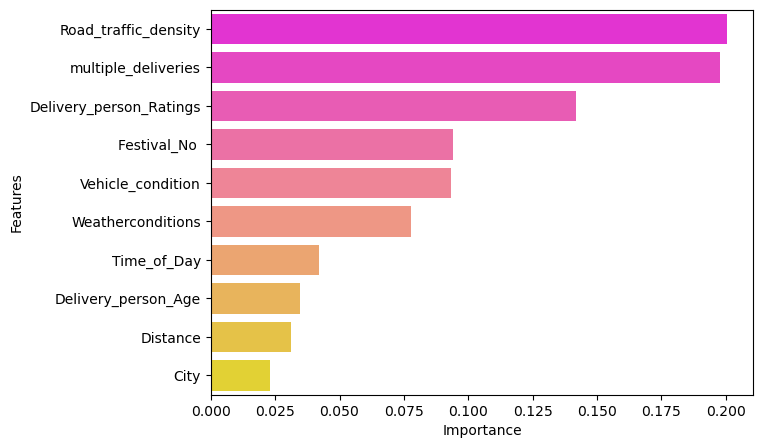

In [113]:
plt.figure(figsize=(7,5))
sns.barplot(x=features_xgb['Importance'][:10],
            y=features_xgb['Features'][:10],
            palette='spring')
plt.show()

In [114]:
model_cb = cb.fit(Xtrain_samp,ytrain_samp)

0:	learn: 8.7669477	total: 12.8ms	remaining: 2.55s
1:	learn: 8.2251957	total: 26ms	remaining: 2.57s
2:	learn: 7.7661759	total: 39.4ms	remaining: 2.58s
3:	learn: 7.3639722	total: 52.6ms	remaining: 2.58s
4:	learn: 7.0121217	total: 65.7ms	remaining: 2.56s
5:	learn: 6.7275272	total: 78.3ms	remaining: 2.53s
6:	learn: 6.4840305	total: 91.4ms	remaining: 2.52s
7:	learn: 6.2583895	total: 109ms	remaining: 2.61s
8:	learn: 6.0625157	total: 123ms	remaining: 2.62s
9:	learn: 5.9062293	total: 141ms	remaining: 2.68s
10:	learn: 5.7746354	total: 160ms	remaining: 2.74s
11:	learn: 5.6410293	total: 180ms	remaining: 2.82s
12:	learn: 5.5411847	total: 199ms	remaining: 2.86s
13:	learn: 5.4537557	total: 222ms	remaining: 2.95s
14:	learn: 5.3704221	total: 244ms	remaining: 3s
15:	learn: 5.3079719	total: 262ms	remaining: 3.02s
16:	learn: 5.2283123	total: 282ms	remaining: 3.03s
17:	learn: 5.1756176	total: 299ms	remaining: 3.03s
18:	learn: 5.1191647	total: 313ms	remaining: 2.98s
19:	learn: 5.0822322	total: 325ms	remai

171:	learn: 4.1800145	total: 2.33s	remaining: 380ms
172:	learn: 4.1794154	total: 2.35s	remaining: 366ms
173:	learn: 4.1761337	total: 2.36s	remaining: 353ms
174:	learn: 4.1741374	total: 2.37s	remaining: 339ms
175:	learn: 4.1727329	total: 2.39s	remaining: 325ms
176:	learn: 4.1710660	total: 2.4s	remaining: 312ms
177:	learn: 4.1697379	total: 2.41s	remaining: 298ms
178:	learn: 4.1679624	total: 2.42s	remaining: 284ms
179:	learn: 4.1661208	total: 2.44s	remaining: 271ms
180:	learn: 4.1642110	total: 2.46s	remaining: 258ms
181:	learn: 4.1589324	total: 2.47s	remaining: 244ms
182:	learn: 4.1578631	total: 2.48s	remaining: 230ms
183:	learn: 4.1561077	total: 2.49s	remaining: 217ms
184:	learn: 4.1554717	total: 2.5s	remaining: 203ms
185:	learn: 4.1541229	total: 2.52s	remaining: 189ms
186:	learn: 4.1532018	total: 2.53s	remaining: 176ms
187:	learn: 4.1514584	total: 2.55s	remaining: 163ms
188:	learn: 4.1483853	total: 2.56s	remaining: 149ms
189:	learn: 4.1455108	total: 2.58s	remaining: 136ms
190:	learn: 4.

In [115]:
features_cb = pd.DataFrame({'Importance':model_cb.feature_importances_,
                            'Features':Xtrain_samp.columns}).sort_values('Importance',ascending = False)

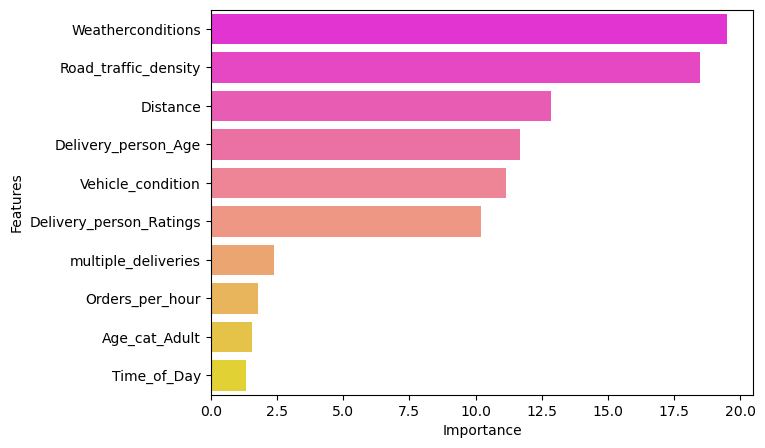

In [116]:
plt.figure(figsize=(7,5))
sns.barplot(x=features_cb['Importance'][:10],
            y=features_cb['Features'][:10],
            palette='spring')
plt.show()